##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 迁移学习和微调

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/guide/keras/transfer_learning"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/keras/transfer_learning.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/keras/transfer_learning.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/guide/keras/transfer_learning.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
</table>

## 设置

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

2022-12-14 21:38:40.956796: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:38:40.956898: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:38:40.956908: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## 简介

**迁移学习**包括获取从迁移学习包括获取从一个问题中学习到的特征，然后将这些特征用于新的类似问题。例如，来自已学会识别浣熊的模型的特征可能对建立旨在识别狸猫的模型十分有用。

对于数据集中的数据太少而无法从头开始训练完整模型的任务，通常会执行迁移学习。

在深度学习情境中，迁移学习最常见的形式是以下工作流：

1. 从之前训练的模型中获取层。
2. 冻结这些层，以避免在后续训练轮次中破坏它们包含的任何信息。
3. 在已冻结层的顶部添加一些新的可训练层。这些层会学习将旧特征转换为对新数据集的预测。
4. 在您的数据集上训练新层。

最后一个可选步骤是**微调**，包括解冻上面获得的整个模型（或模型的一部分），然后在新数据上以极低的学习率对该模型进行重新训练。以增量方式使预训练特征适应新数据，有可能实现有意义的改进。

首先，我们将详细介绍 Keras trainable API，它是大多数迁移学习和微调工作流的基础。

随后，我们将演示一个典型工作流：先获得一个在 ImageNet 数据集上预训练的模型，然后在 Kaggle Dogs vs. Cats 分类数据集上对该模型进行重新训练。

此工作流改编自 [Python 深度学习](https://www.manning.com/books/deep-learning-with-python) [ 和 2016 年的博文“使用极少的数据构建强大的图像分类模型”](https://www.manning.com/books/deep-learning-with-python)

## 冻结层：了解 trainable 特性

层和模型具有三个权重特性：

- `weights` 是层的所有权重变量的列表。
- `trainable_weights` 是需要进行更新（通过梯度下降）以尽可能减少训练过程中损失的权重列表。
- `non_trainable_weights` 是不适合训练的权重列表。它们通常在正向传递过程中由模型更新。

**示例：`Dense` 层具有 2 个可训练权重（内核与偏差）**

In [3]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non_trainable_weights: 0


一般而言，所有权重都是可训练权重。唯一具有不可训练权重的内置层是 `BatchNormalization` 层。在训练期间，它使用不可训练权重跟踪其输入的平均值和方差。要了解如何在您自己的自定义层中使用不可训练权重，请参阅从头开始编写新层的指南。

**示例：`BatchNormalization` 层具有 2 个可训练权重和 2 个不可训练权重**

In [4]:
layer = keras.layers.BatchNormalization()
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 4
trainable_weights: 2
non_trainable_weights: 2


层和模型还具有布尔特性 `trainable`。此特性的值可以更改。将 `layer.trainable` 设置为 `False` 会将层的所有权重从可训练移至不可训练。这一过程称为“冻结”层：已冻结层的状态在训练期间不会更新（无论是使用 `fit()` 进行训练，还是使用依赖于 `trainable_weights` 来应用梯度更新的任何自定义循环进行训练时）。

**示例：将 `trainable` 设置为 `False`**

In [5]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2


当可训练权重变为不可训练时，它的值在训练期间不再更新。

In [6]:
# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# Freeze the first layer
layer1.trainable = False

# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()

# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# Check that the weights of layer1 have not changed during training
final_layer1_weights_values = layer1.get_weights()
np.testing.assert_allclose(
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)

1/1 [==============================] - ETA: 0s - loss: 0.0926

1/1 [==============================] - 1s 1s/step - loss: 0.0926


请勿将 `layer.trainable` 特性与 `layer.__call__()` 中的 `training` 参数（此参数控制层是在推断模式还是训练模式下运行其前向传递）混淆。有关更多信息，请参阅 [Keras常见问题解答](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute) 。

## `trainable` 特性的递归设置

如果在模型或具有子层的任何层上设置 `trainable = False`，则所有子层也将变为不可训练。

**示例：**

In [7]:
inner_model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        keras.layers.Dense(3, activation="relu"),
        keras.layers.Dense(3, activation="relu"),
    ]
)

model = keras.Sequential(
    [keras.Input(shape=(3,)), inner_model, keras.layers.Dense(3, activation="sigmoid"),]
)

model.trainable = False  # Freeze the outer model

assert inner_model.trainable == False  # All layers in `model` are now frozen
assert inner_model.layers[0].trainable == False  # `trainable` is propagated recursively

## 典型的迁移学习工作流

下面将介绍如何在 Keras 中实现典型的迁移学习工作流：

1. 实例化一个基础模型并加载预训练权重。
2. 通过设置 `trainable = False` 冻结基础模型中的所有层。
3. 根据基础模型中一个（或多个）层的输出创建一个新模型。
4. 在您的新数据集上训练新模型。

请注意，另一种更轻量的工作流如下：

1. 实例化一个基础模型并加载预训练权重。
2. 通过该模型运行新的数据集，并记录基础模型中一个（或多个）层的输出。这一过程称为特征提取。
3. 使用该输出作为新的较小模型的输入数据。

第二种工作流有一个关键优势，即您只需在自己的数据上运行一次基础模型，而不是每个训练周期都运行一次。因此，它的速度更快，开销也更低。

但是，第二种工作流存在一个问题，即它不允许您在训练期间动态修改新模型的输入数据，在进行数据扩充时，这种修改必不可少。当新数据集的数据太少而无法从头开始训练完整模型时，任务通常会使用迁移学习，在这种情况下，数据扩充非常重要。因此，在接下来的篇幅中，我们将专注于第一种工作流。

下面是 Keras 中第一种工作流的样子：

首先，实例化一个具有预训练权重的基础模型。

```python
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
```

随后，冻结该基础模型。

```python
base_model.trainable = False
```

根据基础模型创建一个新模型。

```python
inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
```

在新数据上训练该模型。

```python
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)
```

## 微调

一旦模型在新数据上收敛，您就可以尝试解冻全部或部分基础模型，并以极低的学习率端到端地重新训练整个模型。

这是可选的最后一个步骤，可能给您带来增量式改进。不过，它也可能导致快速过拟合，请牢记这一点。

重要的是，只有在将具有冻结层的模型训练至收敛后，才能执行此步骤。如果将随机初始化的可训练层与包含预训练特征的可训练层混合使用，则随机初始化的层将在训练过程中引起非常大的梯度更新，而这将破坏您的预训练特征。

在此阶段使用极低的学习率也很重要，因为与第一轮训练相比，您正在一个通常非常小的数据集上训练一个大得多的模型。因此，如果您应用较大的权重更新，则存在很快过拟合的风险。在这里，您只需要以增量方式重新调整预训练权重。

下面是实现整个基础模型微调的方法：

```python
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(new_dataset, epochs=10, callbacks=..., validation_data=...)
```

**关于 `compile()` 和 `trainable` 的重要说明**

在模型上调用 `compile()` 意味着“冻结”该模型的行为。这意味着编译模型时的 `trainable` 特性值应当在该模型的整个生命周期中保留，直到再次调用 `compile`。因此，如果您更改任何 `trainable` 值，请确保在您的模型上再次调用 `compile()` 以将您的变更考虑在内。

**关于 `BatchNormalization` 层的重要说明**

许多图像模型包含 `BatchNormalization` 层。该层在任何方面都是一个特例。下面是一些注意事项。

- `BatchNormalization` 包含 2 个会在训练期间更新的不可训练权重。它们是跟踪输入的均值和方差的变量。
- 当您设置 `bn_layer.trainable = False` 时，`BatchNormalization` 层将以推断模式运行，并且不会更新其均值和方差统计信息。一般而言，其他层的情况并非如此，因为[权重可训练性和推断/训练模式是两个正交概念](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute)。但是，对于 `BatchNormalization` 层，两者是关联的。
- 当您解冻包含 `BatchNormalization` 层的模型以进行微调时，您应当通过在调用基础模型时传递 `training=False` 以将 `BatchNormalization` 层保持在推断模式。否则，应用于不可训练权重的更新会突然破坏模型已经学习的内容。

您将在本指南结尾处的端到端示例中看到这种模式的实际运行。


## 使用自定义训练循环进行迁移学习和微调

如果您使用自己的低级训练循环而不是 `fit()`，则工作流基本保持不变。在应用梯度更新时，您应当注意只考虑清单 `model.trainable_weights`：

```python
# Create base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False

# Create new model on top.
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()

# Iterate over the batches of a dataset.
for inputs, targets in new_dataset:
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        # Forward pass.
        predictions = model(inputs)
        # Compute the loss value for this batch.
        loss_value = loss_fn(targets, predictions)

    # Get gradients of loss wrt the *trainable* weights.
    gradients = tape.gradient(loss_value, model.trainable_weights)
    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
```

对于微调同样如此。

## 端到端示例：基于 Dogs vs. Cats 数据集微调图像分类模型

为了巩固这些概念，我们先介绍一个具体的端到端迁移学习和微调示例。我们将加载在 ImageNet 上预训练的 Xception 模型，并将其用于 Kaggle Dogs vs. Cats 分类数据集。

### 获取数据

首先，我们使用 TFDS 来获取 Dogs vs. Cats 数据集。如果您拥有自己的数据集，则可能需要使用效用函数 `tf.keras.preprocessing.image_dataset_from_directory` 从磁盘上存档到类特定的文件夹中的一组图像来生成相似的有标签数据集对象。

使用非常小的数据集时，迁移学习最实用。为了使数据集保持较小状态，我们将原始训练数据（25,000 个图像）的 40% 用于训练，10% 用于验证，10% 用于测试。

In [8]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


下面是训练数据集中的前 9 个图像。如您所见，它们具有不同的大小。

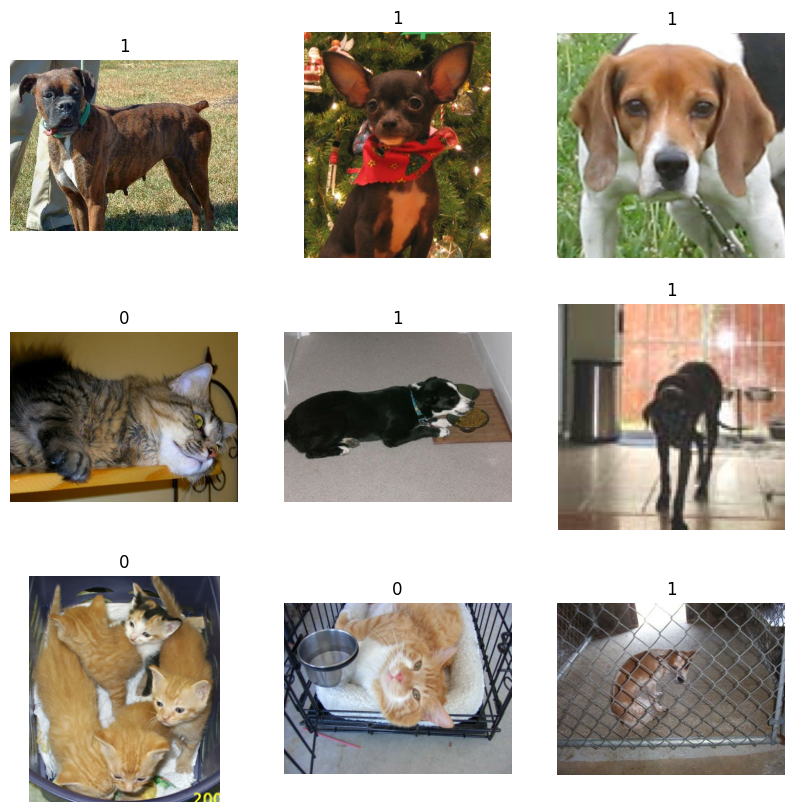

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

我们还可以看到标签 1 是“狗”，标签 0 是“猫”。

### 标准化数据

我们的原始图像有各种大小。另外，每个像素由 0 到 255 之间的 3 个整数值（RGB 色阶值）组成。这不太适合馈送神经网络。我们需要做下面两件事：

- 标准化为固定图像大小。我们选择 150x150。
- 在 -1 至 1 之间归一化像素值。我们将使用 `Normalization` 层作为模型本身的一部分来进行此操作。

一般而言，与采用已预处理数据的模型相反，开发以原始数据作为输入的模型是一种良好的做法。原因在于，如果模型需要预处理的数据，则每次导出模型以在其他地方（在网络浏览器、移动应用中）使用时，都需要重新实现完全相同的预处理流水线。这很快就会变得非常棘手。因此，在命中模型之前，我们应当尽可能少地进行预处理。

在这里，我们将在数据流水线中进行图像大小调整（因为深度神经网络只能处理连续的数据批次），并在创建模型时将其作为模型的一部分进行输入值缩放。

我们将图像的大小调整为 150x150：

In [10]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


此外，我们对数据进行批处理并使用缓存和预提取来优化加载速度。

In [11]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### 使用随机数据扩充

当您没有较大的图像数据集时，通过将随机但现实的转换（例如随机水平翻转或小幅随机旋转）应用于训练图像来人为引入样本多样性是一种良好的做法。这有助于使模型暴露于训练数据的不同方面，同时减慢过拟合的速度。

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

我们看一下经过各种随机转换后第一个批次的第一个图像是什么样：

2022-12-14 21:38:49.939992: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


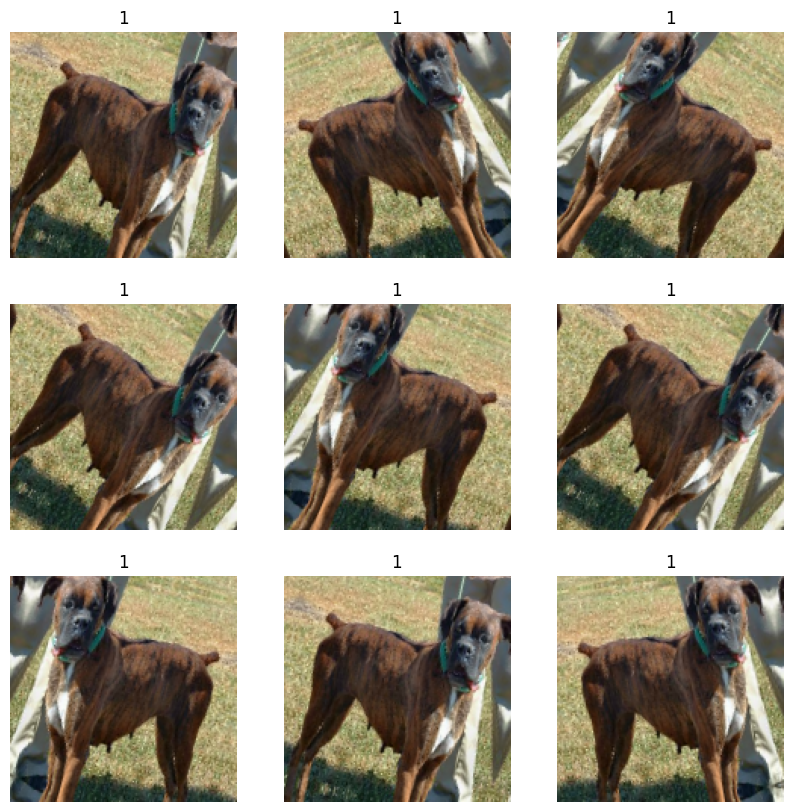

In [13]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

## 构建模型

现在，我们来构建一个遵循我们先前解释的蓝图的模型。

注意：

- 我们添加 `Rescaling` 层以将输入值（最初在 `[0, 255]` 范围内）缩放到 `[-1, 1]` 范围。
- 我们在分类层之前添加一个 `Dropout` 层，以进行正则化。
- 我们确保在调用基础模型时传递 `training=False`，使其在推断模式下运行，这样，即使在我们解冻基础模型以进行微调后，batchnorm 统计信息也不会更新。

In [14]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

    8192/83683744 [..............................] - ETA: 0s

 4202496/83683744 [>.............................] - ETA: 1s

14000128/83683744 [====>.........................] - ETA: 0s

24141824/83683744 [=======>......................] - ETA: 0s

30269440/83683744 [=========>....................] - ETA: 0s

36470784/83683744 [============>.................] - ETA: 0s

41762816/83683744 [=============>................] - ETA: 0s

47767552/83683744 [================>.............] - ETA: 0s

54198272/83683744 [==================>...........] - ETA: 0s

60325888/83683744 [====================>.........] - ETA: 0s

66125824/83683744 [======================>.......] - ETA: 0s

72015872/83683744 [========================>.....] - ETA: 0s

79101952/83683744 [===========================>..] - ETA: 0s

83683744/83683744 [==============================] - 1s 0us/step


Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         


 sequential_3 (Sequential)   (None, 150, 150, 3)       0         


 rescaling (Rescaling)       (None, 150, 150, 3)       0         


 xception (Functional)       (None, 5, 5, 2048)        20861480  


 global_average_pooling2d (G  (None, 2048)             0         


 lobalAveragePooling2D)                                          


 dropout (Dropout)           (None, 2048)              0         


 dense_7 (Dense)             (None, 1)                 2049      


Total params: 20,863,529


Trainable params: 2,049


Non-trainable params: 20,861,480


_________________________________________________________________


## 训练顶层

In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20


  1/291 [..............................] - ETA: 27:37 - loss: 0.7445 - binary_accuracy: 0.5312

  2/291 [..............................] - ETA: 22s - loss: 0.7300 - binary_accuracy: 0.5625  

  3/291 [..............................] - ETA: 22s - loss: 0.7058 - binary_accuracy: 0.5729

  4/291 [..............................] - ETA: 21s - loss: 0.7094 - binary_accuracy: 0.5938

  5/291 [..............................] - ETA: 21s - loss: 0.6723 - binary_accuracy: 0.6187

  6/291 [..............................] - ETA: 21s - loss: 0.6444 - binary_accuracy: 0.6562

  7/291 [..............................] - ETA: 21s - loss: 0.6098 - binary_accuracy: 0.6830

  8/291 [..............................] - ETA: 21s - loss: 0.6092 - binary_accuracy: 0.6562

  9/291 [..............................] - ETA: 21s - loss: 0.6053 - binary_accuracy: 0.6458

 10/291 [>.............................] - ETA: 21s - loss: 0.5915 - binary_accuracy: 0.6500

 11/291 [>.............................] - ETA: 21s - loss: 0.5764 - binary_accuracy: 0.6591

 12/291 [>.............................] - ETA: 21s - loss: 0.5520 - binary_accuracy: 0.6849

 13/291 [>.............................] - ETA: 21s - loss: 0.5389 - binary_accuracy: 0.6971

 14/291 [>.............................] - ETA: 21s - loss: 0.5244 - binary_accuracy: 0.7054

 15/291 [>.............................] - ETA: 21s - loss: 0.5142 - binary_accuracy: 0.7167

 16/291 [>.............................] - ETA: 21s - loss: 0.4983 - binary_accuracy: 0.7305

 17/291 [>.............................] - ETA: 20s - loss: 0.4846 - binary_accuracy: 0.7390

 18/291 [>.............................] - ETA: 20s - loss: 0.4712 - binary_accuracy: 0.7500

 19/291 [>.............................] - ETA: 20s - loss: 0.4617 - binary_accuracy: 0.7549

 20/291 [=>............................] - ETA: 20s - loss: 0.4502 - binary_accuracy: 0.7641

 21/291 [=>............................] - ETA: 20s - loss: 0.4435 - binary_accuracy: 0.7693

 22/291 [=>............................] - ETA: 20s - loss: 0.4359 - binary_accuracy: 0.7756

 23/291 [=>............................] - ETA: 20s - loss: 0.4290 - binary_accuracy: 0.7826

 24/291 [=>............................] - ETA: 20s - loss: 0.4198 - binary_accuracy: 0.7878

 25/291 [=>............................] - ETA: 20s - loss: 0.4100 - binary_accuracy: 0.7950

 26/291 [=>............................] - ETA: 20s - loss: 0.4047 - binary_accuracy: 0.8005

 27/291 [=>............................] - ETA: 20s - loss: 0.4000 - binary_accuracy: 0.8032

 28/291 [=>............................] - ETA: 20s - loss: 0.3909 - binary_accuracy: 0.8092

 29/291 [=>............................] - ETA: 20s - loss: 0.3923 - binary_accuracy: 0.8103

 30/291 [==>...........................] - ETA: 19s - loss: 0.3852 - binary_accuracy: 0.8135

 31/291 [==>...........................] - ETA: 19s - loss: 0.3795 - binary_accuracy: 0.8165

 32/291 [==>...........................] - ETA: 19s - loss: 0.3748 - binary_accuracy: 0.8193

 33/291 [==>...........................] - ETA: 19s - loss: 0.3705 - binary_accuracy: 0.8201

 34/291 [==>...........................] - ETA: 19s - loss: 0.3664 - binary_accuracy: 0.8226

 35/291 [==>...........................] - ETA: 19s - loss: 0.3600 - binary_accuracy: 0.8259

 36/291 [==>...........................] - ETA: 19s - loss: 0.3544 - binary_accuracy: 0.8299

 37/291 [==>...........................] - ETA: 19s - loss: 0.3485 - binary_accuracy: 0.8328

 38/291 [==>...........................] - ETA: 19s - loss: 0.3441 - binary_accuracy: 0.8355

 39/291 [===>..........................] - ETA: 19s - loss: 0.3389 - binary_accuracy: 0.8389

 40/291 [===>..........................] - ETA: 19s - loss: 0.3349 - binary_accuracy: 0.8406

 41/291 [===>..........................] - ETA: 19s - loss: 0.3305 - binary_accuracy: 0.8422

 42/291 [===>..........................] - ETA: 19s - loss: 0.3266 - binary_accuracy: 0.8452

 43/291 [===>..........................] - ETA: 19s - loss: 0.3267 - binary_accuracy: 0.8445

 44/291 [===>..........................] - ETA: 18s - loss: 0.3239 - binary_accuracy: 0.8459

 45/291 [===>..........................] - ETA: 18s - loss: 0.3219 - binary_accuracy: 0.8465

 46/291 [===>..........................] - ETA: 18s - loss: 0.3184 - binary_accuracy: 0.8471

 47/291 [===>..........................] - ETA: 18s - loss: 0.3160 - binary_accuracy: 0.8484

 48/291 [===>..........................] - ETA: 18s - loss: 0.3129 - binary_accuracy: 0.8503

 49/291 [====>.........................] - ETA: 18s - loss: 0.3101 - binary_accuracy: 0.8520

 50/291 [====>.........................] - ETA: 18s - loss: 0.3076 - binary_accuracy: 0.8525

 51/291 [====>.........................] - ETA: 18s - loss: 0.3052 - binary_accuracy: 0.8542

 52/291 [====>.........................] - ETA: 18s - loss: 0.3022 - binary_accuracy: 0.8558

 53/291 [====>.........................] - ETA: 18s - loss: 0.3000 - binary_accuracy: 0.8561

 54/291 [====>.........................] - ETA: 18s - loss: 0.2983 - binary_accuracy: 0.8576

 55/291 [====>.........................] - ETA: 18s - loss: 0.2951 - binary_accuracy: 0.8597

 56/291 [====>.........................] - ETA: 18s - loss: 0.2922 - binary_accuracy: 0.8616

 57/291 [====>.........................] - ETA: 17s - loss: 0.2892 - binary_accuracy: 0.8635

 58/291 [====>.........................] - ETA: 17s - loss: 0.2866 - binary_accuracy: 0.8648

 59/291 [=====>........................] - ETA: 17s - loss: 0.2837 - binary_accuracy: 0.8671

 60/291 [=====>........................] - ETA: 17s - loss: 0.2821 - binary_accuracy: 0.8682

 61/291 [=====>........................] - ETA: 17s - loss: 0.2789 - binary_accuracy: 0.8699

 62/291 [=====>........................] - ETA: 17s - loss: 0.2771 - binary_accuracy: 0.8715

 63/291 [=====>........................] - ETA: 17s - loss: 0.2757 - binary_accuracy: 0.8725

 64/291 [=====>........................] - ETA: 17s - loss: 0.2731 - binary_accuracy: 0.8740

 65/291 [=====>........................] - ETA: 17s - loss: 0.2706 - binary_accuracy: 0.8755

 66/291 [=====>........................] - ETA: 17s - loss: 0.2698 - binary_accuracy: 0.8755

 67/291 [=====>........................] - ETA: 17s - loss: 0.2682 - binary_accuracy: 0.8764

 68/291 [======>.......................] - ETA: 17s - loss: 0.2654 - binary_accuracy: 0.8778

 69/291 [======>.......................] - ETA: 16s - loss: 0.2638 - binary_accuracy: 0.8786

 70/291 [======>.......................] - ETA: 16s - loss: 0.2613 - binary_accuracy: 0.8804

 71/291 [======>.......................] - ETA: 16s - loss: 0.2594 - binary_accuracy: 0.8812

 72/291 [======>.......................] - ETA: 16s - loss: 0.2588 - binary_accuracy: 0.8806

 73/291 [======>.......................] - ETA: 16s - loss: 0.2587 - binary_accuracy: 0.8810

 74/291 [======>.......................] - ETA: 16s - loss: 0.2590 - binary_accuracy: 0.8801

 75/291 [======>.......................] - ETA: 16s - loss: 0.2569 - binary_accuracy: 0.8813

 76/291 [======>.......................] - ETA: 16s - loss: 0.2559 - binary_accuracy: 0.8820

 77/291 [======>.......................] - ETA: 16s - loss: 0.2555 - binary_accuracy: 0.8823

 78/291 [=======>......................] - ETA: 16s - loss: 0.2536 - binary_accuracy: 0.8834

 79/291 [=======>......................] - ETA: 16s - loss: 0.2513 - binary_accuracy: 0.8845

 80/291 [=======>......................] - ETA: 16s - loss: 0.2503 - binary_accuracy: 0.8852

 81/291 [=======>......................] - ETA: 16s - loss: 0.2494 - binary_accuracy: 0.8850

 82/291 [=======>......................] - ETA: 15s - loss: 0.2470 - binary_accuracy: 0.8864

 83/291 [=======>......................] - ETA: 15s - loss: 0.2456 - binary_accuracy: 0.8870

 84/291 [=======>......................] - ETA: 15s - loss: 0.2444 - binary_accuracy: 0.8876

 85/291 [=======>......................] - ETA: 15s - loss: 0.2439 - binary_accuracy: 0.8879

 86/291 [=======>......................] - ETA: 15s - loss: 0.2423 - binary_accuracy: 0.8888

 87/291 [=======>......................] - ETA: 15s - loss: 0.2415 - binary_accuracy: 0.8883

 88/291 [========>.....................] - ETA: 15s - loss: 0.2411 - binary_accuracy: 0.8885

 89/291 [========>.....................] - ETA: 15s - loss: 0.2399 - binary_accuracy: 0.8890

 90/291 [========>.....................] - ETA: 15s - loss: 0.2382 - binary_accuracy: 0.8899

 91/291 [========>.....................] - ETA: 15s - loss: 0.2371 - binary_accuracy: 0.8905

 92/291 [========>.....................] - ETA: 15s - loss: 0.2358 - binary_accuracy: 0.8903

 93/291 [========>.....................] - ETA: 15s - loss: 0.2346 - binary_accuracy: 0.8911

 94/291 [========>.....................] - ETA: 15s - loss: 0.2327 - binary_accuracy: 0.8920

 95/291 [========>.....................] - ETA: 14s - loss: 0.2334 - binary_accuracy: 0.8911

 96/291 [========>.....................] - ETA: 14s - loss: 0.2327 - binary_accuracy: 0.8916

 97/291 [=========>....................] - ETA: 14s - loss: 0.2338 - binary_accuracy: 0.8918

 98/291 [=========>....................] - ETA: 14s - loss: 0.2326 - binary_accuracy: 0.8922

 99/291 [=========>....................] - ETA: 14s - loss: 0.2317 - binary_accuracy: 0.8924

100/291 [=========>....................] - ETA: 14s - loss: 0.2304 - binary_accuracy: 0.8928

101/291 [=========>....................] - ETA: 14s - loss: 0.2307 - binary_accuracy: 0.8926

102/291 [=========>....................] - ETA: 14s - loss: 0.2296 - binary_accuracy: 0.8934

103/291 [=========>....................] - ETA: 14s - loss: 0.2285 - binary_accuracy: 0.8938

104/291 [=========>....................] - ETA: 14s - loss: 0.2277 - binary_accuracy: 0.8939

105/291 [=========>....................] - ETA: 14s - loss: 0.2287 - binary_accuracy: 0.8943

106/291 [=========>....................] - ETA: 14s - loss: 0.2286 - binary_accuracy: 0.8942

107/291 [==========>...................] - ETA: 14s - loss: 0.2271 - binary_accuracy: 0.8949

108/291 [==========>...................] - ETA: 13s - loss: 0.2262 - binary_accuracy: 0.8955

109/291 [==========>...................] - ETA: 13s - loss: 0.2250 - binary_accuracy: 0.8962

110/291 [==========>...................] - ETA: 13s - loss: 0.2245 - binary_accuracy: 0.8966

111/291 [==========>...................] - ETA: 13s - loss: 0.2258 - binary_accuracy: 0.8961

112/291 [==========>...................] - ETA: 13s - loss: 0.2256 - binary_accuracy: 0.8962

113/291 [==========>...................] - ETA: 13s - loss: 0.2241 - binary_accuracy: 0.8968

114/291 [==========>...................] - ETA: 13s - loss: 0.2229 - binary_accuracy: 0.8975

115/291 [==========>...................] - ETA: 13s - loss: 0.2218 - binary_accuracy: 0.8984

116/291 [==========>...................] - ETA: 13s - loss: 0.2210 - binary_accuracy: 0.8987

117/291 [===========>..................] - ETA: 13s - loss: 0.2194 - binary_accuracy: 0.8996

118/291 [===========>..................] - ETA: 13s - loss: 0.2198 - binary_accuracy: 0.8991

119/291 [===========>..................] - ETA: 13s - loss: 0.2187 - binary_accuracy: 0.8999

120/291 [===========>..................] - ETA: 13s - loss: 0.2177 - binary_accuracy: 0.9005

121/291 [===========>..................] - ETA: 12s - loss: 0.2166 - binary_accuracy: 0.9011

122/291 [===========>..................] - ETA: 12s - loss: 0.2158 - binary_accuracy: 0.9016

123/291 [===========>..................] - ETA: 12s - loss: 0.2156 - binary_accuracy: 0.9017

124/291 [===========>..................] - ETA: 12s - loss: 0.2148 - binary_accuracy: 0.9017

125/291 [===========>..................] - ETA: 12s - loss: 0.2162 - binary_accuracy: 0.9013

126/291 [===========>..................] - ETA: 12s - loss: 0.2152 - binary_accuracy: 0.9018

127/291 [============>.................] - ETA: 12s - loss: 0.2145 - binary_accuracy: 0.9021

128/291 [============>.................] - ETA: 12s - loss: 0.2138 - binary_accuracy: 0.9026

129/291 [============>.................] - ETA: 12s - loss: 0.2127 - binary_accuracy: 0.9031

130/291 [============>.................] - ETA: 12s - loss: 0.2122 - binary_accuracy: 0.9034

131/291 [============>.................] - ETA: 12s - loss: 0.2112 - binary_accuracy: 0.9041

132/291 [============>.................] - ETA: 12s - loss: 0.2105 - binary_accuracy: 0.9044

133/291 [============>.................] - ETA: 12s - loss: 0.2101 - binary_accuracy: 0.9039

134/291 [============>.................] - ETA: 11s - loss: 0.2094 - binary_accuracy: 0.9044

135/291 [============>.................] - ETA: 11s - loss: 0.2083 - binary_accuracy: 0.9049

136/291 [=============>................] - ETA: 11s - loss: 0.2081 - binary_accuracy: 0.9044

137/291 [=============>................] - ETA: 11s - loss: 0.2070 - binary_accuracy: 0.9049

138/291 [=============>................] - ETA: 11s - loss: 0.2081 - binary_accuracy: 0.9044

139/291 [=============>................] - ETA: 11s - loss: 0.2075 - binary_accuracy: 0.9049

140/291 [=============>................] - ETA: 11s - loss: 0.2063 - binary_accuracy: 0.9056

141/291 [=============>................] - ETA: 11s - loss: 0.2059 - binary_accuracy: 0.9060

142/291 [=============>................] - ETA: 11s - loss: 0.2058 - binary_accuracy: 0.9058

143/291 [=============>................] - ETA: 11s - loss: 0.2053 - binary_accuracy: 0.9058

144/291 [=============>................] - ETA: 11s - loss: 0.2045 - binary_accuracy: 0.9062

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


145/291 [=============>................] - ETA: 11s - loss: 0.2039 - binary_accuracy: 0.9067

146/291 [==============>...............] - ETA: 11s - loss: 0.2031 - binary_accuracy: 0.9069

147/291 [==============>...............] - ETA: 10s - loss: 0.2022 - binary_accuracy: 0.9075

148/291 [==============>...............] - ETA: 10s - loss: 0.2015 - binary_accuracy: 0.9079

149/291 [==============>...............] - ETA: 10s - loss: 0.2008 - binary_accuracy: 0.9083

150/291 [==============>...............] - ETA: 10s - loss: 0.2004 - binary_accuracy: 0.9085

151/291 [==============>...............] - ETA: 10s - loss: 0.1998 - binary_accuracy: 0.9089

152/291 [==============>...............] - ETA: 10s - loss: 0.1988 - binary_accuracy: 0.9095

153/291 [==============>...............] - ETA: 10s - loss: 0.1983 - binary_accuracy: 0.9097

154/291 [==============>...............] - ETA: 10s - loss: 0.1983 - binary_accuracy: 0.9099

155/291 [==============>...............] - ETA: 10s - loss: 0.1976 - binary_accuracy: 0.9103

156/291 [===============>..............] - ETA: 10s - loss: 0.1970 - binary_accuracy: 0.9107

157/291 [===============>..............] - ETA: 10s - loss: 0.1968 - binary_accuracy: 0.9106

158/291 [===============>..............] - ETA: 10s - loss: 0.1963 - binary_accuracy: 0.9108

159/291 [===============>..............] - ETA: 10s - loss: 0.1955 - binary_accuracy: 0.9112

160/291 [===============>..............] - ETA: 9s - loss: 0.1966 - binary_accuracy: 0.9105 

161/291 [===============>..............] - ETA: 9s - loss: 0.1969 - binary_accuracy: 0.9107

162/291 [===============>..............] - ETA: 9s - loss: 0.1964 - binary_accuracy: 0.9111

163/291 [===============>..............] - ETA: 9s - loss: 0.1955 - binary_accuracy: 0.9116

164/291 [===============>..............] - ETA: 9s - loss: 0.1962 - binary_accuracy: 0.9116

165/291 [================>.............] - ETA: 9s - loss: 0.1961 - binary_accuracy: 0.9114

166/291 [================>.............] - ETA: 9s - loss: 0.1956 - binary_accuracy: 0.9115

167/291 [================>.............] - ETA: 9s - loss: 0.1952 - binary_accuracy: 0.9117

168/291 [================>.............] - ETA: 9s - loss: 0.1945 - binary_accuracy: 0.9120

169/291 [================>.............] - ETA: 9s - loss: 0.1936 - binary_accuracy: 0.9125

170/291 [================>.............] - ETA: 9s - loss: 0.1933 - binary_accuracy: 0.9125

171/291 [================>.............] - ETA: 9s - loss: 0.1931 - binary_accuracy: 0.9123

172/291 [================>.............] - ETA: 9s - loss: 0.1935 - binary_accuracy: 0.9122

173/291 [================>.............] - ETA: 9s - loss: 0.1929 - binary_accuracy: 0.9126

174/291 [================>.............] - ETA: 8s - loss: 0.1922 - binary_accuracy: 0.9131

175/291 [=================>............] - ETA: 8s - loss: 0.1920 - binary_accuracy: 0.9132

176/291 [=================>............] - ETA: 8s - loss: 0.1914 - binary_accuracy: 0.9137

177/291 [=================>............] - ETA: 8s - loss: 0.1910 - binary_accuracy: 0.9140

178/291 [=================>............] - ETA: 8s - loss: 0.1909 - binary_accuracy: 0.9140

179/291 [=================>............] - ETA: 8s - loss: 0.1903 - binary_accuracy: 0.9145

180/291 [=================>............] - ETA: 8s - loss: 0.1902 - binary_accuracy: 0.9146

181/291 [=================>............] - ETA: 8s - loss: 0.1901 - binary_accuracy: 0.9147

182/291 [=================>............] - ETA: 8s - loss: 0.1897 - binary_accuracy: 0.9148

183/291 [=================>............] - ETA: 8s - loss: 0.1894 - binary_accuracy: 0.9150

184/291 [=================>............] - ETA: 8s - loss: 0.1887 - binary_accuracy: 0.9153

185/291 [==================>...........] - ETA: 8s - loss: 0.1885 - binary_accuracy: 0.9154

186/291 [==================>...........] - ETA: 8s - loss: 0.1883 - binary_accuracy: 0.9157

187/291 [==================>...........] - ETA: 7s - loss: 0.1881 - binary_accuracy: 0.9159

188/291 [==================>...........] - ETA: 7s - loss: 0.1881 - binary_accuracy: 0.9159

189/291 [==================>...........] - ETA: 7s - loss: 0.1882 - binary_accuracy: 0.9160

190/291 [==================>...........] - ETA: 7s - loss: 0.1876 - binary_accuracy: 0.9164

191/291 [==================>...........] - ETA: 7s - loss: 0.1872 - binary_accuracy: 0.9166

192/291 [==================>...........] - ETA: 7s - loss: 0.1879 - binary_accuracy: 0.9162

193/291 [==================>...........] - ETA: 7s - loss: 0.1883 - binary_accuracy: 0.9161

194/291 [===================>..........] - ETA: 7s - loss: 0.1883 - binary_accuracy: 0.9161

195/291 [===================>..........] - ETA: 7s - loss: 0.1882 - binary_accuracy: 0.9162

196/291 [===================>..........] - ETA: 7s - loss: 0.1878 - binary_accuracy: 0.9165

197/291 [===================>..........] - ETA: 7s - loss: 0.1875 - binary_accuracy: 0.9166

198/291 [===================>..........] - ETA: 7s - loss: 0.1881 - binary_accuracy: 0.9162

199/291 [===================>..........] - ETA: 7s - loss: 0.1877 - binary_accuracy: 0.9165

200/291 [===================>..........] - ETA: 6s - loss: 0.1873 - binary_accuracy: 0.9167

201/291 [===================>..........] - ETA: 6s - loss: 0.1875 - binary_accuracy: 0.9168

202/291 [===================>..........] - ETA: 6s - loss: 0.1875 - binary_accuracy: 0.9169

203/291 [===================>..........] - ETA: 6s - loss: 0.1877 - binary_accuracy: 0.9167

204/291 [====================>.........] - ETA: 6s - loss: 0.1874 - binary_accuracy: 0.9168

205/291 [====================>.........] - ETA: 6s - loss: 0.1873 - binary_accuracy: 0.9168

206/291 [====================>.........] - ETA: 6s - loss: 0.1869 - binary_accuracy: 0.9169

207/291 [====================>.........] - ETA: 6s - loss: 0.1865 - binary_accuracy: 0.9171

208/291 [====================>.........] - ETA: 6s - loss: 0.1863 - binary_accuracy: 0.9169

209/291 [====================>.........] - ETA: 6s - loss: 0.1867 - binary_accuracy: 0.9166

210/291 [====================>.........] - ETA: 6s - loss: 0.1863 - binary_accuracy: 0.9167

211/291 [====================>.........] - ETA: 6s - loss: 0.1862 - binary_accuracy: 0.9168

212/291 [====================>.........] - ETA: 6s - loss: 0.1860 - binary_accuracy: 0.9169

213/291 [====================>.........] - ETA: 5s - loss: 0.1854 - binary_accuracy: 0.9171

214/291 [=====================>........] - ETA: 5s - loss: 0.1847 - binary_accuracy: 0.9175

215/291 [=====================>........] - ETA: 5s - loss: 0.1841 - binary_accuracy: 0.9177

216/291 [=====================>........] - ETA: 5s - loss: 0.1837 - binary_accuracy: 0.9180

217/291 [=====================>........] - ETA: 5s - loss: 0.1833 - binary_accuracy: 0.9181

218/291 [=====================>........] - ETA: 5s - loss: 0.1834 - binary_accuracy: 0.9181

219/291 [=====================>........] - ETA: 5s - loss: 0.1830 - binary_accuracy: 0.9184

220/291 [=====================>........] - ETA: 5s - loss: 0.1830 - binary_accuracy: 0.9185

221/291 [=====================>........] - ETA: 5s - loss: 0.1829 - binary_accuracy: 0.9186

222/291 [=====================>........] - ETA: 5s - loss: 0.1826 - binary_accuracy: 0.9185

223/291 [=====================>........] - ETA: 5s - loss: 0.1829 - binary_accuracy: 0.9182

224/291 [======================>.......] - ETA: 5s - loss: 0.1822 - binary_accuracy: 0.9185

225/291 [======================>.......] - ETA: 5s - loss: 0.1822 - binary_accuracy: 0.9186

226/291 [======================>.......] - ETA: 4s - loss: 0.1817 - binary_accuracy: 0.9187

227/291 [======================>.......] - ETA: 4s - loss: 0.1812 - binary_accuracy: 0.9191

228/291 [======================>.......] - ETA: 4s - loss: 0.1809 - binary_accuracy: 0.9191

229/291 [======================>.......] - ETA: 4s - loss: 0.1808 - binary_accuracy: 0.9192

230/291 [======================>.......] - ETA: 4s - loss: 0.1810 - binary_accuracy: 0.9192

231/291 [======================>.......] - ETA: 4s - loss: 0.1808 - binary_accuracy: 0.9191

232/291 [======================>.......] - ETA: 4s - loss: 0.1804 - binary_accuracy: 0.9193

233/291 [=======================>......] - ETA: 4s - loss: 0.1800 - binary_accuracy: 0.9194

234/291 [=======================>......] - ETA: 4s - loss: 0.1801 - binary_accuracy: 0.9193

235/291 [=======================>......] - ETA: 4s - loss: 0.1796 - binary_accuracy: 0.9195

236/291 [=======================>......] - ETA: 4s - loss: 0.1789 - binary_accuracy: 0.9199

237/291 [=======================>......] - ETA: 4s - loss: 0.1789 - binary_accuracy: 0.9197

238/291 [=======================>......] - ETA: 4s - loss: 0.1786 - binary_accuracy: 0.9199

239/291 [=======================>......] - ETA: 3s - loss: 0.1781 - binary_accuracy: 0.9202

240/291 [=======================>......] - ETA: 3s - loss: 0.1782 - binary_accuracy: 0.9202

241/291 [=======================>......] - ETA: 3s - loss: 0.1781 - binary_accuracy: 0.9204

242/291 [=======================>......] - ETA: 3s - loss: 0.1778 - binary_accuracy: 0.9207

243/291 [========================>.....] - ETA: 3s - loss: 0.1774 - binary_accuracy: 0.9208

244/291 [========================>.....] - ETA: 3s - loss: 0.1774 - binary_accuracy: 0.9209

245/291 [========================>.....] - ETA: 3s - loss: 0.1771 - binary_accuracy: 0.9209

246/291 [========================>.....] - ETA: 3s - loss: 0.1768 - binary_accuracy: 0.9210

247/291 [========================>.....] - ETA: 3s - loss: 0.1765 - binary_accuracy: 0.9212

248/291 [========================>.....] - ETA: 3s - loss: 0.1765 - binary_accuracy: 0.9211

249/291 [========================>.....] - ETA: 3s - loss: 0.1760 - binary_accuracy: 0.9214

250/291 [========================>.....] - ETA: 3s - loss: 0.1759 - binary_accuracy: 0.9216

251/291 [========================>.....] - ETA: 3s - loss: 0.1761 - binary_accuracy: 0.9214

252/291 [========================>.....] - ETA: 2s - loss: 0.1761 - binary_accuracy: 0.9214

253/291 [=========================>....] - ETA: 2s - loss: 0.1758 - binary_accuracy: 0.9216

254/291 [=========================>....] - ETA: 2s - loss: 0.1757 - binary_accuracy: 0.9215

255/291 [=========================>....] - ETA: 2s - loss: 0.1753 - binary_accuracy: 0.9217

256/291 [=========================>....] - ETA: 2s - loss: 0.1752 - binary_accuracy: 0.9218

257/291 [=========================>....] - ETA: 2s - loss: 0.1749 - binary_accuracy: 0.9219

258/291 [=========================>....] - ETA: 2s - loss: 0.1745 - binary_accuracy: 0.9220

259/291 [=========================>....] - ETA: 2s - loss: 0.1743 - binary_accuracy: 0.9222

260/291 [=========================>....] - ETA: 2s - loss: 0.1741 - binary_accuracy: 0.9224

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


261/291 [=========================>....] - ETA: 2s - loss: 0.1739 - binary_accuracy: 0.9223

262/291 [==========================>...] - ETA: 2s - loss: 0.1737 - binary_accuracy: 0.9225

263/291 [==========================>...] - ETA: 2s - loss: 0.1737 - binary_accuracy: 0.9225

264/291 [==========================>...] - ETA: 2s - loss: 0.1737 - binary_accuracy: 0.9226

265/291 [==========================>...] - ETA: 1s - loss: 0.1733 - binary_accuracy: 0.9229

266/291 [==========================>...] - ETA: 1s - loss: 0.1731 - binary_accuracy: 0.9230

267/291 [==========================>...] - ETA: 1s - loss: 0.1730 - binary_accuracy: 0.9230

268/291 [==========================>...] - ETA: 1s - loss: 0.1728 - binary_accuracy: 0.9232

269/291 [==========================>...] - ETA: 1s - loss: 0.1726 - binary_accuracy: 0.9232

270/291 [==========================>...] - ETA: 1s - loss: 0.1723 - binary_accuracy: 0.9233

271/291 [==========================>...] - ETA: 1s - loss: 0.1718 - binary_accuracy: 0.9235

272/291 [===========================>..] - ETA: 1s - loss: 0.1712 - binary_accuracy: 0.9238

273/291 [===========================>..] - ETA: 1s - loss: 0.1709 - binary_accuracy: 0.9240

274/291 [===========================>..] - ETA: 1s - loss: 0.1706 - binary_accuracy: 0.9240

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


275/291 [===========================>..] - ETA: 1s - loss: 0.1702 - binary_accuracy: 0.9243

276/291 [===========================>..] - ETA: 1s - loss: 0.1696 - binary_accuracy: 0.9246

277/291 [===========================>..] - ETA: 1s - loss: 0.1694 - binary_accuracy: 0.9246

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


278/291 [===========================>..] - ETA: 0s - loss: 0.1691 - binary_accuracy: 0.9247

279/291 [===========================>..] - ETA: 0s - loss: 0.1688 - binary_accuracy: 0.9250

280/291 [===========================>..] - ETA: 0s - loss: 0.1686 - binary_accuracy: 0.9251

281/291 [===========================>..] - ETA: 0s - loss: 0.1685 - binary_accuracy: 0.9250

282/291 [============================>.] - ETA: 0s - loss: 0.1693 - binary_accuracy: 0.9249

283/291 [============================>.] - ETA: 0s - loss: 0.1688 - binary_accuracy: 0.9251

284/291 [============================>.] - ETA: 0s - loss: 0.1684 - binary_accuracy: 0.9254

285/291 [============================>.] - ETA: 0s - loss: 0.1683 - binary_accuracy: 0.9255

286/291 [============================>.] - ETA: 0s - loss: 0.1687 - binary_accuracy: 0.9254

287/291 [============================>.] - ETA: 0s - loss: 0.1682 - binary_accuracy: 0.9256

288/291 [============================>.] - ETA: 0s - loss: 0.1681 - binary_accuracy: 0.9257

289/291 [============================>.] - ETA: 0s - loss: 0.1679 - binary_accuracy: 0.9257

290/291 [============================>.] - ETA: 0s - loss: 0.1675 - binary_accuracy: 0.9259

291/291 [==============================] - ETA: 0s - loss: 0.1673 - binary_accuracy: 0.9260

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


291/291 [==============================] - 32s 92ms/step - loss: 0.1673 - binary_accuracy: 0.9260 - val_loss: 0.0769 - val_binary_accuracy: 0.9712


Epoch 2/20


  1/291 [..............................] - ETA: 21s - loss: 0.1687 - binary_accuracy: 0.8750

  2/291 [..............................] - ETA: 21s - loss: 0.1536 - binary_accuracy: 0.9062

  3/291 [..............................] - ETA: 21s - loss: 0.1289 - binary_accuracy: 0.9167

  4/291 [..............................] - ETA: 21s - loss: 0.1161 - binary_accuracy: 0.9297

  5/291 [..............................] - ETA: 21s - loss: 0.1214 - binary_accuracy: 0.9250

  6/291 [..............................] - ETA: 21s - loss: 0.1267 - binary_accuracy: 0.9323

  7/291 [..............................] - ETA: 21s - loss: 0.1208 - binary_accuracy: 0.9420

  8/291 [..............................] - ETA: 21s - loss: 0.1237 - binary_accuracy: 0.9414

  9/291 [..............................] - ETA: 21s - loss: 0.1357 - binary_accuracy: 0.9375

 10/291 [>.............................] - ETA: 21s - loss: 0.1418 - binary_accuracy: 0.9375

 11/291 [>.............................] - ETA: 21s - loss: 0.1430 - binary_accuracy: 0.9403

 12/291 [>.............................] - ETA: 21s - loss: 0.1368 - binary_accuracy: 0.9427

 13/291 [>.............................] - ETA: 21s - loss: 0.1366 - binary_accuracy: 0.9471

 14/291 [>.............................] - ETA: 20s - loss: 0.1340 - binary_accuracy: 0.9487

 15/291 [>.............................] - ETA: 20s - loss: 0.1366 - binary_accuracy: 0.9500

 16/291 [>.............................] - ETA: 20s - loss: 0.1300 - binary_accuracy: 0.9531

 17/291 [>.............................] - ETA: 20s - loss: 0.1248 - binary_accuracy: 0.9559

 18/291 [>.............................] - ETA: 20s - loss: 0.1244 - binary_accuracy: 0.9549

 19/291 [>.............................] - ETA: 20s - loss: 0.1221 - binary_accuracy: 0.9539

 20/291 [=>............................] - ETA: 20s - loss: 0.1182 - binary_accuracy: 0.9563

 21/291 [=>............................] - ETA: 20s - loss: 0.1181 - binary_accuracy: 0.9554

 22/291 [=>............................] - ETA: 20s - loss: 0.1170 - binary_accuracy: 0.9545

 23/291 [=>............................] - ETA: 20s - loss: 0.1174 - binary_accuracy: 0.9524

 24/291 [=>............................] - ETA: 20s - loss: 0.1135 - binary_accuracy: 0.9544

 25/291 [=>............................] - ETA: 19s - loss: 0.1126 - binary_accuracy: 0.9538

 26/291 [=>............................] - ETA: 19s - loss: 0.1095 - binary_accuracy: 0.9555

 27/291 [=>............................] - ETA: 19s - loss: 0.1161 - binary_accuracy: 0.9514

 28/291 [=>............................] - ETA: 19s - loss: 0.1149 - binary_accuracy: 0.9520

 29/291 [=>............................] - ETA: 19s - loss: 0.1200 - binary_accuracy: 0.9494

 30/291 [==>...........................] - ETA: 19s - loss: 0.1220 - binary_accuracy: 0.9479

 31/291 [==>...........................] - ETA: 19s - loss: 0.1242 - binary_accuracy: 0.9466

 32/291 [==>...........................] - ETA: 19s - loss: 0.1238 - binary_accuracy: 0.9463

 33/291 [==>...........................] - ETA: 19s - loss: 0.1229 - binary_accuracy: 0.9470

 34/291 [==>...........................] - ETA: 19s - loss: 0.1207 - binary_accuracy: 0.9485

 35/291 [==>...........................] - ETA: 19s - loss: 0.1224 - binary_accuracy: 0.9482

 36/291 [==>...........................] - ETA: 19s - loss: 0.1216 - binary_accuracy: 0.9488

 37/291 [==>...........................] - ETA: 19s - loss: 0.1203 - binary_accuracy: 0.9493

 38/291 [==>...........................] - ETA: 19s - loss: 0.1212 - binary_accuracy: 0.9490

 39/291 [===>..........................] - ETA: 19s - loss: 0.1207 - binary_accuracy: 0.9495

 40/291 [===>..........................] - ETA: 18s - loss: 0.1206 - binary_accuracy: 0.9500

 41/291 [===>..........................] - ETA: 18s - loss: 0.1217 - binary_accuracy: 0.9489

 42/291 [===>..........................] - ETA: 18s - loss: 0.1207 - binary_accuracy: 0.9494

 43/291 [===>..........................] - ETA: 18s - loss: 0.1214 - binary_accuracy: 0.9484

 44/291 [===>..........................] - ETA: 18s - loss: 0.1229 - binary_accuracy: 0.9474

 45/291 [===>..........................] - ETA: 18s - loss: 0.1234 - binary_accuracy: 0.9472

 46/291 [===>..........................] - ETA: 18s - loss: 0.1218 - binary_accuracy: 0.9484

 47/291 [===>..........................] - ETA: 18s - loss: 0.1230 - binary_accuracy: 0.9475

 48/291 [===>..........................] - ETA: 18s - loss: 0.1224 - binary_accuracy: 0.9479

 49/291 [====>.........................] - ETA: 18s - loss: 0.1213 - binary_accuracy: 0.9483

 50/291 [====>.........................] - ETA: 18s - loss: 0.1212 - binary_accuracy: 0.9488

 51/291 [====>.........................] - ETA: 18s - loss: 0.1199 - binary_accuracy: 0.9491

 52/291 [====>.........................] - ETA: 17s - loss: 0.1184 - binary_accuracy: 0.9501

 53/291 [====>.........................] - ETA: 17s - loss: 0.1189 - binary_accuracy: 0.9493

 54/291 [====>.........................] - ETA: 17s - loss: 0.1191 - binary_accuracy: 0.9497

 55/291 [====>.........................] - ETA: 17s - loss: 0.1179 - binary_accuracy: 0.9506

 56/291 [====>.........................] - ETA: 17s - loss: 0.1168 - binary_accuracy: 0.9515

 57/291 [====>.........................] - ETA: 17s - loss: 0.1158 - binary_accuracy: 0.9518

 58/291 [====>.........................] - ETA: 17s - loss: 0.1147 - binary_accuracy: 0.9526

 59/291 [=====>........................] - ETA: 17s - loss: 0.1153 - binary_accuracy: 0.9523

 60/291 [=====>........................] - ETA: 17s - loss: 0.1165 - binary_accuracy: 0.9510

 61/291 [=====>........................] - ETA: 17s - loss: 0.1155 - binary_accuracy: 0.9513

 62/291 [=====>........................] - ETA: 17s - loss: 0.1154 - binary_accuracy: 0.9516

 63/291 [=====>........................] - ETA: 17s - loss: 0.1147 - binary_accuracy: 0.9519

 64/291 [=====>........................] - ETA: 17s - loss: 0.1143 - binary_accuracy: 0.9521

 65/291 [=====>........................] - ETA: 16s - loss: 0.1133 - binary_accuracy: 0.9524

 66/291 [=====>........................] - ETA: 16s - loss: 0.1138 - binary_accuracy: 0.9512

 67/291 [=====>........................] - ETA: 16s - loss: 0.1141 - binary_accuracy: 0.9506

 68/291 [======>.......................] - ETA: 16s - loss: 0.1136 - binary_accuracy: 0.9508

 69/291 [======>.......................] - ETA: 16s - loss: 0.1135 - binary_accuracy: 0.9511

 70/291 [======>.......................] - ETA: 16s - loss: 0.1136 - binary_accuracy: 0.9500

 71/291 [======>.......................] - ETA: 16s - loss: 0.1136 - binary_accuracy: 0.9489

 72/291 [======>.......................] - ETA: 16s - loss: 0.1136 - binary_accuracy: 0.9492

 73/291 [======>.......................] - ETA: 16s - loss: 0.1153 - binary_accuracy: 0.9491

 74/291 [======>.......................] - ETA: 16s - loss: 0.1165 - binary_accuracy: 0.9485

 75/291 [======>.......................] - ETA: 16s - loss: 0.1160 - binary_accuracy: 0.9488

 76/291 [======>.......................] - ETA: 16s - loss: 0.1157 - binary_accuracy: 0.9490

 77/291 [======>.......................] - ETA: 16s - loss: 0.1153 - binary_accuracy: 0.9493

 78/291 [=======>......................] - ETA: 15s - loss: 0.1146 - binary_accuracy: 0.9499

 79/291 [=======>......................] - ETA: 15s - loss: 0.1134 - binary_accuracy: 0.9506

 80/291 [=======>......................] - ETA: 15s - loss: 0.1129 - binary_accuracy: 0.9504

 81/291 [=======>......................] - ETA: 15s - loss: 0.1143 - binary_accuracy: 0.9498

 82/291 [=======>......................] - ETA: 15s - loss: 0.1133 - binary_accuracy: 0.9505

 83/291 [=======>......................] - ETA: 15s - loss: 0.1128 - binary_accuracy: 0.9507

 84/291 [=======>......................] - ETA: 15s - loss: 0.1134 - binary_accuracy: 0.9505

 85/291 [=======>......................] - ETA: 15s - loss: 0.1135 - binary_accuracy: 0.9504

 86/291 [=======>......................] - ETA: 15s - loss: 0.1126 - binary_accuracy: 0.9509

 87/291 [=======>......................] - ETA: 15s - loss: 0.1121 - binary_accuracy: 0.9508

 88/291 [========>.....................] - ETA: 15s - loss: 0.1125 - binary_accuracy: 0.9499

 89/291 [========>.....................] - ETA: 15s - loss: 0.1136 - binary_accuracy: 0.9491

 90/291 [========>.....................] - ETA: 15s - loss: 0.1129 - binary_accuracy: 0.9493

 91/291 [========>.....................] - ETA: 14s - loss: 0.1127 - binary_accuracy: 0.9492

 92/291 [========>.....................] - ETA: 14s - loss: 0.1124 - binary_accuracy: 0.9494

 93/291 [========>.....................] - ETA: 14s - loss: 0.1123 - binary_accuracy: 0.9496

 94/291 [========>.....................] - ETA: 14s - loss: 0.1114 - binary_accuracy: 0.9501

 95/291 [========>.....................] - ETA: 14s - loss: 0.1127 - binary_accuracy: 0.9500

 96/291 [========>.....................] - ETA: 14s - loss: 0.1127 - binary_accuracy: 0.9499

 97/291 [=========>....................] - ETA: 14s - loss: 0.1133 - binary_accuracy: 0.9497

 98/291 [=========>....................] - ETA: 14s - loss: 0.1131 - binary_accuracy: 0.9496

 99/291 [=========>....................] - ETA: 14s - loss: 0.1129 - binary_accuracy: 0.9498

100/291 [=========>....................] - ETA: 14s - loss: 0.1128 - binary_accuracy: 0.9497

101/291 [=========>....................] - ETA: 14s - loss: 0.1122 - binary_accuracy: 0.9499

102/291 [=========>....................] - ETA: 14s - loss: 0.1114 - binary_accuracy: 0.9504

103/291 [=========>....................] - ETA: 14s - loss: 0.1105 - binary_accuracy: 0.9508

104/291 [=========>....................] - ETA: 13s - loss: 0.1101 - binary_accuracy: 0.9510

105/291 [=========>....................] - ETA: 13s - loss: 0.1125 - binary_accuracy: 0.9503

106/291 [=========>....................] - ETA: 13s - loss: 0.1134 - binary_accuracy: 0.9499

107/291 [==========>...................] - ETA: 13s - loss: 0.1125 - binary_accuracy: 0.9504

108/291 [==========>...................] - ETA: 13s - loss: 0.1125 - binary_accuracy: 0.9502

109/291 [==========>...................] - ETA: 13s - loss: 0.1123 - binary_accuracy: 0.9504

110/291 [==========>...................] - ETA: 13s - loss: 0.1143 - binary_accuracy: 0.9500

111/291 [==========>...................] - ETA: 13s - loss: 0.1148 - binary_accuracy: 0.9496

112/291 [==========>...................] - ETA: 13s - loss: 0.1153 - binary_accuracy: 0.9495

113/291 [==========>...................] - ETA: 13s - loss: 0.1146 - binary_accuracy: 0.9497

114/291 [==========>...................] - ETA: 13s - loss: 0.1137 - binary_accuracy: 0.9501

115/291 [==========>...................] - ETA: 13s - loss: 0.1141 - binary_accuracy: 0.9503

116/291 [==========>...................] - ETA: 13s - loss: 0.1146 - binary_accuracy: 0.9499

117/291 [===========>..................] - ETA: 13s - loss: 0.1138 - binary_accuracy: 0.9503

118/291 [===========>..................] - ETA: 12s - loss: 0.1145 - binary_accuracy: 0.9502

119/291 [===========>..................] - ETA: 12s - loss: 0.1142 - binary_accuracy: 0.9504

120/291 [===========>..................] - ETA: 12s - loss: 0.1135 - binary_accuracy: 0.9508

121/291 [===========>..................] - ETA: 12s - loss: 0.1128 - binary_accuracy: 0.9512

122/291 [===========>..................] - ETA: 12s - loss: 0.1125 - binary_accuracy: 0.9513

123/291 [===========>..................] - ETA: 12s - loss: 0.1124 - binary_accuracy: 0.9512

124/291 [===========>..................] - ETA: 12s - loss: 0.1136 - binary_accuracy: 0.9506

125/291 [===========>..................] - ETA: 12s - loss: 0.1155 - binary_accuracy: 0.9503

126/291 [===========>..................] - ETA: 12s - loss: 0.1153 - binary_accuracy: 0.9504

127/291 [============>.................] - ETA: 12s - loss: 0.1155 - binary_accuracy: 0.9500

128/291 [============>.................] - ETA: 12s - loss: 0.1157 - binary_accuracy: 0.9500

129/291 [============>.................] - ETA: 12s - loss: 0.1152 - binary_accuracy: 0.9501

130/291 [============>.................] - ETA: 12s - loss: 0.1152 - binary_accuracy: 0.9500

131/291 [============>.................] - ETA: 11s - loss: 0.1148 - binary_accuracy: 0.9499

132/291 [============>.................] - ETA: 11s - loss: 0.1149 - binary_accuracy: 0.9498

133/291 [============>.................] - ETA: 11s - loss: 0.1148 - binary_accuracy: 0.9497

134/291 [============>.................] - ETA: 11s - loss: 0.1143 - binary_accuracy: 0.9501

135/291 [============>.................] - ETA: 11s - loss: 0.1139 - binary_accuracy: 0.9505

136/291 [=============>................] - ETA: 11s - loss: 0.1139 - binary_accuracy: 0.9499

137/291 [=============>................] - ETA: 11s - loss: 0.1135 - binary_accuracy: 0.9503

138/291 [=============>................] - ETA: 11s - loss: 0.1138 - binary_accuracy: 0.9497

139/291 [=============>................] - ETA: 11s - loss: 0.1135 - binary_accuracy: 0.9501

140/291 [=============>................] - ETA: 11s - loss: 0.1129 - binary_accuracy: 0.9502

141/291 [=============>................] - ETA: 11s - loss: 0.1136 - binary_accuracy: 0.9501

142/291 [=============>................] - ETA: 11s - loss: 0.1147 - binary_accuracy: 0.9494

143/291 [=============>................] - ETA: 11s - loss: 0.1154 - binary_accuracy: 0.9493

144/291 [=============>................] - ETA: 10s - loss: 0.1155 - binary_accuracy: 0.9490

145/291 [=============>................] - ETA: 10s - loss: 0.1152 - binary_accuracy: 0.9491

146/291 [==============>...............] - ETA: 10s - loss: 0.1152 - binary_accuracy: 0.9491

147/291 [==============>...............] - ETA: 10s - loss: 0.1148 - binary_accuracy: 0.9492

148/291 [==============>...............] - ETA: 10s - loss: 0.1145 - binary_accuracy: 0.9493

149/291 [==============>...............] - ETA: 10s - loss: 0.1145 - binary_accuracy: 0.9495

150/291 [==============>...............] - ETA: 10s - loss: 0.1141 - binary_accuracy: 0.9496

151/291 [==============>...............] - ETA: 10s - loss: 0.1143 - binary_accuracy: 0.9495

152/291 [==============>...............] - ETA: 10s - loss: 0.1140 - binary_accuracy: 0.9494

153/291 [==============>...............] - ETA: 10s - loss: 0.1135 - binary_accuracy: 0.9498

154/291 [==============>...............] - ETA: 10s - loss: 0.1135 - binary_accuracy: 0.9501

155/291 [==============>...............] - ETA: 10s - loss: 0.1131 - binary_accuracy: 0.9502

156/291 [===============>..............] - ETA: 10s - loss: 0.1135 - binary_accuracy: 0.9501

157/291 [===============>..............] - ETA: 10s - loss: 0.1133 - binary_accuracy: 0.9502

158/291 [===============>..............] - ETA: 9s - loss: 0.1130 - binary_accuracy: 0.9506 

159/291 [===============>..............] - ETA: 9s - loss: 0.1125 - binary_accuracy: 0.9509

160/291 [===============>..............] - ETA: 9s - loss: 0.1149 - binary_accuracy: 0.9502

161/291 [===============>..............] - ETA: 9s - loss: 0.1159 - binary_accuracy: 0.9501

162/291 [===============>..............] - ETA: 9s - loss: 0.1159 - binary_accuracy: 0.9500

163/291 [===============>..............] - ETA: 9s - loss: 0.1157 - binary_accuracy: 0.9500

164/291 [===============>..............] - ETA: 9s - loss: 0.1153 - binary_accuracy: 0.9501

165/291 [================>.............] - ETA: 9s - loss: 0.1154 - binary_accuracy: 0.9500

166/291 [================>.............] - ETA: 9s - loss: 0.1158 - binary_accuracy: 0.9499

167/291 [================>.............] - ETA: 9s - loss: 0.1154 - binary_accuracy: 0.9502

168/291 [================>.............] - ETA: 9s - loss: 0.1150 - binary_accuracy: 0.9505

169/291 [================>.............] - ETA: 9s - loss: 0.1145 - binary_accuracy: 0.9508

170/291 [================>.............] - ETA: 9s - loss: 0.1143 - binary_accuracy: 0.9507

171/291 [================>.............] - ETA: 8s - loss: 0.1143 - binary_accuracy: 0.9508

172/291 [================>.............] - ETA: 8s - loss: 0.1143 - binary_accuracy: 0.9509

173/291 [================>.............] - ETA: 8s - loss: 0.1144 - binary_accuracy: 0.9507

174/291 [================>.............] - ETA: 8s - loss: 0.1143 - binary_accuracy: 0.9508

175/291 [=================>............] - ETA: 8s - loss: 0.1142 - binary_accuracy: 0.9507

176/291 [=================>............] - ETA: 8s - loss: 0.1141 - binary_accuracy: 0.9506

177/291 [=================>............] - ETA: 8s - loss: 0.1138 - binary_accuracy: 0.9509

178/291 [=================>............] - ETA: 8s - loss: 0.1139 - binary_accuracy: 0.9508

179/291 [=================>............] - ETA: 8s - loss: 0.1139 - binary_accuracy: 0.9509

180/291 [=================>............] - ETA: 8s - loss: 0.1151 - binary_accuracy: 0.9507

181/291 [=================>............] - ETA: 8s - loss: 0.1164 - binary_accuracy: 0.9504

182/291 [=================>............] - ETA: 8s - loss: 0.1164 - binary_accuracy: 0.9504

183/291 [=================>............] - ETA: 8s - loss: 0.1161 - binary_accuracy: 0.9503

184/291 [=================>............] - ETA: 7s - loss: 0.1157 - binary_accuracy: 0.9506

185/291 [==================>...........] - ETA: 7s - loss: 0.1155 - binary_accuracy: 0.9507

186/291 [==================>...........] - ETA: 7s - loss: 0.1154 - binary_accuracy: 0.9508

187/291 [==================>...........] - ETA: 7s - loss: 0.1152 - binary_accuracy: 0.9509

188/291 [==================>...........] - ETA: 7s - loss: 0.1162 - binary_accuracy: 0.9505

189/291 [==================>...........] - ETA: 7s - loss: 0.1160 - binary_accuracy: 0.9506

190/291 [==================>...........] - ETA: 7s - loss: 0.1158 - binary_accuracy: 0.9508

191/291 [==================>...........] - ETA: 7s - loss: 0.1159 - binary_accuracy: 0.9508

192/291 [==================>...........] - ETA: 7s - loss: 0.1161 - binary_accuracy: 0.9507

193/291 [==================>...........] - ETA: 7s - loss: 0.1164 - binary_accuracy: 0.9506

194/291 [===================>..........] - ETA: 7s - loss: 0.1169 - binary_accuracy: 0.9505

195/291 [===================>..........] - ETA: 7s - loss: 0.1166 - binary_accuracy: 0.9508

196/291 [===================>..........] - ETA: 7s - loss: 0.1171 - binary_accuracy: 0.9507

197/291 [===================>..........] - ETA: 7s - loss: 0.1166 - binary_accuracy: 0.9510

198/291 [===================>..........] - ETA: 6s - loss: 0.1167 - binary_accuracy: 0.9509

199/291 [===================>..........] - ETA: 6s - loss: 0.1165 - binary_accuracy: 0.9508

200/291 [===================>..........] - ETA: 6s - loss: 0.1161 - binary_accuracy: 0.9511

201/291 [===================>..........] - ETA: 6s - loss: 0.1157 - binary_accuracy: 0.9513

202/291 [===================>..........] - ETA: 6s - loss: 0.1158 - binary_accuracy: 0.9514

203/291 [===================>..........] - ETA: 6s - loss: 0.1155 - binary_accuracy: 0.9517

204/291 [====================>.........] - ETA: 6s - loss: 0.1153 - binary_accuracy: 0.9516

205/291 [====================>.........] - ETA: 6s - loss: 0.1163 - binary_accuracy: 0.9511

206/291 [====================>.........] - ETA: 6s - loss: 0.1166 - binary_accuracy: 0.9507

207/291 [====================>.........] - ETA: 6s - loss: 0.1163 - binary_accuracy: 0.9508

208/291 [====================>.........] - ETA: 6s - loss: 0.1166 - binary_accuracy: 0.9504

209/291 [====================>.........] - ETA: 6s - loss: 0.1170 - binary_accuracy: 0.9501

210/291 [====================>.........] - ETA: 6s - loss: 0.1171 - binary_accuracy: 0.9500

211/291 [====================>.........] - ETA: 5s - loss: 0.1171 - binary_accuracy: 0.9501

212/291 [====================>.........] - ETA: 5s - loss: 0.1169 - binary_accuracy: 0.9500

213/291 [====================>.........] - ETA: 5s - loss: 0.1171 - binary_accuracy: 0.9500

214/291 [=====================>........] - ETA: 5s - loss: 0.1167 - binary_accuracy: 0.9502

215/291 [=====================>........] - ETA: 5s - loss: 0.1168 - binary_accuracy: 0.9501

216/291 [=====================>........] - ETA: 5s - loss: 0.1164 - binary_accuracy: 0.9504

217/291 [=====================>........] - ETA: 5s - loss: 0.1161 - binary_accuracy: 0.9505

218/291 [=====================>........] - ETA: 5s - loss: 0.1164 - binary_accuracy: 0.9504

219/291 [=====================>........] - ETA: 5s - loss: 0.1163 - binary_accuracy: 0.9506

220/291 [=====================>........] - ETA: 5s - loss: 0.1161 - binary_accuracy: 0.9509

221/291 [=====================>........] - ETA: 5s - loss: 0.1164 - binary_accuracy: 0.9507

222/291 [=====================>........] - ETA: 5s - loss: 0.1165 - binary_accuracy: 0.9505

223/291 [=====================>........] - ETA: 5s - loss: 0.1167 - binary_accuracy: 0.9504

224/291 [======================>.......] - ETA: 5s - loss: 0.1163 - binary_accuracy: 0.9506

225/291 [======================>.......] - ETA: 4s - loss: 0.1166 - binary_accuracy: 0.9504

226/291 [======================>.......] - ETA: 4s - loss: 0.1164 - binary_accuracy: 0.9505

227/291 [======================>.......] - ETA: 4s - loss: 0.1160 - binary_accuracy: 0.9507

228/291 [======================>.......] - ETA: 4s - loss: 0.1162 - binary_accuracy: 0.9507

229/291 [======================>.......] - ETA: 4s - loss: 0.1162 - binary_accuracy: 0.9507

230/291 [======================>.......] - ETA: 4s - loss: 0.1159 - binary_accuracy: 0.9510

231/291 [======================>.......] - ETA: 4s - loss: 0.1159 - binary_accuracy: 0.9509

232/291 [======================>.......] - ETA: 4s - loss: 0.1155 - binary_accuracy: 0.9511

233/291 [=======================>......] - ETA: 4s - loss: 0.1154 - binary_accuracy: 0.9512

234/291 [=======================>......] - ETA: 4s - loss: 0.1159 - binary_accuracy: 0.9510

235/291 [=======================>......] - ETA: 4s - loss: 0.1157 - binary_accuracy: 0.9511

236/291 [=======================>......] - ETA: 4s - loss: 0.1156 - binary_accuracy: 0.9511

237/291 [=======================>......] - ETA: 4s - loss: 0.1157 - binary_accuracy: 0.9512

238/291 [=======================>......] - ETA: 3s - loss: 0.1154 - binary_accuracy: 0.9513

239/291 [=======================>......] - ETA: 3s - loss: 0.1155 - binary_accuracy: 0.9514

240/291 [=======================>......] - ETA: 3s - loss: 0.1157 - binary_accuracy: 0.9513

241/291 [=======================>......] - ETA: 3s - loss: 0.1154 - binary_accuracy: 0.9514

242/291 [=======================>......] - ETA: 3s - loss: 0.1153 - binary_accuracy: 0.9514

243/291 [========================>.....] - ETA: 3s - loss: 0.1154 - binary_accuracy: 0.9513

244/291 [========================>.....] - ETA: 3s - loss: 0.1154 - binary_accuracy: 0.9513

245/291 [========================>.....] - ETA: 3s - loss: 0.1154 - binary_accuracy: 0.9511

246/291 [========================>.....] - ETA: 3s - loss: 0.1154 - binary_accuracy: 0.9511

247/291 [========================>.....] - ETA: 3s - loss: 0.1151 - binary_accuracy: 0.9513

248/291 [========================>.....] - ETA: 3s - loss: 0.1153 - binary_accuracy: 0.9511

249/291 [========================>.....] - ETA: 3s - loss: 0.1151 - binary_accuracy: 0.9513

250/291 [========================>.....] - ETA: 3s - loss: 0.1153 - binary_accuracy: 0.9513

251/291 [========================>.....] - ETA: 2s - loss: 0.1158 - binary_accuracy: 0.9511

252/291 [========================>.....] - ETA: 2s - loss: 0.1158 - binary_accuracy: 0.9511

253/291 [=========================>....] - ETA: 2s - loss: 0.1157 - binary_accuracy: 0.9512

254/291 [=========================>....] - ETA: 2s - loss: 0.1163 - binary_accuracy: 0.9510

255/291 [=========================>....] - ETA: 2s - loss: 0.1165 - binary_accuracy: 0.9507

256/291 [=========================>....] - ETA: 2s - loss: 0.1163 - binary_accuracy: 0.9509

257/291 [=========================>....] - ETA: 2s - loss: 0.1163 - binary_accuracy: 0.9509

258/291 [=========================>....] - ETA: 2s - loss: 0.1161 - binary_accuracy: 0.9509

259/291 [=========================>....] - ETA: 2s - loss: 0.1160 - binary_accuracy: 0.9511

260/291 [=========================>....] - ETA: 2s - loss: 0.1160 - binary_accuracy: 0.9512

261/291 [=========================>....] - ETA: 2s - loss: 0.1160 - binary_accuracy: 0.9510

262/291 [==========================>...] - ETA: 2s - loss: 0.1163 - binary_accuracy: 0.9510

263/291 [==========================>...] - ETA: 2s - loss: 0.1166 - binary_accuracy: 0.9510

264/291 [==========================>...] - ETA: 2s - loss: 0.1163 - binary_accuracy: 0.9511

265/291 [==========================>...] - ETA: 1s - loss: 0.1161 - binary_accuracy: 0.9512

266/291 [==========================>...] - ETA: 1s - loss: 0.1158 - binary_accuracy: 0.9512

267/291 [==========================>...] - ETA: 1s - loss: 0.1160 - binary_accuracy: 0.9510

268/291 [==========================>...] - ETA: 1s - loss: 0.1163 - binary_accuracy: 0.9508

269/291 [==========================>...] - ETA: 1s - loss: 0.1162 - binary_accuracy: 0.9509

270/291 [==========================>...] - ETA: 1s - loss: 0.1162 - binary_accuracy: 0.9508

271/291 [==========================>...] - ETA: 1s - loss: 0.1158 - binary_accuracy: 0.9510

272/291 [===========================>..] - ETA: 1s - loss: 0.1154 - binary_accuracy: 0.9512

273/291 [===========================>..] - ETA: 1s - loss: 0.1158 - binary_accuracy: 0.9510

274/291 [===========================>..] - ETA: 1s - loss: 0.1157 - binary_accuracy: 0.9511

275/291 [===========================>..] - ETA: 1s - loss: 0.1153 - binary_accuracy: 0.9513

276/291 [===========================>..] - ETA: 1s - loss: 0.1151 - binary_accuracy: 0.9513

277/291 [===========================>..] - ETA: 1s - loss: 0.1148 - binary_accuracy: 0.9514

278/291 [===========================>..] - ETA: 0s - loss: 0.1147 - binary_accuracy: 0.9513

279/291 [===========================>..] - ETA: 0s - loss: 0.1149 - binary_accuracy: 0.9514

280/291 [===========================>..] - ETA: 0s - loss: 0.1146 - binary_accuracy: 0.9515

281/291 [===========================>..] - ETA: 0s - loss: 0.1146 - binary_accuracy: 0.9515

282/291 [============================>.] - ETA: 0s - loss: 0.1146 - binary_accuracy: 0.9516

283/291 [============================>.] - ETA: 0s - loss: 0.1150 - binary_accuracy: 0.9513

284/291 [============================>.] - ETA: 0s - loss: 0.1147 - binary_accuracy: 0.9515

285/291 [============================>.] - ETA: 0s - loss: 0.1148 - binary_accuracy: 0.9513

286/291 [============================>.] - ETA: 0s - loss: 0.1156 - binary_accuracy: 0.9509

287/291 [============================>.] - ETA: 0s - loss: 0.1153 - binary_accuracy: 0.9511

288/291 [============================>.] - ETA: 0s - loss: 0.1152 - binary_accuracy: 0.9511

289/291 [============================>.] - ETA: 0s - loss: 0.1149 - binary_accuracy: 0.9512

290/291 [============================>.] - ETA: 0s - loss: 0.1148 - binary_accuracy: 0.9512

291/291 [==============================] - ETA: 0s - loss: 0.1146 - binary_accuracy: 0.9513

291/291 [==============================] - 25s 85ms/step - loss: 0.1146 - binary_accuracy: 0.9513 - val_loss: 0.0729 - val_binary_accuracy: 0.9712


Epoch 3/20


  1/291 [..............................] - ETA: 22s - loss: 0.1956 - binary_accuracy: 0.8750

  2/291 [..............................] - ETA: 21s - loss: 0.2079 - binary_accuracy: 0.8906

  3/291 [..............................] - ETA: 22s - loss: 0.1618 - binary_accuracy: 0.9271

  4/291 [..............................] - ETA: 21s - loss: 0.1860 - binary_accuracy: 0.9219

  5/291 [..............................] - ETA: 21s - loss: 0.1630 - binary_accuracy: 0.9312

  6/291 [..............................] - ETA: 21s - loss: 0.1652 - binary_accuracy: 0.9375

  7/291 [..............................] - ETA: 21s - loss: 0.1574 - binary_accuracy: 0.9464

  8/291 [..............................] - ETA: 21s - loss: 0.1494 - binary_accuracy: 0.9492

  9/291 [..............................] - ETA: 21s - loss: 0.1512 - binary_accuracy: 0.9444

 10/291 [>.............................] - ETA: 21s - loss: 0.1474 - binary_accuracy: 0.9469

 11/291 [>.............................] - ETA: 20s - loss: 0.1483 - binary_accuracy: 0.9460

 12/291 [>.............................] - ETA: 20s - loss: 0.1375 - binary_accuracy: 0.9505

 13/291 [>.............................] - ETA: 20s - loss: 0.1315 - binary_accuracy: 0.9543

 14/291 [>.............................] - ETA: 20s - loss: 0.1263 - binary_accuracy: 0.9554

 15/291 [>.............................] - ETA: 20s - loss: 0.1240 - binary_accuracy: 0.9563

 16/291 [>.............................] - ETA: 20s - loss: 0.1190 - binary_accuracy: 0.9570

 17/291 [>.............................] - ETA: 20s - loss: 0.1135 - binary_accuracy: 0.9596

 18/291 [>.............................] - ETA: 20s - loss: 0.1117 - binary_accuracy: 0.9601

 19/291 [>.............................] - ETA: 20s - loss: 0.1091 - binary_accuracy: 0.9589

 20/291 [=>............................] - ETA: 20s - loss: 0.1058 - binary_accuracy: 0.9609

 21/291 [=>............................] - ETA: 20s - loss: 0.1075 - binary_accuracy: 0.9583

 22/291 [=>............................] - ETA: 20s - loss: 0.1057 - binary_accuracy: 0.9588

 23/291 [=>............................] - ETA: 20s - loss: 0.1055 - binary_accuracy: 0.9579

 24/291 [=>............................] - ETA: 20s - loss: 0.1031 - binary_accuracy: 0.9596

 25/291 [=>............................] - ETA: 19s - loss: 0.0996 - binary_accuracy: 0.9613

 26/291 [=>............................] - ETA: 19s - loss: 0.0978 - binary_accuracy: 0.9615

 27/291 [=>............................] - ETA: 19s - loss: 0.0986 - binary_accuracy: 0.9606

 28/291 [=>............................] - ETA: 19s - loss: 0.0969 - binary_accuracy: 0.9621

 29/291 [=>............................] - ETA: 19s - loss: 0.0996 - binary_accuracy: 0.9612

 30/291 [==>...........................] - ETA: 19s - loss: 0.0993 - binary_accuracy: 0.9615

 31/291 [==>...........................] - ETA: 19s - loss: 0.1013 - binary_accuracy: 0.9607

 32/291 [==>...........................] - ETA: 19s - loss: 0.1027 - binary_accuracy: 0.9609

 33/291 [==>...........................] - ETA: 19s - loss: 0.1065 - binary_accuracy: 0.9593

 34/291 [==>...........................] - ETA: 19s - loss: 0.1059 - binary_accuracy: 0.9596

 35/291 [==>...........................] - ETA: 19s - loss: 0.1095 - binary_accuracy: 0.9589

 36/291 [==>...........................] - ETA: 19s - loss: 0.1086 - binary_accuracy: 0.9601

 37/291 [==>...........................] - ETA: 18s - loss: 0.1063 - binary_accuracy: 0.9611

 38/291 [==>...........................] - ETA: 18s - loss: 0.1057 - binary_accuracy: 0.9622

 39/291 [===>..........................] - ETA: 18s - loss: 0.1083 - binary_accuracy: 0.9599

 40/291 [===>..........................] - ETA: 18s - loss: 0.1089 - binary_accuracy: 0.9594

 41/291 [===>..........................] - ETA: 18s - loss: 0.1090 - binary_accuracy: 0.9596

 42/291 [===>..........................] - ETA: 18s - loss: 0.1094 - binary_accuracy: 0.9598

 43/291 [===>..........................] - ETA: 18s - loss: 0.1114 - binary_accuracy: 0.9586

 44/291 [===>..........................] - ETA: 18s - loss: 0.1096 - binary_accuracy: 0.9595

 45/291 [===>..........................] - ETA: 18s - loss: 0.1102 - binary_accuracy: 0.9590

 46/291 [===>..........................] - ETA: 18s - loss: 0.1098 - binary_accuracy: 0.9592

 47/291 [===>..........................] - ETA: 18s - loss: 0.1128 - binary_accuracy: 0.9588

 48/291 [===>..........................] - ETA: 18s - loss: 0.1117 - binary_accuracy: 0.9596

 49/291 [====>.........................] - ETA: 18s - loss: 0.1105 - binary_accuracy: 0.9605

 50/291 [====>.........................] - ETA: 17s - loss: 0.1100 - binary_accuracy: 0.9600

 51/291 [====>.........................] - ETA: 17s - loss: 0.1102 - binary_accuracy: 0.9602

 52/291 [====>.........................] - ETA: 17s - loss: 0.1091 - binary_accuracy: 0.9603

 53/291 [====>.........................] - ETA: 17s - loss: 0.1083 - binary_accuracy: 0.9611

 54/291 [====>.........................] - ETA: 17s - loss: 0.1077 - binary_accuracy: 0.9612

 55/291 [====>.........................] - ETA: 17s - loss: 0.1065 - binary_accuracy: 0.9614

 56/291 [====>.........................] - ETA: 17s - loss: 0.1058 - binary_accuracy: 0.9615

 57/291 [====>.........................] - ETA: 17s - loss: 0.1051 - binary_accuracy: 0.9616

 58/291 [====>.........................] - ETA: 17s - loss: 0.1041 - binary_accuracy: 0.9623

 59/291 [=====>........................] - ETA: 17s - loss: 0.1027 - binary_accuracy: 0.9629

 60/291 [=====>........................] - ETA: 17s - loss: 0.1023 - binary_accuracy: 0.9625

 61/291 [=====>........................] - ETA: 17s - loss: 0.1021 - binary_accuracy: 0.9626

 62/291 [=====>........................] - ETA: 17s - loss: 0.1020 - binary_accuracy: 0.9622

 63/291 [=====>........................] - ETA: 16s - loss: 0.1026 - binary_accuracy: 0.9618

 64/291 [=====>........................] - ETA: 16s - loss: 0.1019 - binary_accuracy: 0.9619

 65/291 [=====>........................] - ETA: 16s - loss: 0.1008 - binary_accuracy: 0.9625

 66/291 [=====>........................] - ETA: 16s - loss: 0.1009 - binary_accuracy: 0.9626

 67/291 [=====>........................] - ETA: 16s - loss: 0.1017 - binary_accuracy: 0.9618

 68/291 [======>.......................] - ETA: 16s - loss: 0.1012 - binary_accuracy: 0.9619

 69/291 [======>.......................] - ETA: 16s - loss: 0.1016 - binary_accuracy: 0.9620

 70/291 [======>.......................] - ETA: 16s - loss: 0.1014 - binary_accuracy: 0.9621

 71/291 [======>.......................] - ETA: 16s - loss: 0.1007 - binary_accuracy: 0.9621

 72/291 [======>.......................] - ETA: 16s - loss: 0.1006 - binary_accuracy: 0.9622

 73/291 [======>.......................] - ETA: 16s - loss: 0.1022 - binary_accuracy: 0.9619

 74/291 [======>.......................] - ETA: 16s - loss: 0.1030 - binary_accuracy: 0.9611

 75/291 [======>.......................] - ETA: 16s - loss: 0.1019 - binary_accuracy: 0.9617

 76/291 [======>.......................] - ETA: 16s - loss: 0.1019 - binary_accuracy: 0.9618

 77/291 [======>.......................] - ETA: 15s - loss: 0.1016 - binary_accuracy: 0.9619

 78/291 [=======>......................] - ETA: 15s - loss: 0.1009 - binary_accuracy: 0.9623

 79/291 [=======>......................] - ETA: 15s - loss: 0.1003 - binary_accuracy: 0.9628

 80/291 [=======>......................] - ETA: 15s - loss: 0.1007 - binary_accuracy: 0.9621

 81/291 [=======>......................] - ETA: 15s - loss: 0.1001 - binary_accuracy: 0.9622

 82/291 [=======>......................] - ETA: 15s - loss: 0.0993 - binary_accuracy: 0.9627

 83/291 [=======>......................] - ETA: 15s - loss: 0.0987 - binary_accuracy: 0.9627

 84/291 [=======>......................] - ETA: 15s - loss: 0.0980 - binary_accuracy: 0.9628

 85/291 [=======>......................] - ETA: 15s - loss: 0.0975 - binary_accuracy: 0.9632

 86/291 [=======>......................] - ETA: 15s - loss: 0.0966 - binary_accuracy: 0.9637

 87/291 [=======>......................] - ETA: 15s - loss: 0.0977 - binary_accuracy: 0.9634

 88/291 [========>.....................] - ETA: 15s - loss: 0.0986 - binary_accuracy: 0.9627

 89/291 [========>.....................] - ETA: 15s - loss: 0.0994 - binary_accuracy: 0.9621

 90/291 [========>.....................] - ETA: 15s - loss: 0.0995 - binary_accuracy: 0.9622

 91/291 [========>.....................] - ETA: 14s - loss: 0.0995 - binary_accuracy: 0.9622

 92/291 [========>.....................] - ETA: 14s - loss: 0.0990 - binary_accuracy: 0.9626

 93/291 [========>.....................] - ETA: 14s - loss: 0.0996 - binary_accuracy: 0.9620

 94/291 [========>.....................] - ETA: 14s - loss: 0.0987 - binary_accuracy: 0.9624

 95/291 [========>.....................] - ETA: 14s - loss: 0.0994 - binary_accuracy: 0.9618

 96/291 [========>.....................] - ETA: 14s - loss: 0.1004 - binary_accuracy: 0.9613

 97/291 [=========>....................] - ETA: 14s - loss: 0.1012 - binary_accuracy: 0.9610

 98/291 [=========>....................] - ETA: 14s - loss: 0.1014 - binary_accuracy: 0.9608

 99/291 [=========>....................] - ETA: 14s - loss: 0.1009 - binary_accuracy: 0.9609

100/291 [=========>....................] - ETA: 14s - loss: 0.1021 - binary_accuracy: 0.9600

101/291 [=========>....................] - ETA: 14s - loss: 0.1013 - binary_accuracy: 0.9604

102/291 [=========>....................] - ETA: 14s - loss: 0.1012 - binary_accuracy: 0.9605

103/291 [=========>....................] - ETA: 14s - loss: 0.1004 - binary_accuracy: 0.9609

104/291 [=========>....................] - ETA: 13s - loss: 0.0998 - binary_accuracy: 0.9612

105/291 [=========>....................] - ETA: 13s - loss: 0.1028 - binary_accuracy: 0.9610

106/291 [=========>....................] - ETA: 13s - loss: 0.1028 - binary_accuracy: 0.9611

107/291 [==========>...................] - ETA: 13s - loss: 0.1022 - binary_accuracy: 0.9614

108/291 [==========>...................] - ETA: 13s - loss: 0.1037 - binary_accuracy: 0.9612

109/291 [==========>...................] - ETA: 13s - loss: 0.1029 - binary_accuracy: 0.9616

110/291 [==========>...................] - ETA: 13s - loss: 0.1035 - binary_accuracy: 0.9614

111/291 [==========>...................] - ETA: 13s - loss: 0.1032 - binary_accuracy: 0.9614

112/291 [==========>...................] - ETA: 13s - loss: 0.1037 - binary_accuracy: 0.9615

113/291 [==========>...................] - ETA: 13s - loss: 0.1036 - binary_accuracy: 0.9610

114/291 [==========>...................] - ETA: 13s - loss: 0.1031 - binary_accuracy: 0.9613

115/291 [==========>...................] - ETA: 13s - loss: 0.1028 - binary_accuracy: 0.9614

116/291 [==========>...................] - ETA: 13s - loss: 0.1028 - binary_accuracy: 0.9609

117/291 [===========>..................] - ETA: 13s - loss: 0.1021 - binary_accuracy: 0.9613

118/291 [===========>..................] - ETA: 12s - loss: 0.1021 - binary_accuracy: 0.9608

119/291 [===========>..................] - ETA: 12s - loss: 0.1021 - binary_accuracy: 0.9606

120/291 [===========>..................] - ETA: 12s - loss: 0.1017 - binary_accuracy: 0.9607

121/291 [===========>..................] - ETA: 12s - loss: 0.1011 - binary_accuracy: 0.9607

122/291 [===========>..................] - ETA: 12s - loss: 0.1008 - binary_accuracy: 0.9608

123/291 [===========>..................] - ETA: 12s - loss: 0.1015 - binary_accuracy: 0.9604

124/291 [===========>..................] - ETA: 12s - loss: 0.1016 - binary_accuracy: 0.9604

125/291 [===========>..................] - ETA: 12s - loss: 0.1021 - binary_accuracy: 0.9603

126/291 [===========>..................] - ETA: 12s - loss: 0.1019 - binary_accuracy: 0.9603

127/291 [============>.................] - ETA: 12s - loss: 0.1017 - binary_accuracy: 0.9601

128/291 [============>.................] - ETA: 12s - loss: 0.1020 - binary_accuracy: 0.9600

129/291 [============>.................] - ETA: 12s - loss: 0.1017 - binary_accuracy: 0.9600

130/291 [============>.................] - ETA: 12s - loss: 0.1015 - binary_accuracy: 0.9601

131/291 [============>.................] - ETA: 11s - loss: 0.1014 - binary_accuracy: 0.9602

132/291 [============>.................] - ETA: 11s - loss: 0.1017 - binary_accuracy: 0.9598

133/291 [============>.................] - ETA: 11s - loss: 0.1020 - binary_accuracy: 0.9594

134/291 [============>.................] - ETA: 11s - loss: 0.1030 - binary_accuracy: 0.9592

135/291 [============>.................] - ETA: 11s - loss: 0.1026 - binary_accuracy: 0.9593

136/291 [=============>................] - ETA: 11s - loss: 0.1022 - binary_accuracy: 0.9593

137/291 [=============>................] - ETA: 11s - loss: 0.1017 - binary_accuracy: 0.9596

138/291 [=============>................] - ETA: 11s - loss: 0.1025 - binary_accuracy: 0.9595

139/291 [=============>................] - ETA: 11s - loss: 0.1023 - binary_accuracy: 0.9598

140/291 [=============>................] - ETA: 11s - loss: 0.1016 - binary_accuracy: 0.9600

141/291 [=============>................] - ETA: 11s - loss: 0.1026 - binary_accuracy: 0.9597

142/291 [=============>................] - ETA: 11s - loss: 0.1037 - binary_accuracy: 0.9591

143/291 [=============>................] - ETA: 11s - loss: 0.1033 - binary_accuracy: 0.9594

144/291 [=============>................] - ETA: 11s - loss: 0.1032 - binary_accuracy: 0.9594

145/291 [=============>................] - ETA: 10s - loss: 0.1030 - binary_accuracy: 0.9595

146/291 [==============>...............] - ETA: 10s - loss: 0.1031 - binary_accuracy: 0.9595

147/291 [==============>...............] - ETA: 10s - loss: 0.1027 - binary_accuracy: 0.9598

148/291 [==============>...............] - ETA: 10s - loss: 0.1023 - binary_accuracy: 0.9601

149/291 [==============>...............] - ETA: 10s - loss: 0.1023 - binary_accuracy: 0.9602

150/291 [==============>...............] - ETA: 10s - loss: 0.1018 - binary_accuracy: 0.9604

151/291 [==============>...............] - ETA: 10s - loss: 0.1013 - binary_accuracy: 0.9607

152/291 [==============>...............] - ETA: 10s - loss: 0.1015 - binary_accuracy: 0.9607

153/291 [==============>...............] - ETA: 10s - loss: 0.1009 - binary_accuracy: 0.9610

154/291 [==============>...............] - ETA: 10s - loss: 0.1007 - binary_accuracy: 0.9612

155/291 [==============>...............] - ETA: 10s - loss: 0.1003 - binary_accuracy: 0.9615

156/291 [===============>..............] - ETA: 10s - loss: 0.1003 - binary_accuracy: 0.9615

157/291 [===============>..............] - ETA: 10s - loss: 0.1005 - binary_accuracy: 0.9614

158/291 [===============>..............] - ETA: 9s - loss: 0.1002 - binary_accuracy: 0.9614 

159/291 [===============>..............] - ETA: 9s - loss: 0.0998 - binary_accuracy: 0.9617

160/291 [===============>..............] - ETA: 9s - loss: 0.1018 - binary_accuracy: 0.9611

161/291 [===============>..............] - ETA: 9s - loss: 0.1028 - binary_accuracy: 0.9612

162/291 [===============>..............] - ETA: 9s - loss: 0.1026 - binary_accuracy: 0.9612

163/291 [===============>..............] - ETA: 9s - loss: 0.1024 - binary_accuracy: 0.9613

164/291 [===============>..............] - ETA: 9s - loss: 0.1020 - binary_accuracy: 0.9615

165/291 [================>.............] - ETA: 9s - loss: 0.1017 - binary_accuracy: 0.9616

166/291 [================>.............] - ETA: 9s - loss: 0.1018 - binary_accuracy: 0.9616

167/291 [================>.............] - ETA: 9s - loss: 0.1013 - binary_accuracy: 0.9618

168/291 [================>.............] - ETA: 9s - loss: 0.1010 - binary_accuracy: 0.9621

169/291 [================>.............] - ETA: 9s - loss: 0.1008 - binary_accuracy: 0.9623

170/291 [================>.............] - ETA: 9s - loss: 0.1005 - binary_accuracy: 0.9625

171/291 [================>.............] - ETA: 8s - loss: 0.1007 - binary_accuracy: 0.9624

172/291 [================>.............] - ETA: 8s - loss: 0.1016 - binary_accuracy: 0.9618

173/291 [================>.............] - ETA: 8s - loss: 0.1014 - binary_accuracy: 0.9619

174/291 [================>.............] - ETA: 8s - loss: 0.1010 - binary_accuracy: 0.9621

175/291 [=================>............] - ETA: 8s - loss: 0.1011 - binary_accuracy: 0.9620

176/291 [=================>............] - ETA: 8s - loss: 0.1012 - binary_accuracy: 0.9620

177/291 [=================>............] - ETA: 8s - loss: 0.1009 - binary_accuracy: 0.9622

178/291 [=================>............] - ETA: 8s - loss: 0.1009 - binary_accuracy: 0.9623

179/291 [=================>............] - ETA: 8s - loss: 0.1010 - binary_accuracy: 0.9621

180/291 [=================>............] - ETA: 8s - loss: 0.1014 - binary_accuracy: 0.9618

181/291 [=================>............] - ETA: 8s - loss: 0.1018 - binary_accuracy: 0.9615

182/291 [=================>............] - ETA: 8s - loss: 0.1019 - binary_accuracy: 0.9614

183/291 [=================>............] - ETA: 8s - loss: 0.1021 - binary_accuracy: 0.9612

184/291 [=================>............] - ETA: 8s - loss: 0.1016 - binary_accuracy: 0.9614

185/291 [==================>...........] - ETA: 7s - loss: 0.1020 - binary_accuracy: 0.9611

186/291 [==================>...........] - ETA: 7s - loss: 0.1021 - binary_accuracy: 0.9612

187/291 [==================>...........] - ETA: 7s - loss: 0.1022 - binary_accuracy: 0.9611

188/291 [==================>...........] - ETA: 7s - loss: 0.1025 - binary_accuracy: 0.9608

189/291 [==================>...........] - ETA: 7s - loss: 0.1023 - binary_accuracy: 0.9608

190/291 [==================>...........] - ETA: 7s - loss: 0.1021 - binary_accuracy: 0.9610

191/291 [==================>...........] - ETA: 7s - loss: 0.1023 - binary_accuracy: 0.9611

192/291 [==================>...........] - ETA: 7s - loss: 0.1029 - binary_accuracy: 0.9609

193/291 [==================>...........] - ETA: 7s - loss: 0.1036 - binary_accuracy: 0.9605

194/291 [===================>..........] - ETA: 7s - loss: 0.1039 - binary_accuracy: 0.9604

195/291 [===================>..........] - ETA: 7s - loss: 0.1038 - binary_accuracy: 0.9603

196/291 [===================>..........] - ETA: 7s - loss: 0.1042 - binary_accuracy: 0.9603

197/291 [===================>..........] - ETA: 7s - loss: 0.1040 - binary_accuracy: 0.9605

198/291 [===================>..........] - ETA: 6s - loss: 0.1042 - binary_accuracy: 0.9602

199/291 [===================>..........] - ETA: 6s - loss: 0.1041 - binary_accuracy: 0.9603

200/291 [===================>..........] - ETA: 6s - loss: 0.1038 - binary_accuracy: 0.9603

201/291 [===================>..........] - ETA: 6s - loss: 0.1036 - binary_accuracy: 0.9604

202/291 [===================>..........] - ETA: 6s - loss: 0.1034 - binary_accuracy: 0.9604

203/291 [===================>..........] - ETA: 6s - loss: 0.1033 - binary_accuracy: 0.9606

204/291 [====================>.........] - ETA: 6s - loss: 0.1031 - binary_accuracy: 0.9608

205/291 [====================>.........] - ETA: 6s - loss: 0.1035 - binary_accuracy: 0.9604

206/291 [====================>.........] - ETA: 6s - loss: 0.1038 - binary_accuracy: 0.9600

207/291 [====================>.........] - ETA: 6s - loss: 0.1036 - binary_accuracy: 0.9600

208/291 [====================>.........] - ETA: 6s - loss: 0.1035 - binary_accuracy: 0.9599

209/291 [====================>.........] - ETA: 6s - loss: 0.1038 - binary_accuracy: 0.9596

210/291 [====================>.........] - ETA: 6s - loss: 0.1042 - binary_accuracy: 0.9595

211/291 [====================>.........] - ETA: 6s - loss: 0.1047 - binary_accuracy: 0.9591

212/291 [====================>.........] - ETA: 5s - loss: 0.1046 - binary_accuracy: 0.9593

213/291 [====================>.........] - ETA: 5s - loss: 0.1045 - binary_accuracy: 0.9594

214/291 [=====================>........] - ETA: 5s - loss: 0.1041 - binary_accuracy: 0.9596

215/291 [=====================>........] - ETA: 5s - loss: 0.1039 - binary_accuracy: 0.9596

216/291 [=====================>........] - ETA: 5s - loss: 0.1036 - binary_accuracy: 0.9598

217/291 [=====================>........] - ETA: 5s - loss: 0.1041 - binary_accuracy: 0.9597

218/291 [=====================>........] - ETA: 5s - loss: 0.1045 - binary_accuracy: 0.9597

219/291 [=====================>........] - ETA: 5s - loss: 0.1045 - binary_accuracy: 0.9598

220/291 [=====================>........] - ETA: 5s - loss: 0.1042 - binary_accuracy: 0.9599

221/291 [=====================>........] - ETA: 5s - loss: 0.1040 - binary_accuracy: 0.9600

222/291 [=====================>........] - ETA: 5s - loss: 0.1039 - binary_accuracy: 0.9597

223/291 [=====================>........] - ETA: 5s - loss: 0.1044 - binary_accuracy: 0.9596

224/291 [======================>.......] - ETA: 5s - loss: 0.1041 - binary_accuracy: 0.9598

225/291 [======================>.......] - ETA: 4s - loss: 0.1047 - binary_accuracy: 0.9597

226/291 [======================>.......] - ETA: 4s - loss: 0.1046 - binary_accuracy: 0.9598

227/291 [======================>.......] - ETA: 4s - loss: 0.1043 - binary_accuracy: 0.9599

228/291 [======================>.......] - ETA: 4s - loss: 0.1042 - binary_accuracy: 0.9598

229/291 [======================>.......] - ETA: 4s - loss: 0.1039 - binary_accuracy: 0.9599

230/291 [======================>.......] - ETA: 4s - loss: 0.1040 - binary_accuracy: 0.9598

231/291 [======================>.......] - ETA: 4s - loss: 0.1038 - binary_accuracy: 0.9598

232/291 [======================>.......] - ETA: 4s - loss: 0.1036 - binary_accuracy: 0.9599

233/291 [=======================>......] - ETA: 4s - loss: 0.1036 - binary_accuracy: 0.9599

234/291 [=======================>......] - ETA: 4s - loss: 0.1037 - binary_accuracy: 0.9599

235/291 [=======================>......] - ETA: 4s - loss: 0.1034 - binary_accuracy: 0.9600

236/291 [=======================>......] - ETA: 4s - loss: 0.1033 - binary_accuracy: 0.9600

237/291 [=======================>......] - ETA: 4s - loss: 0.1033 - binary_accuracy: 0.9599

238/291 [=======================>......] - ETA: 3s - loss: 0.1030 - binary_accuracy: 0.9601

239/291 [=======================>......] - ETA: 3s - loss: 0.1029 - binary_accuracy: 0.9600

240/291 [=======================>......] - ETA: 3s - loss: 0.1029 - binary_accuracy: 0.9602

241/291 [=======================>......] - ETA: 3s - loss: 0.1028 - binary_accuracy: 0.9602

242/291 [=======================>......] - ETA: 3s - loss: 0.1028 - binary_accuracy: 0.9601

243/291 [========================>.....] - ETA: 3s - loss: 0.1026 - binary_accuracy: 0.9601

244/291 [========================>.....] - ETA: 3s - loss: 0.1024 - binary_accuracy: 0.9603

245/291 [========================>.....] - ETA: 3s - loss: 0.1022 - binary_accuracy: 0.9602

246/291 [========================>.....] - ETA: 3s - loss: 0.1021 - binary_accuracy: 0.9602

247/291 [========================>.....] - ETA: 3s - loss: 0.1019 - binary_accuracy: 0.9604

248/291 [========================>.....] - ETA: 3s - loss: 0.1023 - binary_accuracy: 0.9601

249/291 [========================>.....] - ETA: 3s - loss: 0.1022 - binary_accuracy: 0.9600

250/291 [========================>.....] - ETA: 3s - loss: 0.1023 - binary_accuracy: 0.9600

251/291 [========================>.....] - ETA: 3s - loss: 0.1026 - binary_accuracy: 0.9598

252/291 [========================>.....] - ETA: 2s - loss: 0.1025 - binary_accuracy: 0.9599

253/291 [=========================>....] - ETA: 2s - loss: 0.1024 - binary_accuracy: 0.9600

254/291 [=========================>....] - ETA: 2s - loss: 0.1026 - binary_accuracy: 0.9599

255/291 [=========================>....] - ETA: 2s - loss: 0.1026 - binary_accuracy: 0.9597

256/291 [=========================>....] - ETA: 2s - loss: 0.1023 - binary_accuracy: 0.9598

257/291 [=========================>....] - ETA: 2s - loss: 0.1021 - binary_accuracy: 0.9600

258/291 [=========================>....] - ETA: 2s - loss: 0.1019 - binary_accuracy: 0.9600

259/291 [=========================>....] - ETA: 2s - loss: 0.1021 - binary_accuracy: 0.9599

260/291 [=========================>....] - ETA: 2s - loss: 0.1022 - binary_accuracy: 0.9601

261/291 [=========================>....] - ETA: 2s - loss: 0.1024 - binary_accuracy: 0.9599

262/291 [==========================>...] - ETA: 2s - loss: 0.1026 - binary_accuracy: 0.9598

263/291 [==========================>...] - ETA: 2s - loss: 0.1027 - binary_accuracy: 0.9598

264/291 [==========================>...] - ETA: 2s - loss: 0.1026 - binary_accuracy: 0.9598

265/291 [==========================>...] - ETA: 1s - loss: 0.1024 - binary_accuracy: 0.9599

266/291 [==========================>...] - ETA: 1s - loss: 0.1024 - binary_accuracy: 0.9599

267/291 [==========================>...] - ETA: 1s - loss: 0.1023 - binary_accuracy: 0.9601

268/291 [==========================>...] - ETA: 1s - loss: 0.1022 - binary_accuracy: 0.9602

269/291 [==========================>...] - ETA: 1s - loss: 0.1023 - binary_accuracy: 0.9602

270/291 [==========================>...] - ETA: 1s - loss: 0.1021 - binary_accuracy: 0.9601

271/291 [==========================>...] - ETA: 1s - loss: 0.1018 - binary_accuracy: 0.9602

272/291 [===========================>..] - ETA: 1s - loss: 0.1015 - binary_accuracy: 0.9602

273/291 [===========================>..] - ETA: 1s - loss: 0.1019 - binary_accuracy: 0.9602

274/291 [===========================>..] - ETA: 1s - loss: 0.1016 - binary_accuracy: 0.9603

275/291 [===========================>..] - ETA: 1s - loss: 0.1014 - binary_accuracy: 0.9605

276/291 [===========================>..] - ETA: 1s - loss: 0.1011 - binary_accuracy: 0.9606

277/291 [===========================>..] - ETA: 1s - loss: 0.1008 - binary_accuracy: 0.9607

278/291 [===========================>..] - ETA: 0s - loss: 0.1005 - binary_accuracy: 0.9609

279/291 [===========================>..] - ETA: 0s - loss: 0.1003 - binary_accuracy: 0.9610

280/291 [===========================>..] - ETA: 0s - loss: 0.1000 - binary_accuracy: 0.9610

281/291 [===========================>..] - ETA: 0s - loss: 0.1004 - binary_accuracy: 0.9609

282/291 [============================>.] - ETA: 0s - loss: 0.1006 - binary_accuracy: 0.9609

283/291 [============================>.] - ETA: 0s - loss: 0.1004 - binary_accuracy: 0.9610

284/291 [============================>.] - ETA: 0s - loss: 0.1001 - binary_accuracy: 0.9612

285/291 [============================>.] - ETA: 0s - loss: 0.1002 - binary_accuracy: 0.9611

286/291 [============================>.] - ETA: 0s - loss: 0.1008 - binary_accuracy: 0.9609

287/291 [============================>.] - ETA: 0s - loss: 0.1007 - binary_accuracy: 0.9610

288/291 [============================>.] - ETA: 0s - loss: 0.1005 - binary_accuracy: 0.9610

289/291 [============================>.] - ETA: 0s - loss: 0.1004 - binary_accuracy: 0.9612

290/291 [============================>.] - ETA: 0s - loss: 0.1003 - binary_accuracy: 0.9612

291/291 [==============================] - ETA: 0s - loss: 0.1004 - binary_accuracy: 0.9610

291/291 [==============================] - 24s 84ms/step - loss: 0.1004 - binary_accuracy: 0.9610 - val_loss: 0.0711 - val_binary_accuracy: 0.9721


Epoch 4/20


  1/291 [..............................] - ETA: 22s - loss: 0.2345 - binary_accuracy: 0.8750

  2/291 [..............................] - ETA: 21s - loss: 0.1519 - binary_accuracy: 0.9219

  3/291 [..............................] - ETA: 21s - loss: 0.1223 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 21s - loss: 0.1409 - binary_accuracy: 0.9375

  5/291 [..............................] - ETA: 21s - loss: 0.1243 - binary_accuracy: 0.9438

  6/291 [..............................] - ETA: 21s - loss: 0.1187 - binary_accuracy: 0.9427

  7/291 [..............................] - ETA: 21s - loss: 0.1094 - binary_accuracy: 0.9464

  8/291 [..............................] - ETA: 21s - loss: 0.1122 - binary_accuracy: 0.9453

  9/291 [..............................] - ETA: 20s - loss: 0.1424 - binary_accuracy: 0.9306

 10/291 [>.............................] - ETA: 20s - loss: 0.1380 - binary_accuracy: 0.9344

 11/291 [>.............................] - ETA: 20s - loss: 0.1339 - binary_accuracy: 0.9375

 12/291 [>.............................] - ETA: 20s - loss: 0.1244 - binary_accuracy: 0.9427

 13/291 [>.............................] - ETA: 20s - loss: 0.1351 - binary_accuracy: 0.9375

 14/291 [>.............................] - ETA: 20s - loss: 0.1293 - binary_accuracy: 0.9397

 15/291 [>.............................] - ETA: 20s - loss: 0.1260 - binary_accuracy: 0.9417

 16/291 [>.............................] - ETA: 20s - loss: 0.1201 - binary_accuracy: 0.9434

 17/291 [>.............................] - ETA: 20s - loss: 0.1137 - binary_accuracy: 0.9467

 18/291 [>.............................] - ETA: 20s - loss: 0.1137 - binary_accuracy: 0.9444

 19/291 [>.............................] - ETA: 20s - loss: 0.1093 - binary_accuracy: 0.9457

 20/291 [=>............................] - ETA: 20s - loss: 0.1070 - binary_accuracy: 0.9469

 21/291 [=>............................] - ETA: 20s - loss: 0.1063 - binary_accuracy: 0.9464

 22/291 [=>............................] - ETA: 20s - loss: 0.1031 - binary_accuracy: 0.9489

 23/291 [=>............................] - ETA: 19s - loss: 0.1017 - binary_accuracy: 0.9497

 24/291 [=>............................] - ETA: 19s - loss: 0.1019 - binary_accuracy: 0.9505

 25/291 [=>............................] - ETA: 19s - loss: 0.0989 - binary_accuracy: 0.9525

 26/291 [=>............................] - ETA: 19s - loss: 0.0979 - binary_accuracy: 0.9531

 27/291 [=>............................] - ETA: 19s - loss: 0.0991 - binary_accuracy: 0.9537

 28/291 [=>............................] - ETA: 19s - loss: 0.0982 - binary_accuracy: 0.9542

 29/291 [=>............................] - ETA: 19s - loss: 0.1030 - binary_accuracy: 0.9526

 30/291 [==>...........................] - ETA: 19s - loss: 0.1011 - binary_accuracy: 0.9521

 31/291 [==>...........................] - ETA: 19s - loss: 0.1031 - binary_accuracy: 0.9516

 32/291 [==>...........................] - ETA: 19s - loss: 0.1031 - binary_accuracy: 0.9521

 33/291 [==>...........................] - ETA: 19s - loss: 0.1007 - binary_accuracy: 0.9536

 34/291 [==>...........................] - ETA: 19s - loss: 0.1004 - binary_accuracy: 0.9540

 35/291 [==>...........................] - ETA: 19s - loss: 0.0998 - binary_accuracy: 0.9545

 36/291 [==>...........................] - ETA: 19s - loss: 0.0978 - binary_accuracy: 0.9557

 37/291 [==>...........................] - ETA: 19s - loss: 0.0959 - binary_accuracy: 0.9569

 38/291 [==>...........................] - ETA: 19s - loss: 0.0948 - binary_accuracy: 0.9581

 39/291 [===>..........................] - ETA: 19s - loss: 0.0961 - binary_accuracy: 0.9575

 40/291 [===>..........................] - ETA: 18s - loss: 0.0965 - binary_accuracy: 0.9578

 41/291 [===>..........................] - ETA: 18s - loss: 0.0959 - binary_accuracy: 0.9588

 42/291 [===>..........................] - ETA: 18s - loss: 0.0944 - binary_accuracy: 0.9598

 43/291 [===>..........................] - ETA: 18s - loss: 0.0961 - binary_accuracy: 0.9593

 44/291 [===>..........................] - ETA: 18s - loss: 0.0949 - binary_accuracy: 0.9595

 45/291 [===>..........................] - ETA: 18s - loss: 0.0947 - binary_accuracy: 0.9597

 46/291 [===>..........................] - ETA: 18s - loss: 0.0936 - binary_accuracy: 0.9599

 47/291 [===>..........................] - ETA: 18s - loss: 0.0947 - binary_accuracy: 0.9588

 48/291 [===>..........................] - ETA: 18s - loss: 0.0963 - binary_accuracy: 0.9583

 49/291 [====>.........................] - ETA: 18s - loss: 0.0960 - binary_accuracy: 0.9585

 50/291 [====>.........................] - ETA: 18s - loss: 0.0959 - binary_accuracy: 0.9581

 51/291 [====>.........................] - ETA: 18s - loss: 0.0962 - binary_accuracy: 0.9583

 52/291 [====>.........................] - ETA: 17s - loss: 0.0985 - binary_accuracy: 0.9567

 53/291 [====>.........................] - ETA: 17s - loss: 0.0970 - binary_accuracy: 0.9575

 54/291 [====>.........................] - ETA: 17s - loss: 0.0957 - binary_accuracy: 0.9583

 55/291 [====>.........................] - ETA: 17s - loss: 0.0948 - binary_accuracy: 0.9591

 56/291 [====>.........................] - ETA: 17s - loss: 0.0932 - binary_accuracy: 0.9598

 57/291 [====>.........................] - ETA: 17s - loss: 0.0935 - binary_accuracy: 0.9594

 58/291 [====>.........................] - ETA: 17s - loss: 0.0934 - binary_accuracy: 0.9596

 59/291 [=====>........................] - ETA: 17s - loss: 0.0933 - binary_accuracy: 0.9597

 60/291 [=====>........................] - ETA: 17s - loss: 0.0941 - binary_accuracy: 0.9599

 61/291 [=====>........................] - ETA: 17s - loss: 0.0941 - binary_accuracy: 0.9606

 62/291 [=====>........................] - ETA: 17s - loss: 0.0941 - binary_accuracy: 0.9602

 63/291 [=====>........................] - ETA: 17s - loss: 0.0949 - binary_accuracy: 0.9603

 64/291 [=====>........................] - ETA: 16s - loss: 0.0943 - binary_accuracy: 0.9604

 65/291 [=====>........................] - ETA: 16s - loss: 0.0932 - binary_accuracy: 0.9606

 66/291 [=====>........................] - ETA: 16s - loss: 0.0929 - binary_accuracy: 0.9607

 67/291 [=====>........................] - ETA: 16s - loss: 0.0939 - binary_accuracy: 0.9599

 68/291 [======>.......................] - ETA: 16s - loss: 0.0930 - binary_accuracy: 0.9600

 69/291 [======>.......................] - ETA: 16s - loss: 0.0935 - binary_accuracy: 0.9601

 70/291 [======>.......................] - ETA: 16s - loss: 0.0932 - binary_accuracy: 0.9603

 71/291 [======>.......................] - ETA: 16s - loss: 0.0948 - binary_accuracy: 0.9595

 72/291 [======>.......................] - ETA: 16s - loss: 0.0948 - binary_accuracy: 0.9596

 73/291 [======>.......................] - ETA: 16s - loss: 0.0965 - binary_accuracy: 0.9598

 74/291 [======>.......................] - ETA: 16s - loss: 0.0979 - binary_accuracy: 0.9586

 75/291 [======>.......................] - ETA: 16s - loss: 0.0968 - binary_accuracy: 0.9592

 76/291 [======>.......................] - ETA: 16s - loss: 0.0974 - binary_accuracy: 0.9581

 77/291 [======>.......................] - ETA: 15s - loss: 0.0978 - binary_accuracy: 0.9582

 78/291 [=======>......................] - ETA: 15s - loss: 0.0968 - binary_accuracy: 0.9587

 79/291 [=======>......................] - ETA: 15s - loss: 0.0974 - binary_accuracy: 0.9585

 80/291 [=======>......................] - ETA: 15s - loss: 0.0977 - binary_accuracy: 0.9582

 81/291 [=======>......................] - ETA: 15s - loss: 0.0986 - binary_accuracy: 0.9576

 82/291 [=======>......................] - ETA: 15s - loss: 0.0981 - binary_accuracy: 0.9581

 83/291 [=======>......................] - ETA: 15s - loss: 0.0976 - binary_accuracy: 0.9582

 84/291 [=======>......................] - ETA: 15s - loss: 0.0981 - binary_accuracy: 0.9580

 85/291 [=======>......................] - ETA: 15s - loss: 0.0990 - binary_accuracy: 0.9574

 86/291 [=======>......................] - ETA: 15s - loss: 0.0995 - binary_accuracy: 0.9571

 87/291 [=======>......................] - ETA: 15s - loss: 0.0989 - binary_accuracy: 0.9573

 88/291 [========>.....................] - ETA: 15s - loss: 0.1003 - binary_accuracy: 0.9563

 89/291 [========>.....................] - ETA: 15s - loss: 0.1015 - binary_accuracy: 0.9554

 90/291 [========>.....................] - ETA: 15s - loss: 0.1013 - binary_accuracy: 0.9556

 91/291 [========>.....................] - ETA: 14s - loss: 0.1011 - binary_accuracy: 0.9557

 92/291 [========>.....................] - ETA: 14s - loss: 0.1010 - binary_accuracy: 0.9558

 93/291 [========>.....................] - ETA: 14s - loss: 0.1005 - binary_accuracy: 0.9560

 94/291 [========>.....................] - ETA: 14s - loss: 0.0997 - binary_accuracy: 0.9564

 95/291 [========>.....................] - ETA: 14s - loss: 0.1009 - binary_accuracy: 0.9559

 96/291 [========>.....................] - ETA: 14s - loss: 0.1006 - binary_accuracy: 0.9557

 97/291 [=========>....................] - ETA: 14s - loss: 0.1011 - binary_accuracy: 0.9559

 98/291 [=========>....................] - ETA: 14s - loss: 0.1005 - binary_accuracy: 0.9563

 99/291 [=========>....................] - ETA: 14s - loss: 0.1002 - binary_accuracy: 0.9564

100/291 [=========>....................] - ETA: 14s - loss: 0.1000 - binary_accuracy: 0.9563

101/291 [=========>....................] - ETA: 14s - loss: 0.0999 - binary_accuracy: 0.9561

102/291 [=========>....................] - ETA: 14s - loss: 0.0997 - binary_accuracy: 0.9559

103/291 [=========>....................] - ETA: 14s - loss: 0.0992 - binary_accuracy: 0.9563

104/291 [=========>....................] - ETA: 13s - loss: 0.0993 - binary_accuracy: 0.9564

105/291 [=========>....................] - ETA: 13s - loss: 0.1018 - binary_accuracy: 0.9560

106/291 [=========>....................] - ETA: 13s - loss: 0.1019 - binary_accuracy: 0.9561

107/291 [==========>...................] - ETA: 13s - loss: 0.1011 - binary_accuracy: 0.9565

108/291 [==========>...................] - ETA: 13s - loss: 0.1014 - binary_accuracy: 0.9563

109/291 [==========>...................] - ETA: 13s - loss: 0.1011 - binary_accuracy: 0.9564

110/291 [==========>...................] - ETA: 13s - loss: 0.1017 - binary_accuracy: 0.9565

111/291 [==========>...................] - ETA: 13s - loss: 0.1026 - binary_accuracy: 0.9564

112/291 [==========>...................] - ETA: 13s - loss: 0.1042 - binary_accuracy: 0.9556

113/291 [==========>...................] - ETA: 13s - loss: 0.1037 - binary_accuracy: 0.9558

114/291 [==========>...................] - ETA: 13s - loss: 0.1032 - binary_accuracy: 0.9559

115/291 [==========>...................] - ETA: 13s - loss: 0.1028 - binary_accuracy: 0.9560

116/291 [==========>...................] - ETA: 13s - loss: 0.1032 - binary_accuracy: 0.9558

117/291 [===========>..................] - ETA: 12s - loss: 0.1027 - binary_accuracy: 0.9562

118/291 [===========>..................] - ETA: 12s - loss: 0.1027 - binary_accuracy: 0.9560

119/291 [===========>..................] - ETA: 12s - loss: 0.1028 - binary_accuracy: 0.9559

120/291 [===========>..................] - ETA: 12s - loss: 0.1037 - binary_accuracy: 0.9560

121/291 [===========>..................] - ETA: 12s - loss: 0.1030 - binary_accuracy: 0.9564

122/291 [===========>..................] - ETA: 12s - loss: 0.1026 - binary_accuracy: 0.9567

123/291 [===========>..................] - ETA: 12s - loss: 0.1028 - binary_accuracy: 0.9563

124/291 [===========>..................] - ETA: 12s - loss: 0.1030 - binary_accuracy: 0.9564

125/291 [===========>..................] - ETA: 12s - loss: 0.1035 - binary_accuracy: 0.9560

126/291 [===========>..................] - ETA: 12s - loss: 0.1030 - binary_accuracy: 0.9561

127/291 [============>.................] - ETA: 12s - loss: 0.1035 - binary_accuracy: 0.9555

128/291 [============>.................] - ETA: 12s - loss: 0.1035 - binary_accuracy: 0.9556

129/291 [============>.................] - ETA: 12s - loss: 0.1031 - binary_accuracy: 0.9557

130/291 [============>.................] - ETA: 12s - loss: 0.1030 - binary_accuracy: 0.9555

131/291 [============>.................] - ETA: 11s - loss: 0.1032 - binary_accuracy: 0.9554

132/291 [============>.................] - ETA: 11s - loss: 0.1032 - binary_accuracy: 0.9553

133/291 [============>.................] - ETA: 11s - loss: 0.1035 - binary_accuracy: 0.9551

134/291 [============>.................] - ETA: 11s - loss: 0.1030 - binary_accuracy: 0.9552

135/291 [============>.................] - ETA: 11s - loss: 0.1024 - binary_accuracy: 0.9556

136/291 [=============>................] - ETA: 11s - loss: 0.1026 - binary_accuracy: 0.9554

137/291 [=============>................] - ETA: 11s - loss: 0.1020 - binary_accuracy: 0.9557

138/291 [=============>................] - ETA: 11s - loss: 0.1022 - binary_accuracy: 0.9556

139/291 [=============>................] - ETA: 11s - loss: 0.1019 - binary_accuracy: 0.9557

140/291 [=============>................] - ETA: 11s - loss: 0.1028 - binary_accuracy: 0.9558

141/291 [=============>................] - ETA: 11s - loss: 0.1027 - binary_accuracy: 0.9559

142/291 [=============>................] - ETA: 11s - loss: 0.1031 - binary_accuracy: 0.9555

143/291 [=============>................] - ETA: 11s - loss: 0.1035 - binary_accuracy: 0.9552

144/291 [=============>................] - ETA: 10s - loss: 0.1035 - binary_accuracy: 0.9553

145/291 [=============>................] - ETA: 10s - loss: 0.1034 - binary_accuracy: 0.9554

146/291 [==============>...............] - ETA: 10s - loss: 0.1039 - binary_accuracy: 0.9551

147/291 [==============>...............] - ETA: 10s - loss: 0.1038 - binary_accuracy: 0.9551

148/291 [==============>...............] - ETA: 10s - loss: 0.1044 - binary_accuracy: 0.9548

149/291 [==============>...............] - ETA: 10s - loss: 0.1054 - binary_accuracy: 0.9547

150/291 [==============>...............] - ETA: 10s - loss: 0.1050 - binary_accuracy: 0.9550

151/291 [==============>...............] - ETA: 10s - loss: 0.1047 - binary_accuracy: 0.9551

152/291 [==============>...............] - ETA: 10s - loss: 0.1049 - binary_accuracy: 0.9550

153/291 [==============>...............] - ETA: 10s - loss: 0.1048 - binary_accuracy: 0.9551

154/291 [==============>...............] - ETA: 10s - loss: 0.1050 - binary_accuracy: 0.9552

155/291 [==============>...............] - ETA: 10s - loss: 0.1048 - binary_accuracy: 0.9552

156/291 [===============>..............] - ETA: 10s - loss: 0.1052 - binary_accuracy: 0.9553

157/291 [===============>..............] - ETA: 10s - loss: 0.1052 - binary_accuracy: 0.9554

158/291 [===============>..............] - ETA: 9s - loss: 0.1049 - binary_accuracy: 0.9553 

159/291 [===============>..............] - ETA: 9s - loss: 0.1047 - binary_accuracy: 0.9552

160/291 [===============>..............] - ETA: 9s - loss: 0.1057 - binary_accuracy: 0.9551

161/291 [===============>..............] - ETA: 9s - loss: 0.1061 - binary_accuracy: 0.9550

162/291 [===============>..............] - ETA: 9s - loss: 0.1055 - binary_accuracy: 0.9552

163/291 [===============>..............] - ETA: 9s - loss: 0.1057 - binary_accuracy: 0.9553

164/291 [===============>..............] - ETA: 9s - loss: 0.1064 - binary_accuracy: 0.9552

165/291 [================>.............] - ETA: 9s - loss: 0.1061 - binary_accuracy: 0.9553

166/291 [================>.............] - ETA: 9s - loss: 0.1061 - binary_accuracy: 0.9554

167/291 [================>.............] - ETA: 9s - loss: 0.1056 - binary_accuracy: 0.9557

168/291 [================>.............] - ETA: 9s - loss: 0.1053 - binary_accuracy: 0.9559

169/291 [================>.............] - ETA: 9s - loss: 0.1048 - binary_accuracy: 0.9562

170/291 [================>.............] - ETA: 9s - loss: 0.1045 - binary_accuracy: 0.9563

171/291 [================>.............] - ETA: 8s - loss: 0.1042 - binary_accuracy: 0.9563

172/291 [================>.............] - ETA: 8s - loss: 0.1043 - binary_accuracy: 0.9564

173/291 [================>.............] - ETA: 8s - loss: 0.1042 - binary_accuracy: 0.9563

174/291 [================>.............] - ETA: 8s - loss: 0.1039 - binary_accuracy: 0.9565

175/291 [=================>............] - ETA: 8s - loss: 0.1044 - binary_accuracy: 0.9566

176/291 [=================>............] - ETA: 8s - loss: 0.1045 - binary_accuracy: 0.9567

177/291 [=================>............] - ETA: 8s - loss: 0.1040 - binary_accuracy: 0.9569

178/291 [=================>............] - ETA: 8s - loss: 0.1052 - binary_accuracy: 0.9566

179/291 [=================>............] - ETA: 8s - loss: 0.1049 - binary_accuracy: 0.9569

180/291 [=================>............] - ETA: 8s - loss: 0.1053 - binary_accuracy: 0.9568

181/291 [=================>............] - ETA: 8s - loss: 0.1061 - binary_accuracy: 0.9565

182/291 [=================>............] - ETA: 8s - loss: 0.1062 - binary_accuracy: 0.9566

183/291 [=================>............] - ETA: 8s - loss: 0.1062 - binary_accuracy: 0.9565

184/291 [=================>............] - ETA: 7s - loss: 0.1057 - binary_accuracy: 0.9567

185/291 [==================>...........] - ETA: 7s - loss: 0.1056 - binary_accuracy: 0.9566

186/291 [==================>...........] - ETA: 7s - loss: 0.1067 - binary_accuracy: 0.9565

187/291 [==================>...........] - ETA: 7s - loss: 0.1067 - binary_accuracy: 0.9564

188/291 [==================>...........] - ETA: 7s - loss: 0.1065 - binary_accuracy: 0.9564

189/291 [==================>...........] - ETA: 7s - loss: 0.1065 - binary_accuracy: 0.9563

190/291 [==================>...........] - ETA: 7s - loss: 0.1064 - binary_accuracy: 0.9566

191/291 [==================>...........] - ETA: 7s - loss: 0.1061 - binary_accuracy: 0.9565

192/291 [==================>...........] - ETA: 7s - loss: 0.1073 - binary_accuracy: 0.9564

193/291 [==================>...........] - ETA: 7s - loss: 0.1078 - binary_accuracy: 0.9561

194/291 [===================>..........] - ETA: 7s - loss: 0.1078 - binary_accuracy: 0.9562

195/291 [===================>..........] - ETA: 7s - loss: 0.1074 - binary_accuracy: 0.9564

196/291 [===================>..........] - ETA: 7s - loss: 0.1075 - binary_accuracy: 0.9563

197/291 [===================>..........] - ETA: 7s - loss: 0.1073 - binary_accuracy: 0.9565

198/291 [===================>..........] - ETA: 6s - loss: 0.1073 - binary_accuracy: 0.9564

199/291 [===================>..........] - ETA: 6s - loss: 0.1070 - binary_accuracy: 0.9567

200/291 [===================>..........] - ETA: 6s - loss: 0.1068 - binary_accuracy: 0.9567

201/291 [===================>..........] - ETA: 6s - loss: 0.1066 - binary_accuracy: 0.9566

202/291 [===================>..........] - ETA: 6s - loss: 0.1069 - binary_accuracy: 0.9565

203/291 [===================>..........] - ETA: 6s - loss: 0.1068 - binary_accuracy: 0.9566

204/291 [====================>.........] - ETA: 6s - loss: 0.1065 - binary_accuracy: 0.9566

205/291 [====================>.........] - ETA: 6s - loss: 0.1070 - binary_accuracy: 0.9566

206/291 [====================>.........] - ETA: 6s - loss: 0.1080 - binary_accuracy: 0.9560

207/291 [====================>.........] - ETA: 6s - loss: 0.1077 - binary_accuracy: 0.9561

208/291 [====================>.........] - ETA: 6s - loss: 0.1075 - binary_accuracy: 0.9561

209/291 [====================>.........] - ETA: 6s - loss: 0.1082 - binary_accuracy: 0.9560

210/291 [====================>.........] - ETA: 6s - loss: 0.1083 - binary_accuracy: 0.9560

211/291 [====================>.........] - ETA: 5s - loss: 0.1087 - binary_accuracy: 0.9557

212/291 [====================>.........] - ETA: 5s - loss: 0.1084 - binary_accuracy: 0.9559

213/291 [====================>.........] - ETA: 5s - loss: 0.1080 - binary_accuracy: 0.9561

214/291 [=====================>........] - ETA: 5s - loss: 0.1076 - binary_accuracy: 0.9563

215/291 [=====================>........] - ETA: 5s - loss: 0.1075 - binary_accuracy: 0.9563

216/291 [=====================>........] - ETA: 5s - loss: 0.1073 - binary_accuracy: 0.9563

217/291 [=====================>........] - ETA: 5s - loss: 0.1072 - binary_accuracy: 0.9562

218/291 [=====================>........] - ETA: 5s - loss: 0.1071 - binary_accuracy: 0.9563

219/291 [=====================>........] - ETA: 5s - loss: 0.1071 - binary_accuracy: 0.9562

220/291 [=====================>........] - ETA: 5s - loss: 0.1070 - binary_accuracy: 0.9563

221/291 [=====================>........] - ETA: 5s - loss: 0.1068 - binary_accuracy: 0.9563

222/291 [=====================>........] - ETA: 5s - loss: 0.1066 - binary_accuracy: 0.9562

223/291 [=====================>........] - ETA: 5s - loss: 0.1065 - binary_accuracy: 0.9563

224/291 [======================>.......] - ETA: 5s - loss: 0.1061 - binary_accuracy: 0.9565

225/291 [======================>.......] - ETA: 4s - loss: 0.1067 - binary_accuracy: 0.9561

226/291 [======================>.......] - ETA: 4s - loss: 0.1064 - binary_accuracy: 0.9562

227/291 [======================>.......] - ETA: 4s - loss: 0.1061 - binary_accuracy: 0.9564

228/291 [======================>.......] - ETA: 4s - loss: 0.1063 - binary_accuracy: 0.9561

229/291 [======================>.......] - ETA: 4s - loss: 0.1060 - binary_accuracy: 0.9563

230/291 [======================>.......] - ETA: 4s - loss: 0.1058 - binary_accuracy: 0.9564

231/291 [======================>.......] - ETA: 4s - loss: 0.1056 - binary_accuracy: 0.9566

232/291 [======================>.......] - ETA: 4s - loss: 0.1053 - binary_accuracy: 0.9568

233/291 [=======================>......] - ETA: 4s - loss: 0.1055 - binary_accuracy: 0.9568

234/291 [=======================>......] - ETA: 4s - loss: 0.1054 - binary_accuracy: 0.9569

235/291 [=======================>......] - ETA: 4s - loss: 0.1053 - binary_accuracy: 0.9568

236/291 [=======================>......] - ETA: 4s - loss: 0.1051 - binary_accuracy: 0.9568

237/291 [=======================>......] - ETA: 4s - loss: 0.1053 - binary_accuracy: 0.9568

238/291 [=======================>......] - ETA: 3s - loss: 0.1055 - binary_accuracy: 0.9568

239/291 [=======================>......] - ETA: 3s - loss: 0.1060 - binary_accuracy: 0.9566

240/291 [=======================>......] - ETA: 3s - loss: 0.1059 - binary_accuracy: 0.9566

241/291 [=======================>......] - ETA: 3s - loss: 0.1057 - binary_accuracy: 0.9567

242/291 [=======================>......] - ETA: 3s - loss: 0.1054 - binary_accuracy: 0.9569

243/291 [========================>.....] - ETA: 3s - loss: 0.1056 - binary_accuracy: 0.9567

244/291 [========================>.....] - ETA: 3s - loss: 0.1056 - binary_accuracy: 0.9567

245/291 [========================>.....] - ETA: 3s - loss: 0.1053 - binary_accuracy: 0.9569

246/291 [========================>.....] - ETA: 3s - loss: 0.1053 - binary_accuracy: 0.9569

247/291 [========================>.....] - ETA: 3s - loss: 0.1051 - binary_accuracy: 0.9570

248/291 [========================>.....] - ETA: 3s - loss: 0.1056 - binary_accuracy: 0.9567

249/291 [========================>.....] - ETA: 3s - loss: 0.1055 - binary_accuracy: 0.9567

250/291 [========================>.....] - ETA: 3s - loss: 0.1059 - binary_accuracy: 0.9566

251/291 [========================>.....] - ETA: 2s - loss: 0.1057 - binary_accuracy: 0.9567

252/291 [========================>.....] - ETA: 2s - loss: 0.1058 - binary_accuracy: 0.9567

253/291 [=========================>....] - ETA: 2s - loss: 0.1060 - binary_accuracy: 0.9568

254/291 [=========================>....] - ETA: 2s - loss: 0.1063 - binary_accuracy: 0.9568

255/291 [=========================>....] - ETA: 2s - loss: 0.1070 - binary_accuracy: 0.9565

256/291 [=========================>....] - ETA: 2s - loss: 0.1067 - binary_accuracy: 0.9567

257/291 [=========================>....] - ETA: 2s - loss: 0.1064 - binary_accuracy: 0.9568

258/291 [=========================>....] - ETA: 2s - loss: 0.1061 - binary_accuracy: 0.9570

259/291 [=========================>....] - ETA: 2s - loss: 0.1063 - binary_accuracy: 0.9569

260/291 [=========================>....] - ETA: 2s - loss: 0.1063 - binary_accuracy: 0.9570

261/291 [=========================>....] - ETA: 2s - loss: 0.1061 - binary_accuracy: 0.9569

262/291 [==========================>...] - ETA: 2s - loss: 0.1061 - binary_accuracy: 0.9569

263/291 [==========================>...] - ETA: 2s - loss: 0.1065 - binary_accuracy: 0.9567

264/291 [==========================>...] - ETA: 2s - loss: 0.1063 - binary_accuracy: 0.9568

265/291 [==========================>...] - ETA: 1s - loss: 0.1060 - binary_accuracy: 0.9570

266/291 [==========================>...] - ETA: 1s - loss: 0.1060 - binary_accuracy: 0.9570

267/291 [==========================>...] - ETA: 1s - loss: 0.1065 - binary_accuracy: 0.9568

268/291 [==========================>...] - ETA: 1s - loss: 0.1066 - binary_accuracy: 0.9569

269/291 [==========================>...] - ETA: 1s - loss: 0.1063 - binary_accuracy: 0.9569

270/291 [==========================>...] - ETA: 1s - loss: 0.1062 - binary_accuracy: 0.9568

271/291 [==========================>...] - ETA: 1s - loss: 0.1060 - binary_accuracy: 0.9570

272/291 [===========================>..] - ETA: 1s - loss: 0.1057 - binary_accuracy: 0.9571

273/291 [===========================>..] - ETA: 1s - loss: 0.1057 - binary_accuracy: 0.9571

274/291 [===========================>..] - ETA: 1s - loss: 0.1055 - binary_accuracy: 0.9571

275/291 [===========================>..] - ETA: 1s - loss: 0.1053 - binary_accuracy: 0.9572

276/291 [===========================>..] - ETA: 1s - loss: 0.1050 - binary_accuracy: 0.9572

277/291 [===========================>..] - ETA: 1s - loss: 0.1048 - binary_accuracy: 0.9572

278/291 [===========================>..] - ETA: 0s - loss: 0.1045 - binary_accuracy: 0.9574

279/291 [===========================>..] - ETA: 0s - loss: 0.1046 - binary_accuracy: 0.9573

280/291 [===========================>..] - ETA: 0s - loss: 0.1045 - binary_accuracy: 0.9573

281/291 [===========================>..] - ETA: 0s - loss: 0.1048 - binary_accuracy: 0.9570

282/291 [============================>.] - ETA: 0s - loss: 0.1053 - binary_accuracy: 0.9570

283/291 [============================>.] - ETA: 0s - loss: 0.1052 - binary_accuracy: 0.9570

284/291 [============================>.] - ETA: 0s - loss: 0.1049 - binary_accuracy: 0.9572

285/291 [============================>.] - ETA: 0s - loss: 0.1047 - binary_accuracy: 0.9572

286/291 [============================>.] - ETA: 0s - loss: 0.1051 - binary_accuracy: 0.9572

287/291 [============================>.] - ETA: 0s - loss: 0.1048 - binary_accuracy: 0.9573

288/291 [============================>.] - ETA: 0s - loss: 0.1046 - binary_accuracy: 0.9574

289/291 [============================>.] - ETA: 0s - loss: 0.1043 - binary_accuracy: 0.9575

290/291 [============================>.] - ETA: 0s - loss: 0.1042 - binary_accuracy: 0.9577

291/291 [==============================] - ETA: 0s - loss: 0.1040 - binary_accuracy: 0.9578

291/291 [==============================] - 24s 84ms/step - loss: 0.1040 - binary_accuracy: 0.9578 - val_loss: 0.0701 - val_binary_accuracy: 0.9751


Epoch 5/20


  1/291 [..............................] - ETA: 23s - loss: 0.1615 - binary_accuracy: 0.9062

  2/291 [..............................] - ETA: 21s - loss: 0.1330 - binary_accuracy: 0.9375

  3/291 [..............................] - ETA: 21s - loss: 0.1134 - binary_accuracy: 0.9479

  4/291 [..............................] - ETA: 21s - loss: 0.1130 - binary_accuracy: 0.9531

  5/291 [..............................] - ETA: 21s - loss: 0.1102 - binary_accuracy: 0.9563

  6/291 [..............................] - ETA: 21s - loss: 0.1093 - binary_accuracy: 0.9635

  7/291 [..............................] - ETA: 20s - loss: 0.1004 - binary_accuracy: 0.9688

  8/291 [..............................] - ETA: 20s - loss: 0.1032 - binary_accuracy: 0.9648

  9/291 [..............................] - ETA: 20s - loss: 0.1126 - binary_accuracy: 0.9583

 10/291 [>.............................] - ETA: 20s - loss: 0.1266 - binary_accuracy: 0.9500

 11/291 [>.............................] - ETA: 20s - loss: 0.1197 - binary_accuracy: 0.9489

 12/291 [>.............................] - ETA: 20s - loss: 0.1132 - binary_accuracy: 0.9531

 13/291 [>.............................] - ETA: 20s - loss: 0.1130 - binary_accuracy: 0.9519

 14/291 [>.............................] - ETA: 20s - loss: 0.1091 - binary_accuracy: 0.9509

 15/291 [>.............................] - ETA: 20s - loss: 0.1104 - binary_accuracy: 0.9521

 16/291 [>.............................] - ETA: 20s - loss: 0.1081 - binary_accuracy: 0.9531

 17/291 [>.............................] - ETA: 20s - loss: 0.1033 - binary_accuracy: 0.9559

 18/291 [>.............................] - ETA: 20s - loss: 0.1051 - binary_accuracy: 0.9549

 19/291 [>.............................] - ETA: 20s - loss: 0.1041 - binary_accuracy: 0.9539

 20/291 [=>............................] - ETA: 20s - loss: 0.0997 - binary_accuracy: 0.9563

 21/291 [=>............................] - ETA: 19s - loss: 0.1009 - binary_accuracy: 0.9554

 22/291 [=>............................] - ETA: 19s - loss: 0.0993 - binary_accuracy: 0.9574

 23/291 [=>............................] - ETA: 19s - loss: 0.0970 - binary_accuracy: 0.9579

 24/291 [=>............................] - ETA: 19s - loss: 0.0956 - binary_accuracy: 0.9583

 25/291 [=>............................] - ETA: 19s - loss: 0.0929 - binary_accuracy: 0.9600

 26/291 [=>............................] - ETA: 19s - loss: 0.0918 - binary_accuracy: 0.9603

 27/291 [=>............................] - ETA: 19s - loss: 0.0934 - binary_accuracy: 0.9595

 28/291 [=>............................] - ETA: 19s - loss: 0.0937 - binary_accuracy: 0.9587

 29/291 [=>............................] - ETA: 19s - loss: 0.0956 - binary_accuracy: 0.9580

 30/291 [==>...........................] - ETA: 19s - loss: 0.0972 - binary_accuracy: 0.9573

 31/291 [==>...........................] - ETA: 19s - loss: 0.0996 - binary_accuracy: 0.9556

 32/291 [==>...........................] - ETA: 19s - loss: 0.1045 - binary_accuracy: 0.9551

 33/291 [==>...........................] - ETA: 19s - loss: 0.1068 - binary_accuracy: 0.9545

 34/291 [==>...........................] - ETA: 19s - loss: 0.1060 - binary_accuracy: 0.9550

 35/291 [==>...........................] - ETA: 18s - loss: 0.1069 - binary_accuracy: 0.9545

 36/291 [==>...........................] - ETA: 18s - loss: 0.1063 - binary_accuracy: 0.9549

 37/291 [==>...........................] - ETA: 18s - loss: 0.1046 - binary_accuracy: 0.9552

 38/291 [==>...........................] - ETA: 18s - loss: 0.1049 - binary_accuracy: 0.9539

 39/291 [===>..........................] - ETA: 18s - loss: 0.1063 - binary_accuracy: 0.9519

 40/291 [===>..........................] - ETA: 18s - loss: 0.1064 - binary_accuracy: 0.9516

 41/291 [===>..........................] - ETA: 18s - loss: 0.1082 - binary_accuracy: 0.9505

 42/291 [===>..........................] - ETA: 18s - loss: 0.1062 - binary_accuracy: 0.9516

 43/291 [===>..........................] - ETA: 18s - loss: 0.1085 - binary_accuracy: 0.9499

 44/291 [===>..........................] - ETA: 18s - loss: 0.1070 - binary_accuracy: 0.9503

 45/291 [===>..........................] - ETA: 18s - loss: 0.1074 - binary_accuracy: 0.9493

 46/291 [===>..........................] - ETA: 18s - loss: 0.1062 - binary_accuracy: 0.9504

 47/291 [===>..........................] - ETA: 18s - loss: 0.1057 - binary_accuracy: 0.9508

 48/291 [===>..........................] - ETA: 17s - loss: 0.1059 - binary_accuracy: 0.9512

 49/291 [====>.........................] - ETA: 17s - loss: 0.1058 - binary_accuracy: 0.9509

 50/291 [====>.........................] - ETA: 17s - loss: 0.1045 - binary_accuracy: 0.9519

 51/291 [====>.........................] - ETA: 17s - loss: 0.1041 - binary_accuracy: 0.9516

 52/291 [====>.........................] - ETA: 17s - loss: 0.1035 - binary_accuracy: 0.9525

 53/291 [====>.........................] - ETA: 17s - loss: 0.1022 - binary_accuracy: 0.9534

 54/291 [====>.........................] - ETA: 17s - loss: 0.1009 - binary_accuracy: 0.9543

 55/291 [====>.........................] - ETA: 17s - loss: 0.1011 - binary_accuracy: 0.9540

 56/291 [====>.........................] - ETA: 17s - loss: 0.1000 - binary_accuracy: 0.9548

 57/291 [====>.........................] - ETA: 17s - loss: 0.0991 - binary_accuracy: 0.9550

 58/291 [====>.........................] - ETA: 17s - loss: 0.0981 - binary_accuracy: 0.9558

 59/291 [=====>........................] - ETA: 17s - loss: 0.0973 - binary_accuracy: 0.9566

 60/291 [=====>........................] - ETA: 17s - loss: 0.0969 - binary_accuracy: 0.9568

 61/291 [=====>........................] - ETA: 17s - loss: 0.0970 - binary_accuracy: 0.9570

 62/291 [=====>........................] - ETA: 16s - loss: 0.0963 - binary_accuracy: 0.9577

 63/291 [=====>........................] - ETA: 16s - loss: 0.0950 - binary_accuracy: 0.9583

 64/291 [=====>........................] - ETA: 16s - loss: 0.0941 - binary_accuracy: 0.9590

 65/291 [=====>........................] - ETA: 16s - loss: 0.0931 - binary_accuracy: 0.9591

 66/291 [=====>........................] - ETA: 16s - loss: 0.0923 - binary_accuracy: 0.9598

 67/291 [=====>........................] - ETA: 16s - loss: 0.0931 - binary_accuracy: 0.9594

 68/291 [======>.......................] - ETA: 16s - loss: 0.0924 - binary_accuracy: 0.9596

 69/291 [======>.......................] - ETA: 16s - loss: 0.0921 - binary_accuracy: 0.9597

 70/291 [======>.......................] - ETA: 16s - loss: 0.0912 - binary_accuracy: 0.9603

 71/291 [======>.......................] - ETA: 16s - loss: 0.0910 - binary_accuracy: 0.9599

 72/291 [======>.......................] - ETA: 16s - loss: 0.0922 - binary_accuracy: 0.9596

 73/291 [======>.......................] - ETA: 16s - loss: 0.0923 - binary_accuracy: 0.9598

 74/291 [======>.......................] - ETA: 16s - loss: 0.0935 - binary_accuracy: 0.9590

 75/291 [======>.......................] - ETA: 16s - loss: 0.0928 - binary_accuracy: 0.9596

 76/291 [======>.......................] - ETA: 15s - loss: 0.0934 - binary_accuracy: 0.9597

 77/291 [======>.......................] - ETA: 15s - loss: 0.0934 - binary_accuracy: 0.9598

 78/291 [=======>......................] - ETA: 15s - loss: 0.0927 - binary_accuracy: 0.9599

 79/291 [=======>......................] - ETA: 15s - loss: 0.0916 - binary_accuracy: 0.9604

 80/291 [=======>......................] - ETA: 15s - loss: 0.0920 - binary_accuracy: 0.9602

 81/291 [=======>......................] - ETA: 15s - loss: 0.0922 - binary_accuracy: 0.9603

 82/291 [=======>......................] - ETA: 15s - loss: 0.0916 - binary_accuracy: 0.9607

 83/291 [=======>......................] - ETA: 15s - loss: 0.0908 - binary_accuracy: 0.9612

 84/291 [=======>......................] - ETA: 15s - loss: 0.0908 - binary_accuracy: 0.9613

 85/291 [=======>......................] - ETA: 15s - loss: 0.0914 - binary_accuracy: 0.9610

 86/291 [=======>......................] - ETA: 15s - loss: 0.0905 - binary_accuracy: 0.9615

 87/291 [=======>......................] - ETA: 15s - loss: 0.0896 - binary_accuracy: 0.9619

 88/291 [========>.....................] - ETA: 15s - loss: 0.0906 - binary_accuracy: 0.9606

 89/291 [========>.....................] - ETA: 15s - loss: 0.0914 - binary_accuracy: 0.9600

 90/291 [========>.....................] - ETA: 14s - loss: 0.0912 - binary_accuracy: 0.9601

 91/291 [========>.....................] - ETA: 14s - loss: 0.0912 - binary_accuracy: 0.9602

 92/291 [========>.....................] - ETA: 14s - loss: 0.0909 - binary_accuracy: 0.9599

 93/291 [========>.....................] - ETA: 14s - loss: 0.0905 - binary_accuracy: 0.9603

 94/291 [========>.....................] - ETA: 14s - loss: 0.0897 - binary_accuracy: 0.9608

 95/291 [========>.....................] - ETA: 14s - loss: 0.0911 - binary_accuracy: 0.9592

 96/291 [========>.....................] - ETA: 14s - loss: 0.0906 - binary_accuracy: 0.9593

 97/291 [=========>....................] - ETA: 14s - loss: 0.0915 - binary_accuracy: 0.9594

 98/291 [=========>....................] - ETA: 14s - loss: 0.0912 - binary_accuracy: 0.9595

 99/291 [=========>....................] - ETA: 14s - loss: 0.0912 - binary_accuracy: 0.9593

100/291 [=========>....................] - ETA: 14s - loss: 0.0919 - binary_accuracy: 0.9588

101/291 [=========>....................] - ETA: 14s - loss: 0.0926 - binary_accuracy: 0.9585

102/291 [=========>....................] - ETA: 14s - loss: 0.0924 - binary_accuracy: 0.9589

103/291 [=========>....................] - ETA: 13s - loss: 0.0922 - binary_accuracy: 0.9590

104/291 [=========>....................] - ETA: 13s - loss: 0.0925 - binary_accuracy: 0.9588

105/291 [=========>....................] - ETA: 13s - loss: 0.0951 - binary_accuracy: 0.9580

106/291 [=========>....................] - ETA: 13s - loss: 0.0962 - binary_accuracy: 0.9575

107/291 [==========>...................] - ETA: 13s - loss: 0.0954 - binary_accuracy: 0.9579

108/291 [==========>...................] - ETA: 13s - loss: 0.0955 - binary_accuracy: 0.9580

109/291 [==========>...................] - ETA: 13s - loss: 0.0948 - binary_accuracy: 0.9584

110/291 [==========>...................] - ETA: 13s - loss: 0.0956 - binary_accuracy: 0.9580

111/291 [==========>...................] - ETA: 13s - loss: 0.0962 - binary_accuracy: 0.9581

112/291 [==========>...................] - ETA: 13s - loss: 0.0964 - binary_accuracy: 0.9579

113/291 [==========>...................] - ETA: 13s - loss: 0.0956 - binary_accuracy: 0.9582

114/291 [==========>...................] - ETA: 13s - loss: 0.0952 - binary_accuracy: 0.9586

115/291 [==========>...................] - ETA: 13s - loss: 0.0945 - binary_accuracy: 0.9590

116/291 [==========>...................] - ETA: 12s - loss: 0.0946 - binary_accuracy: 0.9591

117/291 [===========>..................] - ETA: 12s - loss: 0.0940 - binary_accuracy: 0.9594

118/291 [===========>..................] - ETA: 12s - loss: 0.0943 - binary_accuracy: 0.9592

119/291 [===========>..................] - ETA: 12s - loss: 0.0941 - binary_accuracy: 0.9590

120/291 [===========>..................] - ETA: 12s - loss: 0.0941 - binary_accuracy: 0.9589

121/291 [===========>..................] - ETA: 12s - loss: 0.0937 - binary_accuracy: 0.9589

122/291 [===========>..................] - ETA: 12s - loss: 0.0932 - binary_accuracy: 0.9593

123/291 [===========>..................] - ETA: 12s - loss: 0.0941 - binary_accuracy: 0.9593

124/291 [===========>..................] - ETA: 12s - loss: 0.0955 - binary_accuracy: 0.9592

125/291 [===========>..................] - ETA: 12s - loss: 0.0968 - binary_accuracy: 0.9588

126/291 [===========>..................] - ETA: 12s - loss: 0.0962 - binary_accuracy: 0.9591

127/291 [============>.................] - ETA: 12s - loss: 0.0975 - binary_accuracy: 0.9587

128/291 [============>.................] - ETA: 12s - loss: 0.0977 - binary_accuracy: 0.9585

129/291 [============>.................] - ETA: 12s - loss: 0.0972 - binary_accuracy: 0.9586

130/291 [============>.................] - ETA: 11s - loss: 0.0976 - binary_accuracy: 0.9582

131/291 [============>.................] - ETA: 11s - loss: 0.0973 - binary_accuracy: 0.9580

132/291 [============>.................] - ETA: 11s - loss: 0.0979 - binary_accuracy: 0.9579

133/291 [============>.................] - ETA: 11s - loss: 0.0980 - binary_accuracy: 0.9575

134/291 [============>.................] - ETA: 11s - loss: 0.0977 - binary_accuracy: 0.9578

135/291 [============>.................] - ETA: 11s - loss: 0.0971 - binary_accuracy: 0.9581

136/291 [=============>................] - ETA: 11s - loss: 0.0965 - binary_accuracy: 0.9584

137/291 [=============>................] - ETA: 11s - loss: 0.0959 - binary_accuracy: 0.9587

138/291 [=============>................] - ETA: 11s - loss: 0.0966 - binary_accuracy: 0.9586

139/291 [=============>................] - ETA: 11s - loss: 0.0976 - binary_accuracy: 0.9582

140/291 [=============>................] - ETA: 11s - loss: 0.0971 - binary_accuracy: 0.9583

141/291 [=============>................] - ETA: 11s - loss: 0.0972 - binary_accuracy: 0.9583

142/291 [=============>................] - ETA: 11s - loss: 0.0979 - binary_accuracy: 0.9577

143/291 [=============>................] - ETA: 11s - loss: 0.0990 - binary_accuracy: 0.9576

144/291 [=============>................] - ETA: 10s - loss: 0.0991 - binary_accuracy: 0.9575

145/291 [=============>................] - ETA: 10s - loss: 0.0991 - binary_accuracy: 0.9573

146/291 [==============>...............] - ETA: 10s - loss: 0.0993 - binary_accuracy: 0.9572

147/291 [==============>...............] - ETA: 10s - loss: 0.0988 - binary_accuracy: 0.9575

148/291 [==============>...............] - ETA: 10s - loss: 0.0985 - binary_accuracy: 0.9576

149/291 [==============>...............] - ETA: 10s - loss: 0.0991 - binary_accuracy: 0.9572

150/291 [==============>...............] - ETA: 10s - loss: 0.0987 - binary_accuracy: 0.9575

151/291 [==============>...............] - ETA: 10s - loss: 0.0982 - binary_accuracy: 0.9578

152/291 [==============>...............] - ETA: 10s - loss: 0.0982 - binary_accuracy: 0.9579

153/291 [==============>...............] - ETA: 10s - loss: 0.0978 - binary_accuracy: 0.9581

154/291 [==============>...............] - ETA: 10s - loss: 0.0974 - binary_accuracy: 0.9584

155/291 [==============>...............] - ETA: 10s - loss: 0.0970 - binary_accuracy: 0.9587

156/291 [===============>..............] - ETA: 10s - loss: 0.0968 - binary_accuracy: 0.9587

157/291 [===============>..............] - ETA: 9s - loss: 0.0974 - binary_accuracy: 0.9584 

158/291 [===============>..............] - ETA: 9s - loss: 0.0981 - binary_accuracy: 0.9581

159/291 [===============>..............] - ETA: 9s - loss: 0.0981 - binary_accuracy: 0.9581

160/291 [===============>..............] - ETA: 9s - loss: 0.0985 - binary_accuracy: 0.9578

161/291 [===============>..............] - ETA: 9s - loss: 0.0986 - binary_accuracy: 0.9579

162/291 [===============>..............] - ETA: 9s - loss: 0.0982 - binary_accuracy: 0.9581

163/291 [===============>..............] - ETA: 9s - loss: 0.0978 - binary_accuracy: 0.9582

164/291 [===============>..............] - ETA: 9s - loss: 0.0979 - binary_accuracy: 0.9581

165/291 [================>.............] - ETA: 9s - loss: 0.0977 - binary_accuracy: 0.9583

166/291 [================>.............] - ETA: 9s - loss: 0.0976 - binary_accuracy: 0.9584

167/291 [================>.............] - ETA: 9s - loss: 0.0971 - binary_accuracy: 0.9586

168/291 [================>.............] - ETA: 9s - loss: 0.0970 - binary_accuracy: 0.9587

169/291 [================>.............] - ETA: 9s - loss: 0.0968 - binary_accuracy: 0.9588

170/291 [================>.............] - ETA: 9s - loss: 0.0963 - binary_accuracy: 0.9590

171/291 [================>.............] - ETA: 8s - loss: 0.0966 - binary_accuracy: 0.9589

172/291 [================>.............] - ETA: 8s - loss: 0.0969 - binary_accuracy: 0.9588

173/291 [================>.............] - ETA: 8s - loss: 0.0970 - binary_accuracy: 0.9586

174/291 [================>.............] - ETA: 8s - loss: 0.0966 - binary_accuracy: 0.9589

175/291 [=================>............] - ETA: 8s - loss: 0.0980 - binary_accuracy: 0.9586

176/291 [=================>............] - ETA: 8s - loss: 0.0983 - binary_accuracy: 0.9585

177/291 [=================>............] - ETA: 8s - loss: 0.0980 - binary_accuracy: 0.9587

178/291 [=================>............] - ETA: 8s - loss: 0.0991 - binary_accuracy: 0.9586

179/291 [=================>............] - ETA: 8s - loss: 0.0989 - binary_accuracy: 0.9586

180/291 [=================>............] - ETA: 8s - loss: 0.0995 - binary_accuracy: 0.9585

181/291 [=================>............] - ETA: 8s - loss: 0.1001 - binary_accuracy: 0.9582

182/291 [=================>............] - ETA: 8s - loss: 0.0999 - binary_accuracy: 0.9584

183/291 [=================>............] - ETA: 8s - loss: 0.0999 - binary_accuracy: 0.9583

184/291 [=================>............] - ETA: 7s - loss: 0.0996 - binary_accuracy: 0.9586

185/291 [==================>...........] - ETA: 7s - loss: 0.0992 - binary_accuracy: 0.9588

186/291 [==================>...........] - ETA: 7s - loss: 0.0995 - binary_accuracy: 0.9588

187/291 [==================>...........] - ETA: 7s - loss: 0.0996 - binary_accuracy: 0.9587

188/291 [==================>...........] - ETA: 7s - loss: 0.0999 - binary_accuracy: 0.9583

189/291 [==================>...........] - ETA: 7s - loss: 0.1005 - binary_accuracy: 0.9583

190/291 [==================>...........] - ETA: 7s - loss: 0.1001 - binary_accuracy: 0.9586

191/291 [==================>...........] - ETA: 7s - loss: 0.1005 - binary_accuracy: 0.9584

192/291 [==================>...........] - ETA: 7s - loss: 0.1010 - binary_accuracy: 0.9583

193/291 [==================>...........] - ETA: 7s - loss: 0.1019 - binary_accuracy: 0.9579

194/291 [===================>..........] - ETA: 7s - loss: 0.1029 - binary_accuracy: 0.9576

195/291 [===================>..........] - ETA: 7s - loss: 0.1025 - binary_accuracy: 0.9579

196/291 [===================>..........] - ETA: 7s - loss: 0.1026 - binary_accuracy: 0.9579

197/291 [===================>..........] - ETA: 7s - loss: 0.1022 - binary_accuracy: 0.9581

198/291 [===================>..........] - ETA: 6s - loss: 0.1021 - binary_accuracy: 0.9583

199/291 [===================>..........] - ETA: 6s - loss: 0.1022 - binary_accuracy: 0.9582

200/291 [===================>..........] - ETA: 6s - loss: 0.1019 - binary_accuracy: 0.9584

201/291 [===================>..........] - ETA: 6s - loss: 0.1016 - binary_accuracy: 0.9585

202/291 [===================>..........] - ETA: 6s - loss: 0.1013 - binary_accuracy: 0.9587

203/291 [===================>..........] - ETA: 6s - loss: 0.1010 - binary_accuracy: 0.9589

204/291 [====================>.........] - ETA: 6s - loss: 0.1007 - binary_accuracy: 0.9591

205/291 [====================>.........] - ETA: 6s - loss: 0.1009 - binary_accuracy: 0.9591

206/291 [====================>.........] - ETA: 6s - loss: 0.1008 - binary_accuracy: 0.9592

207/291 [====================>.........] - ETA: 6s - loss: 0.1007 - binary_accuracy: 0.9591

208/291 [====================>.........] - ETA: 6s - loss: 0.1007 - binary_accuracy: 0.9590

209/291 [====================>.........] - ETA: 6s - loss: 0.1008 - binary_accuracy: 0.9589

210/291 [====================>.........] - ETA: 6s - loss: 0.1010 - binary_accuracy: 0.9588

211/291 [====================>.........] - ETA: 5s - loss: 0.1011 - binary_accuracy: 0.9587

212/291 [====================>.........] - ETA: 5s - loss: 0.1012 - binary_accuracy: 0.9586

213/291 [====================>.........] - ETA: 5s - loss: 0.1010 - binary_accuracy: 0.9586

214/291 [=====================>........] - ETA: 5s - loss: 0.1007 - binary_accuracy: 0.9588

215/291 [=====================>........] - ETA: 5s - loss: 0.1004 - binary_accuracy: 0.9590

216/291 [=====================>........] - ETA: 5s - loss: 0.1000 - binary_accuracy: 0.9592

217/291 [=====================>........] - ETA: 5s - loss: 0.1003 - binary_accuracy: 0.9591

218/291 [=====================>........] - ETA: 5s - loss: 0.1004 - binary_accuracy: 0.9590

219/291 [=====================>........] - ETA: 5s - loss: 0.1004 - binary_accuracy: 0.9589

220/291 [=====================>........] - ETA: 5s - loss: 0.1005 - binary_accuracy: 0.9589

221/291 [=====================>........] - ETA: 5s - loss: 0.1003 - binary_accuracy: 0.9590

222/291 [=====================>........] - ETA: 5s - loss: 0.1002 - binary_accuracy: 0.9590

223/291 [=====================>........] - ETA: 5s - loss: 0.1003 - binary_accuracy: 0.9591

224/291 [======================>.......] - ETA: 4s - loss: 0.0999 - binary_accuracy: 0.9593

225/291 [======================>.......] - ETA: 4s - loss: 0.1007 - binary_accuracy: 0.9589

226/291 [======================>.......] - ETA: 4s - loss: 0.1004 - binary_accuracy: 0.9591

227/291 [======================>.......] - ETA: 4s - loss: 0.1001 - binary_accuracy: 0.9593

228/291 [======================>.......] - ETA: 4s - loss: 0.1004 - binary_accuracy: 0.9590

229/291 [======================>.......] - ETA: 4s - loss: 0.1003 - binary_accuracy: 0.9591

230/291 [======================>.......] - ETA: 4s - loss: 0.1005 - binary_accuracy: 0.9590

231/291 [======================>.......] - ETA: 4s - loss: 0.1004 - binary_accuracy: 0.9589

232/291 [======================>.......] - ETA: 4s - loss: 0.1004 - binary_accuracy: 0.9589

233/291 [=======================>......] - ETA: 4s - loss: 0.1005 - binary_accuracy: 0.9588

234/291 [=======================>......] - ETA: 4s - loss: 0.1004 - binary_accuracy: 0.9590

235/291 [=======================>......] - ETA: 4s - loss: 0.1003 - binary_accuracy: 0.9590

236/291 [=======================>......] - ETA: 4s - loss: 0.1001 - binary_accuracy: 0.9590

237/291 [=======================>......] - ETA: 4s - loss: 0.1001 - binary_accuracy: 0.9590

238/291 [=======================>......] - ETA: 3s - loss: 0.0998 - binary_accuracy: 0.9592

239/291 [=======================>......] - ETA: 3s - loss: 0.0996 - binary_accuracy: 0.9592

240/291 [=======================>......] - ETA: 3s - loss: 0.0999 - binary_accuracy: 0.9591

241/291 [=======================>......] - ETA: 3s - loss: 0.0998 - binary_accuracy: 0.9592

242/291 [=======================>......] - ETA: 3s - loss: 0.0997 - binary_accuracy: 0.9591

243/291 [========================>.....] - ETA: 3s - loss: 0.0996 - binary_accuracy: 0.9590

244/291 [========================>.....] - ETA: 3s - loss: 0.0995 - binary_accuracy: 0.9590

245/291 [========================>.....] - ETA: 3s - loss: 0.0992 - binary_accuracy: 0.9592

246/291 [========================>.....] - ETA: 3s - loss: 0.0989 - binary_accuracy: 0.9592

247/291 [========================>.....] - ETA: 3s - loss: 0.0989 - binary_accuracy: 0.9593

248/291 [========================>.....] - ETA: 3s - loss: 0.0993 - binary_accuracy: 0.9592

249/291 [========================>.....] - ETA: 3s - loss: 0.0991 - binary_accuracy: 0.9592

250/291 [========================>.....] - ETA: 3s - loss: 0.0996 - binary_accuracy: 0.9589

251/291 [========================>.....] - ETA: 2s - loss: 0.0994 - binary_accuracy: 0.9589

252/291 [========================>.....] - ETA: 2s - loss: 0.0994 - binary_accuracy: 0.9588

253/291 [=========================>....] - ETA: 2s - loss: 0.0994 - binary_accuracy: 0.9590

254/291 [=========================>....] - ETA: 2s - loss: 0.0996 - binary_accuracy: 0.9589

255/291 [=========================>....] - ETA: 2s - loss: 0.0994 - binary_accuracy: 0.9589

256/291 [=========================>....] - ETA: 2s - loss: 0.0992 - binary_accuracy: 0.9591

257/291 [=========================>....] - ETA: 2s - loss: 0.0991 - binary_accuracy: 0.9590

258/291 [=========================>....] - ETA: 2s - loss: 0.0989 - binary_accuracy: 0.9591

259/291 [=========================>....] - ETA: 2s - loss: 0.0988 - binary_accuracy: 0.9591

260/291 [=========================>....] - ETA: 2s - loss: 0.0990 - binary_accuracy: 0.9589

261/291 [=========================>....] - ETA: 2s - loss: 0.0987 - binary_accuracy: 0.9591

262/291 [==========================>...] - ETA: 2s - loss: 0.0985 - binary_accuracy: 0.9592

263/291 [==========================>...] - ETA: 2s - loss: 0.0989 - binary_accuracy: 0.9590

264/291 [==========================>...] - ETA: 2s - loss: 0.0988 - binary_accuracy: 0.9590

265/291 [==========================>...] - ETA: 1s - loss: 0.0985 - binary_accuracy: 0.9592

266/291 [==========================>...] - ETA: 1s - loss: 0.0987 - binary_accuracy: 0.9591

267/291 [==========================>...] - ETA: 1s - loss: 0.0988 - binary_accuracy: 0.9592

268/291 [==========================>...] - ETA: 1s - loss: 0.0988 - binary_accuracy: 0.9592

269/291 [==========================>...] - ETA: 1s - loss: 0.0987 - binary_accuracy: 0.9592

270/291 [==========================>...] - ETA: 1s - loss: 0.0988 - binary_accuracy: 0.9590

271/291 [==========================>...] - ETA: 1s - loss: 0.0985 - binary_accuracy: 0.9592

272/291 [===========================>..] - ETA: 1s - loss: 0.0982 - binary_accuracy: 0.9593

273/291 [===========================>..] - ETA: 1s - loss: 0.0983 - binary_accuracy: 0.9594

274/291 [===========================>..] - ETA: 1s - loss: 0.0982 - binary_accuracy: 0.9594

275/291 [===========================>..] - ETA: 1s - loss: 0.0983 - binary_accuracy: 0.9594

276/291 [===========================>..] - ETA: 1s - loss: 0.0982 - binary_accuracy: 0.9595

277/291 [===========================>..] - ETA: 1s - loss: 0.0979 - binary_accuracy: 0.9596

278/291 [===========================>..] - ETA: 0s - loss: 0.0977 - binary_accuracy: 0.9598

279/291 [===========================>..] - ETA: 0s - loss: 0.0977 - binary_accuracy: 0.9598

280/291 [===========================>..] - ETA: 0s - loss: 0.0977 - binary_accuracy: 0.9598

281/291 [===========================>..] - ETA: 0s - loss: 0.0977 - binary_accuracy: 0.9599

282/291 [============================>.] - ETA: 0s - loss: 0.0979 - binary_accuracy: 0.9598

283/291 [============================>.] - ETA: 0s - loss: 0.0983 - binary_accuracy: 0.9598

284/291 [============================>.] - ETA: 0s - loss: 0.0981 - binary_accuracy: 0.9599

285/291 [============================>.] - ETA: 0s - loss: 0.0984 - binary_accuracy: 0.9599

286/291 [============================>.] - ETA: 0s - loss: 0.0990 - binary_accuracy: 0.9597

287/291 [============================>.] - ETA: 0s - loss: 0.0989 - binary_accuracy: 0.9598

288/291 [============================>.] - ETA: 0s - loss: 0.0986 - binary_accuracy: 0.9600

289/291 [============================>.] - ETA: 0s - loss: 0.0984 - binary_accuracy: 0.9601

290/291 [============================>.] - ETA: 0s - loss: 0.0982 - binary_accuracy: 0.9602

291/291 [==============================] - ETA: 0s - loss: 0.0982 - binary_accuracy: 0.9601

291/291 [==============================] - 24s 84ms/step - loss: 0.0982 - binary_accuracy: 0.9601 - val_loss: 0.0713 - val_binary_accuracy: 0.9721


Epoch 6/20


  1/291 [..............................] - ETA: 21s - loss: 0.0945 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 21s - loss: 0.0901 - binary_accuracy: 0.9688

  3/291 [..............................] - ETA: 21s - loss: 0.0705 - binary_accuracy: 0.9792

  4/291 [..............................] - ETA: 21s - loss: 0.0787 - binary_accuracy: 0.9766

  5/291 [..............................] - ETA: 21s - loss: 0.0861 - binary_accuracy: 0.9750

  6/291 [..............................] - ETA: 21s - loss: 0.1036 - binary_accuracy: 0.9688

  7/291 [..............................] - ETA: 21s - loss: 0.0943 - binary_accuracy: 0.9732

  8/291 [..............................] - ETA: 21s - loss: 0.0952 - binary_accuracy: 0.9688

  9/291 [..............................] - ETA: 20s - loss: 0.1190 - binary_accuracy: 0.9549

 10/291 [>.............................] - ETA: 20s - loss: 0.1199 - binary_accuracy: 0.9500

 11/291 [>.............................] - ETA: 20s - loss: 0.1288 - binary_accuracy: 0.9460

 12/291 [>.............................] - ETA: 20s - loss: 0.1226 - binary_accuracy: 0.9505

 13/291 [>.............................] - ETA: 20s - loss: 0.1207 - binary_accuracy: 0.9519

 14/291 [>.............................] - ETA: 20s - loss: 0.1157 - binary_accuracy: 0.9509

 15/291 [>.............................] - ETA: 20s - loss: 0.1110 - binary_accuracy: 0.9521

 16/291 [>.............................] - ETA: 20s - loss: 0.1083 - binary_accuracy: 0.9512

 17/291 [>.............................] - ETA: 20s - loss: 0.1032 - binary_accuracy: 0.9540

 18/291 [>.............................] - ETA: 20s - loss: 0.1010 - binary_accuracy: 0.9549

 19/291 [>.............................] - ETA: 20s - loss: 0.0973 - binary_accuracy: 0.9572

 20/291 [=>............................] - ETA: 20s - loss: 0.0940 - binary_accuracy: 0.9594

 21/291 [=>............................] - ETA: 20s - loss: 0.0980 - binary_accuracy: 0.9568

 22/291 [=>............................] - ETA: 19s - loss: 0.0966 - binary_accuracy: 0.9574

 23/291 [=>............................] - ETA: 19s - loss: 0.0965 - binary_accuracy: 0.9579

 24/291 [=>............................] - ETA: 19s - loss: 0.0948 - binary_accuracy: 0.9583

 25/291 [=>............................] - ETA: 19s - loss: 0.0917 - binary_accuracy: 0.9600

 26/291 [=>............................] - ETA: 19s - loss: 0.0897 - binary_accuracy: 0.9615

 27/291 [=>............................] - ETA: 19s - loss: 0.0942 - binary_accuracy: 0.9595

 28/291 [=>............................] - ETA: 19s - loss: 0.0953 - binary_accuracy: 0.9587

 29/291 [=>............................] - ETA: 19s - loss: 0.0970 - binary_accuracy: 0.9569

 30/291 [==>...........................] - ETA: 19s - loss: 0.0978 - binary_accuracy: 0.9563

 31/291 [==>...........................] - ETA: 19s - loss: 0.0999 - binary_accuracy: 0.9546

 32/291 [==>...........................] - ETA: 19s - loss: 0.1004 - binary_accuracy: 0.9551

 33/291 [==>...........................] - ETA: 19s - loss: 0.0986 - binary_accuracy: 0.9564

 34/291 [==>...........................] - ETA: 19s - loss: 0.0970 - binary_accuracy: 0.9577

 35/291 [==>...........................] - ETA: 19s - loss: 0.0952 - binary_accuracy: 0.9580

 36/291 [==>...........................] - ETA: 19s - loss: 0.0949 - binary_accuracy: 0.9583

 37/291 [==>...........................] - ETA: 19s - loss: 0.0935 - binary_accuracy: 0.9586

 38/291 [==>...........................] - ETA: 18s - loss: 0.0935 - binary_accuracy: 0.9589

 39/291 [===>..........................] - ETA: 18s - loss: 0.0916 - binary_accuracy: 0.9599

 40/291 [===>..........................] - ETA: 18s - loss: 0.0921 - binary_accuracy: 0.9594

 41/291 [===>..........................] - ETA: 18s - loss: 0.0910 - binary_accuracy: 0.9596

 42/291 [===>..........................] - ETA: 18s - loss: 0.0896 - binary_accuracy: 0.9606

 43/291 [===>..........................] - ETA: 18s - loss: 0.0912 - binary_accuracy: 0.9608

 44/291 [===>..........................] - ETA: 18s - loss: 0.0917 - binary_accuracy: 0.9602

 45/291 [===>..........................] - ETA: 18s - loss: 0.0912 - binary_accuracy: 0.9611

 46/291 [===>..........................] - ETA: 18s - loss: 0.0904 - binary_accuracy: 0.9620

 47/291 [===>..........................] - ETA: 18s - loss: 0.0913 - binary_accuracy: 0.9614

 48/291 [===>..........................] - ETA: 18s - loss: 0.0913 - binary_accuracy: 0.9616

 49/291 [====>.........................] - ETA: 18s - loss: 0.0912 - binary_accuracy: 0.9617

 50/291 [====>.........................] - ETA: 17s - loss: 0.0907 - binary_accuracy: 0.9619

 51/291 [====>.........................] - ETA: 17s - loss: 0.0897 - binary_accuracy: 0.9626

 52/291 [====>.........................] - ETA: 17s - loss: 0.0907 - binary_accuracy: 0.9615

 53/291 [====>.........................] - ETA: 17s - loss: 0.0899 - binary_accuracy: 0.9611

 54/291 [====>.........................] - ETA: 17s - loss: 0.0895 - binary_accuracy: 0.9612

 55/291 [====>.........................] - ETA: 17s - loss: 0.0907 - binary_accuracy: 0.9608

 56/291 [====>.........................] - ETA: 17s - loss: 0.0895 - binary_accuracy: 0.9615

 57/291 [====>.........................] - ETA: 17s - loss: 0.0896 - binary_accuracy: 0.9611

 58/291 [====>.........................] - ETA: 17s - loss: 0.0897 - binary_accuracy: 0.9612

 59/291 [=====>........................] - ETA: 17s - loss: 0.0888 - binary_accuracy: 0.9619

 60/291 [=====>........................] - ETA: 17s - loss: 0.0922 - binary_accuracy: 0.9604

 61/291 [=====>........................] - ETA: 17s - loss: 0.0912 - binary_accuracy: 0.9611

 62/291 [=====>........................] - ETA: 17s - loss: 0.0910 - binary_accuracy: 0.9607

 63/291 [=====>........................] - ETA: 17s - loss: 0.0910 - binary_accuracy: 0.9603

 64/291 [=====>........................] - ETA: 16s - loss: 0.0915 - binary_accuracy: 0.9595

 65/291 [=====>........................] - ETA: 16s - loss: 0.0903 - binary_accuracy: 0.9601

 66/291 [=====>........................] - ETA: 16s - loss: 0.0918 - binary_accuracy: 0.9598

 67/291 [=====>........................] - ETA: 16s - loss: 0.0934 - binary_accuracy: 0.9585

 68/291 [======>.......................] - ETA: 16s - loss: 0.0929 - binary_accuracy: 0.9586

 69/291 [======>.......................] - ETA: 16s - loss: 0.0936 - binary_accuracy: 0.9588

 70/291 [======>.......................] - ETA: 16s - loss: 0.0933 - binary_accuracy: 0.9589

 71/291 [======>.......................] - ETA: 16s - loss: 0.0929 - binary_accuracy: 0.9586

 72/291 [======>.......................] - ETA: 16s - loss: 0.0922 - binary_accuracy: 0.9592

 73/291 [======>.......................] - ETA: 16s - loss: 0.0916 - binary_accuracy: 0.9593

 74/291 [======>.......................] - ETA: 16s - loss: 0.0934 - binary_accuracy: 0.9586

 75/291 [======>.......................] - ETA: 16s - loss: 0.0936 - binary_accuracy: 0.9583

 76/291 [======>.......................] - ETA: 16s - loss: 0.0961 - binary_accuracy: 0.9576

 77/291 [======>.......................] - ETA: 15s - loss: 0.0957 - binary_accuracy: 0.9578

 78/291 [=======>......................] - ETA: 15s - loss: 0.0953 - binary_accuracy: 0.9583

 79/291 [=======>......................] - ETA: 15s - loss: 0.0951 - binary_accuracy: 0.9585

 80/291 [=======>......................] - ETA: 15s - loss: 0.0955 - binary_accuracy: 0.9582

 81/291 [=======>......................] - ETA: 15s - loss: 0.0957 - binary_accuracy: 0.9579

 82/291 [=======>......................] - ETA: 15s - loss: 0.0964 - binary_accuracy: 0.9581

 83/291 [=======>......................] - ETA: 15s - loss: 0.0968 - binary_accuracy: 0.9575

 84/291 [=======>......................] - ETA: 15s - loss: 0.0966 - binary_accuracy: 0.9576

 85/291 [=======>......................] - ETA: 15s - loss: 0.0965 - binary_accuracy: 0.9577

 86/291 [=======>......................] - ETA: 15s - loss: 0.0955 - binary_accuracy: 0.9582

 87/291 [=======>......................] - ETA: 15s - loss: 0.0956 - binary_accuracy: 0.9583

 88/291 [========>.....................] - ETA: 15s - loss: 0.0966 - binary_accuracy: 0.9574

 89/291 [========>.....................] - ETA: 15s - loss: 0.0969 - binary_accuracy: 0.9568

 90/291 [========>.....................] - ETA: 14s - loss: 0.0969 - binary_accuracy: 0.9569

 91/291 [========>.....................] - ETA: 14s - loss: 0.0967 - binary_accuracy: 0.9571

 92/291 [========>.....................] - ETA: 14s - loss: 0.0968 - binary_accuracy: 0.9569

 93/291 [========>.....................] - ETA: 14s - loss: 0.0968 - binary_accuracy: 0.9570

 94/291 [========>.....................] - ETA: 14s - loss: 0.0962 - binary_accuracy: 0.9574

 95/291 [========>.....................] - ETA: 14s - loss: 0.0968 - binary_accuracy: 0.9569

 96/291 [========>.....................] - ETA: 14s - loss: 0.0964 - binary_accuracy: 0.9567

 97/291 [=========>....................] - ETA: 14s - loss: 0.0970 - binary_accuracy: 0.9562

 98/291 [=========>....................] - ETA: 14s - loss: 0.0969 - binary_accuracy: 0.9563

 99/291 [=========>....................] - ETA: 14s - loss: 0.0972 - binary_accuracy: 0.9564

100/291 [=========>....................] - ETA: 14s - loss: 0.0975 - binary_accuracy: 0.9563

101/291 [=========>....................] - ETA: 14s - loss: 0.0975 - binary_accuracy: 0.9564

102/291 [=========>....................] - ETA: 14s - loss: 0.0971 - binary_accuracy: 0.9565

103/291 [=========>....................] - ETA: 13s - loss: 0.0966 - binary_accuracy: 0.9569

104/291 [=========>....................] - ETA: 13s - loss: 0.0962 - binary_accuracy: 0.9570

105/291 [=========>....................] - ETA: 13s - loss: 0.0985 - binary_accuracy: 0.9563

106/291 [=========>....................] - ETA: 13s - loss: 0.0985 - binary_accuracy: 0.9561

107/291 [==========>...................] - ETA: 13s - loss: 0.0977 - binary_accuracy: 0.9565

108/291 [==========>...................] - ETA: 13s - loss: 0.0988 - binary_accuracy: 0.9560

109/291 [==========>...................] - ETA: 13s - loss: 0.0983 - binary_accuracy: 0.9561

110/291 [==========>...................] - ETA: 13s - loss: 0.0982 - binary_accuracy: 0.9563

111/291 [==========>...................] - ETA: 13s - loss: 0.0985 - binary_accuracy: 0.9564

112/291 [==========>...................] - ETA: 13s - loss: 0.0995 - binary_accuracy: 0.9559

113/291 [==========>...................] - ETA: 13s - loss: 0.0991 - binary_accuracy: 0.9560

114/291 [==========>...................] - ETA: 13s - loss: 0.0987 - binary_accuracy: 0.9561

115/291 [==========>...................] - ETA: 13s - loss: 0.0981 - binary_accuracy: 0.9565

116/291 [==========>...................] - ETA: 13s - loss: 0.0986 - binary_accuracy: 0.9564

117/291 [===========>..................] - ETA: 12s - loss: 0.0982 - binary_accuracy: 0.9565

118/291 [===========>..................] - ETA: 12s - loss: 0.0990 - binary_accuracy: 0.9563

119/291 [===========>..................] - ETA: 12s - loss: 0.0996 - binary_accuracy: 0.9561

120/291 [===========>..................] - ETA: 12s - loss: 0.0993 - binary_accuracy: 0.9563

121/291 [===========>..................] - ETA: 12s - loss: 0.0998 - binary_accuracy: 0.9561

122/291 [===========>..................] - ETA: 12s - loss: 0.0999 - binary_accuracy: 0.9559

123/291 [===========>..................] - ETA: 12s - loss: 0.1007 - binary_accuracy: 0.9558

124/291 [===========>..................] - ETA: 12s - loss: 0.1009 - binary_accuracy: 0.9559

125/291 [===========>..................] - ETA: 12s - loss: 0.1012 - binary_accuracy: 0.9557

126/291 [===========>..................] - ETA: 12s - loss: 0.1004 - binary_accuracy: 0.9561

127/291 [============>.................] - ETA: 12s - loss: 0.1012 - binary_accuracy: 0.9555

128/291 [============>.................] - ETA: 12s - loss: 0.1012 - binary_accuracy: 0.9556

129/291 [============>.................] - ETA: 12s - loss: 0.1005 - binary_accuracy: 0.9559

130/291 [============>.................] - ETA: 11s - loss: 0.1003 - binary_accuracy: 0.9560

131/291 [============>.................] - ETA: 11s - loss: 0.1001 - binary_accuracy: 0.9559

132/291 [============>.................] - ETA: 11s - loss: 0.1004 - binary_accuracy: 0.9560

133/291 [============>.................] - ETA: 11s - loss: 0.1004 - binary_accuracy: 0.9558

134/291 [============>.................] - ETA: 11s - loss: 0.1016 - binary_accuracy: 0.9555

135/291 [============>.................] - ETA: 11s - loss: 0.1009 - binary_accuracy: 0.9558

136/291 [=============>................] - ETA: 11s - loss: 0.1006 - binary_accuracy: 0.9559

137/291 [=============>................] - ETA: 11s - loss: 0.1000 - binary_accuracy: 0.9562

138/291 [=============>................] - ETA: 11s - loss: 0.1003 - binary_accuracy: 0.9558

139/291 [=============>................] - ETA: 11s - loss: 0.0998 - binary_accuracy: 0.9562

140/291 [=============>................] - ETA: 11s - loss: 0.0991 - binary_accuracy: 0.9565

141/291 [=============>................] - ETA: 11s - loss: 0.0995 - binary_accuracy: 0.9563

142/291 [=============>................] - ETA: 11s - loss: 0.1006 - binary_accuracy: 0.9560

143/291 [=============>................] - ETA: 11s - loss: 0.1006 - binary_accuracy: 0.9559

144/291 [=============>................] - ETA: 10s - loss: 0.1001 - binary_accuracy: 0.9562

145/291 [=============>................] - ETA: 10s - loss: 0.0998 - binary_accuracy: 0.9563

146/291 [==============>...............] - ETA: 10s - loss: 0.1001 - binary_accuracy: 0.9563

147/291 [==============>...............] - ETA: 10s - loss: 0.0996 - binary_accuracy: 0.9564

148/291 [==============>...............] - ETA: 10s - loss: 0.0991 - binary_accuracy: 0.9567

149/291 [==============>...............] - ETA: 10s - loss: 0.0987 - binary_accuracy: 0.9570

150/291 [==============>...............] - ETA: 10s - loss: 0.0984 - binary_accuracy: 0.9573

151/291 [==============>...............] - ETA: 10s - loss: 0.0980 - binary_accuracy: 0.9576

152/291 [==============>...............] - ETA: 10s - loss: 0.0981 - binary_accuracy: 0.9576

153/291 [==============>...............] - ETA: 10s - loss: 0.0976 - binary_accuracy: 0.9579

154/291 [==============>...............] - ETA: 10s - loss: 0.0977 - binary_accuracy: 0.9578

155/291 [==============>...............] - ETA: 10s - loss: 0.0974 - binary_accuracy: 0.9579

156/291 [===============>..............] - ETA: 10s - loss: 0.0979 - binary_accuracy: 0.9577

157/291 [===============>..............] - ETA: 9s - loss: 0.0977 - binary_accuracy: 0.9576 

158/291 [===============>..............] - ETA: 9s - loss: 0.0973 - binary_accuracy: 0.9577

159/291 [===============>..............] - ETA: 9s - loss: 0.0979 - binary_accuracy: 0.9574

160/291 [===============>..............] - ETA: 9s - loss: 0.0988 - binary_accuracy: 0.9568

161/291 [===============>..............] - ETA: 9s - loss: 0.0991 - binary_accuracy: 0.9567

162/291 [===============>..............] - ETA: 9s - loss: 0.0987 - binary_accuracy: 0.9568

163/291 [===============>..............] - ETA: 9s - loss: 0.0987 - binary_accuracy: 0.9569

164/291 [===============>..............] - ETA: 9s - loss: 0.0987 - binary_accuracy: 0.9567

165/291 [================>.............] - ETA: 9s - loss: 0.0983 - binary_accuracy: 0.9570

166/291 [================>.............] - ETA: 9s - loss: 0.0984 - binary_accuracy: 0.9567

167/291 [================>.............] - ETA: 9s - loss: 0.0980 - binary_accuracy: 0.9570

168/291 [================>.............] - ETA: 9s - loss: 0.0976 - binary_accuracy: 0.9572

169/291 [================>.............] - ETA: 9s - loss: 0.0972 - binary_accuracy: 0.9575

170/291 [================>.............] - ETA: 9s - loss: 0.0972 - binary_accuracy: 0.9574

171/291 [================>.............] - ETA: 8s - loss: 0.0977 - binary_accuracy: 0.9572

172/291 [================>.............] - ETA: 8s - loss: 0.0983 - binary_accuracy: 0.9571

173/291 [================>.............] - ETA: 8s - loss: 0.0978 - binary_accuracy: 0.9574

174/291 [================>.............] - ETA: 8s - loss: 0.0973 - binary_accuracy: 0.9576

175/291 [=================>............] - ETA: 8s - loss: 0.0975 - binary_accuracy: 0.9577

176/291 [=================>............] - ETA: 8s - loss: 0.0972 - binary_accuracy: 0.9579

177/291 [=================>............] - ETA: 8s - loss: 0.0968 - binary_accuracy: 0.9582

178/291 [=================>............] - ETA: 8s - loss: 0.0975 - binary_accuracy: 0.9575

179/291 [=================>............] - ETA: 8s - loss: 0.0973 - binary_accuracy: 0.9576

180/291 [=================>............] - ETA: 8s - loss: 0.0976 - binary_accuracy: 0.9575

181/291 [=================>............] - ETA: 8s - loss: 0.0980 - binary_accuracy: 0.9575

182/291 [=================>............] - ETA: 8s - loss: 0.0981 - binary_accuracy: 0.9572

183/291 [=================>............] - ETA: 8s - loss: 0.0979 - binary_accuracy: 0.9573

184/291 [=================>............] - ETA: 8s - loss: 0.0975 - binary_accuracy: 0.9575

185/291 [==================>...........] - ETA: 7s - loss: 0.0971 - binary_accuracy: 0.9578

186/291 [==================>...........] - ETA: 7s - loss: 0.0984 - binary_accuracy: 0.9575

187/291 [==================>...........] - ETA: 7s - loss: 0.0985 - binary_accuracy: 0.9574

188/291 [==================>...........] - ETA: 7s - loss: 0.0984 - binary_accuracy: 0.9573

189/291 [==================>...........] - ETA: 7s - loss: 0.0986 - binary_accuracy: 0.9572

190/291 [==================>...........] - ETA: 7s - loss: 0.0991 - binary_accuracy: 0.9571

191/291 [==================>...........] - ETA: 7s - loss: 0.0990 - binary_accuracy: 0.9571

192/291 [==================>...........] - ETA: 7s - loss: 0.0993 - binary_accuracy: 0.9572

193/291 [==================>...........] - ETA: 7s - loss: 0.1002 - binary_accuracy: 0.9571

194/291 [===================>..........] - ETA: 7s - loss: 0.1011 - binary_accuracy: 0.9568

195/291 [===================>..........] - ETA: 7s - loss: 0.1008 - binary_accuracy: 0.9571

196/291 [===================>..........] - ETA: 7s - loss: 0.1005 - binary_accuracy: 0.9573

197/291 [===================>..........] - ETA: 7s - loss: 0.1006 - binary_accuracy: 0.9572

198/291 [===================>..........] - ETA: 6s - loss: 0.1003 - binary_accuracy: 0.9574

199/291 [===================>..........] - ETA: 6s - loss: 0.1006 - binary_accuracy: 0.9574

200/291 [===================>..........] - ETA: 6s - loss: 0.1002 - binary_accuracy: 0.9577

201/291 [===================>..........] - ETA: 6s - loss: 0.1002 - binary_accuracy: 0.9577

202/291 [===================>..........] - ETA: 6s - loss: 0.1003 - binary_accuracy: 0.9578

203/291 [===================>..........] - ETA: 6s - loss: 0.1001 - binary_accuracy: 0.9580

204/291 [====================>.........] - ETA: 6s - loss: 0.1000 - binary_accuracy: 0.9580

205/291 [====================>.........] - ETA: 6s - loss: 0.1003 - binary_accuracy: 0.9576

206/291 [====================>.........] - ETA: 6s - loss: 0.1003 - binary_accuracy: 0.9574

207/291 [====================>.........] - ETA: 6s - loss: 0.1000 - binary_accuracy: 0.9574

208/291 [====================>.........] - ETA: 6s - loss: 0.0997 - binary_accuracy: 0.9576

209/291 [====================>.........] - ETA: 6s - loss: 0.0997 - binary_accuracy: 0.9577

210/291 [====================>.........] - ETA: 6s - loss: 0.0998 - binary_accuracy: 0.9576

211/291 [====================>.........] - ETA: 5s - loss: 0.0999 - binary_accuracy: 0.9572

212/291 [====================>.........] - ETA: 5s - loss: 0.1000 - binary_accuracy: 0.9571

213/291 [====================>.........] - ETA: 5s - loss: 0.0997 - binary_accuracy: 0.9572

214/291 [=====================>........] - ETA: 5s - loss: 0.0993 - binary_accuracy: 0.9574

215/291 [=====================>........] - ETA: 5s - loss: 0.0991 - binary_accuracy: 0.9574

216/291 [=====================>........] - ETA: 5s - loss: 0.0987 - binary_accuracy: 0.9576

217/291 [=====================>........] - ETA: 5s - loss: 0.0987 - binary_accuracy: 0.9575

218/291 [=====================>........] - ETA: 5s - loss: 0.0994 - binary_accuracy: 0.9574

219/291 [=====================>........] - ETA: 5s - loss: 0.0995 - binary_accuracy: 0.9575

220/291 [=====================>........] - ETA: 5s - loss: 0.0997 - binary_accuracy: 0.9572

221/291 [=====================>........] - ETA: 5s - loss: 0.0995 - binary_accuracy: 0.9573

222/291 [=====================>........] - ETA: 5s - loss: 0.0994 - binary_accuracy: 0.9572

223/291 [=====================>........] - ETA: 5s - loss: 0.0997 - binary_accuracy: 0.9571

224/291 [======================>.......] - ETA: 5s - loss: 0.0993 - binary_accuracy: 0.9573

225/291 [======================>.......] - ETA: 4s - loss: 0.0997 - binary_accuracy: 0.9572

226/291 [======================>.......] - ETA: 4s - loss: 0.0993 - binary_accuracy: 0.9574

227/291 [======================>.......] - ETA: 4s - loss: 0.0990 - binary_accuracy: 0.9576

228/291 [======================>.......] - ETA: 4s - loss: 0.0993 - binary_accuracy: 0.9572

229/291 [======================>.......] - ETA: 4s - loss: 0.0990 - binary_accuracy: 0.9574

230/291 [======================>.......] - ETA: 4s - loss: 0.0988 - binary_accuracy: 0.9575

231/291 [======================>.......] - ETA: 4s - loss: 0.0986 - binary_accuracy: 0.9575

232/291 [======================>.......] - ETA: 4s - loss: 0.0983 - binary_accuracy: 0.9577

233/291 [=======================>......] - ETA: 4s - loss: 0.0982 - binary_accuracy: 0.9578

234/291 [=======================>......] - ETA: 4s - loss: 0.0982 - binary_accuracy: 0.9575

235/291 [=======================>......] - ETA: 4s - loss: 0.0978 - binary_accuracy: 0.9577

236/291 [=======================>......] - ETA: 4s - loss: 0.0975 - binary_accuracy: 0.9579

237/291 [=======================>......] - ETA: 4s - loss: 0.0978 - binary_accuracy: 0.9577

238/291 [=======================>......] - ETA: 3s - loss: 0.0974 - binary_accuracy: 0.9579

239/291 [=======================>......] - ETA: 3s - loss: 0.0975 - binary_accuracy: 0.9578

240/291 [=======================>......] - ETA: 3s - loss: 0.0977 - binary_accuracy: 0.9578

241/291 [=======================>......] - ETA: 3s - loss: 0.0975 - binary_accuracy: 0.9580

242/291 [=======================>......] - ETA: 3s - loss: 0.0973 - binary_accuracy: 0.9582

243/291 [========================>.....] - ETA: 3s - loss: 0.0972 - binary_accuracy: 0.9582

244/291 [========================>.....] - ETA: 3s - loss: 0.0972 - binary_accuracy: 0.9582

245/291 [========================>.....] - ETA: 3s - loss: 0.0968 - binary_accuracy: 0.9584

246/291 [========================>.....] - ETA: 3s - loss: 0.0967 - binary_accuracy: 0.9585

247/291 [========================>.....] - ETA: 3s - loss: 0.0965 - binary_accuracy: 0.9586

248/291 [========================>.....] - ETA: 3s - loss: 0.0966 - binary_accuracy: 0.9585

249/291 [========================>.....] - ETA: 3s - loss: 0.0965 - binary_accuracy: 0.9587

250/291 [========================>.....] - ETA: 3s - loss: 0.0969 - binary_accuracy: 0.9586

251/291 [========================>.....] - ETA: 3s - loss: 0.0969 - binary_accuracy: 0.9585

252/291 [========================>.....] - ETA: 2s - loss: 0.0970 - binary_accuracy: 0.9586

253/291 [=========================>....] - ETA: 2s - loss: 0.0969 - binary_accuracy: 0.9586

254/291 [=========================>....] - ETA: 2s - loss: 0.0973 - binary_accuracy: 0.9585

255/291 [=========================>....] - ETA: 2s - loss: 0.0976 - binary_accuracy: 0.9583

256/291 [=========================>....] - ETA: 2s - loss: 0.0973 - binary_accuracy: 0.9585

257/291 [=========================>....] - ETA: 2s - loss: 0.0973 - binary_accuracy: 0.9584

258/291 [=========================>....] - ETA: 2s - loss: 0.0971 - binary_accuracy: 0.9586

259/291 [=========================>....] - ETA: 2s - loss: 0.0971 - binary_accuracy: 0.9585

260/291 [=========================>....] - ETA: 2s - loss: 0.0970 - binary_accuracy: 0.9585

261/291 [=========================>....] - ETA: 2s - loss: 0.0971 - binary_accuracy: 0.9583

262/291 [==========================>...] - ETA: 2s - loss: 0.0973 - binary_accuracy: 0.9584

263/291 [==========================>...] - ETA: 2s - loss: 0.0973 - binary_accuracy: 0.9584

264/291 [==========================>...] - ETA: 2s - loss: 0.0970 - binary_accuracy: 0.9586

265/291 [==========================>...] - ETA: 1s - loss: 0.0968 - binary_accuracy: 0.9586

266/291 [==========================>...] - ETA: 1s - loss: 0.0971 - binary_accuracy: 0.9586

267/291 [==========================>...] - ETA: 1s - loss: 0.0974 - binary_accuracy: 0.9586

268/291 [==========================>...] - ETA: 1s - loss: 0.0973 - binary_accuracy: 0.9585

269/291 [==========================>...] - ETA: 1s - loss: 0.0977 - binary_accuracy: 0.9584

270/291 [==========================>...] - ETA: 1s - loss: 0.0977 - binary_accuracy: 0.9583

271/291 [==========================>...] - ETA: 1s - loss: 0.0974 - binary_accuracy: 0.9585

272/291 [===========================>..] - ETA: 1s - loss: 0.0971 - binary_accuracy: 0.9586

273/291 [===========================>..] - ETA: 1s - loss: 0.0971 - binary_accuracy: 0.9586

274/291 [===========================>..] - ETA: 1s - loss: 0.0972 - binary_accuracy: 0.9586

275/291 [===========================>..] - ETA: 1s - loss: 0.0970 - binary_accuracy: 0.9588

276/291 [===========================>..] - ETA: 1s - loss: 0.0967 - binary_accuracy: 0.9589

277/291 [===========================>..] - ETA: 1s - loss: 0.0966 - binary_accuracy: 0.9589

278/291 [===========================>..] - ETA: 0s - loss: 0.0963 - binary_accuracy: 0.9591

279/291 [===========================>..] - ETA: 0s - loss: 0.0964 - binary_accuracy: 0.9590

280/291 [===========================>..] - ETA: 0s - loss: 0.0962 - binary_accuracy: 0.9592

281/291 [===========================>..] - ETA: 0s - loss: 0.0964 - binary_accuracy: 0.9591

282/291 [============================>.] - ETA: 0s - loss: 0.0972 - binary_accuracy: 0.9589

283/291 [============================>.] - ETA: 0s - loss: 0.0970 - binary_accuracy: 0.9590

284/291 [============================>.] - ETA: 0s - loss: 0.0967 - binary_accuracy: 0.9592

285/291 [============================>.] - ETA: 0s - loss: 0.0968 - binary_accuracy: 0.9591

286/291 [============================>.] - ETA: 0s - loss: 0.0975 - binary_accuracy: 0.9590

287/291 [============================>.] - ETA: 0s - loss: 0.0974 - binary_accuracy: 0.9592

288/291 [============================>.] - ETA: 0s - loss: 0.0973 - binary_accuracy: 0.9592

289/291 [============================>.] - ETA: 0s - loss: 0.0972 - binary_accuracy: 0.9591

290/291 [============================>.] - ETA: 0s - loss: 0.0972 - binary_accuracy: 0.9591

291/291 [==============================] - ETA: 0s - loss: 0.0971 - binary_accuracy: 0.9591

291/291 [==============================] - 25s 84ms/step - loss: 0.0971 - binary_accuracy: 0.9591 - val_loss: 0.0725 - val_binary_accuracy: 0.9708


Epoch 7/20


  1/291 [..............................] - ETA: 22s - loss: 0.1849 - binary_accuracy: 0.8750

  2/291 [..............................] - ETA: 22s - loss: 0.1569 - binary_accuracy: 0.8906

  3/291 [..............................] - ETA: 21s - loss: 0.1341 - binary_accuracy: 0.9062

  4/291 [..............................] - ETA: 21s - loss: 0.1300 - binary_accuracy: 0.9141

  5/291 [..............................] - ETA: 21s - loss: 0.1278 - binary_accuracy: 0.9250

  6/291 [..............................] - ETA: 21s - loss: 0.1511 - binary_accuracy: 0.9219

  7/291 [..............................] - ETA: 21s - loss: 0.1326 - binary_accuracy: 0.9330

  8/291 [..............................] - ETA: 21s - loss: 0.1360 - binary_accuracy: 0.9297

  9/291 [..............................] - ETA: 21s - loss: 0.1420 - binary_accuracy: 0.9306

 10/291 [>.............................] - ETA: 21s - loss: 0.1385 - binary_accuracy: 0.9312

 11/291 [>.............................] - ETA: 20s - loss: 0.1351 - binary_accuracy: 0.9347

 12/291 [>.............................] - ETA: 20s - loss: 0.1328 - binary_accuracy: 0.9375

 13/291 [>.............................] - ETA: 20s - loss: 0.1275 - binary_accuracy: 0.9423

 14/291 [>.............................] - ETA: 20s - loss: 0.1214 - binary_accuracy: 0.9464

 15/291 [>.............................] - ETA: 20s - loss: 0.1205 - binary_accuracy: 0.9479

 16/291 [>.............................] - ETA: 20s - loss: 0.1156 - binary_accuracy: 0.9492

 17/291 [>.............................] - ETA: 20s - loss: 0.1107 - binary_accuracy: 0.9522

 18/291 [>.............................] - ETA: 20s - loss: 0.1106 - binary_accuracy: 0.9514

 19/291 [>.............................] - ETA: 20s - loss: 0.1059 - binary_accuracy: 0.9539

 20/291 [=>............................] - ETA: 20s - loss: 0.1011 - binary_accuracy: 0.9563

 21/291 [=>............................] - ETA: 20s - loss: 0.1088 - binary_accuracy: 0.9568

 22/291 [=>............................] - ETA: 20s - loss: 0.1164 - binary_accuracy: 0.9545

 23/291 [=>............................] - ETA: 20s - loss: 0.1208 - binary_accuracy: 0.9497

 24/291 [=>............................] - ETA: 19s - loss: 0.1178 - binary_accuracy: 0.9518

 25/291 [=>............................] - ETA: 19s - loss: 0.1151 - binary_accuracy: 0.9538

 26/291 [=>............................] - ETA: 19s - loss: 0.1117 - binary_accuracy: 0.9555

 27/291 [=>............................] - ETA: 19s - loss: 0.1148 - binary_accuracy: 0.9537

 28/291 [=>............................] - ETA: 19s - loss: 0.1135 - binary_accuracy: 0.9554

 29/291 [=>............................] - ETA: 19s - loss: 0.1166 - binary_accuracy: 0.9526

 30/291 [==>...........................] - ETA: 19s - loss: 0.1151 - binary_accuracy: 0.9531

 31/291 [==>...........................] - ETA: 19s - loss: 0.1144 - binary_accuracy: 0.9536

 32/291 [==>...........................] - ETA: 19s - loss: 0.1126 - binary_accuracy: 0.9541

 33/291 [==>...........................] - ETA: 19s - loss: 0.1137 - binary_accuracy: 0.9536

 34/291 [==>...........................] - ETA: 19s - loss: 0.1117 - binary_accuracy: 0.9550

 35/291 [==>...........................] - ETA: 19s - loss: 0.1101 - binary_accuracy: 0.9554

 36/291 [==>...........................] - ETA: 18s - loss: 0.1077 - binary_accuracy: 0.9566

 37/291 [==>...........................] - ETA: 18s - loss: 0.1059 - binary_accuracy: 0.9569

 38/291 [==>...........................] - ETA: 18s - loss: 0.1079 - binary_accuracy: 0.9564

 39/291 [===>..........................] - ETA: 18s - loss: 0.1070 - binary_accuracy: 0.9575

 40/291 [===>..........................] - ETA: 18s - loss: 0.1081 - binary_accuracy: 0.9570

 41/291 [===>..........................] - ETA: 18s - loss: 0.1089 - binary_accuracy: 0.9558

 42/291 [===>..........................] - ETA: 18s - loss: 0.1086 - binary_accuracy: 0.9561

 43/291 [===>..........................] - ETA: 18s - loss: 0.1157 - binary_accuracy: 0.9549

 44/291 [===>..........................] - ETA: 18s - loss: 0.1146 - binary_accuracy: 0.9553

 45/291 [===>..........................] - ETA: 18s - loss: 0.1139 - binary_accuracy: 0.9556

 46/291 [===>..........................] - ETA: 18s - loss: 0.1137 - binary_accuracy: 0.9558

 47/291 [===>..........................] - ETA: 18s - loss: 0.1146 - binary_accuracy: 0.9555

 48/291 [===>..........................] - ETA: 18s - loss: 0.1133 - binary_accuracy: 0.9564

 49/291 [====>.........................] - ETA: 17s - loss: 0.1128 - binary_accuracy: 0.9560

 50/291 [====>.........................] - ETA: 17s - loss: 0.1114 - binary_accuracy: 0.9569

 51/291 [====>.........................] - ETA: 17s - loss: 0.1103 - binary_accuracy: 0.9577

 52/291 [====>.........................] - ETA: 17s - loss: 0.1109 - binary_accuracy: 0.9579

 53/291 [====>.........................] - ETA: 17s - loss: 0.1094 - binary_accuracy: 0.9587

 54/291 [====>.........................] - ETA: 17s - loss: 0.1098 - binary_accuracy: 0.9589

 55/291 [====>.........................] - ETA: 17s - loss: 0.1086 - binary_accuracy: 0.9591

 56/291 [====>.........................] - ETA: 17s - loss: 0.1072 - binary_accuracy: 0.9598

 57/291 [====>.........................] - ETA: 17s - loss: 0.1060 - binary_accuracy: 0.9605

 58/291 [====>.........................] - ETA: 17s - loss: 0.1066 - binary_accuracy: 0.9607

 59/291 [=====>........................] - ETA: 17s - loss: 0.1069 - binary_accuracy: 0.9608

 60/291 [=====>........................] - ETA: 17s - loss: 0.1071 - binary_accuracy: 0.9604

 61/291 [=====>........................] - ETA: 17s - loss: 0.1064 - binary_accuracy: 0.9606

 62/291 [=====>........................] - ETA: 17s - loss: 0.1057 - binary_accuracy: 0.9612

 63/291 [=====>........................] - ETA: 16s - loss: 0.1050 - binary_accuracy: 0.9618

 64/291 [=====>........................] - ETA: 16s - loss: 0.1037 - binary_accuracy: 0.9624

 65/291 [=====>........................] - ETA: 16s - loss: 0.1028 - binary_accuracy: 0.9625

 66/291 [=====>........................] - ETA: 16s - loss: 0.1032 - binary_accuracy: 0.9616

 67/291 [=====>........................] - ETA: 16s - loss: 0.1055 - binary_accuracy: 0.9608

 68/291 [======>.......................] - ETA: 16s - loss: 0.1053 - binary_accuracy: 0.9605

 69/291 [======>.......................] - ETA: 16s - loss: 0.1058 - binary_accuracy: 0.9601

 70/291 [======>.......................] - ETA: 16s - loss: 0.1053 - binary_accuracy: 0.9603

 71/291 [======>.......................] - ETA: 16s - loss: 0.1049 - binary_accuracy: 0.9604

 72/291 [======>.......................] - ETA: 16s - loss: 0.1043 - binary_accuracy: 0.9609

 73/291 [======>.......................] - ETA: 16s - loss: 0.1041 - binary_accuracy: 0.9606

 74/291 [======>.......................] - ETA: 16s - loss: 0.1062 - binary_accuracy: 0.9595

 75/291 [======>.......................] - ETA: 16s - loss: 0.1053 - binary_accuracy: 0.9596

 76/291 [======>.......................] - ETA: 15s - loss: 0.1067 - binary_accuracy: 0.9589

 77/291 [======>.......................] - ETA: 15s - loss: 0.1060 - binary_accuracy: 0.9590

 78/291 [=======>......................] - ETA: 15s - loss: 0.1055 - binary_accuracy: 0.9591

 79/291 [=======>......................] - ETA: 15s - loss: 0.1044 - binary_accuracy: 0.9597

 80/291 [=======>......................] - ETA: 15s - loss: 0.1043 - binary_accuracy: 0.9590

 81/291 [=======>......................] - ETA: 15s - loss: 0.1034 - binary_accuracy: 0.9595

 82/291 [=======>......................] - ETA: 15s - loss: 0.1035 - binary_accuracy: 0.9596

 83/291 [=======>......................] - ETA: 15s - loss: 0.1030 - binary_accuracy: 0.9597

 84/291 [=======>......................] - ETA: 15s - loss: 0.1037 - binary_accuracy: 0.9591

 85/291 [=======>......................] - ETA: 15s - loss: 0.1037 - binary_accuracy: 0.9592

 86/291 [=======>......................] - ETA: 15s - loss: 0.1033 - binary_accuracy: 0.9593

 87/291 [=======>......................] - ETA: 15s - loss: 0.1030 - binary_accuracy: 0.9594

 88/291 [========>.....................] - ETA: 15s - loss: 0.1035 - binary_accuracy: 0.9588

 89/291 [========>.....................] - ETA: 15s - loss: 0.1038 - binary_accuracy: 0.9582

 90/291 [========>.....................] - ETA: 14s - loss: 0.1034 - binary_accuracy: 0.9583

 91/291 [========>.....................] - ETA: 14s - loss: 0.1033 - binary_accuracy: 0.9584

 92/291 [========>.....................] - ETA: 14s - loss: 0.1024 - binary_accuracy: 0.9589

 93/291 [========>.....................] - ETA: 14s - loss: 0.1027 - binary_accuracy: 0.9587

 94/291 [========>.....................] - ETA: 14s - loss: 0.1020 - binary_accuracy: 0.9584

 95/291 [========>.....................] - ETA: 14s - loss: 0.1033 - binary_accuracy: 0.9586

 96/291 [========>.....................] - ETA: 14s - loss: 0.1032 - binary_accuracy: 0.9583

 97/291 [=========>....................] - ETA: 14s - loss: 0.1036 - binary_accuracy: 0.9575

 98/291 [=========>....................] - ETA: 14s - loss: 0.1033 - binary_accuracy: 0.9576

 99/291 [=========>....................] - ETA: 14s - loss: 0.1030 - binary_accuracy: 0.9577

100/291 [=========>....................] - ETA: 14s - loss: 0.1028 - binary_accuracy: 0.9578

101/291 [=========>....................] - ETA: 14s - loss: 0.1037 - binary_accuracy: 0.9576

102/291 [=========>....................] - ETA: 14s - loss: 0.1045 - binary_accuracy: 0.9577

103/291 [=========>....................] - ETA: 13s - loss: 0.1041 - binary_accuracy: 0.9578

104/291 [=========>....................] - ETA: 13s - loss: 0.1037 - binary_accuracy: 0.9579

105/291 [=========>....................] - ETA: 13s - loss: 0.1061 - binary_accuracy: 0.9574

106/291 [=========>....................] - ETA: 13s - loss: 0.1065 - binary_accuracy: 0.9573

107/291 [==========>...................] - ETA: 13s - loss: 0.1059 - binary_accuracy: 0.9577

108/291 [==========>...................] - ETA: 13s - loss: 0.1062 - binary_accuracy: 0.9575

109/291 [==========>...................] - ETA: 13s - loss: 0.1054 - binary_accuracy: 0.9579

110/291 [==========>...................] - ETA: 13s - loss: 0.1070 - binary_accuracy: 0.9574

111/291 [==========>...................] - ETA: 13s - loss: 0.1080 - binary_accuracy: 0.9569

112/291 [==========>...................] - ETA: 13s - loss: 0.1098 - binary_accuracy: 0.9565

113/291 [==========>...................] - ETA: 13s - loss: 0.1092 - binary_accuracy: 0.9566

114/291 [==========>...................] - ETA: 13s - loss: 0.1085 - binary_accuracy: 0.9570

115/291 [==========>...................] - ETA: 13s - loss: 0.1084 - binary_accuracy: 0.9571

116/291 [==========>...................] - ETA: 13s - loss: 0.1086 - binary_accuracy: 0.9566

117/291 [===========>..................] - ETA: 12s - loss: 0.1083 - binary_accuracy: 0.9565

118/291 [===========>..................] - ETA: 12s - loss: 0.1078 - binary_accuracy: 0.9568

119/291 [===========>..................] - ETA: 12s - loss: 0.1076 - binary_accuracy: 0.9569

120/291 [===========>..................] - ETA: 12s - loss: 0.1068 - binary_accuracy: 0.9573

121/291 [===========>..................] - ETA: 12s - loss: 0.1062 - binary_accuracy: 0.9574

122/291 [===========>..................] - ETA: 12s - loss: 0.1061 - binary_accuracy: 0.9575

123/291 [===========>..................] - ETA: 12s - loss: 0.1073 - binary_accuracy: 0.9566

124/291 [===========>..................] - ETA: 12s - loss: 0.1083 - binary_accuracy: 0.9561

125/291 [===========>..................] - ETA: 12s - loss: 0.1100 - binary_accuracy: 0.9555

126/291 [===========>..................] - ETA: 12s - loss: 0.1093 - binary_accuracy: 0.9556

127/291 [============>.................] - ETA: 12s - loss: 0.1095 - binary_accuracy: 0.9555

128/291 [============>.................] - ETA: 12s - loss: 0.1100 - binary_accuracy: 0.9553

129/291 [============>.................] - ETA: 12s - loss: 0.1106 - binary_accuracy: 0.9552

130/291 [============>.................] - ETA: 11s - loss: 0.1106 - binary_accuracy: 0.9550

131/291 [============>.................] - ETA: 11s - loss: 0.1103 - binary_accuracy: 0.9549

132/291 [============>.................] - ETA: 11s - loss: 0.1102 - binary_accuracy: 0.9548

133/291 [============>.................] - ETA: 11s - loss: 0.1114 - binary_accuracy: 0.9544

134/291 [============>.................] - ETA: 11s - loss: 0.1109 - binary_accuracy: 0.9545

135/291 [============>.................] - ETA: 11s - loss: 0.1103 - binary_accuracy: 0.9549

136/291 [=============>................] - ETA: 11s - loss: 0.1101 - binary_accuracy: 0.9547

137/291 [=============>................] - ETA: 11s - loss: 0.1095 - binary_accuracy: 0.9551

138/291 [=============>................] - ETA: 11s - loss: 0.1109 - binary_accuracy: 0.9547

139/291 [=============>................] - ETA: 11s - loss: 0.1104 - binary_accuracy: 0.9550

140/291 [=============>................] - ETA: 11s - loss: 0.1098 - binary_accuracy: 0.9551

141/291 [=============>................] - ETA: 11s - loss: 0.1109 - binary_accuracy: 0.9548

142/291 [=============>................] - ETA: 11s - loss: 0.1114 - binary_accuracy: 0.9544

143/291 [=============>................] - ETA: 11s - loss: 0.1114 - binary_accuracy: 0.9545

144/291 [=============>................] - ETA: 10s - loss: 0.1115 - binary_accuracy: 0.9544

145/291 [=============>................] - ETA: 10s - loss: 0.1114 - binary_accuracy: 0.9545

146/291 [==============>...............] - ETA: 10s - loss: 0.1115 - binary_accuracy: 0.9544

147/291 [==============>...............] - ETA: 10s - loss: 0.1118 - binary_accuracy: 0.9543

148/291 [==============>...............] - ETA: 10s - loss: 0.1118 - binary_accuracy: 0.9542

149/291 [==============>...............] - ETA: 10s - loss: 0.1115 - binary_accuracy: 0.9545

150/291 [==============>...............] - ETA: 10s - loss: 0.1112 - binary_accuracy: 0.9544

151/291 [==============>...............] - ETA: 10s - loss: 0.1107 - binary_accuracy: 0.9547

152/291 [==============>...............] - ETA: 10s - loss: 0.1105 - binary_accuracy: 0.9548

153/291 [==============>...............] - ETA: 10s - loss: 0.1102 - binary_accuracy: 0.9551

154/291 [==============>...............] - ETA: 10s - loss: 0.1098 - binary_accuracy: 0.9554

155/291 [==============>...............] - ETA: 10s - loss: 0.1099 - binary_accuracy: 0.9554

156/291 [===============>..............] - ETA: 10s - loss: 0.1111 - binary_accuracy: 0.9551

157/291 [===============>..............] - ETA: 10s - loss: 0.1110 - binary_accuracy: 0.9552

158/291 [===============>..............] - ETA: 9s - loss: 0.1109 - binary_accuracy: 0.9551 

159/291 [===============>..............] - ETA: 9s - loss: 0.1105 - binary_accuracy: 0.9554

160/291 [===============>..............] - ETA: 9s - loss: 0.1109 - binary_accuracy: 0.9551

161/291 [===============>..............] - ETA: 9s - loss: 0.1114 - binary_accuracy: 0.9552

162/291 [===============>..............] - ETA: 9s - loss: 0.1110 - binary_accuracy: 0.9554

163/291 [===============>..............] - ETA: 9s - loss: 0.1107 - binary_accuracy: 0.9555

164/291 [===============>..............] - ETA: 9s - loss: 0.1104 - binary_accuracy: 0.9556

165/291 [================>.............] - ETA: 9s - loss: 0.1104 - binary_accuracy: 0.9555

166/291 [================>.............] - ETA: 9s - loss: 0.1101 - binary_accuracy: 0.9556

167/291 [================>.............] - ETA: 9s - loss: 0.1097 - binary_accuracy: 0.9558

168/291 [================>.............] - ETA: 9s - loss: 0.1094 - binary_accuracy: 0.9561

169/291 [================>.............] - ETA: 9s - loss: 0.1091 - binary_accuracy: 0.9562

170/291 [================>.............] - ETA: 9s - loss: 0.1086 - binary_accuracy: 0.9564

171/291 [================>.............] - ETA: 8s - loss: 0.1089 - binary_accuracy: 0.9563

172/291 [================>.............] - ETA: 8s - loss: 0.1090 - binary_accuracy: 0.9564

173/291 [================>.............] - ETA: 8s - loss: 0.1087 - binary_accuracy: 0.9565

174/291 [================>.............] - ETA: 8s - loss: 0.1083 - binary_accuracy: 0.9567

175/291 [=================>............] - ETA: 8s - loss: 0.1089 - binary_accuracy: 0.9566

176/291 [=================>............] - ETA: 8s - loss: 0.1088 - binary_accuracy: 0.9567

177/291 [=================>............] - ETA: 8s - loss: 0.1084 - binary_accuracy: 0.9569

178/291 [=================>............] - ETA: 8s - loss: 0.1081 - binary_accuracy: 0.9570

179/291 [=================>............] - ETA: 8s - loss: 0.1079 - binary_accuracy: 0.9571

180/291 [=================>............] - ETA: 8s - loss: 0.1076 - binary_accuracy: 0.9571

181/291 [=================>............] - ETA: 8s - loss: 0.1079 - binary_accuracy: 0.9570

182/291 [=================>............] - ETA: 8s - loss: 0.1081 - binary_accuracy: 0.9571

183/291 [=================>............] - ETA: 8s - loss: 0.1077 - binary_accuracy: 0.9573

184/291 [=================>............] - ETA: 7s - loss: 0.1072 - binary_accuracy: 0.9574

185/291 [==================>...........] - ETA: 7s - loss: 0.1072 - binary_accuracy: 0.9573

186/291 [==================>...........] - ETA: 7s - loss: 0.1072 - binary_accuracy: 0.9573

187/291 [==================>...........] - ETA: 7s - loss: 0.1072 - binary_accuracy: 0.9572

188/291 [==================>...........] - ETA: 7s - loss: 0.1074 - binary_accuracy: 0.9569

189/291 [==================>...........] - ETA: 7s - loss: 0.1075 - binary_accuracy: 0.9570

190/291 [==================>...........] - ETA: 7s - loss: 0.1072 - binary_accuracy: 0.9572

191/291 [==================>...........] - ETA: 7s - loss: 0.1076 - binary_accuracy: 0.9570

192/291 [==================>...........] - ETA: 7s - loss: 0.1082 - binary_accuracy: 0.9567

193/291 [==================>...........] - ETA: 7s - loss: 0.1090 - binary_accuracy: 0.9564

194/291 [===================>..........] - ETA: 7s - loss: 0.1092 - binary_accuracy: 0.9562

195/291 [===================>..........] - ETA: 7s - loss: 0.1088 - binary_accuracy: 0.9564

196/291 [===================>..........] - ETA: 7s - loss: 0.1088 - binary_accuracy: 0.9565

197/291 [===================>..........] - ETA: 7s - loss: 0.1091 - binary_accuracy: 0.9565

198/291 [===================>..........] - ETA: 6s - loss: 0.1092 - binary_accuracy: 0.9566

199/291 [===================>..........] - ETA: 6s - loss: 0.1092 - binary_accuracy: 0.9567

200/291 [===================>..........] - ETA: 6s - loss: 0.1089 - binary_accuracy: 0.9569

201/291 [===================>..........] - ETA: 6s - loss: 0.1086 - binary_accuracy: 0.9569

202/291 [===================>..........] - ETA: 6s - loss: 0.1082 - binary_accuracy: 0.9571

203/291 [===================>..........] - ETA: 6s - loss: 0.1079 - binary_accuracy: 0.9574

204/291 [====================>.........] - ETA: 6s - loss: 0.1077 - binary_accuracy: 0.9573

205/291 [====================>.........] - ETA: 6s - loss: 0.1080 - binary_accuracy: 0.9570

206/291 [====================>.........] - ETA: 6s - loss: 0.1083 - binary_accuracy: 0.9568

207/291 [====================>.........] - ETA: 6s - loss: 0.1081 - binary_accuracy: 0.9568

208/291 [====================>.........] - ETA: 6s - loss: 0.1079 - binary_accuracy: 0.9567

209/291 [====================>.........] - ETA: 6s - loss: 0.1082 - binary_accuracy: 0.9565

210/291 [====================>.........] - ETA: 6s - loss: 0.1083 - binary_accuracy: 0.9564

211/291 [====================>.........] - ETA: 5s - loss: 0.1084 - binary_accuracy: 0.9563

212/291 [====================>.........] - ETA: 5s - loss: 0.1085 - binary_accuracy: 0.9562

213/291 [====================>.........] - ETA: 5s - loss: 0.1085 - binary_accuracy: 0.9561

214/291 [=====================>........] - ETA: 5s - loss: 0.1080 - binary_accuracy: 0.9563

215/291 [=====================>........] - ETA: 5s - loss: 0.1077 - binary_accuracy: 0.9564

216/291 [=====================>........] - ETA: 5s - loss: 0.1073 - binary_accuracy: 0.9566

217/291 [=====================>........] - ETA: 5s - loss: 0.1077 - binary_accuracy: 0.9567

218/291 [=====================>........] - ETA: 5s - loss: 0.1084 - binary_accuracy: 0.9566

219/291 [=====================>........] - ETA: 5s - loss: 0.1082 - binary_accuracy: 0.9568

220/291 [=====================>........] - ETA: 5s - loss: 0.1081 - binary_accuracy: 0.9567

221/291 [=====================>........] - ETA: 5s - loss: 0.1077 - binary_accuracy: 0.9569

222/291 [=====================>........] - ETA: 5s - loss: 0.1075 - binary_accuracy: 0.9569

223/291 [=====================>........] - ETA: 5s - loss: 0.1076 - binary_accuracy: 0.9567

224/291 [======================>.......] - ETA: 5s - loss: 0.1072 - binary_accuracy: 0.9569

225/291 [======================>.......] - ETA: 4s - loss: 0.1075 - binary_accuracy: 0.9567

226/291 [======================>.......] - ETA: 4s - loss: 0.1073 - binary_accuracy: 0.9567

227/291 [======================>.......] - ETA: 4s - loss: 0.1070 - binary_accuracy: 0.9569

228/291 [======================>.......] - ETA: 4s - loss: 0.1070 - binary_accuracy: 0.9568

229/291 [======================>.......] - ETA: 4s - loss: 0.1066 - binary_accuracy: 0.9570

230/291 [======================>.......] - ETA: 4s - loss: 0.1065 - binary_accuracy: 0.9571

231/291 [======================>.......] - ETA: 4s - loss: 0.1063 - binary_accuracy: 0.9571

232/291 [======================>.......] - ETA: 4s - loss: 0.1063 - binary_accuracy: 0.9570

233/291 [=======================>......] - ETA: 4s - loss: 0.1066 - binary_accuracy: 0.9571

234/291 [=======================>......] - ETA: 4s - loss: 0.1069 - binary_accuracy: 0.9570

235/291 [=======================>......] - ETA: 4s - loss: 0.1065 - binary_accuracy: 0.9572

236/291 [=======================>......] - ETA: 4s - loss: 0.1063 - binary_accuracy: 0.9572

237/291 [=======================>......] - ETA: 4s - loss: 0.1063 - binary_accuracy: 0.9571

238/291 [=======================>......] - ETA: 3s - loss: 0.1060 - binary_accuracy: 0.9572

239/291 [=======================>......] - ETA: 3s - loss: 0.1060 - binary_accuracy: 0.9572

240/291 [=======================>......] - ETA: 3s - loss: 0.1058 - binary_accuracy: 0.9573

241/291 [=======================>......] - ETA: 3s - loss: 0.1054 - binary_accuracy: 0.9575

242/291 [=======================>......] - ETA: 3s - loss: 0.1052 - binary_accuracy: 0.9575

243/291 [========================>.....] - ETA: 3s - loss: 0.1050 - binary_accuracy: 0.9577

244/291 [========================>.....] - ETA: 3s - loss: 0.1048 - binary_accuracy: 0.9579

245/291 [========================>.....] - ETA: 3s - loss: 0.1045 - binary_accuracy: 0.9580

246/291 [========================>.....] - ETA: 3s - loss: 0.1044 - binary_accuracy: 0.9581

247/291 [========================>.....] - ETA: 3s - loss: 0.1044 - binary_accuracy: 0.9581

248/291 [========================>.....] - ETA: 3s - loss: 0.1047 - binary_accuracy: 0.9580

249/291 [========================>.....] - ETA: 3s - loss: 0.1044 - binary_accuracy: 0.9582

250/291 [========================>.....] - ETA: 3s - loss: 0.1044 - binary_accuracy: 0.9582

251/291 [========================>.....] - ETA: 2s - loss: 0.1045 - binary_accuracy: 0.9580

252/291 [========================>.....] - ETA: 2s - loss: 0.1046 - binary_accuracy: 0.9581

253/291 [=========================>....] - ETA: 2s - loss: 0.1045 - binary_accuracy: 0.9583

254/291 [=========================>....] - ETA: 2s - loss: 0.1046 - binary_accuracy: 0.9582

255/291 [=========================>....] - ETA: 2s - loss: 0.1046 - binary_accuracy: 0.9580

256/291 [=========================>....] - ETA: 2s - loss: 0.1043 - binary_accuracy: 0.9581

257/291 [=========================>....] - ETA: 2s - loss: 0.1041 - binary_accuracy: 0.9582

258/291 [=========================>....] - ETA: 2s - loss: 0.1038 - binary_accuracy: 0.9583

259/291 [=========================>....] - ETA: 2s - loss: 0.1036 - binary_accuracy: 0.9585

260/291 [=========================>....] - ETA: 2s - loss: 0.1034 - binary_accuracy: 0.9585

261/291 [=========================>....] - ETA: 2s - loss: 0.1033 - binary_accuracy: 0.9586

262/291 [==========================>...] - ETA: 2s - loss: 0.1035 - binary_accuracy: 0.9586

263/291 [==========================>...] - ETA: 2s - loss: 0.1036 - binary_accuracy: 0.9585

264/291 [==========================>...] - ETA: 2s - loss: 0.1034 - binary_accuracy: 0.9587

265/291 [==========================>...] - ETA: 1s - loss: 0.1031 - binary_accuracy: 0.9588

266/291 [==========================>...] - ETA: 1s - loss: 0.1030 - binary_accuracy: 0.9589

267/291 [==========================>...] - ETA: 1s - loss: 0.1031 - binary_accuracy: 0.9588

268/291 [==========================>...] - ETA: 1s - loss: 0.1036 - binary_accuracy: 0.9585

269/291 [==========================>...] - ETA: 1s - loss: 0.1038 - binary_accuracy: 0.9585

270/291 [==========================>...] - ETA: 1s - loss: 0.1039 - binary_accuracy: 0.9583

271/291 [==========================>...] - ETA: 1s - loss: 0.1036 - binary_accuracy: 0.9585

272/291 [===========================>..] - ETA: 1s - loss: 0.1035 - binary_accuracy: 0.9585

273/291 [===========================>..] - ETA: 1s - loss: 0.1037 - binary_accuracy: 0.9583

274/291 [===========================>..] - ETA: 1s - loss: 0.1037 - binary_accuracy: 0.9583

275/291 [===========================>..] - ETA: 1s - loss: 0.1034 - binary_accuracy: 0.9584

276/291 [===========================>..] - ETA: 1s - loss: 0.1032 - binary_accuracy: 0.9584

277/291 [===========================>..] - ETA: 1s - loss: 0.1030 - binary_accuracy: 0.9585

278/291 [===========================>..] - ETA: 0s - loss: 0.1027 - binary_accuracy: 0.9586

279/291 [===========================>..] - ETA: 0s - loss: 0.1032 - binary_accuracy: 0.9586

280/291 [===========================>..] - ETA: 0s - loss: 0.1029 - binary_accuracy: 0.9587

281/291 [===========================>..] - ETA: 0s - loss: 0.1028 - binary_accuracy: 0.9587

282/291 [============================>.] - ETA: 0s - loss: 0.1031 - binary_accuracy: 0.9584

283/291 [============================>.] - ETA: 0s - loss: 0.1031 - binary_accuracy: 0.9584

284/291 [============================>.] - ETA: 0s - loss: 0.1027 - binary_accuracy: 0.9585

285/291 [============================>.] - ETA: 0s - loss: 0.1029 - binary_accuracy: 0.9586

286/291 [============================>.] - ETA: 0s - loss: 0.1034 - binary_accuracy: 0.9584

287/291 [============================>.] - ETA: 0s - loss: 0.1031 - binary_accuracy: 0.9585

288/291 [============================>.] - ETA: 0s - loss: 0.1030 - binary_accuracy: 0.9586

289/291 [============================>.] - ETA: 0s - loss: 0.1031 - binary_accuracy: 0.9586

290/291 [============================>.] - ETA: 0s - loss: 0.1029 - binary_accuracy: 0.9586

291/291 [==============================] - ETA: 0s - loss: 0.1028 - binary_accuracy: 0.9587

291/291 [==============================] - 24s 84ms/step - loss: 0.1028 - binary_accuracy: 0.9587 - val_loss: 0.0776 - val_binary_accuracy: 0.9699


Epoch 8/20


  1/291 [..............................] - ETA: 22s - loss: 0.2099 - binary_accuracy: 0.9375

  2/291 [..............................] - ETA: 21s - loss: 0.1841 - binary_accuracy: 0.9375

  3/291 [..............................] - ETA: 21s - loss: 0.1637 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 21s - loss: 0.1598 - binary_accuracy: 0.9375

  5/291 [..............................] - ETA: 21s - loss: 0.1505 - binary_accuracy: 0.9375

  6/291 [..............................] - ETA: 21s - loss: 0.1361 - binary_accuracy: 0.9479

  7/291 [..............................] - ETA: 21s - loss: 0.1322 - binary_accuracy: 0.9554

  8/291 [..............................] - ETA: 21s - loss: 0.1199 - binary_accuracy: 0.9609

  9/291 [..............................] - ETA: 21s - loss: 0.1523 - binary_accuracy: 0.9479

 10/291 [>.............................] - ETA: 21s - loss: 0.1529 - binary_accuracy: 0.9469

 11/291 [>.............................] - ETA: 21s - loss: 0.1506 - binary_accuracy: 0.9460

 12/291 [>.............................] - ETA: 21s - loss: 0.1399 - binary_accuracy: 0.9505

 13/291 [>.............................] - ETA: 20s - loss: 0.1374 - binary_accuracy: 0.9519

 14/291 [>.............................] - ETA: 20s - loss: 0.1400 - binary_accuracy: 0.9464

 15/291 [>.............................] - ETA: 20s - loss: 0.1452 - binary_accuracy: 0.9479

 16/291 [>.............................] - ETA: 20s - loss: 0.1441 - binary_accuracy: 0.9473

 17/291 [>.............................] - ETA: 20s - loss: 0.1374 - binary_accuracy: 0.9504

 18/291 [>.............................] - ETA: 20s - loss: 0.1392 - binary_accuracy: 0.9497

 19/291 [>.............................] - ETA: 20s - loss: 0.1334 - binary_accuracy: 0.9523

 20/291 [=>............................] - ETA: 20s - loss: 0.1307 - binary_accuracy: 0.9531

 21/291 [=>............................] - ETA: 20s - loss: 0.1374 - binary_accuracy: 0.9494

 22/291 [=>............................] - ETA: 19s - loss: 0.1357 - binary_accuracy: 0.9503

 23/291 [=>............................] - ETA: 19s - loss: 0.1348 - binary_accuracy: 0.9484

 24/291 [=>............................] - ETA: 19s - loss: 0.1301 - binary_accuracy: 0.9505

 25/291 [=>............................] - ETA: 19s - loss: 0.1255 - binary_accuracy: 0.9525

 26/291 [=>............................] - ETA: 19s - loss: 0.1254 - binary_accuracy: 0.9531

 27/291 [=>............................] - ETA: 19s - loss: 0.1263 - binary_accuracy: 0.9525

 28/291 [=>............................] - ETA: 19s - loss: 0.1250 - binary_accuracy: 0.9531

 29/291 [=>............................] - ETA: 19s - loss: 0.1329 - binary_accuracy: 0.9504

 30/291 [==>...........................] - ETA: 19s - loss: 0.1313 - binary_accuracy: 0.9510

 31/291 [==>...........................] - ETA: 19s - loss: 0.1378 - binary_accuracy: 0.9476

 32/291 [==>...........................] - ETA: 19s - loss: 0.1355 - binary_accuracy: 0.9482

 33/291 [==>...........................] - ETA: 19s - loss: 0.1366 - binary_accuracy: 0.9470

 34/291 [==>...........................] - ETA: 19s - loss: 0.1342 - binary_accuracy: 0.9485

 35/291 [==>...........................] - ETA: 18s - loss: 0.1319 - binary_accuracy: 0.9491

 36/291 [==>...........................] - ETA: 18s - loss: 0.1305 - binary_accuracy: 0.9497

 37/291 [==>...........................] - ETA: 18s - loss: 0.1308 - binary_accuracy: 0.9493

 38/291 [==>...........................] - ETA: 18s - loss: 0.1300 - binary_accuracy: 0.9498

 39/291 [===>..........................] - ETA: 18s - loss: 0.1287 - binary_accuracy: 0.9511

 40/291 [===>..........................] - ETA: 18s - loss: 0.1269 - binary_accuracy: 0.9516

 41/291 [===>..........................] - ETA: 18s - loss: 0.1269 - binary_accuracy: 0.9520

 42/291 [===>..........................] - ETA: 18s - loss: 0.1245 - binary_accuracy: 0.9531

 43/291 [===>..........................] - ETA: 18s - loss: 0.1259 - binary_accuracy: 0.9528

 44/291 [===>..........................] - ETA: 18s - loss: 0.1236 - binary_accuracy: 0.9538

 45/291 [===>..........................] - ETA: 18s - loss: 0.1223 - binary_accuracy: 0.9549

 46/291 [===>..........................] - ETA: 18s - loss: 0.1214 - binary_accuracy: 0.9545

 47/291 [===>..........................] - ETA: 18s - loss: 0.1247 - binary_accuracy: 0.9535

 48/291 [===>..........................] - ETA: 18s - loss: 0.1228 - binary_accuracy: 0.9544

 49/291 [====>.........................] - ETA: 18s - loss: 0.1209 - binary_accuracy: 0.9554

 50/291 [====>.........................] - ETA: 17s - loss: 0.1193 - binary_accuracy: 0.9563

 51/291 [====>.........................] - ETA: 17s - loss: 0.1218 - binary_accuracy: 0.9540

 52/291 [====>.........................] - ETA: 17s - loss: 0.1213 - binary_accuracy: 0.9537

 53/291 [====>.........................] - ETA: 17s - loss: 0.1198 - binary_accuracy: 0.9546

 54/291 [====>.........................] - ETA: 17s - loss: 0.1197 - binary_accuracy: 0.9549

 55/291 [====>.........................] - ETA: 17s - loss: 0.1186 - binary_accuracy: 0.9545

 56/291 [====>.........................] - ETA: 17s - loss: 0.1170 - binary_accuracy: 0.9554

 57/291 [====>.........................] - ETA: 17s - loss: 0.1157 - binary_accuracy: 0.9561

 58/291 [====>.........................] - ETA: 17s - loss: 0.1141 - binary_accuracy: 0.9569

 59/291 [=====>........................] - ETA: 17s - loss: 0.1146 - binary_accuracy: 0.9571

 60/291 [=====>........................] - ETA: 17s - loss: 0.1171 - binary_accuracy: 0.9557

 61/291 [=====>........................] - ETA: 17s - loss: 0.1172 - binary_accuracy: 0.9554

 62/291 [=====>........................] - ETA: 17s - loss: 0.1171 - binary_accuracy: 0.9551

 63/291 [=====>........................] - ETA: 16s - loss: 0.1167 - binary_accuracy: 0.9549

 64/291 [=====>........................] - ETA: 16s - loss: 0.1168 - binary_accuracy: 0.9546

 65/291 [=====>........................] - ETA: 16s - loss: 0.1155 - binary_accuracy: 0.9553

 66/291 [=====>........................] - ETA: 16s - loss: 0.1153 - binary_accuracy: 0.9550

 67/291 [=====>........................] - ETA: 16s - loss: 0.1145 - binary_accuracy: 0.9552

 68/291 [======>.......................] - ETA: 16s - loss: 0.1131 - binary_accuracy: 0.9559

 69/291 [======>.......................] - ETA: 16s - loss: 0.1128 - binary_accuracy: 0.9561

 70/291 [======>.......................] - ETA: 16s - loss: 0.1121 - binary_accuracy: 0.9563

 71/291 [======>.......................] - ETA: 16s - loss: 0.1119 - binary_accuracy: 0.9555

 72/291 [======>.......................] - ETA: 16s - loss: 0.1122 - binary_accuracy: 0.9557

 73/291 [======>.......................] - ETA: 16s - loss: 0.1140 - binary_accuracy: 0.9546

 74/291 [======>.......................] - ETA: 16s - loss: 0.1148 - binary_accuracy: 0.9540

 75/291 [======>.......................] - ETA: 16s - loss: 0.1143 - binary_accuracy: 0.9538

 76/291 [======>.......................] - ETA: 15s - loss: 0.1150 - binary_accuracy: 0.9535

 77/291 [======>.......................] - ETA: 15s - loss: 0.1143 - binary_accuracy: 0.9541

 78/291 [=======>......................] - ETA: 15s - loss: 0.1131 - binary_accuracy: 0.9547

 79/291 [=======>......................] - ETA: 15s - loss: 0.1126 - binary_accuracy: 0.9545

 80/291 [=======>......................] - ETA: 15s - loss: 0.1125 - binary_accuracy: 0.9543

 81/291 [=======>......................] - ETA: 15s - loss: 0.1124 - binary_accuracy: 0.9545

 82/291 [=======>......................] - ETA: 15s - loss: 0.1116 - binary_accuracy: 0.9546

 83/291 [=======>......................] - ETA: 15s - loss: 0.1114 - binary_accuracy: 0.9544

 84/291 [=======>......................] - ETA: 15s - loss: 0.1108 - binary_accuracy: 0.9546

 85/291 [=======>......................] - ETA: 15s - loss: 0.1109 - binary_accuracy: 0.9544

 86/291 [=======>......................] - ETA: 15s - loss: 0.1106 - binary_accuracy: 0.9542

 87/291 [=======>......................] - ETA: 15s - loss: 0.1105 - binary_accuracy: 0.9544

 88/291 [========>.....................] - ETA: 15s - loss: 0.1110 - binary_accuracy: 0.9542

 89/291 [========>.....................] - ETA: 14s - loss: 0.1110 - binary_accuracy: 0.9544

 90/291 [========>.....................] - ETA: 14s - loss: 0.1109 - binary_accuracy: 0.9545

 91/291 [========>.....................] - ETA: 14s - loss: 0.1108 - binary_accuracy: 0.9547

 92/291 [========>.....................] - ETA: 14s - loss: 0.1098 - binary_accuracy: 0.9552

 93/291 [========>.....................] - ETA: 14s - loss: 0.1098 - binary_accuracy: 0.9550

 94/291 [========>.....................] - ETA: 14s - loss: 0.1088 - binary_accuracy: 0.9555

 95/291 [========>.....................] - ETA: 14s - loss: 0.1093 - binary_accuracy: 0.9553

 96/291 [========>.....................] - ETA: 14s - loss: 0.1089 - binary_accuracy: 0.9551

 97/291 [=========>....................] - ETA: 14s - loss: 0.1093 - binary_accuracy: 0.9546

 98/291 [=========>....................] - ETA: 14s - loss: 0.1097 - binary_accuracy: 0.9544

 99/291 [=========>....................] - ETA: 14s - loss: 0.1093 - binary_accuracy: 0.9545

100/291 [=========>....................] - ETA: 14s - loss: 0.1090 - binary_accuracy: 0.9547

101/291 [=========>....................] - ETA: 14s - loss: 0.1097 - binary_accuracy: 0.9545

102/291 [=========>....................] - ETA: 14s - loss: 0.1095 - binary_accuracy: 0.9544

103/291 [=========>....................] - ETA: 13s - loss: 0.1088 - binary_accuracy: 0.9548

104/291 [=========>....................] - ETA: 13s - loss: 0.1092 - binary_accuracy: 0.9546

105/291 [=========>....................] - ETA: 13s - loss: 0.1118 - binary_accuracy: 0.9542

106/291 [=========>....................] - ETA: 13s - loss: 0.1124 - binary_accuracy: 0.9540

107/291 [==========>...................] - ETA: 13s - loss: 0.1115 - binary_accuracy: 0.9544

108/291 [==========>...................] - ETA: 13s - loss: 0.1112 - binary_accuracy: 0.9543

109/291 [==========>...................] - ETA: 13s - loss: 0.1107 - binary_accuracy: 0.9541

110/291 [==========>...................] - ETA: 13s - loss: 0.1108 - binary_accuracy: 0.9540

111/291 [==========>...................] - ETA: 13s - loss: 0.1103 - binary_accuracy: 0.9544

112/291 [==========>...................] - ETA: 13s - loss: 0.1109 - binary_accuracy: 0.9540

113/291 [==========>...................] - ETA: 13s - loss: 0.1103 - binary_accuracy: 0.9541

114/291 [==========>...................] - ETA: 13s - loss: 0.1098 - binary_accuracy: 0.9542

115/291 [==========>...................] - ETA: 13s - loss: 0.1098 - binary_accuracy: 0.9543

116/291 [==========>...................] - ETA: 13s - loss: 0.1094 - binary_accuracy: 0.9547

117/291 [===========>..................] - ETA: 12s - loss: 0.1088 - binary_accuracy: 0.9551

118/291 [===========>..................] - ETA: 12s - loss: 0.1094 - binary_accuracy: 0.9550

119/291 [===========>..................] - ETA: 12s - loss: 0.1088 - binary_accuracy: 0.9554

120/291 [===========>..................] - ETA: 12s - loss: 0.1090 - binary_accuracy: 0.9552

121/291 [===========>..................] - ETA: 12s - loss: 0.1084 - binary_accuracy: 0.9553

122/291 [===========>..................] - ETA: 12s - loss: 0.1080 - binary_accuracy: 0.9552

123/291 [===========>..................] - ETA: 12s - loss: 0.1079 - binary_accuracy: 0.9553

124/291 [===========>..................] - ETA: 12s - loss: 0.1090 - binary_accuracy: 0.9544

125/291 [===========>..................] - ETA: 12s - loss: 0.1114 - binary_accuracy: 0.9538

126/291 [===========>..................] - ETA: 12s - loss: 0.1105 - binary_accuracy: 0.9541

127/291 [============>.................] - ETA: 12s - loss: 0.1111 - binary_accuracy: 0.9535

128/291 [============>.................] - ETA: 12s - loss: 0.1108 - binary_accuracy: 0.9536

129/291 [============>.................] - ETA: 12s - loss: 0.1103 - binary_accuracy: 0.9537

130/291 [============>.................] - ETA: 11s - loss: 0.1098 - binary_accuracy: 0.9538

131/291 [============>.................] - ETA: 11s - loss: 0.1094 - binary_accuracy: 0.9540

132/291 [============>.................] - ETA: 11s - loss: 0.1095 - binary_accuracy: 0.9538

133/291 [============>.................] - ETA: 11s - loss: 0.1097 - binary_accuracy: 0.9535

134/291 [============>.................] - ETA: 11s - loss: 0.1095 - binary_accuracy: 0.9536

135/291 [============>.................] - ETA: 11s - loss: 0.1091 - binary_accuracy: 0.9537

136/291 [=============>................] - ETA: 11s - loss: 0.1087 - binary_accuracy: 0.9540

137/291 [=============>................] - ETA: 11s - loss: 0.1080 - binary_accuracy: 0.9544

138/291 [=============>................] - ETA: 11s - loss: 0.1091 - binary_accuracy: 0.9538

139/291 [=============>................] - ETA: 11s - loss: 0.1091 - binary_accuracy: 0.9539

140/291 [=============>................] - ETA: 11s - loss: 0.1084 - binary_accuracy: 0.9540

141/291 [=============>................] - ETA: 11s - loss: 0.1087 - binary_accuracy: 0.9539

142/291 [=============>................] - ETA: 11s - loss: 0.1100 - binary_accuracy: 0.9533

143/291 [=============>................] - ETA: 11s - loss: 0.1096 - binary_accuracy: 0.9537

144/291 [=============>................] - ETA: 10s - loss: 0.1100 - binary_accuracy: 0.9536

145/291 [=============>................] - ETA: 10s - loss: 0.1099 - binary_accuracy: 0.9534

146/291 [==============>...............] - ETA: 10s - loss: 0.1100 - binary_accuracy: 0.9536

147/291 [==============>...............] - ETA: 10s - loss: 0.1094 - binary_accuracy: 0.9539

148/291 [==============>...............] - ETA: 10s - loss: 0.1089 - binary_accuracy: 0.9542

149/291 [==============>...............] - ETA: 10s - loss: 0.1087 - binary_accuracy: 0.9543

150/291 [==============>...............] - ETA: 10s - loss: 0.1083 - binary_accuracy: 0.9546

151/291 [==============>...............] - ETA: 10s - loss: 0.1077 - binary_accuracy: 0.9549

152/291 [==============>...............] - ETA: 10s - loss: 0.1073 - binary_accuracy: 0.9552

153/291 [==============>...............] - ETA: 10s - loss: 0.1069 - binary_accuracy: 0.9555

154/291 [==============>...............] - ETA: 10s - loss: 0.1072 - binary_accuracy: 0.9554

155/291 [==============>...............] - ETA: 10s - loss: 0.1069 - binary_accuracy: 0.9554

156/291 [===============>..............] - ETA: 10s - loss: 0.1066 - binary_accuracy: 0.9557

157/291 [===============>..............] - ETA: 9s - loss: 0.1066 - binary_accuracy: 0.9558 

158/291 [===============>..............] - ETA: 9s - loss: 0.1061 - binary_accuracy: 0.9559

159/291 [===============>..............] - ETA: 9s - loss: 0.1057 - binary_accuracy: 0.9562

160/291 [===============>..............] - ETA: 9s - loss: 0.1078 - binary_accuracy: 0.9551

161/291 [===============>..............] - ETA: 9s - loss: 0.1088 - binary_accuracy: 0.9552

162/291 [===============>..............] - ETA: 9s - loss: 0.1083 - binary_accuracy: 0.9554

163/291 [===============>..............] - ETA: 9s - loss: 0.1078 - binary_accuracy: 0.9555

164/291 [===============>..............] - ETA: 9s - loss: 0.1073 - binary_accuracy: 0.9558

165/291 [================>.............] - ETA: 9s - loss: 0.1072 - binary_accuracy: 0.9559

166/291 [================>.............] - ETA: 9s - loss: 0.1076 - binary_accuracy: 0.9556

167/291 [================>.............] - ETA: 9s - loss: 0.1074 - binary_accuracy: 0.9557

168/291 [================>.............] - ETA: 9s - loss: 0.1074 - binary_accuracy: 0.9557

169/291 [================>.............] - ETA: 9s - loss: 0.1070 - binary_accuracy: 0.9560

170/291 [================>.............] - ETA: 8s - loss: 0.1067 - binary_accuracy: 0.9561

171/291 [================>.............] - ETA: 8s - loss: 0.1071 - binary_accuracy: 0.9560

172/291 [================>.............] - ETA: 8s - loss: 0.1068 - binary_accuracy: 0.9560

173/291 [================>.............] - ETA: 8s - loss: 0.1063 - binary_accuracy: 0.9563

174/291 [================>.............] - ETA: 8s - loss: 0.1061 - binary_accuracy: 0.9564

175/291 [=================>............] - ETA: 8s - loss: 0.1067 - binary_accuracy: 0.9563

176/291 [=================>............] - ETA: 8s - loss: 0.1069 - binary_accuracy: 0.9563

177/291 [=================>............] - ETA: 8s - loss: 0.1066 - binary_accuracy: 0.9566

178/291 [=================>............] - ETA: 8s - loss: 0.1064 - binary_accuracy: 0.9568

179/291 [=================>............] - ETA: 8s - loss: 0.1062 - binary_accuracy: 0.9571

180/291 [=================>............] - ETA: 8s - loss: 0.1060 - binary_accuracy: 0.9573

181/291 [=================>............] - ETA: 8s - loss: 0.1069 - binary_accuracy: 0.9570

182/291 [=================>............] - ETA: 8s - loss: 0.1079 - binary_accuracy: 0.9567

183/291 [=================>............] - ETA: 8s - loss: 0.1075 - binary_accuracy: 0.9568

184/291 [=================>............] - ETA: 7s - loss: 0.1071 - binary_accuracy: 0.9570

185/291 [==================>...........] - ETA: 7s - loss: 0.1068 - binary_accuracy: 0.9571

186/291 [==================>...........] - ETA: 7s - loss: 0.1068 - binary_accuracy: 0.9572

187/291 [==================>...........] - ETA: 7s - loss: 0.1066 - binary_accuracy: 0.9572

188/291 [==================>...........] - ETA: 7s - loss: 0.1067 - binary_accuracy: 0.9571

189/291 [==================>...........] - ETA: 7s - loss: 0.1066 - binary_accuracy: 0.9572

190/291 [==================>...........] - ETA: 7s - loss: 0.1065 - binary_accuracy: 0.9572

191/291 [==================>...........] - ETA: 7s - loss: 0.1063 - binary_accuracy: 0.9571

192/291 [==================>...........] - ETA: 7s - loss: 0.1072 - binary_accuracy: 0.9569

193/291 [==================>...........] - ETA: 7s - loss: 0.1076 - binary_accuracy: 0.9568

194/291 [===================>..........] - ETA: 7s - loss: 0.1079 - binary_accuracy: 0.9568

195/291 [===================>..........] - ETA: 7s - loss: 0.1075 - binary_accuracy: 0.9571

196/291 [===================>..........] - ETA: 7s - loss: 0.1074 - binary_accuracy: 0.9571

197/291 [===================>..........] - ETA: 6s - loss: 0.1072 - binary_accuracy: 0.9573

198/291 [===================>..........] - ETA: 6s - loss: 0.1076 - binary_accuracy: 0.9571

199/291 [===================>..........] - ETA: 6s - loss: 0.1078 - binary_accuracy: 0.9570

200/291 [===================>..........] - ETA: 6s - loss: 0.1073 - binary_accuracy: 0.9572

201/291 [===================>..........] - ETA: 6s - loss: 0.1069 - binary_accuracy: 0.9574

202/291 [===================>..........] - ETA: 6s - loss: 0.1068 - binary_accuracy: 0.9575

203/291 [===================>..........] - ETA: 6s - loss: 0.1066 - binary_accuracy: 0.9575

204/291 [====================>.........] - ETA: 6s - loss: 0.1063 - binary_accuracy: 0.9577

205/291 [====================>.........] - ETA: 6s - loss: 0.1060 - binary_accuracy: 0.9579

206/291 [====================>.........] - ETA: 6s - loss: 0.1065 - binary_accuracy: 0.9574

207/291 [====================>.........] - ETA: 6s - loss: 0.1062 - binary_accuracy: 0.9574

208/291 [====================>.........] - ETA: 6s - loss: 0.1062 - binary_accuracy: 0.9573

209/291 [====================>.........] - ETA: 6s - loss: 0.1061 - binary_accuracy: 0.9574

210/291 [====================>.........] - ETA: 5s - loss: 0.1061 - binary_accuracy: 0.9573

211/291 [====================>.........] - ETA: 5s - loss: 0.1060 - binary_accuracy: 0.9572

212/291 [====================>.........] - ETA: 5s - loss: 0.1062 - binary_accuracy: 0.9571

213/291 [====================>.........] - ETA: 5s - loss: 0.1062 - binary_accuracy: 0.9572

214/291 [=====================>........] - ETA: 5s - loss: 0.1057 - binary_accuracy: 0.9574

215/291 [=====================>........] - ETA: 5s - loss: 0.1053 - binary_accuracy: 0.9576

216/291 [=====================>........] - ETA: 5s - loss: 0.1049 - binary_accuracy: 0.9578

217/291 [=====================>........] - ETA: 5s - loss: 0.1054 - binary_accuracy: 0.9577

218/291 [=====================>........] - ETA: 5s - loss: 0.1055 - binary_accuracy: 0.9574

219/291 [=====================>........] - ETA: 5s - loss: 0.1054 - binary_accuracy: 0.9575

220/291 [=====================>........] - ETA: 5s - loss: 0.1056 - binary_accuracy: 0.9574

221/291 [=====================>........] - ETA: 5s - loss: 0.1052 - binary_accuracy: 0.9576

222/291 [=====================>........] - ETA: 5s - loss: 0.1050 - binary_accuracy: 0.9576

223/291 [=====================>........] - ETA: 5s - loss: 0.1050 - binary_accuracy: 0.9577

224/291 [======================>.......] - ETA: 4s - loss: 0.1047 - binary_accuracy: 0.9579

225/291 [======================>.......] - ETA: 4s - loss: 0.1048 - binary_accuracy: 0.9579

226/291 [======================>.......] - ETA: 4s - loss: 0.1049 - binary_accuracy: 0.9580

227/291 [======================>.......] - ETA: 4s - loss: 0.1047 - binary_accuracy: 0.9580

228/291 [======================>.......] - ETA: 4s - loss: 0.1048 - binary_accuracy: 0.9579

229/291 [======================>.......] - ETA: 4s - loss: 0.1052 - binary_accuracy: 0.9578

230/291 [======================>.......] - ETA: 4s - loss: 0.1049 - binary_accuracy: 0.9580

231/291 [======================>.......] - ETA: 4s - loss: 0.1045 - binary_accuracy: 0.9582

232/291 [======================>.......] - ETA: 4s - loss: 0.1047 - binary_accuracy: 0.9581

233/291 [=======================>......] - ETA: 4s - loss: 0.1043 - binary_accuracy: 0.9583

234/291 [=======================>......] - ETA: 4s - loss: 0.1042 - binary_accuracy: 0.9583

235/291 [=======================>......] - ETA: 4s - loss: 0.1038 - binary_accuracy: 0.9585

236/291 [=======================>......] - ETA: 4s - loss: 0.1034 - binary_accuracy: 0.9587

237/291 [=======================>......] - ETA: 3s - loss: 0.1033 - binary_accuracy: 0.9589

238/291 [=======================>......] - ETA: 3s - loss: 0.1030 - binary_accuracy: 0.9590

239/291 [=======================>......] - ETA: 3s - loss: 0.1029 - binary_accuracy: 0.9591

240/291 [=======================>......] - ETA: 3s - loss: 0.1038 - binary_accuracy: 0.9587

241/291 [=======================>......] - ETA: 3s - loss: 0.1035 - binary_accuracy: 0.9589

242/291 [=======================>......] - ETA: 3s - loss: 0.1031 - binary_accuracy: 0.9591

243/291 [========================>.....] - ETA: 3s - loss: 0.1033 - binary_accuracy: 0.9588

244/291 [========================>.....] - ETA: 3s - loss: 0.1031 - binary_accuracy: 0.9590

245/291 [========================>.....] - ETA: 3s - loss: 0.1028 - binary_accuracy: 0.9592

246/291 [========================>.....] - ETA: 3s - loss: 0.1025 - binary_accuracy: 0.9592

247/291 [========================>.....] - ETA: 3s - loss: 0.1023 - binary_accuracy: 0.9593

248/291 [========================>.....] - ETA: 3s - loss: 0.1026 - binary_accuracy: 0.9589

249/291 [========================>.....] - ETA: 3s - loss: 0.1024 - binary_accuracy: 0.9591

250/291 [========================>.....] - ETA: 3s - loss: 0.1027 - binary_accuracy: 0.9589

251/291 [========================>.....] - ETA: 2s - loss: 0.1026 - binary_accuracy: 0.9589

252/291 [========================>.....] - ETA: 2s - loss: 0.1026 - binary_accuracy: 0.9588

253/291 [=========================>....] - ETA: 2s - loss: 0.1025 - binary_accuracy: 0.9590

254/291 [=========================>....] - ETA: 2s - loss: 0.1030 - binary_accuracy: 0.9589

255/291 [=========================>....] - ETA: 2s - loss: 0.1031 - binary_accuracy: 0.9588

256/291 [=========================>....] - ETA: 2s - loss: 0.1028 - binary_accuracy: 0.9590

257/291 [=========================>....] - ETA: 2s - loss: 0.1028 - binary_accuracy: 0.9590

258/291 [=========================>....] - ETA: 2s - loss: 0.1025 - binary_accuracy: 0.9592

259/291 [=========================>....] - ETA: 2s - loss: 0.1024 - binary_accuracy: 0.9591

260/291 [=========================>....] - ETA: 2s - loss: 0.1025 - binary_accuracy: 0.9591

261/291 [=========================>....] - ETA: 2s - loss: 0.1023 - binary_accuracy: 0.9592

262/291 [==========================>...] - ETA: 2s - loss: 0.1021 - binary_accuracy: 0.9593

263/291 [==========================>...] - ETA: 2s - loss: 0.1021 - binary_accuracy: 0.9594

264/291 [==========================>...] - ETA: 1s - loss: 0.1019 - binary_accuracy: 0.9594

265/291 [==========================>...] - ETA: 1s - loss: 0.1017 - binary_accuracy: 0.9593

266/291 [==========================>...] - ETA: 1s - loss: 0.1020 - binary_accuracy: 0.9592

267/291 [==========================>...] - ETA: 1s - loss: 0.1020 - binary_accuracy: 0.9593

268/291 [==========================>...] - ETA: 1s - loss: 0.1020 - binary_accuracy: 0.9592

269/291 [==========================>...] - ETA: 1s - loss: 0.1020 - binary_accuracy: 0.9592

270/291 [==========================>...] - ETA: 1s - loss: 0.1017 - binary_accuracy: 0.9594

271/291 [==========================>...] - ETA: 1s - loss: 0.1015 - binary_accuracy: 0.9595

272/291 [===========================>..] - ETA: 1s - loss: 0.1011 - binary_accuracy: 0.9597

273/291 [===========================>..] - ETA: 1s - loss: 0.1010 - binary_accuracy: 0.9598

274/291 [===========================>..] - ETA: 1s - loss: 0.1011 - binary_accuracy: 0.9597

275/291 [===========================>..] - ETA: 1s - loss: 0.1008 - binary_accuracy: 0.9599

276/291 [===========================>..] - ETA: 1s - loss: 0.1006 - binary_accuracy: 0.9599

277/291 [===========================>..] - ETA: 1s - loss: 0.1004 - binary_accuracy: 0.9600

278/291 [===========================>..] - ETA: 0s - loss: 0.1001 - binary_accuracy: 0.9601

279/291 [===========================>..] - ETA: 0s - loss: 0.1000 - binary_accuracy: 0.9600

280/291 [===========================>..] - ETA: 0s - loss: 0.0997 - binary_accuracy: 0.9602

281/291 [===========================>..] - ETA: 0s - loss: 0.0998 - binary_accuracy: 0.9601

282/291 [============================>.] - ETA: 0s - loss: 0.1001 - binary_accuracy: 0.9599

283/291 [============================>.] - ETA: 0s - loss: 0.1004 - binary_accuracy: 0.9598

284/291 [============================>.] - ETA: 0s - loss: 0.1001 - binary_accuracy: 0.9599

285/291 [============================>.] - ETA: 0s - loss: 0.1004 - binary_accuracy: 0.9599

286/291 [============================>.] - ETA: 0s - loss: 0.1012 - binary_accuracy: 0.9596

287/291 [============================>.] - ETA: 0s - loss: 0.1010 - binary_accuracy: 0.9597

288/291 [============================>.] - ETA: 0s - loss: 0.1007 - binary_accuracy: 0.9599

289/291 [============================>.] - ETA: 0s - loss: 0.1006 - binary_accuracy: 0.9600

290/291 [============================>.] - ETA: 0s - loss: 0.1005 - binary_accuracy: 0.9600

291/291 [==============================] - ETA: 0s - loss: 0.1006 - binary_accuracy: 0.9598

291/291 [==============================] - 24s 83ms/step - loss: 0.1006 - binary_accuracy: 0.9598 - val_loss: 0.0729 - val_binary_accuracy: 0.9699


Epoch 9/20


  1/291 [..............................] - ETA: 23s - loss: 0.1733 - binary_accuracy: 0.9062

  2/291 [..............................] - ETA: 21s - loss: 0.1316 - binary_accuracy: 0.9375

  3/291 [..............................] - ETA: 22s - loss: 0.0928 - binary_accuracy: 0.9583

  4/291 [..............................] - ETA: 21s - loss: 0.0958 - binary_accuracy: 0.9609

  5/291 [..............................] - ETA: 21s - loss: 0.0924 - binary_accuracy: 0.9625

  6/291 [..............................] - ETA: 21s - loss: 0.0948 - binary_accuracy: 0.9635

  7/291 [..............................] - ETA: 21s - loss: 0.0996 - binary_accuracy: 0.9643

  8/291 [..............................] - ETA: 21s - loss: 0.1111 - binary_accuracy: 0.9609

  9/291 [..............................] - ETA: 21s - loss: 0.1191 - binary_accuracy: 0.9549

 10/291 [>.............................] - ETA: 21s - loss: 0.1205 - binary_accuracy: 0.9531

 11/291 [>.............................] - ETA: 21s - loss: 0.1137 - binary_accuracy: 0.9545

 12/291 [>.............................] - ETA: 21s - loss: 0.1155 - binary_accuracy: 0.9531

 13/291 [>.............................] - ETA: 21s - loss: 0.1245 - binary_accuracy: 0.9543

 14/291 [>.............................] - ETA: 21s - loss: 0.1172 - binary_accuracy: 0.9576

 15/291 [>.............................] - ETA: 20s - loss: 0.1239 - binary_accuracy: 0.9563

 16/291 [>.............................] - ETA: 20s - loss: 0.1210 - binary_accuracy: 0.9551

 17/291 [>.............................] - ETA: 20s - loss: 0.1165 - binary_accuracy: 0.9559

 18/291 [>.............................] - ETA: 20s - loss: 0.1138 - binary_accuracy: 0.9566

 19/291 [>.............................] - ETA: 20s - loss: 0.1107 - binary_accuracy: 0.9556

 20/291 [=>............................] - ETA: 20s - loss: 0.1085 - binary_accuracy: 0.9578

 21/291 [=>............................] - ETA: 20s - loss: 0.1110 - binary_accuracy: 0.9568

 22/291 [=>............................] - ETA: 20s - loss: 0.1125 - binary_accuracy: 0.9560

 23/291 [=>............................] - ETA: 20s - loss: 0.1108 - binary_accuracy: 0.9552

 24/291 [=>............................] - ETA: 20s - loss: 0.1076 - binary_accuracy: 0.9570

 25/291 [=>............................] - ETA: 20s - loss: 0.1035 - binary_accuracy: 0.9588

 26/291 [=>............................] - ETA: 20s - loss: 0.1022 - binary_accuracy: 0.9591

 27/291 [=>............................] - ETA: 19s - loss: 0.1021 - binary_accuracy: 0.9595

 28/291 [=>............................] - ETA: 19s - loss: 0.1013 - binary_accuracy: 0.9598

 29/291 [=>............................] - ETA: 19s - loss: 0.1069 - binary_accuracy: 0.9569

 30/291 [==>...........................] - ETA: 19s - loss: 0.1074 - binary_accuracy: 0.9563

 31/291 [==>...........................] - ETA: 19s - loss: 0.1093 - binary_accuracy: 0.9556

 32/291 [==>...........................] - ETA: 19s - loss: 0.1125 - binary_accuracy: 0.9561

 33/291 [==>...........................] - ETA: 19s - loss: 0.1137 - binary_accuracy: 0.9555

 34/291 [==>...........................] - ETA: 19s - loss: 0.1121 - binary_accuracy: 0.9559

 35/291 [==>...........................] - ETA: 19s - loss: 0.1102 - binary_accuracy: 0.9563

 36/291 [==>...........................] - ETA: 19s - loss: 0.1105 - binary_accuracy: 0.9566

 37/291 [==>...........................] - ETA: 19s - loss: 0.1097 - binary_accuracy: 0.9561

 38/291 [==>...........................] - ETA: 18s - loss: 0.1128 - binary_accuracy: 0.9548

 39/291 [===>..........................] - ETA: 18s - loss: 0.1122 - binary_accuracy: 0.9551

 40/291 [===>..........................] - ETA: 18s - loss: 0.1131 - binary_accuracy: 0.9555

 41/291 [===>..........................] - ETA: 18s - loss: 0.1139 - binary_accuracy: 0.9558

 42/291 [===>..........................] - ETA: 18s - loss: 0.1124 - binary_accuracy: 0.9561

 43/291 [===>..........................] - ETA: 18s - loss: 0.1110 - binary_accuracy: 0.9564

 44/291 [===>..........................] - ETA: 18s - loss: 0.1100 - binary_accuracy: 0.9567

 45/291 [===>..........................] - ETA: 18s - loss: 0.1083 - binary_accuracy: 0.9576

 46/291 [===>..........................] - ETA: 18s - loss: 0.1083 - binary_accuracy: 0.9572

 47/291 [===>..........................] - ETA: 18s - loss: 0.1079 - binary_accuracy: 0.9574

 48/291 [===>..........................] - ETA: 18s - loss: 0.1060 - binary_accuracy: 0.9583

 49/291 [====>.........................] - ETA: 18s - loss: 0.1055 - binary_accuracy: 0.9585

 50/291 [====>.........................] - ETA: 18s - loss: 0.1041 - binary_accuracy: 0.9594

 51/291 [====>.........................] - ETA: 17s - loss: 0.1046 - binary_accuracy: 0.9596

 52/291 [====>.........................] - ETA: 17s - loss: 0.1078 - binary_accuracy: 0.9579

 53/291 [====>.........................] - ETA: 17s - loss: 0.1061 - binary_accuracy: 0.9587

 54/291 [====>.........................] - ETA: 17s - loss: 0.1048 - binary_accuracy: 0.9595

 55/291 [====>.........................] - ETA: 17s - loss: 0.1036 - binary_accuracy: 0.9602

 56/291 [====>.........................] - ETA: 17s - loss: 0.1025 - binary_accuracy: 0.9609

 57/291 [====>.........................] - ETA: 17s - loss: 0.1022 - binary_accuracy: 0.9611

 58/291 [====>.........................] - ETA: 17s - loss: 0.1007 - binary_accuracy: 0.9617

 59/291 [=====>........................] - ETA: 17s - loss: 0.1004 - binary_accuracy: 0.9619

 60/291 [=====>........................] - ETA: 17s - loss: 0.0994 - binary_accuracy: 0.9625

 61/291 [=====>........................] - ETA: 17s - loss: 0.0986 - binary_accuracy: 0.9631

 62/291 [=====>........................] - ETA: 17s - loss: 0.0978 - binary_accuracy: 0.9632

 63/291 [=====>........................] - ETA: 17s - loss: 0.0967 - binary_accuracy: 0.9638

 64/291 [=====>........................] - ETA: 16s - loss: 0.0975 - binary_accuracy: 0.9634

 65/291 [=====>........................] - ETA: 16s - loss: 0.0974 - binary_accuracy: 0.9630

 66/291 [=====>........................] - ETA: 16s - loss: 0.0979 - binary_accuracy: 0.9626

 67/291 [=====>........................] - ETA: 16s - loss: 0.0981 - binary_accuracy: 0.9622

 68/291 [======>.......................] - ETA: 16s - loss: 0.0973 - binary_accuracy: 0.9623

 69/291 [======>.......................] - ETA: 16s - loss: 0.0983 - binary_accuracy: 0.9620

 70/291 [======>.......................] - ETA: 16s - loss: 0.0975 - binary_accuracy: 0.9621

 71/291 [======>.......................] - ETA: 16s - loss: 0.0969 - binary_accuracy: 0.9621

 72/291 [======>.......................] - ETA: 16s - loss: 0.0961 - binary_accuracy: 0.9627

 73/291 [======>.......................] - ETA: 16s - loss: 0.0966 - binary_accuracy: 0.9623

 74/291 [======>.......................] - ETA: 16s - loss: 0.0966 - binary_accuracy: 0.9620

 75/291 [======>.......................] - ETA: 16s - loss: 0.0967 - binary_accuracy: 0.9617

 76/291 [======>.......................] - ETA: 16s - loss: 0.0977 - binary_accuracy: 0.9613

 77/291 [======>.......................] - ETA: 16s - loss: 0.0981 - binary_accuracy: 0.9610

 78/291 [=======>......................] - ETA: 15s - loss: 0.0976 - binary_accuracy: 0.9615

 79/291 [=======>......................] - ETA: 15s - loss: 0.0972 - binary_accuracy: 0.9616

 80/291 [=======>......................] - ETA: 15s - loss: 0.0983 - binary_accuracy: 0.9613

 81/291 [=======>......................] - ETA: 15s - loss: 0.0977 - binary_accuracy: 0.9614

 82/291 [=======>......................] - ETA: 15s - loss: 0.0973 - binary_accuracy: 0.9615

 83/291 [=======>......................] - ETA: 15s - loss: 0.0972 - binary_accuracy: 0.9612

 84/291 [=======>......................] - ETA: 15s - loss: 0.0974 - binary_accuracy: 0.9606

 85/291 [=======>......................] - ETA: 15s - loss: 0.0967 - binary_accuracy: 0.9610

 86/291 [=======>......................] - ETA: 15s - loss: 0.0962 - binary_accuracy: 0.9611

 87/291 [=======>......................] - ETA: 15s - loss: 0.0956 - binary_accuracy: 0.9612

 88/291 [========>.....................] - ETA: 15s - loss: 0.0963 - binary_accuracy: 0.9606

 89/291 [========>.....................] - ETA: 15s - loss: 0.0982 - binary_accuracy: 0.9596

 90/291 [========>.....................] - ETA: 15s - loss: 0.0983 - binary_accuracy: 0.9597

 91/291 [========>.....................] - ETA: 14s - loss: 0.0979 - binary_accuracy: 0.9598

 92/291 [========>.....................] - ETA: 14s - loss: 0.0972 - binary_accuracy: 0.9603

 93/291 [========>.....................] - ETA: 14s - loss: 0.0966 - binary_accuracy: 0.9607

 94/291 [========>.....................] - ETA: 14s - loss: 0.0959 - binary_accuracy: 0.9611

 95/291 [========>.....................] - ETA: 14s - loss: 0.0978 - binary_accuracy: 0.9592

 96/291 [========>.....................] - ETA: 14s - loss: 0.0974 - binary_accuracy: 0.9590

 97/291 [=========>....................] - ETA: 14s - loss: 0.0980 - binary_accuracy: 0.9588

 98/291 [=========>....................] - ETA: 14s - loss: 0.0977 - binary_accuracy: 0.9585

 99/291 [=========>....................] - ETA: 14s - loss: 0.0977 - binary_accuracy: 0.9586

100/291 [=========>....................] - ETA: 14s - loss: 0.0973 - binary_accuracy: 0.9588

101/291 [=========>....................] - ETA: 14s - loss: 0.0967 - binary_accuracy: 0.9592

102/291 [=========>....................] - ETA: 14s - loss: 0.0967 - binary_accuracy: 0.9589

103/291 [=========>....................] - ETA: 14s - loss: 0.0958 - binary_accuracy: 0.9593

104/291 [=========>....................] - ETA: 13s - loss: 0.0956 - binary_accuracy: 0.9594

105/291 [=========>....................] - ETA: 13s - loss: 0.0987 - binary_accuracy: 0.9589

106/291 [=========>....................] - ETA: 13s - loss: 0.0987 - binary_accuracy: 0.9590

107/291 [==========>...................] - ETA: 13s - loss: 0.0979 - binary_accuracy: 0.9594

108/291 [==========>...................] - ETA: 13s - loss: 0.0985 - binary_accuracy: 0.9595

109/291 [==========>...................] - ETA: 13s - loss: 0.0980 - binary_accuracy: 0.9596

110/291 [==========>...................] - ETA: 13s - loss: 0.0979 - binary_accuracy: 0.9594

111/291 [==========>...................] - ETA: 13s - loss: 0.0976 - binary_accuracy: 0.9595

112/291 [==========>...................] - ETA: 13s - loss: 0.0988 - binary_accuracy: 0.9595

113/291 [==========>...................] - ETA: 13s - loss: 0.0981 - binary_accuracy: 0.9599

114/291 [==========>...................] - ETA: 13s - loss: 0.0976 - binary_accuracy: 0.9603

115/291 [==========>...................] - ETA: 13s - loss: 0.0975 - binary_accuracy: 0.9603

116/291 [==========>...................] - ETA: 13s - loss: 0.0973 - binary_accuracy: 0.9601

117/291 [===========>..................] - ETA: 12s - loss: 0.0967 - binary_accuracy: 0.9605

118/291 [===========>..................] - ETA: 12s - loss: 0.0967 - binary_accuracy: 0.9605

119/291 [===========>..................] - ETA: 12s - loss: 0.0962 - binary_accuracy: 0.9606

120/291 [===========>..................] - ETA: 12s - loss: 0.0974 - binary_accuracy: 0.9604

121/291 [===========>..................] - ETA: 12s - loss: 0.0969 - binary_accuracy: 0.9605

122/291 [===========>..................] - ETA: 12s - loss: 0.0968 - binary_accuracy: 0.9606

123/291 [===========>..................] - ETA: 12s - loss: 0.0980 - binary_accuracy: 0.9606

124/291 [===========>..................] - ETA: 12s - loss: 0.0980 - binary_accuracy: 0.9607

125/291 [===========>..................] - ETA: 12s - loss: 0.0991 - binary_accuracy: 0.9605

126/291 [===========>..................] - ETA: 12s - loss: 0.0984 - binary_accuracy: 0.9608

127/291 [============>.................] - ETA: 12s - loss: 0.0984 - binary_accuracy: 0.9609

128/291 [============>.................] - ETA: 12s - loss: 0.0983 - binary_accuracy: 0.9609

129/291 [============>.................] - ETA: 12s - loss: 0.0980 - binary_accuracy: 0.9610

130/291 [============>.................] - ETA: 12s - loss: 0.0986 - binary_accuracy: 0.9608

131/291 [============>.................] - ETA: 11s - loss: 0.0984 - binary_accuracy: 0.9609

132/291 [============>.................] - ETA: 11s - loss: 0.0991 - binary_accuracy: 0.9605

133/291 [============>.................] - ETA: 11s - loss: 0.0997 - binary_accuracy: 0.9601

134/291 [============>.................] - ETA: 11s - loss: 0.0995 - binary_accuracy: 0.9599

135/291 [============>.................] - ETA: 11s - loss: 0.0989 - binary_accuracy: 0.9602

136/291 [=============>................] - ETA: 11s - loss: 0.0986 - binary_accuracy: 0.9602

137/291 [=============>................] - ETA: 11s - loss: 0.0981 - binary_accuracy: 0.9603

138/291 [=============>................] - ETA: 11s - loss: 0.0996 - binary_accuracy: 0.9597

139/291 [=============>................] - ETA: 11s - loss: 0.1003 - binary_accuracy: 0.9595

140/291 [=============>................] - ETA: 11s - loss: 0.0998 - binary_accuracy: 0.9596

141/291 [=============>................] - ETA: 11s - loss: 0.1005 - binary_accuracy: 0.9594

142/291 [=============>................] - ETA: 11s - loss: 0.1012 - binary_accuracy: 0.9588

143/291 [=============>................] - ETA: 11s - loss: 0.1012 - binary_accuracy: 0.9587

144/291 [=============>................] - ETA: 10s - loss: 0.1006 - binary_accuracy: 0.9590

145/291 [=============>................] - ETA: 10s - loss: 0.1004 - binary_accuracy: 0.9591

146/291 [==============>...............] - ETA: 10s - loss: 0.1001 - binary_accuracy: 0.9591

147/291 [==============>...............] - ETA: 10s - loss: 0.0995 - binary_accuracy: 0.9594

148/291 [==============>...............] - ETA: 10s - loss: 0.0991 - binary_accuracy: 0.9597

149/291 [==============>...............] - ETA: 10s - loss: 0.0991 - binary_accuracy: 0.9597

150/291 [==============>...............] - ETA: 10s - loss: 0.0991 - binary_accuracy: 0.9598

151/291 [==============>...............] - ETA: 10s - loss: 0.0987 - binary_accuracy: 0.9599

152/291 [==============>...............] - ETA: 10s - loss: 0.0987 - binary_accuracy: 0.9599

153/291 [==============>...............] - ETA: 10s - loss: 0.0981 - binary_accuracy: 0.9602

154/291 [==============>...............] - ETA: 10s - loss: 0.0977 - binary_accuracy: 0.9604

155/291 [==============>...............] - ETA: 10s - loss: 0.0973 - binary_accuracy: 0.9607

156/291 [===============>..............] - ETA: 10s - loss: 0.0968 - binary_accuracy: 0.9609

157/291 [===============>..............] - ETA: 10s - loss: 0.0968 - binary_accuracy: 0.9610

158/291 [===============>..............] - ETA: 9s - loss: 0.0965 - binary_accuracy: 0.9610 

159/291 [===============>..............] - ETA: 9s - loss: 0.0966 - binary_accuracy: 0.9607

160/291 [===============>..............] - ETA: 9s - loss: 0.0983 - binary_accuracy: 0.9602

161/291 [===============>..............] - ETA: 9s - loss: 0.0987 - binary_accuracy: 0.9600

162/291 [===============>..............] - ETA: 9s - loss: 0.0983 - binary_accuracy: 0.9603

163/291 [===============>..............] - ETA: 9s - loss: 0.0983 - binary_accuracy: 0.9603

164/291 [===============>..............] - ETA: 9s - loss: 0.0980 - binary_accuracy: 0.9604

165/291 [================>.............] - ETA: 9s - loss: 0.0976 - binary_accuracy: 0.9606

166/291 [================>.............] - ETA: 9s - loss: 0.0979 - binary_accuracy: 0.9603

167/291 [================>.............] - ETA: 9s - loss: 0.0974 - binary_accuracy: 0.9605

168/291 [================>.............] - ETA: 9s - loss: 0.0973 - binary_accuracy: 0.9608

169/291 [================>.............] - ETA: 9s - loss: 0.0969 - binary_accuracy: 0.9610

170/291 [================>.............] - ETA: 9s - loss: 0.0965 - binary_accuracy: 0.9612

171/291 [================>.............] - ETA: 8s - loss: 0.0967 - binary_accuracy: 0.9611

172/291 [================>.............] - ETA: 8s - loss: 0.0967 - binary_accuracy: 0.9611

173/291 [================>.............] - ETA: 8s - loss: 0.0962 - binary_accuracy: 0.9613

174/291 [================>.............] - ETA: 8s - loss: 0.0963 - binary_accuracy: 0.9614

175/291 [=================>............] - ETA: 8s - loss: 0.0965 - binary_accuracy: 0.9614

176/291 [=================>............] - ETA: 8s - loss: 0.0965 - binary_accuracy: 0.9613

177/291 [=================>............] - ETA: 8s - loss: 0.0961 - binary_accuracy: 0.9615

178/291 [=================>............] - ETA: 8s - loss: 0.0961 - binary_accuracy: 0.9616

179/291 [=================>............] - ETA: 8s - loss: 0.0957 - binary_accuracy: 0.9618

180/291 [=================>............] - ETA: 8s - loss: 0.0971 - binary_accuracy: 0.9613

181/291 [=================>............] - ETA: 8s - loss: 0.0977 - binary_accuracy: 0.9610

182/291 [=================>............] - ETA: 8s - loss: 0.0979 - binary_accuracy: 0.9609

183/291 [=================>............] - ETA: 8s - loss: 0.0978 - binary_accuracy: 0.9609

184/291 [=================>............] - ETA: 8s - loss: 0.0975 - binary_accuracy: 0.9609

185/291 [==================>...........] - ETA: 7s - loss: 0.0975 - binary_accuracy: 0.9608

186/291 [==================>...........] - ETA: 7s - loss: 0.0978 - binary_accuracy: 0.9607

187/291 [==================>...........] - ETA: 7s - loss: 0.0976 - binary_accuracy: 0.9606

188/291 [==================>...........] - ETA: 7s - loss: 0.0979 - binary_accuracy: 0.9604

189/291 [==================>...........] - ETA: 7s - loss: 0.0976 - binary_accuracy: 0.9605

190/291 [==================>...........] - ETA: 7s - loss: 0.0976 - binary_accuracy: 0.9605

191/291 [==================>...........] - ETA: 7s - loss: 0.0976 - binary_accuracy: 0.9604

192/291 [==================>...........] - ETA: 7s - loss: 0.0983 - binary_accuracy: 0.9601

193/291 [==================>...........] - ETA: 7s - loss: 0.0988 - binary_accuracy: 0.9600

194/291 [===================>..........] - ETA: 7s - loss: 0.0987 - binary_accuracy: 0.9601

195/291 [===================>..........] - ETA: 7s - loss: 0.0984 - binary_accuracy: 0.9603

196/291 [===================>..........] - ETA: 7s - loss: 0.0984 - binary_accuracy: 0.9601

197/291 [===================>..........] - ETA: 7s - loss: 0.0981 - binary_accuracy: 0.9603

198/291 [===================>..........] - ETA: 6s - loss: 0.0991 - binary_accuracy: 0.9599

199/291 [===================>..........] - ETA: 6s - loss: 0.0992 - binary_accuracy: 0.9596

200/291 [===================>..........] - ETA: 6s - loss: 0.0992 - binary_accuracy: 0.9597

201/291 [===================>..........] - ETA: 6s - loss: 0.0993 - binary_accuracy: 0.9596

202/291 [===================>..........] - ETA: 6s - loss: 0.0990 - binary_accuracy: 0.9598

203/291 [===================>..........] - ETA: 6s - loss: 0.0989 - binary_accuracy: 0.9598

204/291 [====================>.........] - ETA: 6s - loss: 0.0985 - binary_accuracy: 0.9600

205/291 [====================>.........] - ETA: 6s - loss: 0.0985 - binary_accuracy: 0.9599

206/291 [====================>.........] - ETA: 6s - loss: 0.0985 - binary_accuracy: 0.9600

207/291 [====================>.........] - ETA: 6s - loss: 0.0984 - binary_accuracy: 0.9600

208/291 [====================>.........] - ETA: 6s - loss: 0.0983 - binary_accuracy: 0.9599

209/291 [====================>.........] - ETA: 6s - loss: 0.0989 - binary_accuracy: 0.9596

210/291 [====================>.........] - ETA: 6s - loss: 0.0991 - binary_accuracy: 0.9595

211/291 [====================>.........] - ETA: 5s - loss: 0.0990 - binary_accuracy: 0.9596

212/291 [====================>.........] - ETA: 5s - loss: 0.0992 - binary_accuracy: 0.9595

213/291 [====================>.........] - ETA: 5s - loss: 0.0989 - binary_accuracy: 0.9597

214/291 [=====================>........] - ETA: 5s - loss: 0.0990 - binary_accuracy: 0.9597

215/291 [=====================>........] - ETA: 5s - loss: 0.0991 - binary_accuracy: 0.9594

216/291 [=====================>........] - ETA: 5s - loss: 0.0987 - binary_accuracy: 0.9596

217/291 [=====================>........] - ETA: 5s - loss: 0.0988 - binary_accuracy: 0.9597

218/291 [=====================>........] - ETA: 5s - loss: 0.0991 - binary_accuracy: 0.9596

219/291 [=====================>........] - ETA: 5s - loss: 0.0991 - binary_accuracy: 0.9595

220/291 [=====================>........] - ETA: 5s - loss: 0.0989 - binary_accuracy: 0.9595

221/291 [=====================>........] - ETA: 5s - loss: 0.0985 - binary_accuracy: 0.9597

222/291 [=====================>........] - ETA: 5s - loss: 0.0986 - binary_accuracy: 0.9597

223/291 [=====================>........] - ETA: 5s - loss: 0.0991 - binary_accuracy: 0.9594

224/291 [======================>.......] - ETA: 5s - loss: 0.0988 - binary_accuracy: 0.9595

225/291 [======================>.......] - ETA: 4s - loss: 0.0989 - binary_accuracy: 0.9594

226/291 [======================>.......] - ETA: 4s - loss: 0.0987 - binary_accuracy: 0.9596

227/291 [======================>.......] - ETA: 4s - loss: 0.0985 - binary_accuracy: 0.9597

228/291 [======================>.......] - ETA: 4s - loss: 0.0985 - binary_accuracy: 0.9594

229/291 [======================>.......] - ETA: 4s - loss: 0.0986 - binary_accuracy: 0.9593

230/291 [======================>.......] - ETA: 4s - loss: 0.0990 - binary_accuracy: 0.9592

231/291 [======================>.......] - ETA: 4s - loss: 0.0990 - binary_accuracy: 0.9591

232/291 [======================>.......] - ETA: 4s - loss: 0.0989 - binary_accuracy: 0.9591

233/291 [=======================>......] - ETA: 4s - loss: 0.0991 - binary_accuracy: 0.9590

234/291 [=======================>......] - ETA: 4s - loss: 0.0990 - binary_accuracy: 0.9589

235/291 [=======================>......] - ETA: 4s - loss: 0.0988 - binary_accuracy: 0.9589

236/291 [=======================>......] - ETA: 4s - loss: 0.0986 - binary_accuracy: 0.9591

237/291 [=======================>......] - ETA: 4s - loss: 0.0986 - binary_accuracy: 0.9591

238/291 [=======================>......] - ETA: 3s - loss: 0.0983 - binary_accuracy: 0.9592

239/291 [=======================>......] - ETA: 3s - loss: 0.0985 - binary_accuracy: 0.9591

240/291 [=======================>......] - ETA: 3s - loss: 0.0985 - binary_accuracy: 0.9590

241/291 [=======================>......] - ETA: 3s - loss: 0.0982 - binary_accuracy: 0.9592

242/291 [=======================>......] - ETA: 3s - loss: 0.0980 - binary_accuracy: 0.9593

243/291 [========================>.....] - ETA: 3s - loss: 0.0978 - binary_accuracy: 0.9595

244/291 [========================>.....] - ETA: 3s - loss: 0.0975 - binary_accuracy: 0.9597

245/291 [========================>.....] - ETA: 3s - loss: 0.0971 - binary_accuracy: 0.9598

246/291 [========================>.....] - ETA: 3s - loss: 0.0969 - binary_accuracy: 0.9600

247/291 [========================>.....] - ETA: 3s - loss: 0.0968 - binary_accuracy: 0.9600

248/291 [========================>.....] - ETA: 3s - loss: 0.0973 - binary_accuracy: 0.9598

249/291 [========================>.....] - ETA: 3s - loss: 0.0972 - binary_accuracy: 0.9600

250/291 [========================>.....] - ETA: 3s - loss: 0.0970 - binary_accuracy: 0.9601

251/291 [========================>.....] - ETA: 3s - loss: 0.0970 - binary_accuracy: 0.9603

252/291 [========================>.....] - ETA: 2s - loss: 0.0970 - binary_accuracy: 0.9602

253/291 [=========================>....] - ETA: 2s - loss: 0.0969 - binary_accuracy: 0.9602

254/291 [=========================>....] - ETA: 2s - loss: 0.0970 - binary_accuracy: 0.9600

255/291 [=========================>....] - ETA: 2s - loss: 0.0969 - binary_accuracy: 0.9599

256/291 [=========================>....] - ETA: 2s - loss: 0.0966 - binary_accuracy: 0.9601

257/291 [=========================>....] - ETA: 2s - loss: 0.0964 - binary_accuracy: 0.9600

258/291 [=========================>....] - ETA: 2s - loss: 0.0961 - binary_accuracy: 0.9602

259/291 [=========================>....] - ETA: 2s - loss: 0.0960 - binary_accuracy: 0.9603

260/291 [=========================>....] - ETA: 2s - loss: 0.0959 - binary_accuracy: 0.9605

261/291 [=========================>....] - ETA: 2s - loss: 0.0966 - binary_accuracy: 0.9602

262/291 [==========================>...] - ETA: 2s - loss: 0.0964 - binary_accuracy: 0.9603

263/291 [==========================>...] - ETA: 2s - loss: 0.0969 - binary_accuracy: 0.9601

264/291 [==========================>...] - ETA: 2s - loss: 0.0968 - binary_accuracy: 0.9602

265/291 [==========================>...] - ETA: 1s - loss: 0.0967 - binary_accuracy: 0.9603

266/291 [==========================>...] - ETA: 1s - loss: 0.0969 - binary_accuracy: 0.9602

267/291 [==========================>...] - ETA: 1s - loss: 0.0968 - binary_accuracy: 0.9602

268/291 [==========================>...] - ETA: 1s - loss: 0.0970 - binary_accuracy: 0.9601

269/291 [==========================>...] - ETA: 1s - loss: 0.0972 - binary_accuracy: 0.9600

270/291 [==========================>...] - ETA: 1s - loss: 0.0971 - binary_accuracy: 0.9601

271/291 [==========================>...] - ETA: 1s - loss: 0.0968 - binary_accuracy: 0.9602

272/291 [===========================>..] - ETA: 1s - loss: 0.0966 - binary_accuracy: 0.9602

273/291 [===========================>..] - ETA: 1s - loss: 0.0966 - binary_accuracy: 0.9604

274/291 [===========================>..] - ETA: 1s - loss: 0.0965 - binary_accuracy: 0.9603

275/291 [===========================>..] - ETA: 1s - loss: 0.0962 - binary_accuracy: 0.9605

276/291 [===========================>..] - ETA: 1s - loss: 0.0962 - binary_accuracy: 0.9605

277/291 [===========================>..] - ETA: 1s - loss: 0.0959 - binary_accuracy: 0.9606

278/291 [===========================>..] - ETA: 0s - loss: 0.0957 - binary_accuracy: 0.9608

279/291 [===========================>..] - ETA: 0s - loss: 0.0956 - binary_accuracy: 0.9608

280/291 [===========================>..] - ETA: 0s - loss: 0.0956 - binary_accuracy: 0.9608

281/291 [===========================>..] - ETA: 0s - loss: 0.0955 - binary_accuracy: 0.9607

282/291 [============================>.] - ETA: 0s - loss: 0.0956 - binary_accuracy: 0.9607

283/291 [============================>.] - ETA: 0s - loss: 0.0959 - binary_accuracy: 0.9606

284/291 [============================>.] - ETA: 0s - loss: 0.0957 - binary_accuracy: 0.9607

285/291 [============================>.] - ETA: 0s - loss: 0.0955 - binary_accuracy: 0.9607

286/291 [============================>.] - ETA: 0s - loss: 0.0960 - binary_accuracy: 0.9606

287/291 [============================>.] - ETA: 0s - loss: 0.0958 - binary_accuracy: 0.9607

288/291 [============================>.] - ETA: 0s - loss: 0.0959 - binary_accuracy: 0.9606

289/291 [============================>.] - ETA: 0s - loss: 0.0956 - binary_accuracy: 0.9607

290/291 [============================>.] - ETA: 0s - loss: 0.0957 - binary_accuracy: 0.9606

291/291 [==============================] - ETA: 0s - loss: 0.0958 - binary_accuracy: 0.9603

291/291 [==============================] - 25s 84ms/step - loss: 0.0958 - binary_accuracy: 0.9603 - val_loss: 0.0715 - val_binary_accuracy: 0.9708


Epoch 10/20


  1/291 [..............................] - ETA: 21s - loss: 0.1115 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 23s - loss: 0.1875 - binary_accuracy: 0.9219

  3/291 [..............................] - ETA: 23s - loss: 0.1378 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 22s - loss: 0.1827 - binary_accuracy: 0.9219

  5/291 [..............................] - ETA: 22s - loss: 0.1748 - binary_accuracy: 0.9250

  6/291 [..............................] - ETA: 22s - loss: 0.1768 - binary_accuracy: 0.9271

  7/291 [..............................] - ETA: 22s - loss: 0.1732 - binary_accuracy: 0.9330

  8/291 [..............................] - ETA: 22s - loss: 0.1584 - binary_accuracy: 0.9414

  9/291 [..............................] - ETA: 22s - loss: 0.1707 - binary_accuracy: 0.9375

 10/291 [>.............................] - ETA: 22s - loss: 0.1712 - binary_accuracy: 0.9375

 11/291 [>.............................] - ETA: 22s - loss: 0.1739 - binary_accuracy: 0.9318

 12/291 [>.............................] - ETA: 22s - loss: 0.1707 - binary_accuracy: 0.9297

 13/291 [>.............................] - ETA: 22s - loss: 0.1670 - binary_accuracy: 0.9327

 14/291 [>.............................] - ETA: 22s - loss: 0.1583 - binary_accuracy: 0.9353

 15/291 [>.............................] - ETA: 22s - loss: 0.1567 - binary_accuracy: 0.9375

 16/291 [>.............................] - ETA: 21s - loss: 0.1503 - binary_accuracy: 0.9395

 17/291 [>.............................] - ETA: 21s - loss: 0.1426 - binary_accuracy: 0.9430

 18/291 [>.............................] - ETA: 21s - loss: 0.1392 - binary_accuracy: 0.9410

 19/291 [>.............................] - ETA: 21s - loss: 0.1337 - binary_accuracy: 0.9441

 20/291 [=>............................] - ETA: 21s - loss: 0.1279 - binary_accuracy: 0.9469

 21/291 [=>............................] - ETA: 21s - loss: 0.1266 - binary_accuracy: 0.9479

 22/291 [=>............................] - ETA: 21s - loss: 0.1231 - binary_accuracy: 0.9503

 23/291 [=>............................] - ETA: 21s - loss: 0.1218 - binary_accuracy: 0.9497

 24/291 [=>............................] - ETA: 20s - loss: 0.1183 - binary_accuracy: 0.9518

 25/291 [=>............................] - ETA: 20s - loss: 0.1139 - binary_accuracy: 0.9538

 26/291 [=>............................] - ETA: 20s - loss: 0.1173 - binary_accuracy: 0.9531

 27/291 [=>............................] - ETA: 20s - loss: 0.1216 - binary_accuracy: 0.9502

 28/291 [=>............................] - ETA: 20s - loss: 0.1192 - binary_accuracy: 0.9520

 29/291 [=>............................] - ETA: 20s - loss: 0.1231 - binary_accuracy: 0.9494

 30/291 [==>...........................] - ETA: 20s - loss: 0.1212 - binary_accuracy: 0.9500

 31/291 [==>...........................] - ETA: 20s - loss: 0.1279 - binary_accuracy: 0.9476

 32/291 [==>...........................] - ETA: 20s - loss: 0.1314 - binary_accuracy: 0.9482

 33/291 [==>...........................] - ETA: 20s - loss: 0.1310 - binary_accuracy: 0.9479

 34/291 [==>...........................] - ETA: 19s - loss: 0.1291 - binary_accuracy: 0.9485

 35/291 [==>...........................] - ETA: 19s - loss: 0.1297 - binary_accuracy: 0.9482

 36/291 [==>...........................] - ETA: 19s - loss: 0.1272 - binary_accuracy: 0.9497

 37/291 [==>...........................] - ETA: 19s - loss: 0.1246 - binary_accuracy: 0.9510

 38/291 [==>...........................] - ETA: 19s - loss: 0.1249 - binary_accuracy: 0.9507

 39/291 [===>..........................] - ETA: 19s - loss: 0.1235 - binary_accuracy: 0.9511

 40/291 [===>..........................] - ETA: 19s - loss: 0.1221 - binary_accuracy: 0.9516

 41/291 [===>..........................] - ETA: 19s - loss: 0.1213 - binary_accuracy: 0.9520

 42/291 [===>..........................] - ETA: 19s - loss: 0.1198 - binary_accuracy: 0.9524

 43/291 [===>..........................] - ETA: 19s - loss: 0.1197 - binary_accuracy: 0.9528

 44/291 [===>..........................] - ETA: 18s - loss: 0.1177 - binary_accuracy: 0.9531

 45/291 [===>..........................] - ETA: 18s - loss: 0.1172 - binary_accuracy: 0.9535

 46/291 [===>..........................] - ETA: 18s - loss: 0.1162 - binary_accuracy: 0.9538

 47/291 [===>..........................] - ETA: 18s - loss: 0.1164 - binary_accuracy: 0.9541

 48/291 [===>..........................] - ETA: 18s - loss: 0.1146 - binary_accuracy: 0.9551

 49/291 [====>.........................] - ETA: 18s - loss: 0.1129 - binary_accuracy: 0.9560

 50/291 [====>.........................] - ETA: 18s - loss: 0.1147 - binary_accuracy: 0.9563

 51/291 [====>.........................] - ETA: 18s - loss: 0.1141 - binary_accuracy: 0.9571

 52/291 [====>.........................] - ETA: 18s - loss: 0.1132 - binary_accuracy: 0.9573

 53/291 [====>.........................] - ETA: 18s - loss: 0.1116 - binary_accuracy: 0.9581

 54/291 [====>.........................] - ETA: 18s - loss: 0.1124 - binary_accuracy: 0.9583

 55/291 [====>.........................] - ETA: 17s - loss: 0.1107 - binary_accuracy: 0.9591

 56/291 [====>.........................] - ETA: 17s - loss: 0.1089 - binary_accuracy: 0.9598

 57/291 [====>.........................] - ETA: 17s - loss: 0.1085 - binary_accuracy: 0.9600

 58/291 [====>.........................] - ETA: 17s - loss: 0.1079 - binary_accuracy: 0.9601

 59/291 [=====>........................] - ETA: 17s - loss: 0.1064 - binary_accuracy: 0.9608

 60/291 [=====>........................] - ETA: 17s - loss: 0.1078 - binary_accuracy: 0.9599

 61/291 [=====>........................] - ETA: 17s - loss: 0.1080 - binary_accuracy: 0.9595

 62/291 [=====>........................] - ETA: 17s - loss: 0.1071 - binary_accuracy: 0.9597

 63/291 [=====>........................] - ETA: 17s - loss: 0.1058 - binary_accuracy: 0.9598

 64/291 [=====>........................] - ETA: 17s - loss: 0.1059 - binary_accuracy: 0.9595

 65/291 [=====>........................] - ETA: 17s - loss: 0.1056 - binary_accuracy: 0.9601

 66/291 [=====>........................] - ETA: 17s - loss: 0.1073 - binary_accuracy: 0.9588

 67/291 [=====>........................] - ETA: 16s - loss: 0.1082 - binary_accuracy: 0.9580

 68/291 [======>.......................] - ETA: 16s - loss: 0.1082 - binary_accuracy: 0.9582

 69/291 [======>.......................] - ETA: 16s - loss: 0.1079 - binary_accuracy: 0.9579

 70/291 [======>.......................] - ETA: 16s - loss: 0.1067 - binary_accuracy: 0.9585

 71/291 [======>.......................] - ETA: 16s - loss: 0.1072 - binary_accuracy: 0.9573

 72/291 [======>.......................] - ETA: 16s - loss: 0.1068 - binary_accuracy: 0.9575

 73/291 [======>.......................] - ETA: 16s - loss: 0.1084 - binary_accuracy: 0.9572

 74/291 [======>.......................] - ETA: 16s - loss: 0.1099 - binary_accuracy: 0.9565

 75/291 [======>.......................] - ETA: 16s - loss: 0.1094 - binary_accuracy: 0.9567

 76/291 [======>.......................] - ETA: 16s - loss: 0.1102 - binary_accuracy: 0.9564

 77/291 [======>.......................] - ETA: 16s - loss: 0.1100 - binary_accuracy: 0.9562

 78/291 [=======>......................] - ETA: 16s - loss: 0.1088 - binary_accuracy: 0.9567

 79/291 [=======>......................] - ETA: 15s - loss: 0.1076 - binary_accuracy: 0.9573

 80/291 [=======>......................] - ETA: 15s - loss: 0.1069 - binary_accuracy: 0.9574

 81/291 [=======>......................] - ETA: 15s - loss: 0.1070 - binary_accuracy: 0.9576

 82/291 [=======>......................] - ETA: 15s - loss: 0.1075 - binary_accuracy: 0.9573

 83/291 [=======>......................] - ETA: 15s - loss: 0.1070 - binary_accuracy: 0.9575

 84/291 [=======>......................] - ETA: 15s - loss: 0.1067 - binary_accuracy: 0.9576

 85/291 [=======>......................] - ETA: 15s - loss: 0.1086 - binary_accuracy: 0.9570

 86/291 [=======>......................] - ETA: 15s - loss: 0.1075 - binary_accuracy: 0.9575

 87/291 [=======>......................] - ETA: 15s - loss: 0.1071 - binary_accuracy: 0.9576

 88/291 [========>.....................] - ETA: 15s - loss: 0.1075 - binary_accuracy: 0.9574

 89/291 [========>.....................] - ETA: 15s - loss: 0.1081 - binary_accuracy: 0.9572

 90/291 [========>.....................] - ETA: 15s - loss: 0.1077 - binary_accuracy: 0.9573

 91/291 [========>.....................] - ETA: 15s - loss: 0.1075 - binary_accuracy: 0.9574

 92/291 [========>.....................] - ETA: 14s - loss: 0.1074 - binary_accuracy: 0.9575

 93/291 [========>.....................] - ETA: 14s - loss: 0.1070 - binary_accuracy: 0.9577

 94/291 [========>.....................] - ETA: 14s - loss: 0.1059 - binary_accuracy: 0.9581

 95/291 [========>.....................] - ETA: 14s - loss: 0.1062 - binary_accuracy: 0.9579

 96/291 [========>.....................] - ETA: 14s - loss: 0.1071 - binary_accuracy: 0.9577

 97/291 [=========>....................] - ETA: 14s - loss: 0.1069 - binary_accuracy: 0.9578

 98/291 [=========>....................] - ETA: 14s - loss: 0.1074 - binary_accuracy: 0.9573

 99/291 [=========>....................] - ETA: 14s - loss: 0.1066 - binary_accuracy: 0.9574

100/291 [=========>....................] - ETA: 14s - loss: 0.1061 - binary_accuracy: 0.9575

101/291 [=========>....................] - ETA: 14s - loss: 0.1054 - binary_accuracy: 0.9576

102/291 [=========>....................] - ETA: 14s - loss: 0.1053 - binary_accuracy: 0.9574

103/291 [=========>....................] - ETA: 14s - loss: 0.1045 - binary_accuracy: 0.9578

104/291 [=========>....................] - ETA: 14s - loss: 0.1043 - binary_accuracy: 0.9576

105/291 [=========>....................] - ETA: 13s - loss: 0.1078 - binary_accuracy: 0.9571

106/291 [=========>....................] - ETA: 13s - loss: 0.1080 - binary_accuracy: 0.9570

107/291 [==========>...................] - ETA: 13s - loss: 0.1071 - binary_accuracy: 0.9574

108/291 [==========>...................] - ETA: 13s - loss: 0.1076 - binary_accuracy: 0.9575

109/291 [==========>...................] - ETA: 13s - loss: 0.1067 - binary_accuracy: 0.9579

110/291 [==========>...................] - ETA: 13s - loss: 0.1060 - binary_accuracy: 0.9582

111/291 [==========>...................] - ETA: 13s - loss: 0.1060 - binary_accuracy: 0.9581

112/291 [==========>...................] - ETA: 13s - loss: 0.1068 - binary_accuracy: 0.9579

113/291 [==========>...................] - ETA: 13s - loss: 0.1069 - binary_accuracy: 0.9580

114/291 [==========>...................] - ETA: 13s - loss: 0.1062 - binary_accuracy: 0.9583

115/291 [==========>...................] - ETA: 13s - loss: 0.1058 - binary_accuracy: 0.9584

116/291 [==========>...................] - ETA: 13s - loss: 0.1060 - binary_accuracy: 0.9582

117/291 [===========>..................] - ETA: 13s - loss: 0.1054 - binary_accuracy: 0.9583

118/291 [===========>..................] - ETA: 12s - loss: 0.1061 - binary_accuracy: 0.9582

119/291 [===========>..................] - ETA: 12s - loss: 0.1059 - binary_accuracy: 0.9582

120/291 [===========>..................] - ETA: 12s - loss: 0.1059 - binary_accuracy: 0.9583

121/291 [===========>..................] - ETA: 12s - loss: 0.1051 - binary_accuracy: 0.9587

122/291 [===========>..................] - ETA: 12s - loss: 0.1056 - binary_accuracy: 0.9588

123/291 [===========>..................] - ETA: 12s - loss: 0.1060 - binary_accuracy: 0.9586

124/291 [===========>..................] - ETA: 12s - loss: 0.1058 - binary_accuracy: 0.9587

125/291 [===========>..................] - ETA: 12s - loss: 0.1065 - binary_accuracy: 0.9585

126/291 [===========>..................] - ETA: 12s - loss: 0.1057 - binary_accuracy: 0.9588

127/291 [============>.................] - ETA: 12s - loss: 0.1060 - binary_accuracy: 0.9584

128/291 [============>.................] - ETA: 12s - loss: 0.1056 - binary_accuracy: 0.9585

129/291 [============>.................] - ETA: 12s - loss: 0.1050 - binary_accuracy: 0.9588

130/291 [============>.................] - ETA: 12s - loss: 0.1049 - binary_accuracy: 0.9589

131/291 [============>.................] - ETA: 11s - loss: 0.1043 - binary_accuracy: 0.9592

132/291 [============>.................] - ETA: 11s - loss: 0.1048 - binary_accuracy: 0.9590

133/291 [============>.................] - ETA: 11s - loss: 0.1055 - binary_accuracy: 0.9586

134/291 [============>.................] - ETA: 11s - loss: 0.1053 - binary_accuracy: 0.9587

135/291 [============>.................] - ETA: 11s - loss: 0.1047 - binary_accuracy: 0.9590

136/291 [=============>................] - ETA: 11s - loss: 0.1045 - binary_accuracy: 0.9591

137/291 [=============>................] - ETA: 11s - loss: 0.1040 - binary_accuracy: 0.9594

138/291 [=============>................] - ETA: 11s - loss: 0.1036 - binary_accuracy: 0.9597

139/291 [=============>................] - ETA: 11s - loss: 0.1032 - binary_accuracy: 0.9598

140/291 [=============>................] - ETA: 11s - loss: 0.1027 - binary_accuracy: 0.9598

141/291 [=============>................] - ETA: 11s - loss: 0.1039 - binary_accuracy: 0.9594

142/291 [=============>................] - ETA: 11s - loss: 0.1044 - binary_accuracy: 0.9588

143/291 [=============>................] - ETA: 11s - loss: 0.1049 - binary_accuracy: 0.9587

144/291 [=============>................] - ETA: 10s - loss: 0.1049 - binary_accuracy: 0.9588

145/291 [=============>................] - ETA: 10s - loss: 0.1045 - binary_accuracy: 0.9588

146/291 [==============>...............] - ETA: 10s - loss: 0.1043 - binary_accuracy: 0.9587

147/291 [==============>...............] - ETA: 10s - loss: 0.1037 - binary_accuracy: 0.9590

148/291 [==============>...............] - ETA: 10s - loss: 0.1032 - binary_accuracy: 0.9592

149/291 [==============>...............] - ETA: 10s - loss: 0.1027 - binary_accuracy: 0.9595

150/291 [==============>...............] - ETA: 10s - loss: 0.1022 - binary_accuracy: 0.9596

151/291 [==============>...............] - ETA: 10s - loss: 0.1019 - binary_accuracy: 0.9596

152/291 [==============>...............] - ETA: 10s - loss: 0.1016 - binary_accuracy: 0.9599

153/291 [==============>...............] - ETA: 10s - loss: 0.1010 - binary_accuracy: 0.9602

154/291 [==============>...............] - ETA: 10s - loss: 0.1010 - binary_accuracy: 0.9602

155/291 [==============>...............] - ETA: 10s - loss: 0.1010 - binary_accuracy: 0.9603

156/291 [===============>..............] - ETA: 10s - loss: 0.1016 - binary_accuracy: 0.9601

157/291 [===============>..............] - ETA: 10s - loss: 0.1014 - binary_accuracy: 0.9604

158/291 [===============>..............] - ETA: 9s - loss: 0.1013 - binary_accuracy: 0.9606 

159/291 [===============>..............] - ETA: 9s - loss: 0.1019 - binary_accuracy: 0.9605

160/291 [===============>..............] - ETA: 9s - loss: 0.1036 - binary_accuracy: 0.9602

161/291 [===============>..............] - ETA: 9s - loss: 0.1046 - binary_accuracy: 0.9602

162/291 [===============>..............] - ETA: 9s - loss: 0.1042 - binary_accuracy: 0.9605

163/291 [===============>..............] - ETA: 9s - loss: 0.1038 - binary_accuracy: 0.9605

164/291 [===============>..............] - ETA: 9s - loss: 0.1034 - binary_accuracy: 0.9607

165/291 [================>.............] - ETA: 9s - loss: 0.1033 - binary_accuracy: 0.9608

166/291 [================>.............] - ETA: 9s - loss: 0.1033 - binary_accuracy: 0.9608

167/291 [================>.............] - ETA: 9s - loss: 0.1029 - binary_accuracy: 0.9611

168/291 [================>.............] - ETA: 9s - loss: 0.1029 - binary_accuracy: 0.9611

169/291 [================>.............] - ETA: 9s - loss: 0.1027 - binary_accuracy: 0.9612

170/291 [================>.............] - ETA: 9s - loss: 0.1022 - binary_accuracy: 0.9614

171/291 [================>.............] - ETA: 8s - loss: 0.1018 - binary_accuracy: 0.9616

172/291 [================>.............] - ETA: 8s - loss: 0.1015 - binary_accuracy: 0.9617

173/291 [================>.............] - ETA: 8s - loss: 0.1010 - binary_accuracy: 0.9619

174/291 [================>.............] - ETA: 8s - loss: 0.1006 - binary_accuracy: 0.9621

175/291 [=================>............] - ETA: 8s - loss: 0.1010 - binary_accuracy: 0.9620

176/291 [=================>............] - ETA: 8s - loss: 0.1009 - binary_accuracy: 0.9618

177/291 [=================>............] - ETA: 8s - loss: 0.1008 - binary_accuracy: 0.9619

178/291 [=================>............] - ETA: 8s - loss: 0.1027 - binary_accuracy: 0.9617

179/291 [=================>............] - ETA: 8s - loss: 0.1026 - binary_accuracy: 0.9618

180/291 [=================>............] - ETA: 8s - loss: 0.1030 - binary_accuracy: 0.9615

181/291 [=================>............] - ETA: 8s - loss: 0.1033 - binary_accuracy: 0.9613

182/291 [=================>............] - ETA: 8s - loss: 0.1042 - binary_accuracy: 0.9609

183/291 [=================>............] - ETA: 8s - loss: 0.1040 - binary_accuracy: 0.9609

184/291 [=================>............] - ETA: 7s - loss: 0.1036 - binary_accuracy: 0.9611

185/291 [==================>...........] - ETA: 7s - loss: 0.1034 - binary_accuracy: 0.9611

186/291 [==================>...........] - ETA: 7s - loss: 0.1040 - binary_accuracy: 0.9610

187/291 [==================>...........] - ETA: 7s - loss: 0.1037 - binary_accuracy: 0.9611

188/291 [==================>...........] - ETA: 7s - loss: 0.1039 - binary_accuracy: 0.9611

189/291 [==================>...........] - ETA: 7s - loss: 0.1037 - binary_accuracy: 0.9613

190/291 [==================>...........] - ETA: 7s - loss: 0.1036 - binary_accuracy: 0.9615

191/291 [==================>...........] - ETA: 7s - loss: 0.1036 - binary_accuracy: 0.9614

192/291 [==================>...........] - ETA: 7s - loss: 0.1045 - binary_accuracy: 0.9613

193/291 [==================>...........] - ETA: 7s - loss: 0.1052 - binary_accuracy: 0.9608

194/291 [===================>..........] - ETA: 7s - loss: 0.1058 - binary_accuracy: 0.9607

195/291 [===================>..........] - ETA: 7s - loss: 0.1056 - binary_accuracy: 0.9607

196/291 [===================>..........] - ETA: 7s - loss: 0.1058 - binary_accuracy: 0.9608

197/291 [===================>..........] - ETA: 7s - loss: 0.1059 - binary_accuracy: 0.9607

198/291 [===================>..........] - ETA: 6s - loss: 0.1061 - binary_accuracy: 0.9605

199/291 [===================>..........] - ETA: 6s - loss: 0.1064 - binary_accuracy: 0.9606

200/291 [===================>..........] - ETA: 6s - loss: 0.1064 - binary_accuracy: 0.9605

201/291 [===================>..........] - ETA: 6s - loss: 0.1062 - binary_accuracy: 0.9605

202/291 [===================>..........] - ETA: 6s - loss: 0.1061 - binary_accuracy: 0.9606

203/291 [===================>..........] - ETA: 6s - loss: 0.1063 - binary_accuracy: 0.9606

204/291 [====================>.........] - ETA: 6s - loss: 0.1061 - binary_accuracy: 0.9606

205/291 [====================>.........] - ETA: 6s - loss: 0.1060 - binary_accuracy: 0.9607

206/291 [====================>.........] - ETA: 6s - loss: 0.1058 - binary_accuracy: 0.9607

207/291 [====================>.........] - ETA: 6s - loss: 0.1058 - binary_accuracy: 0.9606

208/291 [====================>.........] - ETA: 6s - loss: 0.1056 - binary_accuracy: 0.9605

209/291 [====================>.........] - ETA: 6s - loss: 0.1060 - binary_accuracy: 0.9601

210/291 [====================>.........] - ETA: 6s - loss: 0.1060 - binary_accuracy: 0.9600

211/291 [====================>.........] - ETA: 5s - loss: 0.1068 - binary_accuracy: 0.9596

212/291 [====================>.........] - ETA: 5s - loss: 0.1067 - binary_accuracy: 0.9596

213/291 [====================>.........] - ETA: 5s - loss: 0.1063 - binary_accuracy: 0.9598

214/291 [=====================>........] - ETA: 5s - loss: 0.1061 - binary_accuracy: 0.9598

215/291 [=====================>........] - ETA: 5s - loss: 0.1057 - binary_accuracy: 0.9600

216/291 [=====================>........] - ETA: 5s - loss: 0.1053 - binary_accuracy: 0.9601

217/291 [=====================>........] - ETA: 5s - loss: 0.1057 - binary_accuracy: 0.9598

218/291 [=====================>........] - ETA: 5s - loss: 0.1058 - binary_accuracy: 0.9597

219/291 [=====================>........] - ETA: 5s - loss: 0.1058 - binary_accuracy: 0.9596

220/291 [=====================>........] - ETA: 5s - loss: 0.1060 - binary_accuracy: 0.9597

221/291 [=====================>........] - ETA: 5s - loss: 0.1056 - binary_accuracy: 0.9598

222/291 [=====================>........] - ETA: 5s - loss: 0.1055 - binary_accuracy: 0.9599

223/291 [=====================>........] - ETA: 5s - loss: 0.1056 - binary_accuracy: 0.9598

224/291 [======================>.......] - ETA: 4s - loss: 0.1053 - binary_accuracy: 0.9600

225/291 [======================>.......] - ETA: 4s - loss: 0.1055 - binary_accuracy: 0.9597

226/291 [======================>.......] - ETA: 4s - loss: 0.1052 - binary_accuracy: 0.9599

227/291 [======================>.......] - ETA: 4s - loss: 0.1050 - binary_accuracy: 0.9599

228/291 [======================>.......] - ETA: 4s - loss: 0.1051 - binary_accuracy: 0.9598

229/291 [======================>.......] - ETA: 4s - loss: 0.1051 - binary_accuracy: 0.9599

230/291 [======================>.......] - ETA: 4s - loss: 0.1048 - binary_accuracy: 0.9601

231/291 [======================>.......] - ETA: 4s - loss: 0.1045 - binary_accuracy: 0.9601

232/291 [======================>.......] - ETA: 4s - loss: 0.1045 - binary_accuracy: 0.9601

233/291 [=======================>......] - ETA: 4s - loss: 0.1045 - binary_accuracy: 0.9602

234/291 [=======================>......] - ETA: 4s - loss: 0.1043 - binary_accuracy: 0.9603

235/291 [=======================>......] - ETA: 4s - loss: 0.1041 - binary_accuracy: 0.9604

236/291 [=======================>......] - ETA: 4s - loss: 0.1039 - binary_accuracy: 0.9603

237/291 [=======================>......] - ETA: 4s - loss: 0.1039 - binary_accuracy: 0.9603

238/291 [=======================>......] - ETA: 3s - loss: 0.1036 - binary_accuracy: 0.9605

239/291 [=======================>......] - ETA: 3s - loss: 0.1035 - binary_accuracy: 0.9604

240/291 [=======================>......] - ETA: 3s - loss: 0.1040 - binary_accuracy: 0.9602

241/291 [=======================>......] - ETA: 3s - loss: 0.1037 - binary_accuracy: 0.9603

242/291 [=======================>......] - ETA: 3s - loss: 0.1035 - binary_accuracy: 0.9605

243/291 [========================>.....] - ETA: 3s - loss: 0.1033 - binary_accuracy: 0.9605

244/291 [========================>.....] - ETA: 3s - loss: 0.1030 - binary_accuracy: 0.9607

245/291 [========================>.....] - ETA: 3s - loss: 0.1027 - binary_accuracy: 0.9608

246/291 [========================>.....] - ETA: 3s - loss: 0.1024 - binary_accuracy: 0.9609

247/291 [========================>.....] - ETA: 3s - loss: 0.1024 - binary_accuracy: 0.9609

248/291 [========================>.....] - ETA: 3s - loss: 0.1024 - binary_accuracy: 0.9609

249/291 [========================>.....] - ETA: 3s - loss: 0.1023 - binary_accuracy: 0.9608

250/291 [========================>.....] - ETA: 3s - loss: 0.1021 - binary_accuracy: 0.9610

251/291 [========================>.....] - ETA: 2s - loss: 0.1022 - binary_accuracy: 0.9609

252/291 [========================>.....] - ETA: 2s - loss: 0.1022 - binary_accuracy: 0.9608

253/291 [=========================>....] - ETA: 2s - loss: 0.1025 - binary_accuracy: 0.9606

254/291 [=========================>....] - ETA: 2s - loss: 0.1024 - binary_accuracy: 0.9605

255/291 [=========================>....] - ETA: 2s - loss: 0.1025 - binary_accuracy: 0.9604

256/291 [=========================>....] - ETA: 2s - loss: 0.1022 - binary_accuracy: 0.9606

257/291 [=========================>....] - ETA: 2s - loss: 0.1025 - binary_accuracy: 0.9602

258/291 [=========================>....] - ETA: 2s - loss: 0.1025 - binary_accuracy: 0.9603

259/291 [=========================>....] - ETA: 2s - loss: 0.1024 - binary_accuracy: 0.9603

260/291 [=========================>....] - ETA: 2s - loss: 0.1024 - binary_accuracy: 0.9603

261/291 [=========================>....] - ETA: 2s - loss: 0.1022 - binary_accuracy: 0.9605

262/291 [==========================>...] - ETA: 2s - loss: 0.1019 - binary_accuracy: 0.9606

263/291 [==========================>...] - ETA: 2s - loss: 0.1017 - binary_accuracy: 0.9607

264/291 [==========================>...] - ETA: 2s - loss: 0.1013 - binary_accuracy: 0.9608

265/291 [==========================>...] - ETA: 1s - loss: 0.1012 - binary_accuracy: 0.9608

266/291 [==========================>...] - ETA: 1s - loss: 0.1013 - binary_accuracy: 0.9608

267/291 [==========================>...] - ETA: 1s - loss: 0.1011 - binary_accuracy: 0.9609

268/291 [==========================>...] - ETA: 1s - loss: 0.1012 - binary_accuracy: 0.9609

269/291 [==========================>...] - ETA: 1s - loss: 0.1014 - binary_accuracy: 0.9609

270/291 [==========================>...] - ETA: 1s - loss: 0.1015 - binary_accuracy: 0.9605

271/291 [==========================>...] - ETA: 1s - loss: 0.1012 - binary_accuracy: 0.9607

272/291 [===========================>..] - ETA: 1s - loss: 0.1009 - binary_accuracy: 0.9608

273/291 [===========================>..] - ETA: 1s - loss: 0.1010 - binary_accuracy: 0.9609

274/291 [===========================>..] - ETA: 1s - loss: 0.1009 - binary_accuracy: 0.9608

275/291 [===========================>..] - ETA: 1s - loss: 0.1008 - binary_accuracy: 0.9608

276/291 [===========================>..] - ETA: 1s - loss: 0.1006 - binary_accuracy: 0.9609

277/291 [===========================>..] - ETA: 1s - loss: 0.1003 - binary_accuracy: 0.9610

278/291 [===========================>..] - ETA: 0s - loss: 0.1001 - binary_accuracy: 0.9611

279/291 [===========================>..] - ETA: 0s - loss: 0.1000 - binary_accuracy: 0.9611

280/291 [===========================>..] - ETA: 0s - loss: 0.0998 - binary_accuracy: 0.9612

281/291 [===========================>..] - ETA: 0s - loss: 0.1000 - binary_accuracy: 0.9611

282/291 [============================>.] - ETA: 0s - loss: 0.1007 - binary_accuracy: 0.9609

283/291 [============================>.] - ETA: 0s - loss: 0.1005 - binary_accuracy: 0.9609

284/291 [============================>.] - ETA: 0s - loss: 0.1002 - binary_accuracy: 0.9610

285/291 [============================>.] - ETA: 0s - loss: 0.1004 - binary_accuracy: 0.9610

286/291 [============================>.] - ETA: 0s - loss: 0.1009 - binary_accuracy: 0.9608

287/291 [============================>.] - ETA: 0s - loss: 0.1007 - binary_accuracy: 0.9609

288/291 [============================>.] - ETA: 0s - loss: 0.1008 - binary_accuracy: 0.9608

289/291 [============================>.] - ETA: 0s - loss: 0.1006 - binary_accuracy: 0.9610

290/291 [============================>.] - ETA: 0s - loss: 0.1007 - binary_accuracy: 0.9609

291/291 [==============================] - ETA: 0s - loss: 0.1009 - binary_accuracy: 0.9608

291/291 [==============================] - 24s 84ms/step - loss: 0.1009 - binary_accuracy: 0.9608 - val_loss: 0.0730 - val_binary_accuracy: 0.9721


Epoch 11/20


  1/291 [..............................] - ETA: 22s - loss: 0.2215 - binary_accuracy: 0.9062

  2/291 [..............................] - ETA: 21s - loss: 0.1711 - binary_accuracy: 0.9219

  3/291 [..............................] - ETA: 21s - loss: 0.1435 - binary_accuracy: 0.9271

  4/291 [..............................] - ETA: 21s - loss: 0.1543 - binary_accuracy: 0.9375

  5/291 [..............................] - ETA: 20s - loss: 0.1402 - binary_accuracy: 0.9438

  6/291 [..............................] - ETA: 21s - loss: 0.1470 - binary_accuracy: 0.9375

  7/291 [..............................] - ETA: 21s - loss: 0.1313 - binary_accuracy: 0.9464

  8/291 [..............................] - ETA: 20s - loss: 0.1318 - binary_accuracy: 0.9453

  9/291 [..............................] - ETA: 20s - loss: 0.1634 - binary_accuracy: 0.9340

 10/291 [>.............................] - ETA: 20s - loss: 0.1649 - binary_accuracy: 0.9281

 11/291 [>.............................] - ETA: 20s - loss: 0.1574 - binary_accuracy: 0.9318

 12/291 [>.............................] - ETA: 20s - loss: 0.1464 - binary_accuracy: 0.9375

 13/291 [>.............................] - ETA: 20s - loss: 0.1461 - binary_accuracy: 0.9399

 14/291 [>.............................] - ETA: 20s - loss: 0.1386 - binary_accuracy: 0.9420

 15/291 [>.............................] - ETA: 20s - loss: 0.1364 - binary_accuracy: 0.9438

 16/291 [>.............................] - ETA: 20s - loss: 0.1285 - binary_accuracy: 0.9473

 17/291 [>.............................] - ETA: 20s - loss: 0.1239 - binary_accuracy: 0.9485

 18/291 [>.............................] - ETA: 20s - loss: 0.1195 - binary_accuracy: 0.9497

 19/291 [>.............................] - ETA: 20s - loss: 0.1151 - binary_accuracy: 0.9523

 20/291 [=>............................] - ETA: 19s - loss: 0.1108 - binary_accuracy: 0.9531

 21/291 [=>............................] - ETA: 19s - loss: 0.1120 - binary_accuracy: 0.9539

 22/291 [=>............................] - ETA: 19s - loss: 0.1093 - binary_accuracy: 0.9545

 23/291 [=>............................] - ETA: 19s - loss: 0.1127 - binary_accuracy: 0.9538

 24/291 [=>............................] - ETA: 19s - loss: 0.1086 - binary_accuracy: 0.9557

 25/291 [=>............................] - ETA: 19s - loss: 0.1050 - binary_accuracy: 0.9575

 26/291 [=>............................] - ETA: 19s - loss: 0.1023 - binary_accuracy: 0.9591

 27/291 [=>............................] - ETA: 19s - loss: 0.1027 - binary_accuracy: 0.9583

 28/291 [=>............................] - ETA: 19s - loss: 0.1039 - binary_accuracy: 0.9576

 29/291 [=>............................] - ETA: 19s - loss: 0.1093 - binary_accuracy: 0.9558

 30/291 [==>...........................] - ETA: 19s - loss: 0.1062 - binary_accuracy: 0.9573

 31/291 [==>...........................] - ETA: 19s - loss: 0.1080 - binary_accuracy: 0.9556

 32/291 [==>...........................] - ETA: 19s - loss: 0.1062 - binary_accuracy: 0.9561

 33/291 [==>...........................] - ETA: 19s - loss: 0.1038 - binary_accuracy: 0.9574

 34/291 [==>...........................] - ETA: 18s - loss: 0.1036 - binary_accuracy: 0.9568

 35/291 [==>...........................] - ETA: 18s - loss: 0.1013 - binary_accuracy: 0.9580

 36/291 [==>...........................] - ETA: 18s - loss: 0.1006 - binary_accuracy: 0.9583

 37/291 [==>...........................] - ETA: 18s - loss: 0.0989 - binary_accuracy: 0.9595

 38/291 [==>...........................] - ETA: 18s - loss: 0.0977 - binary_accuracy: 0.9597

 39/291 [===>..........................] - ETA: 18s - loss: 0.0964 - binary_accuracy: 0.9599

 40/291 [===>..........................] - ETA: 18s - loss: 0.0987 - binary_accuracy: 0.9586

 41/291 [===>..........................] - ETA: 18s - loss: 0.0977 - binary_accuracy: 0.9588

 42/291 [===>..........................] - ETA: 18s - loss: 0.0962 - binary_accuracy: 0.9598

 43/291 [===>..........................] - ETA: 18s - loss: 0.0995 - binary_accuracy: 0.9586

 44/291 [===>..........................] - ETA: 18s - loss: 0.0983 - binary_accuracy: 0.9595

 45/291 [===>..........................] - ETA: 18s - loss: 0.0980 - binary_accuracy: 0.9590

 46/291 [===>..........................] - ETA: 18s - loss: 0.0968 - binary_accuracy: 0.9592

 47/291 [===>..........................] - ETA: 18s - loss: 0.1008 - binary_accuracy: 0.9588

 48/291 [===>..........................] - ETA: 17s - loss: 0.1009 - binary_accuracy: 0.9590

 49/291 [====>.........................] - ETA: 17s - loss: 0.1016 - binary_accuracy: 0.9579

 50/291 [====>.........................] - ETA: 17s - loss: 0.1001 - binary_accuracy: 0.9588

 51/291 [====>.........................] - ETA: 17s - loss: 0.0988 - binary_accuracy: 0.9596

 52/291 [====>.........................] - ETA: 17s - loss: 0.0993 - binary_accuracy: 0.9591

 53/291 [====>.........................] - ETA: 17s - loss: 0.0984 - binary_accuracy: 0.9599

 54/291 [====>.........................] - ETA: 17s - loss: 0.1008 - binary_accuracy: 0.9595

 55/291 [====>.........................] - ETA: 17s - loss: 0.1000 - binary_accuracy: 0.9597

 56/291 [====>.........................] - ETA: 17s - loss: 0.0987 - binary_accuracy: 0.9604

 57/291 [====>.........................] - ETA: 17s - loss: 0.0977 - binary_accuracy: 0.9605

 58/291 [====>.........................] - ETA: 17s - loss: 0.0964 - binary_accuracy: 0.9612

 59/291 [=====>........................] - ETA: 17s - loss: 0.0952 - binary_accuracy: 0.9619

 60/291 [=====>........................] - ETA: 17s - loss: 0.0954 - binary_accuracy: 0.9620

 61/291 [=====>........................] - ETA: 16s - loss: 0.0946 - binary_accuracy: 0.9621

 62/291 [=====>........................] - ETA: 16s - loss: 0.0941 - binary_accuracy: 0.9622

 63/291 [=====>........................] - ETA: 16s - loss: 0.0948 - binary_accuracy: 0.9618

 64/291 [=====>........................] - ETA: 16s - loss: 0.0939 - binary_accuracy: 0.9624

 65/291 [=====>........................] - ETA: 16s - loss: 0.0931 - binary_accuracy: 0.9625

 66/291 [=====>........................] - ETA: 16s - loss: 0.0942 - binary_accuracy: 0.9626

 67/291 [=====>........................] - ETA: 16s - loss: 0.0948 - binary_accuracy: 0.9627

 68/291 [======>.......................] - ETA: 16s - loss: 0.0939 - binary_accuracy: 0.9632

 69/291 [======>.......................] - ETA: 16s - loss: 0.0937 - binary_accuracy: 0.9633

 70/291 [======>.......................] - ETA: 16s - loss: 0.0934 - binary_accuracy: 0.9634

 71/291 [======>.......................] - ETA: 16s - loss: 0.0934 - binary_accuracy: 0.9630

 72/291 [======>.......................] - ETA: 16s - loss: 0.0931 - binary_accuracy: 0.9635

 73/291 [======>.......................] - ETA: 16s - loss: 0.0937 - binary_accuracy: 0.9636

 74/291 [======>.......................] - ETA: 16s - loss: 0.0945 - binary_accuracy: 0.9624

 75/291 [======>.......................] - ETA: 15s - loss: 0.0939 - binary_accuracy: 0.9625

 76/291 [======>.......................] - ETA: 15s - loss: 0.0942 - binary_accuracy: 0.9626

 77/291 [======>.......................] - ETA: 15s - loss: 0.0941 - binary_accuracy: 0.9627

 78/291 [=======>......................] - ETA: 15s - loss: 0.0936 - binary_accuracy: 0.9631

 79/291 [=======>......................] - ETA: 15s - loss: 0.0926 - binary_accuracy: 0.9636

 80/291 [=======>......................] - ETA: 15s - loss: 0.0920 - binary_accuracy: 0.9641

 81/291 [=======>......................] - ETA: 15s - loss: 0.0919 - binary_accuracy: 0.9641

 82/291 [=======>......................] - ETA: 15s - loss: 0.0929 - binary_accuracy: 0.9638

 83/291 [=======>......................] - ETA: 15s - loss: 0.0922 - binary_accuracy: 0.9642

 84/291 [=======>......................] - ETA: 15s - loss: 0.0921 - binary_accuracy: 0.9643

 85/291 [=======>......................] - ETA: 15s - loss: 0.0917 - binary_accuracy: 0.9643

 86/291 [=======>......................] - ETA: 15s - loss: 0.0917 - binary_accuracy: 0.9644

 87/291 [=======>......................] - ETA: 15s - loss: 0.0912 - binary_accuracy: 0.9644

 88/291 [========>.....................] - ETA: 15s - loss: 0.0928 - binary_accuracy: 0.9634

 89/291 [========>.....................] - ETA: 14s - loss: 0.0932 - binary_accuracy: 0.9635

 90/291 [========>.....................] - ETA: 14s - loss: 0.0931 - binary_accuracy: 0.9635

 91/291 [========>.....................] - ETA: 14s - loss: 0.0931 - binary_accuracy: 0.9636

 92/291 [========>.....................] - ETA: 14s - loss: 0.0924 - binary_accuracy: 0.9640

 93/291 [========>.....................] - ETA: 14s - loss: 0.0922 - binary_accuracy: 0.9637

 94/291 [========>.....................] - ETA: 14s - loss: 0.0915 - binary_accuracy: 0.9641

 95/291 [========>.....................] - ETA: 14s - loss: 0.0928 - binary_accuracy: 0.9632

 96/291 [========>.....................] - ETA: 14s - loss: 0.0926 - binary_accuracy: 0.9629

 97/291 [=========>....................] - ETA: 14s - loss: 0.0923 - binary_accuracy: 0.9630

 98/291 [=========>....................] - ETA: 14s - loss: 0.0919 - binary_accuracy: 0.9630

 99/291 [=========>....................] - ETA: 14s - loss: 0.0919 - binary_accuracy: 0.9628

100/291 [=========>....................] - ETA: 14s - loss: 0.0915 - binary_accuracy: 0.9628

101/291 [=========>....................] - ETA: 14s - loss: 0.0917 - binary_accuracy: 0.9629

102/291 [=========>....................] - ETA: 13s - loss: 0.0915 - binary_accuracy: 0.9629

103/291 [=========>....................] - ETA: 13s - loss: 0.0909 - binary_accuracy: 0.9630

104/291 [=========>....................] - ETA: 13s - loss: 0.0904 - binary_accuracy: 0.9633

105/291 [=========>....................] - ETA: 13s - loss: 0.0921 - binary_accuracy: 0.9631

106/291 [=========>....................] - ETA: 13s - loss: 0.0925 - binary_accuracy: 0.9629

107/291 [==========>...................] - ETA: 13s - loss: 0.0919 - binary_accuracy: 0.9632

108/291 [==========>...................] - ETA: 13s - loss: 0.0923 - binary_accuracy: 0.9630

109/291 [==========>...................] - ETA: 13s - loss: 0.0918 - binary_accuracy: 0.9633

110/291 [==========>...................] - ETA: 13s - loss: 0.0923 - binary_accuracy: 0.9631

111/291 [==========>...................] - ETA: 13s - loss: 0.0920 - binary_accuracy: 0.9634

112/291 [==========>...................] - ETA: 13s - loss: 0.0921 - binary_accuracy: 0.9632

113/291 [==========>...................] - ETA: 13s - loss: 0.0917 - binary_accuracy: 0.9632

114/291 [==========>...................] - ETA: 13s - loss: 0.0911 - binary_accuracy: 0.9635

115/291 [==========>...................] - ETA: 13s - loss: 0.0913 - binary_accuracy: 0.9633

116/291 [==========>...................] - ETA: 12s - loss: 0.0916 - binary_accuracy: 0.9628

117/291 [===========>..................] - ETA: 12s - loss: 0.0909 - binary_accuracy: 0.9631

118/291 [===========>..................] - ETA: 12s - loss: 0.0905 - binary_accuracy: 0.9632

119/291 [===========>..................] - ETA: 12s - loss: 0.0900 - binary_accuracy: 0.9635

120/291 [===========>..................] - ETA: 12s - loss: 0.0902 - binary_accuracy: 0.9635

121/291 [===========>..................] - ETA: 12s - loss: 0.0900 - binary_accuracy: 0.9636

122/291 [===========>..................] - ETA: 12s - loss: 0.0895 - binary_accuracy: 0.9639

123/291 [===========>..................] - ETA: 12s - loss: 0.0909 - binary_accuracy: 0.9634

124/291 [===========>..................] - ETA: 12s - loss: 0.0916 - binary_accuracy: 0.9632

125/291 [===========>..................] - ETA: 12s - loss: 0.0932 - binary_accuracy: 0.9625

126/291 [===========>..................] - ETA: 12s - loss: 0.0926 - binary_accuracy: 0.9628

127/291 [============>.................] - ETA: 12s - loss: 0.0928 - binary_accuracy: 0.9624

128/291 [============>.................] - ETA: 12s - loss: 0.0934 - binary_accuracy: 0.9622

129/291 [============>.................] - ETA: 11s - loss: 0.0928 - binary_accuracy: 0.9625

130/291 [============>.................] - ETA: 11s - loss: 0.0926 - binary_accuracy: 0.9625

131/291 [============>.................] - ETA: 11s - loss: 0.0920 - binary_accuracy: 0.9628

132/291 [============>.................] - ETA: 11s - loss: 0.0919 - binary_accuracy: 0.9628

133/291 [============>.................] - ETA: 11s - loss: 0.0927 - binary_accuracy: 0.9622

134/291 [============>.................] - ETA: 11s - loss: 0.0932 - binary_accuracy: 0.9622

135/291 [============>.................] - ETA: 11s - loss: 0.0929 - binary_accuracy: 0.9623

136/291 [=============>................] - ETA: 11s - loss: 0.0929 - binary_accuracy: 0.9621

137/291 [=============>................] - ETA: 11s - loss: 0.0923 - binary_accuracy: 0.9624

138/291 [=============>................] - ETA: 11s - loss: 0.0928 - binary_accuracy: 0.9622

139/291 [=============>................] - ETA: 11s - loss: 0.0923 - binary_accuracy: 0.9625

140/291 [=============>................] - ETA: 11s - loss: 0.0918 - binary_accuracy: 0.9627

141/291 [=============>................] - ETA: 11s - loss: 0.0924 - binary_accuracy: 0.9621

142/291 [=============>................] - ETA: 11s - loss: 0.0927 - binary_accuracy: 0.9621

143/291 [=============>................] - ETA: 10s - loss: 0.0931 - binary_accuracy: 0.9620

144/291 [=============>................] - ETA: 10s - loss: 0.0932 - binary_accuracy: 0.9618

145/291 [=============>................] - ETA: 10s - loss: 0.0928 - binary_accuracy: 0.9621

146/291 [==============>...............] - ETA: 10s - loss: 0.0928 - binary_accuracy: 0.9621

147/291 [==============>...............] - ETA: 10s - loss: 0.0924 - binary_accuracy: 0.9624

148/291 [==============>...............] - ETA: 10s - loss: 0.0919 - binary_accuracy: 0.9626

149/291 [==============>...............] - ETA: 10s - loss: 0.0918 - binary_accuracy: 0.9627

150/291 [==============>...............] - ETA: 10s - loss: 0.0914 - binary_accuracy: 0.9627

151/291 [==============>...............] - ETA: 10s - loss: 0.0911 - binary_accuracy: 0.9627

152/291 [==============>...............] - ETA: 10s - loss: 0.0911 - binary_accuracy: 0.9628

153/291 [==============>...............] - ETA: 10s - loss: 0.0911 - binary_accuracy: 0.9628

154/291 [==============>...............] - ETA: 10s - loss: 0.0916 - binary_accuracy: 0.9627

155/291 [==============>...............] - ETA: 10s - loss: 0.0914 - binary_accuracy: 0.9627

156/291 [===============>..............] - ETA: 10s - loss: 0.0920 - binary_accuracy: 0.9625

157/291 [===============>..............] - ETA: 9s - loss: 0.0925 - binary_accuracy: 0.9624 

158/291 [===============>..............] - ETA: 9s - loss: 0.0921 - binary_accuracy: 0.9626

159/291 [===============>..............] - ETA: 9s - loss: 0.0928 - binary_accuracy: 0.9625

160/291 [===============>..............] - ETA: 9s - loss: 0.0944 - binary_accuracy: 0.9617

161/291 [===============>..............] - ETA: 9s - loss: 0.0949 - binary_accuracy: 0.9616

162/291 [===============>..............] - ETA: 9s - loss: 0.0945 - binary_accuracy: 0.9618

163/291 [===============>..............] - ETA: 9s - loss: 0.0942 - binary_accuracy: 0.9618

164/291 [===============>..............] - ETA: 9s - loss: 0.0938 - binary_accuracy: 0.9621

165/291 [================>.............] - ETA: 9s - loss: 0.0935 - binary_accuracy: 0.9621

166/291 [================>.............] - ETA: 9s - loss: 0.0940 - binary_accuracy: 0.9618

167/291 [================>.............] - ETA: 9s - loss: 0.0938 - binary_accuracy: 0.9618

168/291 [================>.............] - ETA: 9s - loss: 0.0935 - binary_accuracy: 0.9621

169/291 [================>.............] - ETA: 9s - loss: 0.0932 - binary_accuracy: 0.9623

170/291 [================>.............] - ETA: 8s - loss: 0.0928 - binary_accuracy: 0.9625

171/291 [================>.............] - ETA: 8s - loss: 0.0929 - binary_accuracy: 0.9625

172/291 [================>.............] - ETA: 8s - loss: 0.0926 - binary_accuracy: 0.9628

173/291 [================>.............] - ETA: 8s - loss: 0.0922 - binary_accuracy: 0.9630

174/291 [================>.............] - ETA: 8s - loss: 0.0923 - binary_accuracy: 0.9630

175/291 [=================>............] - ETA: 8s - loss: 0.0934 - binary_accuracy: 0.9627

176/291 [=================>............] - ETA: 8s - loss: 0.0936 - binary_accuracy: 0.9627

177/291 [=================>............] - ETA: 8s - loss: 0.0932 - binary_accuracy: 0.9629

178/291 [=================>............] - ETA: 8s - loss: 0.0944 - binary_accuracy: 0.9624

179/291 [=================>............] - ETA: 8s - loss: 0.0942 - binary_accuracy: 0.9626

180/291 [=================>............] - ETA: 8s - loss: 0.0945 - binary_accuracy: 0.9625

181/291 [=================>............] - ETA: 8s - loss: 0.0951 - binary_accuracy: 0.9624

182/291 [=================>............] - ETA: 8s - loss: 0.0954 - binary_accuracy: 0.9622

183/291 [=================>............] - ETA: 8s - loss: 0.0953 - binary_accuracy: 0.9621

184/291 [=================>............] - ETA: 7s - loss: 0.0948 - binary_accuracy: 0.9623

185/291 [==================>...........] - ETA: 7s - loss: 0.0947 - binary_accuracy: 0.9622

186/291 [==================>...........] - ETA: 7s - loss: 0.0957 - binary_accuracy: 0.9619

187/291 [==================>...........] - ETA: 7s - loss: 0.0958 - binary_accuracy: 0.9619

188/291 [==================>...........] - ETA: 7s - loss: 0.0962 - binary_accuracy: 0.9618

189/291 [==================>...........] - ETA: 7s - loss: 0.0965 - binary_accuracy: 0.9615

190/291 [==================>...........] - ETA: 7s - loss: 0.0962 - binary_accuracy: 0.9617

191/291 [==================>...........] - ETA: 7s - loss: 0.0962 - binary_accuracy: 0.9617

192/291 [==================>...........] - ETA: 7s - loss: 0.0973 - binary_accuracy: 0.9611

193/291 [==================>...........] - ETA: 7s - loss: 0.0973 - binary_accuracy: 0.9611

194/291 [===================>..........] - ETA: 7s - loss: 0.0972 - binary_accuracy: 0.9612

195/291 [===================>..........] - ETA: 7s - loss: 0.0968 - binary_accuracy: 0.9614

196/291 [===================>..........] - ETA: 7s - loss: 0.0967 - binary_accuracy: 0.9614

197/291 [===================>..........] - ETA: 6s - loss: 0.0964 - binary_accuracy: 0.9616

198/291 [===================>..........] - ETA: 6s - loss: 0.0967 - binary_accuracy: 0.9615

199/291 [===================>..........] - ETA: 6s - loss: 0.0965 - binary_accuracy: 0.9615

200/291 [===================>..........] - ETA: 6s - loss: 0.0962 - binary_accuracy: 0.9616

201/291 [===================>..........] - ETA: 6s - loss: 0.0968 - binary_accuracy: 0.9614

202/291 [===================>..........] - ETA: 6s - loss: 0.0967 - binary_accuracy: 0.9613

203/291 [===================>..........] - ETA: 6s - loss: 0.0965 - binary_accuracy: 0.9615

204/291 [====================>.........] - ETA: 6s - loss: 0.0963 - binary_accuracy: 0.9614

205/291 [====================>.........] - ETA: 6s - loss: 0.0969 - binary_accuracy: 0.9611

206/291 [====================>.........] - ETA: 6s - loss: 0.0971 - binary_accuracy: 0.9609

207/291 [====================>.........] - ETA: 6s - loss: 0.0969 - binary_accuracy: 0.9609

208/291 [====================>.........] - ETA: 6s - loss: 0.0967 - binary_accuracy: 0.9609

209/291 [====================>.........] - ETA: 6s - loss: 0.0972 - binary_accuracy: 0.9607

210/291 [====================>.........] - ETA: 6s - loss: 0.0968 - binary_accuracy: 0.9607

211/291 [====================>.........] - ETA: 5s - loss: 0.0971 - binary_accuracy: 0.9605

212/291 [====================>.........] - ETA: 5s - loss: 0.0968 - binary_accuracy: 0.9606

213/291 [====================>.........] - ETA: 5s - loss: 0.0965 - binary_accuracy: 0.9605

214/291 [=====================>........] - ETA: 5s - loss: 0.0964 - binary_accuracy: 0.9606

215/291 [=====================>........] - ETA: 5s - loss: 0.0961 - binary_accuracy: 0.9608

216/291 [=====================>........] - ETA: 5s - loss: 0.0957 - binary_accuracy: 0.9609

217/291 [=====================>........] - ETA: 5s - loss: 0.0957 - binary_accuracy: 0.9608

218/291 [=====================>........] - ETA: 5s - loss: 0.0955 - binary_accuracy: 0.9609

219/291 [=====================>........] - ETA: 5s - loss: 0.0953 - binary_accuracy: 0.9609

220/291 [=====================>........] - ETA: 5s - loss: 0.0954 - binary_accuracy: 0.9609

221/291 [=====================>........] - ETA: 5s - loss: 0.0955 - binary_accuracy: 0.9608

222/291 [=====================>........] - ETA: 5s - loss: 0.0955 - binary_accuracy: 0.9609

223/291 [=====================>........] - ETA: 5s - loss: 0.0962 - binary_accuracy: 0.9603

224/291 [======================>.......] - ETA: 4s - loss: 0.0958 - binary_accuracy: 0.9605

225/291 [======================>.......] - ETA: 4s - loss: 0.0962 - binary_accuracy: 0.9604

226/291 [======================>.......] - ETA: 4s - loss: 0.0960 - binary_accuracy: 0.9606

227/291 [======================>.......] - ETA: 4s - loss: 0.0958 - binary_accuracy: 0.9606

228/291 [======================>.......] - ETA: 4s - loss: 0.0956 - binary_accuracy: 0.9607

229/291 [======================>.......] - ETA: 4s - loss: 0.0954 - binary_accuracy: 0.9608

230/291 [======================>.......] - ETA: 4s - loss: 0.0953 - binary_accuracy: 0.9609

231/291 [======================>.......] - ETA: 4s - loss: 0.0951 - binary_accuracy: 0.9610

232/291 [======================>.......] - ETA: 4s - loss: 0.0950 - binary_accuracy: 0.9611

233/291 [=======================>......] - ETA: 4s - loss: 0.0948 - binary_accuracy: 0.9612

234/291 [=======================>......] - ETA: 4s - loss: 0.0948 - binary_accuracy: 0.9613

235/291 [=======================>......] - ETA: 4s - loss: 0.0945 - binary_accuracy: 0.9614

236/291 [=======================>......] - ETA: 4s - loss: 0.0942 - binary_accuracy: 0.9616

237/291 [=======================>......] - ETA: 4s - loss: 0.0942 - binary_accuracy: 0.9616

238/291 [=======================>......] - ETA: 3s - loss: 0.0942 - binary_accuracy: 0.9617

239/291 [=======================>......] - ETA: 3s - loss: 0.0941 - binary_accuracy: 0.9617

240/291 [=======================>......] - ETA: 3s - loss: 0.0945 - binary_accuracy: 0.9615

241/291 [=======================>......] - ETA: 3s - loss: 0.0945 - binary_accuracy: 0.9614

242/291 [=======================>......] - ETA: 3s - loss: 0.0942 - binary_accuracy: 0.9615

243/291 [========================>.....] - ETA: 3s - loss: 0.0941 - binary_accuracy: 0.9615

244/291 [========================>.....] - ETA: 3s - loss: 0.0940 - binary_accuracy: 0.9617

245/291 [========================>.....] - ETA: 3s - loss: 0.0937 - binary_accuracy: 0.9619

246/291 [========================>.....] - ETA: 3s - loss: 0.0936 - binary_accuracy: 0.9619

247/291 [========================>.....] - ETA: 3s - loss: 0.0933 - binary_accuracy: 0.9620

248/291 [========================>.....] - ETA: 3s - loss: 0.0933 - binary_accuracy: 0.9621

249/291 [========================>.....] - ETA: 3s - loss: 0.0930 - binary_accuracy: 0.9622

250/291 [========================>.....] - ETA: 3s - loss: 0.0932 - binary_accuracy: 0.9620

251/291 [========================>.....] - ETA: 2s - loss: 0.0934 - binary_accuracy: 0.9618

252/291 [========================>.....] - ETA: 2s - loss: 0.0937 - binary_accuracy: 0.9616

253/291 [=========================>....] - ETA: 2s - loss: 0.0939 - binary_accuracy: 0.9615

254/291 [=========================>....] - ETA: 2s - loss: 0.0944 - binary_accuracy: 0.9612

255/291 [=========================>....] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9612

256/291 [=========================>....] - ETA: 2s - loss: 0.0939 - binary_accuracy: 0.9613

257/291 [=========================>....] - ETA: 2s - loss: 0.0939 - binary_accuracy: 0.9613

258/291 [=========================>....] - ETA: 2s - loss: 0.0937 - binary_accuracy: 0.9614

259/291 [=========================>....] - ETA: 2s - loss: 0.0936 - binary_accuracy: 0.9614

260/291 [=========================>....] - ETA: 2s - loss: 0.0935 - binary_accuracy: 0.9614

261/291 [=========================>....] - ETA: 2s - loss: 0.0933 - binary_accuracy: 0.9614

262/291 [==========================>...] - ETA: 2s - loss: 0.0932 - binary_accuracy: 0.9615

263/291 [==========================>...] - ETA: 2s - loss: 0.0932 - binary_accuracy: 0.9615

264/291 [==========================>...] - ETA: 2s - loss: 0.0935 - binary_accuracy: 0.9613

265/291 [==========================>...] - ETA: 1s - loss: 0.0933 - binary_accuracy: 0.9614

266/291 [==========================>...] - ETA: 1s - loss: 0.0937 - binary_accuracy: 0.9613

267/291 [==========================>...] - ETA: 1s - loss: 0.0936 - binary_accuracy: 0.9614

268/291 [==========================>...] - ETA: 1s - loss: 0.0937 - binary_accuracy: 0.9611

269/291 [==========================>...] - ETA: 1s - loss: 0.0940 - binary_accuracy: 0.9610

270/291 [==========================>...] - ETA: 1s - loss: 0.0938 - binary_accuracy: 0.9610

271/291 [==========================>...] - ETA: 1s - loss: 0.0935 - binary_accuracy: 0.9611

272/291 [===========================>..] - ETA: 1s - loss: 0.0932 - binary_accuracy: 0.9613

273/291 [===========================>..] - ETA: 1s - loss: 0.0932 - binary_accuracy: 0.9613

274/291 [===========================>..] - ETA: 1s - loss: 0.0930 - binary_accuracy: 0.9613

275/291 [===========================>..] - ETA: 1s - loss: 0.0928 - binary_accuracy: 0.9614

276/291 [===========================>..] - ETA: 1s - loss: 0.0926 - binary_accuracy: 0.9615

277/291 [===========================>..] - ETA: 1s - loss: 0.0923 - binary_accuracy: 0.9616

278/291 [===========================>..] - ETA: 0s - loss: 0.0920 - binary_accuracy: 0.9618

279/291 [===========================>..] - ETA: 0s - loss: 0.0919 - binary_accuracy: 0.9618

280/291 [===========================>..] - ETA: 0s - loss: 0.0918 - binary_accuracy: 0.9618

281/291 [===========================>..] - ETA: 0s - loss: 0.0919 - binary_accuracy: 0.9619

282/291 [============================>.] - ETA: 0s - loss: 0.0917 - binary_accuracy: 0.9619

283/291 [============================>.] - ETA: 0s - loss: 0.0920 - binary_accuracy: 0.9619

284/291 [============================>.] - ETA: 0s - loss: 0.0919 - binary_accuracy: 0.9619

285/291 [============================>.] - ETA: 0s - loss: 0.0920 - binary_accuracy: 0.9620

286/291 [============================>.] - ETA: 0s - loss: 0.0926 - binary_accuracy: 0.9616

287/291 [============================>.] - ETA: 0s - loss: 0.0924 - binary_accuracy: 0.9617

288/291 [============================>.] - ETA: 0s - loss: 0.0922 - binary_accuracy: 0.9617

289/291 [============================>.] - ETA: 0s - loss: 0.0921 - binary_accuracy: 0.9617

290/291 [============================>.] - ETA: 0s - loss: 0.0924 - binary_accuracy: 0.9614

291/291 [==============================] - ETA: 0s - loss: 0.0924 - binary_accuracy: 0.9614

291/291 [==============================] - 24s 83ms/step - loss: 0.0924 - binary_accuracy: 0.9614 - val_loss: 0.0684 - val_binary_accuracy: 0.9738


Epoch 12/20


  1/291 [..............................] - ETA: 21s - loss: 0.0777 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 21s - loss: 0.1507 - binary_accuracy: 0.9531

  3/291 [..............................] - ETA: 21s - loss: 0.1300 - binary_accuracy: 0.9479

  4/291 [..............................] - ETA: 21s - loss: 0.1196 - binary_accuracy: 0.9531

  5/291 [..............................] - ETA: 21s - loss: 0.1148 - binary_accuracy: 0.9563

  6/291 [..............................] - ETA: 21s - loss: 0.1135 - binary_accuracy: 0.9583

  7/291 [..............................] - ETA: 21s - loss: 0.1016 - binary_accuracy: 0.9643

  8/291 [..............................] - ETA: 20s - loss: 0.1121 - binary_accuracy: 0.9609

  9/291 [..............................] - ETA: 20s - loss: 0.1459 - binary_accuracy: 0.9514

 10/291 [>.............................] - ETA: 20s - loss: 0.1446 - binary_accuracy: 0.9469

 11/291 [>.............................] - ETA: 20s - loss: 0.1410 - binary_accuracy: 0.9460

 12/291 [>.............................] - ETA: 20s - loss: 0.1345 - binary_accuracy: 0.9505

 13/291 [>.............................] - ETA: 20s - loss: 0.1294 - binary_accuracy: 0.9543

 14/291 [>.............................] - ETA: 20s - loss: 0.1265 - binary_accuracy: 0.9531

 15/291 [>.............................] - ETA: 20s - loss: 0.1229 - binary_accuracy: 0.9542

 16/291 [>.............................] - ETA: 20s - loss: 0.1162 - binary_accuracy: 0.9570

 17/291 [>.............................] - ETA: 20s - loss: 0.1097 - binary_accuracy: 0.9596

 18/291 [>.............................] - ETA: 20s - loss: 0.1113 - binary_accuracy: 0.9566

 19/291 [>.............................] - ETA: 20s - loss: 0.1059 - binary_accuracy: 0.9589

 20/291 [=>............................] - ETA: 20s - loss: 0.1014 - binary_accuracy: 0.9609

 21/291 [=>............................] - ETA: 20s - loss: 0.1064 - binary_accuracy: 0.9613

 22/291 [=>............................] - ETA: 19s - loss: 0.1075 - binary_accuracy: 0.9602

 23/291 [=>............................] - ETA: 19s - loss: 0.1040 - binary_accuracy: 0.9606

 24/291 [=>............................] - ETA: 19s - loss: 0.1008 - binary_accuracy: 0.9622

 25/291 [=>............................] - ETA: 19s - loss: 0.0972 - binary_accuracy: 0.9638

 26/291 [=>............................] - ETA: 19s - loss: 0.0966 - binary_accuracy: 0.9639

 27/291 [=>............................] - ETA: 19s - loss: 0.0990 - binary_accuracy: 0.9641

 28/291 [=>............................] - ETA: 19s - loss: 0.0979 - binary_accuracy: 0.9643

 29/291 [=>............................] - ETA: 19s - loss: 0.1000 - binary_accuracy: 0.9644

 30/291 [==>...........................] - ETA: 19s - loss: 0.1024 - binary_accuracy: 0.9635

 31/291 [==>...........................] - ETA: 19s - loss: 0.1041 - binary_accuracy: 0.9617

 32/291 [==>...........................] - ETA: 19s - loss: 0.1082 - binary_accuracy: 0.9609

 33/291 [==>...........................] - ETA: 19s - loss: 0.1100 - binary_accuracy: 0.9593

 34/291 [==>...........................] - ETA: 19s - loss: 0.1093 - binary_accuracy: 0.9586

 35/291 [==>...........................] - ETA: 18s - loss: 0.1117 - binary_accuracy: 0.9580

 36/291 [==>...........................] - ETA: 18s - loss: 0.1106 - binary_accuracy: 0.9583

 37/291 [==>...........................] - ETA: 18s - loss: 0.1098 - binary_accuracy: 0.9586

 38/291 [==>...........................] - ETA: 18s - loss: 0.1081 - binary_accuracy: 0.9597

 39/291 [===>..........................] - ETA: 18s - loss: 0.1069 - binary_accuracy: 0.9599

 40/291 [===>..........................] - ETA: 18s - loss: 0.1083 - binary_accuracy: 0.9586

 41/291 [===>..........................] - ETA: 18s - loss: 0.1074 - binary_accuracy: 0.9588

 42/291 [===>..........................] - ETA: 18s - loss: 0.1054 - binary_accuracy: 0.9598

 43/291 [===>..........................] - ETA: 18s - loss: 0.1064 - binary_accuracy: 0.9600

 44/291 [===>..........................] - ETA: 18s - loss: 0.1058 - binary_accuracy: 0.9602

 45/291 [===>..........................] - ETA: 18s - loss: 0.1047 - binary_accuracy: 0.9611

 46/291 [===>..........................] - ETA: 18s - loss: 0.1031 - binary_accuracy: 0.9620

 47/291 [===>..........................] - ETA: 18s - loss: 0.1018 - binary_accuracy: 0.9628

 48/291 [===>..........................] - ETA: 17s - loss: 0.1005 - binary_accuracy: 0.9635

 49/291 [====>.........................] - ETA: 17s - loss: 0.0994 - binary_accuracy: 0.9636

 50/291 [====>.........................] - ETA: 17s - loss: 0.0979 - binary_accuracy: 0.9644

 51/291 [====>.........................] - ETA: 17s - loss: 0.0971 - binary_accuracy: 0.9651

 52/291 [====>.........................] - ETA: 17s - loss: 0.0961 - binary_accuracy: 0.9651

 53/291 [====>.........................] - ETA: 17s - loss: 0.0946 - binary_accuracy: 0.9658

 54/291 [====>.........................] - ETA: 17s - loss: 0.0951 - binary_accuracy: 0.9653

 55/291 [====>.........................] - ETA: 17s - loss: 0.0951 - binary_accuracy: 0.9653

 56/291 [====>.........................] - ETA: 17s - loss: 0.0936 - binary_accuracy: 0.9660

 57/291 [====>.........................] - ETA: 17s - loss: 0.0926 - binary_accuracy: 0.9666

 58/291 [====>.........................] - ETA: 17s - loss: 0.0918 - binary_accuracy: 0.9671

 59/291 [=====>........................] - ETA: 17s - loss: 0.0905 - binary_accuracy: 0.9677

 60/291 [=====>........................] - ETA: 17s - loss: 0.0907 - binary_accuracy: 0.9672

 61/291 [=====>........................] - ETA: 17s - loss: 0.0902 - binary_accuracy: 0.9672

 62/291 [=====>........................] - ETA: 16s - loss: 0.0903 - binary_accuracy: 0.9667

 63/291 [=====>........................] - ETA: 16s - loss: 0.0900 - binary_accuracy: 0.9668

 64/291 [=====>........................] - ETA: 16s - loss: 0.0901 - binary_accuracy: 0.9663

 65/291 [=====>........................] - ETA: 16s - loss: 0.0892 - binary_accuracy: 0.9668

 66/291 [=====>........................] - ETA: 16s - loss: 0.0886 - binary_accuracy: 0.9669

 67/291 [=====>........................] - ETA: 16s - loss: 0.0891 - binary_accuracy: 0.9660

 68/291 [======>.......................] - ETA: 16s - loss: 0.0885 - binary_accuracy: 0.9660

 69/291 [======>.......................] - ETA: 16s - loss: 0.0893 - binary_accuracy: 0.9660

 70/291 [======>.......................] - ETA: 16s - loss: 0.0886 - binary_accuracy: 0.9665

 71/291 [======>.......................] - ETA: 16s - loss: 0.0893 - binary_accuracy: 0.9657

 72/291 [======>.......................] - ETA: 16s - loss: 0.0886 - binary_accuracy: 0.9661

 73/291 [======>.......................] - ETA: 16s - loss: 0.0898 - binary_accuracy: 0.9658

 74/291 [======>.......................] - ETA: 16s - loss: 0.0905 - binary_accuracy: 0.9649

 75/291 [======>.......................] - ETA: 15s - loss: 0.0897 - binary_accuracy: 0.9654

 76/291 [======>.......................] - ETA: 15s - loss: 0.0907 - binary_accuracy: 0.9650

 77/291 [======>.......................] - ETA: 15s - loss: 0.0914 - binary_accuracy: 0.9643

 78/291 [=======>......................] - ETA: 15s - loss: 0.0907 - binary_accuracy: 0.9647

 79/291 [=======>......................] - ETA: 15s - loss: 0.0903 - binary_accuracy: 0.9644

 80/291 [=======>......................] - ETA: 15s - loss: 0.0913 - binary_accuracy: 0.9641

 81/291 [=======>......................] - ETA: 15s - loss: 0.0911 - binary_accuracy: 0.9641

 82/291 [=======>......................] - ETA: 15s - loss: 0.0913 - binary_accuracy: 0.9642

 83/291 [=======>......................] - ETA: 15s - loss: 0.0914 - binary_accuracy: 0.9642

 84/291 [=======>......................] - ETA: 15s - loss: 0.0912 - binary_accuracy: 0.9639

 85/291 [=======>......................] - ETA: 15s - loss: 0.0934 - binary_accuracy: 0.9632

 86/291 [=======>......................] - ETA: 15s - loss: 0.0931 - binary_accuracy: 0.9633

 87/291 [=======>......................] - ETA: 15s - loss: 0.0938 - binary_accuracy: 0.9634

 88/291 [========>.....................] - ETA: 15s - loss: 0.0943 - binary_accuracy: 0.9631

 89/291 [========>.....................] - ETA: 14s - loss: 0.0966 - binary_accuracy: 0.9621

 90/291 [========>.....................] - ETA: 14s - loss: 0.0969 - binary_accuracy: 0.9622

 91/291 [========>.....................] - ETA: 14s - loss: 0.0962 - binary_accuracy: 0.9626

 92/291 [========>.....................] - ETA: 14s - loss: 0.0971 - binary_accuracy: 0.9620

 93/291 [========>.....................] - ETA: 14s - loss: 0.0963 - binary_accuracy: 0.9624

 94/291 [========>.....................] - ETA: 14s - loss: 0.0958 - binary_accuracy: 0.9624

 95/291 [========>.....................] - ETA: 14s - loss: 0.0958 - binary_accuracy: 0.9625

 96/291 [========>.....................] - ETA: 14s - loss: 0.0959 - binary_accuracy: 0.9619

 97/291 [=========>....................] - ETA: 14s - loss: 0.0963 - binary_accuracy: 0.9620

 98/291 [=========>....................] - ETA: 14s - loss: 0.0963 - binary_accuracy: 0.9617

 99/291 [=========>....................] - ETA: 14s - loss: 0.0964 - binary_accuracy: 0.9615

100/291 [=========>....................] - ETA: 14s - loss: 0.0964 - binary_accuracy: 0.9616

101/291 [=========>....................] - ETA: 14s - loss: 0.0963 - binary_accuracy: 0.9616

102/291 [=========>....................] - ETA: 13s - loss: 0.0959 - binary_accuracy: 0.9617

103/291 [=========>....................] - ETA: 13s - loss: 0.0965 - binary_accuracy: 0.9612

104/291 [=========>....................] - ETA: 13s - loss: 0.0959 - binary_accuracy: 0.9615

105/291 [=========>....................] - ETA: 13s - loss: 0.0990 - binary_accuracy: 0.9610

106/291 [=========>....................] - ETA: 13s - loss: 0.0992 - binary_accuracy: 0.9608

107/291 [==========>...................] - ETA: 13s - loss: 0.0984 - binary_accuracy: 0.9612

108/291 [==========>...................] - ETA: 13s - loss: 0.0990 - binary_accuracy: 0.9606

109/291 [==========>...................] - ETA: 13s - loss: 0.0983 - binary_accuracy: 0.9610

110/291 [==========>...................] - ETA: 13s - loss: 0.0991 - binary_accuracy: 0.9605

111/291 [==========>...................] - ETA: 13s - loss: 0.1003 - binary_accuracy: 0.9600

112/291 [==========>...................] - ETA: 13s - loss: 0.1011 - binary_accuracy: 0.9598

113/291 [==========>...................] - ETA: 13s - loss: 0.1005 - binary_accuracy: 0.9599

114/291 [==========>...................] - ETA: 13s - loss: 0.1001 - binary_accuracy: 0.9600

115/291 [==========>...................] - ETA: 13s - loss: 0.1001 - binary_accuracy: 0.9598

116/291 [==========>...................] - ETA: 12s - loss: 0.0999 - binary_accuracy: 0.9599

117/291 [===========>..................] - ETA: 12s - loss: 0.0996 - binary_accuracy: 0.9599

118/291 [===========>..................] - ETA: 12s - loss: 0.1000 - binary_accuracy: 0.9597

119/291 [===========>..................] - ETA: 12s - loss: 0.0996 - binary_accuracy: 0.9598

120/291 [===========>..................] - ETA: 12s - loss: 0.0994 - binary_accuracy: 0.9596

121/291 [===========>..................] - ETA: 12s - loss: 0.0991 - binary_accuracy: 0.9597

122/291 [===========>..................] - ETA: 12s - loss: 0.0990 - binary_accuracy: 0.9598

123/291 [===========>..................] - ETA: 12s - loss: 0.0995 - binary_accuracy: 0.9599

124/291 [===========>..................] - ETA: 12s - loss: 0.0998 - binary_accuracy: 0.9597

125/291 [===========>..................] - ETA: 12s - loss: 0.1001 - binary_accuracy: 0.9597

126/291 [===========>..................] - ETA: 12s - loss: 0.0996 - binary_accuracy: 0.9598

127/291 [============>.................] - ETA: 12s - loss: 0.1002 - binary_accuracy: 0.9594

128/291 [============>.................] - ETA: 12s - loss: 0.0998 - binary_accuracy: 0.9595

129/291 [============>.................] - ETA: 11s - loss: 0.0992 - binary_accuracy: 0.9598

130/291 [============>.................] - ETA: 11s - loss: 0.0988 - binary_accuracy: 0.9599

131/291 [============>.................] - ETA: 11s - loss: 0.0984 - binary_accuracy: 0.9599

132/291 [============>.................] - ETA: 11s - loss: 0.0987 - binary_accuracy: 0.9598

133/291 [============>.................] - ETA: 11s - loss: 0.0992 - binary_accuracy: 0.9596

134/291 [============>.................] - ETA: 11s - loss: 0.0988 - binary_accuracy: 0.9597

135/291 [============>.................] - ETA: 11s - loss: 0.0982 - binary_accuracy: 0.9600

136/291 [=============>................] - ETA: 11s - loss: 0.0991 - binary_accuracy: 0.9600

137/291 [=============>................] - ETA: 11s - loss: 0.0985 - binary_accuracy: 0.9603

138/291 [=============>................] - ETA: 11s - loss: 0.0993 - binary_accuracy: 0.9601

139/291 [=============>................] - ETA: 11s - loss: 0.0994 - binary_accuracy: 0.9602

140/291 [=============>................] - ETA: 11s - loss: 0.0987 - binary_accuracy: 0.9605

141/291 [=============>................] - ETA: 11s - loss: 0.0986 - binary_accuracy: 0.9605

142/291 [=============>................] - ETA: 11s - loss: 0.0996 - binary_accuracy: 0.9602

143/291 [=============>................] - ETA: 10s - loss: 0.0995 - binary_accuracy: 0.9600

144/291 [=============>................] - ETA: 10s - loss: 0.1001 - binary_accuracy: 0.9599

145/291 [=============>................] - ETA: 10s - loss: 0.0998 - binary_accuracy: 0.9599

146/291 [==============>...............] - ETA: 10s - loss: 0.0994 - binary_accuracy: 0.9602

147/291 [==============>...............] - ETA: 10s - loss: 0.0996 - binary_accuracy: 0.9598

148/291 [==============>...............] - ETA: 10s - loss: 0.0991 - binary_accuracy: 0.9601

149/291 [==============>...............] - ETA: 10s - loss: 0.0987 - binary_accuracy: 0.9604

150/291 [==============>...............] - ETA: 10s - loss: 0.0983 - binary_accuracy: 0.9604

151/291 [==============>...............] - ETA: 10s - loss: 0.0985 - binary_accuracy: 0.9605

152/291 [==============>...............] - ETA: 10s - loss: 0.0983 - binary_accuracy: 0.9607

153/291 [==============>...............] - ETA: 10s - loss: 0.0978 - binary_accuracy: 0.9610

154/291 [==============>...............] - ETA: 10s - loss: 0.0975 - binary_accuracy: 0.9610

155/291 [==============>...............] - ETA: 10s - loss: 0.0973 - binary_accuracy: 0.9611

156/291 [===============>..............] - ETA: 10s - loss: 0.0980 - binary_accuracy: 0.9609

157/291 [===============>..............] - ETA: 9s - loss: 0.0984 - binary_accuracy: 0.9608 

158/291 [===============>..............] - ETA: 9s - loss: 0.0982 - binary_accuracy: 0.9610

159/291 [===============>..............] - ETA: 9s - loss: 0.0980 - binary_accuracy: 0.9611

160/291 [===============>..............] - ETA: 9s - loss: 0.0985 - binary_accuracy: 0.9609

161/291 [===============>..............] - ETA: 9s - loss: 0.0988 - binary_accuracy: 0.9608

162/291 [===============>..............] - ETA: 9s - loss: 0.0985 - binary_accuracy: 0.9608

163/291 [===============>..............] - ETA: 9s - loss: 0.0982 - binary_accuracy: 0.9609

164/291 [===============>..............] - ETA: 9s - loss: 0.0981 - binary_accuracy: 0.9606

165/291 [================>.............] - ETA: 9s - loss: 0.0984 - binary_accuracy: 0.9606

166/291 [================>.............] - ETA: 9s - loss: 0.0985 - binary_accuracy: 0.9605

167/291 [================>.............] - ETA: 9s - loss: 0.0983 - binary_accuracy: 0.9605

168/291 [================>.............] - ETA: 9s - loss: 0.0978 - binary_accuracy: 0.9608

169/291 [================>.............] - ETA: 9s - loss: 0.0976 - binary_accuracy: 0.9608

170/291 [================>.............] - ETA: 8s - loss: 0.0972 - binary_accuracy: 0.9608

171/291 [================>.............] - ETA: 8s - loss: 0.0976 - binary_accuracy: 0.9609

172/291 [================>.............] - ETA: 8s - loss: 0.0972 - binary_accuracy: 0.9611

173/291 [================>.............] - ETA: 8s - loss: 0.0969 - binary_accuracy: 0.9612

174/291 [================>.............] - ETA: 8s - loss: 0.0965 - binary_accuracy: 0.9614

175/291 [=================>............] - ETA: 8s - loss: 0.0979 - binary_accuracy: 0.9611

176/291 [=================>............] - ETA: 8s - loss: 0.0981 - binary_accuracy: 0.9609

177/291 [=================>............] - ETA: 8s - loss: 0.0979 - binary_accuracy: 0.9610

178/291 [=================>............] - ETA: 8s - loss: 0.0982 - binary_accuracy: 0.9608

179/291 [=================>............] - ETA: 8s - loss: 0.0981 - binary_accuracy: 0.9607

180/291 [=================>............] - ETA: 8s - loss: 0.0984 - binary_accuracy: 0.9606

181/291 [=================>............] - ETA: 8s - loss: 0.0986 - binary_accuracy: 0.9603

182/291 [=================>............] - ETA: 8s - loss: 0.0990 - binary_accuracy: 0.9603

183/291 [=================>............] - ETA: 8s - loss: 0.0987 - binary_accuracy: 0.9604

184/291 [=================>............] - ETA: 7s - loss: 0.0983 - binary_accuracy: 0.9606

185/291 [==================>...........] - ETA: 7s - loss: 0.0981 - binary_accuracy: 0.9605

186/291 [==================>...........] - ETA: 7s - loss: 0.0986 - binary_accuracy: 0.9605

187/291 [==================>...........] - ETA: 7s - loss: 0.0986 - binary_accuracy: 0.9606

188/291 [==================>...........] - ETA: 7s - loss: 0.0986 - binary_accuracy: 0.9604

189/291 [==================>...........] - ETA: 7s - loss: 0.0985 - binary_accuracy: 0.9605

190/291 [==================>...........] - ETA: 7s - loss: 0.0982 - binary_accuracy: 0.9607

191/291 [==================>...........] - ETA: 7s - loss: 0.0981 - binary_accuracy: 0.9606

192/291 [==================>...........] - ETA: 7s - loss: 0.0987 - binary_accuracy: 0.9601

193/291 [==================>...........] - ETA: 7s - loss: 0.0991 - binary_accuracy: 0.9600

194/291 [===================>..........] - ETA: 7s - loss: 0.0991 - binary_accuracy: 0.9602

195/291 [===================>..........] - ETA: 7s - loss: 0.0993 - binary_accuracy: 0.9601

196/291 [===================>..........] - ETA: 7s - loss: 0.0990 - binary_accuracy: 0.9603

197/291 [===================>..........] - ETA: 6s - loss: 0.0989 - binary_accuracy: 0.9603

198/291 [===================>..........] - ETA: 6s - loss: 0.0990 - binary_accuracy: 0.9602

199/291 [===================>..........] - ETA: 6s - loss: 0.0995 - binary_accuracy: 0.9601

200/291 [===================>..........] - ETA: 6s - loss: 0.0993 - binary_accuracy: 0.9602

201/291 [===================>..........] - ETA: 6s - loss: 0.0997 - binary_accuracy: 0.9602

202/291 [===================>..........] - ETA: 6s - loss: 0.0994 - binary_accuracy: 0.9604

203/291 [===================>..........] - ETA: 6s - loss: 0.0992 - binary_accuracy: 0.9604

204/291 [====================>.........] - ETA: 6s - loss: 0.0989 - binary_accuracy: 0.9606

205/291 [====================>.........] - ETA: 6s - loss: 0.0989 - binary_accuracy: 0.9605

206/291 [====================>.........] - ETA: 6s - loss: 0.0991 - binary_accuracy: 0.9603

207/291 [====================>.........] - ETA: 6s - loss: 0.0987 - binary_accuracy: 0.9604

208/291 [====================>.........] - ETA: 6s - loss: 0.0984 - binary_accuracy: 0.9605

209/291 [====================>.........] - ETA: 6s - loss: 0.0984 - binary_accuracy: 0.9602

210/291 [====================>.........] - ETA: 6s - loss: 0.0985 - binary_accuracy: 0.9601

211/291 [====================>.........] - ETA: 5s - loss: 0.0985 - binary_accuracy: 0.9602

212/291 [====================>.........] - ETA: 5s - loss: 0.0988 - binary_accuracy: 0.9601

213/291 [====================>.........] - ETA: 5s - loss: 0.0984 - binary_accuracy: 0.9602

214/291 [=====================>........] - ETA: 5s - loss: 0.0980 - binary_accuracy: 0.9604

215/291 [=====================>........] - ETA: 5s - loss: 0.0982 - binary_accuracy: 0.9602

216/291 [=====================>........] - ETA: 5s - loss: 0.0978 - binary_accuracy: 0.9604

217/291 [=====================>........] - ETA: 5s - loss: 0.0981 - binary_accuracy: 0.9604

218/291 [=====================>........] - ETA: 5s - loss: 0.0982 - binary_accuracy: 0.9601

219/291 [=====================>........] - ETA: 5s - loss: 0.0983 - binary_accuracy: 0.9600

220/291 [=====================>........] - ETA: 5s - loss: 0.0981 - binary_accuracy: 0.9602

221/291 [=====================>........] - ETA: 5s - loss: 0.0979 - binary_accuracy: 0.9603

222/291 [=====================>........] - ETA: 5s - loss: 0.0979 - binary_accuracy: 0.9602

223/291 [=====================>........] - ETA: 5s - loss: 0.0982 - binary_accuracy: 0.9601

224/291 [======================>.......] - ETA: 4s - loss: 0.0980 - binary_accuracy: 0.9601

225/291 [======================>.......] - ETA: 4s - loss: 0.0984 - binary_accuracy: 0.9599

226/291 [======================>.......] - ETA: 4s - loss: 0.0983 - binary_accuracy: 0.9599

227/291 [======================>.......] - ETA: 4s - loss: 0.0980 - binary_accuracy: 0.9601

228/291 [======================>.......] - ETA: 4s - loss: 0.0978 - binary_accuracy: 0.9601

229/291 [======================>.......] - ETA: 4s - loss: 0.0981 - binary_accuracy: 0.9600

230/291 [======================>.......] - ETA: 4s - loss: 0.0978 - binary_accuracy: 0.9602

231/291 [======================>.......] - ETA: 4s - loss: 0.0975 - binary_accuracy: 0.9604

232/291 [======================>.......] - ETA: 4s - loss: 0.0972 - binary_accuracy: 0.9605

233/291 [=======================>......] - ETA: 4s - loss: 0.0972 - binary_accuracy: 0.9606

234/291 [=======================>......] - ETA: 4s - loss: 0.0971 - binary_accuracy: 0.9606

235/291 [=======================>......] - ETA: 4s - loss: 0.0971 - binary_accuracy: 0.9605

236/291 [=======================>......] - ETA: 4s - loss: 0.0968 - binary_accuracy: 0.9607

237/291 [=======================>......] - ETA: 4s - loss: 0.0967 - binary_accuracy: 0.9607

238/291 [=======================>......] - ETA: 3s - loss: 0.0965 - binary_accuracy: 0.9607

239/291 [=======================>......] - ETA: 3s - loss: 0.0963 - binary_accuracy: 0.9609

240/291 [=======================>......] - ETA: 3s - loss: 0.0963 - binary_accuracy: 0.9609

241/291 [=======================>......] - ETA: 3s - loss: 0.0961 - binary_accuracy: 0.9610

242/291 [=======================>......] - ETA: 3s - loss: 0.0958 - binary_accuracy: 0.9611

243/291 [========================>.....] - ETA: 3s - loss: 0.0956 - binary_accuracy: 0.9610

244/291 [========================>.....] - ETA: 3s - loss: 0.0956 - binary_accuracy: 0.9609

245/291 [========================>.....] - ETA: 3s - loss: 0.0953 - binary_accuracy: 0.9611

246/291 [========================>.....] - ETA: 3s - loss: 0.0954 - binary_accuracy: 0.9610

247/291 [========================>.....] - ETA: 3s - loss: 0.0952 - binary_accuracy: 0.9612

248/291 [========================>.....] - ETA: 3s - loss: 0.0953 - binary_accuracy: 0.9609

249/291 [========================>.....] - ETA: 3s - loss: 0.0951 - binary_accuracy: 0.9611

250/291 [========================>.....] - ETA: 3s - loss: 0.0949 - binary_accuracy: 0.9611

251/291 [========================>.....] - ETA: 2s - loss: 0.0950 - binary_accuracy: 0.9610

252/291 [========================>.....] - ETA: 2s - loss: 0.0949 - binary_accuracy: 0.9609

253/291 [=========================>....] - ETA: 2s - loss: 0.0948 - binary_accuracy: 0.9610

254/291 [=========================>....] - ETA: 2s - loss: 0.0955 - binary_accuracy: 0.9609

255/291 [=========================>....] - ETA: 2s - loss: 0.0955 - binary_accuracy: 0.9609

256/291 [=========================>....] - ETA: 2s - loss: 0.0953 - binary_accuracy: 0.9609

257/291 [=========================>....] - ETA: 2s - loss: 0.0951 - binary_accuracy: 0.9610

258/291 [=========================>....] - ETA: 2s - loss: 0.0949 - binary_accuracy: 0.9610

259/291 [=========================>....] - ETA: 2s - loss: 0.0947 - binary_accuracy: 0.9610

260/291 [=========================>....] - ETA: 2s - loss: 0.0945 - binary_accuracy: 0.9612

261/291 [=========================>....] - ETA: 2s - loss: 0.0947 - binary_accuracy: 0.9611

262/291 [==========================>...] - ETA: 2s - loss: 0.0947 - binary_accuracy: 0.9611

263/291 [==========================>...] - ETA: 2s - loss: 0.0950 - binary_accuracy: 0.9610

264/291 [==========================>...] - ETA: 2s - loss: 0.0950 - binary_accuracy: 0.9611

265/291 [==========================>...] - ETA: 1s - loss: 0.0947 - binary_accuracy: 0.9612

266/291 [==========================>...] - ETA: 1s - loss: 0.0947 - binary_accuracy: 0.9612

267/291 [==========================>...] - ETA: 1s - loss: 0.0946 - binary_accuracy: 0.9613

268/291 [==========================>...] - ETA: 1s - loss: 0.0944 - binary_accuracy: 0.9614

269/291 [==========================>...] - ETA: 1s - loss: 0.0943 - binary_accuracy: 0.9614

270/291 [==========================>...] - ETA: 1s - loss: 0.0941 - binary_accuracy: 0.9615

271/291 [==========================>...] - ETA: 1s - loss: 0.0940 - binary_accuracy: 0.9615

272/291 [===========================>..] - ETA: 1s - loss: 0.0938 - binary_accuracy: 0.9616

273/291 [===========================>..] - ETA: 1s - loss: 0.0938 - binary_accuracy: 0.9617

274/291 [===========================>..] - ETA: 1s - loss: 0.0937 - binary_accuracy: 0.9617

275/291 [===========================>..] - ETA: 1s - loss: 0.0935 - binary_accuracy: 0.9617

276/291 [===========================>..] - ETA: 1s - loss: 0.0932 - binary_accuracy: 0.9618

277/291 [===========================>..] - ETA: 1s - loss: 0.0929 - binary_accuracy: 0.9620

278/291 [===========================>..] - ETA: 0s - loss: 0.0927 - binary_accuracy: 0.9620

279/291 [===========================>..] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.9619

280/291 [===========================>..] - ETA: 0s - loss: 0.0933 - binary_accuracy: 0.9618

281/291 [===========================>..] - ETA: 0s - loss: 0.0932 - binary_accuracy: 0.9617

282/291 [============================>.] - ETA: 0s - loss: 0.0932 - binary_accuracy: 0.9619

283/291 [============================>.] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.9619

284/291 [============================>.] - ETA: 0s - loss: 0.0928 - binary_accuracy: 0.9620

285/291 [============================>.] - ETA: 0s - loss: 0.0933 - binary_accuracy: 0.9618

286/291 [============================>.] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9618

287/291 [============================>.] - ETA: 0s - loss: 0.0935 - binary_accuracy: 0.9618

288/291 [============================>.] - ETA: 0s - loss: 0.0934 - binary_accuracy: 0.9618

289/291 [============================>.] - ETA: 0s - loss: 0.0932 - binary_accuracy: 0.9619

290/291 [============================>.] - ETA: 0s - loss: 0.0932 - binary_accuracy: 0.9619

291/291 [==============================] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.9618

291/291 [==============================] - 24s 84ms/step - loss: 0.0931 - binary_accuracy: 0.9618 - val_loss: 0.0691 - val_binary_accuracy: 0.9746


Epoch 13/20


  1/291 [..............................] - ETA: 22s - loss: 0.1035 - binary_accuracy: 0.9062

  2/291 [..............................] - ETA: 22s - loss: 0.0892 - binary_accuracy: 0.9219

  3/291 [..............................] - ETA: 22s - loss: 0.0746 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 21s - loss: 0.1065 - binary_accuracy: 0.9375

  5/291 [..............................] - ETA: 21s - loss: 0.0904 - binary_accuracy: 0.9500

  6/291 [..............................] - ETA: 21s - loss: 0.0838 - binary_accuracy: 0.9531

  7/291 [..............................] - ETA: 21s - loss: 0.0870 - binary_accuracy: 0.9554

  8/291 [..............................] - ETA: 20s - loss: 0.0855 - binary_accuracy: 0.9531

  9/291 [..............................] - ETA: 20s - loss: 0.1274 - binary_accuracy: 0.9444

 10/291 [>.............................] - ETA: 20s - loss: 0.1219 - binary_accuracy: 0.9469

 11/291 [>.............................] - ETA: 20s - loss: 0.1263 - binary_accuracy: 0.9432

 12/291 [>.............................] - ETA: 20s - loss: 0.1190 - binary_accuracy: 0.9479

 13/291 [>.............................] - ETA: 20s - loss: 0.1217 - binary_accuracy: 0.9447

 14/291 [>.............................] - ETA: 20s - loss: 0.1197 - binary_accuracy: 0.9464

 15/291 [>.............................] - ETA: 20s - loss: 0.1221 - binary_accuracy: 0.9458

 16/291 [>.............................] - ETA: 20s - loss: 0.1171 - binary_accuracy: 0.9473

 17/291 [>.............................] - ETA: 20s - loss: 0.1111 - binary_accuracy: 0.9504

 18/291 [>.............................] - ETA: 20s - loss: 0.1091 - binary_accuracy: 0.9497

 19/291 [>.............................] - ETA: 20s - loss: 0.1049 - binary_accuracy: 0.9523

 20/291 [=>............................] - ETA: 20s - loss: 0.1001 - binary_accuracy: 0.9547

 21/291 [=>............................] - ETA: 19s - loss: 0.1020 - binary_accuracy: 0.9539

 22/291 [=>............................] - ETA: 19s - loss: 0.0997 - binary_accuracy: 0.9545

 23/291 [=>............................] - ETA: 19s - loss: 0.1024 - binary_accuracy: 0.9538

 24/291 [=>............................] - ETA: 19s - loss: 0.0987 - binary_accuracy: 0.9557

 25/291 [=>............................] - ETA: 19s - loss: 0.0971 - binary_accuracy: 0.9563

 26/291 [=>............................] - ETA: 19s - loss: 0.0959 - binary_accuracy: 0.9579

 27/291 [=>............................] - ETA: 19s - loss: 0.0961 - binary_accuracy: 0.9583

 28/291 [=>............................] - ETA: 19s - loss: 0.1009 - binary_accuracy: 0.9576

 29/291 [=>............................] - ETA: 19s - loss: 0.1006 - binary_accuracy: 0.9580

 30/291 [==>...........................] - ETA: 19s - loss: 0.0977 - binary_accuracy: 0.9594

 31/291 [==>...........................] - ETA: 19s - loss: 0.1001 - binary_accuracy: 0.9577

 32/291 [==>...........................] - ETA: 19s - loss: 0.0974 - binary_accuracy: 0.9590

 33/291 [==>...........................] - ETA: 19s - loss: 0.0975 - binary_accuracy: 0.9593

 34/291 [==>...........................] - ETA: 19s - loss: 0.0960 - binary_accuracy: 0.9586

 35/291 [==>...........................] - ETA: 19s - loss: 0.0971 - binary_accuracy: 0.9589

 36/291 [==>...........................] - ETA: 18s - loss: 0.0974 - binary_accuracy: 0.9592

 37/291 [==>...........................] - ETA: 18s - loss: 0.0953 - binary_accuracy: 0.9603

 38/291 [==>...........................] - ETA: 18s - loss: 0.0954 - binary_accuracy: 0.9597

 39/291 [===>..........................] - ETA: 18s - loss: 0.0981 - binary_accuracy: 0.9583

 40/291 [===>..........................] - ETA: 18s - loss: 0.0974 - binary_accuracy: 0.9586

 41/291 [===>..........................] - ETA: 18s - loss: 0.0980 - binary_accuracy: 0.9588

 42/291 [===>..........................] - ETA: 18s - loss: 0.0965 - binary_accuracy: 0.9598

 43/291 [===>..........................] - ETA: 18s - loss: 0.0980 - binary_accuracy: 0.9600

 44/291 [===>..........................] - ETA: 18s - loss: 0.0971 - binary_accuracy: 0.9609

 45/291 [===>..........................] - ETA: 18s - loss: 0.0980 - binary_accuracy: 0.9611

 46/291 [===>..........................] - ETA: 18s - loss: 0.0977 - binary_accuracy: 0.9606

 47/291 [===>..........................] - ETA: 18s - loss: 0.1000 - binary_accuracy: 0.9581

 48/291 [===>..........................] - ETA: 18s - loss: 0.0984 - binary_accuracy: 0.9590

 49/291 [====>.........................] - ETA: 17s - loss: 0.0980 - binary_accuracy: 0.9585

 50/291 [====>.........................] - ETA: 17s - loss: 0.0971 - binary_accuracy: 0.9594

 51/291 [====>.........................] - ETA: 17s - loss: 0.0959 - binary_accuracy: 0.9602

 52/291 [====>.........................] - ETA: 17s - loss: 0.0953 - binary_accuracy: 0.9603

 53/291 [====>.........................] - ETA: 17s - loss: 0.0944 - binary_accuracy: 0.9611

 54/291 [====>.........................] - ETA: 17s - loss: 0.0931 - binary_accuracy: 0.9618

 55/291 [====>.........................] - ETA: 17s - loss: 0.0923 - binary_accuracy: 0.9619

 56/291 [====>.........................] - ETA: 17s - loss: 0.0909 - binary_accuracy: 0.9626

 57/291 [====>.........................] - ETA: 17s - loss: 0.0902 - binary_accuracy: 0.9627

 58/291 [====>.........................] - ETA: 17s - loss: 0.0910 - binary_accuracy: 0.9628

 59/291 [=====>........................] - ETA: 17s - loss: 0.0900 - binary_accuracy: 0.9635

 60/291 [=====>........................] - ETA: 17s - loss: 0.0923 - binary_accuracy: 0.9625

 61/291 [=====>........................] - ETA: 17s - loss: 0.0918 - binary_accuracy: 0.9626

 62/291 [=====>........................] - ETA: 17s - loss: 0.0908 - binary_accuracy: 0.9632

 63/291 [=====>........................] - ETA: 16s - loss: 0.0895 - binary_accuracy: 0.9638

 64/291 [=====>........................] - ETA: 16s - loss: 0.0892 - binary_accuracy: 0.9634

 65/291 [=====>........................] - ETA: 16s - loss: 0.0882 - binary_accuracy: 0.9639

 66/291 [=====>........................] - ETA: 16s - loss: 0.0877 - binary_accuracy: 0.9640

 67/291 [=====>........................] - ETA: 16s - loss: 0.0895 - binary_accuracy: 0.9636

 68/291 [======>.......................] - ETA: 16s - loss: 0.0884 - binary_accuracy: 0.9642

 69/291 [======>.......................] - ETA: 16s - loss: 0.0881 - binary_accuracy: 0.9642

 70/291 [======>.......................] - ETA: 16s - loss: 0.0876 - binary_accuracy: 0.9643

 71/291 [======>.......................] - ETA: 16s - loss: 0.0872 - binary_accuracy: 0.9639

 72/291 [======>.......................] - ETA: 16s - loss: 0.0869 - binary_accuracy: 0.9644

 73/291 [======>.......................] - ETA: 16s - loss: 0.0884 - binary_accuracy: 0.9645

 74/291 [======>.......................] - ETA: 16s - loss: 0.0905 - binary_accuracy: 0.9637

 75/291 [======>.......................] - ETA: 16s - loss: 0.0899 - binary_accuracy: 0.9638

 76/291 [======>.......................] - ETA: 16s - loss: 0.0897 - binary_accuracy: 0.9638

 77/291 [======>.......................] - ETA: 15s - loss: 0.0898 - binary_accuracy: 0.9635

 78/291 [=======>......................] - ETA: 15s - loss: 0.0890 - binary_accuracy: 0.9639

 79/291 [=======>......................] - ETA: 15s - loss: 0.0881 - binary_accuracy: 0.9644

 80/291 [=======>......................] - ETA: 15s - loss: 0.0875 - binary_accuracy: 0.9645

 81/291 [=======>......................] - ETA: 15s - loss: 0.0873 - binary_accuracy: 0.9645

 82/291 [=======>......................] - ETA: 15s - loss: 0.0866 - binary_accuracy: 0.9649

 83/291 [=======>......................] - ETA: 15s - loss: 0.0862 - binary_accuracy: 0.9654

 84/291 [=======>......................] - ETA: 15s - loss: 0.0858 - binary_accuracy: 0.9658

 85/291 [=======>......................] - ETA: 15s - loss: 0.0872 - binary_accuracy: 0.9647

 86/291 [=======>......................] - ETA: 15s - loss: 0.0864 - binary_accuracy: 0.9651

 87/291 [=======>......................] - ETA: 15s - loss: 0.0864 - binary_accuracy: 0.9652

 88/291 [========>.....................] - ETA: 15s - loss: 0.0875 - binary_accuracy: 0.9648

 89/291 [========>.....................] - ETA: 15s - loss: 0.0881 - binary_accuracy: 0.9642

 90/291 [========>.....................] - ETA: 14s - loss: 0.0877 - binary_accuracy: 0.9642

 91/291 [========>.....................] - ETA: 14s - loss: 0.0873 - binary_accuracy: 0.9643

 92/291 [========>.....................] - ETA: 14s - loss: 0.0868 - binary_accuracy: 0.9643

 93/291 [========>.....................] - ETA: 14s - loss: 0.0871 - binary_accuracy: 0.9637

 94/291 [========>.....................] - ETA: 14s - loss: 0.0870 - binary_accuracy: 0.9638

 95/291 [========>.....................] - ETA: 14s - loss: 0.0881 - binary_accuracy: 0.9632

 96/291 [========>.....................] - ETA: 14s - loss: 0.0879 - binary_accuracy: 0.9629

 97/291 [=========>....................] - ETA: 14s - loss: 0.0885 - binary_accuracy: 0.9626

 98/291 [=========>....................] - ETA: 14s - loss: 0.0882 - binary_accuracy: 0.9627

 99/291 [=========>....................] - ETA: 14s - loss: 0.0880 - binary_accuracy: 0.9628

100/291 [=========>....................] - ETA: 14s - loss: 0.0886 - binary_accuracy: 0.9622

101/291 [=========>....................] - ETA: 14s - loss: 0.0882 - binary_accuracy: 0.9626

102/291 [=========>....................] - ETA: 14s - loss: 0.0886 - binary_accuracy: 0.9626

103/291 [=========>....................] - ETA: 13s - loss: 0.0880 - binary_accuracy: 0.9630

104/291 [=========>....................] - ETA: 13s - loss: 0.0883 - binary_accuracy: 0.9627

105/291 [=========>....................] - ETA: 13s - loss: 0.0904 - binary_accuracy: 0.9625

106/291 [=========>....................] - ETA: 13s - loss: 0.0912 - binary_accuracy: 0.9623

107/291 [==========>...................] - ETA: 13s - loss: 0.0908 - binary_accuracy: 0.9623

108/291 [==========>...................] - ETA: 13s - loss: 0.0911 - binary_accuracy: 0.9624

109/291 [==========>...................] - ETA: 13s - loss: 0.0914 - binary_accuracy: 0.9624

110/291 [==========>...................] - ETA: 13s - loss: 0.0908 - binary_accuracy: 0.9628

111/291 [==========>...................] - ETA: 13s - loss: 0.0906 - binary_accuracy: 0.9628

112/291 [==========>...................] - ETA: 13s - loss: 0.0904 - binary_accuracy: 0.9629

113/291 [==========>...................] - ETA: 13s - loss: 0.0900 - binary_accuracy: 0.9632

114/291 [==========>...................] - ETA: 13s - loss: 0.0896 - binary_accuracy: 0.9635

115/291 [==========>...................] - ETA: 13s - loss: 0.0901 - binary_accuracy: 0.9633

116/291 [==========>...................] - ETA: 12s - loss: 0.0899 - binary_accuracy: 0.9634

117/291 [===========>..................] - ETA: 12s - loss: 0.0893 - binary_accuracy: 0.9637

118/291 [===========>..................] - ETA: 12s - loss: 0.0896 - binary_accuracy: 0.9635

119/291 [===========>..................] - ETA: 12s - loss: 0.0895 - binary_accuracy: 0.9635

120/291 [===========>..................] - ETA: 12s - loss: 0.0890 - binary_accuracy: 0.9638

121/291 [===========>..................] - ETA: 12s - loss: 0.0894 - binary_accuracy: 0.9633

122/291 [===========>..................] - ETA: 12s - loss: 0.0891 - binary_accuracy: 0.9634

123/291 [===========>..................] - ETA: 12s - loss: 0.0900 - binary_accuracy: 0.9632

124/291 [===========>..................] - ETA: 12s - loss: 0.0914 - binary_accuracy: 0.9627

125/291 [===========>..................] - ETA: 12s - loss: 0.0920 - binary_accuracy: 0.9628

126/291 [===========>..................] - ETA: 12s - loss: 0.0914 - binary_accuracy: 0.9630

127/291 [============>.................] - ETA: 12s - loss: 0.0929 - binary_accuracy: 0.9624

128/291 [============>.................] - ETA: 12s - loss: 0.0930 - binary_accuracy: 0.9622

129/291 [============>.................] - ETA: 12s - loss: 0.0926 - binary_accuracy: 0.9622

130/291 [============>.................] - ETA: 11s - loss: 0.0925 - binary_accuracy: 0.9623

131/291 [============>.................] - ETA: 11s - loss: 0.0926 - binary_accuracy: 0.9621

132/291 [============>.................] - ETA: 11s - loss: 0.0932 - binary_accuracy: 0.9619

133/291 [============>.................] - ETA: 11s - loss: 0.0941 - binary_accuracy: 0.9617

134/291 [============>.................] - ETA: 11s - loss: 0.0937 - binary_accuracy: 0.9618

135/291 [============>.................] - ETA: 11s - loss: 0.0935 - binary_accuracy: 0.9618

136/291 [=============>................] - ETA: 11s - loss: 0.0931 - binary_accuracy: 0.9621

137/291 [=============>................] - ETA: 11s - loss: 0.0925 - binary_accuracy: 0.9624

138/291 [=============>................] - ETA: 11s - loss: 0.0934 - binary_accuracy: 0.9620

139/291 [=============>................] - ETA: 11s - loss: 0.0937 - binary_accuracy: 0.9620

140/291 [=============>................] - ETA: 11s - loss: 0.0932 - binary_accuracy: 0.9623

141/291 [=============>................] - ETA: 11s - loss: 0.0932 - binary_accuracy: 0.9623

142/291 [=============>................] - ETA: 11s - loss: 0.0936 - binary_accuracy: 0.9621

143/291 [=============>................] - ETA: 10s - loss: 0.0933 - binary_accuracy: 0.9622

144/291 [=============>................] - ETA: 10s - loss: 0.0929 - binary_accuracy: 0.9622

145/291 [=============>................] - ETA: 10s - loss: 0.0928 - binary_accuracy: 0.9623

146/291 [==============>...............] - ETA: 10s - loss: 0.0925 - binary_accuracy: 0.9623

147/291 [==============>...............] - ETA: 10s - loss: 0.0922 - binary_accuracy: 0.9624

148/291 [==============>...............] - ETA: 10s - loss: 0.0919 - binary_accuracy: 0.9626

149/291 [==============>...............] - ETA: 10s - loss: 0.0926 - binary_accuracy: 0.9625

150/291 [==============>...............] - ETA: 10s - loss: 0.0922 - binary_accuracy: 0.9627

151/291 [==============>...............] - ETA: 10s - loss: 0.0917 - binary_accuracy: 0.9630

152/291 [==============>...............] - ETA: 10s - loss: 0.0916 - binary_accuracy: 0.9630

153/291 [==============>...............] - ETA: 10s - loss: 0.0915 - binary_accuracy: 0.9630

154/291 [==============>...............] - ETA: 10s - loss: 0.0910 - binary_accuracy: 0.9633

155/291 [==============>...............] - ETA: 10s - loss: 0.0905 - binary_accuracy: 0.9635

156/291 [===============>..............] - ETA: 10s - loss: 0.0904 - binary_accuracy: 0.9635

157/291 [===============>..............] - ETA: 9s - loss: 0.0905 - binary_accuracy: 0.9634 

158/291 [===============>..............] - ETA: 9s - loss: 0.0904 - binary_accuracy: 0.9634

159/291 [===============>..............] - ETA: 9s - loss: 0.0906 - binary_accuracy: 0.9634

160/291 [===============>..............] - ETA: 9s - loss: 0.0913 - binary_accuracy: 0.9633

161/291 [===============>..............] - ETA: 9s - loss: 0.0919 - binary_accuracy: 0.9631

162/291 [===============>..............] - ETA: 9s - loss: 0.0916 - binary_accuracy: 0.9632

163/291 [===============>..............] - ETA: 9s - loss: 0.0914 - binary_accuracy: 0.9632

164/291 [===============>..............] - ETA: 9s - loss: 0.0912 - binary_accuracy: 0.9632

165/291 [================>.............] - ETA: 9s - loss: 0.0910 - binary_accuracy: 0.9634

166/291 [================>.............] - ETA: 9s - loss: 0.0907 - binary_accuracy: 0.9635

167/291 [================>.............] - ETA: 9s - loss: 0.0903 - binary_accuracy: 0.9635

168/291 [================>.............] - ETA: 9s - loss: 0.0904 - binary_accuracy: 0.9635

169/291 [================>.............] - ETA: 9s - loss: 0.0901 - binary_accuracy: 0.9638

170/291 [================>.............] - ETA: 8s - loss: 0.0897 - binary_accuracy: 0.9640

171/291 [================>.............] - ETA: 8s - loss: 0.0893 - binary_accuracy: 0.9642

172/291 [================>.............] - ETA: 8s - loss: 0.0891 - binary_accuracy: 0.9644

173/291 [================>.............] - ETA: 8s - loss: 0.0887 - binary_accuracy: 0.9646

174/291 [================>.............] - ETA: 8s - loss: 0.0883 - binary_accuracy: 0.9648

175/291 [=================>............] - ETA: 8s - loss: 0.0887 - binary_accuracy: 0.9648

176/291 [=================>............] - ETA: 8s - loss: 0.0893 - binary_accuracy: 0.9647

177/291 [=================>............] - ETA: 8s - loss: 0.0891 - binary_accuracy: 0.9649

178/291 [=================>............] - ETA: 8s - loss: 0.0910 - binary_accuracy: 0.9645

179/291 [=================>............] - ETA: 8s - loss: 0.0906 - binary_accuracy: 0.9647

180/291 [=================>............] - ETA: 8s - loss: 0.0910 - binary_accuracy: 0.9642

181/291 [=================>............] - ETA: 8s - loss: 0.0909 - binary_accuracy: 0.9643

182/291 [=================>............] - ETA: 8s - loss: 0.0907 - binary_accuracy: 0.9645

183/291 [=================>............] - ETA: 8s - loss: 0.0903 - binary_accuracy: 0.9647

184/291 [=================>............] - ETA: 7s - loss: 0.0903 - binary_accuracy: 0.9647

185/291 [==================>...........] - ETA: 7s - loss: 0.0900 - binary_accuracy: 0.9649

186/291 [==================>...........] - ETA: 7s - loss: 0.0905 - binary_accuracy: 0.9645

187/291 [==================>...........] - ETA: 7s - loss: 0.0903 - binary_accuracy: 0.9646

188/291 [==================>...........] - ETA: 7s - loss: 0.0903 - binary_accuracy: 0.9644

189/291 [==================>...........] - ETA: 7s - loss: 0.0899 - binary_accuracy: 0.9646

190/291 [==================>...........] - ETA: 7s - loss: 0.0896 - binary_accuracy: 0.9648

191/291 [==================>...........] - ETA: 7s - loss: 0.0903 - binary_accuracy: 0.9645

192/291 [==================>...........] - ETA: 7s - loss: 0.0910 - binary_accuracy: 0.9642

193/291 [==================>...........] - ETA: 7s - loss: 0.0915 - binary_accuracy: 0.9641

194/291 [===================>..........] - ETA: 7s - loss: 0.0914 - binary_accuracy: 0.9641

195/291 [===================>..........] - ETA: 7s - loss: 0.0910 - binary_accuracy: 0.9643

196/291 [===================>..........] - ETA: 7s - loss: 0.0908 - binary_accuracy: 0.9643

197/291 [===================>..........] - ETA: 6s - loss: 0.0907 - binary_accuracy: 0.9643

198/291 [===================>..........] - ETA: 6s - loss: 0.0913 - binary_accuracy: 0.9639

199/291 [===================>..........] - ETA: 6s - loss: 0.0913 - binary_accuracy: 0.9639

200/291 [===================>..........] - ETA: 6s - loss: 0.0910 - binary_accuracy: 0.9639

201/291 [===================>..........] - ETA: 6s - loss: 0.0919 - binary_accuracy: 0.9635

202/291 [===================>..........] - ETA: 6s - loss: 0.0918 - binary_accuracy: 0.9635

203/291 [===================>..........] - ETA: 6s - loss: 0.0915 - binary_accuracy: 0.9637

204/291 [====================>.........] - ETA: 6s - loss: 0.0914 - binary_accuracy: 0.9638

205/291 [====================>.........] - ETA: 6s - loss: 0.0916 - binary_accuracy: 0.9639

206/291 [====================>.........] - ETA: 6s - loss: 0.0915 - binary_accuracy: 0.9639

207/291 [====================>.........] - ETA: 6s - loss: 0.0914 - binary_accuracy: 0.9638

208/291 [====================>.........] - ETA: 6s - loss: 0.0913 - binary_accuracy: 0.9636

209/291 [====================>.........] - ETA: 6s - loss: 0.0914 - binary_accuracy: 0.9634

210/291 [====================>.........] - ETA: 6s - loss: 0.0912 - binary_accuracy: 0.9634

211/291 [====================>.........] - ETA: 5s - loss: 0.0914 - binary_accuracy: 0.9633

212/291 [====================>.........] - ETA: 5s - loss: 0.0914 - binary_accuracy: 0.9633

213/291 [====================>.........] - ETA: 5s - loss: 0.0911 - binary_accuracy: 0.9635

214/291 [=====================>........] - ETA: 5s - loss: 0.0908 - binary_accuracy: 0.9636

215/291 [=====================>........] - ETA: 5s - loss: 0.0904 - binary_accuracy: 0.9638

216/291 [=====================>........] - ETA: 5s - loss: 0.0900 - binary_accuracy: 0.9640

217/291 [=====================>........] - ETA: 5s - loss: 0.0901 - binary_accuracy: 0.9639

218/291 [=====================>........] - ETA: 5s - loss: 0.0908 - binary_accuracy: 0.9636

219/291 [=====================>........] - ETA: 5s - loss: 0.0906 - binary_accuracy: 0.9638

220/291 [=====================>........] - ETA: 5s - loss: 0.0908 - binary_accuracy: 0.9638

221/291 [=====================>........] - ETA: 5s - loss: 0.0904 - binary_accuracy: 0.9639

222/291 [=====================>........] - ETA: 5s - loss: 0.0904 - binary_accuracy: 0.9640

223/291 [=====================>........] - ETA: 5s - loss: 0.0902 - binary_accuracy: 0.9640

224/291 [======================>.......] - ETA: 4s - loss: 0.0900 - binary_accuracy: 0.9641

225/291 [======================>.......] - ETA: 4s - loss: 0.0903 - binary_accuracy: 0.9640

226/291 [======================>.......] - ETA: 4s - loss: 0.0902 - binary_accuracy: 0.9640

227/291 [======================>.......] - ETA: 4s - loss: 0.0902 - binary_accuracy: 0.9641

228/291 [======================>.......] - ETA: 4s - loss: 0.0902 - binary_accuracy: 0.9640

229/291 [======================>.......] - ETA: 4s - loss: 0.0901 - binary_accuracy: 0.9640

230/291 [======================>.......] - ETA: 4s - loss: 0.0898 - binary_accuracy: 0.9641

231/291 [======================>.......] - ETA: 4s - loss: 0.0897 - binary_accuracy: 0.9640

232/291 [======================>.......] - ETA: 4s - loss: 0.0895 - binary_accuracy: 0.9642

233/291 [=======================>......] - ETA: 4s - loss: 0.0893 - binary_accuracy: 0.9643

234/291 [=======================>......] - ETA: 4s - loss: 0.0890 - binary_accuracy: 0.9645

235/291 [=======================>......] - ETA: 4s - loss: 0.0889 - binary_accuracy: 0.9645

236/291 [=======================>......] - ETA: 4s - loss: 0.0890 - binary_accuracy: 0.9645

237/291 [=======================>......] - ETA: 4s - loss: 0.0891 - binary_accuracy: 0.9644

238/291 [=======================>......] - ETA: 3s - loss: 0.0888 - binary_accuracy: 0.9645

239/291 [=======================>......] - ETA: 3s - loss: 0.0888 - binary_accuracy: 0.9644

240/291 [=======================>......] - ETA: 3s - loss: 0.0891 - binary_accuracy: 0.9642

241/291 [=======================>......] - ETA: 3s - loss: 0.0888 - binary_accuracy: 0.9643

242/291 [=======================>......] - ETA: 3s - loss: 0.0886 - binary_accuracy: 0.9644

243/291 [========================>.....] - ETA: 3s - loss: 0.0886 - binary_accuracy: 0.9642

244/291 [========================>.....] - ETA: 3s - loss: 0.0884 - binary_accuracy: 0.9644

245/291 [========================>.....] - ETA: 3s - loss: 0.0883 - binary_accuracy: 0.9644

246/291 [========================>.....] - ETA: 3s - loss: 0.0882 - binary_accuracy: 0.9644

247/291 [========================>.....] - ETA: 3s - loss: 0.0881 - binary_accuracy: 0.9646

248/291 [========================>.....] - ETA: 3s - loss: 0.0885 - binary_accuracy: 0.9642

249/291 [========================>.....] - ETA: 3s - loss: 0.0883 - binary_accuracy: 0.9644

250/291 [========================>.....] - ETA: 3s - loss: 0.0883 - binary_accuracy: 0.9643

251/291 [========================>.....] - ETA: 2s - loss: 0.0881 - binary_accuracy: 0.9643

252/291 [========================>.....] - ETA: 2s - loss: 0.0881 - binary_accuracy: 0.9643

253/291 [=========================>....] - ETA: 2s - loss: 0.0883 - binary_accuracy: 0.9643

254/291 [=========================>....] - ETA: 2s - loss: 0.0889 - binary_accuracy: 0.9641

255/291 [=========================>....] - ETA: 2s - loss: 0.0895 - binary_accuracy: 0.9640

256/291 [=========================>....] - ETA: 2s - loss: 0.0893 - binary_accuracy: 0.9641

257/291 [=========================>....] - ETA: 2s - loss: 0.0894 - binary_accuracy: 0.9640

258/291 [=========================>....] - ETA: 2s - loss: 0.0893 - binary_accuracy: 0.9641

259/291 [=========================>....] - ETA: 2s - loss: 0.0891 - binary_accuracy: 0.9643

260/291 [=========================>....] - ETA: 2s - loss: 0.0892 - binary_accuracy: 0.9643

261/291 [=========================>....] - ETA: 2s - loss: 0.0894 - binary_accuracy: 0.9641

262/291 [==========================>...] - ETA: 2s - loss: 0.0894 - binary_accuracy: 0.9641

263/291 [==========================>...] - ETA: 2s - loss: 0.0895 - binary_accuracy: 0.9640

264/291 [==========================>...] - ETA: 2s - loss: 0.0895 - binary_accuracy: 0.9639

265/291 [==========================>...] - ETA: 1s - loss: 0.0893 - binary_accuracy: 0.9640

266/291 [==========================>...] - ETA: 1s - loss: 0.0900 - binary_accuracy: 0.9637

267/291 [==========================>...] - ETA: 1s - loss: 0.0900 - binary_accuracy: 0.9637

268/291 [==========================>...] - ETA: 1s - loss: 0.0900 - binary_accuracy: 0.9636

269/291 [==========================>...] - ETA: 1s - loss: 0.0901 - binary_accuracy: 0.9634

270/291 [==========================>...] - ETA: 1s - loss: 0.0899 - binary_accuracy: 0.9634

271/291 [==========================>...] - ETA: 1s - loss: 0.0898 - binary_accuracy: 0.9634

272/291 [===========================>..] - ETA: 1s - loss: 0.0895 - binary_accuracy: 0.9636

273/291 [===========================>..] - ETA: 1s - loss: 0.0895 - binary_accuracy: 0.9636

274/291 [===========================>..] - ETA: 1s - loss: 0.0895 - binary_accuracy: 0.9635

275/291 [===========================>..] - ETA: 1s - loss: 0.0895 - binary_accuracy: 0.9635

276/291 [===========================>..] - ETA: 1s - loss: 0.0893 - binary_accuracy: 0.9635

277/291 [===========================>..] - ETA: 1s - loss: 0.0890 - binary_accuracy: 0.9637

278/291 [===========================>..] - ETA: 0s - loss: 0.0890 - binary_accuracy: 0.9637

279/291 [===========================>..] - ETA: 0s - loss: 0.0891 - binary_accuracy: 0.9637

280/291 [===========================>..] - ETA: 0s - loss: 0.0890 - binary_accuracy: 0.9637

281/291 [===========================>..] - ETA: 0s - loss: 0.0895 - binary_accuracy: 0.9635

282/291 [============================>.] - ETA: 0s - loss: 0.0894 - binary_accuracy: 0.9635

283/291 [============================>.] - ETA: 0s - loss: 0.0894 - binary_accuracy: 0.9636

284/291 [============================>.] - ETA: 0s - loss: 0.0891 - binary_accuracy: 0.9637

285/291 [============================>.] - ETA: 0s - loss: 0.0893 - binary_accuracy: 0.9637

286/291 [============================>.] - ETA: 0s - loss: 0.0901 - binary_accuracy: 0.9634

287/291 [============================>.] - ETA: 0s - loss: 0.0899 - binary_accuracy: 0.9635

288/291 [============================>.] - ETA: 0s - loss: 0.0904 - binary_accuracy: 0.9633

289/291 [============================>.] - ETA: 0s - loss: 0.0907 - binary_accuracy: 0.9632

290/291 [============================>.] - ETA: 0s - loss: 0.0904 - binary_accuracy: 0.9634

291/291 [==============================] - ETA: 0s - loss: 0.0903 - binary_accuracy: 0.9634

291/291 [==============================] - 24s 84ms/step - loss: 0.0903 - binary_accuracy: 0.9634 - val_loss: 0.0733 - val_binary_accuracy: 0.9703


Epoch 14/20


  1/291 [..............................] - ETA: 22s - loss: 0.1055 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 21s - loss: 0.1187 - binary_accuracy: 0.9375

  3/291 [..............................] - ETA: 21s - loss: 0.0900 - binary_accuracy: 0.9583

  4/291 [..............................] - ETA: 21s - loss: 0.1153 - binary_accuracy: 0.9531

  5/291 [..............................] - ETA: 21s - loss: 0.1000 - binary_accuracy: 0.9625

  6/291 [..............................] - ETA: 21s - loss: 0.1067 - binary_accuracy: 0.9583

  7/291 [..............................] - ETA: 21s - loss: 0.1038 - binary_accuracy: 0.9643

  8/291 [..............................] - ETA: 21s - loss: 0.1161 - binary_accuracy: 0.9531

  9/291 [..............................] - ETA: 21s - loss: 0.1281 - binary_accuracy: 0.9479

 10/291 [>.............................] - ETA: 21s - loss: 0.1273 - binary_accuracy: 0.9500

 11/291 [>.............................] - ETA: 20s - loss: 0.1277 - binary_accuracy: 0.9460

 12/291 [>.............................] - ETA: 20s - loss: 0.1231 - binary_accuracy: 0.9479

 13/291 [>.............................] - ETA: 20s - loss: 0.1193 - binary_accuracy: 0.9519

 14/291 [>.............................] - ETA: 20s - loss: 0.1145 - binary_accuracy: 0.9531

 15/291 [>.............................] - ETA: 20s - loss: 0.1152 - binary_accuracy: 0.9542

 16/291 [>.............................] - ETA: 20s - loss: 0.1096 - binary_accuracy: 0.9551

 17/291 [>.............................] - ETA: 20s - loss: 0.1044 - binary_accuracy: 0.9577

 18/291 [>.............................] - ETA: 20s - loss: 0.1009 - binary_accuracy: 0.9601

 19/291 [>.............................] - ETA: 20s - loss: 0.0985 - binary_accuracy: 0.9605

 20/291 [=>............................] - ETA: 20s - loss: 0.0964 - binary_accuracy: 0.9625

 21/291 [=>............................] - ETA: 20s - loss: 0.0971 - binary_accuracy: 0.9613

 22/291 [=>............................] - ETA: 20s - loss: 0.0983 - binary_accuracy: 0.9616

 23/291 [=>............................] - ETA: 20s - loss: 0.0970 - binary_accuracy: 0.9620

 24/291 [=>............................] - ETA: 20s - loss: 0.0939 - binary_accuracy: 0.9635

 25/291 [=>............................] - ETA: 20s - loss: 0.0910 - binary_accuracy: 0.9650

 26/291 [=>............................] - ETA: 19s - loss: 0.0908 - binary_accuracy: 0.9651

 27/291 [=>............................] - ETA: 19s - loss: 0.0924 - binary_accuracy: 0.9641

 28/291 [=>............................] - ETA: 19s - loss: 0.0911 - binary_accuracy: 0.9643

 29/291 [=>............................] - ETA: 19s - loss: 0.0955 - binary_accuracy: 0.9634

 30/291 [==>...........................] - ETA: 19s - loss: 0.0965 - binary_accuracy: 0.9625

 31/291 [==>...........................] - ETA: 19s - loss: 0.0972 - binary_accuracy: 0.9627

 32/291 [==>...........................] - ETA: 19s - loss: 0.0960 - binary_accuracy: 0.9629

 33/291 [==>...........................] - ETA: 19s - loss: 0.0950 - binary_accuracy: 0.9640

 34/291 [==>...........................] - ETA: 19s - loss: 0.0956 - binary_accuracy: 0.9632

 35/291 [==>...........................] - ETA: 19s - loss: 0.0948 - binary_accuracy: 0.9634

 36/291 [==>...........................] - ETA: 19s - loss: 0.0944 - binary_accuracy: 0.9635

 37/291 [==>...........................] - ETA: 19s - loss: 0.0975 - binary_accuracy: 0.9620

 38/291 [==>...........................] - ETA: 19s - loss: 0.0979 - binary_accuracy: 0.9613

 39/291 [===>..........................] - ETA: 19s - loss: 0.0976 - binary_accuracy: 0.9607

 40/291 [===>..........................] - ETA: 19s - loss: 0.0964 - binary_accuracy: 0.9609

 41/291 [===>..........................] - ETA: 18s - loss: 0.0957 - binary_accuracy: 0.9611

 42/291 [===>..........................] - ETA: 18s - loss: 0.0938 - binary_accuracy: 0.9621

 43/291 [===>..........................] - ETA: 18s - loss: 0.0936 - binary_accuracy: 0.9622

 44/291 [===>..........................] - ETA: 18s - loss: 0.0937 - binary_accuracy: 0.9624

 45/291 [===>..........................] - ETA: 18s - loss: 0.0926 - binary_accuracy: 0.9632

 46/291 [===>..........................] - ETA: 18s - loss: 0.0921 - binary_accuracy: 0.9633

 47/291 [===>..........................] - ETA: 18s - loss: 0.0910 - binary_accuracy: 0.9634

 48/291 [===>..........................] - ETA: 18s - loss: 0.0899 - binary_accuracy: 0.9642

 49/291 [====>.........................] - ETA: 18s - loss: 0.0914 - binary_accuracy: 0.9636

 50/291 [====>.........................] - ETA: 18s - loss: 0.0919 - binary_accuracy: 0.9638

 51/291 [====>.........................] - ETA: 18s - loss: 0.0913 - binary_accuracy: 0.9638

 52/291 [====>.........................] - ETA: 18s - loss: 0.0923 - binary_accuracy: 0.9633

 53/291 [====>.........................] - ETA: 17s - loss: 0.0915 - binary_accuracy: 0.9640

 54/291 [====>.........................] - ETA: 17s - loss: 0.0929 - binary_accuracy: 0.9641

 55/291 [====>.........................] - ETA: 17s - loss: 0.0916 - binary_accuracy: 0.9648

 56/291 [====>.........................] - ETA: 17s - loss: 0.0902 - binary_accuracy: 0.9654

 57/291 [====>.........................] - ETA: 17s - loss: 0.0898 - binary_accuracy: 0.9655

 58/291 [====>.........................] - ETA: 17s - loss: 0.0888 - binary_accuracy: 0.9661

 59/291 [=====>........................] - ETA: 17s - loss: 0.0877 - binary_accuracy: 0.9666

 60/291 [=====>........................] - ETA: 17s - loss: 0.0871 - binary_accuracy: 0.9667

 61/291 [=====>........................] - ETA: 17s - loss: 0.0868 - binary_accuracy: 0.9667

 62/291 [=====>........................] - ETA: 17s - loss: 0.0872 - binary_accuracy: 0.9662

 63/291 [=====>........................] - ETA: 17s - loss: 0.0881 - binary_accuracy: 0.9658

 64/291 [=====>........................] - ETA: 17s - loss: 0.0873 - binary_accuracy: 0.9663

 65/291 [=====>........................] - ETA: 16s - loss: 0.0863 - binary_accuracy: 0.9663

 66/291 [=====>........................] - ETA: 16s - loss: 0.0875 - binary_accuracy: 0.9654

 67/291 [=====>........................] - ETA: 16s - loss: 0.0883 - binary_accuracy: 0.9646

 68/291 [======>.......................] - ETA: 16s - loss: 0.0880 - binary_accuracy: 0.9646

 69/291 [======>.......................] - ETA: 16s - loss: 0.0880 - binary_accuracy: 0.9647

 70/291 [======>.......................] - ETA: 16s - loss: 0.0872 - binary_accuracy: 0.9652

 71/291 [======>.......................] - ETA: 16s - loss: 0.0881 - binary_accuracy: 0.9643

 72/291 [======>.......................] - ETA: 16s - loss: 0.0877 - binary_accuracy: 0.9648

 73/291 [======>.......................] - ETA: 16s - loss: 0.0902 - binary_accuracy: 0.9640

 74/291 [======>.......................] - ETA: 16s - loss: 0.0926 - binary_accuracy: 0.9633

 75/291 [======>.......................] - ETA: 16s - loss: 0.0915 - binary_accuracy: 0.9638

 76/291 [======>.......................] - ETA: 16s - loss: 0.0921 - binary_accuracy: 0.9634

 77/291 [======>.......................] - ETA: 16s - loss: 0.0931 - binary_accuracy: 0.9631

 78/291 [=======>......................] - ETA: 15s - loss: 0.0920 - binary_accuracy: 0.9635

 79/291 [=======>......................] - ETA: 15s - loss: 0.0916 - binary_accuracy: 0.9636

 80/291 [=======>......................] - ETA: 15s - loss: 0.0925 - binary_accuracy: 0.9629

 81/291 [=======>......................] - ETA: 15s - loss: 0.0930 - binary_accuracy: 0.9630

 82/291 [=======>......................] - ETA: 15s - loss: 0.0920 - binary_accuracy: 0.9634

 83/291 [=======>......................] - ETA: 15s - loss: 0.0918 - binary_accuracy: 0.9631

 84/291 [=======>......................] - ETA: 15s - loss: 0.0928 - binary_accuracy: 0.9624

 85/291 [=======>......................] - ETA: 15s - loss: 0.0928 - binary_accuracy: 0.9621

 86/291 [=======>......................] - ETA: 15s - loss: 0.0920 - binary_accuracy: 0.9622

 87/291 [=======>......................] - ETA: 15s - loss: 0.0922 - binary_accuracy: 0.9623

 88/291 [========>.....................] - ETA: 15s - loss: 0.0924 - binary_accuracy: 0.9620

 89/291 [========>.....................] - ETA: 15s - loss: 0.0929 - binary_accuracy: 0.9617

 90/291 [========>.....................] - ETA: 15s - loss: 0.0922 - binary_accuracy: 0.9618

 91/291 [========>.....................] - ETA: 15s - loss: 0.0915 - binary_accuracy: 0.9622

 92/291 [========>.....................] - ETA: 14s - loss: 0.0907 - binary_accuracy: 0.9626

 93/291 [========>.....................] - ETA: 14s - loss: 0.0906 - binary_accuracy: 0.9624

 94/291 [========>.....................] - ETA: 14s - loss: 0.0899 - binary_accuracy: 0.9624

 95/291 [========>.....................] - ETA: 14s - loss: 0.0910 - binary_accuracy: 0.9618

 96/291 [========>.....................] - ETA: 14s - loss: 0.0913 - binary_accuracy: 0.9616

 97/291 [=========>....................] - ETA: 14s - loss: 0.0924 - binary_accuracy: 0.9610

 98/291 [=========>....................] - ETA: 14s - loss: 0.0928 - binary_accuracy: 0.9608

 99/291 [=========>....................] - ETA: 14s - loss: 0.0931 - binary_accuracy: 0.9605

100/291 [=========>....................] - ETA: 14s - loss: 0.0932 - binary_accuracy: 0.9606

101/291 [=========>....................] - ETA: 14s - loss: 0.0929 - binary_accuracy: 0.9610

102/291 [=========>....................] - ETA: 14s - loss: 0.0926 - binary_accuracy: 0.9611

103/291 [=========>....................] - ETA: 14s - loss: 0.0918 - binary_accuracy: 0.9615

104/291 [=========>....................] - ETA: 14s - loss: 0.0924 - binary_accuracy: 0.9615

105/291 [=========>....................] - ETA: 14s - loss: 0.0960 - binary_accuracy: 0.9610

106/291 [=========>....................] - ETA: 13s - loss: 0.0966 - binary_accuracy: 0.9608

107/291 [==========>...................] - ETA: 13s - loss: 0.0958 - binary_accuracy: 0.9612

108/291 [==========>...................] - ETA: 13s - loss: 0.0952 - binary_accuracy: 0.9615

109/291 [==========>...................] - ETA: 13s - loss: 0.0944 - binary_accuracy: 0.9619

110/291 [==========>...................] - ETA: 13s - loss: 0.0946 - binary_accuracy: 0.9619

111/291 [==========>...................] - ETA: 13s - loss: 0.0955 - binary_accuracy: 0.9617

112/291 [==========>...................] - ETA: 13s - loss: 0.0971 - binary_accuracy: 0.9612

113/291 [==========>...................] - ETA: 13s - loss: 0.0964 - binary_accuracy: 0.9616

114/291 [==========>...................] - ETA: 13s - loss: 0.0962 - binary_accuracy: 0.9616

115/291 [==========>...................] - ETA: 13s - loss: 0.0955 - binary_accuracy: 0.9620

116/291 [==========>...................] - ETA: 13s - loss: 0.0967 - binary_accuracy: 0.9615

117/291 [===========>..................] - ETA: 13s - loss: 0.0963 - binary_accuracy: 0.9618

118/291 [===========>..................] - ETA: 13s - loss: 0.0958 - binary_accuracy: 0.9621

119/291 [===========>..................] - ETA: 12s - loss: 0.0953 - binary_accuracy: 0.9624

120/291 [===========>..................] - ETA: 12s - loss: 0.0947 - binary_accuracy: 0.9628

121/291 [===========>..................] - ETA: 12s - loss: 0.0940 - binary_accuracy: 0.9631

122/291 [===========>..................] - ETA: 12s - loss: 0.0944 - binary_accuracy: 0.9631

123/291 [===========>..................] - ETA: 12s - loss: 0.0953 - binary_accuracy: 0.9627

124/291 [===========>..................] - ETA: 12s - loss: 0.0967 - binary_accuracy: 0.9619

125/291 [===========>..................] - ETA: 12s - loss: 0.0976 - binary_accuracy: 0.9615

126/291 [===========>..................] - ETA: 12s - loss: 0.0976 - binary_accuracy: 0.9616

127/291 [============>.................] - ETA: 12s - loss: 0.0979 - binary_accuracy: 0.9611

128/291 [============>.................] - ETA: 12s - loss: 0.0976 - binary_accuracy: 0.9614

129/291 [============>.................] - ETA: 12s - loss: 0.0969 - binary_accuracy: 0.9617

130/291 [============>.................] - ETA: 12s - loss: 0.0970 - binary_accuracy: 0.9615

131/291 [============>.................] - ETA: 12s - loss: 0.0965 - binary_accuracy: 0.9618

132/291 [============>.................] - ETA: 11s - loss: 0.0975 - binary_accuracy: 0.9614

133/291 [============>.................] - ETA: 11s - loss: 0.0982 - binary_accuracy: 0.9610

134/291 [============>.................] - ETA: 11s - loss: 0.0982 - binary_accuracy: 0.9608

135/291 [============>.................] - ETA: 11s - loss: 0.0975 - binary_accuracy: 0.9611

136/291 [=============>................] - ETA: 11s - loss: 0.0978 - binary_accuracy: 0.9607

137/291 [=============>................] - ETA: 11s - loss: 0.0972 - binary_accuracy: 0.9610

138/291 [=============>................] - ETA: 11s - loss: 0.0972 - binary_accuracy: 0.9611

139/291 [=============>................] - ETA: 11s - loss: 0.0966 - binary_accuracy: 0.9613

140/291 [=============>................] - ETA: 11s - loss: 0.0960 - binary_accuracy: 0.9616

141/291 [=============>................] - ETA: 11s - loss: 0.0967 - binary_accuracy: 0.9612

142/291 [=============>................] - ETA: 11s - loss: 0.0978 - binary_accuracy: 0.9610

143/291 [=============>................] - ETA: 11s - loss: 0.0981 - binary_accuracy: 0.9611

144/291 [=============>................] - ETA: 11s - loss: 0.0976 - binary_accuracy: 0.9612

145/291 [=============>................] - ETA: 10s - loss: 0.0978 - binary_accuracy: 0.9610

146/291 [==============>...............] - ETA: 10s - loss: 0.0983 - binary_accuracy: 0.9608

147/291 [==============>...............] - ETA: 10s - loss: 0.0991 - binary_accuracy: 0.9605

148/291 [==============>...............] - ETA: 10s - loss: 0.0988 - binary_accuracy: 0.9607

149/291 [==============>...............] - ETA: 10s - loss: 0.0983 - binary_accuracy: 0.9610

150/291 [==============>...............] - ETA: 10s - loss: 0.0981 - binary_accuracy: 0.9608

151/291 [==============>...............] - ETA: 10s - loss: 0.0979 - binary_accuracy: 0.9609

152/291 [==============>...............] - ETA: 10s - loss: 0.0975 - binary_accuracy: 0.9611

153/291 [==============>...............] - ETA: 10s - loss: 0.0970 - binary_accuracy: 0.9614

154/291 [==============>...............] - ETA: 10s - loss: 0.0972 - binary_accuracy: 0.9612

155/291 [==============>...............] - ETA: 10s - loss: 0.0970 - binary_accuracy: 0.9613

156/291 [===============>..............] - ETA: 10s - loss: 0.0973 - binary_accuracy: 0.9611

157/291 [===============>..............] - ETA: 10s - loss: 0.0971 - binary_accuracy: 0.9612

158/291 [===============>..............] - ETA: 9s - loss: 0.0969 - binary_accuracy: 0.9610 

159/291 [===============>..............] - ETA: 9s - loss: 0.0975 - binary_accuracy: 0.9609

160/291 [===============>..............] - ETA: 9s - loss: 0.0984 - binary_accuracy: 0.9605

161/291 [===============>..............] - ETA: 9s - loss: 0.0991 - binary_accuracy: 0.9604

162/291 [===============>..............] - ETA: 9s - loss: 0.0986 - binary_accuracy: 0.9606

163/291 [===============>..............] - ETA: 9s - loss: 0.0983 - binary_accuracy: 0.9607

164/291 [===============>..............] - ETA: 9s - loss: 0.0983 - binary_accuracy: 0.9607

165/291 [================>.............] - ETA: 9s - loss: 0.0984 - binary_accuracy: 0.9608

166/291 [================>.............] - ETA: 9s - loss: 0.0987 - binary_accuracy: 0.9607

167/291 [================>.............] - ETA: 9s - loss: 0.0983 - binary_accuracy: 0.9607

168/291 [================>.............] - ETA: 9s - loss: 0.0979 - binary_accuracy: 0.9609

169/291 [================>.............] - ETA: 9s - loss: 0.0977 - binary_accuracy: 0.9612

170/291 [================>.............] - ETA: 9s - loss: 0.0972 - binary_accuracy: 0.9614

171/291 [================>.............] - ETA: 8s - loss: 0.0975 - binary_accuracy: 0.9614

172/291 [================>.............] - ETA: 8s - loss: 0.0977 - binary_accuracy: 0.9615

173/291 [================>.............] - ETA: 8s - loss: 0.0972 - binary_accuracy: 0.9617

174/291 [================>.............] - ETA: 8s - loss: 0.0973 - binary_accuracy: 0.9617

175/291 [=================>............] - ETA: 8s - loss: 0.0985 - binary_accuracy: 0.9616

176/291 [=================>............] - ETA: 8s - loss: 0.0983 - binary_accuracy: 0.9618

177/291 [=================>............] - ETA: 8s - loss: 0.0979 - binary_accuracy: 0.9620

178/291 [=================>............] - ETA: 8s - loss: 0.0998 - binary_accuracy: 0.9616

179/291 [=================>............] - ETA: 8s - loss: 0.1005 - binary_accuracy: 0.9614

180/291 [=================>............] - ETA: 8s - loss: 0.1007 - binary_accuracy: 0.9613

181/291 [=================>............] - ETA: 8s - loss: 0.1013 - binary_accuracy: 0.9610

182/291 [=================>............] - ETA: 8s - loss: 0.1011 - binary_accuracy: 0.9610

183/291 [=================>............] - ETA: 8s - loss: 0.1007 - binary_accuracy: 0.9612

184/291 [=================>............] - ETA: 8s - loss: 0.1003 - binary_accuracy: 0.9613

185/291 [==================>...........] - ETA: 7s - loss: 0.1000 - binary_accuracy: 0.9615

186/291 [==================>...........] - ETA: 7s - loss: 0.1001 - binary_accuracy: 0.9615

187/291 [==================>...........] - ETA: 7s - loss: 0.1001 - binary_accuracy: 0.9616

188/291 [==================>...........] - ETA: 7s - loss: 0.0999 - binary_accuracy: 0.9616

189/291 [==================>...........] - ETA: 7s - loss: 0.1005 - binary_accuracy: 0.9613

190/291 [==================>...........] - ETA: 7s - loss: 0.1007 - binary_accuracy: 0.9613

191/291 [==================>...........] - ETA: 7s - loss: 0.1012 - binary_accuracy: 0.9609

192/291 [==================>...........] - ETA: 7s - loss: 0.1017 - binary_accuracy: 0.9606

193/291 [==================>...........] - ETA: 7s - loss: 0.1026 - binary_accuracy: 0.9607

194/291 [===================>..........] - ETA: 7s - loss: 0.1029 - binary_accuracy: 0.9605

195/291 [===================>..........] - ETA: 7s - loss: 0.1026 - binary_accuracy: 0.9607

196/291 [===================>..........] - ETA: 7s - loss: 0.1024 - binary_accuracy: 0.9608

197/291 [===================>..........] - ETA: 7s - loss: 0.1021 - binary_accuracy: 0.9610

198/291 [===================>..........] - ETA: 6s - loss: 0.1026 - binary_accuracy: 0.9607

199/291 [===================>..........] - ETA: 6s - loss: 0.1027 - binary_accuracy: 0.9607

200/291 [===================>..........] - ETA: 6s - loss: 0.1028 - binary_accuracy: 0.9606

201/291 [===================>..........] - ETA: 6s - loss: 0.1027 - binary_accuracy: 0.9604

202/291 [===================>..........] - ETA: 6s - loss: 0.1026 - binary_accuracy: 0.9604

203/291 [===================>..........] - ETA: 6s - loss: 0.1027 - binary_accuracy: 0.9604

204/291 [====================>.........] - ETA: 6s - loss: 0.1030 - binary_accuracy: 0.9603

205/291 [====================>.........] - ETA: 6s - loss: 0.1035 - binary_accuracy: 0.9602

206/291 [====================>.........] - ETA: 6s - loss: 0.1036 - binary_accuracy: 0.9601

207/291 [====================>.........] - ETA: 6s - loss: 0.1034 - binary_accuracy: 0.9601

208/291 [====================>.........] - ETA: 6s - loss: 0.1035 - binary_accuracy: 0.9600

209/291 [====================>.........] - ETA: 6s - loss: 0.1040 - binary_accuracy: 0.9596

210/291 [====================>.........] - ETA: 6s - loss: 0.1045 - binary_accuracy: 0.9595

211/291 [====================>.........] - ETA: 5s - loss: 0.1058 - binary_accuracy: 0.9591

212/291 [====================>.........] - ETA: 5s - loss: 0.1056 - binary_accuracy: 0.9592

213/291 [====================>.........] - ETA: 5s - loss: 0.1053 - binary_accuracy: 0.9592

214/291 [=====================>........] - ETA: 5s - loss: 0.1049 - binary_accuracy: 0.9594

215/291 [=====================>........] - ETA: 5s - loss: 0.1046 - binary_accuracy: 0.9594

216/291 [=====================>........] - ETA: 5s - loss: 0.1042 - binary_accuracy: 0.9596

217/291 [=====================>........] - ETA: 5s - loss: 0.1043 - binary_accuracy: 0.9597

218/291 [=====================>........] - ETA: 5s - loss: 0.1044 - binary_accuracy: 0.9596

219/291 [=====================>........] - ETA: 5s - loss: 0.1041 - binary_accuracy: 0.9596

220/291 [=====================>........] - ETA: 5s - loss: 0.1046 - binary_accuracy: 0.9595

221/291 [=====================>........] - ETA: 5s - loss: 0.1046 - binary_accuracy: 0.9594

222/291 [=====================>........] - ETA: 5s - loss: 0.1046 - binary_accuracy: 0.9595

223/291 [=====================>........] - ETA: 5s - loss: 0.1048 - binary_accuracy: 0.9592

224/291 [======================>.......] - ETA: 5s - loss: 0.1048 - binary_accuracy: 0.9593

225/291 [======================>.......] - ETA: 4s - loss: 0.1051 - binary_accuracy: 0.9590

226/291 [======================>.......] - ETA: 4s - loss: 0.1050 - binary_accuracy: 0.9591

227/291 [======================>.......] - ETA: 4s - loss: 0.1047 - binary_accuracy: 0.9593

228/291 [======================>.......] - ETA: 4s - loss: 0.1045 - binary_accuracy: 0.9593

229/291 [======================>.......] - ETA: 4s - loss: 0.1049 - binary_accuracy: 0.9591

230/291 [======================>.......] - ETA: 4s - loss: 0.1053 - binary_accuracy: 0.9590

231/291 [======================>.......] - ETA: 4s - loss: 0.1050 - binary_accuracy: 0.9590

232/291 [======================>.......] - ETA: 4s - loss: 0.1049 - binary_accuracy: 0.9591

233/291 [=======================>......] - ETA: 4s - loss: 0.1050 - binary_accuracy: 0.9591

234/291 [=======================>......] - ETA: 4s - loss: 0.1050 - binary_accuracy: 0.9590

235/291 [=======================>......] - ETA: 4s - loss: 0.1046 - binary_accuracy: 0.9592

236/291 [=======================>......] - ETA: 4s - loss: 0.1045 - binary_accuracy: 0.9591

237/291 [=======================>......] - ETA: 4s - loss: 0.1046 - binary_accuracy: 0.9589

238/291 [=======================>......] - ETA: 3s - loss: 0.1044 - binary_accuracy: 0.9589

239/291 [=======================>......] - ETA: 3s - loss: 0.1045 - binary_accuracy: 0.9589

240/291 [=======================>......] - ETA: 3s - loss: 0.1043 - binary_accuracy: 0.9590

241/291 [=======================>......] - ETA: 3s - loss: 0.1045 - binary_accuracy: 0.9589

242/291 [=======================>......] - ETA: 3s - loss: 0.1043 - binary_accuracy: 0.9589

243/291 [========================>.....] - ETA: 3s - loss: 0.1043 - binary_accuracy: 0.9588

244/291 [========================>.....] - ETA: 3s - loss: 0.1040 - binary_accuracy: 0.9590

245/291 [========================>.....] - ETA: 3s - loss: 0.1039 - binary_accuracy: 0.9591

246/291 [========================>.....] - ETA: 3s - loss: 0.1040 - binary_accuracy: 0.9591

247/291 [========================>.....] - ETA: 3s - loss: 0.1041 - binary_accuracy: 0.9589

248/291 [========================>.....] - ETA: 3s - loss: 0.1048 - binary_accuracy: 0.9585

249/291 [========================>.....] - ETA: 3s - loss: 0.1049 - binary_accuracy: 0.9586

250/291 [========================>.....] - ETA: 3s - loss: 0.1049 - binary_accuracy: 0.9586

251/291 [========================>.....] - ETA: 2s - loss: 0.1046 - binary_accuracy: 0.9588

252/291 [========================>.....] - ETA: 2s - loss: 0.1046 - binary_accuracy: 0.9586

253/291 [=========================>....] - ETA: 2s - loss: 0.1045 - binary_accuracy: 0.9586

254/291 [=========================>....] - ETA: 2s - loss: 0.1045 - binary_accuracy: 0.9587

255/291 [=========================>....] - ETA: 2s - loss: 0.1048 - binary_accuracy: 0.9587

256/291 [=========================>....] - ETA: 2s - loss: 0.1045 - binary_accuracy: 0.9589

257/291 [=========================>....] - ETA: 2s - loss: 0.1043 - binary_accuracy: 0.9590

258/291 [=========================>....] - ETA: 2s - loss: 0.1041 - binary_accuracy: 0.9592

259/291 [=========================>....] - ETA: 2s - loss: 0.1038 - binary_accuracy: 0.9593

260/291 [=========================>....] - ETA: 2s - loss: 0.1037 - binary_accuracy: 0.9594

261/291 [=========================>....] - ETA: 2s - loss: 0.1037 - binary_accuracy: 0.9592

262/291 [==========================>...] - ETA: 2s - loss: 0.1036 - binary_accuracy: 0.9592

263/291 [==========================>...] - ETA: 2s - loss: 0.1039 - binary_accuracy: 0.9591

264/291 [==========================>...] - ETA: 2s - loss: 0.1036 - binary_accuracy: 0.9593

265/291 [==========================>...] - ETA: 1s - loss: 0.1033 - binary_accuracy: 0.9593

266/291 [==========================>...] - ETA: 1s - loss: 0.1032 - binary_accuracy: 0.9594

267/291 [==========================>...] - ETA: 1s - loss: 0.1035 - binary_accuracy: 0.9593

268/291 [==========================>...] - ETA: 1s - loss: 0.1032 - binary_accuracy: 0.9594

269/291 [==========================>...] - ETA: 1s - loss: 0.1036 - binary_accuracy: 0.9593

270/291 [==========================>...] - ETA: 1s - loss: 0.1036 - binary_accuracy: 0.9594

271/291 [==========================>...] - ETA: 1s - loss: 0.1033 - binary_accuracy: 0.9595

272/291 [===========================>..] - ETA: 1s - loss: 0.1030 - binary_accuracy: 0.9597

273/291 [===========================>..] - ETA: 1s - loss: 0.1029 - binary_accuracy: 0.9597

274/291 [===========================>..] - ETA: 1s - loss: 0.1028 - binary_accuracy: 0.9597

275/291 [===========================>..] - ETA: 1s - loss: 0.1029 - binary_accuracy: 0.9598

276/291 [===========================>..] - ETA: 1s - loss: 0.1027 - binary_accuracy: 0.9598

277/291 [===========================>..] - ETA: 1s - loss: 0.1024 - binary_accuracy: 0.9600

278/291 [===========================>..] - ETA: 0s - loss: 0.1022 - binary_accuracy: 0.9600

279/291 [===========================>..] - ETA: 0s - loss: 0.1023 - binary_accuracy: 0.9599

280/291 [===========================>..] - ETA: 0s - loss: 0.1024 - binary_accuracy: 0.9598

281/291 [===========================>..] - ETA: 0s - loss: 0.1022 - binary_accuracy: 0.9599

282/291 [============================>.] - ETA: 0s - loss: 0.1022 - binary_accuracy: 0.9599

283/291 [============================>.] - ETA: 0s - loss: 0.1027 - binary_accuracy: 0.9598

284/291 [============================>.] - ETA: 0s - loss: 0.1024 - binary_accuracy: 0.9599

285/291 [============================>.] - ETA: 0s - loss: 0.1026 - binary_accuracy: 0.9599

286/291 [============================>.] - ETA: 0s - loss: 0.1025 - binary_accuracy: 0.9599

287/291 [============================>.] - ETA: 0s - loss: 0.1024 - binary_accuracy: 0.9599

288/291 [============================>.] - ETA: 0s - loss: 0.1027 - binary_accuracy: 0.9599

289/291 [============================>.] - ETA: 0s - loss: 0.1024 - binary_accuracy: 0.9600

290/291 [============================>.] - ETA: 0s - loss: 0.1024 - binary_accuracy: 0.9599

291/291 [==============================] - ETA: 0s - loss: 0.1024 - binary_accuracy: 0.9597

291/291 [==============================] - 24s 84ms/step - loss: 0.1024 - binary_accuracy: 0.9597 - val_loss: 0.0720 - val_binary_accuracy: 0.9733


Epoch 15/20


  1/291 [..............................] - ETA: 22s - loss: 0.0789 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 21s - loss: 0.1281 - binary_accuracy: 0.9688

  3/291 [..............................] - ETA: 21s - loss: 0.0927 - binary_accuracy: 0.9792

  4/291 [..............................] - ETA: 21s - loss: 0.1060 - binary_accuracy: 0.9766

  5/291 [..............................] - ETA: 21s - loss: 0.1369 - binary_accuracy: 0.9625

  6/291 [..............................] - ETA: 21s - loss: 0.1256 - binary_accuracy: 0.9635

  7/291 [..............................] - ETA: 21s - loss: 0.1141 - binary_accuracy: 0.9643

  8/291 [..............................] - ETA: 21s - loss: 0.1189 - binary_accuracy: 0.9609

  9/291 [..............................] - ETA: 20s - loss: 0.1415 - binary_accuracy: 0.9514

 10/291 [>.............................] - ETA: 20s - loss: 0.1427 - binary_accuracy: 0.9469

 11/291 [>.............................] - ETA: 20s - loss: 0.1546 - binary_accuracy: 0.9375

 12/291 [>.............................] - ETA: 20s - loss: 0.1457 - binary_accuracy: 0.9401

 13/291 [>.............................] - ETA: 20s - loss: 0.1373 - binary_accuracy: 0.9447

 14/291 [>.............................] - ETA: 20s - loss: 0.1307 - binary_accuracy: 0.9464

 15/291 [>.............................] - ETA: 20s - loss: 0.1260 - binary_accuracy: 0.9479

 16/291 [>.............................] - ETA: 20s - loss: 0.1238 - binary_accuracy: 0.9492

 17/291 [>.............................] - ETA: 20s - loss: 0.1171 - binary_accuracy: 0.9522

 18/291 [>.............................] - ETA: 20s - loss: 0.1140 - binary_accuracy: 0.9531

 19/291 [>.............................] - ETA: 20s - loss: 0.1100 - binary_accuracy: 0.9556

 20/291 [=>............................] - ETA: 19s - loss: 0.1082 - binary_accuracy: 0.9563

 21/291 [=>............................] - ETA: 19s - loss: 0.1113 - binary_accuracy: 0.9554

 22/291 [=>............................] - ETA: 19s - loss: 0.1111 - binary_accuracy: 0.9560

 23/291 [=>............................] - ETA: 19s - loss: 0.1082 - binary_accuracy: 0.9579

 24/291 [=>............................] - ETA: 19s - loss: 0.1061 - binary_accuracy: 0.9596

 25/291 [=>............................] - ETA: 19s - loss: 0.1047 - binary_accuracy: 0.9600

 26/291 [=>............................] - ETA: 19s - loss: 0.1015 - binary_accuracy: 0.9615

 27/291 [=>............................] - ETA: 19s - loss: 0.1042 - binary_accuracy: 0.9618

 28/291 [=>............................] - ETA: 19s - loss: 0.1077 - binary_accuracy: 0.9609

 29/291 [=>............................] - ETA: 19s - loss: 0.1120 - binary_accuracy: 0.9601

 30/291 [==>...........................] - ETA: 19s - loss: 0.1095 - binary_accuracy: 0.9615

 31/291 [==>...........................] - ETA: 19s - loss: 0.1110 - binary_accuracy: 0.9607

 32/291 [==>...........................] - ETA: 19s - loss: 0.1116 - binary_accuracy: 0.9600

 33/291 [==>...........................] - ETA: 19s - loss: 0.1103 - binary_accuracy: 0.9602

 34/291 [==>...........................] - ETA: 18s - loss: 0.1083 - binary_accuracy: 0.9614

 35/291 [==>...........................] - ETA: 18s - loss: 0.1085 - binary_accuracy: 0.9616

 36/291 [==>...........................] - ETA: 18s - loss: 0.1062 - binary_accuracy: 0.9627

 37/291 [==>...........................] - ETA: 18s - loss: 0.1051 - binary_accuracy: 0.9628

 38/291 [==>...........................] - ETA: 18s - loss: 0.1084 - binary_accuracy: 0.9605

 39/291 [===>..........................] - ETA: 18s - loss: 0.1061 - binary_accuracy: 0.9615

 40/291 [===>..........................] - ETA: 18s - loss: 0.1054 - binary_accuracy: 0.9609

 41/291 [===>..........................] - ETA: 18s - loss: 0.1045 - binary_accuracy: 0.9611

 42/291 [===>..........................] - ETA: 18s - loss: 0.1025 - binary_accuracy: 0.9621

 43/291 [===>..........................] - ETA: 18s - loss: 0.1032 - binary_accuracy: 0.9608

 44/291 [===>..........................] - ETA: 18s - loss: 0.1040 - binary_accuracy: 0.9609

 45/291 [===>..........................] - ETA: 18s - loss: 0.1041 - binary_accuracy: 0.9611

 46/291 [===>..........................] - ETA: 17s - loss: 0.1048 - binary_accuracy: 0.9606

 47/291 [===>..........................] - ETA: 17s - loss: 0.1097 - binary_accuracy: 0.9588

 48/291 [===>..........................] - ETA: 17s - loss: 0.1092 - binary_accuracy: 0.9590

 49/291 [====>.........................] - ETA: 17s - loss: 0.1081 - binary_accuracy: 0.9592

 50/291 [====>.........................] - ETA: 17s - loss: 0.1090 - binary_accuracy: 0.9594

 51/291 [====>.........................] - ETA: 17s - loss: 0.1073 - binary_accuracy: 0.9602

 52/291 [====>.........................] - ETA: 17s - loss: 0.1074 - binary_accuracy: 0.9597

 53/291 [====>.........................] - ETA: 17s - loss: 0.1060 - binary_accuracy: 0.9605

 54/291 [====>.........................] - ETA: 17s - loss: 0.1058 - binary_accuracy: 0.9595

 55/291 [====>.........................] - ETA: 17s - loss: 0.1056 - binary_accuracy: 0.9591

 56/291 [====>.........................] - ETA: 17s - loss: 0.1041 - binary_accuracy: 0.9598

 57/291 [====>.........................] - ETA: 17s - loss: 0.1042 - binary_accuracy: 0.9589

 58/291 [====>.........................] - ETA: 17s - loss: 0.1028 - binary_accuracy: 0.9596

 59/291 [=====>........................] - ETA: 17s - loss: 0.1015 - binary_accuracy: 0.9603

 60/291 [=====>........................] - ETA: 16s - loss: 0.1021 - binary_accuracy: 0.9599

 61/291 [=====>........................] - ETA: 16s - loss: 0.1010 - binary_accuracy: 0.9600

 62/291 [=====>........................] - ETA: 16s - loss: 0.1006 - binary_accuracy: 0.9602

 63/291 [=====>........................] - ETA: 16s - loss: 0.0995 - binary_accuracy: 0.9608

 64/291 [=====>........................] - ETA: 16s - loss: 0.0994 - binary_accuracy: 0.9609

 65/291 [=====>........................] - ETA: 16s - loss: 0.0981 - binary_accuracy: 0.9615

 66/291 [=====>........................] - ETA: 16s - loss: 0.0989 - binary_accuracy: 0.9612

 67/291 [=====>........................] - ETA: 16s - loss: 0.0989 - binary_accuracy: 0.9613

 68/291 [======>.......................] - ETA: 16s - loss: 0.0980 - binary_accuracy: 0.9614

 69/291 [======>.......................] - ETA: 16s - loss: 0.0977 - binary_accuracy: 0.9615

 70/291 [======>.......................] - ETA: 16s - loss: 0.0971 - binary_accuracy: 0.9621

 71/291 [======>.......................] - ETA: 16s - loss: 0.0969 - binary_accuracy: 0.9617

 72/291 [======>.......................] - ETA: 16s - loss: 0.0969 - binary_accuracy: 0.9614

 73/291 [======>.......................] - ETA: 15s - loss: 0.0967 - binary_accuracy: 0.9615

 74/291 [======>.......................] - ETA: 15s - loss: 0.0987 - binary_accuracy: 0.9607

 75/291 [======>.......................] - ETA: 15s - loss: 0.0981 - binary_accuracy: 0.9608

 76/291 [======>.......................] - ETA: 15s - loss: 0.0981 - binary_accuracy: 0.9609

 77/291 [======>.......................] - ETA: 15s - loss: 0.0990 - binary_accuracy: 0.9606

 78/291 [=======>......................] - ETA: 15s - loss: 0.0990 - binary_accuracy: 0.9607

 79/291 [=======>......................] - ETA: 15s - loss: 0.0984 - binary_accuracy: 0.9608

 80/291 [=======>......................] - ETA: 15s - loss: 0.0982 - binary_accuracy: 0.9609

 81/291 [=======>......................] - ETA: 15s - loss: 0.0980 - binary_accuracy: 0.9610

 82/291 [=======>......................] - ETA: 15s - loss: 0.0972 - binary_accuracy: 0.9615

 83/291 [=======>......................] - ETA: 15s - loss: 0.0962 - binary_accuracy: 0.9620

 84/291 [=======>......................] - ETA: 15s - loss: 0.0961 - binary_accuracy: 0.9617

 85/291 [=======>......................] - ETA: 15s - loss: 0.0957 - binary_accuracy: 0.9618

 86/291 [=======>......................] - ETA: 15s - loss: 0.0952 - binary_accuracy: 0.9622

 87/291 [=======>......................] - ETA: 14s - loss: 0.0947 - binary_accuracy: 0.9623

 88/291 [========>.....................] - ETA: 14s - loss: 0.0950 - binary_accuracy: 0.9624

 89/291 [========>.....................] - ETA: 14s - loss: 0.0951 - binary_accuracy: 0.9624

 90/291 [========>.....................] - ETA: 14s - loss: 0.0955 - binary_accuracy: 0.9625

 91/291 [========>.....................] - ETA: 14s - loss: 0.0949 - binary_accuracy: 0.9629

 92/291 [========>.....................] - ETA: 14s - loss: 0.0946 - binary_accuracy: 0.9630

 93/291 [========>.....................] - ETA: 14s - loss: 0.0943 - binary_accuracy: 0.9630

 94/291 [========>.....................] - ETA: 14s - loss: 0.0936 - binary_accuracy: 0.9634

 95/291 [========>.....................] - ETA: 14s - loss: 0.0961 - binary_accuracy: 0.9622

 96/291 [========>.....................] - ETA: 14s - loss: 0.0958 - binary_accuracy: 0.9619

 97/291 [=========>....................] - ETA: 14s - loss: 0.0955 - binary_accuracy: 0.9620

 98/291 [=========>....................] - ETA: 14s - loss: 0.0952 - binary_accuracy: 0.9621

 99/291 [=========>....................] - ETA: 14s - loss: 0.0949 - binary_accuracy: 0.9621

100/291 [=========>....................] - ETA: 14s - loss: 0.0944 - binary_accuracy: 0.9622

101/291 [=========>....................] - ETA: 14s - loss: 0.0947 - binary_accuracy: 0.9623

102/291 [=========>....................] - ETA: 13s - loss: 0.0942 - binary_accuracy: 0.9626

103/291 [=========>....................] - ETA: 13s - loss: 0.0934 - binary_accuracy: 0.9630

104/291 [=========>....................] - ETA: 13s - loss: 0.0927 - binary_accuracy: 0.9633

105/291 [=========>....................] - ETA: 13s - loss: 0.0957 - binary_accuracy: 0.9628

106/291 [=========>....................] - ETA: 13s - loss: 0.0957 - binary_accuracy: 0.9629

107/291 [==========>...................] - ETA: 13s - loss: 0.0949 - binary_accuracy: 0.9632

108/291 [==========>...................] - ETA: 13s - loss: 0.0955 - binary_accuracy: 0.9630

109/291 [==========>...................] - ETA: 13s - loss: 0.0947 - binary_accuracy: 0.9633

110/291 [==========>...................] - ETA: 13s - loss: 0.0948 - binary_accuracy: 0.9631

111/291 [==========>...................] - ETA: 13s - loss: 0.0966 - binary_accuracy: 0.9623

112/291 [==========>...................] - ETA: 13s - loss: 0.0986 - binary_accuracy: 0.9621

113/291 [==========>...................] - ETA: 13s - loss: 0.0980 - binary_accuracy: 0.9624

114/291 [==========>...................] - ETA: 13s - loss: 0.0972 - binary_accuracy: 0.9627

115/291 [==========>...................] - ETA: 13s - loss: 0.0979 - binary_accuracy: 0.9628

116/291 [==========>...................] - ETA: 12s - loss: 0.0976 - binary_accuracy: 0.9628

117/291 [===========>..................] - ETA: 12s - loss: 0.0969 - binary_accuracy: 0.9631

118/291 [===========>..................] - ETA: 12s - loss: 0.0965 - binary_accuracy: 0.9632

119/291 [===========>..................] - ETA: 12s - loss: 0.0965 - binary_accuracy: 0.9630

120/291 [===========>..................] - ETA: 12s - loss: 0.0961 - binary_accuracy: 0.9630

121/291 [===========>..................] - ETA: 12s - loss: 0.0955 - binary_accuracy: 0.9633

122/291 [===========>..................] - ETA: 12s - loss: 0.0949 - binary_accuracy: 0.9636

123/291 [===========>..................] - ETA: 12s - loss: 0.0958 - binary_accuracy: 0.9632

124/291 [===========>..................] - ETA: 12s - loss: 0.0959 - binary_accuracy: 0.9630

125/291 [===========>..................] - ETA: 12s - loss: 0.0975 - binary_accuracy: 0.9625

126/291 [===========>..................] - ETA: 12s - loss: 0.0970 - binary_accuracy: 0.9625

127/291 [============>.................] - ETA: 12s - loss: 0.0976 - binary_accuracy: 0.9621

128/291 [============>.................] - ETA: 12s - loss: 0.0974 - binary_accuracy: 0.9622

129/291 [============>.................] - ETA: 11s - loss: 0.0968 - binary_accuracy: 0.9625

130/291 [============>.................] - ETA: 11s - loss: 0.0965 - binary_accuracy: 0.9625

131/291 [============>.................] - ETA: 11s - loss: 0.0966 - binary_accuracy: 0.9621

132/291 [============>.................] - ETA: 11s - loss: 0.0973 - binary_accuracy: 0.9619

133/291 [============>.................] - ETA: 11s - loss: 0.0976 - binary_accuracy: 0.9619

134/291 [============>.................] - ETA: 11s - loss: 0.0970 - binary_accuracy: 0.9622

135/291 [============>.................] - ETA: 11s - loss: 0.0965 - binary_accuracy: 0.9625

136/291 [=============>................] - ETA: 11s - loss: 0.0960 - binary_accuracy: 0.9628

137/291 [=============>................] - ETA: 11s - loss: 0.0954 - binary_accuracy: 0.9630

138/291 [=============>................] - ETA: 11s - loss: 0.0957 - binary_accuracy: 0.9626

139/291 [=============>................] - ETA: 11s - loss: 0.0955 - binary_accuracy: 0.9627

140/291 [=============>................] - ETA: 11s - loss: 0.0956 - binary_accuracy: 0.9627

141/291 [=============>................] - ETA: 11s - loss: 0.0967 - binary_accuracy: 0.9623

142/291 [=============>................] - ETA: 11s - loss: 0.0974 - binary_accuracy: 0.9617

143/291 [=============>................] - ETA: 10s - loss: 0.0969 - binary_accuracy: 0.9618

144/291 [=============>................] - ETA: 10s - loss: 0.0965 - binary_accuracy: 0.9618

145/291 [=============>................] - ETA: 10s - loss: 0.0963 - binary_accuracy: 0.9616

146/291 [==============>...............] - ETA: 10s - loss: 0.0964 - binary_accuracy: 0.9615

147/291 [==============>...............] - ETA: 10s - loss: 0.0964 - binary_accuracy: 0.9613

148/291 [==============>...............] - ETA: 10s - loss: 0.0969 - binary_accuracy: 0.9614

149/291 [==============>...............] - ETA: 10s - loss: 0.0966 - binary_accuracy: 0.9614

150/291 [==============>...............] - ETA: 10s - loss: 0.0963 - binary_accuracy: 0.9615

151/291 [==============>...............] - ETA: 10s - loss: 0.0958 - binary_accuracy: 0.9617

152/291 [==============>...............] - ETA: 10s - loss: 0.0958 - binary_accuracy: 0.9618

153/291 [==============>...............] - ETA: 10s - loss: 0.0954 - binary_accuracy: 0.9620

154/291 [==============>...............] - ETA: 10s - loss: 0.0951 - binary_accuracy: 0.9621

155/291 [==============>...............] - ETA: 10s - loss: 0.0948 - binary_accuracy: 0.9623

156/291 [===============>..............] - ETA: 9s - loss: 0.0944 - binary_accuracy: 0.9625 

157/291 [===============>..............] - ETA: 9s - loss: 0.0944 - binary_accuracy: 0.9626

158/291 [===============>..............] - ETA: 9s - loss: 0.0944 - binary_accuracy: 0.9626

159/291 [===============>..............] - ETA: 9s - loss: 0.0945 - binary_accuracy: 0.9627

160/291 [===============>..............] - ETA: 9s - loss: 0.0957 - binary_accuracy: 0.9621

161/291 [===============>..............] - ETA: 9s - loss: 0.0956 - binary_accuracy: 0.9622

162/291 [===============>..............] - ETA: 9s - loss: 0.0952 - binary_accuracy: 0.9622

163/291 [===============>..............] - ETA: 9s - loss: 0.0948 - binary_accuracy: 0.9622

164/291 [===============>..............] - ETA: 9s - loss: 0.0946 - binary_accuracy: 0.9623

165/291 [================>.............] - ETA: 9s - loss: 0.0947 - binary_accuracy: 0.9623

166/291 [================>.............] - ETA: 9s - loss: 0.0946 - binary_accuracy: 0.9623

167/291 [================>.............] - ETA: 9s - loss: 0.0941 - binary_accuracy: 0.9626

168/291 [================>.............] - ETA: 9s - loss: 0.0938 - binary_accuracy: 0.9626

169/291 [================>.............] - ETA: 9s - loss: 0.0934 - binary_accuracy: 0.9628

170/291 [================>.............] - ETA: 8s - loss: 0.0931 - binary_accuracy: 0.9631

171/291 [================>.............] - ETA: 8s - loss: 0.0932 - binary_accuracy: 0.9629

172/291 [================>.............] - ETA: 8s - loss: 0.0938 - binary_accuracy: 0.9629

173/291 [================>.............] - ETA: 8s - loss: 0.0933 - binary_accuracy: 0.9632

174/291 [================>.............] - ETA: 8s - loss: 0.0931 - binary_accuracy: 0.9632

175/291 [=================>............] - ETA: 8s - loss: 0.0934 - binary_accuracy: 0.9630

176/291 [=================>............] - ETA: 8s - loss: 0.0934 - binary_accuracy: 0.9631

177/291 [=================>............] - ETA: 8s - loss: 0.0930 - binary_accuracy: 0.9633

178/291 [=================>............] - ETA: 8s - loss: 0.0940 - binary_accuracy: 0.9631

179/291 [=================>............] - ETA: 8s - loss: 0.0937 - binary_accuracy: 0.9633

180/291 [=================>............] - ETA: 8s - loss: 0.0940 - binary_accuracy: 0.9632

181/291 [=================>............] - ETA: 8s - loss: 0.0937 - binary_accuracy: 0.9632

182/291 [=================>............] - ETA: 8s - loss: 0.0937 - binary_accuracy: 0.9631

183/291 [=================>............] - ETA: 7s - loss: 0.0933 - binary_accuracy: 0.9633

184/291 [=================>............] - ETA: 7s - loss: 0.0934 - binary_accuracy: 0.9631

185/291 [==================>...........] - ETA: 7s - loss: 0.0934 - binary_accuracy: 0.9632

186/291 [==================>...........] - ETA: 7s - loss: 0.0945 - binary_accuracy: 0.9630

187/291 [==================>...........] - ETA: 7s - loss: 0.0941 - binary_accuracy: 0.9632

188/291 [==================>...........] - ETA: 7s - loss: 0.0946 - binary_accuracy: 0.9629

189/291 [==================>...........] - ETA: 7s - loss: 0.0945 - binary_accuracy: 0.9630

190/291 [==================>...........] - ETA: 7s - loss: 0.0946 - binary_accuracy: 0.9630

191/291 [==================>...........] - ETA: 7s - loss: 0.0948 - binary_accuracy: 0.9630

192/291 [==================>...........] - ETA: 7s - loss: 0.0949 - binary_accuracy: 0.9631

193/291 [==================>...........] - ETA: 7s - loss: 0.0947 - binary_accuracy: 0.9631

194/291 [===================>..........] - ETA: 7s - loss: 0.0950 - binary_accuracy: 0.9628

195/291 [===================>..........] - ETA: 7s - loss: 0.0947 - binary_accuracy: 0.9630

196/291 [===================>..........] - ETA: 7s - loss: 0.0950 - binary_accuracy: 0.9629

197/291 [===================>..........] - ETA: 6s - loss: 0.0947 - binary_accuracy: 0.9630

198/291 [===================>..........] - ETA: 6s - loss: 0.0948 - binary_accuracy: 0.9629

199/291 [===================>..........] - ETA: 6s - loss: 0.0945 - binary_accuracy: 0.9629

200/291 [===================>..........] - ETA: 6s - loss: 0.0942 - binary_accuracy: 0.9631

201/291 [===================>..........] - ETA: 6s - loss: 0.0942 - binary_accuracy: 0.9628

202/291 [===================>..........] - ETA: 6s - loss: 0.0942 - binary_accuracy: 0.9627

203/291 [===================>..........] - ETA: 6s - loss: 0.0950 - binary_accuracy: 0.9626

204/291 [====================>.........] - ETA: 6s - loss: 0.0948 - binary_accuracy: 0.9628

205/291 [====================>.........] - ETA: 6s - loss: 0.0959 - binary_accuracy: 0.9623

206/291 [====================>.........] - ETA: 6s - loss: 0.0958 - binary_accuracy: 0.9624

207/291 [====================>.........] - ETA: 6s - loss: 0.0957 - binary_accuracy: 0.9624

208/291 [====================>.........] - ETA: 6s - loss: 0.0959 - binary_accuracy: 0.9623

209/291 [====================>.........] - ETA: 6s - loss: 0.0961 - binary_accuracy: 0.9622

210/291 [====================>.........] - ETA: 5s - loss: 0.0961 - binary_accuracy: 0.9621

211/291 [====================>.........] - ETA: 5s - loss: 0.0969 - binary_accuracy: 0.9616

212/291 [====================>.........] - ETA: 5s - loss: 0.0967 - binary_accuracy: 0.9617

213/291 [====================>.........] - ETA: 5s - loss: 0.0964 - binary_accuracy: 0.9619

214/291 [=====================>........] - ETA: 5s - loss: 0.0961 - binary_accuracy: 0.9620

215/291 [=====================>........] - ETA: 5s - loss: 0.0957 - binary_accuracy: 0.9622

216/291 [=====================>........] - ETA: 5s - loss: 0.0953 - binary_accuracy: 0.9624

217/291 [=====================>........] - ETA: 5s - loss: 0.0956 - binary_accuracy: 0.9624

218/291 [=====================>........] - ETA: 5s - loss: 0.0957 - binary_accuracy: 0.9623

219/291 [=====================>........] - ETA: 5s - loss: 0.0955 - binary_accuracy: 0.9623

220/291 [=====================>........] - ETA: 5s - loss: 0.0955 - binary_accuracy: 0.9624

221/291 [=====================>........] - ETA: 5s - loss: 0.0952 - binary_accuracy: 0.9624

222/291 [=====================>........] - ETA: 5s - loss: 0.0951 - binary_accuracy: 0.9624

223/291 [=====================>........] - ETA: 5s - loss: 0.0954 - binary_accuracy: 0.9623

224/291 [======================>.......] - ETA: 4s - loss: 0.0950 - binary_accuracy: 0.9625

225/291 [======================>.......] - ETA: 4s - loss: 0.0952 - binary_accuracy: 0.9624

226/291 [======================>.......] - ETA: 4s - loss: 0.0949 - binary_accuracy: 0.9625

227/291 [======================>.......] - ETA: 4s - loss: 0.0946 - binary_accuracy: 0.9627

228/291 [======================>.......] - ETA: 4s - loss: 0.0945 - binary_accuracy: 0.9627

229/291 [======================>.......] - ETA: 4s - loss: 0.0943 - binary_accuracy: 0.9629

230/291 [======================>.......] - ETA: 4s - loss: 0.0941 - binary_accuracy: 0.9630

231/291 [======================>.......] - ETA: 4s - loss: 0.0938 - binary_accuracy: 0.9632

232/291 [======================>.......] - ETA: 4s - loss: 0.0938 - binary_accuracy: 0.9632

233/291 [=======================>......] - ETA: 4s - loss: 0.0939 - binary_accuracy: 0.9633

234/291 [=======================>......] - ETA: 4s - loss: 0.0936 - binary_accuracy: 0.9634

235/291 [=======================>......] - ETA: 4s - loss: 0.0933 - binary_accuracy: 0.9636

236/291 [=======================>......] - ETA: 4s - loss: 0.0935 - binary_accuracy: 0.9636

237/291 [=======================>......] - ETA: 3s - loss: 0.0938 - binary_accuracy: 0.9633

238/291 [=======================>......] - ETA: 3s - loss: 0.0938 - binary_accuracy: 0.9634

239/291 [=======================>......] - ETA: 3s - loss: 0.0937 - binary_accuracy: 0.9634

240/291 [=======================>......] - ETA: 3s - loss: 0.0938 - binary_accuracy: 0.9634

241/291 [=======================>......] - ETA: 3s - loss: 0.0936 - binary_accuracy: 0.9633

242/291 [=======================>......] - ETA: 3s - loss: 0.0934 - binary_accuracy: 0.9635

243/291 [========================>.....] - ETA: 3s - loss: 0.0932 - binary_accuracy: 0.9633

244/291 [========================>.....] - ETA: 3s - loss: 0.0931 - binary_accuracy: 0.9635

245/291 [========================>.....] - ETA: 3s - loss: 0.0928 - binary_accuracy: 0.9636

246/291 [========================>.....] - ETA: 3s - loss: 0.0929 - binary_accuracy: 0.9635

247/291 [========================>.....] - ETA: 3s - loss: 0.0928 - binary_accuracy: 0.9636

248/291 [========================>.....] - ETA: 3s - loss: 0.0934 - binary_accuracy: 0.9635

249/291 [========================>.....] - ETA: 3s - loss: 0.0933 - binary_accuracy: 0.9635

250/291 [========================>.....] - ETA: 3s - loss: 0.0936 - binary_accuracy: 0.9634

251/291 [========================>.....] - ETA: 2s - loss: 0.0938 - binary_accuracy: 0.9633

252/291 [========================>.....] - ETA: 2s - loss: 0.0936 - binary_accuracy: 0.9633

253/291 [=========================>....] - ETA: 2s - loss: 0.0935 - binary_accuracy: 0.9633

254/291 [=========================>....] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9631

255/291 [=========================>....] - ETA: 2s - loss: 0.0944 - binary_accuracy: 0.9630

256/291 [=========================>....] - ETA: 2s - loss: 0.0943 - binary_accuracy: 0.9630

257/291 [=========================>....] - ETA: 2s - loss: 0.0942 - binary_accuracy: 0.9630

258/291 [=========================>....] - ETA: 2s - loss: 0.0940 - binary_accuracy: 0.9631

259/291 [=========================>....] - ETA: 2s - loss: 0.0940 - binary_accuracy: 0.9631

260/291 [=========================>....] - ETA: 2s - loss: 0.0940 - binary_accuracy: 0.9631

261/291 [=========================>....] - ETA: 2s - loss: 0.0938 - binary_accuracy: 0.9631

262/291 [==========================>...] - ETA: 2s - loss: 0.0937 - binary_accuracy: 0.9630

263/291 [==========================>...] - ETA: 2s - loss: 0.0937 - binary_accuracy: 0.9629

264/291 [==========================>...] - ETA: 1s - loss: 0.0937 - binary_accuracy: 0.9628

265/291 [==========================>...] - ETA: 1s - loss: 0.0936 - binary_accuracy: 0.9629

266/291 [==========================>...] - ETA: 1s - loss: 0.0936 - binary_accuracy: 0.9628

267/291 [==========================>...] - ETA: 1s - loss: 0.0936 - binary_accuracy: 0.9628

268/291 [==========================>...] - ETA: 1s - loss: 0.0935 - binary_accuracy: 0.9628

269/291 [==========================>...] - ETA: 1s - loss: 0.0936 - binary_accuracy: 0.9627

270/291 [==========================>...] - ETA: 1s - loss: 0.0935 - binary_accuracy: 0.9626

271/291 [==========================>...] - ETA: 1s - loss: 0.0932 - binary_accuracy: 0.9628

272/291 [===========================>..] - ETA: 1s - loss: 0.0931 - binary_accuracy: 0.9629

273/291 [===========================>..] - ETA: 1s - loss: 0.0930 - binary_accuracy: 0.9629

274/291 [===========================>..] - ETA: 1s - loss: 0.0929 - binary_accuracy: 0.9629

275/291 [===========================>..] - ETA: 1s - loss: 0.0929 - binary_accuracy: 0.9630

276/291 [===========================>..] - ETA: 1s - loss: 0.0927 - binary_accuracy: 0.9631

277/291 [===========================>..] - ETA: 1s - loss: 0.0925 - binary_accuracy: 0.9631

278/291 [===========================>..] - ETA: 0s - loss: 0.0922 - binary_accuracy: 0.9632

279/291 [===========================>..] - ETA: 0s - loss: 0.0920 - binary_accuracy: 0.9634

280/291 [===========================>..] - ETA: 0s - loss: 0.0919 - binary_accuracy: 0.9634

281/291 [===========================>..] - ETA: 0s - loss: 0.0919 - binary_accuracy: 0.9633

282/291 [============================>.] - ETA: 0s - loss: 0.0927 - binary_accuracy: 0.9632

283/291 [============================>.] - ETA: 0s - loss: 0.0930 - binary_accuracy: 0.9631

284/291 [============================>.] - ETA: 0s - loss: 0.0928 - binary_accuracy: 0.9631

285/291 [============================>.] - ETA: 0s - loss: 0.0929 - binary_accuracy: 0.9629

286/291 [============================>.] - ETA: 0s - loss: 0.0935 - binary_accuracy: 0.9627

287/291 [============================>.] - ETA: 0s - loss: 0.0933 - binary_accuracy: 0.9629

288/291 [============================>.] - ETA: 0s - loss: 0.0932 - binary_accuracy: 0.9630

289/291 [============================>.] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.9630

290/291 [============================>.] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.9630

291/291 [==============================] - ETA: 0s - loss: 0.0930 - binary_accuracy: 0.9631

291/291 [==============================] - 24s 83ms/step - loss: 0.0930 - binary_accuracy: 0.9631 - val_loss: 0.0744 - val_binary_accuracy: 0.9721


Epoch 16/20


  1/291 [..............................] - ETA: 21s - loss: 0.0816 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 21s - loss: 0.0705 - binary_accuracy: 0.9688

  3/291 [..............................] - ETA: 21s - loss: 0.0692 - binary_accuracy: 0.9583

  4/291 [..............................] - ETA: 21s - loss: 0.0879 - binary_accuracy: 0.9609

  5/291 [..............................] - ETA: 21s - loss: 0.1266 - binary_accuracy: 0.9563

  6/291 [..............................] - ETA: 21s - loss: 0.1198 - binary_accuracy: 0.9531

  7/291 [..............................] - ETA: 21s - loss: 0.1117 - binary_accuracy: 0.9598

  8/291 [..............................] - ETA: 21s - loss: 0.1099 - binary_accuracy: 0.9609

  9/291 [..............................] - ETA: 21s - loss: 0.1280 - binary_accuracy: 0.9549

 10/291 [>.............................] - ETA: 21s - loss: 0.1285 - binary_accuracy: 0.9500

 11/291 [>.............................] - ETA: 21s - loss: 0.1190 - binary_accuracy: 0.9545

 12/291 [>.............................] - ETA: 21s - loss: 0.1139 - binary_accuracy: 0.9557

 13/291 [>.............................] - ETA: 21s - loss: 0.1132 - binary_accuracy: 0.9543

 14/291 [>.............................] - ETA: 20s - loss: 0.1067 - binary_accuracy: 0.9576

 15/291 [>.............................] - ETA: 20s - loss: 0.1080 - binary_accuracy: 0.9583

 16/291 [>.............................] - ETA: 20s - loss: 0.1030 - binary_accuracy: 0.9590

 17/291 [>.............................] - ETA: 20s - loss: 0.0973 - binary_accuracy: 0.9614

 18/291 [>.............................] - ETA: 20s - loss: 0.1018 - binary_accuracy: 0.9601

 19/291 [>.............................] - ETA: 20s - loss: 0.0979 - binary_accuracy: 0.9622

 20/291 [=>............................] - ETA: 20s - loss: 0.0935 - binary_accuracy: 0.9641

 21/291 [=>............................] - ETA: 20s - loss: 0.0969 - binary_accuracy: 0.9613

 22/291 [=>............................] - ETA: 20s - loss: 0.1001 - binary_accuracy: 0.9588

 23/291 [=>............................] - ETA: 20s - loss: 0.0977 - binary_accuracy: 0.9592

 24/291 [=>............................] - ETA: 20s - loss: 0.0962 - binary_accuracy: 0.9596

 25/291 [=>............................] - ETA: 19s - loss: 0.0953 - binary_accuracy: 0.9600

 26/291 [=>............................] - ETA: 19s - loss: 0.0949 - binary_accuracy: 0.9603

 27/291 [=>............................] - ETA: 19s - loss: 0.0939 - binary_accuracy: 0.9618

 28/291 [=>............................] - ETA: 19s - loss: 0.0930 - binary_accuracy: 0.9621

 29/291 [=>............................] - ETA: 19s - loss: 0.0938 - binary_accuracy: 0.9612

 30/291 [==>...........................] - ETA: 19s - loss: 0.0931 - binary_accuracy: 0.9604

 31/291 [==>...........................] - ETA: 19s - loss: 0.0955 - binary_accuracy: 0.9597

 32/291 [==>...........................] - ETA: 19s - loss: 0.0959 - binary_accuracy: 0.9600

 33/291 [==>...........................] - ETA: 19s - loss: 0.0986 - binary_accuracy: 0.9583

 34/291 [==>...........................] - ETA: 19s - loss: 0.0972 - binary_accuracy: 0.9586

 35/291 [==>...........................] - ETA: 19s - loss: 0.0984 - binary_accuracy: 0.9589

 36/291 [==>...........................] - ETA: 19s - loss: 0.0973 - binary_accuracy: 0.9601

 37/291 [==>...........................] - ETA: 19s - loss: 0.0951 - binary_accuracy: 0.9611

 38/291 [==>...........................] - ETA: 18s - loss: 0.0937 - binary_accuracy: 0.9622

 39/291 [===>..........................] - ETA: 18s - loss: 0.0939 - binary_accuracy: 0.9623

 40/291 [===>..........................] - ETA: 18s - loss: 0.0938 - binary_accuracy: 0.9609

 41/291 [===>..........................] - ETA: 18s - loss: 0.0943 - binary_accuracy: 0.9611

 42/291 [===>..........................] - ETA: 18s - loss: 0.0928 - binary_accuracy: 0.9621

 43/291 [===>..........................] - ETA: 18s - loss: 0.0960 - binary_accuracy: 0.9615

 44/291 [===>..........................] - ETA: 18s - loss: 0.0954 - binary_accuracy: 0.9616

 45/291 [===>..........................] - ETA: 18s - loss: 0.0952 - binary_accuracy: 0.9618

 46/291 [===>..........................] - ETA: 18s - loss: 0.0936 - binary_accuracy: 0.9626

 47/291 [===>..........................] - ETA: 18s - loss: 0.0935 - binary_accuracy: 0.9628

 48/291 [===>..........................] - ETA: 18s - loss: 0.0932 - binary_accuracy: 0.9629

 49/291 [====>.........................] - ETA: 18s - loss: 0.0938 - binary_accuracy: 0.9624

 50/291 [====>.........................] - ETA: 17s - loss: 0.0931 - binary_accuracy: 0.9631

 51/291 [====>.........................] - ETA: 17s - loss: 0.0921 - binary_accuracy: 0.9638

 52/291 [====>.........................] - ETA: 17s - loss: 0.0921 - binary_accuracy: 0.9639

 53/291 [====>.........................] - ETA: 17s - loss: 0.0906 - binary_accuracy: 0.9646

 54/291 [====>.........................] - ETA: 17s - loss: 0.0915 - binary_accuracy: 0.9647

 55/291 [====>.........................] - ETA: 17s - loss: 0.0909 - binary_accuracy: 0.9653

 56/291 [====>.........................] - ETA: 17s - loss: 0.0896 - binary_accuracy: 0.9660

 57/291 [====>.........................] - ETA: 17s - loss: 0.0893 - binary_accuracy: 0.9660

 58/291 [====>.........................] - ETA: 17s - loss: 0.0884 - binary_accuracy: 0.9666

 59/291 [=====>........................] - ETA: 17s - loss: 0.0879 - binary_accuracy: 0.9666

 60/291 [=====>........................] - ETA: 17s - loss: 0.0874 - binary_accuracy: 0.9661

 61/291 [=====>........................] - ETA: 17s - loss: 0.0869 - binary_accuracy: 0.9662

 62/291 [=====>........................] - ETA: 17s - loss: 0.0869 - binary_accuracy: 0.9662

 63/291 [=====>........................] - ETA: 17s - loss: 0.0861 - binary_accuracy: 0.9668

 64/291 [=====>........................] - ETA: 16s - loss: 0.0858 - binary_accuracy: 0.9668

 65/291 [=====>........................] - ETA: 16s - loss: 0.0854 - binary_accuracy: 0.9668

 66/291 [=====>........................] - ETA: 16s - loss: 0.0849 - binary_accuracy: 0.9669

 67/291 [=====>........................] - ETA: 16s - loss: 0.0853 - binary_accuracy: 0.9664

 68/291 [======>.......................] - ETA: 16s - loss: 0.0848 - binary_accuracy: 0.9665

 69/291 [======>.......................] - ETA: 16s - loss: 0.0840 - binary_accuracy: 0.9665

 70/291 [======>.......................] - ETA: 16s - loss: 0.0836 - binary_accuracy: 0.9665

 71/291 [======>.......................] - ETA: 16s - loss: 0.0844 - binary_accuracy: 0.9657

 72/291 [======>.......................] - ETA: 16s - loss: 0.0836 - binary_accuracy: 0.9661

 73/291 [======>.......................] - ETA: 16s - loss: 0.0836 - binary_accuracy: 0.9658

 74/291 [======>.......................] - ETA: 16s - loss: 0.0850 - binary_accuracy: 0.9649

 75/291 [======>.......................] - ETA: 16s - loss: 0.0840 - binary_accuracy: 0.9654

 76/291 [======>.......................] - ETA: 16s - loss: 0.0855 - binary_accuracy: 0.9650

 77/291 [======>.......................] - ETA: 15s - loss: 0.0864 - binary_accuracy: 0.9647

 78/291 [=======>......................] - ETA: 15s - loss: 0.0855 - binary_accuracy: 0.9651

 79/291 [=======>......................] - ETA: 15s - loss: 0.0847 - binary_accuracy: 0.9656

 80/291 [=======>......................] - ETA: 15s - loss: 0.0849 - binary_accuracy: 0.9656

 81/291 [=======>......................] - ETA: 15s - loss: 0.0849 - binary_accuracy: 0.9657

 82/291 [=======>......................] - ETA: 15s - loss: 0.0857 - binary_accuracy: 0.9657

 83/291 [=======>......................] - ETA: 15s - loss: 0.0861 - binary_accuracy: 0.9657

 84/291 [=======>......................] - ETA: 15s - loss: 0.0862 - binary_accuracy: 0.9654

 85/291 [=======>......................] - ETA: 15s - loss: 0.0874 - binary_accuracy: 0.9651

 86/291 [=======>......................] - ETA: 15s - loss: 0.0874 - binary_accuracy: 0.9651

 87/291 [=======>......................] - ETA: 15s - loss: 0.0876 - binary_accuracy: 0.9652

 88/291 [========>.....................] - ETA: 15s - loss: 0.0878 - binary_accuracy: 0.9652

 89/291 [========>.....................] - ETA: 15s - loss: 0.0896 - binary_accuracy: 0.9649

 90/291 [========>.....................] - ETA: 15s - loss: 0.0902 - binary_accuracy: 0.9646

 91/291 [========>.....................] - ETA: 14s - loss: 0.0899 - binary_accuracy: 0.9646

 92/291 [========>.....................] - ETA: 14s - loss: 0.0900 - binary_accuracy: 0.9647

 93/291 [========>.....................] - ETA: 14s - loss: 0.0899 - binary_accuracy: 0.9647

 94/291 [========>.....................] - ETA: 14s - loss: 0.0892 - binary_accuracy: 0.9651

 95/291 [========>.....................] - ETA: 14s - loss: 0.0917 - binary_accuracy: 0.9641

 96/291 [========>.....................] - ETA: 14s - loss: 0.0914 - binary_accuracy: 0.9639

 97/291 [=========>....................] - ETA: 14s - loss: 0.0910 - binary_accuracy: 0.9642

 98/291 [=========>....................] - ETA: 14s - loss: 0.0911 - binary_accuracy: 0.9640

 99/291 [=========>....................] - ETA: 14s - loss: 0.0913 - binary_accuracy: 0.9640

100/291 [=========>....................] - ETA: 14s - loss: 0.0915 - binary_accuracy: 0.9638

101/291 [=========>....................] - ETA: 14s - loss: 0.0927 - binary_accuracy: 0.9635

102/291 [=========>....................] - ETA: 14s - loss: 0.0922 - binary_accuracy: 0.9638

103/291 [=========>....................] - ETA: 14s - loss: 0.0920 - binary_accuracy: 0.9636

104/291 [=========>....................] - ETA: 13s - loss: 0.0913 - binary_accuracy: 0.9639

105/291 [=========>....................] - ETA: 13s - loss: 0.0937 - binary_accuracy: 0.9634

106/291 [=========>....................] - ETA: 13s - loss: 0.0935 - binary_accuracy: 0.9634

107/291 [==========>...................] - ETA: 13s - loss: 0.0927 - binary_accuracy: 0.9638

108/291 [==========>...................] - ETA: 13s - loss: 0.0939 - binary_accuracy: 0.9635

109/291 [==========>...................] - ETA: 13s - loss: 0.0930 - binary_accuracy: 0.9639

110/291 [==========>...................] - ETA: 13s - loss: 0.0930 - binary_accuracy: 0.9639

111/291 [==========>...................] - ETA: 13s - loss: 0.0931 - binary_accuracy: 0.9640

112/291 [==========>...................] - ETA: 13s - loss: 0.0934 - binary_accuracy: 0.9637

113/291 [==========>...................] - ETA: 13s - loss: 0.0927 - binary_accuracy: 0.9640

114/291 [==========>...................] - ETA: 13s - loss: 0.0923 - binary_accuracy: 0.9641

115/291 [==========>...................] - ETA: 13s - loss: 0.0918 - binary_accuracy: 0.9644

116/291 [==========>...................] - ETA: 13s - loss: 0.0914 - binary_accuracy: 0.9647

117/291 [===========>..................] - ETA: 12s - loss: 0.0909 - binary_accuracy: 0.9650

118/291 [===========>..................] - ETA: 12s - loss: 0.0915 - binary_accuracy: 0.9648

119/291 [===========>..................] - ETA: 12s - loss: 0.0910 - binary_accuracy: 0.9651

120/291 [===========>..................] - ETA: 12s - loss: 0.0905 - binary_accuracy: 0.9654

121/291 [===========>..................] - ETA: 12s - loss: 0.0899 - binary_accuracy: 0.9657

122/291 [===========>..................] - ETA: 12s - loss: 0.0898 - binary_accuracy: 0.9657

123/291 [===========>..................] - ETA: 12s - loss: 0.0914 - binary_accuracy: 0.9654

124/291 [===========>..................] - ETA: 12s - loss: 0.0913 - binary_accuracy: 0.9652

125/291 [===========>..................] - ETA: 12s - loss: 0.0931 - binary_accuracy: 0.9650

126/291 [===========>..................] - ETA: 12s - loss: 0.0925 - binary_accuracy: 0.9653

127/291 [============>.................] - ETA: 12s - loss: 0.0945 - binary_accuracy: 0.9648

128/291 [============>.................] - ETA: 12s - loss: 0.0944 - binary_accuracy: 0.9648

129/291 [============>.................] - ETA: 12s - loss: 0.0939 - binary_accuracy: 0.9649

130/291 [============>.................] - ETA: 12s - loss: 0.0940 - binary_accuracy: 0.9649

131/291 [============>.................] - ETA: 11s - loss: 0.0941 - binary_accuracy: 0.9645

132/291 [============>.................] - ETA: 11s - loss: 0.0940 - binary_accuracy: 0.9643

133/291 [============>.................] - ETA: 11s - loss: 0.0941 - binary_accuracy: 0.9641

134/291 [============>.................] - ETA: 11s - loss: 0.0938 - binary_accuracy: 0.9641

135/291 [============>.................] - ETA: 11s - loss: 0.0932 - binary_accuracy: 0.9644

136/291 [=============>................] - ETA: 11s - loss: 0.0942 - binary_accuracy: 0.9642

137/291 [=============>................] - ETA: 11s - loss: 0.0936 - binary_accuracy: 0.9644

138/291 [=============>................] - ETA: 11s - loss: 0.0950 - binary_accuracy: 0.9638

139/291 [=============>................] - ETA: 11s - loss: 0.0946 - binary_accuracy: 0.9638

140/291 [=============>................] - ETA: 11s - loss: 0.0940 - binary_accuracy: 0.9641

141/291 [=============>................] - ETA: 11s - loss: 0.0946 - binary_accuracy: 0.9637

142/291 [=============>................] - ETA: 11s - loss: 0.0952 - binary_accuracy: 0.9632

143/291 [=============>................] - ETA: 11s - loss: 0.0951 - binary_accuracy: 0.9633

144/291 [=============>................] - ETA: 10s - loss: 0.0946 - binary_accuracy: 0.9635

145/291 [=============>................] - ETA: 10s - loss: 0.0944 - binary_accuracy: 0.9636

146/291 [==============>...............] - ETA: 10s - loss: 0.0943 - binary_accuracy: 0.9636

147/291 [==============>...............] - ETA: 10s - loss: 0.0938 - binary_accuracy: 0.9639

148/291 [==============>...............] - ETA: 10s - loss: 0.0934 - binary_accuracy: 0.9641

149/291 [==============>...............] - ETA: 10s - loss: 0.0932 - binary_accuracy: 0.9641

150/291 [==============>...............] - ETA: 10s - loss: 0.0932 - binary_accuracy: 0.9640

151/291 [==============>...............] - ETA: 10s - loss: 0.0926 - binary_accuracy: 0.9642

152/291 [==============>...............] - ETA: 10s - loss: 0.0927 - binary_accuracy: 0.9642

153/291 [==============>...............] - ETA: 10s - loss: 0.0924 - binary_accuracy: 0.9643

154/291 [==============>...............] - ETA: 10s - loss: 0.0929 - binary_accuracy: 0.9641

155/291 [==============>...............] - ETA: 10s - loss: 0.0929 - binary_accuracy: 0.9641

156/291 [===============>..............] - ETA: 10s - loss: 0.0929 - binary_accuracy: 0.9641

157/291 [===============>..............] - ETA: 9s - loss: 0.0928 - binary_accuracy: 0.9642 

158/291 [===============>..............] - ETA: 9s - loss: 0.0926 - binary_accuracy: 0.9642

159/291 [===============>..............] - ETA: 9s - loss: 0.0923 - binary_accuracy: 0.9644

160/291 [===============>..............] - ETA: 9s - loss: 0.0926 - binary_accuracy: 0.9643

161/291 [===============>..............] - ETA: 9s - loss: 0.0929 - binary_accuracy: 0.9641

162/291 [===============>..............] - ETA: 9s - loss: 0.0925 - binary_accuracy: 0.9643

163/291 [===============>..............] - ETA: 9s - loss: 0.0920 - binary_accuracy: 0.9645

164/291 [===============>..............] - ETA: 9s - loss: 0.0930 - binary_accuracy: 0.9642

165/291 [================>.............] - ETA: 9s - loss: 0.0929 - binary_accuracy: 0.9640

166/291 [================>.............] - ETA: 9s - loss: 0.0933 - binary_accuracy: 0.9639

167/291 [================>.............] - ETA: 9s - loss: 0.0929 - binary_accuracy: 0.9641

168/291 [================>.............] - ETA: 9s - loss: 0.0927 - binary_accuracy: 0.9641

169/291 [================>.............] - ETA: 9s - loss: 0.0924 - binary_accuracy: 0.9643

170/291 [================>.............] - ETA: 9s - loss: 0.0921 - binary_accuracy: 0.9645

171/291 [================>.............] - ETA: 8s - loss: 0.0924 - binary_accuracy: 0.9644

172/291 [================>.............] - ETA: 8s - loss: 0.0921 - binary_accuracy: 0.9646

173/291 [================>.............] - ETA: 8s - loss: 0.0922 - binary_accuracy: 0.9644

174/291 [================>.............] - ETA: 8s - loss: 0.0917 - binary_accuracy: 0.9646

175/291 [=================>............] - ETA: 8s - loss: 0.0916 - binary_accuracy: 0.9646

176/291 [=================>............] - ETA: 8s - loss: 0.0916 - binary_accuracy: 0.9647

177/291 [=================>............] - ETA: 8s - loss: 0.0914 - binary_accuracy: 0.9647

178/291 [=================>............] - ETA: 8s - loss: 0.0932 - binary_accuracy: 0.9645

179/291 [=================>............] - ETA: 8s - loss: 0.0931 - binary_accuracy: 0.9646

180/291 [=================>............] - ETA: 8s - loss: 0.0940 - binary_accuracy: 0.9641

181/291 [=================>............] - ETA: 8s - loss: 0.0940 - binary_accuracy: 0.9639

182/291 [=================>............] - ETA: 8s - loss: 0.0941 - binary_accuracy: 0.9634

183/291 [=================>............] - ETA: 8s - loss: 0.0939 - binary_accuracy: 0.9635

184/291 [=================>............] - ETA: 7s - loss: 0.0934 - binary_accuracy: 0.9637

185/291 [==================>...........] - ETA: 7s - loss: 0.0934 - binary_accuracy: 0.9635

186/291 [==================>...........] - ETA: 7s - loss: 0.0943 - binary_accuracy: 0.9635

187/291 [==================>...........] - ETA: 7s - loss: 0.0942 - binary_accuracy: 0.9634

188/291 [==================>...........] - ETA: 7s - loss: 0.0943 - binary_accuracy: 0.9633

189/291 [==================>...........] - ETA: 7s - loss: 0.0941 - binary_accuracy: 0.9633

190/291 [==================>...........] - ETA: 7s - loss: 0.0941 - binary_accuracy: 0.9633

191/291 [==================>...........] - ETA: 7s - loss: 0.0945 - binary_accuracy: 0.9630

192/291 [==================>...........] - ETA: 7s - loss: 0.0950 - binary_accuracy: 0.9627

193/291 [==================>...........] - ETA: 7s - loss: 0.0960 - binary_accuracy: 0.9624

194/291 [===================>..........] - ETA: 7s - loss: 0.0963 - binary_accuracy: 0.9623

195/291 [===================>..........] - ETA: 7s - loss: 0.0960 - binary_accuracy: 0.9625

196/291 [===================>..........] - ETA: 7s - loss: 0.0957 - binary_accuracy: 0.9627

197/291 [===================>..........] - ETA: 7s - loss: 0.0957 - binary_accuracy: 0.9626

198/291 [===================>..........] - ETA: 6s - loss: 0.0959 - binary_accuracy: 0.9626

199/291 [===================>..........] - ETA: 6s - loss: 0.0955 - binary_accuracy: 0.9628

200/291 [===================>..........] - ETA: 6s - loss: 0.0955 - binary_accuracy: 0.9627

201/291 [===================>..........] - ETA: 6s - loss: 0.0953 - binary_accuracy: 0.9627

202/291 [===================>..........] - ETA: 6s - loss: 0.0952 - binary_accuracy: 0.9627

203/291 [===================>..........] - ETA: 6s - loss: 0.0961 - binary_accuracy: 0.9626

204/291 [====================>.........] - ETA: 6s - loss: 0.0958 - binary_accuracy: 0.9628

205/291 [====================>.........] - ETA: 6s - loss: 0.0955 - binary_accuracy: 0.9630

206/291 [====================>.........] - ETA: 6s - loss: 0.0952 - binary_accuracy: 0.9631

207/291 [====================>.........] - ETA: 6s - loss: 0.0949 - binary_accuracy: 0.9633

208/291 [====================>.........] - ETA: 6s - loss: 0.0952 - binary_accuracy: 0.9629

209/291 [====================>.........] - ETA: 6s - loss: 0.0954 - binary_accuracy: 0.9628

210/291 [====================>.........] - ETA: 6s - loss: 0.0956 - binary_accuracy: 0.9626

211/291 [====================>.........] - ETA: 5s - loss: 0.0967 - binary_accuracy: 0.9622

212/291 [====================>.........] - ETA: 5s - loss: 0.0966 - binary_accuracy: 0.9621

213/291 [====================>.........] - ETA: 5s - loss: 0.0964 - binary_accuracy: 0.9623

214/291 [=====================>........] - ETA: 5s - loss: 0.0964 - binary_accuracy: 0.9623

215/291 [=====================>........] - ETA: 5s - loss: 0.0960 - binary_accuracy: 0.9625

216/291 [=====================>........] - ETA: 5s - loss: 0.0957 - binary_accuracy: 0.9627

217/291 [=====================>........] - ETA: 5s - loss: 0.0957 - binary_accuracy: 0.9626

218/291 [=====================>........] - ETA: 5s - loss: 0.0956 - binary_accuracy: 0.9626

219/291 [=====================>........] - ETA: 5s - loss: 0.0959 - binary_accuracy: 0.9625

220/291 [=====================>........] - ETA: 5s - loss: 0.0960 - binary_accuracy: 0.9624

221/291 [=====================>........] - ETA: 5s - loss: 0.0958 - binary_accuracy: 0.9624

222/291 [=====================>........] - ETA: 5s - loss: 0.0956 - binary_accuracy: 0.9624

223/291 [=====================>........] - ETA: 5s - loss: 0.0955 - binary_accuracy: 0.9624

224/291 [======================>.......] - ETA: 5s - loss: 0.0952 - binary_accuracy: 0.9626

225/291 [======================>.......] - ETA: 4s - loss: 0.0962 - binary_accuracy: 0.9624

226/291 [======================>.......] - ETA: 4s - loss: 0.0961 - binary_accuracy: 0.9624

227/291 [======================>.......] - ETA: 4s - loss: 0.0958 - binary_accuracy: 0.9626

228/291 [======================>.......] - ETA: 4s - loss: 0.0959 - binary_accuracy: 0.9622

229/291 [======================>.......] - ETA: 4s - loss: 0.0957 - binary_accuracy: 0.9623

230/291 [======================>.......] - ETA: 4s - loss: 0.0954 - binary_accuracy: 0.9625

231/291 [======================>.......] - ETA: 4s - loss: 0.0953 - binary_accuracy: 0.9624

232/291 [======================>.......] - ETA: 4s - loss: 0.0950 - binary_accuracy: 0.9626

233/291 [=======================>......] - ETA: 4s - loss: 0.0949 - binary_accuracy: 0.9626

234/291 [=======================>......] - ETA: 4s - loss: 0.0946 - binary_accuracy: 0.9627

235/291 [=======================>......] - ETA: 4s - loss: 0.0944 - binary_accuracy: 0.9629

236/291 [=======================>......] - ETA: 4s - loss: 0.0941 - binary_accuracy: 0.9631

237/291 [=======================>......] - ETA: 4s - loss: 0.0945 - binary_accuracy: 0.9628

238/291 [=======================>......] - ETA: 3s - loss: 0.0945 - binary_accuracy: 0.9628

239/291 [=======================>......] - ETA: 3s - loss: 0.0944 - binary_accuracy: 0.9629

240/291 [=======================>......] - ETA: 3s - loss: 0.0949 - binary_accuracy: 0.9629

241/291 [=======================>......] - ETA: 3s - loss: 0.0945 - binary_accuracy: 0.9630

242/291 [=======================>......] - ETA: 3s - loss: 0.0942 - binary_accuracy: 0.9632

243/291 [========================>.....] - ETA: 3s - loss: 0.0940 - binary_accuracy: 0.9632

244/291 [========================>.....] - ETA: 3s - loss: 0.0939 - binary_accuracy: 0.9634

245/291 [========================>.....] - ETA: 3s - loss: 0.0935 - binary_accuracy: 0.9635

246/291 [========================>.....] - ETA: 3s - loss: 0.0934 - binary_accuracy: 0.9634

247/291 [========================>.....] - ETA: 3s - loss: 0.0933 - binary_accuracy: 0.9634

248/291 [========================>.....] - ETA: 3s - loss: 0.0935 - binary_accuracy: 0.9633

249/291 [========================>.....] - ETA: 3s - loss: 0.0934 - binary_accuracy: 0.9634

250/291 [========================>.....] - ETA: 3s - loss: 0.0936 - binary_accuracy: 0.9632

251/291 [========================>.....] - ETA: 2s - loss: 0.0938 - binary_accuracy: 0.9633

252/291 [========================>.....] - ETA: 2s - loss: 0.0936 - binary_accuracy: 0.9633

253/291 [=========================>....] - ETA: 2s - loss: 0.0935 - binary_accuracy: 0.9634

254/291 [=========================>....] - ETA: 2s - loss: 0.0945 - binary_accuracy: 0.9633

255/291 [=========================>....] - ETA: 2s - loss: 0.0944 - binary_accuracy: 0.9634

256/291 [=========================>....] - ETA: 2s - loss: 0.0943 - binary_accuracy: 0.9634

257/291 [=========================>....] - ETA: 2s - loss: 0.0946 - binary_accuracy: 0.9630

258/291 [=========================>....] - ETA: 2s - loss: 0.0943 - binary_accuracy: 0.9632

259/291 [=========================>....] - ETA: 2s - loss: 0.0941 - binary_accuracy: 0.9633

260/291 [=========================>....] - ETA: 2s - loss: 0.0943 - binary_accuracy: 0.9631

261/291 [=========================>....] - ETA: 2s - loss: 0.0944 - binary_accuracy: 0.9630

262/291 [==========================>...] - ETA: 2s - loss: 0.0941 - binary_accuracy: 0.9631

263/291 [==========================>...] - ETA: 2s - loss: 0.0948 - binary_accuracy: 0.9628

264/291 [==========================>...] - ETA: 2s - loss: 0.0946 - binary_accuracy: 0.9628

265/291 [==========================>...] - ETA: 1s - loss: 0.0944 - binary_accuracy: 0.9627

266/291 [==========================>...] - ETA: 1s - loss: 0.0944 - binary_accuracy: 0.9628

267/291 [==========================>...] - ETA: 1s - loss: 0.0944 - binary_accuracy: 0.9627

268/291 [==========================>...] - ETA: 1s - loss: 0.0949 - binary_accuracy: 0.9626

269/291 [==========================>...] - ETA: 1s - loss: 0.0949 - binary_accuracy: 0.9626

270/291 [==========================>...] - ETA: 1s - loss: 0.0946 - binary_accuracy: 0.9626

271/291 [==========================>...] - ETA: 1s - loss: 0.0943 - binary_accuracy: 0.9628

272/291 [===========================>..] - ETA: 1s - loss: 0.0941 - binary_accuracy: 0.9628

273/291 [===========================>..] - ETA: 1s - loss: 0.0944 - binary_accuracy: 0.9626

274/291 [===========================>..] - ETA: 1s - loss: 0.0944 - binary_accuracy: 0.9625

275/291 [===========================>..] - ETA: 1s - loss: 0.0942 - binary_accuracy: 0.9625

276/291 [===========================>..] - ETA: 1s - loss: 0.0940 - binary_accuracy: 0.9625

277/291 [===========================>..] - ETA: 1s - loss: 0.0937 - binary_accuracy: 0.9627

278/291 [===========================>..] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9626

279/291 [===========================>..] - ETA: 0s - loss: 0.0935 - binary_accuracy: 0.9626

280/291 [===========================>..] - ETA: 0s - loss: 0.0932 - binary_accuracy: 0.9627

281/291 [===========================>..] - ETA: 0s - loss: 0.0933 - binary_accuracy: 0.9626

282/291 [============================>.] - ETA: 0s - loss: 0.0934 - binary_accuracy: 0.9625

283/291 [============================>.] - ETA: 0s - loss: 0.0940 - binary_accuracy: 0.9623

284/291 [============================>.] - ETA: 0s - loss: 0.0937 - binary_accuracy: 0.9625

285/291 [============================>.] - ETA: 0s - loss: 0.0939 - binary_accuracy: 0.9625

286/291 [============================>.] - ETA: 0s - loss: 0.0942 - binary_accuracy: 0.9623

287/291 [============================>.] - ETA: 0s - loss: 0.0940 - binary_accuracy: 0.9624

288/291 [============================>.] - ETA: 0s - loss: 0.0938 - binary_accuracy: 0.9625

289/291 [============================>.] - ETA: 0s - loss: 0.0935 - binary_accuracy: 0.9625

290/291 [============================>.] - ETA: 0s - loss: 0.0936 - binary_accuracy: 0.9624

291/291 [==============================] - ETA: 0s - loss: 0.0935 - binary_accuracy: 0.9624

291/291 [==============================] - 24s 84ms/step - loss: 0.0935 - binary_accuracy: 0.9624 - val_loss: 0.0698 - val_binary_accuracy: 0.9733


Epoch 17/20


  1/291 [..............................] - ETA: 23s - loss: 0.1198 - binary_accuracy: 0.9062

  2/291 [..............................] - ETA: 21s - loss: 0.1391 - binary_accuracy: 0.9062

  3/291 [..............................] - ETA: 21s - loss: 0.0941 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 21s - loss: 0.0868 - binary_accuracy: 0.9531

  5/291 [..............................] - ETA: 21s - loss: 0.1012 - binary_accuracy: 0.9563

  6/291 [..............................] - ETA: 21s - loss: 0.1015 - binary_accuracy: 0.9583

  7/291 [..............................] - ETA: 21s - loss: 0.1040 - binary_accuracy: 0.9598

  8/291 [..............................] - ETA: 21s - loss: 0.1010 - binary_accuracy: 0.9570

  9/291 [..............................] - ETA: 20s - loss: 0.1260 - binary_accuracy: 0.9583

 10/291 [>.............................] - ETA: 20s - loss: 0.1239 - binary_accuracy: 0.9594

 11/291 [>.............................] - ETA: 21s - loss: 0.1232 - binary_accuracy: 0.9602

 12/291 [>.............................] - ETA: 21s - loss: 0.1204 - binary_accuracy: 0.9609

 13/291 [>.............................] - ETA: 20s - loss: 0.1177 - binary_accuracy: 0.9639

 14/291 [>.............................] - ETA: 20s - loss: 0.1124 - binary_accuracy: 0.9643

 15/291 [>.............................] - ETA: 20s - loss: 0.1132 - binary_accuracy: 0.9646

 16/291 [>.............................] - ETA: 20s - loss: 0.1103 - binary_accuracy: 0.9648

 17/291 [>.............................] - ETA: 20s - loss: 0.1043 - binary_accuracy: 0.9669

 18/291 [>.............................] - ETA: 20s - loss: 0.1034 - binary_accuracy: 0.9653

 19/291 [>.............................] - ETA: 20s - loss: 0.0989 - binary_accuracy: 0.9671

 20/291 [=>............................] - ETA: 20s - loss: 0.0944 - binary_accuracy: 0.9688

 21/291 [=>............................] - ETA: 20s - loss: 0.0950 - binary_accuracy: 0.9673

 22/291 [=>............................] - ETA: 20s - loss: 0.0923 - binary_accuracy: 0.9688

 23/291 [=>............................] - ETA: 20s - loss: 0.0903 - binary_accuracy: 0.9701

 24/291 [=>............................] - ETA: 19s - loss: 0.0868 - binary_accuracy: 0.9714

 25/291 [=>............................] - ETA: 19s - loss: 0.0840 - binary_accuracy: 0.9725

 26/291 [=>............................] - ETA: 19s - loss: 0.0826 - binary_accuracy: 0.9724

 27/291 [=>............................] - ETA: 19s - loss: 0.0864 - binary_accuracy: 0.9711

 28/291 [=>............................] - ETA: 19s - loss: 0.0855 - binary_accuracy: 0.9710

 29/291 [=>............................] - ETA: 19s - loss: 0.0906 - binary_accuracy: 0.9688

 30/291 [==>...........................] - ETA: 19s - loss: 0.0937 - binary_accuracy: 0.9667

 31/291 [==>...........................] - ETA: 19s - loss: 0.0953 - binary_accuracy: 0.9657

 32/291 [==>...........................] - ETA: 19s - loss: 0.0961 - binary_accuracy: 0.9658

 33/291 [==>...........................] - ETA: 19s - loss: 0.0956 - binary_accuracy: 0.9659

 34/291 [==>...........................] - ETA: 19s - loss: 0.0953 - binary_accuracy: 0.9651

 35/291 [==>...........................] - ETA: 19s - loss: 0.0931 - binary_accuracy: 0.9661

 36/291 [==>...........................] - ETA: 18s - loss: 0.0912 - binary_accuracy: 0.9670

 37/291 [==>...........................] - ETA: 18s - loss: 0.0899 - binary_accuracy: 0.9671

 38/291 [==>...........................] - ETA: 18s - loss: 0.0904 - binary_accuracy: 0.9671

 39/291 [===>..........................] - ETA: 18s - loss: 0.0909 - binary_accuracy: 0.9663

 40/291 [===>..........................] - ETA: 18s - loss: 0.0903 - binary_accuracy: 0.9656

 41/291 [===>..........................] - ETA: 18s - loss: 0.0914 - binary_accuracy: 0.9649

 42/291 [===>..........................] - ETA: 18s - loss: 0.0897 - binary_accuracy: 0.9658

 43/291 [===>..........................] - ETA: 18s - loss: 0.0917 - binary_accuracy: 0.9658

 44/291 [===>..........................] - ETA: 18s - loss: 0.0905 - binary_accuracy: 0.9659

 45/291 [===>..........................] - ETA: 18s - loss: 0.0893 - binary_accuracy: 0.9667

 46/291 [===>..........................] - ETA: 18s - loss: 0.0890 - binary_accuracy: 0.9667

 47/291 [===>..........................] - ETA: 18s - loss: 0.0904 - binary_accuracy: 0.9648

 48/291 [===>..........................] - ETA: 18s - loss: 0.0890 - binary_accuracy: 0.9655

 49/291 [====>.........................] - ETA: 17s - loss: 0.0888 - binary_accuracy: 0.9656

 50/291 [====>.........................] - ETA: 17s - loss: 0.0883 - binary_accuracy: 0.9656

 51/291 [====>.........................] - ETA: 17s - loss: 0.0878 - binary_accuracy: 0.9657

 52/291 [====>.........................] - ETA: 17s - loss: 0.0872 - binary_accuracy: 0.9657

 53/291 [====>.........................] - ETA: 17s - loss: 0.0859 - binary_accuracy: 0.9664

 54/291 [====>.........................] - ETA: 17s - loss: 0.0868 - binary_accuracy: 0.9664

 55/291 [====>.........................] - ETA: 17s - loss: 0.0877 - binary_accuracy: 0.9653

 56/291 [====>.........................] - ETA: 17s - loss: 0.0873 - binary_accuracy: 0.9654

 57/291 [====>.........................] - ETA: 17s - loss: 0.0867 - binary_accuracy: 0.9655

 58/291 [====>.........................] - ETA: 17s - loss: 0.0855 - binary_accuracy: 0.9661

 59/291 [=====>........................] - ETA: 17s - loss: 0.0849 - binary_accuracy: 0.9661

 60/291 [=====>........................] - ETA: 17s - loss: 0.0848 - binary_accuracy: 0.9661

 61/291 [=====>........................] - ETA: 17s - loss: 0.0844 - binary_accuracy: 0.9667

 62/291 [=====>........................] - ETA: 17s - loss: 0.0847 - binary_accuracy: 0.9667

 63/291 [=====>........................] - ETA: 16s - loss: 0.0839 - binary_accuracy: 0.9673

 64/291 [=====>........................] - ETA: 16s - loss: 0.0838 - binary_accuracy: 0.9673

 65/291 [=====>........................] - ETA: 16s - loss: 0.0828 - binary_accuracy: 0.9673

 66/291 [=====>........................] - ETA: 16s - loss: 0.0838 - binary_accuracy: 0.9669

 67/291 [=====>........................] - ETA: 16s - loss: 0.0847 - binary_accuracy: 0.9664

 68/291 [======>.......................] - ETA: 16s - loss: 0.0850 - binary_accuracy: 0.9660

 69/291 [======>.......................] - ETA: 16s - loss: 0.0855 - binary_accuracy: 0.9660

 70/291 [======>.......................] - ETA: 16s - loss: 0.0849 - binary_accuracy: 0.9665

 71/291 [======>.......................] - ETA: 16s - loss: 0.0867 - binary_accuracy: 0.9652

 72/291 [======>.......................] - ETA: 16s - loss: 0.0862 - binary_accuracy: 0.9657

 73/291 [======>.......................] - ETA: 16s - loss: 0.0856 - binary_accuracy: 0.9658

 74/291 [======>.......................] - ETA: 16s - loss: 0.0879 - binary_accuracy: 0.9645

 75/291 [======>.......................] - ETA: 16s - loss: 0.0872 - binary_accuracy: 0.9650

 76/291 [======>.......................] - ETA: 15s - loss: 0.0885 - binary_accuracy: 0.9650

 77/291 [======>.......................] - ETA: 15s - loss: 0.0887 - binary_accuracy: 0.9647

 78/291 [=======>......................] - ETA: 15s - loss: 0.0880 - binary_accuracy: 0.9651

 79/291 [=======>......................] - ETA: 15s - loss: 0.0870 - binary_accuracy: 0.9656

 80/291 [=======>......................] - ETA: 15s - loss: 0.0879 - binary_accuracy: 0.9652

 81/291 [=======>......................] - ETA: 15s - loss: 0.0886 - binary_accuracy: 0.9653

 82/291 [=======>......................] - ETA: 15s - loss: 0.0879 - binary_accuracy: 0.9657

 83/291 [=======>......................] - ETA: 15s - loss: 0.0874 - binary_accuracy: 0.9657

 84/291 [=======>......................] - ETA: 15s - loss: 0.0875 - binary_accuracy: 0.9658

 85/291 [=======>......................] - ETA: 15s - loss: 0.0882 - binary_accuracy: 0.9654

 86/291 [=======>......................] - ETA: 15s - loss: 0.0879 - binary_accuracy: 0.9655

 87/291 [=======>......................] - ETA: 15s - loss: 0.0878 - binary_accuracy: 0.9655

 88/291 [========>.....................] - ETA: 15s - loss: 0.0902 - binary_accuracy: 0.9645

 89/291 [========>.....................] - ETA: 14s - loss: 0.0910 - binary_accuracy: 0.9645

 90/291 [========>.....................] - ETA: 14s - loss: 0.0915 - binary_accuracy: 0.9642

 91/291 [========>.....................] - ETA: 14s - loss: 0.0915 - binary_accuracy: 0.9643

 92/291 [========>.....................] - ETA: 14s - loss: 0.0908 - binary_accuracy: 0.9647

 93/291 [========>.....................] - ETA: 14s - loss: 0.0907 - binary_accuracy: 0.9647

 94/291 [========>.....................] - ETA: 14s - loss: 0.0902 - binary_accuracy: 0.9648

 95/291 [========>.....................] - ETA: 14s - loss: 0.0914 - binary_accuracy: 0.9638

 96/291 [========>.....................] - ETA: 14s - loss: 0.0907 - binary_accuracy: 0.9642

 97/291 [=========>....................] - ETA: 14s - loss: 0.0908 - binary_accuracy: 0.9639

 98/291 [=========>....................] - ETA: 14s - loss: 0.0917 - binary_accuracy: 0.9636

 99/291 [=========>....................] - ETA: 14s - loss: 0.0920 - binary_accuracy: 0.9637

100/291 [=========>....................] - ETA: 14s - loss: 0.0918 - binary_accuracy: 0.9638

101/291 [=========>....................] - ETA: 14s - loss: 0.0915 - binary_accuracy: 0.9638

102/291 [=========>....................] - ETA: 14s - loss: 0.0917 - binary_accuracy: 0.9635

103/291 [=========>....................] - ETA: 13s - loss: 0.0910 - binary_accuracy: 0.9639

104/291 [=========>....................] - ETA: 13s - loss: 0.0905 - binary_accuracy: 0.9642

105/291 [=========>....................] - ETA: 13s - loss: 0.0924 - binary_accuracy: 0.9637

106/291 [=========>....................] - ETA: 13s - loss: 0.0932 - binary_accuracy: 0.9631

107/291 [==========>...................] - ETA: 13s - loss: 0.0925 - binary_accuracy: 0.9635

108/291 [==========>...................] - ETA: 13s - loss: 0.0931 - binary_accuracy: 0.9630

109/291 [==========>...................] - ETA: 13s - loss: 0.0925 - binary_accuracy: 0.9630

110/291 [==========>...................] - ETA: 13s - loss: 0.0924 - binary_accuracy: 0.9628

111/291 [==========>...................] - ETA: 13s - loss: 0.0933 - binary_accuracy: 0.9628

112/291 [==========>...................] - ETA: 13s - loss: 0.0950 - binary_accuracy: 0.9626

113/291 [==========>...................] - ETA: 13s - loss: 0.0942 - binary_accuracy: 0.9629

114/291 [==========>...................] - ETA: 13s - loss: 0.0936 - binary_accuracy: 0.9633

115/291 [==========>...................] - ETA: 13s - loss: 0.0931 - binary_accuracy: 0.9636

116/291 [==========>...................] - ETA: 12s - loss: 0.0928 - binary_accuracy: 0.9636

117/291 [===========>..................] - ETA: 12s - loss: 0.0922 - binary_accuracy: 0.9639

118/291 [===========>..................] - ETA: 12s - loss: 0.0921 - binary_accuracy: 0.9640

119/291 [===========>..................] - ETA: 12s - loss: 0.0917 - binary_accuracy: 0.9643

120/291 [===========>..................] - ETA: 12s - loss: 0.0920 - binary_accuracy: 0.9643

121/291 [===========>..................] - ETA: 12s - loss: 0.0913 - binary_accuracy: 0.9646

122/291 [===========>..................] - ETA: 12s - loss: 0.0920 - binary_accuracy: 0.9641

123/291 [===========>..................] - ETA: 12s - loss: 0.0933 - binary_accuracy: 0.9642

124/291 [===========>..................] - ETA: 12s - loss: 0.0938 - binary_accuracy: 0.9640

125/291 [===========>..................] - ETA: 12s - loss: 0.0949 - binary_accuracy: 0.9632

126/291 [===========>..................] - ETA: 12s - loss: 0.0944 - binary_accuracy: 0.9635

127/291 [============>.................] - ETA: 12s - loss: 0.0945 - binary_accuracy: 0.9636

128/291 [============>.................] - ETA: 12s - loss: 0.0945 - binary_accuracy: 0.9636

129/291 [============>.................] - ETA: 11s - loss: 0.0940 - binary_accuracy: 0.9637

130/291 [============>.................] - ETA: 11s - loss: 0.0938 - binary_accuracy: 0.9637

131/291 [============>.................] - ETA: 11s - loss: 0.0938 - binary_accuracy: 0.9633

132/291 [============>.................] - ETA: 11s - loss: 0.0935 - binary_accuracy: 0.9633

133/291 [============>.................] - ETA: 11s - loss: 0.0937 - binary_accuracy: 0.9633

134/291 [============>.................] - ETA: 11s - loss: 0.0934 - binary_accuracy: 0.9634

135/291 [============>.................] - ETA: 11s - loss: 0.0928 - binary_accuracy: 0.9637

136/291 [=============>................] - ETA: 11s - loss: 0.0935 - binary_accuracy: 0.9635

137/291 [=============>................] - ETA: 11s - loss: 0.0931 - binary_accuracy: 0.9635

138/291 [=============>................] - ETA: 11s - loss: 0.0932 - binary_accuracy: 0.9633

139/291 [=============>................] - ETA: 11s - loss: 0.0931 - binary_accuracy: 0.9631

140/291 [=============>................] - ETA: 11s - loss: 0.0925 - binary_accuracy: 0.9634

141/291 [=============>................] - ETA: 11s - loss: 0.0923 - binary_accuracy: 0.9637

142/291 [=============>................] - ETA: 11s - loss: 0.0926 - binary_accuracy: 0.9635

143/291 [=============>................] - ETA: 10s - loss: 0.0923 - binary_accuracy: 0.9637

144/291 [=============>................] - ETA: 10s - loss: 0.0933 - binary_accuracy: 0.9633

145/291 [=============>................] - ETA: 10s - loss: 0.0934 - binary_accuracy: 0.9631

146/291 [==============>...............] - ETA: 10s - loss: 0.0934 - binary_accuracy: 0.9632

147/291 [==============>...............] - ETA: 10s - loss: 0.0931 - binary_accuracy: 0.9632

148/291 [==============>...............] - ETA: 10s - loss: 0.0926 - binary_accuracy: 0.9635

149/291 [==============>...............] - ETA: 10s - loss: 0.0922 - binary_accuracy: 0.9637

150/291 [==============>...............] - ETA: 10s - loss: 0.0920 - binary_accuracy: 0.9635

151/291 [==============>...............] - ETA: 10s - loss: 0.0915 - binary_accuracy: 0.9638

152/291 [==============>...............] - ETA: 10s - loss: 0.0915 - binary_accuracy: 0.9638

153/291 [==============>...............] - ETA: 10s - loss: 0.0914 - binary_accuracy: 0.9638

154/291 [==============>...............] - ETA: 10s - loss: 0.0917 - binary_accuracy: 0.9635

155/291 [==============>...............] - ETA: 10s - loss: 0.0913 - binary_accuracy: 0.9637

156/291 [===============>..............] - ETA: 10s - loss: 0.0922 - binary_accuracy: 0.9635

157/291 [===============>..............] - ETA: 9s - loss: 0.0924 - binary_accuracy: 0.9634 

158/291 [===============>..............] - ETA: 9s - loss: 0.0922 - binary_accuracy: 0.9634

159/291 [===============>..............] - ETA: 9s - loss: 0.0924 - binary_accuracy: 0.9634

160/291 [===============>..............] - ETA: 9s - loss: 0.0936 - binary_accuracy: 0.9627

161/291 [===============>..............] - ETA: 9s - loss: 0.0950 - binary_accuracy: 0.9625

162/291 [===============>..............] - ETA: 9s - loss: 0.0946 - binary_accuracy: 0.9628

163/291 [===============>..............] - ETA: 9s - loss: 0.0942 - binary_accuracy: 0.9628

164/291 [===============>..............] - ETA: 9s - loss: 0.0942 - binary_accuracy: 0.9628

165/291 [================>.............] - ETA: 9s - loss: 0.0942 - binary_accuracy: 0.9629

166/291 [================>.............] - ETA: 9s - loss: 0.0938 - binary_accuracy: 0.9629

167/291 [================>.............] - ETA: 9s - loss: 0.0933 - binary_accuracy: 0.9631

168/291 [================>.............] - ETA: 9s - loss: 0.0931 - binary_accuracy: 0.9632

169/291 [================>.............] - ETA: 9s - loss: 0.0931 - binary_accuracy: 0.9632

170/291 [================>.............] - ETA: 8s - loss: 0.0927 - binary_accuracy: 0.9634

171/291 [================>.............] - ETA: 8s - loss: 0.0931 - binary_accuracy: 0.9635

172/291 [================>.............] - ETA: 8s - loss: 0.0931 - binary_accuracy: 0.9633

173/291 [================>.............] - ETA: 8s - loss: 0.0933 - binary_accuracy: 0.9633

174/291 [================>.............] - ETA: 8s - loss: 0.0932 - binary_accuracy: 0.9634

175/291 [=================>............] - ETA: 8s - loss: 0.0938 - binary_accuracy: 0.9634

176/291 [=================>............] - ETA: 8s - loss: 0.0937 - binary_accuracy: 0.9632

177/291 [=================>............] - ETA: 8s - loss: 0.0933 - binary_accuracy: 0.9635

178/291 [=================>............] - ETA: 8s - loss: 0.0945 - binary_accuracy: 0.9631

179/291 [=================>............] - ETA: 8s - loss: 0.0944 - binary_accuracy: 0.9632

180/291 [=================>............] - ETA: 8s - loss: 0.0948 - binary_accuracy: 0.9628

181/291 [=================>............] - ETA: 8s - loss: 0.0946 - binary_accuracy: 0.9629

182/291 [=================>............] - ETA: 8s - loss: 0.0943 - binary_accuracy: 0.9627

183/291 [=================>............] - ETA: 8s - loss: 0.0943 - binary_accuracy: 0.9628

184/291 [=================>............] - ETA: 7s - loss: 0.0939 - binary_accuracy: 0.9630

185/291 [==================>...........] - ETA: 7s - loss: 0.0937 - binary_accuracy: 0.9630

186/291 [==================>...........] - ETA: 7s - loss: 0.0946 - binary_accuracy: 0.9629

187/291 [==================>...........] - ETA: 7s - loss: 0.0942 - binary_accuracy: 0.9631

188/291 [==================>...........] - ETA: 7s - loss: 0.0943 - binary_accuracy: 0.9628

189/291 [==================>...........] - ETA: 7s - loss: 0.0954 - binary_accuracy: 0.9625

190/291 [==================>...........] - ETA: 7s - loss: 0.0950 - binary_accuracy: 0.9627

191/291 [==================>...........] - ETA: 7s - loss: 0.0950 - binary_accuracy: 0.9625

192/291 [==================>...........] - ETA: 7s - loss: 0.0953 - binary_accuracy: 0.9624

193/291 [==================>...........] - ETA: 7s - loss: 0.0956 - binary_accuracy: 0.9619

194/291 [===================>..........] - ETA: 7s - loss: 0.0958 - binary_accuracy: 0.9618

195/291 [===================>..........] - ETA: 7s - loss: 0.0957 - binary_accuracy: 0.9620

196/291 [===================>..........] - ETA: 7s - loss: 0.0953 - binary_accuracy: 0.9622

197/291 [===================>..........] - ETA: 6s - loss: 0.0951 - binary_accuracy: 0.9624

198/291 [===================>..........] - ETA: 6s - loss: 0.0951 - binary_accuracy: 0.9624

199/291 [===================>..........] - ETA: 6s - loss: 0.0950 - binary_accuracy: 0.9625

200/291 [===================>..........] - ETA: 6s - loss: 0.0946 - binary_accuracy: 0.9627

201/291 [===================>..........] - ETA: 6s - loss: 0.0945 - binary_accuracy: 0.9625

202/291 [===================>..........] - ETA: 6s - loss: 0.0945 - binary_accuracy: 0.9626

203/291 [===================>..........] - ETA: 6s - loss: 0.0945 - binary_accuracy: 0.9624

204/291 [====================>.........] - ETA: 6s - loss: 0.0942 - binary_accuracy: 0.9625

205/291 [====================>.........] - ETA: 6s - loss: 0.0951 - binary_accuracy: 0.9620

206/291 [====================>.........] - ETA: 6s - loss: 0.0954 - binary_accuracy: 0.9619

207/291 [====================>.........] - ETA: 6s - loss: 0.0952 - binary_accuracy: 0.9621

208/291 [====================>.........] - ETA: 6s - loss: 0.0948 - binary_accuracy: 0.9623

209/291 [====================>.........] - ETA: 6s - loss: 0.0952 - binary_accuracy: 0.9620

210/291 [====================>.........] - ETA: 5s - loss: 0.0954 - binary_accuracy: 0.9619

211/291 [====================>.........] - ETA: 5s - loss: 0.0952 - binary_accuracy: 0.9621

212/291 [====================>.........] - ETA: 5s - loss: 0.0949 - binary_accuracy: 0.9623

213/291 [====================>.........] - ETA: 5s - loss: 0.0945 - binary_accuracy: 0.9624

214/291 [=====================>........] - ETA: 5s - loss: 0.0944 - binary_accuracy: 0.9623

215/291 [=====================>........] - ETA: 5s - loss: 0.0943 - binary_accuracy: 0.9622

216/291 [=====================>........] - ETA: 5s - loss: 0.0940 - binary_accuracy: 0.9624

217/291 [=====================>........] - ETA: 5s - loss: 0.0938 - binary_accuracy: 0.9624

218/291 [=====================>........] - ETA: 5s - loss: 0.0936 - binary_accuracy: 0.9626

219/291 [=====================>........] - ETA: 5s - loss: 0.0934 - binary_accuracy: 0.9628

220/291 [=====================>........] - ETA: 5s - loss: 0.0936 - binary_accuracy: 0.9628

221/291 [=====================>........] - ETA: 5s - loss: 0.0932 - binary_accuracy: 0.9630

222/291 [=====================>........] - ETA: 5s - loss: 0.0932 - binary_accuracy: 0.9630

223/291 [=====================>........] - ETA: 5s - loss: 0.0934 - binary_accuracy: 0.9629

224/291 [======================>.......] - ETA: 4s - loss: 0.0938 - binary_accuracy: 0.9629

225/291 [======================>.......] - ETA: 4s - loss: 0.0942 - binary_accuracy: 0.9628

226/291 [======================>.......] - ETA: 4s - loss: 0.0940 - binary_accuracy: 0.9628

227/291 [======================>.......] - ETA: 4s - loss: 0.0937 - binary_accuracy: 0.9630

228/291 [======================>.......] - ETA: 4s - loss: 0.0936 - binary_accuracy: 0.9629

229/291 [======================>.......] - ETA: 4s - loss: 0.0935 - binary_accuracy: 0.9629

230/291 [======================>.......] - ETA: 4s - loss: 0.0934 - binary_accuracy: 0.9629

231/291 [======================>.......] - ETA: 4s - loss: 0.0931 - binary_accuracy: 0.9631

232/291 [======================>.......] - ETA: 4s - loss: 0.0930 - binary_accuracy: 0.9631

233/291 [=======================>......] - ETA: 4s - loss: 0.0932 - binary_accuracy: 0.9630

234/291 [=======================>......] - ETA: 4s - loss: 0.0929 - binary_accuracy: 0.9631

235/291 [=======================>......] - ETA: 4s - loss: 0.0928 - binary_accuracy: 0.9632

236/291 [=======================>......] - ETA: 4s - loss: 0.0924 - binary_accuracy: 0.9633

237/291 [=======================>......] - ETA: 3s - loss: 0.0926 - binary_accuracy: 0.9633

238/291 [=======================>......] - ETA: 3s - loss: 0.0924 - binary_accuracy: 0.9634

239/291 [=======================>......] - ETA: 3s - loss: 0.0924 - binary_accuracy: 0.9634

240/291 [=======================>......] - ETA: 3s - loss: 0.0924 - binary_accuracy: 0.9634

241/291 [=======================>......] - ETA: 3s - loss: 0.0923 - binary_accuracy: 0.9634

242/291 [=======================>......] - ETA: 3s - loss: 0.0923 - binary_accuracy: 0.9633

243/291 [========================>.....] - ETA: 3s - loss: 0.0923 - binary_accuracy: 0.9633

244/291 [========================>.....] - ETA: 3s - loss: 0.0922 - binary_accuracy: 0.9634

245/291 [========================>.....] - ETA: 3s - loss: 0.0919 - binary_accuracy: 0.9635

246/291 [========================>.....] - ETA: 3s - loss: 0.0920 - binary_accuracy: 0.9634

247/291 [========================>.....] - ETA: 3s - loss: 0.0918 - binary_accuracy: 0.9634

248/291 [========================>.....] - ETA: 3s - loss: 0.0924 - binary_accuracy: 0.9633

249/291 [========================>.....] - ETA: 3s - loss: 0.0924 - binary_accuracy: 0.9634

250/291 [========================>.....] - ETA: 3s - loss: 0.0923 - binary_accuracy: 0.9634

251/291 [========================>.....] - ETA: 2s - loss: 0.0923 - binary_accuracy: 0.9634

252/291 [========================>.....] - ETA: 2s - loss: 0.0922 - binary_accuracy: 0.9634

253/291 [=========================>....] - ETA: 2s - loss: 0.0922 - binary_accuracy: 0.9633

254/291 [=========================>....] - ETA: 2s - loss: 0.0927 - binary_accuracy: 0.9632

255/291 [=========================>....] - ETA: 2s - loss: 0.0931 - binary_accuracy: 0.9631

256/291 [=========================>....] - ETA: 2s - loss: 0.0929 - binary_accuracy: 0.9633

257/291 [=========================>....] - ETA: 2s - loss: 0.0927 - binary_accuracy: 0.9634

258/291 [=========================>....] - ETA: 2s - loss: 0.0924 - binary_accuracy: 0.9635

259/291 [=========================>....] - ETA: 2s - loss: 0.0922 - binary_accuracy: 0.9637

260/291 [=========================>....] - ETA: 2s - loss: 0.0920 - binary_accuracy: 0.9637

261/291 [=========================>....] - ETA: 2s - loss: 0.0920 - binary_accuracy: 0.9636

262/291 [==========================>...] - ETA: 2s - loss: 0.0920 - binary_accuracy: 0.9636

263/291 [==========================>...] - ETA: 2s - loss: 0.0921 - binary_accuracy: 0.9635

264/291 [==========================>...] - ETA: 2s - loss: 0.0924 - binary_accuracy: 0.9634

265/291 [==========================>...] - ETA: 1s - loss: 0.0924 - binary_accuracy: 0.9634

266/291 [==========================>...] - ETA: 1s - loss: 0.0925 - binary_accuracy: 0.9632

267/291 [==========================>...] - ETA: 1s - loss: 0.0924 - binary_accuracy: 0.9632

268/291 [==========================>...] - ETA: 1s - loss: 0.0924 - binary_accuracy: 0.9633

269/291 [==========================>...] - ETA: 1s - loss: 0.0926 - binary_accuracy: 0.9632

270/291 [==========================>...] - ETA: 1s - loss: 0.0926 - binary_accuracy: 0.9630

271/291 [==========================>...] - ETA: 1s - loss: 0.0923 - binary_accuracy: 0.9631

272/291 [===========================>..] - ETA: 1s - loss: 0.0920 - binary_accuracy: 0.9632

273/291 [===========================>..] - ETA: 1s - loss: 0.0919 - binary_accuracy: 0.9634

274/291 [===========================>..] - ETA: 1s - loss: 0.0918 - binary_accuracy: 0.9634

275/291 [===========================>..] - ETA: 1s - loss: 0.0916 - binary_accuracy: 0.9634

276/291 [===========================>..] - ETA: 1s - loss: 0.0913 - binary_accuracy: 0.9635

277/291 [===========================>..] - ETA: 1s - loss: 0.0911 - binary_accuracy: 0.9637

278/291 [===========================>..] - ETA: 0s - loss: 0.0909 - binary_accuracy: 0.9638

279/291 [===========================>..] - ETA: 0s - loss: 0.0912 - binary_accuracy: 0.9637

280/291 [===========================>..] - ETA: 0s - loss: 0.0911 - binary_accuracy: 0.9637

281/291 [===========================>..] - ETA: 0s - loss: 0.0915 - binary_accuracy: 0.9634

282/291 [============================>.] - ETA: 0s - loss: 0.0920 - binary_accuracy: 0.9634

283/291 [============================>.] - ETA: 0s - loss: 0.0924 - binary_accuracy: 0.9633

284/291 [============================>.] - ETA: 0s - loss: 0.0922 - binary_accuracy: 0.9635

285/291 [============================>.] - ETA: 0s - loss: 0.0923 - binary_accuracy: 0.9634

286/291 [============================>.] - ETA: 0s - loss: 0.0932 - binary_accuracy: 0.9631

287/291 [============================>.] - ETA: 0s - loss: 0.0931 - binary_accuracy: 0.9631

288/291 [============================>.] - ETA: 0s - loss: 0.0929 - binary_accuracy: 0.9631

289/291 [============================>.] - ETA: 0s - loss: 0.0928 - binary_accuracy: 0.9631

290/291 [============================>.] - ETA: 0s - loss: 0.0928 - binary_accuracy: 0.9631

291/291 [==============================] - ETA: 0s - loss: 0.0927 - binary_accuracy: 0.9632

291/291 [==============================] - 24s 84ms/step - loss: 0.0927 - binary_accuracy: 0.9632 - val_loss: 0.0716 - val_binary_accuracy: 0.9721


Epoch 18/20


  1/291 [..............................] - ETA: 21s - loss: 0.1580 - binary_accuracy: 0.9062

  2/291 [..............................] - ETA: 22s - loss: 0.1061 - binary_accuracy: 0.9531

  3/291 [..............................] - ETA: 22s - loss: 0.0750 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 22s - loss: 0.0801 - binary_accuracy: 0.9688

  5/291 [..............................] - ETA: 22s - loss: 0.1056 - binary_accuracy: 0.9625

  6/291 [..............................] - ETA: 21s - loss: 0.1028 - binary_accuracy: 0.9635

  7/291 [..............................] - ETA: 21s - loss: 0.1011 - binary_accuracy: 0.9643

  8/291 [..............................] - ETA: 21s - loss: 0.1148 - binary_accuracy: 0.9570

  9/291 [..............................] - ETA: 21s - loss: 0.1120 - binary_accuracy: 0.9583

 10/291 [>.............................] - ETA: 21s - loss: 0.1246 - binary_accuracy: 0.9531

 11/291 [>.............................] - ETA: 20s - loss: 0.1186 - binary_accuracy: 0.9545

 12/291 [>.............................] - ETA: 20s - loss: 0.1108 - binary_accuracy: 0.9583

 13/291 [>.............................] - ETA: 20s - loss: 0.1088 - binary_accuracy: 0.9591

 14/291 [>.............................] - ETA: 20s - loss: 0.1023 - binary_accuracy: 0.9621

 15/291 [>.............................] - ETA: 20s - loss: 0.1037 - binary_accuracy: 0.9604

 16/291 [>.............................] - ETA: 20s - loss: 0.1001 - binary_accuracy: 0.9609

 17/291 [>.............................] - ETA: 20s - loss: 0.0962 - binary_accuracy: 0.9632

 18/291 [>.............................] - ETA: 20s - loss: 0.0926 - binary_accuracy: 0.9653

 19/291 [>.............................] - ETA: 20s - loss: 0.0891 - binary_accuracy: 0.9671

 20/291 [=>............................] - ETA: 20s - loss: 0.0880 - binary_accuracy: 0.9672

 21/291 [=>............................] - ETA: 20s - loss: 0.0920 - binary_accuracy: 0.9658

 22/291 [=>............................] - ETA: 20s - loss: 0.0897 - binary_accuracy: 0.9673

 23/291 [=>............................] - ETA: 20s - loss: 0.0886 - binary_accuracy: 0.9674

 24/291 [=>............................] - ETA: 20s - loss: 0.0853 - binary_accuracy: 0.9688

 25/291 [=>............................] - ETA: 19s - loss: 0.0823 - binary_accuracy: 0.9700

 26/291 [=>............................] - ETA: 19s - loss: 0.0806 - binary_accuracy: 0.9712

 27/291 [=>............................] - ETA: 19s - loss: 0.0808 - binary_accuracy: 0.9711

 28/291 [=>............................] - ETA: 19s - loss: 0.0812 - binary_accuracy: 0.9710

 29/291 [=>............................] - ETA: 19s - loss: 0.0819 - binary_accuracy: 0.9709

 30/291 [==>...........................] - ETA: 19s - loss: 0.0801 - binary_accuracy: 0.9719

 31/291 [==>...........................] - ETA: 19s - loss: 0.0807 - binary_accuracy: 0.9708

 32/291 [==>...........................] - ETA: 19s - loss: 0.0831 - binary_accuracy: 0.9697

 33/291 [==>...........................] - ETA: 19s - loss: 0.0832 - binary_accuracy: 0.9688

 34/291 [==>...........................] - ETA: 19s - loss: 0.0838 - binary_accuracy: 0.9678

 35/291 [==>...........................] - ETA: 19s - loss: 0.0869 - binary_accuracy: 0.9679

 36/291 [==>...........................] - ETA: 19s - loss: 0.0860 - binary_accuracy: 0.9679

 37/291 [==>...........................] - ETA: 19s - loss: 0.0861 - binary_accuracy: 0.9679

 38/291 [==>...........................] - ETA: 18s - loss: 0.0851 - binary_accuracy: 0.9688

 39/291 [===>..........................] - ETA: 18s - loss: 0.0851 - binary_accuracy: 0.9688

 40/291 [===>..........................] - ETA: 18s - loss: 0.0851 - binary_accuracy: 0.9680

 41/291 [===>..........................] - ETA: 18s - loss: 0.0869 - binary_accuracy: 0.9672

 42/291 [===>..........................] - ETA: 18s - loss: 0.0861 - binary_accuracy: 0.9673

 43/291 [===>..........................] - ETA: 18s - loss: 0.0891 - binary_accuracy: 0.9673

 44/291 [===>..........................] - ETA: 18s - loss: 0.0875 - binary_accuracy: 0.9680

 45/291 [===>..........................] - ETA: 18s - loss: 0.0868 - binary_accuracy: 0.9681

 46/291 [===>..........................] - ETA: 18s - loss: 0.0863 - binary_accuracy: 0.9674

 47/291 [===>..........................] - ETA: 18s - loss: 0.0871 - binary_accuracy: 0.9674

 48/291 [===>..........................] - ETA: 18s - loss: 0.0865 - binary_accuracy: 0.9681

 49/291 [====>.........................] - ETA: 18s - loss: 0.0856 - binary_accuracy: 0.9688

 50/291 [====>.........................] - ETA: 18s - loss: 0.0854 - binary_accuracy: 0.9688

 51/291 [====>.........................] - ETA: 18s - loss: 0.0853 - binary_accuracy: 0.9681

 52/291 [====>.........................] - ETA: 17s - loss: 0.0846 - binary_accuracy: 0.9681

 53/291 [====>.........................] - ETA: 17s - loss: 0.0844 - binary_accuracy: 0.9676

 54/291 [====>.........................] - ETA: 17s - loss: 0.0851 - binary_accuracy: 0.9670

 55/291 [====>.........................] - ETA: 17s - loss: 0.0844 - binary_accuracy: 0.9665

 56/291 [====>.........................] - ETA: 17s - loss: 0.0837 - binary_accuracy: 0.9671

 57/291 [====>.........................] - ETA: 17s - loss: 0.0837 - binary_accuracy: 0.9671

 58/291 [====>.........................] - ETA: 17s - loss: 0.0828 - binary_accuracy: 0.9677

 59/291 [=====>........................] - ETA: 17s - loss: 0.0837 - binary_accuracy: 0.9666

 60/291 [=====>........................] - ETA: 17s - loss: 0.0857 - binary_accuracy: 0.9661

 61/291 [=====>........................] - ETA: 17s - loss: 0.0866 - binary_accuracy: 0.9657

 62/291 [=====>........................] - ETA: 17s - loss: 0.0858 - binary_accuracy: 0.9657

 63/291 [=====>........................] - ETA: 17s - loss: 0.0858 - binary_accuracy: 0.9658

 64/291 [=====>........................] - ETA: 16s - loss: 0.0850 - binary_accuracy: 0.9663

 65/291 [=====>........................] - ETA: 16s - loss: 0.0842 - binary_accuracy: 0.9668

 66/291 [=====>........................] - ETA: 16s - loss: 0.0857 - binary_accuracy: 0.9659

 67/291 [=====>........................] - ETA: 16s - loss: 0.0861 - binary_accuracy: 0.9650

 68/291 [======>.......................] - ETA: 16s - loss: 0.0854 - binary_accuracy: 0.9655

 69/291 [======>.......................] - ETA: 16s - loss: 0.0862 - binary_accuracy: 0.9656

 70/291 [======>.......................] - ETA: 16s - loss: 0.0855 - binary_accuracy: 0.9661

 71/291 [======>.......................] - ETA: 16s - loss: 0.0851 - binary_accuracy: 0.9661

 72/291 [======>.......................] - ETA: 16s - loss: 0.0848 - binary_accuracy: 0.9661

 73/291 [======>.......................] - ETA: 16s - loss: 0.0864 - binary_accuracy: 0.9658

 74/291 [======>.......................] - ETA: 16s - loss: 0.0894 - binary_accuracy: 0.9645

 75/291 [======>.......................] - ETA: 16s - loss: 0.0889 - binary_accuracy: 0.9646

 76/291 [======>.......................] - ETA: 16s - loss: 0.0913 - binary_accuracy: 0.9638

 77/291 [======>.......................] - ETA: 15s - loss: 0.0915 - binary_accuracy: 0.9635

 78/291 [=======>......................] - ETA: 15s - loss: 0.0920 - binary_accuracy: 0.9635

 79/291 [=======>......................] - ETA: 15s - loss: 0.0909 - binary_accuracy: 0.9640

 80/291 [=======>......................] - ETA: 15s - loss: 0.0908 - binary_accuracy: 0.9637

 81/291 [=======>......................] - ETA: 15s - loss: 0.0903 - binary_accuracy: 0.9637

 82/291 [=======>......................] - ETA: 15s - loss: 0.0895 - binary_accuracy: 0.9642

 83/291 [=======>......................] - ETA: 15s - loss: 0.0891 - binary_accuracy: 0.9639

 84/291 [=======>......................] - ETA: 15s - loss: 0.0893 - binary_accuracy: 0.9632

 85/291 [=======>......................] - ETA: 15s - loss: 0.0889 - binary_accuracy: 0.9632

 86/291 [=======>......................] - ETA: 15s - loss: 0.0880 - binary_accuracy: 0.9637

 87/291 [=======>......................] - ETA: 15s - loss: 0.0882 - binary_accuracy: 0.9634

 88/291 [========>.....................] - ETA: 15s - loss: 0.0882 - binary_accuracy: 0.9631

 89/291 [========>.....................] - ETA: 15s - loss: 0.0897 - binary_accuracy: 0.9624

 90/291 [========>.....................] - ETA: 15s - loss: 0.0894 - binary_accuracy: 0.9625

 91/291 [========>.....................] - ETA: 14s - loss: 0.0892 - binary_accuracy: 0.9626

 92/291 [========>.....................] - ETA: 14s - loss: 0.0886 - binary_accuracy: 0.9630

 93/291 [========>.....................] - ETA: 14s - loss: 0.0887 - binary_accuracy: 0.9627

 94/291 [========>.....................] - ETA: 14s - loss: 0.0881 - binary_accuracy: 0.9631

 95/291 [========>.....................] - ETA: 14s - loss: 0.0885 - binary_accuracy: 0.9625

 96/291 [========>.....................] - ETA: 14s - loss: 0.0881 - binary_accuracy: 0.9626

 97/291 [=========>....................] - ETA: 14s - loss: 0.0876 - binary_accuracy: 0.9630

 98/291 [=========>....................] - ETA: 14s - loss: 0.0880 - binary_accuracy: 0.9627

 99/291 [=========>....................] - ETA: 14s - loss: 0.0882 - binary_accuracy: 0.9624

100/291 [=========>....................] - ETA: 14s - loss: 0.0883 - binary_accuracy: 0.9625

101/291 [=========>....................] - ETA: 14s - loss: 0.0894 - binary_accuracy: 0.9623

102/291 [=========>....................] - ETA: 14s - loss: 0.0892 - binary_accuracy: 0.9620

103/291 [=========>....................] - ETA: 14s - loss: 0.0884 - binary_accuracy: 0.9624

104/291 [=========>....................] - ETA: 13s - loss: 0.0884 - binary_accuracy: 0.9624

105/291 [=========>....................] - ETA: 13s - loss: 0.0909 - binary_accuracy: 0.9619

106/291 [=========>....................] - ETA: 13s - loss: 0.0911 - binary_accuracy: 0.9617

107/291 [==========>...................] - ETA: 13s - loss: 0.0903 - binary_accuracy: 0.9620

108/291 [==========>...................] - ETA: 13s - loss: 0.0908 - binary_accuracy: 0.9621

109/291 [==========>...................] - ETA: 13s - loss: 0.0905 - binary_accuracy: 0.9622

110/291 [==========>...................] - ETA: 13s - loss: 0.0901 - binary_accuracy: 0.9622

111/291 [==========>...................] - ETA: 13s - loss: 0.0899 - binary_accuracy: 0.9620

112/291 [==========>...................] - ETA: 13s - loss: 0.0902 - binary_accuracy: 0.9621

113/291 [==========>...................] - ETA: 13s - loss: 0.0895 - binary_accuracy: 0.9624

114/291 [==========>...................] - ETA: 13s - loss: 0.0890 - binary_accuracy: 0.9627

115/291 [==========>...................] - ETA: 13s - loss: 0.0890 - binary_accuracy: 0.9628

116/291 [==========>...................] - ETA: 13s - loss: 0.0893 - binary_accuracy: 0.9623

117/291 [===========>..................] - ETA: 12s - loss: 0.0891 - binary_accuracy: 0.9623

118/291 [===========>..................] - ETA: 12s - loss: 0.0888 - binary_accuracy: 0.9627

119/291 [===========>..................] - ETA: 12s - loss: 0.0883 - binary_accuracy: 0.9630

120/291 [===========>..................] - ETA: 12s - loss: 0.0878 - binary_accuracy: 0.9633

121/291 [===========>..................] - ETA: 12s - loss: 0.0873 - binary_accuracy: 0.9633

122/291 [===========>..................] - ETA: 12s - loss: 0.0870 - binary_accuracy: 0.9634

123/291 [===========>..................] - ETA: 12s - loss: 0.0891 - binary_accuracy: 0.9629

124/291 [===========>..................] - ETA: 12s - loss: 0.0901 - binary_accuracy: 0.9624

125/291 [===========>..................] - ETA: 12s - loss: 0.0901 - binary_accuracy: 0.9625

126/291 [===========>..................] - ETA: 12s - loss: 0.0895 - binary_accuracy: 0.9628

127/291 [============>.................] - ETA: 12s - loss: 0.0902 - binary_accuracy: 0.9621

128/291 [============>.................] - ETA: 12s - loss: 0.0902 - binary_accuracy: 0.9617

129/291 [============>.................] - ETA: 12s - loss: 0.0898 - binary_accuracy: 0.9617

130/291 [============>.................] - ETA: 12s - loss: 0.0902 - binary_accuracy: 0.9618

131/291 [============>.................] - ETA: 11s - loss: 0.0900 - binary_accuracy: 0.9618

132/291 [============>.................] - ETA: 11s - loss: 0.0904 - binary_accuracy: 0.9614

133/291 [============>.................] - ETA: 11s - loss: 0.0911 - binary_accuracy: 0.9610

134/291 [============>.................] - ETA: 11s - loss: 0.0906 - binary_accuracy: 0.9613

135/291 [============>.................] - ETA: 11s - loss: 0.0904 - binary_accuracy: 0.9613

136/291 [=============>................] - ETA: 11s - loss: 0.0901 - binary_accuracy: 0.9614

137/291 [=============>................] - ETA: 11s - loss: 0.0897 - binary_accuracy: 0.9617

138/291 [=============>................] - ETA: 11s - loss: 0.0905 - binary_accuracy: 0.9615

139/291 [=============>................] - ETA: 11s - loss: 0.0903 - binary_accuracy: 0.9616

140/291 [=============>................] - ETA: 11s - loss: 0.0899 - binary_accuracy: 0.9616

141/291 [=============>................] - ETA: 11s - loss: 0.0907 - binary_accuracy: 0.9612

142/291 [=============>................] - ETA: 11s - loss: 0.0918 - binary_accuracy: 0.9606

143/291 [=============>................] - ETA: 11s - loss: 0.0917 - binary_accuracy: 0.9607

144/291 [=============>................] - ETA: 10s - loss: 0.0918 - binary_accuracy: 0.9605

145/291 [=============>................] - ETA: 10s - loss: 0.0916 - binary_accuracy: 0.9606

146/291 [==============>...............] - ETA: 10s - loss: 0.0918 - binary_accuracy: 0.9602

147/291 [==============>...............] - ETA: 10s - loss: 0.0915 - binary_accuracy: 0.9602

148/291 [==============>...............] - ETA: 10s - loss: 0.0915 - binary_accuracy: 0.9603

149/291 [==============>...............] - ETA: 10s - loss: 0.0915 - binary_accuracy: 0.9604

150/291 [==============>...............] - ETA: 10s - loss: 0.0913 - binary_accuracy: 0.9604

151/291 [==============>...............] - ETA: 10s - loss: 0.0909 - binary_accuracy: 0.9607

152/291 [==============>...............] - ETA: 10s - loss: 0.0909 - binary_accuracy: 0.9607

153/291 [==============>...............] - ETA: 10s - loss: 0.0908 - binary_accuracy: 0.9608

154/291 [==============>...............] - ETA: 10s - loss: 0.0906 - binary_accuracy: 0.9610

155/291 [==============>...............] - ETA: 10s - loss: 0.0908 - binary_accuracy: 0.9609

156/291 [===============>..............] - ETA: 10s - loss: 0.0913 - binary_accuracy: 0.9607

157/291 [===============>..............] - ETA: 9s - loss: 0.0920 - binary_accuracy: 0.9606 

158/291 [===============>..............] - ETA: 9s - loss: 0.0915 - binary_accuracy: 0.9608

159/291 [===============>..............] - ETA: 9s - loss: 0.0911 - binary_accuracy: 0.9611

160/291 [===============>..............] - ETA: 9s - loss: 0.0934 - binary_accuracy: 0.9604

161/291 [===============>..............] - ETA: 9s - loss: 0.0936 - binary_accuracy: 0.9602

162/291 [===============>..............] - ETA: 9s - loss: 0.0932 - binary_accuracy: 0.9605

163/291 [===============>..............] - ETA: 9s - loss: 0.0930 - binary_accuracy: 0.9605

164/291 [===============>..............] - ETA: 9s - loss: 0.0926 - binary_accuracy: 0.9607

165/291 [================>.............] - ETA: 9s - loss: 0.0926 - binary_accuracy: 0.9608

166/291 [================>.............] - ETA: 9s - loss: 0.0923 - binary_accuracy: 0.9608

167/291 [================>.............] - ETA: 9s - loss: 0.0919 - binary_accuracy: 0.9611

168/291 [================>.............] - ETA: 9s - loss: 0.0917 - binary_accuracy: 0.9611

169/291 [================>.............] - ETA: 9s - loss: 0.0914 - binary_accuracy: 0.9614

170/291 [================>.............] - ETA: 9s - loss: 0.0911 - binary_accuracy: 0.9616

171/291 [================>.............] - ETA: 8s - loss: 0.0912 - binary_accuracy: 0.9616

172/291 [================>.............] - ETA: 8s - loss: 0.0909 - binary_accuracy: 0.9617

173/291 [================>.............] - ETA: 8s - loss: 0.0914 - binary_accuracy: 0.9615

174/291 [================>.............] - ETA: 8s - loss: 0.0909 - binary_accuracy: 0.9617

175/291 [=================>............] - ETA: 8s - loss: 0.0918 - binary_accuracy: 0.9616

176/291 [=================>............] - ETA: 8s - loss: 0.0919 - binary_accuracy: 0.9615

177/291 [=================>............] - ETA: 8s - loss: 0.0915 - binary_accuracy: 0.9617

178/291 [=================>............] - ETA: 8s - loss: 0.0914 - binary_accuracy: 0.9617

179/291 [=================>............] - ETA: 8s - loss: 0.0914 - binary_accuracy: 0.9616

180/291 [=================>............] - ETA: 8s - loss: 0.0915 - binary_accuracy: 0.9615

181/291 [=================>............] - ETA: 8s - loss: 0.0918 - binary_accuracy: 0.9615

182/291 [=================>............] - ETA: 8s - loss: 0.0924 - binary_accuracy: 0.9612

183/291 [=================>............] - ETA: 8s - loss: 0.0923 - binary_accuracy: 0.9612

184/291 [=================>............] - ETA: 7s - loss: 0.0918 - binary_accuracy: 0.9614

185/291 [==================>...........] - ETA: 7s - loss: 0.0917 - binary_accuracy: 0.9613

186/291 [==================>...........] - ETA: 7s - loss: 0.0925 - binary_accuracy: 0.9614

187/291 [==================>...........] - ETA: 7s - loss: 0.0925 - binary_accuracy: 0.9614

188/291 [==================>...........] - ETA: 7s - loss: 0.0927 - binary_accuracy: 0.9613

189/291 [==================>...........] - ETA: 7s - loss: 0.0935 - binary_accuracy: 0.9611

190/291 [==================>...........] - ETA: 7s - loss: 0.0933 - binary_accuracy: 0.9613

191/291 [==================>...........] - ETA: 7s - loss: 0.0931 - binary_accuracy: 0.9616

192/291 [==================>...........] - ETA: 7s - loss: 0.0936 - binary_accuracy: 0.9614

193/291 [==================>...........] - ETA: 7s - loss: 0.0935 - binary_accuracy: 0.9615

194/291 [===================>..........] - ETA: 7s - loss: 0.0933 - binary_accuracy: 0.9615

195/291 [===================>..........] - ETA: 7s - loss: 0.0929 - binary_accuracy: 0.9617

196/291 [===================>..........] - ETA: 7s - loss: 0.0930 - binary_accuracy: 0.9617

197/291 [===================>..........] - ETA: 6s - loss: 0.0929 - binary_accuracy: 0.9618

198/291 [===================>..........] - ETA: 6s - loss: 0.0938 - binary_accuracy: 0.9615

199/291 [===================>..........] - ETA: 6s - loss: 0.0941 - binary_accuracy: 0.9615

200/291 [===================>..........] - ETA: 6s - loss: 0.0938 - binary_accuracy: 0.9617

201/291 [===================>..........] - ETA: 6s - loss: 0.0934 - binary_accuracy: 0.9619

202/291 [===================>..........] - ETA: 6s - loss: 0.0932 - binary_accuracy: 0.9619

203/291 [===================>..........] - ETA: 6s - loss: 0.0935 - binary_accuracy: 0.9618

204/291 [====================>.........] - ETA: 6s - loss: 0.0933 - binary_accuracy: 0.9619

205/291 [====================>.........] - ETA: 6s - loss: 0.0936 - binary_accuracy: 0.9617

206/291 [====================>.........] - ETA: 6s - loss: 0.0938 - binary_accuracy: 0.9618

207/291 [====================>.........] - ETA: 6s - loss: 0.0935 - binary_accuracy: 0.9618

208/291 [====================>.........] - ETA: 6s - loss: 0.0941 - binary_accuracy: 0.9615

209/291 [====================>.........] - ETA: 6s - loss: 0.0948 - binary_accuracy: 0.9610

210/291 [====================>.........] - ETA: 6s - loss: 0.0951 - binary_accuracy: 0.9609

211/291 [====================>.........] - ETA: 5s - loss: 0.0957 - binary_accuracy: 0.9605

212/291 [====================>.........] - ETA: 5s - loss: 0.0956 - binary_accuracy: 0.9605

213/291 [====================>.........] - ETA: 5s - loss: 0.0952 - binary_accuracy: 0.9607

214/291 [=====================>........] - ETA: 5s - loss: 0.0950 - binary_accuracy: 0.9607

215/291 [=====================>........] - ETA: 5s - loss: 0.0949 - binary_accuracy: 0.9606

216/291 [=====================>........] - ETA: 5s - loss: 0.0946 - binary_accuracy: 0.9608

217/291 [=====================>........] - ETA: 5s - loss: 0.0944 - binary_accuracy: 0.9608

218/291 [=====================>........] - ETA: 5s - loss: 0.0947 - binary_accuracy: 0.9606

219/291 [=====================>........] - ETA: 5s - loss: 0.0948 - binary_accuracy: 0.9605

220/291 [=====================>........] - ETA: 5s - loss: 0.0949 - binary_accuracy: 0.9602

221/291 [=====================>........] - ETA: 5s - loss: 0.0945 - binary_accuracy: 0.9604

222/291 [=====================>........] - ETA: 5s - loss: 0.0944 - binary_accuracy: 0.9604

223/291 [=====================>........] - ETA: 5s - loss: 0.0942 - binary_accuracy: 0.9605

224/291 [======================>.......] - ETA: 4s - loss: 0.0940 - binary_accuracy: 0.9605

225/291 [======================>.......] - ETA: 4s - loss: 0.0946 - binary_accuracy: 0.9603

226/291 [======================>.......] - ETA: 4s - loss: 0.0946 - binary_accuracy: 0.9603

227/291 [======================>.......] - ETA: 4s - loss: 0.0946 - binary_accuracy: 0.9604

228/291 [======================>.......] - ETA: 4s - loss: 0.0945 - binary_accuracy: 0.9603

229/291 [======================>.......] - ETA: 4s - loss: 0.0944 - binary_accuracy: 0.9604

230/291 [======================>.......] - ETA: 4s - loss: 0.0943 - binary_accuracy: 0.9605

231/291 [======================>.......] - ETA: 4s - loss: 0.0941 - binary_accuracy: 0.9606

232/291 [======================>.......] - ETA: 4s - loss: 0.0940 - binary_accuracy: 0.9607

233/291 [=======================>......] - ETA: 4s - loss: 0.0936 - binary_accuracy: 0.9608

234/291 [=======================>......] - ETA: 4s - loss: 0.0933 - binary_accuracy: 0.9610

235/291 [=======================>......] - ETA: 4s - loss: 0.0930 - binary_accuracy: 0.9612

236/291 [=======================>......] - ETA: 4s - loss: 0.0931 - binary_accuracy: 0.9609

237/291 [=======================>......] - ETA: 4s - loss: 0.0933 - binary_accuracy: 0.9608

238/291 [=======================>......] - ETA: 3s - loss: 0.0933 - binary_accuracy: 0.9607

239/291 [=======================>......] - ETA: 3s - loss: 0.0931 - binary_accuracy: 0.9608

240/291 [=======================>......] - ETA: 3s - loss: 0.0932 - binary_accuracy: 0.9607

241/291 [=======================>......] - ETA: 3s - loss: 0.0929 - binary_accuracy: 0.9608

242/291 [=======================>......] - ETA: 3s - loss: 0.0928 - binary_accuracy: 0.9607

243/291 [========================>.....] - ETA: 3s - loss: 0.0926 - binary_accuracy: 0.9608

244/291 [========================>.....] - ETA: 3s - loss: 0.0924 - binary_accuracy: 0.9609

245/291 [========================>.....] - ETA: 3s - loss: 0.0921 - binary_accuracy: 0.9611

246/291 [========================>.....] - ETA: 3s - loss: 0.0920 - binary_accuracy: 0.9611

247/291 [========================>.....] - ETA: 3s - loss: 0.0919 - binary_accuracy: 0.9612

248/291 [========================>.....] - ETA: 3s - loss: 0.0923 - binary_accuracy: 0.9609

249/291 [========================>.....] - ETA: 3s - loss: 0.0921 - binary_accuracy: 0.9610

250/291 [========================>.....] - ETA: 3s - loss: 0.0921 - binary_accuracy: 0.9610

251/291 [========================>.....] - ETA: 2s - loss: 0.0921 - binary_accuracy: 0.9610

252/291 [========================>.....] - ETA: 2s - loss: 0.0919 - binary_accuracy: 0.9612

253/291 [=========================>....] - ETA: 2s - loss: 0.0917 - binary_accuracy: 0.9613

254/291 [=========================>....] - ETA: 2s - loss: 0.0921 - binary_accuracy: 0.9612

255/291 [=========================>....] - ETA: 2s - loss: 0.0923 - binary_accuracy: 0.9612

256/291 [=========================>....] - ETA: 2s - loss: 0.0920 - binary_accuracy: 0.9613

257/291 [=========================>....] - ETA: 2s - loss: 0.0919 - binary_accuracy: 0.9613

258/291 [=========================>....] - ETA: 2s - loss: 0.0917 - binary_accuracy: 0.9614

259/291 [=========================>....] - ETA: 2s - loss: 0.0917 - binary_accuracy: 0.9614

260/291 [=========================>....] - ETA: 2s - loss: 0.0917 - binary_accuracy: 0.9614

261/291 [=========================>....] - ETA: 2s - loss: 0.0916 - binary_accuracy: 0.9614

262/291 [==========================>...] - ETA: 2s - loss: 0.0914 - binary_accuracy: 0.9616

263/291 [==========================>...] - ETA: 2s - loss: 0.0913 - binary_accuracy: 0.9616

264/291 [==========================>...] - ETA: 2s - loss: 0.0911 - binary_accuracy: 0.9618

265/291 [==========================>...] - ETA: 1s - loss: 0.0909 - binary_accuracy: 0.9618

266/291 [==========================>...] - ETA: 1s - loss: 0.0910 - binary_accuracy: 0.9618

267/291 [==========================>...] - ETA: 1s - loss: 0.0910 - binary_accuracy: 0.9618

268/291 [==========================>...] - ETA: 1s - loss: 0.0912 - binary_accuracy: 0.9616

269/291 [==========================>...] - ETA: 1s - loss: 0.0912 - binary_accuracy: 0.9615

270/291 [==========================>...] - ETA: 1s - loss: 0.0915 - binary_accuracy: 0.9615

271/291 [==========================>...] - ETA: 1s - loss: 0.0912 - binary_accuracy: 0.9616

272/291 [===========================>..] - ETA: 1s - loss: 0.0910 - binary_accuracy: 0.9616

273/291 [===========================>..] - ETA: 1s - loss: 0.0911 - binary_accuracy: 0.9615

274/291 [===========================>..] - ETA: 1s - loss: 0.0911 - binary_accuracy: 0.9616

275/291 [===========================>..] - ETA: 1s - loss: 0.0908 - binary_accuracy: 0.9617

276/291 [===========================>..] - ETA: 1s - loss: 0.0907 - binary_accuracy: 0.9617

277/291 [===========================>..] - ETA: 1s - loss: 0.0905 - binary_accuracy: 0.9619

278/291 [===========================>..] - ETA: 0s - loss: 0.0902 - binary_accuracy: 0.9620

279/291 [===========================>..] - ETA: 0s - loss: 0.0902 - binary_accuracy: 0.9620

280/291 [===========================>..] - ETA: 0s - loss: 0.0900 - binary_accuracy: 0.9621

281/291 [===========================>..] - ETA: 0s - loss: 0.0898 - binary_accuracy: 0.9622

282/291 [============================>.] - ETA: 0s - loss: 0.0908 - binary_accuracy: 0.9621

283/291 [============================>.] - ETA: 0s - loss: 0.0912 - binary_accuracy: 0.9621

284/291 [============================>.] - ETA: 0s - loss: 0.0909 - binary_accuracy: 0.9623

285/291 [============================>.] - ETA: 0s - loss: 0.0915 - binary_accuracy: 0.9622

286/291 [============================>.] - ETA: 0s - loss: 0.0921 - binary_accuracy: 0.9619

287/291 [============================>.] - ETA: 0s - loss: 0.0918 - binary_accuracy: 0.9620

288/291 [============================>.] - ETA: 0s - loss: 0.0916 - binary_accuracy: 0.9621

289/291 [============================>.] - ETA: 0s - loss: 0.0915 - binary_accuracy: 0.9622

290/291 [============================>.] - ETA: 0s - loss: 0.0915 - binary_accuracy: 0.9621

291/291 [==============================] - ETA: 0s - loss: 0.0913 - binary_accuracy: 0.9622

291/291 [==============================] - 24s 84ms/step - loss: 0.0913 - binary_accuracy: 0.9622 - val_loss: 0.0765 - val_binary_accuracy: 0.9712


Epoch 19/20


  1/291 [..............................] - ETA: 22s - loss: 0.1083 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 21s - loss: 0.1228 - binary_accuracy: 0.9531

  3/291 [..............................] - ETA: 21s - loss: 0.1011 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 21s - loss: 0.0961 - binary_accuracy: 0.9766

  5/291 [..............................] - ETA: 20s - loss: 0.1004 - binary_accuracy: 0.9750

  6/291 [..............................] - ETA: 20s - loss: 0.1166 - binary_accuracy: 0.9688

  7/291 [..............................] - ETA: 20s - loss: 0.1083 - binary_accuracy: 0.9732

  8/291 [..............................] - ETA: 20s - loss: 0.0992 - binary_accuracy: 0.9766

  9/291 [..............................] - ETA: 20s - loss: 0.1165 - binary_accuracy: 0.9688

 10/291 [>.............................] - ETA: 20s - loss: 0.1321 - binary_accuracy: 0.9594

 11/291 [>.............................] - ETA: 20s - loss: 0.1296 - binary_accuracy: 0.9545

 12/291 [>.............................] - ETA: 20s - loss: 0.1218 - binary_accuracy: 0.9557

 13/291 [>.............................] - ETA: 20s - loss: 0.1184 - binary_accuracy: 0.9591

 14/291 [>.............................] - ETA: 20s - loss: 0.1128 - binary_accuracy: 0.9598

 15/291 [>.............................] - ETA: 20s - loss: 0.1133 - binary_accuracy: 0.9583

 16/291 [>.............................] - ETA: 20s - loss: 0.1145 - binary_accuracy: 0.9570

 17/291 [>.............................] - ETA: 20s - loss: 0.1082 - binary_accuracy: 0.9596

 18/291 [>.............................] - ETA: 20s - loss: 0.1071 - binary_accuracy: 0.9601

 19/291 [>.............................] - ETA: 20s - loss: 0.1028 - binary_accuracy: 0.9605

 20/291 [=>............................] - ETA: 20s - loss: 0.0994 - binary_accuracy: 0.9609

 21/291 [=>............................] - ETA: 19s - loss: 0.0970 - binary_accuracy: 0.9613

 22/291 [=>............................] - ETA: 19s - loss: 0.0956 - binary_accuracy: 0.9602

 23/291 [=>............................] - ETA: 19s - loss: 0.0949 - binary_accuracy: 0.9606

 24/291 [=>............................] - ETA: 19s - loss: 0.0914 - binary_accuracy: 0.9622

 25/291 [=>............................] - ETA: 19s - loss: 0.0930 - binary_accuracy: 0.9600

 26/291 [=>............................] - ETA: 19s - loss: 0.0919 - binary_accuracy: 0.9603

 27/291 [=>............................] - ETA: 19s - loss: 0.0948 - binary_accuracy: 0.9606

 28/291 [=>............................] - ETA: 19s - loss: 0.0953 - binary_accuracy: 0.9598

 29/291 [=>............................] - ETA: 19s - loss: 0.1024 - binary_accuracy: 0.9580

 30/291 [==>...........................] - ETA: 19s - loss: 0.0993 - binary_accuracy: 0.9594

 31/291 [==>...........................] - ETA: 19s - loss: 0.0988 - binary_accuracy: 0.9587

 32/291 [==>...........................] - ETA: 19s - loss: 0.0971 - binary_accuracy: 0.9590

 33/291 [==>...........................] - ETA: 19s - loss: 0.0962 - binary_accuracy: 0.9583

 34/291 [==>...........................] - ETA: 19s - loss: 0.0957 - binary_accuracy: 0.9586

 35/291 [==>...........................] - ETA: 19s - loss: 0.0993 - binary_accuracy: 0.9571

 36/291 [==>...........................] - ETA: 18s - loss: 0.0985 - binary_accuracy: 0.9575

 37/291 [==>...........................] - ETA: 18s - loss: 0.0985 - binary_accuracy: 0.9578

 38/291 [==>...........................] - ETA: 18s - loss: 0.0994 - binary_accuracy: 0.9572

 39/291 [===>..........................] - ETA: 18s - loss: 0.0979 - binary_accuracy: 0.9583

 40/291 [===>..........................] - ETA: 18s - loss: 0.0986 - binary_accuracy: 0.9578

 41/291 [===>..........................] - ETA: 18s - loss: 0.0982 - binary_accuracy: 0.9581

 42/291 [===>..........................] - ETA: 18s - loss: 0.0970 - binary_accuracy: 0.9591

 43/291 [===>..........................] - ETA: 18s - loss: 0.0974 - binary_accuracy: 0.9593

 44/291 [===>..........................] - ETA: 18s - loss: 0.0964 - binary_accuracy: 0.9595

 45/291 [===>..........................] - ETA: 18s - loss: 0.0966 - binary_accuracy: 0.9590

 46/291 [===>..........................] - ETA: 18s - loss: 0.0980 - binary_accuracy: 0.9592

 47/291 [===>..........................] - ETA: 18s - loss: 0.1015 - binary_accuracy: 0.9581

 48/291 [===>..........................] - ETA: 18s - loss: 0.1004 - binary_accuracy: 0.9583

 49/291 [====>.........................] - ETA: 17s - loss: 0.1002 - binary_accuracy: 0.9585

 50/291 [====>.........................] - ETA: 17s - loss: 0.0989 - binary_accuracy: 0.9594

 51/291 [====>.........................] - ETA: 17s - loss: 0.0975 - binary_accuracy: 0.9602

 52/291 [====>.........................] - ETA: 17s - loss: 0.0985 - binary_accuracy: 0.9597

 53/291 [====>.........................] - ETA: 17s - loss: 0.0979 - binary_accuracy: 0.9599

 54/291 [====>.........................] - ETA: 17s - loss: 0.0971 - binary_accuracy: 0.9601

 55/291 [====>.........................] - ETA: 17s - loss: 0.0968 - binary_accuracy: 0.9602

 56/291 [====>.........................] - ETA: 17s - loss: 0.0955 - binary_accuracy: 0.9609

 57/291 [====>.........................] - ETA: 17s - loss: 0.0955 - binary_accuracy: 0.9605

 58/291 [====>.........................] - ETA: 17s - loss: 0.0946 - binary_accuracy: 0.9612

 59/291 [=====>........................] - ETA: 17s - loss: 0.0935 - binary_accuracy: 0.9619

 60/291 [=====>........................] - ETA: 17s - loss: 0.0924 - binary_accuracy: 0.9625

 61/291 [=====>........................] - ETA: 17s - loss: 0.0917 - binary_accuracy: 0.9631

 62/291 [=====>........................] - ETA: 16s - loss: 0.0909 - binary_accuracy: 0.9637

 63/291 [=====>........................] - ETA: 16s - loss: 0.0918 - binary_accuracy: 0.9638

 64/291 [=====>........................] - ETA: 16s - loss: 0.0910 - binary_accuracy: 0.9644

 65/291 [=====>........................] - ETA: 16s - loss: 0.0926 - binary_accuracy: 0.9635

 66/291 [=====>........................] - ETA: 16s - loss: 0.0919 - binary_accuracy: 0.9640

 67/291 [=====>........................] - ETA: 16s - loss: 0.0929 - binary_accuracy: 0.9627

 68/291 [======>.......................] - ETA: 16s - loss: 0.0919 - binary_accuracy: 0.9632

 69/291 [======>.......................] - ETA: 16s - loss: 0.0926 - binary_accuracy: 0.9633

 70/291 [======>.......................] - ETA: 16s - loss: 0.0920 - binary_accuracy: 0.9638

 71/291 [======>.......................] - ETA: 16s - loss: 0.0917 - binary_accuracy: 0.9639

 72/291 [======>.......................] - ETA: 16s - loss: 0.0911 - binary_accuracy: 0.9640

 73/291 [======>.......................] - ETA: 16s - loss: 0.0902 - binary_accuracy: 0.9645

 74/291 [======>.......................] - ETA: 16s - loss: 0.0918 - binary_accuracy: 0.9633

 75/291 [======>.......................] - ETA: 16s - loss: 0.0907 - binary_accuracy: 0.9638

 76/291 [======>.......................] - ETA: 15s - loss: 0.0914 - binary_accuracy: 0.9634

 77/291 [======>.......................] - ETA: 15s - loss: 0.0906 - binary_accuracy: 0.9635

 78/291 [=======>......................] - ETA: 15s - loss: 0.0897 - binary_accuracy: 0.9639

 79/291 [=======>......................] - ETA: 15s - loss: 0.0888 - binary_accuracy: 0.9644

 80/291 [=======>......................] - ETA: 15s - loss: 0.0892 - binary_accuracy: 0.9637

 81/291 [=======>......................] - ETA: 15s - loss: 0.0899 - binary_accuracy: 0.9633

 82/291 [=======>......................] - ETA: 15s - loss: 0.0889 - binary_accuracy: 0.9638

 83/291 [=======>......................] - ETA: 15s - loss: 0.0897 - binary_accuracy: 0.9635

 84/291 [=======>......................] - ETA: 15s - loss: 0.0902 - binary_accuracy: 0.9628

 85/291 [=======>......................] - ETA: 15s - loss: 0.0905 - binary_accuracy: 0.9625

 86/291 [=======>......................] - ETA: 15s - loss: 0.0901 - binary_accuracy: 0.9626

 87/291 [=======>......................] - ETA: 15s - loss: 0.0893 - binary_accuracy: 0.9626

 88/291 [========>.....................] - ETA: 15s - loss: 0.0916 - binary_accuracy: 0.9616

 89/291 [========>.....................] - ETA: 15s - loss: 0.0916 - binary_accuracy: 0.9621

 90/291 [========>.....................] - ETA: 14s - loss: 0.0915 - binary_accuracy: 0.9622

 91/291 [========>.....................] - ETA: 14s - loss: 0.0908 - binary_accuracy: 0.9626

 92/291 [========>.....................] - ETA: 14s - loss: 0.0903 - binary_accuracy: 0.9630

 93/291 [========>.....................] - ETA: 14s - loss: 0.0902 - binary_accuracy: 0.9630

 94/291 [========>.....................] - ETA: 14s - loss: 0.0895 - binary_accuracy: 0.9634

 95/291 [========>.....................] - ETA: 14s - loss: 0.0915 - binary_accuracy: 0.9628

 96/291 [========>.....................] - ETA: 14s - loss: 0.0916 - binary_accuracy: 0.9622

 97/291 [=========>....................] - ETA: 14s - loss: 0.0930 - binary_accuracy: 0.9620

 98/291 [=========>....................] - ETA: 14s - loss: 0.0928 - binary_accuracy: 0.9617

 99/291 [=========>....................] - ETA: 14s - loss: 0.0925 - binary_accuracy: 0.9618

100/291 [=========>....................] - ETA: 14s - loss: 0.0922 - binary_accuracy: 0.9619

101/291 [=========>....................] - ETA: 14s - loss: 0.0917 - binary_accuracy: 0.9619

102/291 [=========>....................] - ETA: 14s - loss: 0.0924 - binary_accuracy: 0.9617

103/291 [=========>....................] - ETA: 14s - loss: 0.0923 - binary_accuracy: 0.9618

104/291 [=========>....................] - ETA: 13s - loss: 0.0923 - binary_accuracy: 0.9618

105/291 [=========>....................] - ETA: 13s - loss: 0.0956 - binary_accuracy: 0.9613

106/291 [=========>....................] - ETA: 13s - loss: 0.0954 - binary_accuracy: 0.9611

107/291 [==========>...................] - ETA: 13s - loss: 0.0945 - binary_accuracy: 0.9614

108/291 [==========>...................] - ETA: 13s - loss: 0.0947 - binary_accuracy: 0.9615

109/291 [==========>...................] - ETA: 13s - loss: 0.0940 - binary_accuracy: 0.9616

110/291 [==========>...................] - ETA: 13s - loss: 0.0941 - binary_accuracy: 0.9614

111/291 [==========>...................] - ETA: 13s - loss: 0.0946 - binary_accuracy: 0.9611

112/291 [==========>...................] - ETA: 13s - loss: 0.0961 - binary_accuracy: 0.9604

113/291 [==========>...................] - ETA: 13s - loss: 0.0955 - binary_accuracy: 0.9605

114/291 [==========>...................] - ETA: 13s - loss: 0.0950 - binary_accuracy: 0.9608

115/291 [==========>...................] - ETA: 13s - loss: 0.0943 - binary_accuracy: 0.9611

116/291 [==========>...................] - ETA: 13s - loss: 0.0944 - binary_accuracy: 0.9609

117/291 [===========>..................] - ETA: 12s - loss: 0.0942 - binary_accuracy: 0.9607

118/291 [===========>..................] - ETA: 12s - loss: 0.0940 - binary_accuracy: 0.9608

119/291 [===========>..................] - ETA: 12s - loss: 0.0940 - binary_accuracy: 0.9609

120/291 [===========>..................] - ETA: 12s - loss: 0.0952 - binary_accuracy: 0.9607

121/291 [===========>..................] - ETA: 12s - loss: 0.0947 - binary_accuracy: 0.9610

122/291 [===========>..................] - ETA: 12s - loss: 0.0944 - binary_accuracy: 0.9611

123/291 [===========>..................] - ETA: 12s - loss: 0.0962 - binary_accuracy: 0.9609

124/291 [===========>..................] - ETA: 12s - loss: 0.0972 - binary_accuracy: 0.9607

125/291 [===========>..................] - ETA: 12s - loss: 0.0983 - binary_accuracy: 0.9605

126/291 [===========>..................] - ETA: 12s - loss: 0.0976 - binary_accuracy: 0.9608

127/291 [============>.................] - ETA: 12s - loss: 0.0981 - binary_accuracy: 0.9604

128/291 [============>.................] - ETA: 12s - loss: 0.0981 - binary_accuracy: 0.9604

129/291 [============>.................] - ETA: 12s - loss: 0.0977 - binary_accuracy: 0.9608

130/291 [============>.................] - ETA: 12s - loss: 0.0978 - binary_accuracy: 0.9608

131/291 [============>.................] - ETA: 11s - loss: 0.0974 - binary_accuracy: 0.9609

132/291 [============>.................] - ETA: 11s - loss: 0.0973 - binary_accuracy: 0.9609

133/291 [============>.................] - ETA: 11s - loss: 0.0979 - binary_accuracy: 0.9605

134/291 [============>.................] - ETA: 11s - loss: 0.0978 - binary_accuracy: 0.9604

135/291 [============>.................] - ETA: 11s - loss: 0.0976 - binary_accuracy: 0.9604

136/291 [=============>................] - ETA: 11s - loss: 0.0972 - binary_accuracy: 0.9605

137/291 [=============>................] - ETA: 11s - loss: 0.0967 - binary_accuracy: 0.9608

138/291 [=============>................] - ETA: 11s - loss: 0.0968 - binary_accuracy: 0.9606

139/291 [=============>................] - ETA: 11s - loss: 0.0965 - binary_accuracy: 0.9607

140/291 [=============>................] - ETA: 11s - loss: 0.0959 - binary_accuracy: 0.9607

141/291 [=============>................] - ETA: 11s - loss: 0.0968 - binary_accuracy: 0.9605

142/291 [=============>................] - ETA: 11s - loss: 0.0981 - binary_accuracy: 0.9599

143/291 [=============>................] - ETA: 11s - loss: 0.0979 - binary_accuracy: 0.9600

144/291 [=============>................] - ETA: 10s - loss: 0.0981 - binary_accuracy: 0.9599

145/291 [=============>................] - ETA: 10s - loss: 0.0981 - binary_accuracy: 0.9597

146/291 [==============>...............] - ETA: 10s - loss: 0.0979 - binary_accuracy: 0.9598

147/291 [==============>...............] - ETA: 10s - loss: 0.0975 - binary_accuracy: 0.9600

148/291 [==============>...............] - ETA: 10s - loss: 0.0972 - binary_accuracy: 0.9603

149/291 [==============>...............] - ETA: 10s - loss: 0.0968 - binary_accuracy: 0.9606

150/291 [==============>...............] - ETA: 10s - loss: 0.0972 - binary_accuracy: 0.9604

151/291 [==============>...............] - ETA: 10s - loss: 0.0967 - binary_accuracy: 0.9607

152/291 [==============>...............] - ETA: 10s - loss: 0.0968 - binary_accuracy: 0.9605

153/291 [==============>...............] - ETA: 10s - loss: 0.0963 - binary_accuracy: 0.9608

154/291 [==============>...............] - ETA: 10s - loss: 0.0965 - binary_accuracy: 0.9606

155/291 [==============>...............] - ETA: 10s - loss: 0.0964 - binary_accuracy: 0.9607

156/291 [===============>..............] - ETA: 10s - loss: 0.0966 - binary_accuracy: 0.9605

157/291 [===============>..............] - ETA: 10s - loss: 0.0965 - binary_accuracy: 0.9606

158/291 [===============>..............] - ETA: 9s - loss: 0.0967 - binary_accuracy: 0.9604 

159/291 [===============>..............] - ETA: 9s - loss: 0.0968 - binary_accuracy: 0.9603

160/291 [===============>..............] - ETA: 9s - loss: 0.0980 - binary_accuracy: 0.9596

161/291 [===============>..............] - ETA: 9s - loss: 0.0991 - binary_accuracy: 0.9596

162/291 [===============>..............] - ETA: 9s - loss: 0.0986 - binary_accuracy: 0.9599

163/291 [===============>..............] - ETA: 9s - loss: 0.0983 - binary_accuracy: 0.9599

164/291 [===============>..............] - ETA: 9s - loss: 0.0980 - binary_accuracy: 0.9600

165/291 [================>.............] - ETA: 9s - loss: 0.0979 - binary_accuracy: 0.9600

166/291 [================>.............] - ETA: 9s - loss: 0.0980 - binary_accuracy: 0.9599

167/291 [================>.............] - ETA: 9s - loss: 0.0976 - binary_accuracy: 0.9601

168/291 [================>.............] - ETA: 9s - loss: 0.0976 - binary_accuracy: 0.9602

169/291 [================>.............] - ETA: 9s - loss: 0.0974 - binary_accuracy: 0.9604

170/291 [================>.............] - ETA: 9s - loss: 0.0969 - binary_accuracy: 0.9607

171/291 [================>.............] - ETA: 8s - loss: 0.0969 - binary_accuracy: 0.9605

172/291 [================>.............] - ETA: 8s - loss: 0.0970 - binary_accuracy: 0.9606

173/291 [================>.............] - ETA: 8s - loss: 0.0967 - binary_accuracy: 0.9606

174/291 [================>.............] - ETA: 8s - loss: 0.0962 - binary_accuracy: 0.9608

175/291 [=================>............] - ETA: 8s - loss: 0.0965 - binary_accuracy: 0.9607

176/291 [=================>............] - ETA: 8s - loss: 0.0962 - binary_accuracy: 0.9609

177/291 [=================>............] - ETA: 8s - loss: 0.0958 - binary_accuracy: 0.9612

178/291 [=================>............] - ETA: 8s - loss: 0.0968 - binary_accuracy: 0.9610

179/291 [=================>............] - ETA: 8s - loss: 0.0965 - binary_accuracy: 0.9612

180/291 [=================>............] - ETA: 8s - loss: 0.0965 - binary_accuracy: 0.9611

181/291 [=================>............] - ETA: 8s - loss: 0.0964 - binary_accuracy: 0.9610

182/291 [=================>............] - ETA: 8s - loss: 0.0972 - binary_accuracy: 0.9603

183/291 [=================>............] - ETA: 8s - loss: 0.0969 - binary_accuracy: 0.9604

184/291 [=================>............] - ETA: 7s - loss: 0.0964 - binary_accuracy: 0.9606

185/291 [==================>...........] - ETA: 7s - loss: 0.0962 - binary_accuracy: 0.9606

186/291 [==================>...........] - ETA: 7s - loss: 0.0967 - binary_accuracy: 0.9607

187/291 [==================>...........] - ETA: 7s - loss: 0.0967 - binary_accuracy: 0.9607

188/291 [==================>...........] - ETA: 7s - loss: 0.0970 - binary_accuracy: 0.9608

189/291 [==================>...........] - ETA: 7s - loss: 0.0973 - binary_accuracy: 0.9606

190/291 [==================>...........] - ETA: 7s - loss: 0.0970 - binary_accuracy: 0.9609

191/291 [==================>...........] - ETA: 7s - loss: 0.0967 - binary_accuracy: 0.9609

192/291 [==================>...........] - ETA: 7s - loss: 0.0974 - binary_accuracy: 0.9608

193/291 [==================>...........] - ETA: 7s - loss: 0.0977 - binary_accuracy: 0.9608

194/291 [===================>..........] - ETA: 7s - loss: 0.0979 - binary_accuracy: 0.9607

195/291 [===================>..........] - ETA: 7s - loss: 0.0975 - binary_accuracy: 0.9609

196/291 [===================>..........] - ETA: 7s - loss: 0.0977 - binary_accuracy: 0.9608

197/291 [===================>..........] - ETA: 7s - loss: 0.0973 - binary_accuracy: 0.9610

198/291 [===================>..........] - ETA: 6s - loss: 0.0980 - binary_accuracy: 0.9607

199/291 [===================>..........] - ETA: 6s - loss: 0.0980 - binary_accuracy: 0.9607

200/291 [===================>..........] - ETA: 6s - loss: 0.0975 - binary_accuracy: 0.9609

201/291 [===================>..........] - ETA: 6s - loss: 0.0974 - binary_accuracy: 0.9610

202/291 [===================>..........] - ETA: 6s - loss: 0.0972 - binary_accuracy: 0.9610

203/291 [===================>..........] - ETA: 6s - loss: 0.0969 - binary_accuracy: 0.9612

204/291 [====================>.........] - ETA: 6s - loss: 0.0965 - binary_accuracy: 0.9614

205/291 [====================>.........] - ETA: 6s - loss: 0.0963 - binary_accuracy: 0.9616

206/291 [====================>.........] - ETA: 6s - loss: 0.0973 - binary_accuracy: 0.9612

207/291 [====================>.........] - ETA: 6s - loss: 0.0970 - binary_accuracy: 0.9614

208/291 [====================>.........] - ETA: 6s - loss: 0.0968 - binary_accuracy: 0.9612

209/291 [====================>.........] - ETA: 6s - loss: 0.0973 - binary_accuracy: 0.9610

210/291 [====================>.........] - ETA: 6s - loss: 0.0971 - binary_accuracy: 0.9610

211/291 [====================>.........] - ETA: 5s - loss: 0.0974 - binary_accuracy: 0.9606

212/291 [====================>.........] - ETA: 5s - loss: 0.0973 - binary_accuracy: 0.9606

213/291 [====================>.........] - ETA: 5s - loss: 0.0969 - binary_accuracy: 0.9608

214/291 [=====================>........] - ETA: 5s - loss: 0.0968 - binary_accuracy: 0.9609

215/291 [=====================>........] - ETA: 5s - loss: 0.0966 - binary_accuracy: 0.9610

216/291 [=====================>........] - ETA: 5s - loss: 0.0963 - binary_accuracy: 0.9611

217/291 [=====================>........] - ETA: 5s - loss: 0.0961 - binary_accuracy: 0.9611

218/291 [=====================>........] - ETA: 5s - loss: 0.0963 - binary_accuracy: 0.9612

219/291 [=====================>........] - ETA: 5s - loss: 0.0961 - binary_accuracy: 0.9612

220/291 [=====================>........] - ETA: 5s - loss: 0.0961 - binary_accuracy: 0.9612

221/291 [=====================>........] - ETA: 5s - loss: 0.0958 - binary_accuracy: 0.9614

222/291 [=====================>........] - ETA: 5s - loss: 0.0956 - binary_accuracy: 0.9614

223/291 [=====================>........] - ETA: 5s - loss: 0.0955 - binary_accuracy: 0.9615

224/291 [======================>.......] - ETA: 4s - loss: 0.0955 - binary_accuracy: 0.9615

225/291 [======================>.......] - ETA: 4s - loss: 0.0961 - binary_accuracy: 0.9614

226/291 [======================>.......] - ETA: 4s - loss: 0.0959 - binary_accuracy: 0.9614

227/291 [======================>.......] - ETA: 4s - loss: 0.0956 - binary_accuracy: 0.9616

228/291 [======================>.......] - ETA: 4s - loss: 0.0953 - binary_accuracy: 0.9618

229/291 [======================>.......] - ETA: 4s - loss: 0.0952 - binary_accuracy: 0.9618

230/291 [======================>.......] - ETA: 4s - loss: 0.0949 - binary_accuracy: 0.9620

231/291 [======================>.......] - ETA: 4s - loss: 0.0945 - binary_accuracy: 0.9621

232/291 [======================>.......] - ETA: 4s - loss: 0.0944 - binary_accuracy: 0.9621

233/291 [=======================>......] - ETA: 4s - loss: 0.0942 - binary_accuracy: 0.9622

234/291 [=======================>......] - ETA: 4s - loss: 0.0941 - binary_accuracy: 0.9622

235/291 [=======================>......] - ETA: 4s - loss: 0.0940 - binary_accuracy: 0.9622

236/291 [=======================>......] - ETA: 4s - loss: 0.0937 - binary_accuracy: 0.9624

237/291 [=======================>......] - ETA: 4s - loss: 0.0938 - binary_accuracy: 0.9623

238/291 [=======================>......] - ETA: 3s - loss: 0.0935 - binary_accuracy: 0.9624

239/291 [=======================>......] - ETA: 3s - loss: 0.0939 - binary_accuracy: 0.9623

240/291 [=======================>......] - ETA: 3s - loss: 0.0939 - binary_accuracy: 0.9624

241/291 [=======================>......] - ETA: 3s - loss: 0.0938 - binary_accuracy: 0.9624

242/291 [=======================>......] - ETA: 3s - loss: 0.0935 - binary_accuracy: 0.9626

243/291 [========================>.....] - ETA: 3s - loss: 0.0934 - binary_accuracy: 0.9624

244/291 [========================>.....] - ETA: 3s - loss: 0.0933 - binary_accuracy: 0.9626

245/291 [========================>.....] - ETA: 3s - loss: 0.0931 - binary_accuracy: 0.9626

246/291 [========================>.....] - ETA: 3s - loss: 0.0930 - binary_accuracy: 0.9627

247/291 [========================>.....] - ETA: 3s - loss: 0.0928 - binary_accuracy: 0.9628

248/291 [========================>.....] - ETA: 3s - loss: 0.0933 - binary_accuracy: 0.9626

249/291 [========================>.....] - ETA: 3s - loss: 0.0932 - binary_accuracy: 0.9626

250/291 [========================>.....] - ETA: 3s - loss: 0.0932 - binary_accuracy: 0.9628

251/291 [========================>.....] - ETA: 2s - loss: 0.0932 - binary_accuracy: 0.9626

252/291 [========================>.....] - ETA: 2s - loss: 0.0932 - binary_accuracy: 0.9627

253/291 [=========================>....] - ETA: 2s - loss: 0.0931 - binary_accuracy: 0.9628

254/291 [=========================>....] - ETA: 2s - loss: 0.0939 - binary_accuracy: 0.9627

255/291 [=========================>....] - ETA: 2s - loss: 0.0940 - binary_accuracy: 0.9626

256/291 [=========================>....] - ETA: 2s - loss: 0.0938 - binary_accuracy: 0.9628

257/291 [=========================>....] - ETA: 2s - loss: 0.0939 - binary_accuracy: 0.9627

258/291 [=========================>....] - ETA: 2s - loss: 0.0936 - binary_accuracy: 0.9628

259/291 [=========================>....] - ETA: 2s - loss: 0.0938 - binary_accuracy: 0.9625

260/291 [=========================>....] - ETA: 2s - loss: 0.0939 - binary_accuracy: 0.9625

261/291 [=========================>....] - ETA: 2s - loss: 0.0941 - binary_accuracy: 0.9624

262/291 [==========================>...] - ETA: 2s - loss: 0.0938 - binary_accuracy: 0.9625

263/291 [==========================>...] - ETA: 2s - loss: 0.0939 - binary_accuracy: 0.9623

264/291 [==========================>...] - ETA: 2s - loss: 0.0936 - binary_accuracy: 0.9625

265/291 [==========================>...] - ETA: 1s - loss: 0.0934 - binary_accuracy: 0.9626

266/291 [==========================>...] - ETA: 1s - loss: 0.0931 - binary_accuracy: 0.9628

267/291 [==========================>...] - ETA: 1s - loss: 0.0930 - binary_accuracy: 0.9628

268/291 [==========================>...] - ETA: 1s - loss: 0.0929 - binary_accuracy: 0.9628

269/291 [==========================>...] - ETA: 1s - loss: 0.0927 - binary_accuracy: 0.9627

270/291 [==========================>...] - ETA: 1s - loss: 0.0928 - binary_accuracy: 0.9626

271/291 [==========================>...] - ETA: 1s - loss: 0.0926 - binary_accuracy: 0.9626

272/291 [===========================>..] - ETA: 1s - loss: 0.0923 - binary_accuracy: 0.9628

273/291 [===========================>..] - ETA: 1s - loss: 0.0923 - binary_accuracy: 0.9628

274/291 [===========================>..] - ETA: 1s - loss: 0.0921 - binary_accuracy: 0.9627

275/291 [===========================>..] - ETA: 1s - loss: 0.0919 - binary_accuracy: 0.9628

276/291 [===========================>..] - ETA: 1s - loss: 0.0916 - binary_accuracy: 0.9630

277/291 [===========================>..] - ETA: 1s - loss: 0.0913 - binary_accuracy: 0.9631

278/291 [===========================>..] - ETA: 0s - loss: 0.0910 - binary_accuracy: 0.9632

279/291 [===========================>..] - ETA: 0s - loss: 0.0909 - binary_accuracy: 0.9633

280/291 [===========================>..] - ETA: 0s - loss: 0.0907 - binary_accuracy: 0.9634

281/291 [===========================>..] - ETA: 0s - loss: 0.0907 - binary_accuracy: 0.9634

282/291 [============================>.] - ETA: 0s - loss: 0.0907 - binary_accuracy: 0.9634

283/291 [============================>.] - ETA: 0s - loss: 0.0912 - binary_accuracy: 0.9634

284/291 [============================>.] - ETA: 0s - loss: 0.0910 - binary_accuracy: 0.9636

285/291 [============================>.] - ETA: 0s - loss: 0.0911 - binary_accuracy: 0.9636

286/291 [============================>.] - ETA: 0s - loss: 0.0915 - binary_accuracy: 0.9633

287/291 [============================>.] - ETA: 0s - loss: 0.0914 - binary_accuracy: 0.9633

288/291 [============================>.] - ETA: 0s - loss: 0.0913 - binary_accuracy: 0.9633

289/291 [============================>.] - ETA: 0s - loss: 0.0913 - binary_accuracy: 0.9632

290/291 [============================>.] - ETA: 0s - loss: 0.0911 - binary_accuracy: 0.9634

291/291 [==============================] - ETA: 0s - loss: 0.0912 - binary_accuracy: 0.9634

291/291 [==============================] - 24s 84ms/step - loss: 0.0912 - binary_accuracy: 0.9634 - val_loss: 0.0725 - val_binary_accuracy: 0.9721


Epoch 20/20


  1/291 [..............................] - ETA: 23s - loss: 0.1527 - binary_accuracy: 0.9062

  2/291 [..............................] - ETA: 21s - loss: 0.0945 - binary_accuracy: 0.9375

  3/291 [..............................] - ETA: 21s - loss: 0.0714 - binary_accuracy: 0.9583

  4/291 [..............................] - ETA: 21s - loss: 0.1039 - binary_accuracy: 0.9609

  5/291 [..............................] - ETA: 21s - loss: 0.0859 - binary_accuracy: 0.9688

  6/291 [..............................] - ETA: 21s - loss: 0.1077 - binary_accuracy: 0.9583

  7/291 [..............................] - ETA: 21s - loss: 0.1068 - binary_accuracy: 0.9598

  8/291 [..............................] - ETA: 21s - loss: 0.1021 - binary_accuracy: 0.9609

  9/291 [..............................] - ETA: 20s - loss: 0.1242 - binary_accuracy: 0.9514

 10/291 [>.............................] - ETA: 20s - loss: 0.1228 - binary_accuracy: 0.9500

 11/291 [>.............................] - ETA: 20s - loss: 0.1197 - binary_accuracy: 0.9489

 12/291 [>.............................] - ETA: 20s - loss: 0.1138 - binary_accuracy: 0.9505

 13/291 [>.............................] - ETA: 20s - loss: 0.1154 - binary_accuracy: 0.9495

 14/291 [>.............................] - ETA: 20s - loss: 0.1148 - binary_accuracy: 0.9509

 15/291 [>.............................] - ETA: 20s - loss: 0.1103 - binary_accuracy: 0.9521

 16/291 [>.............................] - ETA: 20s - loss: 0.1059 - binary_accuracy: 0.9531

 17/291 [>.............................] - ETA: 20s - loss: 0.1002 - binary_accuracy: 0.9559

 18/291 [>.............................] - ETA: 20s - loss: 0.0957 - binary_accuracy: 0.9583

 19/291 [>.............................] - ETA: 20s - loss: 0.0910 - binary_accuracy: 0.9605

 20/291 [=>............................] - ETA: 20s - loss: 0.0870 - binary_accuracy: 0.9625

 21/291 [=>............................] - ETA: 19s - loss: 0.0883 - binary_accuracy: 0.9613

 22/291 [=>............................] - ETA: 19s - loss: 0.0918 - binary_accuracy: 0.9616

 23/291 [=>............................] - ETA: 19s - loss: 0.0915 - binary_accuracy: 0.9620

 24/291 [=>............................] - ETA: 19s - loss: 0.0886 - binary_accuracy: 0.9635

 25/291 [=>............................] - ETA: 19s - loss: 0.0867 - binary_accuracy: 0.9638

 26/291 [=>............................] - ETA: 19s - loss: 0.0859 - binary_accuracy: 0.9651

 27/291 [=>............................] - ETA: 19s - loss: 0.0921 - binary_accuracy: 0.9641

 28/291 [=>............................] - ETA: 19s - loss: 0.0925 - binary_accuracy: 0.9632

 29/291 [=>............................] - ETA: 19s - loss: 0.0921 - binary_accuracy: 0.9634

 30/291 [==>...........................] - ETA: 19s - loss: 0.0922 - binary_accuracy: 0.9635

 31/291 [==>...........................] - ETA: 19s - loss: 0.0909 - binary_accuracy: 0.9647

 32/291 [==>...........................] - ETA: 19s - loss: 0.0940 - binary_accuracy: 0.9648

 33/291 [==>...........................] - ETA: 19s - loss: 0.0920 - binary_accuracy: 0.9659

 34/291 [==>...........................] - ETA: 19s - loss: 0.0912 - binary_accuracy: 0.9660

 35/291 [==>...........................] - ETA: 18s - loss: 0.0922 - binary_accuracy: 0.9652

 36/291 [==>...........................] - ETA: 18s - loss: 0.0900 - binary_accuracy: 0.9661

 37/291 [==>...........................] - ETA: 18s - loss: 0.0885 - binary_accuracy: 0.9662

 38/291 [==>...........................] - ETA: 18s - loss: 0.0885 - binary_accuracy: 0.9663

 39/291 [===>..........................] - ETA: 18s - loss: 0.0875 - binary_accuracy: 0.9663

 40/291 [===>..........................] - ETA: 18s - loss: 0.0861 - binary_accuracy: 0.9664

 41/291 [===>..........................] - ETA: 18s - loss: 0.0882 - binary_accuracy: 0.9665

 42/291 [===>..........................] - ETA: 18s - loss: 0.0865 - binary_accuracy: 0.9673

 43/291 [===>..........................] - ETA: 18s - loss: 0.0896 - binary_accuracy: 0.9666

 44/291 [===>..........................] - ETA: 18s - loss: 0.0892 - binary_accuracy: 0.9666

 45/291 [===>..........................] - ETA: 18s - loss: 0.0885 - binary_accuracy: 0.9674

 46/291 [===>..........................] - ETA: 18s - loss: 0.0878 - binary_accuracy: 0.9674

 47/291 [===>..........................] - ETA: 18s - loss: 0.0879 - binary_accuracy: 0.9661

 48/291 [===>..........................] - ETA: 17s - loss: 0.0870 - binary_accuracy: 0.9661

 49/291 [====>.........................] - ETA: 17s - loss: 0.0875 - binary_accuracy: 0.9656

 50/291 [====>.........................] - ETA: 17s - loss: 0.0861 - binary_accuracy: 0.9663

 51/291 [====>.........................] - ETA: 17s - loss: 0.0854 - binary_accuracy: 0.9663

 52/291 [====>.........................] - ETA: 17s - loss: 0.0859 - binary_accuracy: 0.9657

 53/291 [====>.........................] - ETA: 17s - loss: 0.0850 - binary_accuracy: 0.9658

 54/291 [====>.........................] - ETA: 17s - loss: 0.0843 - binary_accuracy: 0.9664

 55/291 [====>.........................] - ETA: 17s - loss: 0.0840 - binary_accuracy: 0.9665

 56/291 [====>.........................] - ETA: 17s - loss: 0.0830 - binary_accuracy: 0.9671

 57/291 [====>.........................] - ETA: 17s - loss: 0.0827 - binary_accuracy: 0.9671

 58/291 [====>.........................] - ETA: 17s - loss: 0.0832 - binary_accuracy: 0.9671

 59/291 [=====>........................] - ETA: 17s - loss: 0.0826 - binary_accuracy: 0.9677

 60/291 [=====>........................] - ETA: 17s - loss: 0.0817 - binary_accuracy: 0.9682

 61/291 [=====>........................] - ETA: 16s - loss: 0.0812 - binary_accuracy: 0.9682

 62/291 [=====>........................] - ETA: 16s - loss: 0.0808 - binary_accuracy: 0.9682

 63/291 [=====>........................] - ETA: 16s - loss: 0.0809 - binary_accuracy: 0.9683

 64/291 [=====>........................] - ETA: 16s - loss: 0.0811 - binary_accuracy: 0.9683

 65/291 [=====>........................] - ETA: 16s - loss: 0.0806 - binary_accuracy: 0.9683

 66/291 [=====>........................] - ETA: 16s - loss: 0.0800 - binary_accuracy: 0.9688

 67/291 [=====>........................] - ETA: 16s - loss: 0.0804 - binary_accuracy: 0.9683

 68/291 [======>.......................] - ETA: 16s - loss: 0.0796 - binary_accuracy: 0.9683

 69/291 [======>.......................] - ETA: 16s - loss: 0.0793 - binary_accuracy: 0.9683

 70/291 [======>.......................] - ETA: 16s - loss: 0.0787 - binary_accuracy: 0.9683

 71/291 [======>.......................] - ETA: 16s - loss: 0.0804 - binary_accuracy: 0.9674

 72/291 [======>.......................] - ETA: 16s - loss: 0.0797 - binary_accuracy: 0.9679

 73/291 [======>.......................] - ETA: 16s - loss: 0.0796 - binary_accuracy: 0.9679

 74/291 [======>.......................] - ETA: 15s - loss: 0.0798 - binary_accuracy: 0.9675

 75/291 [======>.......................] - ETA: 15s - loss: 0.0790 - binary_accuracy: 0.9679

 76/291 [======>.......................] - ETA: 15s - loss: 0.0791 - binary_accuracy: 0.9675

 77/291 [======>.......................] - ETA: 15s - loss: 0.0802 - binary_accuracy: 0.9671

 78/291 [=======>......................] - ETA: 15s - loss: 0.0794 - binary_accuracy: 0.9675

 79/291 [=======>......................] - ETA: 15s - loss: 0.0792 - binary_accuracy: 0.9676

 80/291 [=======>......................] - ETA: 15s - loss: 0.0795 - binary_accuracy: 0.9668

 81/291 [=======>......................] - ETA: 15s - loss: 0.0789 - binary_accuracy: 0.9668

 82/291 [=======>......................] - ETA: 15s - loss: 0.0781 - binary_accuracy: 0.9672

 83/291 [=======>......................] - ETA: 15s - loss: 0.0788 - binary_accuracy: 0.9665

 84/291 [=======>......................] - ETA: 15s - loss: 0.0789 - binary_accuracy: 0.9661

 85/291 [=======>......................] - ETA: 15s - loss: 0.0796 - binary_accuracy: 0.9654

 86/291 [=======>......................] - ETA: 15s - loss: 0.0793 - binary_accuracy: 0.9655

 87/291 [=======>......................] - ETA: 15s - loss: 0.0788 - binary_accuracy: 0.9655

 88/291 [========>.....................] - ETA: 14s - loss: 0.0796 - binary_accuracy: 0.9652

 89/291 [========>.....................] - ETA: 14s - loss: 0.0803 - binary_accuracy: 0.9652

 90/291 [========>.....................] - ETA: 14s - loss: 0.0808 - binary_accuracy: 0.9649

 91/291 [========>.....................] - ETA: 14s - loss: 0.0809 - binary_accuracy: 0.9650

 92/291 [========>.....................] - ETA: 14s - loss: 0.0801 - binary_accuracy: 0.9654

 93/291 [========>.....................] - ETA: 14s - loss: 0.0797 - binary_accuracy: 0.9657

 94/291 [========>.....................] - ETA: 14s - loss: 0.0797 - binary_accuracy: 0.9654

 95/291 [========>.....................] - ETA: 14s - loss: 0.0811 - binary_accuracy: 0.9648

 96/291 [========>.....................] - ETA: 14s - loss: 0.0807 - binary_accuracy: 0.9652

 97/291 [=========>....................] - ETA: 14s - loss: 0.0816 - binary_accuracy: 0.9646

 98/291 [=========>....................] - ETA: 14s - loss: 0.0813 - binary_accuracy: 0.9649

 99/291 [=========>....................] - ETA: 14s - loss: 0.0814 - binary_accuracy: 0.9646

100/291 [=========>....................] - ETA: 14s - loss: 0.0821 - binary_accuracy: 0.9647

101/291 [=========>....................] - ETA: 14s - loss: 0.0826 - binary_accuracy: 0.9647

102/291 [=========>....................] - ETA: 13s - loss: 0.0835 - binary_accuracy: 0.9648

103/291 [=========>....................] - ETA: 13s - loss: 0.0830 - binary_accuracy: 0.9651

104/291 [=========>....................] - ETA: 13s - loss: 0.0826 - binary_accuracy: 0.9654

105/291 [=========>....................] - ETA: 13s - loss: 0.0854 - binary_accuracy: 0.9643

106/291 [=========>....................] - ETA: 13s - loss: 0.0860 - binary_accuracy: 0.9637

107/291 [==========>...................] - ETA: 13s - loss: 0.0854 - binary_accuracy: 0.9641

108/291 [==========>...................] - ETA: 13s - loss: 0.0857 - binary_accuracy: 0.9641

109/291 [==========>...................] - ETA: 13s - loss: 0.0851 - binary_accuracy: 0.9644

110/291 [==========>...................] - ETA: 13s - loss: 0.0850 - binary_accuracy: 0.9648

111/291 [==========>...................] - ETA: 13s - loss: 0.0848 - binary_accuracy: 0.9645

112/291 [==========>...................] - ETA: 13s - loss: 0.0867 - binary_accuracy: 0.9637

113/291 [==========>...................] - ETA: 13s - loss: 0.0867 - binary_accuracy: 0.9638

114/291 [==========>...................] - ETA: 13s - loss: 0.0862 - binary_accuracy: 0.9641

115/291 [==========>...................] - ETA: 13s - loss: 0.0860 - binary_accuracy: 0.9641

116/291 [==========>...................] - ETA: 12s - loss: 0.0858 - binary_accuracy: 0.9642

117/291 [===========>..................] - ETA: 12s - loss: 0.0852 - binary_accuracy: 0.9645

118/291 [===========>..................] - ETA: 12s - loss: 0.0850 - binary_accuracy: 0.9648

119/291 [===========>..................] - ETA: 12s - loss: 0.0846 - binary_accuracy: 0.9651

120/291 [===========>..................] - ETA: 12s - loss: 0.0840 - binary_accuracy: 0.9654

121/291 [===========>..................] - ETA: 12s - loss: 0.0834 - binary_accuracy: 0.9657

122/291 [===========>..................] - ETA: 12s - loss: 0.0841 - binary_accuracy: 0.9654

123/291 [===========>..................] - ETA: 12s - loss: 0.0848 - binary_accuracy: 0.9654

124/291 [===========>..................] - ETA: 12s - loss: 0.0858 - binary_accuracy: 0.9652

125/291 [===========>..................] - ETA: 12s - loss: 0.0872 - binary_accuracy: 0.9650

126/291 [===========>..................] - ETA: 12s - loss: 0.0865 - binary_accuracy: 0.9653

127/291 [============>.................] - ETA: 12s - loss: 0.0862 - binary_accuracy: 0.9653

128/291 [============>.................] - ETA: 12s - loss: 0.0860 - binary_accuracy: 0.9653

129/291 [============>.................] - ETA: 11s - loss: 0.0855 - binary_accuracy: 0.9656

130/291 [============>.................] - ETA: 11s - loss: 0.0851 - binary_accuracy: 0.9659

131/291 [============>.................] - ETA: 11s - loss: 0.0853 - binary_accuracy: 0.9654

132/291 [============>.................] - ETA: 11s - loss: 0.0850 - binary_accuracy: 0.9654

133/291 [============>.................] - ETA: 11s - loss: 0.0858 - binary_accuracy: 0.9648

134/291 [============>.................] - ETA: 11s - loss: 0.0854 - binary_accuracy: 0.9650

135/291 [============>.................] - ETA: 11s - loss: 0.0852 - binary_accuracy: 0.9653

136/291 [=============>................] - ETA: 11s - loss: 0.0849 - binary_accuracy: 0.9653

137/291 [=============>................] - ETA: 11s - loss: 0.0845 - binary_accuracy: 0.9656

138/291 [=============>................] - ETA: 11s - loss: 0.0850 - binary_accuracy: 0.9651

139/291 [=============>................] - ETA: 11s - loss: 0.0856 - binary_accuracy: 0.9652

140/291 [=============>................] - ETA: 11s - loss: 0.0855 - binary_accuracy: 0.9652

141/291 [=============>................] - ETA: 11s - loss: 0.0854 - binary_accuracy: 0.9652

142/291 [=============>................] - ETA: 10s - loss: 0.0863 - binary_accuracy: 0.9648

143/291 [=============>................] - ETA: 10s - loss: 0.0862 - binary_accuracy: 0.9648

144/291 [=============>................] - ETA: 10s - loss: 0.0860 - binary_accuracy: 0.9648

145/291 [=============>................] - ETA: 10s - loss: 0.0857 - binary_accuracy: 0.9651

146/291 [==============>...............] - ETA: 10s - loss: 0.0862 - binary_accuracy: 0.9649

147/291 [==============>...............] - ETA: 10s - loss: 0.0857 - binary_accuracy: 0.9651

148/291 [==============>...............] - ETA: 10s - loss: 0.0852 - binary_accuracy: 0.9654

149/291 [==============>...............] - ETA: 10s - loss: 0.0852 - binary_accuracy: 0.9654

150/291 [==============>...............] - ETA: 10s - loss: 0.0854 - binary_accuracy: 0.9654

151/291 [==============>...............] - ETA: 10s - loss: 0.0849 - binary_accuracy: 0.9656

152/291 [==============>...............] - ETA: 10s - loss: 0.0847 - binary_accuracy: 0.9659

153/291 [==============>...............] - ETA: 10s - loss: 0.0844 - binary_accuracy: 0.9659

154/291 [==============>...............] - ETA: 10s - loss: 0.0842 - binary_accuracy: 0.9659

155/291 [==============>...............] - ETA: 10s - loss: 0.0847 - binary_accuracy: 0.9657

156/291 [===============>..............] - ETA: 9s - loss: 0.0850 - binary_accuracy: 0.9657 

157/291 [===============>..............] - ETA: 9s - loss: 0.0853 - binary_accuracy: 0.9654

158/291 [===============>..............] - ETA: 9s - loss: 0.0854 - binary_accuracy: 0.9654

159/291 [===============>..............] - ETA: 9s - loss: 0.0850 - binary_accuracy: 0.9656

160/291 [===============>..............] - ETA: 9s - loss: 0.0858 - binary_accuracy: 0.9650

161/291 [===============>..............] - ETA: 9s - loss: 0.0870 - binary_accuracy: 0.9649

162/291 [===============>..............] - ETA: 9s - loss: 0.0866 - binary_accuracy: 0.9651

163/291 [===============>..............] - ETA: 9s - loss: 0.0865 - binary_accuracy: 0.9651

164/291 [===============>..............] - ETA: 9s - loss: 0.0861 - binary_accuracy: 0.9653

165/291 [================>.............] - ETA: 9s - loss: 0.0860 - binary_accuracy: 0.9653

166/291 [================>.............] - ETA: 9s - loss: 0.0860 - binary_accuracy: 0.9654

167/291 [================>.............] - ETA: 9s - loss: 0.0857 - binary_accuracy: 0.9652

168/291 [================>.............] - ETA: 9s - loss: 0.0855 - binary_accuracy: 0.9654

169/291 [================>.............] - ETA: 9s - loss: 0.0851 - binary_accuracy: 0.9656

170/291 [================>.............] - ETA: 8s - loss: 0.0847 - binary_accuracy: 0.9658

171/291 [================>.............] - ETA: 8s - loss: 0.0847 - binary_accuracy: 0.9658

172/291 [================>.............] - ETA: 8s - loss: 0.0853 - binary_accuracy: 0.9658

173/291 [================>.............] - ETA: 8s - loss: 0.0851 - binary_accuracy: 0.9659

174/291 [================>.............] - ETA: 8s - loss: 0.0850 - binary_accuracy: 0.9659

175/291 [=================>............] - ETA: 8s - loss: 0.0857 - binary_accuracy: 0.9657

176/291 [=================>............] - ETA: 8s - loss: 0.0855 - binary_accuracy: 0.9657

177/291 [=================>............] - ETA: 8s - loss: 0.0854 - binary_accuracy: 0.9657

178/291 [=================>............] - ETA: 8s - loss: 0.0854 - binary_accuracy: 0.9656

179/291 [=================>............] - ETA: 8s - loss: 0.0854 - binary_accuracy: 0.9654

180/291 [=================>............] - ETA: 8s - loss: 0.0855 - binary_accuracy: 0.9655

181/291 [=================>............] - ETA: 8s - loss: 0.0855 - binary_accuracy: 0.9653

182/291 [=================>............] - ETA: 8s - loss: 0.0860 - binary_accuracy: 0.9650

183/291 [=================>............] - ETA: 7s - loss: 0.0859 - binary_accuracy: 0.9650

184/291 [=================>............] - ETA: 7s - loss: 0.0858 - binary_accuracy: 0.9650

185/291 [==================>...........] - ETA: 7s - loss: 0.0856 - binary_accuracy: 0.9650

186/291 [==================>...........] - ETA: 7s - loss: 0.0863 - binary_accuracy: 0.9651

187/291 [==================>...........] - ETA: 7s - loss: 0.0861 - binary_accuracy: 0.9652

188/291 [==================>...........] - ETA: 7s - loss: 0.0864 - binary_accuracy: 0.9653

189/291 [==================>...........] - ETA: 7s - loss: 0.0868 - binary_accuracy: 0.9651

190/291 [==================>...........] - ETA: 7s - loss: 0.0869 - binary_accuracy: 0.9651

191/291 [==================>...........] - ETA: 7s - loss: 0.0872 - binary_accuracy: 0.9650

192/291 [==================>...........] - ETA: 7s - loss: 0.0876 - binary_accuracy: 0.9648

193/291 [==================>...........] - ETA: 7s - loss: 0.0881 - binary_accuracy: 0.9645

194/291 [===================>..........] - ETA: 7s - loss: 0.0886 - binary_accuracy: 0.9642

195/291 [===================>..........] - ETA: 7s - loss: 0.0883 - binary_accuracy: 0.9644

196/291 [===================>..........] - ETA: 7s - loss: 0.0884 - binary_accuracy: 0.9644

197/291 [===================>..........] - ETA: 6s - loss: 0.0882 - binary_accuracy: 0.9645

198/291 [===================>..........] - ETA: 6s - loss: 0.0883 - binary_accuracy: 0.9645

199/291 [===================>..........] - ETA: 6s - loss: 0.0884 - binary_accuracy: 0.9645

200/291 [===================>..........] - ETA: 6s - loss: 0.0883 - binary_accuracy: 0.9645

201/291 [===================>..........] - ETA: 6s - loss: 0.0881 - binary_accuracy: 0.9646

202/291 [===================>..........] - ETA: 6s - loss: 0.0880 - binary_accuracy: 0.9646

203/291 [===================>..........] - ETA: 6s - loss: 0.0878 - binary_accuracy: 0.9647

204/291 [====================>.........] - ETA: 6s - loss: 0.0878 - binary_accuracy: 0.9648

205/291 [====================>.........] - ETA: 6s - loss: 0.0883 - binary_accuracy: 0.9645

206/291 [====================>.........] - ETA: 6s - loss: 0.0885 - binary_accuracy: 0.9645

207/291 [====================>.........] - ETA: 6s - loss: 0.0881 - binary_accuracy: 0.9647

208/291 [====================>.........] - ETA: 6s - loss: 0.0879 - binary_accuracy: 0.9648

209/291 [====================>.........] - ETA: 6s - loss: 0.0883 - binary_accuracy: 0.9646

210/291 [====================>.........] - ETA: 6s - loss: 0.0887 - binary_accuracy: 0.9644

211/291 [====================>.........] - ETA: 5s - loss: 0.0893 - binary_accuracy: 0.9642

212/291 [====================>.........] - ETA: 5s - loss: 0.0890 - binary_accuracy: 0.9643

213/291 [====================>.........] - ETA: 5s - loss: 0.0891 - binary_accuracy: 0.9643

214/291 [=====================>........] - ETA: 5s - loss: 0.0893 - binary_accuracy: 0.9644

215/291 [=====================>........] - ETA: 5s - loss: 0.0893 - binary_accuracy: 0.9644

216/291 [=====================>........] - ETA: 5s - loss: 0.0890 - binary_accuracy: 0.9644

217/291 [=====================>........] - ETA: 5s - loss: 0.0890 - binary_accuracy: 0.9643

218/291 [=====================>........] - ETA: 5s - loss: 0.0896 - binary_accuracy: 0.9642

219/291 [=====================>........] - ETA: 5s - loss: 0.0894 - binary_accuracy: 0.9643

220/291 [=====================>........] - ETA: 5s - loss: 0.0895 - binary_accuracy: 0.9643

221/291 [=====================>........] - ETA: 5s - loss: 0.0892 - binary_accuracy: 0.9645

222/291 [=====================>........] - ETA: 5s - loss: 0.0892 - binary_accuracy: 0.9644

223/291 [=====================>........] - ETA: 5s - loss: 0.0893 - binary_accuracy: 0.9643

224/291 [======================>.......] - ETA: 4s - loss: 0.0897 - binary_accuracy: 0.9643

225/291 [======================>.......] - ETA: 4s - loss: 0.0904 - binary_accuracy: 0.9642

226/291 [======================>.......] - ETA: 4s - loss: 0.0904 - binary_accuracy: 0.9640

227/291 [======================>.......] - ETA: 4s - loss: 0.0902 - binary_accuracy: 0.9641

228/291 [======================>.......] - ETA: 4s - loss: 0.0902 - binary_accuracy: 0.9640

229/291 [======================>.......] - ETA: 4s - loss: 0.0898 - binary_accuracy: 0.9641

230/291 [======================>.......] - ETA: 4s - loss: 0.0898 - binary_accuracy: 0.9641

231/291 [======================>.......] - ETA: 4s - loss: 0.0896 - binary_accuracy: 0.9643

232/291 [======================>.......] - ETA: 4s - loss: 0.0893 - binary_accuracy: 0.9644

233/291 [=======================>......] - ETA: 4s - loss: 0.0893 - binary_accuracy: 0.9643

234/291 [=======================>......] - ETA: 4s - loss: 0.0894 - binary_accuracy: 0.9643

235/291 [=======================>......] - ETA: 4s - loss: 0.0892 - binary_accuracy: 0.9645

236/291 [=======================>......] - ETA: 4s - loss: 0.0890 - binary_accuracy: 0.9645

237/291 [=======================>......] - ETA: 4s - loss: 0.0891 - binary_accuracy: 0.9644

238/291 [=======================>......] - ETA: 3s - loss: 0.0893 - binary_accuracy: 0.9643

239/291 [=======================>......] - ETA: 3s - loss: 0.0891 - binary_accuracy: 0.9644

240/291 [=======================>......] - ETA: 3s - loss: 0.0890 - binary_accuracy: 0.9643

241/291 [=======================>......] - ETA: 3s - loss: 0.0889 - binary_accuracy: 0.9643

242/291 [=======================>......] - ETA: 3s - loss: 0.0889 - binary_accuracy: 0.9642

243/291 [========================>.....] - ETA: 3s - loss: 0.0889 - binary_accuracy: 0.9641

244/291 [========================>.....] - ETA: 3s - loss: 0.0889 - binary_accuracy: 0.9641

245/291 [========================>.....] - ETA: 3s - loss: 0.0886 - binary_accuracy: 0.9643

246/291 [========================>.....] - ETA: 3s - loss: 0.0886 - binary_accuracy: 0.9642

247/291 [========================>.....] - ETA: 3s - loss: 0.0884 - binary_accuracy: 0.9643

248/291 [========================>.....] - ETA: 3s - loss: 0.0889 - binary_accuracy: 0.9642

249/291 [========================>.....] - ETA: 3s - loss: 0.0890 - binary_accuracy: 0.9640

250/291 [========================>.....] - ETA: 3s - loss: 0.0889 - binary_accuracy: 0.9641

251/291 [========================>.....] - ETA: 2s - loss: 0.0889 - binary_accuracy: 0.9641

252/291 [========================>.....] - ETA: 2s - loss: 0.0889 - binary_accuracy: 0.9642

253/291 [=========================>....] - ETA: 2s - loss: 0.0887 - binary_accuracy: 0.9643

254/291 [=========================>....] - ETA: 2s - loss: 0.0892 - binary_accuracy: 0.9641

255/291 [=========================>....] - ETA: 2s - loss: 0.0893 - binary_accuracy: 0.9640

256/291 [=========================>....] - ETA: 2s - loss: 0.0890 - binary_accuracy: 0.9641

257/291 [=========================>....] - ETA: 2s - loss: 0.0888 - binary_accuracy: 0.9641

258/291 [=========================>....] - ETA: 2s - loss: 0.0886 - binary_accuracy: 0.9643

259/291 [=========================>....] - ETA: 2s - loss: 0.0887 - binary_accuracy: 0.9642

260/291 [=========================>....] - ETA: 2s - loss: 0.0889 - binary_accuracy: 0.9642

261/291 [=========================>....] - ETA: 2s - loss: 0.0887 - binary_accuracy: 0.9643

262/291 [==========================>...] - ETA: 2s - loss: 0.0886 - binary_accuracy: 0.9645

263/291 [==========================>...] - ETA: 2s - loss: 0.0890 - binary_accuracy: 0.9641

264/291 [==========================>...] - ETA: 2s - loss: 0.0888 - binary_accuracy: 0.9641

265/291 [==========================>...] - ETA: 1s - loss: 0.0887 - binary_accuracy: 0.9643

266/291 [==========================>...] - ETA: 1s - loss: 0.0887 - binary_accuracy: 0.9643

267/291 [==========================>...] - ETA: 1s - loss: 0.0888 - binary_accuracy: 0.9643

268/291 [==========================>...] - ETA: 1s - loss: 0.0888 - binary_accuracy: 0.9643

269/291 [==========================>...] - ETA: 1s - loss: 0.0890 - binary_accuracy: 0.9642

270/291 [==========================>...] - ETA: 1s - loss: 0.0888 - binary_accuracy: 0.9642

271/291 [==========================>...] - ETA: 1s - loss: 0.0886 - binary_accuracy: 0.9644

272/291 [===========================>..] - ETA: 1s - loss: 0.0883 - binary_accuracy: 0.9645

273/291 [===========================>..] - ETA: 1s - loss: 0.0883 - binary_accuracy: 0.9645

274/291 [===========================>..] - ETA: 1s - loss: 0.0885 - binary_accuracy: 0.9643

275/291 [===========================>..] - ETA: 1s - loss: 0.0888 - binary_accuracy: 0.9642

276/291 [===========================>..] - ETA: 1s - loss: 0.0888 - binary_accuracy: 0.9641

277/291 [===========================>..] - ETA: 1s - loss: 0.0885 - binary_accuracy: 0.9642

278/291 [===========================>..] - ETA: 0s - loss: 0.0884 - binary_accuracy: 0.9643

279/291 [===========================>..] - ETA: 0s - loss: 0.0885 - binary_accuracy: 0.9643

280/291 [===========================>..] - ETA: 0s - loss: 0.0883 - binary_accuracy: 0.9643

281/291 [===========================>..] - ETA: 0s - loss: 0.0886 - binary_accuracy: 0.9643

282/291 [============================>.] - ETA: 0s - loss: 0.0889 - binary_accuracy: 0.9641

283/291 [============================>.] - ETA: 0s - loss: 0.0888 - binary_accuracy: 0.9641

284/291 [============================>.] - ETA: 0s - loss: 0.0888 - binary_accuracy: 0.9641

285/291 [============================>.] - ETA: 0s - loss: 0.0887 - binary_accuracy: 0.9641

286/291 [============================>.] - ETA: 0s - loss: 0.0892 - binary_accuracy: 0.9639

287/291 [============================>.] - ETA: 0s - loss: 0.0890 - binary_accuracy: 0.9641

288/291 [============================>.] - ETA: 0s - loss: 0.0889 - binary_accuracy: 0.9641

289/291 [============================>.] - ETA: 0s - loss: 0.0887 - binary_accuracy: 0.9642

290/291 [============================>.] - ETA: 0s - loss: 0.0886 - binary_accuracy: 0.9643

291/291 [==============================] - ETA: 0s - loss: 0.0886 - binary_accuracy: 0.9643

291/291 [==============================] - 24s 83ms/step - loss: 0.0886 - binary_accuracy: 0.9643 - val_loss: 0.0714 - val_binary_accuracy: 0.9738


## 对整个模型进行一轮微调

最后，我们解冻基础模型，并以较低的学习率端到端地训练整个模型。

重要的是，尽管基础模型变得可训练，但在构建模型过程中，由于我们在调用该模型时传递了 `training=False`，因此它仍在推断模式下运行。这意味着内部的批次归一化层不会更新其批次统计信息。如果它们更新了这些统计信息，则会破坏该模型到目前为止所学习的表示。

In [16]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         


 sequential_3 (Sequential)   (None, 150, 150, 3)       0         


 rescaling (Rescaling)       (None, 150, 150, 3)       0         


 xception (Functional)       (None, 5, 5, 2048)        20861480  


 global_average_pooling2d (G  (None, 2048)             0         


 lobalAveragePooling2D)                                          


 dropout (Dropout)           (None, 2048)              0         


 dense_7 (Dense)             (None, 1)                 2049      


Total params: 20,863,529


Trainable params: 20,809,001


Non-trainable params: 54,528


_________________________________________________________________


Epoch 1/10


  1/291 [..............................] - ETA: 1:53:24 - loss: 0.0645 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 53s - loss: 0.0389 - binary_accuracy: 0.9844    

  3/291 [..............................] - ETA: 52s - loss: 0.0376 - binary_accuracy: 0.9896

  4/291 [..............................] - ETA: 51s - loss: 0.0452 - binary_accuracy: 0.9844

  5/291 [..............................] - ETA: 51s - loss: 0.0747 - binary_accuracy: 0.9750

  6/291 [..............................] - ETA: 51s - loss: 0.0905 - binary_accuracy: 0.9740

  7/291 [..............................] - ETA: 51s - loss: 0.0889 - binary_accuracy: 0.9732

  8/291 [..............................] - ETA: 50s - loss: 0.1014 - binary_accuracy: 0.9688

  9/291 [..............................] - ETA: 50s - loss: 0.1063 - binary_accuracy: 0.9653

 10/291 [>.............................] - ETA: 50s - loss: 0.1040 - binary_accuracy: 0.9656

 11/291 [>.............................] - ETA: 50s - loss: 0.0982 - binary_accuracy: 0.9688

 12/291 [>.............................] - ETA: 50s - loss: 0.0922 - binary_accuracy: 0.9714

 13/291 [>.............................] - ETA: 49s - loss: 0.0929 - binary_accuracy: 0.9688

 14/291 [>.............................] - ETA: 49s - loss: 0.0873 - binary_accuracy: 0.9710

 15/291 [>.............................] - ETA: 49s - loss: 0.0868 - binary_accuracy: 0.9708

 16/291 [>.............................] - ETA: 49s - loss: 0.0838 - binary_accuracy: 0.9707

 17/291 [>.............................] - ETA: 49s - loss: 0.0801 - binary_accuracy: 0.9724

 18/291 [>.............................] - ETA: 49s - loss: 0.0785 - binary_accuracy: 0.9705

 19/291 [>.............................] - ETA: 48s - loss: 0.0754 - binary_accuracy: 0.9720

 20/291 [=>............................] - ETA: 48s - loss: 0.0731 - binary_accuracy: 0.9734

 21/291 [=>............................] - ETA: 48s - loss: 0.0828 - binary_accuracy: 0.9717

 22/291 [=>............................] - ETA: 48s - loss: 0.0810 - binary_accuracy: 0.9730

 23/291 [=>............................] - ETA: 48s - loss: 0.0863 - binary_accuracy: 0.9715

 24/291 [=>............................] - ETA: 47s - loss: 0.0840 - binary_accuracy: 0.9714

 25/291 [=>............................] - ETA: 47s - loss: 0.0818 - binary_accuracy: 0.9712

 26/291 [=>............................] - ETA: 47s - loss: 0.0839 - binary_accuracy: 0.9700

 27/291 [=>............................] - ETA: 47s - loss: 0.0877 - binary_accuracy: 0.9699

 28/291 [=>............................] - ETA: 47s - loss: 0.0889 - binary_accuracy: 0.9699

 29/291 [=>............................] - ETA: 47s - loss: 0.0895 - binary_accuracy: 0.9698

 30/291 [==>...........................] - ETA: 46s - loss: 0.0876 - binary_accuracy: 0.9708

 31/291 [==>...........................] - ETA: 46s - loss: 0.0863 - binary_accuracy: 0.9708

 32/291 [==>...........................] - ETA: 46s - loss: 0.0928 - binary_accuracy: 0.9707

 33/291 [==>...........................] - ETA: 46s - loss: 0.0909 - binary_accuracy: 0.9716

 34/291 [==>...........................] - ETA: 46s - loss: 0.0903 - binary_accuracy: 0.9706

 35/291 [==>...........................] - ETA: 46s - loss: 0.0885 - binary_accuracy: 0.9714

 36/291 [==>...........................] - ETA: 45s - loss: 0.0866 - binary_accuracy: 0.9722

 37/291 [==>...........................] - ETA: 45s - loss: 0.0849 - binary_accuracy: 0.9730

 38/291 [==>...........................] - ETA: 45s - loss: 0.0839 - binary_accuracy: 0.9729

 39/291 [===>..........................] - ETA: 45s - loss: 0.0831 - binary_accuracy: 0.9728

 40/291 [===>..........................] - ETA: 45s - loss: 0.0813 - binary_accuracy: 0.9734

 41/291 [===>..........................] - ETA: 45s - loss: 0.0811 - binary_accuracy: 0.9733

 42/291 [===>..........................] - ETA: 44s - loss: 0.0804 - binary_accuracy: 0.9732

 43/291 [===>..........................] - ETA: 44s - loss: 0.0800 - binary_accuracy: 0.9731

 44/291 [===>..........................] - ETA: 44s - loss: 0.0787 - binary_accuracy: 0.9737

 45/291 [===>..........................] - ETA: 44s - loss: 0.0785 - binary_accuracy: 0.9736

 46/291 [===>..........................] - ETA: 44s - loss: 0.0784 - binary_accuracy: 0.9735

 47/291 [===>..........................] - ETA: 43s - loss: 0.0827 - binary_accuracy: 0.9734

 48/291 [===>..........................] - ETA: 43s - loss: 0.0812 - binary_accuracy: 0.9740

 49/291 [====>.........................] - ETA: 43s - loss: 0.0803 - binary_accuracy: 0.9745

 50/291 [====>.........................] - ETA: 43s - loss: 0.0800 - binary_accuracy: 0.9744

 51/291 [====>.........................] - ETA: 43s - loss: 0.0789 - binary_accuracy: 0.9749

 52/291 [====>.........................] - ETA: 43s - loss: 0.0799 - binary_accuracy: 0.9742

 53/291 [====>.........................] - ETA: 42s - loss: 0.0785 - binary_accuracy: 0.9746

 54/291 [====>.........................] - ETA: 42s - loss: 0.0784 - binary_accuracy: 0.9745

 55/291 [====>.........................] - ETA: 42s - loss: 0.0778 - binary_accuracy: 0.9744

 56/291 [====>.........................] - ETA: 42s - loss: 0.0767 - binary_accuracy: 0.9749

 57/291 [====>.........................] - ETA: 42s - loss: 0.0776 - binary_accuracy: 0.9742

 58/291 [====>.........................] - ETA: 42s - loss: 0.0777 - binary_accuracy: 0.9747

 59/291 [=====>........................] - ETA: 41s - loss: 0.0765 - binary_accuracy: 0.9751

 60/291 [=====>........................] - ETA: 41s - loss: 0.0753 - binary_accuracy: 0.9755

 61/291 [=====>........................] - ETA: 41s - loss: 0.0752 - binary_accuracy: 0.9754

 62/291 [=====>........................] - ETA: 41s - loss: 0.0758 - binary_accuracy: 0.9748

 63/291 [=====>........................] - ETA: 41s - loss: 0.0765 - binary_accuracy: 0.9747

 64/291 [=====>........................] - ETA: 40s - loss: 0.0792 - binary_accuracy: 0.9741

 65/291 [=====>........................] - ETA: 40s - loss: 0.0780 - binary_accuracy: 0.9745

 66/291 [=====>........................] - ETA: 40s - loss: 0.0782 - binary_accuracy: 0.9740

 67/291 [=====>........................] - ETA: 40s - loss: 0.0778 - binary_accuracy: 0.9739

 68/291 [======>.......................] - ETA: 40s - loss: 0.0769 - binary_accuracy: 0.9743

 69/291 [======>.......................] - ETA: 40s - loss: 0.0760 - binary_accuracy: 0.9746

 70/291 [======>.......................] - ETA: 39s - loss: 0.0763 - binary_accuracy: 0.9746

 71/291 [======>.......................] - ETA: 39s - loss: 0.0764 - binary_accuracy: 0.9740

 72/291 [======>.......................] - ETA: 39s - loss: 0.0757 - binary_accuracy: 0.9744

 73/291 [======>.......................] - ETA: 39s - loss: 0.0765 - binary_accuracy: 0.9743

 74/291 [======>.......................] - ETA: 39s - loss: 0.0758 - binary_accuracy: 0.9747

 75/291 [======>.......................] - ETA: 38s - loss: 0.0751 - binary_accuracy: 0.9750

 76/291 [======>.......................] - ETA: 38s - loss: 0.0752 - binary_accuracy: 0.9745

 77/291 [======>.......................] - ETA: 38s - loss: 0.0769 - binary_accuracy: 0.9740

 78/291 [=======>......................] - ETA: 38s - loss: 0.0761 - binary_accuracy: 0.9744

 79/291 [=======>......................] - ETA: 38s - loss: 0.0752 - binary_accuracy: 0.9747

 80/291 [=======>......................] - ETA: 38s - loss: 0.0768 - binary_accuracy: 0.9738

 81/291 [=======>......................] - ETA: 37s - loss: 0.0762 - binary_accuracy: 0.9742

 82/291 [=======>......................] - ETA: 37s - loss: 0.0758 - binary_accuracy: 0.9741

 83/291 [=======>......................] - ETA: 37s - loss: 0.0751 - binary_accuracy: 0.9744

 84/291 [=======>......................] - ETA: 37s - loss: 0.0745 - binary_accuracy: 0.9747

 85/291 [=======>......................] - ETA: 37s - loss: 0.0752 - binary_accuracy: 0.9743

 86/291 [=======>......................] - ETA: 37s - loss: 0.0745 - binary_accuracy: 0.9746

 87/291 [=======>......................] - ETA: 36s - loss: 0.0741 - binary_accuracy: 0.9749

 88/291 [========>.....................] - ETA: 36s - loss: 0.0755 - binary_accuracy: 0.9741

 89/291 [========>.....................] - ETA: 36s - loss: 0.0784 - binary_accuracy: 0.9733

 90/291 [========>.....................] - ETA: 36s - loss: 0.0791 - binary_accuracy: 0.9733

 91/291 [========>.....................] - ETA: 36s - loss: 0.0788 - binary_accuracy: 0.9736

 92/291 [========>.....................] - ETA: 35s - loss: 0.0784 - binary_accuracy: 0.9735

 93/291 [========>.....................] - ETA: 35s - loss: 0.0777 - binary_accuracy: 0.9738

 94/291 [========>.....................] - ETA: 35s - loss: 0.0770 - binary_accuracy: 0.9741

 95/291 [========>.....................] - ETA: 35s - loss: 0.0798 - binary_accuracy: 0.9730

 96/291 [========>.....................] - ETA: 35s - loss: 0.0796 - binary_accuracy: 0.9727

 97/291 [=========>....................] - ETA: 34s - loss: 0.0813 - binary_accuracy: 0.9723

 98/291 [=========>....................] - ETA: 34s - loss: 0.0810 - binary_accuracy: 0.9723

 99/291 [=========>....................] - ETA: 34s - loss: 0.0806 - binary_accuracy: 0.9722

100/291 [=========>....................] - ETA: 34s - loss: 0.0815 - binary_accuracy: 0.9716

101/291 [=========>....................] - ETA: 34s - loss: 0.0827 - binary_accuracy: 0.9712

102/291 [=========>....................] - ETA: 34s - loss: 0.0822 - binary_accuracy: 0.9715

103/291 [=========>....................] - ETA: 33s - loss: 0.0820 - binary_accuracy: 0.9712

104/291 [=========>....................] - ETA: 33s - loss: 0.0815 - binary_accuracy: 0.9715

105/291 [=========>....................] - ETA: 33s - loss: 0.0833 - binary_accuracy: 0.9708

106/291 [=========>....................] - ETA: 33s - loss: 0.0835 - binary_accuracy: 0.9708

107/291 [==========>...................] - ETA: 33s - loss: 0.0831 - binary_accuracy: 0.9711

108/291 [==========>...................] - ETA: 32s - loss: 0.0824 - binary_accuracy: 0.9714

109/291 [==========>...................] - ETA: 32s - loss: 0.0821 - binary_accuracy: 0.9710

110/291 [==========>...................] - ETA: 32s - loss: 0.0825 - binary_accuracy: 0.9710

111/291 [==========>...................] - ETA: 32s - loss: 0.0824 - binary_accuracy: 0.9710

112/291 [==========>...................] - ETA: 32s - loss: 0.0845 - binary_accuracy: 0.9704

113/291 [==========>...................] - ETA: 32s - loss: 0.0838 - binary_accuracy: 0.9707

114/291 [==========>...................] - ETA: 31s - loss: 0.0834 - binary_accuracy: 0.9707

115/291 [==========>...................] - ETA: 31s - loss: 0.0830 - binary_accuracy: 0.9709

116/291 [==========>...................] - ETA: 31s - loss: 0.0837 - binary_accuracy: 0.9706

117/291 [===========>..................] - ETA: 31s - loss: 0.0837 - binary_accuracy: 0.9706

118/291 [===========>..................] - ETA: 31s - loss: 0.0832 - binary_accuracy: 0.9709

119/291 [===========>..................] - ETA: 30s - loss: 0.0829 - binary_accuracy: 0.9711

120/291 [===========>..................] - ETA: 30s - loss: 0.0825 - binary_accuracy: 0.9711

121/291 [===========>..................] - ETA: 30s - loss: 0.0819 - binary_accuracy: 0.9713

122/291 [===========>..................] - ETA: 30s - loss: 0.0822 - binary_accuracy: 0.9713

123/291 [===========>..................] - ETA: 30s - loss: 0.0825 - binary_accuracy: 0.9710

124/291 [===========>..................] - ETA: 30s - loss: 0.0819 - binary_accuracy: 0.9713

125/291 [===========>..................] - ETA: 29s - loss: 0.0820 - binary_accuracy: 0.9712

126/291 [===========>..................] - ETA: 29s - loss: 0.0814 - binary_accuracy: 0.9715

127/291 [============>.................] - ETA: 29s - loss: 0.0813 - binary_accuracy: 0.9715

128/291 [============>.................] - ETA: 29s - loss: 0.0808 - binary_accuracy: 0.9717

129/291 [============>.................] - ETA: 29s - loss: 0.0802 - binary_accuracy: 0.9719

130/291 [============>.................] - ETA: 28s - loss: 0.0805 - binary_accuracy: 0.9719

131/291 [============>.................] - ETA: 28s - loss: 0.0801 - binary_accuracy: 0.9719

132/291 [============>.................] - ETA: 28s - loss: 0.0813 - binary_accuracy: 0.9716

133/291 [============>.................] - ETA: 28s - loss: 0.0810 - binary_accuracy: 0.9713

134/291 [============>.................] - ETA: 28s - loss: 0.0805 - binary_accuracy: 0.9715

135/291 [============>.................] - ETA: 28s - loss: 0.0800 - binary_accuracy: 0.9718

136/291 [=============>................] - ETA: 27s - loss: 0.0795 - binary_accuracy: 0.9720

137/291 [=============>................] - ETA: 27s - loss: 0.0792 - binary_accuracy: 0.9719

138/291 [=============>................] - ETA: 27s - loss: 0.0789 - binary_accuracy: 0.9719

139/291 [=============>................] - ETA: 27s - loss: 0.0787 - binary_accuracy: 0.9719

140/291 [=============>................] - ETA: 27s - loss: 0.0782 - binary_accuracy: 0.9721

141/291 [=============>................] - ETA: 26s - loss: 0.0779 - binary_accuracy: 0.9723

142/291 [=============>................] - ETA: 26s - loss: 0.0782 - binary_accuracy: 0.9718

143/291 [=============>................] - ETA: 26s - loss: 0.0782 - binary_accuracy: 0.9716

144/291 [=============>................] - ETA: 26s - loss: 0.0786 - binary_accuracy: 0.9711

145/291 [=============>................] - ETA: 26s - loss: 0.0785 - binary_accuracy: 0.9709

146/291 [==============>...............] - ETA: 26s - loss: 0.0786 - binary_accuracy: 0.9707

147/291 [==============>...............] - ETA: 25s - loss: 0.0784 - binary_accuracy: 0.9707

148/291 [==============>...............] - ETA: 25s - loss: 0.0781 - binary_accuracy: 0.9709

149/291 [==============>...............] - ETA: 25s - loss: 0.0777 - binary_accuracy: 0.9711

150/291 [==============>...............] - ETA: 25s - loss: 0.0772 - binary_accuracy: 0.9712

151/291 [==============>...............] - ETA: 25s - loss: 0.0767 - binary_accuracy: 0.9714

152/291 [==============>...............] - ETA: 24s - loss: 0.0768 - binary_accuracy: 0.9712

153/291 [==============>...............] - ETA: 24s - loss: 0.0764 - binary_accuracy: 0.9714

154/291 [==============>...............] - ETA: 24s - loss: 0.0767 - binary_accuracy: 0.9712

155/291 [==============>...............] - ETA: 24s - loss: 0.0766 - binary_accuracy: 0.9712

156/291 [===============>..............] - ETA: 24s - loss: 0.0773 - binary_accuracy: 0.9708

157/291 [===============>..............] - ETA: 24s - loss: 0.0773 - binary_accuracy: 0.9707

158/291 [===============>..............] - ETA: 23s - loss: 0.0776 - binary_accuracy: 0.9705

159/291 [===============>..............] - ETA: 23s - loss: 0.0773 - binary_accuracy: 0.9705

160/291 [===============>..............] - ETA: 23s - loss: 0.0785 - binary_accuracy: 0.9697

161/291 [===============>..............] - ETA: 23s - loss: 0.0788 - binary_accuracy: 0.9697

162/291 [===============>..............] - ETA: 23s - loss: 0.0783 - binary_accuracy: 0.9699

163/291 [===============>..............] - ETA: 22s - loss: 0.0780 - binary_accuracy: 0.9701

164/291 [===============>..............] - ETA: 22s - loss: 0.0776 - binary_accuracy: 0.9703

165/291 [================>.............] - ETA: 22s - loss: 0.0783 - binary_accuracy: 0.9703

166/291 [================>.............] - ETA: 22s - loss: 0.0780 - binary_accuracy: 0.9704

167/291 [================>.............] - ETA: 22s - loss: 0.0777 - binary_accuracy: 0.9704

168/291 [================>.............] - ETA: 22s - loss: 0.0779 - binary_accuracy: 0.9702

169/291 [================>.............] - ETA: 21s - loss: 0.0778 - binary_accuracy: 0.9702

170/291 [================>.............] - ETA: 21s - loss: 0.0775 - binary_accuracy: 0.9704

171/291 [================>.............] - ETA: 21s - loss: 0.0777 - binary_accuracy: 0.9704

172/291 [================>.............] - ETA: 21s - loss: 0.0775 - binary_accuracy: 0.9706

173/291 [================>.............] - ETA: 21s - loss: 0.0771 - binary_accuracy: 0.9707

174/291 [================>.............] - ETA: 21s - loss: 0.0769 - binary_accuracy: 0.9709

175/291 [=================>............] - ETA: 20s - loss: 0.0774 - binary_accuracy: 0.9709

176/291 [=================>............] - ETA: 20s - loss: 0.0774 - binary_accuracy: 0.9711

177/291 [=================>............] - ETA: 20s - loss: 0.0772 - binary_accuracy: 0.9710

178/291 [=================>............] - ETA: 20s - loss: 0.0782 - binary_accuracy: 0.9707

179/291 [=================>............] - ETA: 20s - loss: 0.0787 - binary_accuracy: 0.9705

180/291 [=================>............] - ETA: 19s - loss: 0.0791 - binary_accuracy: 0.9703

181/291 [=================>............] - ETA: 19s - loss: 0.0789 - binary_accuracy: 0.9703

182/291 [=================>............] - ETA: 19s - loss: 0.0800 - binary_accuracy: 0.9700

183/291 [=================>............] - ETA: 19s - loss: 0.0796 - binary_accuracy: 0.9701

184/291 [=================>............] - ETA: 19s - loss: 0.0792 - binary_accuracy: 0.9703

185/291 [==================>...........] - ETA: 19s - loss: 0.0788 - binary_accuracy: 0.9704

186/291 [==================>...........] - ETA: 18s - loss: 0.0795 - binary_accuracy: 0.9704

187/291 [==================>...........] - ETA: 18s - loss: 0.0793 - binary_accuracy: 0.9706

188/291 [==================>...........] - ETA: 18s - loss: 0.0802 - binary_accuracy: 0.9701

189/291 [==================>...........] - ETA: 18s - loss: 0.0804 - binary_accuracy: 0.9701

190/291 [==================>...........] - ETA: 18s - loss: 0.0801 - binary_accuracy: 0.9702

191/291 [==================>...........] - ETA: 17s - loss: 0.0805 - binary_accuracy: 0.9701

192/291 [==================>...........] - ETA: 17s - loss: 0.0803 - binary_accuracy: 0.9702

193/291 [==================>...........] - ETA: 17s - loss: 0.0804 - binary_accuracy: 0.9702

194/291 [===================>..........] - ETA: 17s - loss: 0.0801 - binary_accuracy: 0.9704

195/291 [===================>..........] - ETA: 17s - loss: 0.0803 - binary_accuracy: 0.9702

196/291 [===================>..........] - ETA: 17s - loss: 0.0802 - binary_accuracy: 0.9702

197/291 [===================>..........] - ETA: 16s - loss: 0.0798 - binary_accuracy: 0.9703

198/291 [===================>..........] - ETA: 16s - loss: 0.0801 - binary_accuracy: 0.9703

199/291 [===================>..........] - ETA: 16s - loss: 0.0799 - binary_accuracy: 0.9705

200/291 [===================>..........] - ETA: 16s - loss: 0.0796 - binary_accuracy: 0.9706

201/291 [===================>..........] - ETA: 16s - loss: 0.0799 - binary_accuracy: 0.9705

202/291 [===================>..........] - ETA: 15s - loss: 0.0799 - binary_accuracy: 0.9705

203/291 [===================>..........] - ETA: 15s - loss: 0.0796 - binary_accuracy: 0.9706

204/291 [====================>.........] - ETA: 15s - loss: 0.0794 - binary_accuracy: 0.9707

205/291 [====================>.........] - ETA: 15s - loss: 0.0799 - binary_accuracy: 0.9704

206/291 [====================>.........] - ETA: 15s - loss: 0.0806 - binary_accuracy: 0.9700

207/291 [====================>.........] - ETA: 15s - loss: 0.0809 - binary_accuracy: 0.9700

208/291 [====================>.........] - ETA: 14s - loss: 0.0806 - binary_accuracy: 0.9700

209/291 [====================>.........] - ETA: 14s - loss: 0.0807 - binary_accuracy: 0.9699

210/291 [====================>.........] - ETA: 14s - loss: 0.0805 - binary_accuracy: 0.9698

211/291 [====================>.........] - ETA: 14s - loss: 0.0806 - binary_accuracy: 0.9696

212/291 [====================>.........] - ETA: 14s - loss: 0.0803 - binary_accuracy: 0.9698

213/291 [====================>.........] - ETA: 13s - loss: 0.0803 - binary_accuracy: 0.9698

214/291 [=====================>........] - ETA: 13s - loss: 0.0799 - binary_accuracy: 0.9699

215/291 [=====================>........] - ETA: 13s - loss: 0.0801 - binary_accuracy: 0.9699

216/291 [=====================>........] - ETA: 13s - loss: 0.0799 - binary_accuracy: 0.9701

217/291 [=====================>........] - ETA: 13s - loss: 0.0802 - binary_accuracy: 0.9699

218/291 [=====================>........] - ETA: 13s - loss: 0.0800 - binary_accuracy: 0.9700

219/291 [=====================>........] - ETA: 12s - loss: 0.0799 - binary_accuracy: 0.9700

220/291 [=====================>........] - ETA: 12s - loss: 0.0798 - binary_accuracy: 0.9700

221/291 [=====================>........] - ETA: 12s - loss: 0.0796 - binary_accuracy: 0.9702

222/291 [=====================>........] - ETA: 12s - loss: 0.0797 - binary_accuracy: 0.9700

223/291 [=====================>........] - ETA: 12s - loss: 0.0795 - binary_accuracy: 0.9702

224/291 [======================>.......] - ETA: 11s - loss: 0.0792 - binary_accuracy: 0.9703

225/291 [======================>.......] - ETA: 11s - loss: 0.0797 - binary_accuracy: 0.9701

226/291 [======================>.......] - ETA: 11s - loss: 0.0796 - binary_accuracy: 0.9701

227/291 [======================>.......] - ETA: 11s - loss: 0.0792 - binary_accuracy: 0.9703

228/291 [======================>.......] - ETA: 11s - loss: 0.0793 - binary_accuracy: 0.9701

229/291 [======================>.......] - ETA: 11s - loss: 0.0791 - binary_accuracy: 0.9703

230/291 [======================>.......] - ETA: 10s - loss: 0.0788 - binary_accuracy: 0.9704

231/291 [======================>.......] - ETA: 10s - loss: 0.0786 - binary_accuracy: 0.9705

232/291 [======================>.......] - ETA: 10s - loss: 0.0784 - binary_accuracy: 0.9706

233/291 [=======================>......] - ETA: 10s - loss: 0.0794 - binary_accuracy: 0.9705

234/291 [=======================>......] - ETA: 10s - loss: 0.0792 - binary_accuracy: 0.9706

235/291 [=======================>......] - ETA: 10s - loss: 0.0790 - binary_accuracy: 0.9707

236/291 [=======================>......] - ETA: 9s - loss: 0.0788 - binary_accuracy: 0.9709 

237/291 [=======================>......] - ETA: 9s - loss: 0.0785 - binary_accuracy: 0.9710

238/291 [=======================>......] - ETA: 9s - loss: 0.0785 - binary_accuracy: 0.9709

239/291 [=======================>......] - ETA: 9s - loss: 0.0782 - binary_accuracy: 0.9710

240/291 [=======================>......] - ETA: 9s - loss: 0.0786 - binary_accuracy: 0.9708

241/291 [=======================>......] - ETA: 8s - loss: 0.0783 - binary_accuracy: 0.9710

242/291 [=======================>......] - ETA: 8s - loss: 0.0781 - binary_accuracy: 0.9711

243/291 [========================>.....] - ETA: 8s - loss: 0.0780 - binary_accuracy: 0.9711

244/291 [========================>.....] - ETA: 8s - loss: 0.0778 - binary_accuracy: 0.9711

245/291 [========================>.....] - ETA: 8s - loss: 0.0776 - binary_accuracy: 0.9712

246/291 [========================>.....] - ETA: 8s - loss: 0.0774 - binary_accuracy: 0.9712

247/291 [========================>.....] - ETA: 7s - loss: 0.0773 - binary_accuracy: 0.9712

248/291 [========================>.....] - ETA: 7s - loss: 0.0782 - binary_accuracy: 0.9706

249/291 [========================>.....] - ETA: 7s - loss: 0.0780 - binary_accuracy: 0.9708

250/291 [========================>.....] - ETA: 7s - loss: 0.0778 - binary_accuracy: 0.9707

251/291 [========================>.....] - ETA: 7s - loss: 0.0778 - binary_accuracy: 0.9709

252/291 [========================>.....] - ETA: 6s - loss: 0.0776 - binary_accuracy: 0.9710

253/291 [=========================>....] - ETA: 6s - loss: 0.0774 - binary_accuracy: 0.9711

254/291 [=========================>....] - ETA: 6s - loss: 0.0777 - binary_accuracy: 0.9710

255/291 [=========================>....] - ETA: 6s - loss: 0.0775 - binary_accuracy: 0.9711

256/291 [=========================>....] - ETA: 6s - loss: 0.0773 - binary_accuracy: 0.9712

257/291 [=========================>....] - ETA: 6s - loss: 0.0773 - binary_accuracy: 0.9711

258/291 [=========================>....] - ETA: 5s - loss: 0.0772 - binary_accuracy: 0.9712

259/291 [=========================>....] - ETA: 5s - loss: 0.0773 - binary_accuracy: 0.9712

260/291 [=========================>....] - ETA: 5s - loss: 0.0775 - binary_accuracy: 0.9709

261/291 [=========================>....] - ETA: 5s - loss: 0.0773 - binary_accuracy: 0.9709

262/291 [==========================>...] - ETA: 5s - loss: 0.0774 - binary_accuracy: 0.9707

263/291 [==========================>...] - ETA: 5s - loss: 0.0777 - binary_accuracy: 0.9705

264/291 [==========================>...] - ETA: 4s - loss: 0.0775 - binary_accuracy: 0.9705

265/291 [==========================>...] - ETA: 4s - loss: 0.0773 - binary_accuracy: 0.9706

266/291 [==========================>...] - ETA: 4s - loss: 0.0771 - binary_accuracy: 0.9707

267/291 [==========================>...] - ETA: 4s - loss: 0.0771 - binary_accuracy: 0.9706

268/291 [==========================>...] - ETA: 4s - loss: 0.0772 - binary_accuracy: 0.9705

269/291 [==========================>...] - ETA: 3s - loss: 0.0774 - binary_accuracy: 0.9704

270/291 [==========================>...] - ETA: 3s - loss: 0.0772 - binary_accuracy: 0.9703

271/291 [==========================>...] - ETA: 3s - loss: 0.0770 - binary_accuracy: 0.9704

272/291 [===========================>..] - ETA: 3s - loss: 0.0767 - binary_accuracy: 0.9705

273/291 [===========================>..] - ETA: 3s - loss: 0.0773 - binary_accuracy: 0.9704

274/291 [===========================>..] - ETA: 3s - loss: 0.0773 - binary_accuracy: 0.9702

275/291 [===========================>..] - ETA: 2s - loss: 0.0775 - binary_accuracy: 0.9702

276/291 [===========================>..] - ETA: 2s - loss: 0.0772 - binary_accuracy: 0.9703

277/291 [===========================>..] - ETA: 2s - loss: 0.0771 - binary_accuracy: 0.9704

278/291 [===========================>..] - ETA: 2s - loss: 0.0769 - binary_accuracy: 0.9704

279/291 [===========================>..] - ETA: 2s - loss: 0.0767 - binary_accuracy: 0.9705

280/291 [===========================>..] - ETA: 1s - loss: 0.0765 - binary_accuracy: 0.9705

281/291 [===========================>..] - ETA: 1s - loss: 0.0766 - binary_accuracy: 0.9704

282/291 [============================>.] - ETA: 1s - loss: 0.0764 - binary_accuracy: 0.9705

283/291 [============================>.] - ETA: 1s - loss: 0.0766 - binary_accuracy: 0.9705

284/291 [============================>.] - ETA: 1s - loss: 0.0764 - binary_accuracy: 0.9706

285/291 [============================>.] - ETA: 1s - loss: 0.0765 - binary_accuracy: 0.9706

286/291 [============================>.] - ETA: 0s - loss: 0.0764 - binary_accuracy: 0.9705

287/291 [============================>.] - ETA: 0s - loss: 0.0763 - binary_accuracy: 0.9706

288/291 [============================>.] - ETA: 0s - loss: 0.0764 - binary_accuracy: 0.9706

289/291 [============================>.] - ETA: 0s - loss: 0.0763 - binary_accuracy: 0.9707

290/291 [============================>.] - ETA: 0s - loss: 0.0760 - binary_accuracy: 0.9708

291/291 [==============================] - ETA: 0s - loss: 0.0761 - binary_accuracy: 0.9707

291/291 [==============================] - 79s 192ms/step - loss: 0.0761 - binary_accuracy: 0.9707 - val_loss: 0.0550 - val_binary_accuracy: 0.9764


Epoch 2/10


  1/291 [..............................] - ETA: 54s - loss: 0.0331 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 52s - loss: 0.0278 - binary_accuracy: 0.9844

  3/291 [..............................] - ETA: 53s - loss: 0.0488 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 52s - loss: 0.0396 - binary_accuracy: 0.9766

  5/291 [..............................] - ETA: 52s - loss: 0.0553 - binary_accuracy: 0.9750

  6/291 [..............................] - ETA: 52s - loss: 0.0477 - binary_accuracy: 0.9792

  7/291 [..............................] - ETA: 51s - loss: 0.0434 - binary_accuracy: 0.9821

  8/291 [..............................] - ETA: 51s - loss: 0.0438 - binary_accuracy: 0.9805

  9/291 [..............................] - ETA: 51s - loss: 0.0646 - binary_accuracy: 0.9757

 10/291 [>.............................] - ETA: 51s - loss: 0.0733 - binary_accuracy: 0.9719

 11/291 [>.............................] - ETA: 50s - loss: 0.0747 - binary_accuracy: 0.9716

 12/291 [>.............................] - ETA: 50s - loss: 0.0692 - binary_accuracy: 0.9740

 13/291 [>.............................] - ETA: 50s - loss: 0.0680 - binary_accuracy: 0.9736

 14/291 [>.............................] - ETA: 50s - loss: 0.0648 - binary_accuracy: 0.9754

 15/291 [>.............................] - ETA: 50s - loss: 0.0637 - binary_accuracy: 0.9750

 16/291 [>.............................] - ETA: 49s - loss: 0.0607 - binary_accuracy: 0.9766

 17/291 [>.............................] - ETA: 49s - loss: 0.0585 - binary_accuracy: 0.9779

 18/291 [>.............................] - ETA: 49s - loss: 0.0613 - binary_accuracy: 0.9740

 19/291 [>.............................] - ETA: 49s - loss: 0.0583 - binary_accuracy: 0.9753

 20/291 [=>............................] - ETA: 49s - loss: 0.0561 - binary_accuracy: 0.9766

 21/291 [=>............................] - ETA: 49s - loss: 0.0590 - binary_accuracy: 0.9762

 22/291 [=>............................] - ETA: 48s - loss: 0.0574 - binary_accuracy: 0.9773

 23/291 [=>............................] - ETA: 48s - loss: 0.0560 - binary_accuracy: 0.9783

 24/291 [=>............................] - ETA: 48s - loss: 0.0537 - binary_accuracy: 0.9792

 25/291 [=>............................] - ETA: 48s - loss: 0.0539 - binary_accuracy: 0.9787

 26/291 [=>............................] - ETA: 48s - loss: 0.0548 - binary_accuracy: 0.9784

 27/291 [=>............................] - ETA: 47s - loss: 0.0576 - binary_accuracy: 0.9780

 28/291 [=>............................] - ETA: 47s - loss: 0.0557 - binary_accuracy: 0.9788

 29/291 [=>............................] - ETA: 47s - loss: 0.0546 - binary_accuracy: 0.9795

 30/291 [==>...........................] - ETA: 47s - loss: 0.0539 - binary_accuracy: 0.9792

 31/291 [==>...........................] - ETA: 47s - loss: 0.0529 - binary_accuracy: 0.9798

 32/291 [==>...........................] - ETA: 46s - loss: 0.0538 - binary_accuracy: 0.9795

 33/291 [==>...........................] - ETA: 46s - loss: 0.0556 - binary_accuracy: 0.9792

 34/291 [==>...........................] - ETA: 46s - loss: 0.0553 - binary_accuracy: 0.9789

 35/291 [==>...........................] - ETA: 46s - loss: 0.0555 - binary_accuracy: 0.9777

 36/291 [==>...........................] - ETA: 46s - loss: 0.0549 - binary_accuracy: 0.9783

 37/291 [==>...........................] - ETA: 45s - loss: 0.0539 - binary_accuracy: 0.9789

 38/291 [==>...........................] - ETA: 45s - loss: 0.0544 - binary_accuracy: 0.9786

 39/291 [===>..........................] - ETA: 45s - loss: 0.0540 - binary_accuracy: 0.9792

 40/291 [===>..........................] - ETA: 45s - loss: 0.0543 - binary_accuracy: 0.9789

 41/291 [===>..........................] - ETA: 45s - loss: 0.0552 - binary_accuracy: 0.9787

 42/291 [===>..........................] - ETA: 44s - loss: 0.0547 - binary_accuracy: 0.9792

 43/291 [===>..........................] - ETA: 44s - loss: 0.0568 - binary_accuracy: 0.9789

 44/291 [===>..........................] - ETA: 44s - loss: 0.0560 - binary_accuracy: 0.9794

 45/291 [===>..........................] - ETA: 44s - loss: 0.0554 - binary_accuracy: 0.9799

 46/291 [===>..........................] - ETA: 44s - loss: 0.0547 - binary_accuracy: 0.9803

 47/291 [===>..........................] - ETA: 43s - loss: 0.0548 - binary_accuracy: 0.9794

 48/291 [===>..........................] - ETA: 43s - loss: 0.0540 - binary_accuracy: 0.9798

 49/291 [====>.........................] - ETA: 43s - loss: 0.0543 - binary_accuracy: 0.9796

 50/291 [====>.........................] - ETA: 43s - loss: 0.0548 - binary_accuracy: 0.9794

 51/291 [====>.........................] - ETA: 43s - loss: 0.0546 - binary_accuracy: 0.9798

 52/291 [====>.........................] - ETA: 43s - loss: 0.0549 - binary_accuracy: 0.9796

 53/291 [====>.........................] - ETA: 42s - loss: 0.0539 - binary_accuracy: 0.9800

 54/291 [====>.........................] - ETA: 42s - loss: 0.0531 - binary_accuracy: 0.9803

 55/291 [====>.........................] - ETA: 42s - loss: 0.0527 - binary_accuracy: 0.9801

 56/291 [====>.........................] - ETA: 42s - loss: 0.0521 - binary_accuracy: 0.9805

 57/291 [====>.........................] - ETA: 42s - loss: 0.0516 - binary_accuracy: 0.9808

 58/291 [====>.........................] - ETA: 41s - loss: 0.0509 - binary_accuracy: 0.9811

 59/291 [=====>........................] - ETA: 41s - loss: 0.0502 - binary_accuracy: 0.9815

 60/291 [=====>........................] - ETA: 41s - loss: 0.0505 - binary_accuracy: 0.9812

 61/291 [=====>........................] - ETA: 41s - loss: 0.0526 - binary_accuracy: 0.9800

 62/291 [=====>........................] - ETA: 41s - loss: 0.0523 - binary_accuracy: 0.9803

 63/291 [=====>........................] - ETA: 40s - loss: 0.0516 - binary_accuracy: 0.9807

 64/291 [=====>........................] - ETA: 40s - loss: 0.0511 - binary_accuracy: 0.9810

 65/291 [=====>........................] - ETA: 40s - loss: 0.0503 - binary_accuracy: 0.9812

 66/291 [=====>........................] - ETA: 40s - loss: 0.0510 - binary_accuracy: 0.9806

 67/291 [=====>........................] - ETA: 40s - loss: 0.0514 - binary_accuracy: 0.9804

 68/291 [======>.......................] - ETA: 40s - loss: 0.0507 - binary_accuracy: 0.9807

 69/291 [======>.......................] - ETA: 39s - loss: 0.0500 - binary_accuracy: 0.9810

 70/291 [======>.......................] - ETA: 39s - loss: 0.0496 - binary_accuracy: 0.9812

 71/291 [======>.......................] - ETA: 39s - loss: 0.0494 - binary_accuracy: 0.9811

 72/291 [======>.......................] - ETA: 39s - loss: 0.0489 - binary_accuracy: 0.9813

 73/291 [======>.......................] - ETA: 39s - loss: 0.0483 - binary_accuracy: 0.9816

 74/291 [======>.......................] - ETA: 39s - loss: 0.0482 - binary_accuracy: 0.9814

 75/291 [======>.......................] - ETA: 38s - loss: 0.0480 - binary_accuracy: 0.9817

 76/291 [======>.......................] - ETA: 38s - loss: 0.0479 - binary_accuracy: 0.9819

 77/291 [======>.......................] - ETA: 38s - loss: 0.0484 - binary_accuracy: 0.9817

 78/291 [=======>......................] - ETA: 38s - loss: 0.0483 - binary_accuracy: 0.9816

 79/291 [=======>......................] - ETA: 38s - loss: 0.0484 - binary_accuracy: 0.9814

 80/291 [=======>......................] - ETA: 37s - loss: 0.0484 - binary_accuracy: 0.9812

 81/291 [=======>......................] - ETA: 37s - loss: 0.0501 - binary_accuracy: 0.9807

 82/291 [=======>......................] - ETA: 37s - loss: 0.0496 - binary_accuracy: 0.9809

 83/291 [=======>......................] - ETA: 37s - loss: 0.0501 - binary_accuracy: 0.9808

 84/291 [=======>......................] - ETA: 37s - loss: 0.0497 - binary_accuracy: 0.9810

 85/291 [=======>......................] - ETA: 37s - loss: 0.0495 - binary_accuracy: 0.9812

 86/291 [=======>......................] - ETA: 36s - loss: 0.0491 - binary_accuracy: 0.9815

 87/291 [=======>......................] - ETA: 36s - loss: 0.0487 - binary_accuracy: 0.9817

 88/291 [========>.....................] - ETA: 36s - loss: 0.0486 - binary_accuracy: 0.9819

 89/291 [========>.....................] - ETA: 36s - loss: 0.0492 - binary_accuracy: 0.9810

 90/291 [========>.....................] - ETA: 36s - loss: 0.0491 - binary_accuracy: 0.9809

 91/291 [========>.....................] - ETA: 35s - loss: 0.0487 - binary_accuracy: 0.9811

 92/291 [========>.....................] - ETA: 35s - loss: 0.0483 - binary_accuracy: 0.9813

 93/291 [========>.....................] - ETA: 35s - loss: 0.0484 - binary_accuracy: 0.9812

 94/291 [========>.....................] - ETA: 35s - loss: 0.0480 - binary_accuracy: 0.9814

 95/291 [========>.....................] - ETA: 35s - loss: 0.0479 - binary_accuracy: 0.9816

 96/291 [========>.....................] - ETA: 35s - loss: 0.0478 - binary_accuracy: 0.9814

 97/291 [=========>....................] - ETA: 34s - loss: 0.0479 - binary_accuracy: 0.9816

 98/291 [=========>....................] - ETA: 34s - loss: 0.0477 - binary_accuracy: 0.9818

 99/291 [=========>....................] - ETA: 34s - loss: 0.0490 - binary_accuracy: 0.9814

100/291 [=========>....................] - ETA: 34s - loss: 0.0491 - binary_accuracy: 0.9812

101/291 [=========>....................] - ETA: 34s - loss: 0.0486 - binary_accuracy: 0.9814

102/291 [=========>....................] - ETA: 33s - loss: 0.0490 - binary_accuracy: 0.9813

103/291 [=========>....................] - ETA: 33s - loss: 0.0486 - binary_accuracy: 0.9815

104/291 [=========>....................] - ETA: 33s - loss: 0.0488 - binary_accuracy: 0.9814

105/291 [=========>....................] - ETA: 33s - loss: 0.0506 - binary_accuracy: 0.9810

106/291 [=========>....................] - ETA: 33s - loss: 0.0514 - binary_accuracy: 0.9805

107/291 [==========>...................] - ETA: 33s - loss: 0.0509 - binary_accuracy: 0.9807

108/291 [==========>...................] - ETA: 32s - loss: 0.0506 - binary_accuracy: 0.9809

109/291 [==========>...................] - ETA: 32s - loss: 0.0502 - binary_accuracy: 0.9811

110/291 [==========>...................] - ETA: 32s - loss: 0.0499 - binary_accuracy: 0.9812

111/291 [==========>...................] - ETA: 32s - loss: 0.0504 - binary_accuracy: 0.9809

112/291 [==========>...................] - ETA: 32s - loss: 0.0509 - binary_accuracy: 0.9805

113/291 [==========>...................] - ETA: 31s - loss: 0.0507 - binary_accuracy: 0.9804

114/291 [==========>...................] - ETA: 31s - loss: 0.0504 - binary_accuracy: 0.9805

115/291 [==========>...................] - ETA: 31s - loss: 0.0500 - binary_accuracy: 0.9807

116/291 [==========>...................] - ETA: 31s - loss: 0.0505 - binary_accuracy: 0.9803

117/291 [===========>..................] - ETA: 31s - loss: 0.0502 - binary_accuracy: 0.9805

118/291 [===========>..................] - ETA: 31s - loss: 0.0499 - binary_accuracy: 0.9807

119/291 [===========>..................] - ETA: 30s - loss: 0.0505 - binary_accuracy: 0.9806

120/291 [===========>..................] - ETA: 30s - loss: 0.0502 - binary_accuracy: 0.9807

121/291 [===========>..................] - ETA: 30s - loss: 0.0506 - binary_accuracy: 0.9804

122/291 [===========>..................] - ETA: 30s - loss: 0.0510 - binary_accuracy: 0.9803

123/291 [===========>..................] - ETA: 30s - loss: 0.0511 - binary_accuracy: 0.9802

124/291 [===========>..................] - ETA: 29s - loss: 0.0524 - binary_accuracy: 0.9798

125/291 [===========>..................] - ETA: 29s - loss: 0.0525 - binary_accuracy: 0.9795

126/291 [===========>..................] - ETA: 29s - loss: 0.0521 - binary_accuracy: 0.9797

127/291 [============>.................] - ETA: 29s - loss: 0.0521 - binary_accuracy: 0.9796

128/291 [============>.................] - ETA: 29s - loss: 0.0519 - binary_accuracy: 0.9795

129/291 [============>.................] - ETA: 29s - loss: 0.0516 - binary_accuracy: 0.9797

130/291 [============>.................] - ETA: 28s - loss: 0.0518 - binary_accuracy: 0.9796

131/291 [============>.................] - ETA: 28s - loss: 0.0515 - binary_accuracy: 0.9797

132/291 [============>.................] - ETA: 28s - loss: 0.0513 - binary_accuracy: 0.9799

133/291 [============>.................] - ETA: 28s - loss: 0.0517 - binary_accuracy: 0.9796

134/291 [============>.................] - ETA: 28s - loss: 0.0515 - binary_accuracy: 0.9797

135/291 [============>.................] - ETA: 28s - loss: 0.0512 - binary_accuracy: 0.9799

136/291 [=============>................] - ETA: 27s - loss: 0.0513 - binary_accuracy: 0.9795

137/291 [=============>................] - ETA: 27s - loss: 0.0515 - binary_accuracy: 0.9795

138/291 [=============>................] - ETA: 27s - loss: 0.0516 - binary_accuracy: 0.9794

139/291 [=============>................] - ETA: 27s - loss: 0.0514 - binary_accuracy: 0.9795

140/291 [=============>................] - ETA: 27s - loss: 0.0517 - binary_accuracy: 0.9795

141/291 [=============>................] - ETA: 26s - loss: 0.0517 - binary_accuracy: 0.9794

142/291 [=============>................] - ETA: 26s - loss: 0.0523 - binary_accuracy: 0.9791

143/291 [=============>................] - ETA: 26s - loss: 0.0520 - binary_accuracy: 0.9792

144/291 [=============>................] - ETA: 26s - loss: 0.0516 - binary_accuracy: 0.9794

145/291 [=============>................] - ETA: 26s - loss: 0.0516 - binary_accuracy: 0.9793

146/291 [==============>...............] - ETA: 26s - loss: 0.0515 - binary_accuracy: 0.9795

147/291 [==============>...............] - ETA: 25s - loss: 0.0513 - binary_accuracy: 0.9794

148/291 [==============>...............] - ETA: 25s - loss: 0.0510 - binary_accuracy: 0.9795

149/291 [==============>...............] - ETA: 25s - loss: 0.0513 - binary_accuracy: 0.9792

150/291 [==============>...............] - ETA: 25s - loss: 0.0511 - binary_accuracy: 0.9794

151/291 [==============>...............] - ETA: 25s - loss: 0.0515 - binary_accuracy: 0.9793

152/291 [==============>...............] - ETA: 24s - loss: 0.0514 - binary_accuracy: 0.9794

153/291 [==============>...............] - ETA: 24s - loss: 0.0512 - binary_accuracy: 0.9796

154/291 [==============>...............] - ETA: 24s - loss: 0.0512 - binary_accuracy: 0.9797

155/291 [==============>...............] - ETA: 24s - loss: 0.0514 - binary_accuracy: 0.9796

156/291 [===============>..............] - ETA: 24s - loss: 0.0514 - binary_accuracy: 0.9796

157/291 [===============>..............] - ETA: 24s - loss: 0.0513 - binary_accuracy: 0.9795

158/291 [===============>..............] - ETA: 23s - loss: 0.0512 - binary_accuracy: 0.9794

159/291 [===============>..............] - ETA: 23s - loss: 0.0510 - binary_accuracy: 0.9794

160/291 [===============>..............] - ETA: 23s - loss: 0.0511 - binary_accuracy: 0.9793

161/291 [===============>..............] - ETA: 23s - loss: 0.0515 - binary_accuracy: 0.9792

162/291 [===============>..............] - ETA: 23s - loss: 0.0512 - binary_accuracy: 0.9794

163/291 [===============>..............] - ETA: 23s - loss: 0.0509 - binary_accuracy: 0.9795

164/291 [===============>..............] - ETA: 22s - loss: 0.0508 - binary_accuracy: 0.9794

165/291 [================>.............] - ETA: 22s - loss: 0.0510 - binary_accuracy: 0.9794

166/291 [================>.............] - ETA: 22s - loss: 0.0509 - binary_accuracy: 0.9793

167/291 [================>.............] - ETA: 22s - loss: 0.0511 - binary_accuracy: 0.9792

168/291 [================>.............] - ETA: 22s - loss: 0.0509 - binary_accuracy: 0.9794

169/291 [================>.............] - ETA: 21s - loss: 0.0518 - binary_accuracy: 0.9791

170/291 [================>.............] - ETA: 21s - loss: 0.0515 - binary_accuracy: 0.9792

171/291 [================>.............] - ETA: 21s - loss: 0.0518 - binary_accuracy: 0.9792

172/291 [================>.............] - ETA: 21s - loss: 0.0520 - binary_accuracy: 0.9791

173/291 [================>.............] - ETA: 21s - loss: 0.0518 - binary_accuracy: 0.9790

174/291 [================>.............] - ETA: 21s - loss: 0.0523 - binary_accuracy: 0.9790

175/291 [=================>............] - ETA: 20s - loss: 0.0521 - binary_accuracy: 0.9791

176/291 [=================>............] - ETA: 20s - loss: 0.0530 - binary_accuracy: 0.9787

177/291 [=================>............] - ETA: 20s - loss: 0.0528 - binary_accuracy: 0.9788

178/291 [=================>............] - ETA: 20s - loss: 0.0531 - binary_accuracy: 0.9788

179/291 [=================>............] - ETA: 20s - loss: 0.0529 - binary_accuracy: 0.9789

180/291 [=================>............] - ETA: 19s - loss: 0.0531 - binary_accuracy: 0.9786

181/291 [=================>............] - ETA: 19s - loss: 0.0538 - binary_accuracy: 0.9782

182/291 [=================>............] - ETA: 19s - loss: 0.0537 - binary_accuracy: 0.9782

183/291 [=================>............] - ETA: 19s - loss: 0.0535 - binary_accuracy: 0.9783

184/291 [=================>............] - ETA: 19s - loss: 0.0532 - binary_accuracy: 0.9784

185/291 [==================>...........] - ETA: 19s - loss: 0.0531 - binary_accuracy: 0.9785

186/291 [==================>...........] - ETA: 18s - loss: 0.0530 - binary_accuracy: 0.9787

187/291 [==================>...........] - ETA: 18s - loss: 0.0529 - binary_accuracy: 0.9786

188/291 [==================>...........] - ETA: 18s - loss: 0.0535 - binary_accuracy: 0.9782

189/291 [==================>...........] - ETA: 18s - loss: 0.0538 - binary_accuracy: 0.9782

190/291 [==================>...........] - ETA: 18s - loss: 0.0537 - binary_accuracy: 0.9783

191/291 [==================>...........] - ETA: 17s - loss: 0.0547 - binary_accuracy: 0.9781

192/291 [==================>...........] - ETA: 17s - loss: 0.0548 - binary_accuracy: 0.9780

193/291 [==================>...........] - ETA: 17s - loss: 0.0554 - binary_accuracy: 0.9780

194/291 [===================>..........] - ETA: 17s - loss: 0.0552 - binary_accuracy: 0.9781

195/291 [===================>..........] - ETA: 17s - loss: 0.0551 - binary_accuracy: 0.9782

196/291 [===================>..........] - ETA: 17s - loss: 0.0549 - binary_accuracy: 0.9783

197/291 [===================>..........] - ETA: 16s - loss: 0.0547 - binary_accuracy: 0.9784

198/291 [===================>..........] - ETA: 16s - loss: 0.0546 - binary_accuracy: 0.9785

199/291 [===================>..........] - ETA: 16s - loss: 0.0548 - binary_accuracy: 0.9785

200/291 [===================>..........] - ETA: 16s - loss: 0.0547 - binary_accuracy: 0.9786

201/291 [===================>..........] - ETA: 16s - loss: 0.0544 - binary_accuracy: 0.9787

202/291 [===================>..........] - ETA: 16s - loss: 0.0544 - binary_accuracy: 0.9788

203/291 [===================>..........] - ETA: 15s - loss: 0.0548 - binary_accuracy: 0.9788

204/291 [====================>.........] - ETA: 15s - loss: 0.0547 - binary_accuracy: 0.9789

205/291 [====================>.........] - ETA: 15s - loss: 0.0545 - binary_accuracy: 0.9790

206/291 [====================>.........] - ETA: 15s - loss: 0.0546 - binary_accuracy: 0.9788

207/291 [====================>.........] - ETA: 15s - loss: 0.0544 - binary_accuracy: 0.9789

208/291 [====================>.........] - ETA: 14s - loss: 0.0542 - binary_accuracy: 0.9790

209/291 [====================>.........] - ETA: 14s - loss: 0.0541 - binary_accuracy: 0.9789

210/291 [====================>.........] - ETA: 14s - loss: 0.0541 - binary_accuracy: 0.9787

211/291 [====================>.........] - ETA: 14s - loss: 0.0549 - binary_accuracy: 0.9785

212/291 [====================>.........] - ETA: 14s - loss: 0.0547 - binary_accuracy: 0.9786

213/291 [====================>.........] - ETA: 14s - loss: 0.0546 - binary_accuracy: 0.9787

214/291 [=====================>........] - ETA: 13s - loss: 0.0545 - binary_accuracy: 0.9788

215/291 [=====================>........] - ETA: 13s - loss: 0.0545 - binary_accuracy: 0.9788

216/291 [=====================>........] - ETA: 13s - loss: 0.0543 - binary_accuracy: 0.9789

217/291 [=====================>........] - ETA: 13s - loss: 0.0545 - binary_accuracy: 0.9787

218/291 [=====================>........] - ETA: 13s - loss: 0.0546 - binary_accuracy: 0.9786

219/291 [=====================>........] - ETA: 12s - loss: 0.0545 - binary_accuracy: 0.9787

220/291 [=====================>........] - ETA: 12s - loss: 0.0543 - binary_accuracy: 0.9788

221/291 [=====================>........] - ETA: 12s - loss: 0.0541 - binary_accuracy: 0.9789

222/291 [=====================>........] - ETA: 12s - loss: 0.0543 - binary_accuracy: 0.9789

223/291 [=====================>........] - ETA: 12s - loss: 0.0548 - binary_accuracy: 0.9786

224/291 [======================>.......] - ETA: 12s - loss: 0.0548 - binary_accuracy: 0.9785

225/291 [======================>.......] - ETA: 11s - loss: 0.0549 - binary_accuracy: 0.9783

226/291 [======================>.......] - ETA: 11s - loss: 0.0547 - binary_accuracy: 0.9783

227/291 [======================>.......] - ETA: 11s - loss: 0.0545 - binary_accuracy: 0.9784

228/291 [======================>.......] - ETA: 11s - loss: 0.0548 - binary_accuracy: 0.9782

229/291 [======================>.......] - ETA: 11s - loss: 0.0546 - binary_accuracy: 0.9783

230/291 [======================>.......] - ETA: 10s - loss: 0.0544 - binary_accuracy: 0.9783

231/291 [======================>.......] - ETA: 10s - loss: 0.0544 - binary_accuracy: 0.9781

232/291 [======================>.......] - ETA: 10s - loss: 0.0547 - binary_accuracy: 0.9780

233/291 [=======================>......] - ETA: 10s - loss: 0.0546 - binary_accuracy: 0.9781

234/291 [=======================>......] - ETA: 10s - loss: 0.0549 - binary_accuracy: 0.9781

235/291 [=======================>......] - ETA: 10s - loss: 0.0547 - binary_accuracy: 0.9782

236/291 [=======================>......] - ETA: 9s - loss: 0.0545 - binary_accuracy: 0.9783 

237/291 [=======================>......] - ETA: 9s - loss: 0.0547 - binary_accuracy: 0.9782

238/291 [=======================>......] - ETA: 9s - loss: 0.0545 - binary_accuracy: 0.9783

239/291 [=======================>......] - ETA: 9s - loss: 0.0548 - binary_accuracy: 0.9780

240/291 [=======================>......] - ETA: 9s - loss: 0.0548 - binary_accuracy: 0.9780

241/291 [=======================>......] - ETA: 8s - loss: 0.0546 - binary_accuracy: 0.9781

242/291 [=======================>......] - ETA: 8s - loss: 0.0544 - binary_accuracy: 0.9782

243/291 [========================>.....] - ETA: 8s - loss: 0.0542 - binary_accuracy: 0.9783

244/291 [========================>.....] - ETA: 8s - loss: 0.0542 - binary_accuracy: 0.9782

245/291 [========================>.....] - ETA: 8s - loss: 0.0540 - binary_accuracy: 0.9783

246/291 [========================>.....] - ETA: 8s - loss: 0.0538 - binary_accuracy: 0.9784

247/291 [========================>.....] - ETA: 7s - loss: 0.0538 - binary_accuracy: 0.9784

248/291 [========================>.....] - ETA: 7s - loss: 0.0548 - binary_accuracy: 0.9782

249/291 [========================>.....] - ETA: 7s - loss: 0.0547 - binary_accuracy: 0.9783

250/291 [========================>.....] - ETA: 7s - loss: 0.0547 - binary_accuracy: 0.9784

251/291 [========================>.....] - ETA: 7s - loss: 0.0545 - binary_accuracy: 0.9785

252/291 [========================>.....] - ETA: 7s - loss: 0.0544 - binary_accuracy: 0.9784

253/291 [=========================>....] - ETA: 6s - loss: 0.0545 - binary_accuracy: 0.9784

254/291 [=========================>....] - ETA: 6s - loss: 0.0546 - binary_accuracy: 0.9783

255/291 [=========================>....] - ETA: 6s - loss: 0.0545 - binary_accuracy: 0.9784

256/291 [=========================>....] - ETA: 6s - loss: 0.0543 - binary_accuracy: 0.9785

257/291 [=========================>....] - ETA: 6s - loss: 0.0542 - binary_accuracy: 0.9786

258/291 [=========================>....] - ETA: 5s - loss: 0.0540 - binary_accuracy: 0.9787

259/291 [=========================>....] - ETA: 5s - loss: 0.0541 - binary_accuracy: 0.9785

260/291 [=========================>....] - ETA: 5s - loss: 0.0544 - binary_accuracy: 0.9785

261/291 [=========================>....] - ETA: 5s - loss: 0.0542 - binary_accuracy: 0.9786

262/291 [==========================>...] - ETA: 5s - loss: 0.0540 - binary_accuracy: 0.9786

263/291 [==========================>...] - ETA: 5s - loss: 0.0549 - binary_accuracy: 0.9784

264/291 [==========================>...] - ETA: 4s - loss: 0.0548 - binary_accuracy: 0.9785

265/291 [==========================>...] - ETA: 4s - loss: 0.0548 - binary_accuracy: 0.9785

266/291 [==========================>...] - ETA: 4s - loss: 0.0547 - binary_accuracy: 0.9785

267/291 [==========================>...] - ETA: 4s - loss: 0.0547 - binary_accuracy: 0.9786

268/291 [==========================>...] - ETA: 4s - loss: 0.0551 - binary_accuracy: 0.9785

269/291 [==========================>...] - ETA: 3s - loss: 0.0549 - binary_accuracy: 0.9786

270/291 [==========================>...] - ETA: 3s - loss: 0.0548 - binary_accuracy: 0.9787

271/291 [==========================>...] - ETA: 3s - loss: 0.0546 - binary_accuracy: 0.9788

272/291 [===========================>..] - ETA: 3s - loss: 0.0544 - binary_accuracy: 0.9789

273/291 [===========================>..] - ETA: 3s - loss: 0.0543 - binary_accuracy: 0.9788

274/291 [===========================>..] - ETA: 3s - loss: 0.0546 - binary_accuracy: 0.9788

275/291 [===========================>..] - ETA: 2s - loss: 0.0545 - binary_accuracy: 0.9787

276/291 [===========================>..] - ETA: 2s - loss: 0.0544 - binary_accuracy: 0.9788

277/291 [===========================>..] - ETA: 2s - loss: 0.0543 - binary_accuracy: 0.9789

278/291 [===========================>..] - ETA: 2s - loss: 0.0541 - binary_accuracy: 0.9790

279/291 [===========================>..] - ETA: 2s - loss: 0.0540 - binary_accuracy: 0.9791

280/291 [===========================>..] - ETA: 1s - loss: 0.0539 - binary_accuracy: 0.9791

281/291 [===========================>..] - ETA: 1s - loss: 0.0541 - binary_accuracy: 0.9790

282/291 [============================>.] - ETA: 1s - loss: 0.0539 - binary_accuracy: 0.9791

283/291 [============================>.] - ETA: 1s - loss: 0.0540 - binary_accuracy: 0.9790

284/291 [============================>.] - ETA: 1s - loss: 0.0538 - binary_accuracy: 0.9791

285/291 [============================>.] - ETA: 1s - loss: 0.0540 - binary_accuracy: 0.9791

286/291 [============================>.] - ETA: 0s - loss: 0.0539 - binary_accuracy: 0.9791

287/291 [============================>.] - ETA: 0s - loss: 0.0538 - binary_accuracy: 0.9792

288/291 [============================>.] - ETA: 0s - loss: 0.0536 - binary_accuracy: 0.9793

289/291 [============================>.] - ETA: 0s - loss: 0.0534 - binary_accuracy: 0.9793

290/291 [============================>.] - ETA: 0s - loss: 0.0535 - binary_accuracy: 0.9793

291/291 [==============================] - ETA: 0s - loss: 0.0534 - binary_accuracy: 0.9793

291/291 [==============================] - 55s 189ms/step - loss: 0.0534 - binary_accuracy: 0.9793 - val_loss: 0.0450 - val_binary_accuracy: 0.9815


Epoch 3/10


  1/291 [..............................] - ETA: 54s - loss: 0.0474 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 52s - loss: 0.0396 - binary_accuracy: 0.9688

  3/291 [..............................] - ETA: 52s - loss: 0.0295 - binary_accuracy: 0.9792

  4/291 [..............................] - ETA: 52s - loss: 0.0285 - binary_accuracy: 0.9844

  5/291 [..............................] - ETA: 52s - loss: 0.0237 - binary_accuracy: 0.9875

  6/291 [..............................] - ETA: 51s - loss: 0.0217 - binary_accuracy: 0.9896

  7/291 [..............................] - ETA: 51s - loss: 0.0234 - binary_accuracy: 0.9911

  8/291 [..............................] - ETA: 51s - loss: 0.0269 - binary_accuracy: 0.9922

  9/291 [..............................] - ETA: 50s - loss: 0.0494 - binary_accuracy: 0.9861

 10/291 [>.............................] - ETA: 50s - loss: 0.0493 - binary_accuracy: 0.9875

 11/291 [>.............................] - ETA: 50s - loss: 0.0451 - binary_accuracy: 0.9886

 12/291 [>.............................] - ETA: 50s - loss: 0.0447 - binary_accuracy: 0.9870

 13/291 [>.............................] - ETA: 50s - loss: 0.0440 - binary_accuracy: 0.9856

 14/291 [>.............................] - ETA: 49s - loss: 0.0419 - binary_accuracy: 0.9866

 15/291 [>.............................] - ETA: 49s - loss: 0.0432 - binary_accuracy: 0.9854

 16/291 [>.............................] - ETA: 49s - loss: 0.0406 - binary_accuracy: 0.9863

 17/291 [>.............................] - ETA: 49s - loss: 0.0383 - binary_accuracy: 0.9871

 18/291 [>.............................] - ETA: 49s - loss: 0.0381 - binary_accuracy: 0.9878

 19/291 [>.............................] - ETA: 49s - loss: 0.0376 - binary_accuracy: 0.9868

 20/291 [=>............................] - ETA: 48s - loss: 0.0362 - binary_accuracy: 0.9875

 21/291 [=>............................] - ETA: 48s - loss: 0.0379 - binary_accuracy: 0.9866

 22/291 [=>............................] - ETA: 48s - loss: 0.0364 - binary_accuracy: 0.9872

 23/291 [=>............................] - ETA: 48s - loss: 0.0421 - binary_accuracy: 0.9851

 24/291 [=>............................] - ETA: 48s - loss: 0.0417 - binary_accuracy: 0.9857

 25/291 [=>............................] - ETA: 47s - loss: 0.0402 - binary_accuracy: 0.9862

 26/291 [=>............................] - ETA: 47s - loss: 0.0391 - binary_accuracy: 0.9868

 27/291 [=>............................] - ETA: 47s - loss: 0.0425 - binary_accuracy: 0.9861

 28/291 [=>............................] - ETA: 47s - loss: 0.0414 - binary_accuracy: 0.9866

 29/291 [=>............................] - ETA: 47s - loss: 0.0424 - binary_accuracy: 0.9860

 30/291 [==>...........................] - ETA: 46s - loss: 0.0413 - binary_accuracy: 0.9865

 31/291 [==>...........................] - ETA: 46s - loss: 0.0412 - binary_accuracy: 0.9869

 32/291 [==>...........................] - ETA: 46s - loss: 0.0406 - binary_accuracy: 0.9863

 33/291 [==>...........................] - ETA: 46s - loss: 0.0397 - binary_accuracy: 0.9867

 34/291 [==>...........................] - ETA: 46s - loss: 0.0411 - binary_accuracy: 0.9853

 35/291 [==>...........................] - ETA: 46s - loss: 0.0404 - binary_accuracy: 0.9857

 36/291 [==>...........................] - ETA: 45s - loss: 0.0394 - binary_accuracy: 0.9861

 37/291 [==>...........................] - ETA: 45s - loss: 0.0385 - binary_accuracy: 0.9865

 38/291 [==>...........................] - ETA: 45s - loss: 0.0381 - binary_accuracy: 0.9868

 39/291 [===>..........................] - ETA: 45s - loss: 0.0385 - binary_accuracy: 0.9864

 40/291 [===>..........................] - ETA: 45s - loss: 0.0380 - binary_accuracy: 0.9859

 41/291 [===>..........................] - ETA: 44s - loss: 0.0373 - binary_accuracy: 0.9863

 42/291 [===>..........................] - ETA: 44s - loss: 0.0374 - binary_accuracy: 0.9859

 43/291 [===>..........................] - ETA: 44s - loss: 0.0384 - binary_accuracy: 0.9847

 44/291 [===>..........................] - ETA: 44s - loss: 0.0380 - binary_accuracy: 0.9851

 45/291 [===>..........................] - ETA: 44s - loss: 0.0397 - binary_accuracy: 0.9840

 46/291 [===>..........................] - ETA: 43s - loss: 0.0389 - binary_accuracy: 0.9844

 47/291 [===>..........................] - ETA: 43s - loss: 0.0394 - binary_accuracy: 0.9834

 48/291 [===>..........................] - ETA: 43s - loss: 0.0386 - binary_accuracy: 0.9837

 49/291 [====>.........................] - ETA: 43s - loss: 0.0379 - binary_accuracy: 0.9841

 50/291 [====>.........................] - ETA: 43s - loss: 0.0383 - binary_accuracy: 0.9837

 51/291 [====>.........................] - ETA: 43s - loss: 0.0378 - binary_accuracy: 0.9841

 52/291 [====>.........................] - ETA: 42s - loss: 0.0372 - binary_accuracy: 0.9844

 53/291 [====>.........................] - ETA: 42s - loss: 0.0366 - binary_accuracy: 0.9847

 54/291 [====>.........................] - ETA: 42s - loss: 0.0371 - binary_accuracy: 0.9844

 55/291 [====>.........................] - ETA: 42s - loss: 0.0374 - binary_accuracy: 0.9841

 56/291 [====>.........................] - ETA: 42s - loss: 0.0368 - binary_accuracy: 0.9844

 57/291 [====>.........................] - ETA: 41s - loss: 0.0367 - binary_accuracy: 0.9841

 58/291 [====>.........................] - ETA: 41s - loss: 0.0378 - binary_accuracy: 0.9838

 59/291 [=====>........................] - ETA: 41s - loss: 0.0373 - binary_accuracy: 0.9841

 60/291 [=====>........................] - ETA: 41s - loss: 0.0382 - binary_accuracy: 0.9839

 61/291 [=====>........................] - ETA: 41s - loss: 0.0377 - binary_accuracy: 0.9841

 62/291 [=====>........................] - ETA: 41s - loss: 0.0388 - binary_accuracy: 0.9834

 63/291 [=====>........................] - ETA: 40s - loss: 0.0383 - binary_accuracy: 0.9836

 64/291 [=====>........................] - ETA: 40s - loss: 0.0386 - binary_accuracy: 0.9834

 65/291 [=====>........................] - ETA: 40s - loss: 0.0387 - binary_accuracy: 0.9832

 66/291 [=====>........................] - ETA: 40s - loss: 0.0383 - binary_accuracy: 0.9834

 67/291 [=====>........................] - ETA: 40s - loss: 0.0381 - binary_accuracy: 0.9837

 68/291 [======>.......................] - ETA: 40s - loss: 0.0376 - binary_accuracy: 0.9839

 69/291 [======>.......................] - ETA: 39s - loss: 0.0372 - binary_accuracy: 0.9841

 70/291 [======>.......................] - ETA: 39s - loss: 0.0369 - binary_accuracy: 0.9844

 71/291 [======>.......................] - ETA: 39s - loss: 0.0368 - binary_accuracy: 0.9842

 72/291 [======>.......................] - ETA: 39s - loss: 0.0367 - binary_accuracy: 0.9844

 73/291 [======>.......................] - ETA: 39s - loss: 0.0372 - binary_accuracy: 0.9837

 74/291 [======>.......................] - ETA: 38s - loss: 0.0374 - binary_accuracy: 0.9835

 75/291 [======>.......................] - ETA: 38s - loss: 0.0371 - binary_accuracy: 0.9837

 76/291 [======>.......................] - ETA: 38s - loss: 0.0368 - binary_accuracy: 0.9840

 77/291 [======>.......................] - ETA: 38s - loss: 0.0368 - binary_accuracy: 0.9842

 78/291 [=======>......................] - ETA: 38s - loss: 0.0365 - binary_accuracy: 0.9844

 79/291 [=======>......................] - ETA: 38s - loss: 0.0360 - binary_accuracy: 0.9846

 80/291 [=======>......................] - ETA: 37s - loss: 0.0356 - binary_accuracy: 0.9848

 81/291 [=======>......................] - ETA: 37s - loss: 0.0359 - binary_accuracy: 0.9846

 82/291 [=======>......................] - ETA: 37s - loss: 0.0355 - binary_accuracy: 0.9848

 83/291 [=======>......................] - ETA: 37s - loss: 0.0352 - binary_accuracy: 0.9849

 84/291 [=======>......................] - ETA: 37s - loss: 0.0349 - binary_accuracy: 0.9851

 85/291 [=======>......................] - ETA: 36s - loss: 0.0352 - binary_accuracy: 0.9849

 86/291 [=======>......................] - ETA: 36s - loss: 0.0349 - binary_accuracy: 0.9851

 87/291 [=======>......................] - ETA: 36s - loss: 0.0349 - binary_accuracy: 0.9849

 88/291 [========>.....................] - ETA: 36s - loss: 0.0348 - binary_accuracy: 0.9847

 89/291 [========>.....................] - ETA: 36s - loss: 0.0363 - binary_accuracy: 0.9838

 90/291 [========>.....................] - ETA: 36s - loss: 0.0361 - binary_accuracy: 0.9837

 91/291 [========>.....................] - ETA: 35s - loss: 0.0373 - binary_accuracy: 0.9832

 92/291 [========>.....................] - ETA: 35s - loss: 0.0375 - binary_accuracy: 0.9830

 93/291 [========>.....................] - ETA: 35s - loss: 0.0371 - binary_accuracy: 0.9832

 94/291 [========>.....................] - ETA: 35s - loss: 0.0367 - binary_accuracy: 0.9834

 95/291 [========>.....................] - ETA: 35s - loss: 0.0369 - binary_accuracy: 0.9832

 96/291 [========>.....................] - ETA: 34s - loss: 0.0373 - binary_accuracy: 0.9831

 97/291 [=========>....................] - ETA: 34s - loss: 0.0377 - binary_accuracy: 0.9829

 98/291 [=========>....................] - ETA: 34s - loss: 0.0375 - binary_accuracy: 0.9831

 99/291 [=========>....................] - ETA: 34s - loss: 0.0374 - binary_accuracy: 0.9830

100/291 [=========>....................] - ETA: 34s - loss: 0.0381 - binary_accuracy: 0.9825

101/291 [=========>....................] - ETA: 34s - loss: 0.0381 - binary_accuracy: 0.9824

102/291 [=========>....................] - ETA: 33s - loss: 0.0379 - binary_accuracy: 0.9822

103/291 [=========>....................] - ETA: 33s - loss: 0.0377 - binary_accuracy: 0.9824

104/291 [=========>....................] - ETA: 33s - loss: 0.0375 - binary_accuracy: 0.9826

105/291 [=========>....................] - ETA: 33s - loss: 0.0385 - binary_accuracy: 0.9821

106/291 [=========>....................] - ETA: 33s - loss: 0.0390 - binary_accuracy: 0.9820

107/291 [==========>...................] - ETA: 33s - loss: 0.0386 - binary_accuracy: 0.9822

108/291 [==========>...................] - ETA: 32s - loss: 0.0399 - binary_accuracy: 0.9821

109/291 [==========>...................] - ETA: 32s - loss: 0.0396 - binary_accuracy: 0.9822

110/291 [==========>...................] - ETA: 32s - loss: 0.0395 - binary_accuracy: 0.9824

111/291 [==========>...................] - ETA: 32s - loss: 0.0395 - binary_accuracy: 0.9823

112/291 [==========>...................] - ETA: 32s - loss: 0.0396 - binary_accuracy: 0.9821

113/291 [==========>...................] - ETA: 31s - loss: 0.0393 - binary_accuracy: 0.9823

114/291 [==========>...................] - ETA: 31s - loss: 0.0391 - binary_accuracy: 0.9825

115/291 [==========>...................] - ETA: 31s - loss: 0.0398 - binary_accuracy: 0.9821

116/291 [==========>...................] - ETA: 31s - loss: 0.0410 - binary_accuracy: 0.9817

117/291 [===========>..................] - ETA: 31s - loss: 0.0408 - binary_accuracy: 0.9818

118/291 [===========>..................] - ETA: 31s - loss: 0.0411 - binary_accuracy: 0.9815

119/291 [===========>..................] - ETA: 30s - loss: 0.0408 - binary_accuracy: 0.9816

120/291 [===========>..................] - ETA: 30s - loss: 0.0412 - binary_accuracy: 0.9815

121/291 [===========>..................] - ETA: 30s - loss: 0.0409 - binary_accuracy: 0.9817

122/291 [===========>..................] - ETA: 30s - loss: 0.0407 - binary_accuracy: 0.9818

123/291 [===========>..................] - ETA: 30s - loss: 0.0415 - binary_accuracy: 0.9815

124/291 [===========>..................] - ETA: 29s - loss: 0.0416 - binary_accuracy: 0.9814

125/291 [===========>..................] - ETA: 29s - loss: 0.0429 - binary_accuracy: 0.9810

126/291 [===========>..................] - ETA: 29s - loss: 0.0426 - binary_accuracy: 0.9812

127/291 [============>.................] - ETA: 29s - loss: 0.0434 - binary_accuracy: 0.9808

128/291 [============>.................] - ETA: 29s - loss: 0.0436 - binary_accuracy: 0.9807

129/291 [============>.................] - ETA: 29s - loss: 0.0435 - binary_accuracy: 0.9806

130/291 [============>.................] - ETA: 28s - loss: 0.0443 - binary_accuracy: 0.9805

131/291 [============>.................] - ETA: 28s - loss: 0.0440 - binary_accuracy: 0.9807

132/291 [============>.................] - ETA: 28s - loss: 0.0437 - binary_accuracy: 0.9808

133/291 [============>.................] - ETA: 28s - loss: 0.0440 - binary_accuracy: 0.9807

134/291 [============>.................] - ETA: 28s - loss: 0.0437 - binary_accuracy: 0.9809

135/291 [============>.................] - ETA: 28s - loss: 0.0435 - binary_accuracy: 0.9810

136/291 [=============>................] - ETA: 27s - loss: 0.0441 - binary_accuracy: 0.9807

137/291 [=============>................] - ETA: 27s - loss: 0.0438 - binary_accuracy: 0.9808

138/291 [=============>................] - ETA: 27s - loss: 0.0440 - binary_accuracy: 0.9805

139/291 [=============>................] - ETA: 27s - loss: 0.0437 - binary_accuracy: 0.9807

140/291 [=============>................] - ETA: 27s - loss: 0.0435 - binary_accuracy: 0.9808

141/291 [=============>................] - ETA: 26s - loss: 0.0434 - binary_accuracy: 0.9809

142/291 [=============>................] - ETA: 26s - loss: 0.0434 - binary_accuracy: 0.9811

143/291 [=============>................] - ETA: 26s - loss: 0.0433 - binary_accuracy: 0.9810

144/291 [=============>................] - ETA: 26s - loss: 0.0438 - binary_accuracy: 0.9807

145/291 [=============>................] - ETA: 26s - loss: 0.0437 - binary_accuracy: 0.9808

146/291 [==============>...............] - ETA: 26s - loss: 0.0437 - binary_accuracy: 0.9807

147/291 [==============>...............] - ETA: 25s - loss: 0.0435 - binary_accuracy: 0.9809

148/291 [==============>...............] - ETA: 25s - loss: 0.0435 - binary_accuracy: 0.9808

149/291 [==============>...............] - ETA: 25s - loss: 0.0440 - binary_accuracy: 0.9807

150/291 [==============>...............] - ETA: 25s - loss: 0.0442 - binary_accuracy: 0.9806

151/291 [==============>...............] - ETA: 25s - loss: 0.0440 - binary_accuracy: 0.9808

152/291 [==============>...............] - ETA: 25s - loss: 0.0438 - binary_accuracy: 0.9809

153/291 [==============>...............] - ETA: 24s - loss: 0.0438 - binary_accuracy: 0.9810

154/291 [==============>...............] - ETA: 24s - loss: 0.0438 - binary_accuracy: 0.9809

155/291 [==============>...............] - ETA: 24s - loss: 0.0438 - binary_accuracy: 0.9810

156/291 [===============>..............] - ETA: 24s - loss: 0.0436 - binary_accuracy: 0.9812

157/291 [===============>..............] - ETA: 24s - loss: 0.0441 - binary_accuracy: 0.9811

158/291 [===============>..............] - ETA: 23s - loss: 0.0439 - binary_accuracy: 0.9812

159/291 [===============>..............] - ETA: 23s - loss: 0.0444 - binary_accuracy: 0.9811

160/291 [===============>..............] - ETA: 23s - loss: 0.0451 - binary_accuracy: 0.9811

161/291 [===============>..............] - ETA: 23s - loss: 0.0450 - binary_accuracy: 0.9810

162/291 [===============>..............] - ETA: 23s - loss: 0.0448 - binary_accuracy: 0.9811

163/291 [===============>..............] - ETA: 23s - loss: 0.0446 - binary_accuracy: 0.9812

164/291 [===============>..............] - ETA: 22s - loss: 0.0445 - binary_accuracy: 0.9811

165/291 [================>.............] - ETA: 22s - loss: 0.0445 - binary_accuracy: 0.9811

166/291 [================>.............] - ETA: 22s - loss: 0.0443 - binary_accuracy: 0.9812

167/291 [================>.............] - ETA: 22s - loss: 0.0443 - binary_accuracy: 0.9813

168/291 [================>.............] - ETA: 22s - loss: 0.0446 - binary_accuracy: 0.9812

169/291 [================>.............] - ETA: 21s - loss: 0.0444 - binary_accuracy: 0.9813

170/291 [================>.............] - ETA: 21s - loss: 0.0446 - binary_accuracy: 0.9812

171/291 [================>.............] - ETA: 21s - loss: 0.0450 - binary_accuracy: 0.9810

172/291 [================>.............] - ETA: 21s - loss: 0.0450 - binary_accuracy: 0.9809

173/291 [================>.............] - ETA: 21s - loss: 0.0447 - binary_accuracy: 0.9810

174/291 [================>.............] - ETA: 21s - loss: 0.0445 - binary_accuracy: 0.9811

175/291 [=================>............] - ETA: 20s - loss: 0.0447 - binary_accuracy: 0.9811

176/291 [=================>............] - ETA: 20s - loss: 0.0448 - binary_accuracy: 0.9812

177/291 [=================>............] - ETA: 20s - loss: 0.0445 - binary_accuracy: 0.9813

178/291 [=================>............] - ETA: 20s - loss: 0.0447 - binary_accuracy: 0.9812

179/291 [=================>............] - ETA: 20s - loss: 0.0446 - binary_accuracy: 0.9813

180/291 [=================>............] - ETA: 19s - loss: 0.0449 - binary_accuracy: 0.9811

181/291 [=================>............] - ETA: 19s - loss: 0.0453 - binary_accuracy: 0.9810

182/291 [=================>............] - ETA: 19s - loss: 0.0451 - binary_accuracy: 0.9811

183/291 [=================>............] - ETA: 19s - loss: 0.0449 - binary_accuracy: 0.9812

184/291 [=================>............] - ETA: 19s - loss: 0.0447 - binary_accuracy: 0.9813

185/291 [==================>...........] - ETA: 19s - loss: 0.0445 - binary_accuracy: 0.9814

186/291 [==================>...........] - ETA: 18s - loss: 0.0446 - binary_accuracy: 0.9812

187/291 [==================>...........] - ETA: 18s - loss: 0.0445 - binary_accuracy: 0.9813

188/291 [==================>...........] - ETA: 18s - loss: 0.0449 - binary_accuracy: 0.9811

189/291 [==================>...........] - ETA: 18s - loss: 0.0450 - binary_accuracy: 0.9810

190/291 [==================>...........] - ETA: 18s - loss: 0.0449 - binary_accuracy: 0.9811

191/291 [==================>...........] - ETA: 17s - loss: 0.0449 - binary_accuracy: 0.9809

192/291 [==================>...........] - ETA: 17s - loss: 0.0448 - binary_accuracy: 0.9810

193/291 [==================>...........] - ETA: 17s - loss: 0.0447 - binary_accuracy: 0.9811

194/291 [===================>..........] - ETA: 17s - loss: 0.0452 - binary_accuracy: 0.9808

195/291 [===================>..........] - ETA: 17s - loss: 0.0450 - binary_accuracy: 0.9809

196/291 [===================>..........] - ETA: 17s - loss: 0.0449 - binary_accuracy: 0.9810

197/291 [===================>..........] - ETA: 16s - loss: 0.0447 - binary_accuracy: 0.9811

198/291 [===================>..........] - ETA: 16s - loss: 0.0446 - binary_accuracy: 0.9812

199/291 [===================>..........] - ETA: 16s - loss: 0.0444 - binary_accuracy: 0.9813

200/291 [===================>..........] - ETA: 16s - loss: 0.0442 - binary_accuracy: 0.9814

201/291 [===================>..........] - ETA: 16s - loss: 0.0441 - binary_accuracy: 0.9815

202/291 [===================>..........] - ETA: 16s - loss: 0.0440 - binary_accuracy: 0.9816

203/291 [===================>..........] - ETA: 15s - loss: 0.0439 - binary_accuracy: 0.9817

204/291 [====================>.........] - ETA: 15s - loss: 0.0441 - binary_accuracy: 0.9816

205/291 [====================>.........] - ETA: 15s - loss: 0.0442 - binary_accuracy: 0.9814

206/291 [====================>.........] - ETA: 15s - loss: 0.0451 - binary_accuracy: 0.9810

207/291 [====================>.........] - ETA: 15s - loss: 0.0449 - binary_accuracy: 0.9811

208/291 [====================>.........] - ETA: 14s - loss: 0.0447 - binary_accuracy: 0.9812

209/291 [====================>.........] - ETA: 14s - loss: 0.0449 - binary_accuracy: 0.9812

210/291 [====================>.........] - ETA: 14s - loss: 0.0448 - binary_accuracy: 0.9812

211/291 [====================>.........] - ETA: 14s - loss: 0.0447 - binary_accuracy: 0.9812

212/291 [====================>.........] - ETA: 14s - loss: 0.0448 - binary_accuracy: 0.9811

213/291 [====================>.........] - ETA: 14s - loss: 0.0446 - binary_accuracy: 0.9812

214/291 [=====================>........] - ETA: 13s - loss: 0.0444 - binary_accuracy: 0.9813

215/291 [=====================>........] - ETA: 13s - loss: 0.0445 - binary_accuracy: 0.9812

216/291 [=====================>........] - ETA: 13s - loss: 0.0444 - binary_accuracy: 0.9813

217/291 [=====================>........] - ETA: 13s - loss: 0.0443 - binary_accuracy: 0.9814

218/291 [=====================>........] - ETA: 13s - loss: 0.0442 - binary_accuracy: 0.9815

219/291 [=====================>........] - ETA: 12s - loss: 0.0441 - binary_accuracy: 0.9816

220/291 [=====================>........] - ETA: 12s - loss: 0.0440 - binary_accuracy: 0.9817

221/291 [=====================>........] - ETA: 12s - loss: 0.0438 - binary_accuracy: 0.9818

222/291 [=====================>........] - ETA: 12s - loss: 0.0442 - binary_accuracy: 0.9817

223/291 [=====================>........] - ETA: 12s - loss: 0.0441 - binary_accuracy: 0.9818

224/291 [======================>.......] - ETA: 12s - loss: 0.0440 - binary_accuracy: 0.9819

225/291 [======================>.......] - ETA: 11s - loss: 0.0440 - binary_accuracy: 0.9819

226/291 [======================>.......] - ETA: 11s - loss: 0.0440 - binary_accuracy: 0.9819

227/291 [======================>.......] - ETA: 11s - loss: 0.0438 - binary_accuracy: 0.9820

228/291 [======================>.......] - ETA: 11s - loss: 0.0437 - binary_accuracy: 0.9820

229/291 [======================>.......] - ETA: 11s - loss: 0.0436 - binary_accuracy: 0.9821

230/291 [======================>.......] - ETA: 10s - loss: 0.0434 - binary_accuracy: 0.9822

231/291 [======================>.......] - ETA: 10s - loss: 0.0433 - binary_accuracy: 0.9823

232/291 [======================>.......] - ETA: 10s - loss: 0.0432 - binary_accuracy: 0.9824

233/291 [=======================>......] - ETA: 10s - loss: 0.0431 - binary_accuracy: 0.9824

234/291 [=======================>......] - ETA: 10s - loss: 0.0430 - binary_accuracy: 0.9825

235/291 [=======================>......] - ETA: 10s - loss: 0.0429 - binary_accuracy: 0.9826

236/291 [=======================>......] - ETA: 9s - loss: 0.0429 - binary_accuracy: 0.9825 

237/291 [=======================>......] - ETA: 9s - loss: 0.0429 - binary_accuracy: 0.9826

238/291 [=======================>......] - ETA: 9s - loss: 0.0428 - binary_accuracy: 0.9827

239/291 [=======================>......] - ETA: 9s - loss: 0.0429 - binary_accuracy: 0.9826

240/291 [=======================>......] - ETA: 9s - loss: 0.0430 - binary_accuracy: 0.9826

241/291 [=======================>......] - ETA: 9s - loss: 0.0428 - binary_accuracy: 0.9826

242/291 [=======================>......] - ETA: 8s - loss: 0.0427 - binary_accuracy: 0.9827

243/291 [========================>.....] - ETA: 8s - loss: 0.0425 - binary_accuracy: 0.9828

244/291 [========================>.....] - ETA: 8s - loss: 0.0424 - binary_accuracy: 0.9828

245/291 [========================>.....] - ETA: 8s - loss: 0.0422 - binary_accuracy: 0.9829

246/291 [========================>.....] - ETA: 8s - loss: 0.0423 - binary_accuracy: 0.9829

247/291 [========================>.....] - ETA: 7s - loss: 0.0422 - binary_accuracy: 0.9829

248/291 [========================>.....] - ETA: 7s - loss: 0.0421 - binary_accuracy: 0.9829

249/291 [========================>.....] - ETA: 7s - loss: 0.0421 - binary_accuracy: 0.9828

250/291 [========================>.....] - ETA: 7s - loss: 0.0422 - binary_accuracy: 0.9827

251/291 [========================>.....] - ETA: 7s - loss: 0.0420 - binary_accuracy: 0.9828

252/291 [========================>.....] - ETA: 7s - loss: 0.0420 - binary_accuracy: 0.9828

253/291 [=========================>....] - ETA: 6s - loss: 0.0418 - binary_accuracy: 0.9828

254/291 [=========================>....] - ETA: 6s - loss: 0.0417 - binary_accuracy: 0.9829

255/291 [=========================>....] - ETA: 6s - loss: 0.0417 - binary_accuracy: 0.9828

256/291 [=========================>....] - ETA: 6s - loss: 0.0416 - binary_accuracy: 0.9829

257/291 [=========================>....] - ETA: 6s - loss: 0.0417 - binary_accuracy: 0.9829

258/291 [=========================>....] - ETA: 5s - loss: 0.0416 - binary_accuracy: 0.9829

259/291 [=========================>....] - ETA: 5s - loss: 0.0415 - binary_accuracy: 0.9830

260/291 [=========================>....] - ETA: 5s - loss: 0.0417 - binary_accuracy: 0.9829

261/291 [=========================>....] - ETA: 5s - loss: 0.0416 - binary_accuracy: 0.9830

262/291 [==========================>...] - ETA: 5s - loss: 0.0417 - binary_accuracy: 0.9829

263/291 [==========================>...] - ETA: 5s - loss: 0.0419 - binary_accuracy: 0.9828

264/291 [==========================>...] - ETA: 4s - loss: 0.0419 - binary_accuracy: 0.9828

265/291 [==========================>...] - ETA: 4s - loss: 0.0418 - binary_accuracy: 0.9829

266/291 [==========================>...] - ETA: 4s - loss: 0.0416 - binary_accuracy: 0.9830

267/291 [==========================>...] - ETA: 4s - loss: 0.0415 - binary_accuracy: 0.9830

268/291 [==========================>...] - ETA: 4s - loss: 0.0421 - binary_accuracy: 0.9826

269/291 [==========================>...] - ETA: 3s - loss: 0.0422 - binary_accuracy: 0.9826

270/291 [==========================>...] - ETA: 3s - loss: 0.0421 - binary_accuracy: 0.9826

271/291 [==========================>...] - ETA: 3s - loss: 0.0420 - binary_accuracy: 0.9827

272/291 [===========================>..] - ETA: 3s - loss: 0.0418 - binary_accuracy: 0.9828

273/291 [===========================>..] - ETA: 3s - loss: 0.0417 - binary_accuracy: 0.9828

274/291 [===========================>..] - ETA: 3s - loss: 0.0417 - binary_accuracy: 0.9829

275/291 [===========================>..] - ETA: 2s - loss: 0.0415 - binary_accuracy: 0.9830

276/291 [===========================>..] - ETA: 2s - loss: 0.0414 - binary_accuracy: 0.9830

277/291 [===========================>..] - ETA: 2s - loss: 0.0413 - binary_accuracy: 0.9831

278/291 [===========================>..] - ETA: 2s - loss: 0.0412 - binary_accuracy: 0.9831

279/291 [===========================>..] - ETA: 2s - loss: 0.0410 - binary_accuracy: 0.9832

280/291 [===========================>..] - ETA: 1s - loss: 0.0409 - binary_accuracy: 0.9833

281/291 [===========================>..] - ETA: 1s - loss: 0.0408 - binary_accuracy: 0.9833

282/291 [============================>.] - ETA: 1s - loss: 0.0408 - binary_accuracy: 0.9834

283/291 [============================>.] - ETA: 1s - loss: 0.0408 - binary_accuracy: 0.9833

284/291 [============================>.] - ETA: 1s - loss: 0.0407 - binary_accuracy: 0.9834

285/291 [============================>.] - ETA: 1s - loss: 0.0407 - binary_accuracy: 0.9833

286/291 [============================>.] - ETA: 0s - loss: 0.0407 - binary_accuracy: 0.9833

287/291 [============================>.] - ETA: 0s - loss: 0.0406 - binary_accuracy: 0.9833

288/291 [============================>.] - ETA: 0s - loss: 0.0405 - binary_accuracy: 0.9833

289/291 [============================>.] - ETA: 0s - loss: 0.0405 - binary_accuracy: 0.9832

290/291 [============================>.] - ETA: 0s - loss: 0.0403 - binary_accuracy: 0.9833

291/291 [==============================] - ETA: 0s - loss: 0.0405 - binary_accuracy: 0.9832

291/291 [==============================] - 55s 189ms/step - loss: 0.0405 - binary_accuracy: 0.9832 - val_loss: 0.0461 - val_binary_accuracy: 0.9828


Epoch 4/10


  1/291 [..............................] - ETA: 52s - loss: 0.0335 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 51s - loss: 0.0353 - binary_accuracy: 0.9844

  3/291 [..............................] - ETA: 51s - loss: 0.0408 - binary_accuracy: 0.9792

  4/291 [..............................] - ETA: 51s - loss: 0.0312 - binary_accuracy: 0.9844

  5/291 [..............................] - ETA: 51s - loss: 0.0256 - binary_accuracy: 0.9875

  6/291 [..............................] - ETA: 51s - loss: 0.0266 - binary_accuracy: 0.9896

  7/291 [..............................] - ETA: 51s - loss: 0.0231 - binary_accuracy: 0.9911

  8/291 [..............................] - ETA: 50s - loss: 0.0242 - binary_accuracy: 0.9922

  9/291 [..............................] - ETA: 50s - loss: 0.0301 - binary_accuracy: 0.9896

 10/291 [>.............................] - ETA: 50s - loss: 0.0280 - binary_accuracy: 0.9906

 11/291 [>.............................] - ETA: 50s - loss: 0.0269 - binary_accuracy: 0.9915

 12/291 [>.............................] - ETA: 50s - loss: 0.0280 - binary_accuracy: 0.9896

 13/291 [>.............................] - ETA: 49s - loss: 0.0262 - binary_accuracy: 0.9904

 14/291 [>.............................] - ETA: 49s - loss: 0.0247 - binary_accuracy: 0.9911

 15/291 [>.............................] - ETA: 49s - loss: 0.0275 - binary_accuracy: 0.9896

 16/291 [>.............................] - ETA: 49s - loss: 0.0284 - binary_accuracy: 0.9883

 17/291 [>.............................] - ETA: 49s - loss: 0.0278 - binary_accuracy: 0.9871

 18/291 [>.............................] - ETA: 49s - loss: 0.0264 - binary_accuracy: 0.9878

 19/291 [>.............................] - ETA: 49s - loss: 0.0252 - binary_accuracy: 0.9885

 20/291 [=>............................] - ETA: 48s - loss: 0.0244 - binary_accuracy: 0.9891

 21/291 [=>............................] - ETA: 48s - loss: 0.0243 - binary_accuracy: 0.9896

 22/291 [=>............................] - ETA: 48s - loss: 0.0234 - binary_accuracy: 0.9901

 23/291 [=>............................] - ETA: 48s - loss: 0.0250 - binary_accuracy: 0.9905

 24/291 [=>............................] - ETA: 48s - loss: 0.0240 - binary_accuracy: 0.9909

 25/291 [=>............................] - ETA: 48s - loss: 0.0253 - binary_accuracy: 0.9900

 26/291 [=>............................] - ETA: 47s - loss: 0.0264 - binary_accuracy: 0.9892

 27/291 [=>............................] - ETA: 47s - loss: 0.0259 - binary_accuracy: 0.9896

 28/291 [=>............................] - ETA: 47s - loss: 0.0251 - binary_accuracy: 0.9900

 29/291 [=>............................] - ETA: 47s - loss: 0.0273 - binary_accuracy: 0.9881

 30/291 [==>...........................] - ETA: 47s - loss: 0.0265 - binary_accuracy: 0.9885

 31/291 [==>...........................] - ETA: 47s - loss: 0.0280 - binary_accuracy: 0.9869

 32/291 [==>...........................] - ETA: 46s - loss: 0.0274 - binary_accuracy: 0.9873

 33/291 [==>...........................] - ETA: 46s - loss: 0.0278 - binary_accuracy: 0.9867

 34/291 [==>...........................] - ETA: 46s - loss: 0.0275 - binary_accuracy: 0.9871

 35/291 [==>...........................] - ETA: 46s - loss: 0.0269 - binary_accuracy: 0.9875

 36/291 [==>...........................] - ETA: 46s - loss: 0.0265 - binary_accuracy: 0.9878

 37/291 [==>...........................] - ETA: 45s - loss: 0.0279 - binary_accuracy: 0.9873

 38/291 [==>...........................] - ETA: 45s - loss: 0.0274 - binary_accuracy: 0.9877

 39/291 [===>..........................] - ETA: 45s - loss: 0.0270 - binary_accuracy: 0.9880

 40/291 [===>..........................] - ETA: 45s - loss: 0.0265 - binary_accuracy: 0.9883

 41/291 [===>..........................] - ETA: 45s - loss: 0.0286 - binary_accuracy: 0.9878

 42/291 [===>..........................] - ETA: 44s - loss: 0.0284 - binary_accuracy: 0.9881

 43/291 [===>..........................] - ETA: 44s - loss: 0.0294 - binary_accuracy: 0.9876

 44/291 [===>..........................] - ETA: 44s - loss: 0.0293 - binary_accuracy: 0.9879

 45/291 [===>..........................] - ETA: 44s - loss: 0.0295 - binary_accuracy: 0.9882

 46/291 [===>..........................] - ETA: 44s - loss: 0.0291 - binary_accuracy: 0.9885

 47/291 [===>..........................] - ETA: 43s - loss: 0.0286 - binary_accuracy: 0.9887

 48/291 [===>..........................] - ETA: 43s - loss: 0.0282 - binary_accuracy: 0.9889

 49/291 [====>.........................] - ETA: 43s - loss: 0.0284 - binary_accuracy: 0.9885

 50/291 [====>.........................] - ETA: 43s - loss: 0.0286 - binary_accuracy: 0.9887

 51/291 [====>.........................] - ETA: 43s - loss: 0.0281 - binary_accuracy: 0.9890

 52/291 [====>.........................] - ETA: 43s - loss: 0.0276 - binary_accuracy: 0.9892

 53/291 [====>.........................] - ETA: 42s - loss: 0.0271 - binary_accuracy: 0.9894

 54/291 [====>.........................] - ETA: 42s - loss: 0.0266 - binary_accuracy: 0.9896

 55/291 [====>.........................] - ETA: 42s - loss: 0.0262 - binary_accuracy: 0.9898

 56/291 [====>.........................] - ETA: 42s - loss: 0.0258 - binary_accuracy: 0.9900

 57/291 [====>.........................] - ETA: 42s - loss: 0.0263 - binary_accuracy: 0.9896

 58/291 [====>.........................] - ETA: 41s - loss: 0.0265 - binary_accuracy: 0.9892

 59/291 [=====>........................] - ETA: 41s - loss: 0.0261 - binary_accuracy: 0.9894

 60/291 [=====>........................] - ETA: 41s - loss: 0.0261 - binary_accuracy: 0.9891

 61/291 [=====>........................] - ETA: 41s - loss: 0.0260 - binary_accuracy: 0.9892

 62/291 [=====>........................] - ETA: 41s - loss: 0.0257 - binary_accuracy: 0.9894

 63/291 [=====>........................] - ETA: 41s - loss: 0.0253 - binary_accuracy: 0.9896

 64/291 [=====>........................] - ETA: 40s - loss: 0.0251 - binary_accuracy: 0.9897

 65/291 [=====>........................] - ETA: 40s - loss: 0.0247 - binary_accuracy: 0.9899

 66/291 [=====>........................] - ETA: 40s - loss: 0.0245 - binary_accuracy: 0.9901

 67/291 [=====>........................] - ETA: 40s - loss: 0.0245 - binary_accuracy: 0.9902

 68/291 [======>.......................] - ETA: 40s - loss: 0.0245 - binary_accuracy: 0.9899

 69/291 [======>.......................] - ETA: 40s - loss: 0.0243 - binary_accuracy: 0.9900

 70/291 [======>.......................] - ETA: 39s - loss: 0.0244 - binary_accuracy: 0.9897

 71/291 [======>.......................] - ETA: 39s - loss: 0.0242 - binary_accuracy: 0.9899

 72/291 [======>.......................] - ETA: 39s - loss: 0.0243 - binary_accuracy: 0.9900

 73/291 [======>.......................] - ETA: 39s - loss: 0.0243 - binary_accuracy: 0.9902

 74/291 [======>.......................] - ETA: 39s - loss: 0.0245 - binary_accuracy: 0.9899

 75/291 [======>.......................] - ETA: 38s - loss: 0.0244 - binary_accuracy: 0.9900

 76/291 [======>.......................] - ETA: 38s - loss: 0.0260 - binary_accuracy: 0.9897

 77/291 [======>.......................] - ETA: 38s - loss: 0.0261 - binary_accuracy: 0.9899

 78/291 [=======>......................] - ETA: 38s - loss: 0.0261 - binary_accuracy: 0.9900

 79/291 [=======>......................] - ETA: 38s - loss: 0.0258 - binary_accuracy: 0.9901

 80/291 [=======>......................] - ETA: 38s - loss: 0.0297 - binary_accuracy: 0.9895

 81/291 [=======>......................] - ETA: 37s - loss: 0.0294 - binary_accuracy: 0.9896

 82/291 [=======>......................] - ETA: 37s - loss: 0.0298 - binary_accuracy: 0.9893

 83/291 [=======>......................] - ETA: 37s - loss: 0.0295 - binary_accuracy: 0.9895

 84/291 [=======>......................] - ETA: 37s - loss: 0.0315 - binary_accuracy: 0.9892

 85/291 [=======>......................] - ETA: 37s - loss: 0.0318 - binary_accuracy: 0.9890

 86/291 [=======>......................] - ETA: 36s - loss: 0.0315 - binary_accuracy: 0.9891

 87/291 [=======>......................] - ETA: 36s - loss: 0.0317 - binary_accuracy: 0.9889

 88/291 [========>.....................] - ETA: 36s - loss: 0.0316 - binary_accuracy: 0.9890

 89/291 [========>.....................] - ETA: 36s - loss: 0.0323 - binary_accuracy: 0.9888

 90/291 [========>.....................] - ETA: 36s - loss: 0.0322 - binary_accuracy: 0.9885

 91/291 [========>.....................] - ETA: 36s - loss: 0.0319 - binary_accuracy: 0.9887

 92/291 [========>.....................] - ETA: 35s - loss: 0.0317 - binary_accuracy: 0.9888

 93/291 [========>.....................] - ETA: 35s - loss: 0.0316 - binary_accuracy: 0.9889

 94/291 [========>.....................] - ETA: 35s - loss: 0.0315 - binary_accuracy: 0.9887

 95/291 [========>.....................] - ETA: 35s - loss: 0.0318 - binary_accuracy: 0.9882

 96/291 [========>.....................] - ETA: 35s - loss: 0.0318 - binary_accuracy: 0.9880

 97/291 [=========>....................] - ETA: 34s - loss: 0.0319 - binary_accuracy: 0.9881

 98/291 [=========>....................] - ETA: 34s - loss: 0.0319 - binary_accuracy: 0.9882

 99/291 [=========>....................] - ETA: 34s - loss: 0.0326 - binary_accuracy: 0.9874

100/291 [=========>....................] - ETA: 34s - loss: 0.0327 - binary_accuracy: 0.9872

101/291 [=========>....................] - ETA: 34s - loss: 0.0331 - binary_accuracy: 0.9867

102/291 [=========>....................] - ETA: 34s - loss: 0.0342 - binary_accuracy: 0.9862

103/291 [=========>....................] - ETA: 33s - loss: 0.0339 - binary_accuracy: 0.9863

104/291 [=========>....................] - ETA: 33s - loss: 0.0336 - binary_accuracy: 0.9865

105/291 [=========>....................] - ETA: 33s - loss: 0.0348 - binary_accuracy: 0.9863

106/291 [=========>....................] - ETA: 33s - loss: 0.0345 - binary_accuracy: 0.9864

107/291 [==========>...................] - ETA: 33s - loss: 0.0343 - binary_accuracy: 0.9866

108/291 [==========>...................] - ETA: 32s - loss: 0.0340 - binary_accuracy: 0.9867

109/291 [==========>...................] - ETA: 32s - loss: 0.0337 - binary_accuracy: 0.9868

110/291 [==========>...................] - ETA: 32s - loss: 0.0334 - binary_accuracy: 0.9869

111/291 [==========>...................] - ETA: 32s - loss: 0.0333 - binary_accuracy: 0.9870

112/291 [==========>...................] - ETA: 32s - loss: 0.0334 - binary_accuracy: 0.9869

113/291 [==========>...................] - ETA: 32s - loss: 0.0331 - binary_accuracy: 0.9870

114/291 [==========>...................] - ETA: 31s - loss: 0.0329 - binary_accuracy: 0.9871

115/291 [==========>...................] - ETA: 31s - loss: 0.0338 - binary_accuracy: 0.9867

116/291 [==========>...................] - ETA: 31s - loss: 0.0342 - binary_accuracy: 0.9865

117/291 [===========>..................] - ETA: 31s - loss: 0.0340 - binary_accuracy: 0.9866

118/291 [===========>..................] - ETA: 31s - loss: 0.0338 - binary_accuracy: 0.9868

119/291 [===========>..................] - ETA: 30s - loss: 0.0338 - binary_accuracy: 0.9869

120/291 [===========>..................] - ETA: 30s - loss: 0.0336 - binary_accuracy: 0.9870

121/291 [===========>..................] - ETA: 30s - loss: 0.0333 - binary_accuracy: 0.9871

122/291 [===========>..................] - ETA: 30s - loss: 0.0337 - binary_accuracy: 0.9869

123/291 [===========>..................] - ETA: 30s - loss: 0.0334 - binary_accuracy: 0.9870

124/291 [===========>..................] - ETA: 30s - loss: 0.0342 - binary_accuracy: 0.9864

125/291 [===========>..................] - ETA: 29s - loss: 0.0341 - binary_accuracy: 0.9862

126/291 [===========>..................] - ETA: 29s - loss: 0.0339 - binary_accuracy: 0.9864

127/291 [============>.................] - ETA: 29s - loss: 0.0341 - binary_accuracy: 0.9865

128/291 [============>.................] - ETA: 29s - loss: 0.0346 - binary_accuracy: 0.9863

129/291 [============>.................] - ETA: 29s - loss: 0.0344 - binary_accuracy: 0.9864

130/291 [============>.................] - ETA: 29s - loss: 0.0343 - binary_accuracy: 0.9865

131/291 [============>.................] - ETA: 28s - loss: 0.0340 - binary_accuracy: 0.9866

132/291 [============>.................] - ETA: 28s - loss: 0.0340 - binary_accuracy: 0.9867

133/291 [============>.................] - ETA: 28s - loss: 0.0343 - binary_accuracy: 0.9866

134/291 [============>.................] - ETA: 28s - loss: 0.0345 - binary_accuracy: 0.9865

135/291 [============>.................] - ETA: 28s - loss: 0.0343 - binary_accuracy: 0.9866

136/291 [=============>................] - ETA: 27s - loss: 0.0342 - binary_accuracy: 0.9867

137/291 [=============>................] - ETA: 27s - loss: 0.0340 - binary_accuracy: 0.9868

138/291 [=============>................] - ETA: 27s - loss: 0.0352 - binary_accuracy: 0.9866

139/291 [=============>................] - ETA: 27s - loss: 0.0350 - binary_accuracy: 0.9867

140/291 [=============>................] - ETA: 27s - loss: 0.0347 - binary_accuracy: 0.9868

141/291 [=============>................] - ETA: 27s - loss: 0.0351 - binary_accuracy: 0.9867

142/291 [=============>................] - ETA: 26s - loss: 0.0351 - binary_accuracy: 0.9866

143/291 [=============>................] - ETA: 26s - loss: 0.0350 - binary_accuracy: 0.9865

144/291 [=============>................] - ETA: 26s - loss: 0.0348 - binary_accuracy: 0.9865

145/291 [=============>................] - ETA: 26s - loss: 0.0347 - binary_accuracy: 0.9866

146/291 [==============>...............] - ETA: 26s - loss: 0.0349 - binary_accuracy: 0.9865

147/291 [==============>...............] - ETA: 25s - loss: 0.0347 - binary_accuracy: 0.9866

148/291 [==============>...............] - ETA: 25s - loss: 0.0345 - binary_accuracy: 0.9867

149/291 [==============>...............] - ETA: 25s - loss: 0.0343 - binary_accuracy: 0.9868

150/291 [==============>...............] - ETA: 25s - loss: 0.0347 - binary_accuracy: 0.9867

151/291 [==============>...............] - ETA: 25s - loss: 0.0345 - binary_accuracy: 0.9868

152/291 [==============>...............] - ETA: 25s - loss: 0.0345 - binary_accuracy: 0.9868

153/291 [==============>...............] - ETA: 24s - loss: 0.0344 - binary_accuracy: 0.9869

154/291 [==============>...............] - ETA: 24s - loss: 0.0343 - binary_accuracy: 0.9870

155/291 [==============>...............] - ETA: 24s - loss: 0.0348 - binary_accuracy: 0.9869

156/291 [===============>..............] - ETA: 24s - loss: 0.0355 - binary_accuracy: 0.9868

157/291 [===============>..............] - ETA: 24s - loss: 0.0353 - binary_accuracy: 0.9869

158/291 [===============>..............] - ETA: 24s - loss: 0.0352 - binary_accuracy: 0.9867

159/291 [===============>..............] - ETA: 23s - loss: 0.0351 - binary_accuracy: 0.9868

160/291 [===============>..............] - ETA: 23s - loss: 0.0354 - binary_accuracy: 0.9867

161/291 [===============>..............] - ETA: 23s - loss: 0.0352 - binary_accuracy: 0.9868

162/291 [===============>..............] - ETA: 23s - loss: 0.0351 - binary_accuracy: 0.9869

163/291 [===============>..............] - ETA: 23s - loss: 0.0349 - binary_accuracy: 0.9870

164/291 [===============>..............] - ETA: 22s - loss: 0.0354 - binary_accuracy: 0.9867

165/291 [================>.............] - ETA: 22s - loss: 0.0352 - binary_accuracy: 0.9867

166/291 [================>.............] - ETA: 22s - loss: 0.0355 - binary_accuracy: 0.9866

167/291 [================>.............] - ETA: 22s - loss: 0.0353 - binary_accuracy: 0.9867

168/291 [================>.............] - ETA: 22s - loss: 0.0352 - binary_accuracy: 0.9868

169/291 [================>.............] - ETA: 22s - loss: 0.0354 - binary_accuracy: 0.9867

170/291 [================>.............] - ETA: 21s - loss: 0.0353 - binary_accuracy: 0.9868

171/291 [================>.............] - ETA: 21s - loss: 0.0353 - binary_accuracy: 0.9867

172/291 [================>.............] - ETA: 21s - loss: 0.0354 - binary_accuracy: 0.9864

173/291 [================>.............] - ETA: 21s - loss: 0.0352 - binary_accuracy: 0.9865

174/291 [================>.............] - ETA: 21s - loss: 0.0352 - binary_accuracy: 0.9865

175/291 [=================>............] - ETA: 20s - loss: 0.0350 - binary_accuracy: 0.9866

176/291 [=================>............] - ETA: 20s - loss: 0.0353 - binary_accuracy: 0.9865

177/291 [=================>............] - ETA: 20s - loss: 0.0351 - binary_accuracy: 0.9866

178/291 [=================>............] - ETA: 20s - loss: 0.0352 - binary_accuracy: 0.9867

179/291 [=================>............] - ETA: 20s - loss: 0.0351 - binary_accuracy: 0.9867

180/291 [=================>............] - ETA: 20s - loss: 0.0350 - binary_accuracy: 0.9868

181/291 [=================>............] - ETA: 19s - loss: 0.0350 - binary_accuracy: 0.9867

182/291 [=================>............] - ETA: 19s - loss: 0.0349 - binary_accuracy: 0.9868

183/291 [=================>............] - ETA: 19s - loss: 0.0347 - binary_accuracy: 0.9869

184/291 [=================>............] - ETA: 19s - loss: 0.0345 - binary_accuracy: 0.9869

185/291 [==================>...........] - ETA: 19s - loss: 0.0344 - binary_accuracy: 0.9870

186/291 [==================>...........] - ETA: 18s - loss: 0.0348 - binary_accuracy: 0.9869

187/291 [==================>...........] - ETA: 18s - loss: 0.0346 - binary_accuracy: 0.9870

188/291 [==================>...........] - ETA: 18s - loss: 0.0348 - binary_accuracy: 0.9867

189/291 [==================>...........] - ETA: 18s - loss: 0.0350 - binary_accuracy: 0.9866

190/291 [==================>...........] - ETA: 18s - loss: 0.0349 - binary_accuracy: 0.9867

191/291 [==================>...........] - ETA: 18s - loss: 0.0351 - binary_accuracy: 0.9866

192/291 [==================>...........] - ETA: 17s - loss: 0.0351 - binary_accuracy: 0.9867

193/291 [==================>...........] - ETA: 17s - loss: 0.0354 - binary_accuracy: 0.9866

194/291 [===================>..........] - ETA: 17s - loss: 0.0354 - binary_accuracy: 0.9866

195/291 [===================>..........] - ETA: 17s - loss: 0.0352 - binary_accuracy: 0.9867

196/291 [===================>..........] - ETA: 17s - loss: 0.0351 - binary_accuracy: 0.9868

197/291 [===================>..........] - ETA: 16s - loss: 0.0349 - binary_accuracy: 0.9868

198/291 [===================>..........] - ETA: 16s - loss: 0.0349 - binary_accuracy: 0.9869

199/291 [===================>..........] - ETA: 16s - loss: 0.0348 - binary_accuracy: 0.9870

200/291 [===================>..........] - ETA: 16s - loss: 0.0346 - binary_accuracy: 0.9870

201/291 [===================>..........] - ETA: 16s - loss: 0.0345 - binary_accuracy: 0.9869

202/291 [===================>..........] - ETA: 16s - loss: 0.0344 - binary_accuracy: 0.9870

203/291 [===================>..........] - ETA: 15s - loss: 0.0346 - binary_accuracy: 0.9868

204/291 [====================>.........] - ETA: 15s - loss: 0.0344 - binary_accuracy: 0.9868

205/291 [====================>.........] - ETA: 15s - loss: 0.0344 - binary_accuracy: 0.9869

206/291 [====================>.........] - ETA: 15s - loss: 0.0349 - binary_accuracy: 0.9865

207/291 [====================>.........] - ETA: 15s - loss: 0.0347 - binary_accuracy: 0.9866

208/291 [====================>.........] - ETA: 14s - loss: 0.0348 - binary_accuracy: 0.9866

209/291 [====================>.........] - ETA: 14s - loss: 0.0350 - binary_accuracy: 0.9864

210/291 [====================>.........] - ETA: 14s - loss: 0.0349 - binary_accuracy: 0.9865

211/291 [====================>.........] - ETA: 14s - loss: 0.0348 - binary_accuracy: 0.9865

212/291 [====================>.........] - ETA: 14s - loss: 0.0348 - binary_accuracy: 0.9864

213/291 [====================>.........] - ETA: 14s - loss: 0.0347 - binary_accuracy: 0.9865

214/291 [=====================>........] - ETA: 13s - loss: 0.0347 - binary_accuracy: 0.9866

215/291 [=====================>........] - ETA: 13s - loss: 0.0346 - binary_accuracy: 0.9866

216/291 [=====================>........] - ETA: 13s - loss: 0.0344 - binary_accuracy: 0.9867

217/291 [=====================>........] - ETA: 13s - loss: 0.0343 - binary_accuracy: 0.9868

218/291 [=====================>........] - ETA: 13s - loss: 0.0341 - binary_accuracy: 0.9868

219/291 [=====================>........] - ETA: 12s - loss: 0.0341 - binary_accuracy: 0.9869

220/291 [=====================>........] - ETA: 12s - loss: 0.0339 - binary_accuracy: 0.9869

221/291 [=====================>........] - ETA: 12s - loss: 0.0338 - binary_accuracy: 0.9870

222/291 [=====================>........] - ETA: 12s - loss: 0.0337 - binary_accuracy: 0.9870

223/291 [=====================>........] - ETA: 12s - loss: 0.0336 - binary_accuracy: 0.9871

224/291 [======================>.......] - ETA: 12s - loss: 0.0335 - binary_accuracy: 0.9872

225/291 [======================>.......] - ETA: 11s - loss: 0.0335 - binary_accuracy: 0.9871

226/291 [======================>.......] - ETA: 11s - loss: 0.0335 - binary_accuracy: 0.9870

227/291 [======================>.......] - ETA: 11s - loss: 0.0334 - binary_accuracy: 0.9871

228/291 [======================>.......] - ETA: 11s - loss: 0.0334 - binary_accuracy: 0.9870

229/291 [======================>.......] - ETA: 11s - loss: 0.0332 - binary_accuracy: 0.9870

230/291 [======================>.......] - ETA: 11s - loss: 0.0331 - binary_accuracy: 0.9871

231/291 [======================>.......] - ETA: 10s - loss: 0.0330 - binary_accuracy: 0.9871

232/291 [======================>.......] - ETA: 10s - loss: 0.0329 - binary_accuracy: 0.9872

233/291 [=======================>......] - ETA: 10s - loss: 0.0329 - binary_accuracy: 0.9873

234/291 [=======================>......] - ETA: 10s - loss: 0.0328 - binary_accuracy: 0.9873

235/291 [=======================>......] - ETA: 10s - loss: 0.0327 - binary_accuracy: 0.9874

236/291 [=======================>......] - ETA: 9s - loss: 0.0325 - binary_accuracy: 0.9874 

237/291 [=======================>......] - ETA: 9s - loss: 0.0328 - binary_accuracy: 0.9872

238/291 [=======================>......] - ETA: 9s - loss: 0.0327 - binary_accuracy: 0.9873

239/291 [=======================>......] - ETA: 9s - loss: 0.0326 - binary_accuracy: 0.9873

240/291 [=======================>......] - ETA: 9s - loss: 0.0325 - binary_accuracy: 0.9874

241/291 [=======================>......] - ETA: 9s - loss: 0.0324 - binary_accuracy: 0.9874

242/291 [=======================>......] - ETA: 8s - loss: 0.0325 - binary_accuracy: 0.9873

243/291 [========================>.....] - ETA: 8s - loss: 0.0324 - binary_accuracy: 0.9874

244/291 [========================>.....] - ETA: 8s - loss: 0.0327 - binary_accuracy: 0.9873

245/291 [========================>.....] - ETA: 8s - loss: 0.0326 - binary_accuracy: 0.9874

246/291 [========================>.....] - ETA: 8s - loss: 0.0325 - binary_accuracy: 0.9874

247/291 [========================>.....] - ETA: 7s - loss: 0.0324 - binary_accuracy: 0.9875

248/291 [========================>.....] - ETA: 7s - loss: 0.0324 - binary_accuracy: 0.9875

249/291 [========================>.....] - ETA: 7s - loss: 0.0322 - binary_accuracy: 0.9876

250/291 [========================>.....] - ETA: 7s - loss: 0.0322 - binary_accuracy: 0.9876

251/291 [========================>.....] - ETA: 7s - loss: 0.0322 - binary_accuracy: 0.9877

252/291 [========================>.....] - ETA: 7s - loss: 0.0321 - binary_accuracy: 0.9877

253/291 [=========================>....] - ETA: 6s - loss: 0.0320 - binary_accuracy: 0.9878

254/291 [=========================>....] - ETA: 6s - loss: 0.0319 - binary_accuracy: 0.9878

255/291 [=========================>....] - ETA: 6s - loss: 0.0319 - binary_accuracy: 0.9877

256/291 [=========================>....] - ETA: 6s - loss: 0.0318 - binary_accuracy: 0.9878

257/291 [=========================>....] - ETA: 6s - loss: 0.0316 - binary_accuracy: 0.9878

258/291 [=========================>....] - ETA: 5s - loss: 0.0315 - binary_accuracy: 0.9879

259/291 [=========================>....] - ETA: 5s - loss: 0.0314 - binary_accuracy: 0.9879

260/291 [=========================>....] - ETA: 5s - loss: 0.0313 - binary_accuracy: 0.9880

261/291 [=========================>....] - ETA: 5s - loss: 0.0313 - binary_accuracy: 0.9880

262/291 [==========================>...] - ETA: 5s - loss: 0.0312 - binary_accuracy: 0.9881

263/291 [==========================>...] - ETA: 5s - loss: 0.0311 - binary_accuracy: 0.9881

264/291 [==========================>...] - ETA: 4s - loss: 0.0311 - binary_accuracy: 0.9880

265/291 [==========================>...] - ETA: 4s - loss: 0.0311 - binary_accuracy: 0.9880

266/291 [==========================>...] - ETA: 4s - loss: 0.0312 - binary_accuracy: 0.9879

267/291 [==========================>...] - ETA: 4s - loss: 0.0311 - binary_accuracy: 0.9879

268/291 [==========================>...] - ETA: 4s - loss: 0.0310 - binary_accuracy: 0.9880

269/291 [==========================>...] - ETA: 3s - loss: 0.0310 - binary_accuracy: 0.9879

270/291 [==========================>...] - ETA: 3s - loss: 0.0310 - binary_accuracy: 0.9878

271/291 [==========================>...] - ETA: 3s - loss: 0.0309 - binary_accuracy: 0.9879

272/291 [===========================>..] - ETA: 3s - loss: 0.0308 - binary_accuracy: 0.9879

273/291 [===========================>..] - ETA: 3s - loss: 0.0308 - binary_accuracy: 0.9880

274/291 [===========================>..] - ETA: 3s - loss: 0.0307 - binary_accuracy: 0.9880

275/291 [===========================>..] - ETA: 2s - loss: 0.0306 - binary_accuracy: 0.9881

276/291 [===========================>..] - ETA: 2s - loss: 0.0306 - binary_accuracy: 0.9880

277/291 [===========================>..] - ETA: 2s - loss: 0.0305 - binary_accuracy: 0.9880

278/291 [===========================>..] - ETA: 2s - loss: 0.0304 - binary_accuracy: 0.9881

279/291 [===========================>..] - ETA: 2s - loss: 0.0304 - binary_accuracy: 0.9881

280/291 [===========================>..] - ETA: 1s - loss: 0.0310 - binary_accuracy: 0.9881

281/291 [===========================>..] - ETA: 1s - loss: 0.0309 - binary_accuracy: 0.9881

282/291 [============================>.] - ETA: 1s - loss: 0.0308 - binary_accuracy: 0.9881

283/291 [============================>.] - ETA: 1s - loss: 0.0310 - binary_accuracy: 0.9881

284/291 [============================>.] - ETA: 1s - loss: 0.0309 - binary_accuracy: 0.9881

285/291 [============================>.] - ETA: 1s - loss: 0.0309 - binary_accuracy: 0.9882

286/291 [============================>.] - ETA: 0s - loss: 0.0310 - binary_accuracy: 0.9881

287/291 [============================>.] - ETA: 0s - loss: 0.0310 - binary_accuracy: 0.9881

288/291 [============================>.] - ETA: 0s - loss: 0.0312 - binary_accuracy: 0.9880

289/291 [============================>.] - ETA: 0s - loss: 0.0312 - binary_accuracy: 0.9880

290/291 [============================>.] - ETA: 0s - loss: 0.0311 - binary_accuracy: 0.9880

291/291 [==============================] - ETA: 0s - loss: 0.0310 - binary_accuracy: 0.9881

291/291 [==============================] - 55s 190ms/step - loss: 0.0310 - binary_accuracy: 0.9881 - val_loss: 0.0448 - val_binary_accuracy: 0.9832


Epoch 5/10


  1/291 [..............................] - ETA: 52s - loss: 8.6208e-04 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 52s - loss: 5.2770e-04 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 51s - loss: 0.0052 - binary_accuracy: 1.0000    

  4/291 [..............................] - ETA: 51s - loss: 0.0156 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 51s - loss: 0.0128 - binary_accuracy: 0.9937

  6/291 [..............................] - ETA: 51s - loss: 0.0356 - binary_accuracy: 0.9896

  7/291 [..............................] - ETA: 51s - loss: 0.0307 - binary_accuracy: 0.9911

  8/291 [..............................] - ETA: 51s - loss: 0.0362 - binary_accuracy: 0.9844

  9/291 [..............................] - ETA: 50s - loss: 0.0350 - binary_accuracy: 0.9826

 10/291 [>.............................] - ETA: 50s - loss: 0.0359 - binary_accuracy: 0.9812

 11/291 [>.............................] - ETA: 50s - loss: 0.0342 - binary_accuracy: 0.9801

 12/291 [>.............................] - ETA: 50s - loss: 0.0322 - binary_accuracy: 0.9818

 13/291 [>.............................] - ETA: 50s - loss: 0.0302 - binary_accuracy: 0.9832

 14/291 [>.............................] - ETA: 49s - loss: 0.0284 - binary_accuracy: 0.9844

 15/291 [>.............................] - ETA: 49s - loss: 0.0287 - binary_accuracy: 0.9854

 16/291 [>.............................] - ETA: 49s - loss: 0.0271 - binary_accuracy: 0.9863

 17/291 [>.............................] - ETA: 49s - loss: 0.0255 - binary_accuracy: 0.9871

 18/291 [>.............................] - ETA: 49s - loss: 0.0243 - binary_accuracy: 0.9878

 19/291 [>.............................] - ETA: 48s - loss: 0.0231 - binary_accuracy: 0.9885

 20/291 [=>............................] - ETA: 48s - loss: 0.0221 - binary_accuracy: 0.9891

 21/291 [=>............................] - ETA: 48s - loss: 0.0249 - binary_accuracy: 0.9881

 22/291 [=>............................] - ETA: 48s - loss: 0.0239 - binary_accuracy: 0.9886

 23/291 [=>............................] - ETA: 48s - loss: 0.0241 - binary_accuracy: 0.9878

 24/291 [=>............................] - ETA: 48s - loss: 0.0245 - binary_accuracy: 0.9870

 25/291 [=>............................] - ETA: 47s - loss: 0.0236 - binary_accuracy: 0.9875

 26/291 [=>............................] - ETA: 47s - loss: 0.0230 - binary_accuracy: 0.9880

 27/291 [=>............................] - ETA: 47s - loss: 0.0240 - binary_accuracy: 0.9873

 28/291 [=>............................] - ETA: 47s - loss: 0.0238 - binary_accuracy: 0.9877

 29/291 [=>............................] - ETA: 47s - loss: 0.0241 - binary_accuracy: 0.9871

 30/291 [==>...........................] - ETA: 46s - loss: 0.0236 - binary_accuracy: 0.9875

 31/291 [==>...........................] - ETA: 46s - loss: 0.0238 - binary_accuracy: 0.9869

 32/291 [==>...........................] - ETA: 46s - loss: 0.0239 - binary_accuracy: 0.9863

 33/291 [==>...........................] - ETA: 46s - loss: 0.0235 - binary_accuracy: 0.9867

 34/291 [==>...........................] - ETA: 46s - loss: 0.0245 - binary_accuracy: 0.9862

 35/291 [==>...........................] - ETA: 45s - loss: 0.0239 - binary_accuracy: 0.9866

 36/291 [==>...........................] - ETA: 45s - loss: 0.0243 - binary_accuracy: 0.9861

 37/291 [==>...........................] - ETA: 45s - loss: 0.0240 - binary_accuracy: 0.9865

 38/291 [==>...........................] - ETA: 45s - loss: 0.0237 - binary_accuracy: 0.9868

 39/291 [===>..........................] - ETA: 45s - loss: 0.0247 - binary_accuracy: 0.9864

 40/291 [===>..........................] - ETA: 45s - loss: 0.0242 - binary_accuracy: 0.9867

 41/291 [===>..........................] - ETA: 44s - loss: 0.0245 - binary_accuracy: 0.9863

 42/291 [===>..........................] - ETA: 44s - loss: 0.0242 - binary_accuracy: 0.9866

 43/291 [===>..........................] - ETA: 44s - loss: 0.0239 - binary_accuracy: 0.9869

 44/291 [===>..........................] - ETA: 44s - loss: 0.0234 - binary_accuracy: 0.9872

 45/291 [===>..........................] - ETA: 44s - loss: 0.0235 - binary_accuracy: 0.9875

 46/291 [===>..........................] - ETA: 44s - loss: 0.0238 - binary_accuracy: 0.9871

 47/291 [===>..........................] - ETA: 43s - loss: 0.0249 - binary_accuracy: 0.9867

 48/291 [===>..........................] - ETA: 43s - loss: 0.0245 - binary_accuracy: 0.9870

 49/291 [====>.........................] - ETA: 43s - loss: 0.0241 - binary_accuracy: 0.9872

 50/291 [====>.........................] - ETA: 43s - loss: 0.0236 - binary_accuracy: 0.9875

 51/291 [====>.........................] - ETA: 43s - loss: 0.0236 - binary_accuracy: 0.9877

 52/291 [====>.........................] - ETA: 42s - loss: 0.0232 - binary_accuracy: 0.9880

 53/291 [====>.........................] - ETA: 42s - loss: 0.0228 - binary_accuracy: 0.9882

 54/291 [====>.........................] - ETA: 42s - loss: 0.0225 - binary_accuracy: 0.9884

 55/291 [====>.........................] - ETA: 42s - loss: 0.0224 - binary_accuracy: 0.9886

 56/291 [====>.........................] - ETA: 42s - loss: 0.0240 - binary_accuracy: 0.9883

 57/291 [====>.........................] - ETA: 41s - loss: 0.0244 - binary_accuracy: 0.9885

 58/291 [====>.........................] - ETA: 41s - loss: 0.0240 - binary_accuracy: 0.9887

 59/291 [=====>........................] - ETA: 41s - loss: 0.0236 - binary_accuracy: 0.9889

 60/291 [=====>........................] - ETA: 41s - loss: 0.0232 - binary_accuracy: 0.9891

 61/291 [=====>........................] - ETA: 41s - loss: 0.0233 - binary_accuracy: 0.9892

 62/291 [=====>........................] - ETA: 41s - loss: 0.0230 - binary_accuracy: 0.9894

 63/291 [=====>........................] - ETA: 40s - loss: 0.0227 - binary_accuracy: 0.9896

 64/291 [=====>........................] - ETA: 40s - loss: 0.0223 - binary_accuracy: 0.9897

 65/291 [=====>........................] - ETA: 40s - loss: 0.0220 - binary_accuracy: 0.9899

 66/291 [=====>........................] - ETA: 40s - loss: 0.0219 - binary_accuracy: 0.9901

 67/291 [=====>........................] - ETA: 40s - loss: 0.0220 - binary_accuracy: 0.9897

 68/291 [======>.......................] - ETA: 40s - loss: 0.0218 - binary_accuracy: 0.9899

 69/291 [======>.......................] - ETA: 39s - loss: 0.0215 - binary_accuracy: 0.9900

 70/291 [======>.......................] - ETA: 39s - loss: 0.0216 - binary_accuracy: 0.9902

 71/291 [======>.......................] - ETA: 39s - loss: 0.0222 - binary_accuracy: 0.9899

 72/291 [======>.......................] - ETA: 39s - loss: 0.0225 - binary_accuracy: 0.9896

 73/291 [======>.......................] - ETA: 39s - loss: 0.0233 - binary_accuracy: 0.9893

 74/291 [======>.......................] - ETA: 39s - loss: 0.0233 - binary_accuracy: 0.9890

 75/291 [======>.......................] - ETA: 38s - loss: 0.0236 - binary_accuracy: 0.9892

 76/291 [======>.......................] - ETA: 38s - loss: 0.0234 - binary_accuracy: 0.9893

 77/291 [======>.......................] - ETA: 38s - loss: 0.0233 - binary_accuracy: 0.9894

 78/291 [=======>......................] - ETA: 38s - loss: 0.0232 - binary_accuracy: 0.9896

 79/291 [=======>......................] - ETA: 38s - loss: 0.0229 - binary_accuracy: 0.9897

 80/291 [=======>......................] - ETA: 37s - loss: 0.0228 - binary_accuracy: 0.9898

 81/291 [=======>......................] - ETA: 37s - loss: 0.0226 - binary_accuracy: 0.9900

 82/291 [=======>......................] - ETA: 37s - loss: 0.0224 - binary_accuracy: 0.9901

 83/291 [=======>......................] - ETA: 37s - loss: 0.0221 - binary_accuracy: 0.9902

 84/291 [=======>......................] - ETA: 37s - loss: 0.0219 - binary_accuracy: 0.9903

 85/291 [=======>......................] - ETA: 37s - loss: 0.0219 - binary_accuracy: 0.9904

 86/291 [=======>......................] - ETA: 36s - loss: 0.0217 - binary_accuracy: 0.9906

 87/291 [=======>......................] - ETA: 36s - loss: 0.0215 - binary_accuracy: 0.9907

 88/291 [========>.....................] - ETA: 36s - loss: 0.0213 - binary_accuracy: 0.9908

 89/291 [========>.....................] - ETA: 36s - loss: 0.0216 - binary_accuracy: 0.9909

 90/291 [========>.....................] - ETA: 36s - loss: 0.0214 - binary_accuracy: 0.9910

 91/291 [========>.....................] - ETA: 35s - loss: 0.0213 - binary_accuracy: 0.9911

 92/291 [========>.....................] - ETA: 35s - loss: 0.0211 - binary_accuracy: 0.9912

 93/291 [========>.....................] - ETA: 35s - loss: 0.0209 - binary_accuracy: 0.9913

 94/291 [========>.....................] - ETA: 35s - loss: 0.0209 - binary_accuracy: 0.9914

 95/291 [========>.....................] - ETA: 35s - loss: 0.0208 - binary_accuracy: 0.9914

 96/291 [========>.....................] - ETA: 35s - loss: 0.0209 - binary_accuracy: 0.9912

 97/291 [=========>....................] - ETA: 34s - loss: 0.0214 - binary_accuracy: 0.9910

 98/291 [=========>....................] - ETA: 34s - loss: 0.0212 - binary_accuracy: 0.9911

 99/291 [=========>....................] - ETA: 34s - loss: 0.0211 - binary_accuracy: 0.9912

100/291 [=========>....................] - ETA: 34s - loss: 0.0213 - binary_accuracy: 0.9909

101/291 [=========>....................] - ETA: 34s - loss: 0.0211 - binary_accuracy: 0.9910

102/291 [=========>....................] - ETA: 34s - loss: 0.0214 - binary_accuracy: 0.9908

103/291 [=========>....................] - ETA: 33s - loss: 0.0212 - binary_accuracy: 0.9909

104/291 [=========>....................] - ETA: 33s - loss: 0.0210 - binary_accuracy: 0.9910

105/291 [=========>....................] - ETA: 33s - loss: 0.0222 - binary_accuracy: 0.9908

106/291 [=========>....................] - ETA: 33s - loss: 0.0220 - binary_accuracy: 0.9909

107/291 [==========>...................] - ETA: 33s - loss: 0.0218 - binary_accuracy: 0.9909

108/291 [==========>...................] - ETA: 32s - loss: 0.0216 - binary_accuracy: 0.9910

109/291 [==========>...................] - ETA: 32s - loss: 0.0215 - binary_accuracy: 0.9911

110/291 [==========>...................] - ETA: 32s - loss: 0.0216 - binary_accuracy: 0.9909

111/291 [==========>...................] - ETA: 32s - loss: 0.0216 - binary_accuracy: 0.9910

112/291 [==========>...................] - ETA: 32s - loss: 0.0214 - binary_accuracy: 0.9911

113/291 [==========>...................] - ETA: 32s - loss: 0.0212 - binary_accuracy: 0.9912

114/291 [==========>...................] - ETA: 31s - loss: 0.0211 - binary_accuracy: 0.9912

115/291 [==========>...................] - ETA: 31s - loss: 0.0211 - binary_accuracy: 0.9910

116/291 [==========>...................] - ETA: 31s - loss: 0.0212 - binary_accuracy: 0.9908

117/291 [===========>..................] - ETA: 31s - loss: 0.0211 - binary_accuracy: 0.9909

118/291 [===========>..................] - ETA: 31s - loss: 0.0210 - binary_accuracy: 0.9910

119/291 [===========>..................] - ETA: 30s - loss: 0.0210 - binary_accuracy: 0.9911

120/291 [===========>..................] - ETA: 30s - loss: 0.0208 - binary_accuracy: 0.9911

121/291 [===========>..................] - ETA: 30s - loss: 0.0207 - binary_accuracy: 0.9912

122/291 [===========>..................] - ETA: 30s - loss: 0.0211 - binary_accuracy: 0.9910

123/291 [===========>..................] - ETA: 30s - loss: 0.0221 - binary_accuracy: 0.9909

124/291 [===========>..................] - ETA: 30s - loss: 0.0219 - binary_accuracy: 0.9909

125/291 [===========>..................] - ETA: 29s - loss: 0.0219 - binary_accuracy: 0.9910

126/291 [===========>..................] - ETA: 29s - loss: 0.0217 - binary_accuracy: 0.9911

127/291 [============>.................] - ETA: 29s - loss: 0.0218 - binary_accuracy: 0.9911

128/291 [============>.................] - ETA: 29s - loss: 0.0217 - binary_accuracy: 0.9912

129/291 [============>.................] - ETA: 29s - loss: 0.0215 - binary_accuracy: 0.9913

130/291 [============>.................] - ETA: 28s - loss: 0.0215 - binary_accuracy: 0.9913

131/291 [============>.................] - ETA: 28s - loss: 0.0214 - binary_accuracy: 0.9914

132/291 [============>.................] - ETA: 28s - loss: 0.0212 - binary_accuracy: 0.9915

133/291 [============>.................] - ETA: 28s - loss: 0.0213 - binary_accuracy: 0.9915

134/291 [============>.................] - ETA: 28s - loss: 0.0218 - binary_accuracy: 0.9914

135/291 [============>.................] - ETA: 28s - loss: 0.0216 - binary_accuracy: 0.9914

136/291 [=============>................] - ETA: 27s - loss: 0.0215 - binary_accuracy: 0.9915

137/291 [=============>................] - ETA: 27s - loss: 0.0214 - binary_accuracy: 0.9916

138/291 [=============>................] - ETA: 27s - loss: 0.0212 - binary_accuracy: 0.9916

139/291 [=============>................] - ETA: 27s - loss: 0.0212 - binary_accuracy: 0.9917

140/291 [=============>................] - ETA: 27s - loss: 0.0211 - binary_accuracy: 0.9917

141/291 [=============>................] - ETA: 26s - loss: 0.0212 - binary_accuracy: 0.9916

142/291 [=============>................] - ETA: 26s - loss: 0.0212 - binary_accuracy: 0.9914

143/291 [=============>................] - ETA: 26s - loss: 0.0212 - binary_accuracy: 0.9915

144/291 [=============>................] - ETA: 26s - loss: 0.0210 - binary_accuracy: 0.9915

145/291 [=============>................] - ETA: 26s - loss: 0.0213 - binary_accuracy: 0.9914

146/291 [==============>...............] - ETA: 26s - loss: 0.0212 - binary_accuracy: 0.9914

147/291 [==============>...............] - ETA: 25s - loss: 0.0212 - binary_accuracy: 0.9915

148/291 [==============>...............] - ETA: 25s - loss: 0.0213 - binary_accuracy: 0.9913

149/291 [==============>...............] - ETA: 25s - loss: 0.0212 - binary_accuracy: 0.9914

150/291 [==============>...............] - ETA: 25s - loss: 0.0213 - binary_accuracy: 0.9915

151/291 [==============>...............] - ETA: 25s - loss: 0.0212 - binary_accuracy: 0.9915

152/291 [==============>...............] - ETA: 24s - loss: 0.0211 - binary_accuracy: 0.9916

153/291 [==============>...............] - ETA: 24s - loss: 0.0210 - binary_accuracy: 0.9916

154/291 [==============>...............] - ETA: 24s - loss: 0.0209 - binary_accuracy: 0.9917

155/291 [==============>...............] - ETA: 24s - loss: 0.0212 - binary_accuracy: 0.9915

156/291 [===============>..............] - ETA: 24s - loss: 0.0210 - binary_accuracy: 0.9916

157/291 [===============>..............] - ETA: 24s - loss: 0.0210 - binary_accuracy: 0.9916

158/291 [===============>..............] - ETA: 23s - loss: 0.0210 - binary_accuracy: 0.9917

159/291 [===============>..............] - ETA: 23s - loss: 0.0209 - binary_accuracy: 0.9917

160/291 [===============>..............] - ETA: 23s - loss: 0.0213 - binary_accuracy: 0.9916

161/291 [===============>..............] - ETA: 23s - loss: 0.0215 - binary_accuracy: 0.9915

162/291 [===============>..............] - ETA: 23s - loss: 0.0214 - binary_accuracy: 0.9915

163/291 [===============>..............] - ETA: 23s - loss: 0.0213 - binary_accuracy: 0.9916

164/291 [===============>..............] - ETA: 22s - loss: 0.0212 - binary_accuracy: 0.9916

165/291 [================>.............] - ETA: 22s - loss: 0.0213 - binary_accuracy: 0.9915

166/291 [================>.............] - ETA: 22s - loss: 0.0212 - binary_accuracy: 0.9915

167/291 [================>.............] - ETA: 22s - loss: 0.0211 - binary_accuracy: 0.9916

168/291 [================>.............] - ETA: 22s - loss: 0.0211 - binary_accuracy: 0.9916

169/291 [================>.............] - ETA: 21s - loss: 0.0210 - binary_accuracy: 0.9917

170/291 [================>.............] - ETA: 21s - loss: 0.0211 - binary_accuracy: 0.9915

171/291 [================>.............] - ETA: 21s - loss: 0.0211 - binary_accuracy: 0.9916

172/291 [================>.............] - ETA: 21s - loss: 0.0210 - binary_accuracy: 0.9916

173/291 [================>.............] - ETA: 21s - loss: 0.0209 - binary_accuracy: 0.9917

174/291 [================>.............] - ETA: 21s - loss: 0.0209 - binary_accuracy: 0.9917

175/291 [=================>............] - ETA: 20s - loss: 0.0209 - binary_accuracy: 0.9918

176/291 [=================>............] - ETA: 20s - loss: 0.0209 - binary_accuracy: 0.9918

177/291 [=================>............] - ETA: 20s - loss: 0.0208 - binary_accuracy: 0.9919

178/291 [=================>............] - ETA: 20s - loss: 0.0211 - binary_accuracy: 0.9917

179/291 [=================>............] - ETA: 20s - loss: 0.0210 - binary_accuracy: 0.9918

180/291 [=================>............] - ETA: 19s - loss: 0.0210 - binary_accuracy: 0.9918

181/291 [=================>............] - ETA: 19s - loss: 0.0210 - binary_accuracy: 0.9919

182/291 [=================>............] - ETA: 19s - loss: 0.0210 - binary_accuracy: 0.9918

183/291 [=================>............] - ETA: 19s - loss: 0.0209 - binary_accuracy: 0.9918

184/291 [=================>............] - ETA: 19s - loss: 0.0208 - binary_accuracy: 0.9918

185/291 [==================>...........] - ETA: 19s - loss: 0.0207 - binary_accuracy: 0.9919

186/291 [==================>...........] - ETA: 18s - loss: 0.0213 - binary_accuracy: 0.9918

187/291 [==================>...........] - ETA: 18s - loss: 0.0213 - binary_accuracy: 0.9916

188/291 [==================>...........] - ETA: 18s - loss: 0.0223 - binary_accuracy: 0.9914

189/291 [==================>...........] - ETA: 18s - loss: 0.0226 - binary_accuracy: 0.9912

190/291 [==================>...........] - ETA: 18s - loss: 0.0227 - binary_accuracy: 0.9913

191/291 [==================>...........] - ETA: 17s - loss: 0.0226 - binary_accuracy: 0.9913

192/291 [==================>...........] - ETA: 17s - loss: 0.0225 - binary_accuracy: 0.9914

193/291 [==================>...........] - ETA: 17s - loss: 0.0226 - binary_accuracy: 0.9914

194/291 [===================>..........] - ETA: 17s - loss: 0.0225 - binary_accuracy: 0.9915

195/291 [===================>..........] - ETA: 17s - loss: 0.0224 - binary_accuracy: 0.9915

196/291 [===================>..........] - ETA: 17s - loss: 0.0223 - binary_accuracy: 0.9915

197/291 [===================>..........] - ETA: 16s - loss: 0.0223 - binary_accuracy: 0.9916

198/291 [===================>..........] - ETA: 16s - loss: 0.0223 - binary_accuracy: 0.9916

199/291 [===================>..........] - ETA: 16s - loss: 0.0224 - binary_accuracy: 0.9915

200/291 [===================>..........] - ETA: 16s - loss: 0.0223 - binary_accuracy: 0.9916

201/291 [===================>..........] - ETA: 16s - loss: 0.0224 - binary_accuracy: 0.9914

202/291 [===================>..........] - ETA: 15s - loss: 0.0223 - binary_accuracy: 0.9915

203/291 [===================>..........] - ETA: 15s - loss: 0.0222 - binary_accuracy: 0.9915

204/291 [====================>.........] - ETA: 15s - loss: 0.0221 - binary_accuracy: 0.9916

205/291 [====================>.........] - ETA: 15s - loss: 0.0221 - binary_accuracy: 0.9916

206/291 [====================>.........] - ETA: 15s - loss: 0.0222 - binary_accuracy: 0.9915

207/291 [====================>.........] - ETA: 15s - loss: 0.0221 - binary_accuracy: 0.9915

208/291 [====================>.........] - ETA: 14s - loss: 0.0221 - binary_accuracy: 0.9916

209/291 [====================>.........] - ETA: 14s - loss: 0.0225 - binary_accuracy: 0.9913

210/291 [====================>.........] - ETA: 14s - loss: 0.0224 - binary_accuracy: 0.9914

211/291 [====================>.........] - ETA: 14s - loss: 0.0224 - binary_accuracy: 0.9914

212/291 [====================>.........] - ETA: 14s - loss: 0.0223 - binary_accuracy: 0.9915

213/291 [====================>.........] - ETA: 14s - loss: 0.0222 - binary_accuracy: 0.9915

214/291 [=====================>........] - ETA: 13s - loss: 0.0221 - binary_accuracy: 0.9915

215/291 [=====================>........] - ETA: 13s - loss: 0.0222 - binary_accuracy: 0.9914

216/291 [=====================>........] - ETA: 13s - loss: 0.0221 - binary_accuracy: 0.9915

217/291 [=====================>........] - ETA: 13s - loss: 0.0221 - binary_accuracy: 0.9915

218/291 [=====================>........] - ETA: 13s - loss: 0.0222 - binary_accuracy: 0.9914

219/291 [=====================>........] - ETA: 12s - loss: 0.0221 - binary_accuracy: 0.9914

220/291 [=====================>........] - ETA: 12s - loss: 0.0222 - binary_accuracy: 0.9915

221/291 [=====================>........] - ETA: 12s - loss: 0.0221 - binary_accuracy: 0.9915

222/291 [=====================>........] - ETA: 12s - loss: 0.0222 - binary_accuracy: 0.9914

223/291 [=====================>........] - ETA: 12s - loss: 0.0228 - binary_accuracy: 0.9913

224/291 [======================>.......] - ETA: 12s - loss: 0.0228 - binary_accuracy: 0.9914

225/291 [======================>.......] - ETA: 11s - loss: 0.0227 - binary_accuracy: 0.9914

226/291 [======================>.......] - ETA: 11s - loss: 0.0226 - binary_accuracy: 0.9914

227/291 [======================>.......] - ETA: 11s - loss: 0.0225 - binary_accuracy: 0.9915

228/291 [======================>.......] - ETA: 11s - loss: 0.0225 - binary_accuracy: 0.9914

229/291 [======================>.......] - ETA: 11s - loss: 0.0224 - binary_accuracy: 0.9914

230/291 [======================>.......] - ETA: 10s - loss: 0.0224 - binary_accuracy: 0.9914

231/291 [======================>.......] - ETA: 10s - loss: 0.0223 - binary_accuracy: 0.9915

232/291 [======================>.......] - ETA: 10s - loss: 0.0222 - binary_accuracy: 0.9915

233/291 [=======================>......] - ETA: 10s - loss: 0.0224 - binary_accuracy: 0.9914

234/291 [=======================>......] - ETA: 10s - loss: 0.0225 - binary_accuracy: 0.9913

235/291 [=======================>......] - ETA: 10s - loss: 0.0224 - binary_accuracy: 0.9914

236/291 [=======================>......] - ETA: 9s - loss: 0.0223 - binary_accuracy: 0.9914 

237/291 [=======================>......] - ETA: 9s - loss: 0.0223 - binary_accuracy: 0.9914

238/291 [=======================>......] - ETA: 9s - loss: 0.0222 - binary_accuracy: 0.9915

239/291 [=======================>......] - ETA: 9s - loss: 0.0221 - binary_accuracy: 0.9915

240/291 [=======================>......] - ETA: 9s - loss: 0.0221 - binary_accuracy: 0.9915

241/291 [=======================>......] - ETA: 8s - loss: 0.0221 - binary_accuracy: 0.9916

242/291 [=======================>......] - ETA: 8s - loss: 0.0220 - binary_accuracy: 0.9916

243/291 [========================>.....] - ETA: 8s - loss: 0.0219 - binary_accuracy: 0.9916

244/291 [========================>.....] - ETA: 8s - loss: 0.0219 - binary_accuracy: 0.9917

245/291 [========================>.....] - ETA: 8s - loss: 0.0218 - binary_accuracy: 0.9917

246/291 [========================>.....] - ETA: 8s - loss: 0.0217 - binary_accuracy: 0.9917

247/291 [========================>.....] - ETA: 7s - loss: 0.0217 - binary_accuracy: 0.9918

248/291 [========================>.....] - ETA: 7s - loss: 0.0221 - binary_accuracy: 0.9917

249/291 [========================>.....] - ETA: 7s - loss: 0.0220 - binary_accuracy: 0.9917

250/291 [========================>.....] - ETA: 7s - loss: 0.0220 - binary_accuracy: 0.9918

251/291 [========================>.....] - ETA: 7s - loss: 0.0219 - binary_accuracy: 0.9918

252/291 [========================>.....] - ETA: 7s - loss: 0.0219 - binary_accuracy: 0.9918

253/291 [=========================>....] - ETA: 6s - loss: 0.0218 - binary_accuracy: 0.9918

254/291 [=========================>....] - ETA: 6s - loss: 0.0218 - binary_accuracy: 0.9918

255/291 [=========================>....] - ETA: 6s - loss: 0.0218 - binary_accuracy: 0.9918

256/291 [=========================>....] - ETA: 6s - loss: 0.0217 - binary_accuracy: 0.9918

257/291 [=========================>....] - ETA: 6s - loss: 0.0216 - binary_accuracy: 0.9919

258/291 [=========================>....] - ETA: 5s - loss: 0.0216 - binary_accuracy: 0.9919

259/291 [=========================>....] - ETA: 5s - loss: 0.0216 - binary_accuracy: 0.9919

260/291 [=========================>....] - ETA: 5s - loss: 0.0215 - binary_accuracy: 0.9919

261/291 [=========================>....] - ETA: 5s - loss: 0.0217 - binary_accuracy: 0.9917

262/291 [==========================>...] - ETA: 5s - loss: 0.0217 - binary_accuracy: 0.9918

263/291 [==========================>...] - ETA: 5s - loss: 0.0217 - binary_accuracy: 0.9918

264/291 [==========================>...] - ETA: 4s - loss: 0.0216 - binary_accuracy: 0.9918

265/291 [==========================>...] - ETA: 4s - loss: 0.0216 - binary_accuracy: 0.9917

266/291 [==========================>...] - ETA: 4s - loss: 0.0216 - binary_accuracy: 0.9918

267/291 [==========================>...] - ETA: 4s - loss: 0.0215 - binary_accuracy: 0.9918

268/291 [==========================>...] - ETA: 4s - loss: 0.0215 - binary_accuracy: 0.9918

269/291 [==========================>...] - ETA: 3s - loss: 0.0214 - binary_accuracy: 0.9919

270/291 [==========================>...] - ETA: 3s - loss: 0.0214 - binary_accuracy: 0.9919

271/291 [==========================>...] - ETA: 3s - loss: 0.0214 - binary_accuracy: 0.9919

272/291 [===========================>..] - ETA: 3s - loss: 0.0213 - binary_accuracy: 0.9920

273/291 [===========================>..] - ETA: 3s - loss: 0.0214 - binary_accuracy: 0.9920

274/291 [===========================>..] - ETA: 3s - loss: 0.0213 - binary_accuracy: 0.9920

275/291 [===========================>..] - ETA: 2s - loss: 0.0213 - binary_accuracy: 0.9920

276/291 [===========================>..] - ETA: 2s - loss: 0.0214 - binary_accuracy: 0.9920

277/291 [===========================>..] - ETA: 2s - loss: 0.0214 - binary_accuracy: 0.9920

278/291 [===========================>..] - ETA: 2s - loss: 0.0213 - binary_accuracy: 0.9920

279/291 [===========================>..] - ETA: 2s - loss: 0.0213 - binary_accuracy: 0.9920

280/291 [===========================>..] - ETA: 1s - loss: 0.0212 - binary_accuracy: 0.9921

281/291 [===========================>..] - ETA: 1s - loss: 0.0211 - binary_accuracy: 0.9921

282/291 [============================>.] - ETA: 1s - loss: 0.0211 - binary_accuracy: 0.9921

283/291 [============================>.] - ETA: 1s - loss: 0.0211 - binary_accuracy: 0.9920

284/291 [============================>.] - ETA: 1s - loss: 0.0210 - binary_accuracy: 0.9921

285/291 [============================>.] - ETA: 1s - loss: 0.0209 - binary_accuracy: 0.9921

286/291 [============================>.] - ETA: 0s - loss: 0.0213 - binary_accuracy: 0.9919

287/291 [============================>.] - ETA: 0s - loss: 0.0212 - binary_accuracy: 0.9919

288/291 [============================>.] - ETA: 0s - loss: 0.0216 - binary_accuracy: 0.9919

289/291 [============================>.] - ETA: 0s - loss: 0.0215 - binary_accuracy: 0.9919

290/291 [============================>.] - ETA: 0s - loss: 0.0214 - binary_accuracy: 0.9919

291/291 [==============================] - ETA: 0s - loss: 0.0214 - binary_accuracy: 0.9919

291/291 [==============================] - 55s 189ms/step - loss: 0.0214 - binary_accuracy: 0.9919 - val_loss: 0.0628 - val_binary_accuracy: 0.9781


Epoch 6/10


  1/291 [..............................] - ETA: 52s - loss: 0.0015 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 51s - loss: 0.0029 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 51s - loss: 0.0298 - binary_accuracy: 0.9896

  4/291 [..............................] - ETA: 51s - loss: 0.0247 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 51s - loss: 0.0384 - binary_accuracy: 0.9875

  6/291 [..............................] - ETA: 51s - loss: 0.0355 - binary_accuracy: 0.9896

  7/291 [..............................] - ETA: 50s - loss: 0.0368 - binary_accuracy: 0.9911

  8/291 [..............................] - ETA: 50s - loss: 0.0397 - binary_accuracy: 0.9883

  9/291 [..............................] - ETA: 50s - loss: 0.0408 - binary_accuracy: 0.9861

 10/291 [>.............................] - ETA: 50s - loss: 0.0380 - binary_accuracy: 0.9875

 11/291 [>.............................] - ETA: 50s - loss: 0.0346 - binary_accuracy: 0.9886

 12/291 [>.............................] - ETA: 50s - loss: 0.0318 - binary_accuracy: 0.9896

 13/291 [>.............................] - ETA: 49s - loss: 0.0294 - binary_accuracy: 0.9904

 14/291 [>.............................] - ETA: 49s - loss: 0.0274 - binary_accuracy: 0.9911

 15/291 [>.............................] - ETA: 49s - loss: 0.0279 - binary_accuracy: 0.9896

 16/291 [>.............................] - ETA: 49s - loss: 0.0263 - binary_accuracy: 0.9902

 17/291 [>.............................] - ETA: 49s - loss: 0.0248 - binary_accuracy: 0.9908

 18/291 [>.............................] - ETA: 49s - loss: 0.0237 - binary_accuracy: 0.9913

 19/291 [>.............................] - ETA: 48s - loss: 0.0229 - binary_accuracy: 0.9918

 20/291 [=>............................] - ETA: 48s - loss: 0.0219 - binary_accuracy: 0.9922

 21/291 [=>............................] - ETA: 48s - loss: 0.0228 - binary_accuracy: 0.9911

 22/291 [=>............................] - ETA: 48s - loss: 0.0218 - binary_accuracy: 0.9915

 23/291 [=>............................] - ETA: 48s - loss: 0.0219 - binary_accuracy: 0.9905

 24/291 [=>............................] - ETA: 47s - loss: 0.0210 - binary_accuracy: 0.9909

 25/291 [=>............................] - ETA: 47s - loss: 0.0204 - binary_accuracy: 0.9912

 26/291 [=>............................] - ETA: 47s - loss: 0.0205 - binary_accuracy: 0.9916

 27/291 [=>............................] - ETA: 47s - loss: 0.0222 - binary_accuracy: 0.9907

 28/291 [=>............................] - ETA: 47s - loss: 0.0214 - binary_accuracy: 0.9911

 29/291 [=>............................] - ETA: 47s - loss: 0.0208 - binary_accuracy: 0.9914

 30/291 [==>...........................] - ETA: 46s - loss: 0.0206 - binary_accuracy: 0.9917

 31/291 [==>...........................] - ETA: 46s - loss: 0.0202 - binary_accuracy: 0.9919

 32/291 [==>...........................] - ETA: 46s - loss: 0.0205 - binary_accuracy: 0.9912

 33/291 [==>...........................] - ETA: 46s - loss: 0.0253 - binary_accuracy: 0.9896

 34/291 [==>...........................] - ETA: 46s - loss: 0.0267 - binary_accuracy: 0.9881

 35/291 [==>...........................] - ETA: 45s - loss: 0.0259 - binary_accuracy: 0.9884

 36/291 [==>...........................] - ETA: 45s - loss: 0.0254 - binary_accuracy: 0.9887

 37/291 [==>...........................] - ETA: 45s - loss: 0.0249 - binary_accuracy: 0.9890

 38/291 [==>...........................] - ETA: 45s - loss: 0.0245 - binary_accuracy: 0.9893

 39/291 [===>..........................] - ETA: 45s - loss: 0.0259 - binary_accuracy: 0.9888

 40/291 [===>..........................] - ETA: 45s - loss: 0.0253 - binary_accuracy: 0.9891

 41/291 [===>..........................] - ETA: 44s - loss: 0.0264 - binary_accuracy: 0.9886

 42/291 [===>..........................] - ETA: 44s - loss: 0.0259 - binary_accuracy: 0.9888

 43/291 [===>..........................] - ETA: 44s - loss: 0.0275 - binary_accuracy: 0.9884

 44/291 [===>..........................] - ETA: 44s - loss: 0.0271 - binary_accuracy: 0.9886

 45/291 [===>..........................] - ETA: 44s - loss: 0.0271 - binary_accuracy: 0.9889

 46/291 [===>..........................] - ETA: 43s - loss: 0.0266 - binary_accuracy: 0.9891

 47/291 [===>..........................] - ETA: 43s - loss: 0.0260 - binary_accuracy: 0.9894

 48/291 [===>..........................] - ETA: 43s - loss: 0.0262 - binary_accuracy: 0.9896

 49/291 [====>.........................] - ETA: 43s - loss: 0.0257 - binary_accuracy: 0.9898

 50/291 [====>.........................] - ETA: 43s - loss: 0.0253 - binary_accuracy: 0.9900

 51/291 [====>.........................] - ETA: 43s - loss: 0.0252 - binary_accuracy: 0.9902

 52/291 [====>.........................] - ETA: 42s - loss: 0.0249 - binary_accuracy: 0.9904

 53/291 [====>.........................] - ETA: 42s - loss: 0.0245 - binary_accuracy: 0.9906

 54/291 [====>.........................] - ETA: 42s - loss: 0.0241 - binary_accuracy: 0.9907

 55/291 [====>.........................] - ETA: 42s - loss: 0.0238 - binary_accuracy: 0.9909

 56/291 [====>.........................] - ETA: 42s - loss: 0.0234 - binary_accuracy: 0.9911

 57/291 [====>.........................] - ETA: 42s - loss: 0.0234 - binary_accuracy: 0.9912

 58/291 [====>.........................] - ETA: 41s - loss: 0.0232 - binary_accuracy: 0.9914

 59/291 [=====>........................] - ETA: 41s - loss: 0.0228 - binary_accuracy: 0.9915

 60/291 [=====>........................] - ETA: 41s - loss: 0.0228 - binary_accuracy: 0.9917

 61/291 [=====>........................] - ETA: 41s - loss: 0.0224 - binary_accuracy: 0.9918

 62/291 [=====>........................] - ETA: 41s - loss: 0.0222 - binary_accuracy: 0.9919

 63/291 [=====>........................] - ETA: 40s - loss: 0.0219 - binary_accuracy: 0.9921

 64/291 [=====>........................] - ETA: 40s - loss: 0.0216 - binary_accuracy: 0.9922

 65/291 [=====>........................] - ETA: 40s - loss: 0.0213 - binary_accuracy: 0.9923

 66/291 [=====>........................] - ETA: 40s - loss: 0.0215 - binary_accuracy: 0.9920

 67/291 [=====>........................] - ETA: 40s - loss: 0.0217 - binary_accuracy: 0.9916

 68/291 [======>.......................] - ETA: 39s - loss: 0.0218 - binary_accuracy: 0.9913

 69/291 [======>.......................] - ETA: 39s - loss: 0.0216 - binary_accuracy: 0.9914

 70/291 [======>.......................] - ETA: 39s - loss: 0.0214 - binary_accuracy: 0.9915

 71/291 [======>.......................] - ETA: 39s - loss: 0.0212 - binary_accuracy: 0.9916

 72/291 [======>.......................] - ETA: 39s - loss: 0.0210 - binary_accuracy: 0.9918

 73/291 [======>.......................] - ETA: 39s - loss: 0.0207 - binary_accuracy: 0.9919

 74/291 [======>.......................] - ETA: 38s - loss: 0.0205 - binary_accuracy: 0.9920

 75/291 [======>.......................] - ETA: 38s - loss: 0.0203 - binary_accuracy: 0.9921

 76/291 [======>.......................] - ETA: 38s - loss: 0.0200 - binary_accuracy: 0.9922

 77/291 [======>.......................] - ETA: 38s - loss: 0.0203 - binary_accuracy: 0.9923

 78/291 [=======>......................] - ETA: 38s - loss: 0.0201 - binary_accuracy: 0.9924

 79/291 [=======>......................] - ETA: 37s - loss: 0.0199 - binary_accuracy: 0.9925

 80/291 [=======>......................] - ETA: 37s - loss: 0.0198 - binary_accuracy: 0.9926

 81/291 [=======>......................] - ETA: 37s - loss: 0.0200 - binary_accuracy: 0.9923

 82/291 [=======>......................] - ETA: 37s - loss: 0.0198 - binary_accuracy: 0.9924

 83/291 [=======>......................] - ETA: 37s - loss: 0.0197 - binary_accuracy: 0.9925

 84/291 [=======>......................] - ETA: 37s - loss: 0.0195 - binary_accuracy: 0.9926

 85/291 [=======>......................] - ETA: 36s - loss: 0.0194 - binary_accuracy: 0.9926

 86/291 [=======>......................] - ETA: 36s - loss: 0.0195 - binary_accuracy: 0.9927

 87/291 [=======>......................] - ETA: 36s - loss: 0.0194 - binary_accuracy: 0.9928

 88/291 [========>.....................] - ETA: 36s - loss: 0.0192 - binary_accuracy: 0.9929

 89/291 [========>.....................] - ETA: 36s - loss: 0.0198 - binary_accuracy: 0.9926

 90/291 [========>.....................] - ETA: 35s - loss: 0.0196 - binary_accuracy: 0.9927

 91/291 [========>.....................] - ETA: 35s - loss: 0.0194 - binary_accuracy: 0.9928

 92/291 [========>.....................] - ETA: 35s - loss: 0.0193 - binary_accuracy: 0.9929

 93/291 [========>.....................] - ETA: 35s - loss: 0.0192 - binary_accuracy: 0.9929

 94/291 [========>.....................] - ETA: 35s - loss: 0.0191 - binary_accuracy: 0.9930

 95/291 [========>.....................] - ETA: 35s - loss: 0.0199 - binary_accuracy: 0.9924

 96/291 [========>.....................] - ETA: 34s - loss: 0.0200 - binary_accuracy: 0.9925

 97/291 [=========>....................] - ETA: 34s - loss: 0.0200 - binary_accuracy: 0.9923

 98/291 [=========>....................] - ETA: 34s - loss: 0.0201 - binary_accuracy: 0.9920

 99/291 [=========>....................] - ETA: 34s - loss: 0.0200 - binary_accuracy: 0.9921

100/291 [=========>....................] - ETA: 34s - loss: 0.0201 - binary_accuracy: 0.9919

101/291 [=========>....................] - ETA: 33s - loss: 0.0199 - binary_accuracy: 0.9920

102/291 [=========>....................] - ETA: 33s - loss: 0.0198 - binary_accuracy: 0.9920

103/291 [=========>....................] - ETA: 33s - loss: 0.0197 - binary_accuracy: 0.9921

104/291 [=========>....................] - ETA: 33s - loss: 0.0212 - binary_accuracy: 0.9919

105/291 [=========>....................] - ETA: 33s - loss: 0.0221 - binary_accuracy: 0.9917

106/291 [=========>....................] - ETA: 33s - loss: 0.0220 - binary_accuracy: 0.9917

107/291 [==========>...................] - ETA: 32s - loss: 0.0218 - binary_accuracy: 0.9918

108/291 [==========>...................] - ETA: 32s - loss: 0.0216 - binary_accuracy: 0.9919

109/291 [==========>...................] - ETA: 32s - loss: 0.0215 - binary_accuracy: 0.9920

110/291 [==========>...................] - ETA: 32s - loss: 0.0213 - binary_accuracy: 0.9920

111/291 [==========>...................] - ETA: 32s - loss: 0.0213 - binary_accuracy: 0.9918

112/291 [==========>...................] - ETA: 32s - loss: 0.0211 - binary_accuracy: 0.9919

113/291 [==========>...................] - ETA: 31s - loss: 0.0210 - binary_accuracy: 0.9920

114/291 [==========>...................] - ETA: 31s - loss: 0.0209 - binary_accuracy: 0.9921

115/291 [==========>...................] - ETA: 31s - loss: 0.0207 - binary_accuracy: 0.9921

116/291 [==========>...................] - ETA: 31s - loss: 0.0205 - binary_accuracy: 0.9922

117/291 [===========>..................] - ETA: 31s - loss: 0.0206 - binary_accuracy: 0.9920

118/291 [===========>..................] - ETA: 30s - loss: 0.0205 - binary_accuracy: 0.9921

119/291 [===========>..................] - ETA: 30s - loss: 0.0203 - binary_accuracy: 0.9921

120/291 [===========>..................] - ETA: 30s - loss: 0.0201 - binary_accuracy: 0.9922

121/291 [===========>..................] - ETA: 30s - loss: 0.0200 - binary_accuracy: 0.9923

122/291 [===========>..................] - ETA: 30s - loss: 0.0198 - binary_accuracy: 0.9923

123/291 [===========>..................] - ETA: 30s - loss: 0.0200 - binary_accuracy: 0.9921

124/291 [===========>..................] - ETA: 29s - loss: 0.0198 - binary_accuracy: 0.9922

125/291 [===========>..................] - ETA: 29s - loss: 0.0198 - binary_accuracy: 0.9923

126/291 [===========>..................] - ETA: 29s - loss: 0.0198 - binary_accuracy: 0.9923

127/291 [============>.................] - ETA: 29s - loss: 0.0197 - binary_accuracy: 0.9924

128/291 [============>.................] - ETA: 29s - loss: 0.0201 - binary_accuracy: 0.9922

129/291 [============>.................] - ETA: 28s - loss: 0.0199 - binary_accuracy: 0.9922

130/291 [============>.................] - ETA: 28s - loss: 0.0201 - binary_accuracy: 0.9921

131/291 [============>.................] - ETA: 28s - loss: 0.0199 - binary_accuracy: 0.9921

132/291 [============>.................] - ETA: 28s - loss: 0.0199 - binary_accuracy: 0.9922

133/291 [============>.................] - ETA: 28s - loss: 0.0198 - binary_accuracy: 0.9922

134/291 [============>.................] - ETA: 28s - loss: 0.0198 - binary_accuracy: 0.9923

135/291 [============>.................] - ETA: 27s - loss: 0.0196 - binary_accuracy: 0.9924

136/291 [=============>................] - ETA: 27s - loss: 0.0197 - binary_accuracy: 0.9922

137/291 [=============>................] - ETA: 27s - loss: 0.0196 - binary_accuracy: 0.9922

138/291 [=============>................] - ETA: 27s - loss: 0.0201 - binary_accuracy: 0.9921

139/291 [=============>................] - ETA: 27s - loss: 0.0202 - binary_accuracy: 0.9919

140/291 [=============>................] - ETA: 27s - loss: 0.0205 - binary_accuracy: 0.9917

141/291 [=============>................] - ETA: 26s - loss: 0.0206 - binary_accuracy: 0.9918

142/291 [=============>................] - ETA: 26s - loss: 0.0213 - binary_accuracy: 0.9916

143/291 [=============>................] - ETA: 26s - loss: 0.0214 - binary_accuracy: 0.9915

144/291 [=============>................] - ETA: 26s - loss: 0.0212 - binary_accuracy: 0.9915

145/291 [=============>................] - ETA: 26s - loss: 0.0214 - binary_accuracy: 0.9914

146/291 [==============>...............] - ETA: 25s - loss: 0.0217 - binary_accuracy: 0.9910

147/291 [==============>...............] - ETA: 25s - loss: 0.0216 - binary_accuracy: 0.9911

148/291 [==============>...............] - ETA: 25s - loss: 0.0216 - binary_accuracy: 0.9911

149/291 [==============>...............] - ETA: 25s - loss: 0.0215 - binary_accuracy: 0.9912

150/291 [==============>...............] - ETA: 25s - loss: 0.0214 - binary_accuracy: 0.9912

151/291 [==============>...............] - ETA: 25s - loss: 0.0216 - binary_accuracy: 0.9911

152/291 [==============>...............] - ETA: 24s - loss: 0.0219 - binary_accuracy: 0.9910

153/291 [==============>...............] - ETA: 24s - loss: 0.0218 - binary_accuracy: 0.9910

154/291 [==============>...............] - ETA: 24s - loss: 0.0217 - binary_accuracy: 0.9911

155/291 [==============>...............] - ETA: 24s - loss: 0.0216 - binary_accuracy: 0.9911

156/291 [===============>..............] - ETA: 24s - loss: 0.0216 - binary_accuracy: 0.9912

157/291 [===============>..............] - ETA: 23s - loss: 0.0221 - binary_accuracy: 0.9910

158/291 [===============>..............] - ETA: 23s - loss: 0.0221 - binary_accuracy: 0.9911

159/291 [===============>..............] - ETA: 23s - loss: 0.0220 - binary_accuracy: 0.9912

160/291 [===============>..............] - ETA: 23s - loss: 0.0219 - binary_accuracy: 0.9912

161/291 [===============>..............] - ETA: 23s - loss: 0.0218 - binary_accuracy: 0.9913

162/291 [===============>..............] - ETA: 23s - loss: 0.0217 - binary_accuracy: 0.9913

163/291 [===============>..............] - ETA: 22s - loss: 0.0216 - binary_accuracy: 0.9914

164/291 [===============>..............] - ETA: 22s - loss: 0.0214 - binary_accuracy: 0.9914

165/291 [================>.............] - ETA: 22s - loss: 0.0218 - binary_accuracy: 0.9913

166/291 [================>.............] - ETA: 22s - loss: 0.0217 - binary_accuracy: 0.9913

167/291 [================>.............] - ETA: 22s - loss: 0.0216 - binary_accuracy: 0.9914

168/291 [================>.............] - ETA: 21s - loss: 0.0216 - binary_accuracy: 0.9914

169/291 [================>.............] - ETA: 21s - loss: 0.0215 - binary_accuracy: 0.9915

170/291 [================>.............] - ETA: 21s - loss: 0.0214 - binary_accuracy: 0.9915

171/291 [================>.............] - ETA: 21s - loss: 0.0213 - binary_accuracy: 0.9916

172/291 [================>.............] - ETA: 21s - loss: 0.0213 - binary_accuracy: 0.9916

173/291 [================>.............] - ETA: 21s - loss: 0.0211 - binary_accuracy: 0.9917

174/291 [================>.............] - ETA: 20s - loss: 0.0211 - binary_accuracy: 0.9917

175/291 [=================>............] - ETA: 20s - loss: 0.0217 - binary_accuracy: 0.9916

176/291 [=================>............] - ETA: 20s - loss: 0.0217 - binary_accuracy: 0.9917

177/291 [=================>............] - ETA: 20s - loss: 0.0217 - binary_accuracy: 0.9917

178/291 [=================>............] - ETA: 20s - loss: 0.0216 - binary_accuracy: 0.9917

179/291 [=================>............] - ETA: 20s - loss: 0.0215 - binary_accuracy: 0.9918

180/291 [=================>............] - ETA: 19s - loss: 0.0215 - binary_accuracy: 0.9918

181/291 [=================>............] - ETA: 19s - loss: 0.0214 - binary_accuracy: 0.9919

182/291 [=================>............] - ETA: 19s - loss: 0.0215 - binary_accuracy: 0.9919

183/291 [=================>............] - ETA: 19s - loss: 0.0213 - binary_accuracy: 0.9920

184/291 [=================>............] - ETA: 19s - loss: 0.0212 - binary_accuracy: 0.9920

185/291 [==================>...........] - ETA: 18s - loss: 0.0212 - binary_accuracy: 0.9921

186/291 [==================>...........] - ETA: 18s - loss: 0.0211 - binary_accuracy: 0.9921

187/291 [==================>...........] - ETA: 18s - loss: 0.0210 - binary_accuracy: 0.9921

188/291 [==================>...........] - ETA: 18s - loss: 0.0213 - binary_accuracy: 0.9920

189/291 [==================>...........] - ETA: 18s - loss: 0.0213 - binary_accuracy: 0.9921

190/291 [==================>...........] - ETA: 18s - loss: 0.0213 - binary_accuracy: 0.9921

191/291 [==================>...........] - ETA: 17s - loss: 0.0214 - binary_accuracy: 0.9920

192/291 [==================>...........] - ETA: 17s - loss: 0.0213 - binary_accuracy: 0.9920

193/291 [==================>...........] - ETA: 17s - loss: 0.0214 - binary_accuracy: 0.9921

194/291 [===================>..........] - ETA: 17s - loss: 0.0213 - binary_accuracy: 0.9921

195/291 [===================>..........] - ETA: 17s - loss: 0.0212 - binary_accuracy: 0.9921

196/291 [===================>..........] - ETA: 16s - loss: 0.0211 - binary_accuracy: 0.9922

197/291 [===================>..........] - ETA: 16s - loss: 0.0210 - binary_accuracy: 0.9922

198/291 [===================>..........] - ETA: 16s - loss: 0.0210 - binary_accuracy: 0.9923

199/291 [===================>..........] - ETA: 16s - loss: 0.0209 - binary_accuracy: 0.9923

200/291 [===================>..........] - ETA: 16s - loss: 0.0208 - binary_accuracy: 0.9923

201/291 [===================>..........] - ETA: 16s - loss: 0.0207 - binary_accuracy: 0.9924

202/291 [===================>..........] - ETA: 15s - loss: 0.0206 - binary_accuracy: 0.9924

203/291 [===================>..........] - ETA: 15s - loss: 0.0205 - binary_accuracy: 0.9925

204/291 [====================>.........] - ETA: 15s - loss: 0.0206 - binary_accuracy: 0.9923

205/291 [====================>.........] - ETA: 15s - loss: 0.0205 - binary_accuracy: 0.9924

206/291 [====================>.........] - ETA: 15s - loss: 0.0205 - binary_accuracy: 0.9924

207/291 [====================>.........] - ETA: 15s - loss: 0.0204 - binary_accuracy: 0.9925

208/291 [====================>.........] - ETA: 14s - loss: 0.0203 - binary_accuracy: 0.9925

209/291 [====================>.........] - ETA: 14s - loss: 0.0204 - binary_accuracy: 0.9925

210/291 [====================>.........] - ETA: 14s - loss: 0.0203 - binary_accuracy: 0.9926

211/291 [====================>.........] - ETA: 14s - loss: 0.0202 - binary_accuracy: 0.9926

212/291 [====================>.........] - ETA: 14s - loss: 0.0201 - binary_accuracy: 0.9926

213/291 [====================>.........] - ETA: 13s - loss: 0.0201 - binary_accuracy: 0.9927

214/291 [=====================>........] - ETA: 13s - loss: 0.0204 - binary_accuracy: 0.9926

215/291 [=====================>........] - ETA: 13s - loss: 0.0203 - binary_accuracy: 0.9926

216/291 [=====================>........] - ETA: 13s - loss: 0.0203 - binary_accuracy: 0.9926

217/291 [=====================>........] - ETA: 13s - loss: 0.0202 - binary_accuracy: 0.9927

218/291 [=====================>........] - ETA: 13s - loss: 0.0201 - binary_accuracy: 0.9927

219/291 [=====================>........] - ETA: 12s - loss: 0.0201 - binary_accuracy: 0.9927

220/291 [=====================>........] - ETA: 12s - loss: 0.0200 - binary_accuracy: 0.9928

221/291 [=====================>........] - ETA: 12s - loss: 0.0199 - binary_accuracy: 0.9928

222/291 [=====================>........] - ETA: 12s - loss: 0.0205 - binary_accuracy: 0.9925

223/291 [=====================>........] - ETA: 12s - loss: 0.0204 - binary_accuracy: 0.9926

224/291 [======================>.......] - ETA: 11s - loss: 0.0204 - binary_accuracy: 0.9926

225/291 [======================>.......] - ETA: 11s - loss: 0.0211 - binary_accuracy: 0.9924

226/291 [======================>.......] - ETA: 11s - loss: 0.0210 - binary_accuracy: 0.9924

227/291 [======================>.......] - ETA: 11s - loss: 0.0209 - binary_accuracy: 0.9924

228/291 [======================>.......] - ETA: 11s - loss: 0.0211 - binary_accuracy: 0.9922

229/291 [======================>.......] - ETA: 11s - loss: 0.0210 - binary_accuracy: 0.9922

230/291 [======================>.......] - ETA: 10s - loss: 0.0210 - binary_accuracy: 0.9923

231/291 [======================>.......] - ETA: 10s - loss: 0.0209 - binary_accuracy: 0.9923

232/291 [======================>.......] - ETA: 10s - loss: 0.0208 - binary_accuracy: 0.9923

233/291 [=======================>......] - ETA: 10s - loss: 0.0208 - binary_accuracy: 0.9924

234/291 [=======================>......] - ETA: 10s - loss: 0.0213 - binary_accuracy: 0.9923

235/291 [=======================>......] - ETA: 10s - loss: 0.0212 - binary_accuracy: 0.9923

236/291 [=======================>......] - ETA: 9s - loss: 0.0211 - binary_accuracy: 0.9923 

237/291 [=======================>......] - ETA: 9s - loss: 0.0211 - binary_accuracy: 0.9924

238/291 [=======================>......] - ETA: 9s - loss: 0.0210 - binary_accuracy: 0.9924

239/291 [=======================>......] - ETA: 9s - loss: 0.0209 - binary_accuracy: 0.9924

240/291 [=======================>......] - ETA: 9s - loss: 0.0208 - binary_accuracy: 0.9924

241/291 [=======================>......] - ETA: 8s - loss: 0.0208 - binary_accuracy: 0.9925

242/291 [=======================>......] - ETA: 8s - loss: 0.0207 - binary_accuracy: 0.9925

243/291 [========================>.....] - ETA: 8s - loss: 0.0206 - binary_accuracy: 0.9925

244/291 [========================>.....] - ETA: 8s - loss: 0.0206 - binary_accuracy: 0.9926

245/291 [========================>.....] - ETA: 8s - loss: 0.0205 - binary_accuracy: 0.9926

246/291 [========================>.....] - ETA: 8s - loss: 0.0205 - binary_accuracy: 0.9926

247/291 [========================>.....] - ETA: 7s - loss: 0.0204 - binary_accuracy: 0.9927

248/291 [========================>.....] - ETA: 7s - loss: 0.0207 - binary_accuracy: 0.9926

249/291 [========================>.....] - ETA: 7s - loss: 0.0206 - binary_accuracy: 0.9926

250/291 [========================>.....] - ETA: 7s - loss: 0.0205 - binary_accuracy: 0.9926

251/291 [========================>.....] - ETA: 7s - loss: 0.0208 - binary_accuracy: 0.9925

252/291 [========================>.....] - ETA: 6s - loss: 0.0207 - binary_accuracy: 0.9926

253/291 [=========================>....] - ETA: 6s - loss: 0.0207 - binary_accuracy: 0.9926

254/291 [=========================>....] - ETA: 6s - loss: 0.0216 - binary_accuracy: 0.9925

255/291 [=========================>....] - ETA: 6s - loss: 0.0217 - binary_accuracy: 0.9924

256/291 [=========================>....] - ETA: 6s - loss: 0.0218 - binary_accuracy: 0.9923

257/291 [=========================>....] - ETA: 6s - loss: 0.0217 - binary_accuracy: 0.9923

258/291 [=========================>....] - ETA: 5s - loss: 0.0217 - binary_accuracy: 0.9924

259/291 [=========================>....] - ETA: 5s - loss: 0.0217 - binary_accuracy: 0.9924

260/291 [=========================>....] - ETA: 5s - loss: 0.0218 - binary_accuracy: 0.9923

261/291 [=========================>....] - ETA: 5s - loss: 0.0218 - binary_accuracy: 0.9923

262/291 [==========================>...] - ETA: 5s - loss: 0.0217 - binary_accuracy: 0.9924

263/291 [==========================>...] - ETA: 5s - loss: 0.0216 - binary_accuracy: 0.9924

264/291 [==========================>...] - ETA: 4s - loss: 0.0220 - binary_accuracy: 0.9922

265/291 [==========================>...] - ETA: 4s - loss: 0.0219 - binary_accuracy: 0.9922

266/291 [==========================>...] - ETA: 4s - loss: 0.0219 - binary_accuracy: 0.9922

267/291 [==========================>...] - ETA: 4s - loss: 0.0218 - binary_accuracy: 0.9923

268/291 [==========================>...] - ETA: 4s - loss: 0.0217 - binary_accuracy: 0.9923

269/291 [==========================>...] - ETA: 3s - loss: 0.0217 - binary_accuracy: 0.9923

270/291 [==========================>...] - ETA: 3s - loss: 0.0216 - binary_accuracy: 0.9924

271/291 [==========================>...] - ETA: 3s - loss: 0.0215 - binary_accuracy: 0.9924

272/291 [===========================>..] - ETA: 3s - loss: 0.0214 - binary_accuracy: 0.9924

273/291 [===========================>..] - ETA: 3s - loss: 0.0214 - binary_accuracy: 0.9923

274/291 [===========================>..] - ETA: 3s - loss: 0.0214 - binary_accuracy: 0.9924

275/291 [===========================>..] - ETA: 2s - loss: 0.0215 - binary_accuracy: 0.9924

276/291 [===========================>..] - ETA: 2s - loss: 0.0214 - binary_accuracy: 0.9924

277/291 [===========================>..] - ETA: 2s - loss: 0.0214 - binary_accuracy: 0.9924

278/291 [===========================>..] - ETA: 2s - loss: 0.0214 - binary_accuracy: 0.9925

279/291 [===========================>..] - ETA: 2s - loss: 0.0213 - binary_accuracy: 0.9925

280/291 [===========================>..] - ETA: 1s - loss: 0.0213 - binary_accuracy: 0.9925

281/291 [===========================>..] - ETA: 1s - loss: 0.0213 - binary_accuracy: 0.9925

282/291 [============================>.] - ETA: 1s - loss: 0.0213 - binary_accuracy: 0.9926

283/291 [============================>.] - ETA: 1s - loss: 0.0215 - binary_accuracy: 0.9924

284/291 [============================>.] - ETA: 1s - loss: 0.0214 - binary_accuracy: 0.9924

285/291 [============================>.] - ETA: 1s - loss: 0.0214 - binary_accuracy: 0.9924

286/291 [============================>.] - ETA: 0s - loss: 0.0214 - binary_accuracy: 0.9925

287/291 [============================>.] - ETA: 0s - loss: 0.0213 - binary_accuracy: 0.9925

288/291 [============================>.] - ETA: 0s - loss: 0.0212 - binary_accuracy: 0.9925

289/291 [============================>.] - ETA: 0s - loss: 0.0212 - binary_accuracy: 0.9925

290/291 [============================>.] - ETA: 0s - loss: 0.0211 - binary_accuracy: 0.9926

291/291 [==============================] - ETA: 0s - loss: 0.0211 - binary_accuracy: 0.9926

291/291 [==============================] - 55s 188ms/step - loss: 0.0211 - binary_accuracy: 0.9926 - val_loss: 0.0442 - val_binary_accuracy: 0.9811


Epoch 7/10


  1/291 [..............................] - ETA: 51s - loss: 0.0033 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 52s - loss: 0.0092 - binary_accuracy: 0.9844

  3/291 [..............................] - ETA: 51s - loss: 0.0063 - binary_accuracy: 0.9896

  4/291 [..............................] - ETA: 51s - loss: 0.0058 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 51s - loss: 0.0047 - binary_accuracy: 0.9937

  6/291 [..............................] - ETA: 51s - loss: 0.0244 - binary_accuracy: 0.9896

  7/291 [..............................] - ETA: 51s - loss: 0.0247 - binary_accuracy: 0.9911

  8/291 [..............................] - ETA: 51s - loss: 0.0229 - binary_accuracy: 0.9922

  9/291 [..............................] - ETA: 50s - loss: 0.0259 - binary_accuracy: 0.9896

 10/291 [>.............................] - ETA: 50s - loss: 0.0299 - binary_accuracy: 0.9875

 11/291 [>.............................] - ETA: 50s - loss: 0.0292 - binary_accuracy: 0.9886

 12/291 [>.............................] - ETA: 50s - loss: 0.0269 - binary_accuracy: 0.9896

 13/291 [>.............................] - ETA: 49s - loss: 0.0251 - binary_accuracy: 0.9904

 14/291 [>.............................] - ETA: 49s - loss: 0.0234 - binary_accuracy: 0.9911

 15/291 [>.............................] - ETA: 49s - loss: 0.0220 - binary_accuracy: 0.9917

 16/291 [>.............................] - ETA: 49s - loss: 0.0207 - binary_accuracy: 0.9922

 17/291 [>.............................] - ETA: 49s - loss: 0.0195 - binary_accuracy: 0.9926

 18/291 [>.............................] - ETA: 48s - loss: 0.0202 - binary_accuracy: 0.9913

 19/291 [>.............................] - ETA: 48s - loss: 0.0191 - binary_accuracy: 0.9918

 20/291 [=>............................] - ETA: 48s - loss: 0.0216 - binary_accuracy: 0.9906

 21/291 [=>............................] - ETA: 48s - loss: 0.0208 - binary_accuracy: 0.9911

 22/291 [=>............................] - ETA: 48s - loss: 0.0211 - binary_accuracy: 0.9901

 23/291 [=>............................] - ETA: 47s - loss: 0.0203 - binary_accuracy: 0.9905

 24/291 [=>............................] - ETA: 47s - loss: 0.0196 - binary_accuracy: 0.9909

 25/291 [=>............................] - ETA: 47s - loss: 0.0189 - binary_accuracy: 0.9912

 26/291 [=>............................] - ETA: 47s - loss: 0.0197 - binary_accuracy: 0.9904

 27/291 [=>............................] - ETA: 47s - loss: 0.0206 - binary_accuracy: 0.9896

 28/291 [=>............................] - ETA: 47s - loss: 0.0200 - binary_accuracy: 0.9900

 29/291 [=>............................] - ETA: 46s - loss: 0.0219 - binary_accuracy: 0.9892

 30/291 [==>...........................] - ETA: 46s - loss: 0.0231 - binary_accuracy: 0.9885

 31/291 [==>...........................] - ETA: 46s - loss: 0.0225 - binary_accuracy: 0.9889

 32/291 [==>...........................] - ETA: 46s - loss: 0.0223 - binary_accuracy: 0.9893

 33/291 [==>...........................] - ETA: 46s - loss: 0.0217 - binary_accuracy: 0.9896

 34/291 [==>...........................] - ETA: 46s - loss: 0.0231 - binary_accuracy: 0.9890

 35/291 [==>...........................] - ETA: 46s - loss: 0.0225 - binary_accuracy: 0.9893

 36/291 [==>...........................] - ETA: 45s - loss: 0.0221 - binary_accuracy: 0.9896

 37/291 [==>...........................] - ETA: 45s - loss: 0.0228 - binary_accuracy: 0.9890

 38/291 [==>...........................] - ETA: 45s - loss: 0.0223 - binary_accuracy: 0.9893

 39/291 [===>..........................] - ETA: 45s - loss: 0.0218 - binary_accuracy: 0.9896

 40/291 [===>..........................] - ETA: 45s - loss: 0.0214 - binary_accuracy: 0.9898

 41/291 [===>..........................] - ETA: 44s - loss: 0.0226 - binary_accuracy: 0.9893

 42/291 [===>..........................] - ETA: 44s - loss: 0.0221 - binary_accuracy: 0.9896

 43/291 [===>..........................] - ETA: 44s - loss: 0.0221 - binary_accuracy: 0.9898

 44/291 [===>..........................] - ETA: 44s - loss: 0.0217 - binary_accuracy: 0.9901

 45/291 [===>..........................] - ETA: 44s - loss: 0.0213 - binary_accuracy: 0.9903

 46/291 [===>..........................] - ETA: 43s - loss: 0.0221 - binary_accuracy: 0.9898

 47/291 [===>..........................] - ETA: 43s - loss: 0.0216 - binary_accuracy: 0.9900

 48/291 [===>..........................] - ETA: 43s - loss: 0.0223 - binary_accuracy: 0.9896

 49/291 [====>.........................] - ETA: 43s - loss: 0.0219 - binary_accuracy: 0.9898

 50/291 [====>.........................] - ETA: 43s - loss: 0.0215 - binary_accuracy: 0.9900

 51/291 [====>.........................] - ETA: 43s - loss: 0.0212 - binary_accuracy: 0.9902

 52/291 [====>.........................] - ETA: 42s - loss: 0.0214 - binary_accuracy: 0.9898

 53/291 [====>.........................] - ETA: 42s - loss: 0.0212 - binary_accuracy: 0.9900

 54/291 [====>.........................] - ETA: 42s - loss: 0.0208 - binary_accuracy: 0.9902

 55/291 [====>.........................] - ETA: 42s - loss: 0.0205 - binary_accuracy: 0.9903

 56/291 [====>.........................] - ETA: 42s - loss: 0.0201 - binary_accuracy: 0.9905

 57/291 [====>.........................] - ETA: 42s - loss: 0.0203 - binary_accuracy: 0.9901

 58/291 [====>.........................] - ETA: 41s - loss: 0.0200 - binary_accuracy: 0.9903

 59/291 [=====>........................] - ETA: 41s - loss: 0.0197 - binary_accuracy: 0.9905

 60/291 [=====>........................] - ETA: 41s - loss: 0.0198 - binary_accuracy: 0.9901

 61/291 [=====>........................] - ETA: 41s - loss: 0.0195 - binary_accuracy: 0.9903

 62/291 [=====>........................] - ETA: 41s - loss: 0.0194 - binary_accuracy: 0.9904

 63/291 [=====>........................] - ETA: 40s - loss: 0.0192 - binary_accuracy: 0.9906

 64/291 [=====>........................] - ETA: 40s - loss: 0.0190 - binary_accuracy: 0.9907

 65/291 [=====>........................] - ETA: 40s - loss: 0.0188 - binary_accuracy: 0.9909

 66/291 [=====>........................] - ETA: 40s - loss: 0.0187 - binary_accuracy: 0.9910

 67/291 [=====>........................] - ETA: 40s - loss: 0.0198 - binary_accuracy: 0.9907

 68/291 [======>.......................] - ETA: 40s - loss: 0.0196 - binary_accuracy: 0.9908

 69/291 [======>.......................] - ETA: 39s - loss: 0.0193 - binary_accuracy: 0.9909

 70/291 [======>.......................] - ETA: 39s - loss: 0.0193 - binary_accuracy: 0.9911

 71/291 [======>.......................] - ETA: 39s - loss: 0.0192 - binary_accuracy: 0.9912

 72/291 [======>.......................] - ETA: 39s - loss: 0.0196 - binary_accuracy: 0.9909

 73/291 [======>.......................] - ETA: 39s - loss: 0.0193 - binary_accuracy: 0.9910

 74/291 [======>.......................] - ETA: 38s - loss: 0.0194 - binary_accuracy: 0.9907

 75/291 [======>.......................] - ETA: 38s - loss: 0.0192 - binary_accuracy: 0.9908

 76/291 [======>.......................] - ETA: 38s - loss: 0.0190 - binary_accuracy: 0.9910

 77/291 [======>.......................] - ETA: 38s - loss: 0.0188 - binary_accuracy: 0.9911

 78/291 [=======>......................] - ETA: 38s - loss: 0.0186 - binary_accuracy: 0.9912

 79/291 [=======>......................] - ETA: 38s - loss: 0.0185 - binary_accuracy: 0.9913

 80/291 [=======>......................] - ETA: 37s - loss: 0.0182 - binary_accuracy: 0.9914

 81/291 [=======>......................] - ETA: 37s - loss: 0.0181 - binary_accuracy: 0.9915

 82/291 [=======>......................] - ETA: 37s - loss: 0.0179 - binary_accuracy: 0.9916

 83/291 [=======>......................] - ETA: 37s - loss: 0.0180 - binary_accuracy: 0.9917

 84/291 [=======>......................] - ETA: 37s - loss: 0.0178 - binary_accuracy: 0.9918

 85/291 [=======>......................] - ETA: 36s - loss: 0.0182 - binary_accuracy: 0.9915

 86/291 [=======>......................] - ETA: 36s - loss: 0.0180 - binary_accuracy: 0.9916

 87/291 [=======>......................] - ETA: 36s - loss: 0.0179 - binary_accuracy: 0.9917

 88/291 [========>.....................] - ETA: 36s - loss: 0.0181 - binary_accuracy: 0.9915

 89/291 [========>.....................] - ETA: 36s - loss: 0.0181 - binary_accuracy: 0.9912

 90/291 [========>.....................] - ETA: 36s - loss: 0.0179 - binary_accuracy: 0.9913

 91/291 [========>.....................] - ETA: 35s - loss: 0.0178 - binary_accuracy: 0.9914

 92/291 [========>.....................] - ETA: 35s - loss: 0.0176 - binary_accuracy: 0.9915

 93/291 [========>.....................] - ETA: 35s - loss: 0.0175 - binary_accuracy: 0.9916

 94/291 [========>.....................] - ETA: 35s - loss: 0.0173 - binary_accuracy: 0.9917

 95/291 [========>.....................] - ETA: 35s - loss: 0.0173 - binary_accuracy: 0.9918

 96/291 [========>.....................] - ETA: 35s - loss: 0.0172 - binary_accuracy: 0.9919

 97/291 [=========>....................] - ETA: 34s - loss: 0.0171 - binary_accuracy: 0.9919

 98/291 [=========>....................] - ETA: 34s - loss: 0.0169 - binary_accuracy: 0.9920

 99/291 [=========>....................] - ETA: 34s - loss: 0.0171 - binary_accuracy: 0.9918

100/291 [=========>....................] - ETA: 34s - loss: 0.0169 - binary_accuracy: 0.9919

101/291 [=========>....................] - ETA: 34s - loss: 0.0175 - binary_accuracy: 0.9916

102/291 [=========>....................] - ETA: 33s - loss: 0.0173 - binary_accuracy: 0.9917

103/291 [=========>....................] - ETA: 33s - loss: 0.0172 - binary_accuracy: 0.9918

104/291 [=========>....................] - ETA: 33s - loss: 0.0171 - binary_accuracy: 0.9919

105/291 [=========>....................] - ETA: 33s - loss: 0.0172 - binary_accuracy: 0.9920

106/291 [=========>....................] - ETA: 33s - loss: 0.0171 - binary_accuracy: 0.9920

107/291 [==========>...................] - ETA: 33s - loss: 0.0170 - binary_accuracy: 0.9921

108/291 [==========>...................] - ETA: 32s - loss: 0.0183 - binary_accuracy: 0.9919

109/291 [==========>...................] - ETA: 32s - loss: 0.0181 - binary_accuracy: 0.9920

110/291 [==========>...................] - ETA: 32s - loss: 0.0180 - binary_accuracy: 0.9920

111/291 [==========>...................] - ETA: 32s - loss: 0.0178 - binary_accuracy: 0.9921

112/291 [==========>...................] - ETA: 32s - loss: 0.0178 - binary_accuracy: 0.9922

113/291 [==========>...................] - ETA: 31s - loss: 0.0177 - binary_accuracy: 0.9923

114/291 [==========>...................] - ETA: 31s - loss: 0.0177 - binary_accuracy: 0.9921

115/291 [==========>...................] - ETA: 31s - loss: 0.0175 - binary_accuracy: 0.9921

116/291 [==========>...................] - ETA: 31s - loss: 0.0174 - binary_accuracy: 0.9922

117/291 [===========>..................] - ETA: 31s - loss: 0.0173 - binary_accuracy: 0.9923

118/291 [===========>..................] - ETA: 31s - loss: 0.0172 - binary_accuracy: 0.9923

119/291 [===========>..................] - ETA: 30s - loss: 0.0170 - binary_accuracy: 0.9924

120/291 [===========>..................] - ETA: 30s - loss: 0.0169 - binary_accuracy: 0.9924

121/291 [===========>..................] - ETA: 30s - loss: 0.0168 - binary_accuracy: 0.9925

122/291 [===========>..................] - ETA: 30s - loss: 0.0168 - binary_accuracy: 0.9926

123/291 [===========>..................] - ETA: 30s - loss: 0.0170 - binary_accuracy: 0.9924

124/291 [===========>..................] - ETA: 29s - loss: 0.0170 - binary_accuracy: 0.9924

125/291 [===========>..................] - ETA: 29s - loss: 0.0175 - binary_accuracy: 0.9923

126/291 [===========>..................] - ETA: 29s - loss: 0.0174 - binary_accuracy: 0.9923

127/291 [============>.................] - ETA: 29s - loss: 0.0175 - binary_accuracy: 0.9921

128/291 [============>.................] - ETA: 29s - loss: 0.0173 - binary_accuracy: 0.9922

129/291 [============>.................] - ETA: 29s - loss: 0.0173 - binary_accuracy: 0.9922

130/291 [============>.................] - ETA: 28s - loss: 0.0171 - binary_accuracy: 0.9923

131/291 [============>.................] - ETA: 28s - loss: 0.0170 - binary_accuracy: 0.9924

132/291 [============>.................] - ETA: 28s - loss: 0.0172 - binary_accuracy: 0.9922

133/291 [============>.................] - ETA: 28s - loss: 0.0171 - binary_accuracy: 0.9922

134/291 [============>.................] - ETA: 28s - loss: 0.0171 - binary_accuracy: 0.9921

135/291 [============>.................] - ETA: 28s - loss: 0.0170 - binary_accuracy: 0.9921

136/291 [=============>................] - ETA: 27s - loss: 0.0170 - binary_accuracy: 0.9922

137/291 [=============>................] - ETA: 27s - loss: 0.0169 - binary_accuracy: 0.9922

138/291 [=============>................] - ETA: 27s - loss: 0.0168 - binary_accuracy: 0.9923

139/291 [=============>................] - ETA: 27s - loss: 0.0167 - binary_accuracy: 0.9924

140/291 [=============>................] - ETA: 27s - loss: 0.0166 - binary_accuracy: 0.9924

141/291 [=============>................] - ETA: 26s - loss: 0.0166 - binary_accuracy: 0.9925

142/291 [=============>................] - ETA: 26s - loss: 0.0165 - binary_accuracy: 0.9925

143/291 [=============>................] - ETA: 26s - loss: 0.0165 - binary_accuracy: 0.9926

144/291 [=============>................] - ETA: 26s - loss: 0.0166 - binary_accuracy: 0.9924

145/291 [=============>................] - ETA: 26s - loss: 0.0165 - binary_accuracy: 0.9925

146/291 [==============>...............] - ETA: 26s - loss: 0.0164 - binary_accuracy: 0.9925

147/291 [==============>...............] - ETA: 25s - loss: 0.0168 - binary_accuracy: 0.9923

148/291 [==============>...............] - ETA: 25s - loss: 0.0167 - binary_accuracy: 0.9924

149/291 [==============>...............] - ETA: 25s - loss: 0.0167 - binary_accuracy: 0.9924

150/291 [==============>...............] - ETA: 25s - loss: 0.0167 - binary_accuracy: 0.9925

151/291 [==============>...............] - ETA: 25s - loss: 0.0166 - binary_accuracy: 0.9925

152/291 [==============>...............] - ETA: 24s - loss: 0.0165 - binary_accuracy: 0.9926

153/291 [==============>...............] - ETA: 24s - loss: 0.0165 - binary_accuracy: 0.9926

154/291 [==============>...............] - ETA: 24s - loss: 0.0164 - binary_accuracy: 0.9927

155/291 [==============>...............] - ETA: 24s - loss: 0.0165 - binary_accuracy: 0.9925

156/291 [===============>..............] - ETA: 24s - loss: 0.0168 - binary_accuracy: 0.9924

157/291 [===============>..............] - ETA: 24s - loss: 0.0167 - binary_accuracy: 0.9924

158/291 [===============>..............] - ETA: 23s - loss: 0.0168 - binary_accuracy: 0.9923

159/291 [===============>..............] - ETA: 23s - loss: 0.0167 - binary_accuracy: 0.9923

160/291 [===============>..............] - ETA: 23s - loss: 0.0167 - binary_accuracy: 0.9924

161/291 [===============>..............] - ETA: 23s - loss: 0.0168 - binary_accuracy: 0.9922

162/291 [===============>..............] - ETA: 23s - loss: 0.0167 - binary_accuracy: 0.9923

163/291 [===============>..............] - ETA: 23s - loss: 0.0166 - binary_accuracy: 0.9923

164/291 [===============>..............] - ETA: 22s - loss: 0.0165 - binary_accuracy: 0.9924

165/291 [================>.............] - ETA: 22s - loss: 0.0164 - binary_accuracy: 0.9924

166/291 [================>.............] - ETA: 22s - loss: 0.0163 - binary_accuracy: 0.9925

167/291 [================>.............] - ETA: 22s - loss: 0.0163 - binary_accuracy: 0.9925

168/291 [================>.............] - ETA: 22s - loss: 0.0162 - binary_accuracy: 0.9926

169/291 [================>.............] - ETA: 21s - loss: 0.0161 - binary_accuracy: 0.9926

170/291 [================>.............] - ETA: 21s - loss: 0.0161 - binary_accuracy: 0.9926

171/291 [================>.............] - ETA: 21s - loss: 0.0161 - binary_accuracy: 0.9927

172/291 [================>.............] - ETA: 21s - loss: 0.0161 - binary_accuracy: 0.9927

173/291 [================>.............] - ETA: 21s - loss: 0.0160 - binary_accuracy: 0.9928

174/291 [================>.............] - ETA: 21s - loss: 0.0159 - binary_accuracy: 0.9928

175/291 [=================>............] - ETA: 20s - loss: 0.0158 - binary_accuracy: 0.9929

176/291 [=================>............] - ETA: 20s - loss: 0.0160 - binary_accuracy: 0.9929

177/291 [=================>............] - ETA: 20s - loss: 0.0159 - binary_accuracy: 0.9929

178/291 [=================>............] - ETA: 20s - loss: 0.0158 - binary_accuracy: 0.9930

179/291 [=================>............] - ETA: 20s - loss: 0.0158 - binary_accuracy: 0.9930

180/291 [=================>............] - ETA: 19s - loss: 0.0157 - binary_accuracy: 0.9931

181/291 [=================>............] - ETA: 19s - loss: 0.0159 - binary_accuracy: 0.9929

182/291 [=================>............] - ETA: 19s - loss: 0.0160 - binary_accuracy: 0.9928

183/291 [=================>............] - ETA: 19s - loss: 0.0160 - binary_accuracy: 0.9928

184/291 [=================>............] - ETA: 19s - loss: 0.0159 - binary_accuracy: 0.9929

185/291 [==================>...........] - ETA: 19s - loss: 0.0158 - binary_accuracy: 0.9929

186/291 [==================>...........] - ETA: 18s - loss: 0.0158 - binary_accuracy: 0.9929

187/291 [==================>...........] - ETA: 18s - loss: 0.0158 - binary_accuracy: 0.9930

188/291 [==================>...........] - ETA: 18s - loss: 0.0160 - binary_accuracy: 0.9930

189/291 [==================>...........] - ETA: 18s - loss: 0.0159 - binary_accuracy: 0.9931

190/291 [==================>...........] - ETA: 18s - loss: 0.0160 - binary_accuracy: 0.9931

191/291 [==================>...........] - ETA: 17s - loss: 0.0159 - binary_accuracy: 0.9931

192/291 [==================>...........] - ETA: 17s - loss: 0.0160 - binary_accuracy: 0.9932

193/291 [==================>...........] - ETA: 17s - loss: 0.0161 - binary_accuracy: 0.9930

194/291 [===================>..........] - ETA: 17s - loss: 0.0161 - binary_accuracy: 0.9931

195/291 [===================>..........] - ETA: 17s - loss: 0.0161 - binary_accuracy: 0.9931

196/291 [===================>..........] - ETA: 17s - loss: 0.0160 - binary_accuracy: 0.9931

197/291 [===================>..........] - ETA: 16s - loss: 0.0159 - binary_accuracy: 0.9932

198/291 [===================>..........] - ETA: 16s - loss: 0.0159 - binary_accuracy: 0.9932

199/291 [===================>..........] - ETA: 16s - loss: 0.0158 - binary_accuracy: 0.9932

200/291 [===================>..........] - ETA: 16s - loss: 0.0158 - binary_accuracy: 0.9933

201/291 [===================>..........] - ETA: 16s - loss: 0.0157 - binary_accuracy: 0.9933

202/291 [===================>..........] - ETA: 16s - loss: 0.0157 - binary_accuracy: 0.9933

203/291 [===================>..........] - ETA: 15s - loss: 0.0157 - binary_accuracy: 0.9934

204/291 [====================>.........] - ETA: 15s - loss: 0.0156 - binary_accuracy: 0.9934

205/291 [====================>.........] - ETA: 15s - loss: 0.0156 - binary_accuracy: 0.9934

206/291 [====================>.........] - ETA: 15s - loss: 0.0161 - binary_accuracy: 0.9933

207/291 [====================>.........] - ETA: 15s - loss: 0.0161 - binary_accuracy: 0.9932

208/291 [====================>.........] - ETA: 14s - loss: 0.0160 - binary_accuracy: 0.9932

209/291 [====================>.........] - ETA: 14s - loss: 0.0160 - binary_accuracy: 0.9933

210/291 [====================>.........] - ETA: 14s - loss: 0.0160 - binary_accuracy: 0.9933

211/291 [====================>.........] - ETA: 14s - loss: 0.0159 - binary_accuracy: 0.9933

212/291 [====================>.........] - ETA: 14s - loss: 0.0159 - binary_accuracy: 0.9934

213/291 [====================>.........] - ETA: 14s - loss: 0.0158 - binary_accuracy: 0.9934

214/291 [=====================>........] - ETA: 13s - loss: 0.0157 - binary_accuracy: 0.9934

215/291 [=====================>........] - ETA: 13s - loss: 0.0157 - binary_accuracy: 0.9935

216/291 [=====================>........] - ETA: 13s - loss: 0.0156 - binary_accuracy: 0.9935

217/291 [=====================>........] - ETA: 13s - loss: 0.0156 - binary_accuracy: 0.9935

218/291 [=====================>........] - ETA: 13s - loss: 0.0155 - binary_accuracy: 0.9935

219/291 [=====================>........] - ETA: 12s - loss: 0.0155 - binary_accuracy: 0.9936

220/291 [=====================>........] - ETA: 12s - loss: 0.0154 - binary_accuracy: 0.9936

221/291 [=====================>........] - ETA: 12s - loss: 0.0154 - binary_accuracy: 0.9936

222/291 [=====================>........] - ETA: 12s - loss: 0.0154 - binary_accuracy: 0.9937

223/291 [=====================>........] - ETA: 12s - loss: 0.0154 - binary_accuracy: 0.9937

224/291 [======================>.......] - ETA: 12s - loss: 0.0153 - binary_accuracy: 0.9937

225/291 [======================>.......] - ETA: 11s - loss: 0.0153 - binary_accuracy: 0.9937

226/291 [======================>.......] - ETA: 11s - loss: 0.0152 - binary_accuracy: 0.9938

227/291 [======================>.......] - ETA: 11s - loss: 0.0151 - binary_accuracy: 0.9938

228/291 [======================>.......] - ETA: 11s - loss: 0.0151 - binary_accuracy: 0.9938

229/291 [======================>.......] - ETA: 11s - loss: 0.0151 - binary_accuracy: 0.9939

230/291 [======================>.......] - ETA: 10s - loss: 0.0151 - binary_accuracy: 0.9939

231/291 [======================>.......] - ETA: 10s - loss: 0.0151 - binary_accuracy: 0.9939

232/291 [======================>.......] - ETA: 10s - loss: 0.0153 - binary_accuracy: 0.9938

233/291 [=======================>......] - ETA: 10s - loss: 0.0153 - binary_accuracy: 0.9938

234/291 [=======================>......] - ETA: 10s - loss: 0.0152 - binary_accuracy: 0.9939

235/291 [=======================>......] - ETA: 10s - loss: 0.0151 - binary_accuracy: 0.9939

236/291 [=======================>......] - ETA: 9s - loss: 0.0151 - binary_accuracy: 0.9939 

237/291 [=======================>......] - ETA: 9s - loss: 0.0151 - binary_accuracy: 0.9939

238/291 [=======================>......] - ETA: 9s - loss: 0.0150 - binary_accuracy: 0.9940

239/291 [=======================>......] - ETA: 9s - loss: 0.0151 - binary_accuracy: 0.9939

240/291 [=======================>......] - ETA: 9s - loss: 0.0151 - binary_accuracy: 0.9939

241/291 [=======================>......] - ETA: 8s - loss: 0.0151 - binary_accuracy: 0.9939

242/291 [=======================>......] - ETA: 8s - loss: 0.0150 - binary_accuracy: 0.9939

243/291 [========================>.....] - ETA: 8s - loss: 0.0149 - binary_accuracy: 0.9940

244/291 [========================>.....] - ETA: 8s - loss: 0.0149 - binary_accuracy: 0.9940

245/291 [========================>.....] - ETA: 8s - loss: 0.0148 - binary_accuracy: 0.9940

246/291 [========================>.....] - ETA: 8s - loss: 0.0148 - binary_accuracy: 0.9940

247/291 [========================>.....] - ETA: 7s - loss: 0.0148 - binary_accuracy: 0.9941

248/291 [========================>.....] - ETA: 7s - loss: 0.0150 - binary_accuracy: 0.9940

249/291 [========================>.....] - ETA: 7s - loss: 0.0150 - binary_accuracy: 0.9940

250/291 [========================>.....] - ETA: 7s - loss: 0.0149 - binary_accuracy: 0.9940

251/291 [========================>.....] - ETA: 7s - loss: 0.0149 - binary_accuracy: 0.9940

252/291 [========================>.....] - ETA: 7s - loss: 0.0148 - binary_accuracy: 0.9940

253/291 [=========================>....] - ETA: 6s - loss: 0.0148 - binary_accuracy: 0.9941

254/291 [=========================>....] - ETA: 6s - loss: 0.0148 - binary_accuracy: 0.9941

255/291 [=========================>....] - ETA: 6s - loss: 0.0147 - binary_accuracy: 0.9941

256/291 [=========================>....] - ETA: 6s - loss: 0.0147 - binary_accuracy: 0.9941

257/291 [=========================>....] - ETA: 6s - loss: 0.0147 - binary_accuracy: 0.9942

258/291 [=========================>....] - ETA: 5s - loss: 0.0146 - binary_accuracy: 0.9942

259/291 [=========================>....] - ETA: 5s - loss: 0.0147 - binary_accuracy: 0.9942

260/291 [=========================>....] - ETA: 5s - loss: 0.0147 - binary_accuracy: 0.9942

261/291 [=========================>....] - ETA: 5s - loss: 0.0147 - binary_accuracy: 0.9943

262/291 [==========================>...] - ETA: 5s - loss: 0.0147 - binary_accuracy: 0.9943

263/291 [==========================>...] - ETA: 5s - loss: 0.0152 - binary_accuracy: 0.9942

264/291 [==========================>...] - ETA: 4s - loss: 0.0152 - binary_accuracy: 0.9942

265/291 [==========================>...] - ETA: 4s - loss: 0.0151 - binary_accuracy: 0.9942

266/291 [==========================>...] - ETA: 4s - loss: 0.0151 - binary_accuracy: 0.9942

267/291 [==========================>...] - ETA: 4s - loss: 0.0151 - binary_accuracy: 0.9943

268/291 [==========================>...] - ETA: 4s - loss: 0.0152 - binary_accuracy: 0.9942

269/291 [==========================>...] - ETA: 3s - loss: 0.0153 - binary_accuracy: 0.9941

270/291 [==========================>...] - ETA: 3s - loss: 0.0154 - binary_accuracy: 0.9940

271/291 [==========================>...] - ETA: 3s - loss: 0.0153 - binary_accuracy: 0.9940

272/291 [===========================>..] - ETA: 3s - loss: 0.0154 - binary_accuracy: 0.9939

273/291 [===========================>..] - ETA: 3s - loss: 0.0155 - binary_accuracy: 0.9938

274/291 [===========================>..] - ETA: 3s - loss: 0.0154 - binary_accuracy: 0.9938

275/291 [===========================>..] - ETA: 2s - loss: 0.0154 - binary_accuracy: 0.9939

276/291 [===========================>..] - ETA: 2s - loss: 0.0153 - binary_accuracy: 0.9939

277/291 [===========================>..] - ETA: 2s - loss: 0.0153 - binary_accuracy: 0.9939

278/291 [===========================>..] - ETA: 2s - loss: 0.0152 - binary_accuracy: 0.9939

279/291 [===========================>..] - ETA: 2s - loss: 0.0152 - binary_accuracy: 0.9940

280/291 [===========================>..] - ETA: 1s - loss: 0.0151 - binary_accuracy: 0.9940

281/291 [===========================>..] - ETA: 1s - loss: 0.0151 - binary_accuracy: 0.9940

282/291 [============================>.] - ETA: 1s - loss: 0.0150 - binary_accuracy: 0.9940

283/291 [============================>.] - ETA: 1s - loss: 0.0150 - binary_accuracy: 0.9940

284/291 [============================>.] - ETA: 1s - loss: 0.0149 - binary_accuracy: 0.9941

285/291 [============================>.] - ETA: 1s - loss: 0.0153 - binary_accuracy: 0.9940

286/291 [============================>.] - ETA: 0s - loss: 0.0154 - binary_accuracy: 0.9938

287/291 [============================>.] - ETA: 0s - loss: 0.0158 - binary_accuracy: 0.9937

288/291 [============================>.] - ETA: 0s - loss: 0.0157 - binary_accuracy: 0.9937

289/291 [============================>.] - ETA: 0s - loss: 0.0157 - binary_accuracy: 0.9937

290/291 [============================>.] - ETA: 0s - loss: 0.0157 - binary_accuracy: 0.9937

291/291 [==============================] - ETA: 0s - loss: 0.0156 - binary_accuracy: 0.9938

291/291 [==============================] - 55s 189ms/step - loss: 0.0156 - binary_accuracy: 0.9938 - val_loss: 0.0481 - val_binary_accuracy: 0.9841


Epoch 8/10


  1/291 [..............................] - ETA: 53s - loss: 1.1405e-04 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 52s - loss: 7.3282e-04 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 52s - loss: 0.0014 - binary_accuracy: 1.0000    

  4/291 [..............................] - ETA: 51s - loss: 0.0580 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 51s - loss: 0.0464 - binary_accuracy: 0.9937

  6/291 [..............................] - ETA: 51s - loss: 0.0388 - binary_accuracy: 0.9948

  7/291 [..............................] - ETA: 51s - loss: 0.0336 - binary_accuracy: 0.9955

  8/291 [..............................] - ETA: 51s - loss: 0.0300 - binary_accuracy: 0.9961

  9/291 [..............................] - ETA: 50s - loss: 0.0340 - binary_accuracy: 0.9931

 10/291 [>.............................] - ETA: 50s - loss: 0.0355 - binary_accuracy: 0.9937

 11/291 [>.............................] - ETA: 50s - loss: 0.0323 - binary_accuracy: 0.9943

 12/291 [>.............................] - ETA: 50s - loss: 0.0299 - binary_accuracy: 0.9948

 13/291 [>.............................] - ETA: 50s - loss: 0.0287 - binary_accuracy: 0.9952

 14/291 [>.............................] - ETA: 49s - loss: 0.0267 - binary_accuracy: 0.9955

 15/291 [>.............................] - ETA: 49s - loss: 0.0250 - binary_accuracy: 0.9958

 16/291 [>.............................] - ETA: 49s - loss: 0.0236 - binary_accuracy: 0.9961

 17/291 [>.............................] - ETA: 49s - loss: 0.0223 - binary_accuracy: 0.9963

 18/291 [>.............................] - ETA: 49s - loss: 0.0214 - binary_accuracy: 0.9965

 19/291 [>.............................] - ETA: 49s - loss: 0.0216 - binary_accuracy: 0.9951

 20/291 [=>............................] - ETA: 48s - loss: 0.0205 - binary_accuracy: 0.9953

 21/291 [=>............................] - ETA: 48s - loss: 0.0201 - binary_accuracy: 0.9955

 22/291 [=>............................] - ETA: 48s - loss: 0.0192 - binary_accuracy: 0.9957

 23/291 [=>............................] - ETA: 48s - loss: 0.0211 - binary_accuracy: 0.9946

 24/291 [=>............................] - ETA: 48s - loss: 0.0203 - binary_accuracy: 0.9948

 25/291 [=>............................] - ETA: 47s - loss: 0.0195 - binary_accuracy: 0.9950

 26/291 [=>............................] - ETA: 47s - loss: 0.0204 - binary_accuracy: 0.9952

 27/291 [=>............................] - ETA: 47s - loss: 0.0201 - binary_accuracy: 0.9954

 28/291 [=>............................] - ETA: 47s - loss: 0.0194 - binary_accuracy: 0.9955

 29/291 [=>............................] - ETA: 47s - loss: 0.0201 - binary_accuracy: 0.9946

 30/291 [==>...........................] - ETA: 46s - loss: 0.0196 - binary_accuracy: 0.9948

 31/291 [==>...........................] - ETA: 46s - loss: 0.0193 - binary_accuracy: 0.9950

 32/291 [==>...........................] - ETA: 46s - loss: 0.0187 - binary_accuracy: 0.9951

 33/291 [==>...........................] - ETA: 46s - loss: 0.0182 - binary_accuracy: 0.9953

 34/291 [==>...........................] - ETA: 46s - loss: 0.0178 - binary_accuracy: 0.9954

 35/291 [==>...........................] - ETA: 45s - loss: 0.0212 - binary_accuracy: 0.9946

 36/291 [==>...........................] - ETA: 45s - loss: 0.0210 - binary_accuracy: 0.9948

 37/291 [==>...........................] - ETA: 45s - loss: 0.0214 - binary_accuracy: 0.9941

 38/291 [==>...........................] - ETA: 45s - loss: 0.0213 - binary_accuracy: 0.9942

 39/291 [===>..........................] - ETA: 45s - loss: 0.0210 - binary_accuracy: 0.9944

 40/291 [===>..........................] - ETA: 45s - loss: 0.0205 - binary_accuracy: 0.9945

 41/291 [===>..........................] - ETA: 44s - loss: 0.0200 - binary_accuracy: 0.9947

 42/291 [===>..........................] - ETA: 44s - loss: 0.0197 - binary_accuracy: 0.9948

 43/291 [===>..........................] - ETA: 44s - loss: 0.0193 - binary_accuracy: 0.9949

 44/291 [===>..........................] - ETA: 44s - loss: 0.0189 - binary_accuracy: 0.9950

 45/291 [===>..........................] - ETA: 44s - loss: 0.0188 - binary_accuracy: 0.9951

 46/291 [===>..........................] - ETA: 43s - loss: 0.0190 - binary_accuracy: 0.9952

 47/291 [===>..........................] - ETA: 43s - loss: 0.0186 - binary_accuracy: 0.9953

 48/291 [===>..........................] - ETA: 43s - loss: 0.0183 - binary_accuracy: 0.9954

 49/291 [====>.........................] - ETA: 43s - loss: 0.0180 - binary_accuracy: 0.9955

 50/291 [====>.........................] - ETA: 43s - loss: 0.0177 - binary_accuracy: 0.9956

 51/291 [====>.........................] - ETA: 42s - loss: 0.0174 - binary_accuracy: 0.9957

 52/291 [====>.........................] - ETA: 42s - loss: 0.0186 - binary_accuracy: 0.9952

 53/291 [====>.........................] - ETA: 42s - loss: 0.0182 - binary_accuracy: 0.9953

 54/291 [====>.........................] - ETA: 42s - loss: 0.0179 - binary_accuracy: 0.9954

 55/291 [====>.........................] - ETA: 42s - loss: 0.0176 - binary_accuracy: 0.9955

 56/291 [====>.........................] - ETA: 42s - loss: 0.0174 - binary_accuracy: 0.9955

 57/291 [====>.........................] - ETA: 41s - loss: 0.0172 - binary_accuracy: 0.9956

 58/291 [====>.........................] - ETA: 41s - loss: 0.0169 - binary_accuracy: 0.9957

 59/291 [=====>........................] - ETA: 41s - loss: 0.0166 - binary_accuracy: 0.9958

 60/291 [=====>........................] - ETA: 41s - loss: 0.0164 - binary_accuracy: 0.9958

 61/291 [=====>........................] - ETA: 41s - loss: 0.0161 - binary_accuracy: 0.9959

 62/291 [=====>........................] - ETA: 40s - loss: 0.0160 - binary_accuracy: 0.9960

 63/291 [=====>........................] - ETA: 40s - loss: 0.0158 - binary_accuracy: 0.9960

 64/291 [=====>........................] - ETA: 40s - loss: 0.0156 - binary_accuracy: 0.9961

 65/291 [=====>........................] - ETA: 40s - loss: 0.0154 - binary_accuracy: 0.9962

 66/291 [=====>........................] - ETA: 40s - loss: 0.0154 - binary_accuracy: 0.9962

 67/291 [=====>........................] - ETA: 40s - loss: 0.0153 - binary_accuracy: 0.9963

 68/291 [======>.......................] - ETA: 39s - loss: 0.0153 - binary_accuracy: 0.9963

 69/291 [======>.......................] - ETA: 39s - loss: 0.0151 - binary_accuracy: 0.9964

 70/291 [======>.......................] - ETA: 39s - loss: 0.0149 - binary_accuracy: 0.9964

 71/291 [======>.......................] - ETA: 39s - loss: 0.0147 - binary_accuracy: 0.9965

 72/291 [======>.......................] - ETA: 39s - loss: 0.0145 - binary_accuracy: 0.9965

 73/291 [======>.......................] - ETA: 39s - loss: 0.0143 - binary_accuracy: 0.9966

 74/291 [======>.......................] - ETA: 38s - loss: 0.0145 - binary_accuracy: 0.9966

 75/291 [======>.......................] - ETA: 38s - loss: 0.0143 - binary_accuracy: 0.9967

 76/291 [======>.......................] - ETA: 38s - loss: 0.0142 - binary_accuracy: 0.9967

 77/291 [======>.......................] - ETA: 38s - loss: 0.0144 - binary_accuracy: 0.9963

 78/291 [=======>......................] - ETA: 38s - loss: 0.0143 - binary_accuracy: 0.9964

 79/291 [=======>......................] - ETA: 38s - loss: 0.0142 - binary_accuracy: 0.9964

 80/291 [=======>......................] - ETA: 37s - loss: 0.0140 - binary_accuracy: 0.9965

 81/291 [=======>......................] - ETA: 37s - loss: 0.0140 - binary_accuracy: 0.9965

 82/291 [=======>......................] - ETA: 37s - loss: 0.0138 - binary_accuracy: 0.9966

 83/291 [=======>......................] - ETA: 37s - loss: 0.0144 - binary_accuracy: 0.9962

 84/291 [=======>......................] - ETA: 37s - loss: 0.0149 - binary_accuracy: 0.9959

 85/291 [=======>......................] - ETA: 36s - loss: 0.0149 - binary_accuracy: 0.9960

 86/291 [=======>......................] - ETA: 36s - loss: 0.0148 - binary_accuracy: 0.9960

 87/291 [=======>......................] - ETA: 36s - loss: 0.0146 - binary_accuracy: 0.9960

 88/291 [========>.....................] - ETA: 36s - loss: 0.0145 - binary_accuracy: 0.9961

 89/291 [========>.....................] - ETA: 36s - loss: 0.0145 - binary_accuracy: 0.9961

 90/291 [========>.....................] - ETA: 36s - loss: 0.0144 - binary_accuracy: 0.9962

 91/291 [========>.....................] - ETA: 35s - loss: 0.0143 - binary_accuracy: 0.9962

 92/291 [========>.....................] - ETA: 35s - loss: 0.0147 - binary_accuracy: 0.9959

 93/291 [========>.....................] - ETA: 35s - loss: 0.0146 - binary_accuracy: 0.9960

 94/291 [========>.....................] - ETA: 35s - loss: 0.0145 - binary_accuracy: 0.9960

 95/291 [========>.....................] - ETA: 35s - loss: 0.0145 - binary_accuracy: 0.9961

 96/291 [========>.....................] - ETA: 34s - loss: 0.0144 - binary_accuracy: 0.9961

 97/291 [=========>....................] - ETA: 34s - loss: 0.0143 - binary_accuracy: 0.9961

 98/291 [=========>....................] - ETA: 34s - loss: 0.0142 - binary_accuracy: 0.9962

 99/291 [=========>....................] - ETA: 34s - loss: 0.0141 - binary_accuracy: 0.9962

100/291 [=========>....................] - ETA: 34s - loss: 0.0141 - binary_accuracy: 0.9962

101/291 [=========>....................] - ETA: 34s - loss: 0.0140 - binary_accuracy: 0.9963

102/291 [=========>....................] - ETA: 33s - loss: 0.0139 - binary_accuracy: 0.9963

103/291 [=========>....................] - ETA: 33s - loss: 0.0140 - binary_accuracy: 0.9964

104/291 [=========>....................] - ETA: 33s - loss: 0.0139 - binary_accuracy: 0.9964

105/291 [=========>....................] - ETA: 33s - loss: 0.0139 - binary_accuracy: 0.9964

106/291 [=========>....................] - ETA: 33s - loss: 0.0145 - binary_accuracy: 0.9962

107/291 [==========>...................] - ETA: 33s - loss: 0.0144 - binary_accuracy: 0.9962

108/291 [==========>...................] - ETA: 32s - loss: 0.0150 - binary_accuracy: 0.9959

109/291 [==========>...................] - ETA: 32s - loss: 0.0149 - binary_accuracy: 0.9960

110/291 [==========>...................] - ETA: 32s - loss: 0.0148 - binary_accuracy: 0.9960

111/291 [==========>...................] - ETA: 32s - loss: 0.0147 - binary_accuracy: 0.9961

112/291 [==========>...................] - ETA: 32s - loss: 0.0147 - binary_accuracy: 0.9961

113/291 [==========>...................] - ETA: 31s - loss: 0.0146 - binary_accuracy: 0.9961

114/291 [==========>...................] - ETA: 31s - loss: 0.0148 - binary_accuracy: 0.9959

115/291 [==========>...................] - ETA: 31s - loss: 0.0150 - binary_accuracy: 0.9959

116/291 [==========>...................] - ETA: 31s - loss: 0.0157 - binary_accuracy: 0.9954

117/291 [===========>..................] - ETA: 31s - loss: 0.0156 - binary_accuracy: 0.9955

118/291 [===========>..................] - ETA: 31s - loss: 0.0155 - binary_accuracy: 0.9955

119/291 [===========>..................] - ETA: 30s - loss: 0.0154 - binary_accuracy: 0.9955

120/291 [===========>..................] - ETA: 30s - loss: 0.0153 - binary_accuracy: 0.9956

121/291 [===========>..................] - ETA: 30s - loss: 0.0153 - binary_accuracy: 0.9956

122/291 [===========>..................] - ETA: 30s - loss: 0.0152 - binary_accuracy: 0.9956

123/291 [===========>..................] - ETA: 30s - loss: 0.0151 - binary_accuracy: 0.9957

124/291 [===========>..................] - ETA: 29s - loss: 0.0151 - binary_accuracy: 0.9957

125/291 [===========>..................] - ETA: 29s - loss: 0.0153 - binary_accuracy: 0.9955

126/291 [===========>..................] - ETA: 29s - loss: 0.0152 - binary_accuracy: 0.9955

127/291 [============>.................] - ETA: 29s - loss: 0.0151 - binary_accuracy: 0.9956

128/291 [============>.................] - ETA: 29s - loss: 0.0150 - binary_accuracy: 0.9956

129/291 [============>.................] - ETA: 29s - loss: 0.0150 - binary_accuracy: 0.9956

130/291 [============>.................] - ETA: 28s - loss: 0.0148 - binary_accuracy: 0.9957

131/291 [============>.................] - ETA: 28s - loss: 0.0147 - binary_accuracy: 0.9957

132/291 [============>.................] - ETA: 28s - loss: 0.0147 - binary_accuracy: 0.9957

133/291 [============>.................] - ETA: 28s - loss: 0.0145 - binary_accuracy: 0.9958

134/291 [============>.................] - ETA: 28s - loss: 0.0144 - binary_accuracy: 0.9958

135/291 [============>.................] - ETA: 28s - loss: 0.0143 - binary_accuracy: 0.9958

136/291 [=============>................] - ETA: 27s - loss: 0.0143 - binary_accuracy: 0.9959

137/291 [=============>................] - ETA: 27s - loss: 0.0142 - binary_accuracy: 0.9959

138/291 [=============>................] - ETA: 27s - loss: 0.0142 - binary_accuracy: 0.9959

139/291 [=============>................] - ETA: 27s - loss: 0.0141 - binary_accuracy: 0.9960

140/291 [=============>................] - ETA: 27s - loss: 0.0141 - binary_accuracy: 0.9960

141/291 [=============>................] - ETA: 26s - loss: 0.0140 - binary_accuracy: 0.9960

142/291 [=============>................] - ETA: 26s - loss: 0.0140 - binary_accuracy: 0.9960

143/291 [=============>................] - ETA: 26s - loss: 0.0139 - binary_accuracy: 0.9961

144/291 [=============>................] - ETA: 26s - loss: 0.0139 - binary_accuracy: 0.9961

145/291 [=============>................] - ETA: 26s - loss: 0.0138 - binary_accuracy: 0.9961

146/291 [==============>...............] - ETA: 26s - loss: 0.0138 - binary_accuracy: 0.9959

147/291 [==============>...............] - ETA: 25s - loss: 0.0138 - binary_accuracy: 0.9960

148/291 [==============>...............] - ETA: 25s - loss: 0.0137 - binary_accuracy: 0.9960

149/291 [==============>...............] - ETA: 25s - loss: 0.0136 - binary_accuracy: 0.9960

150/291 [==============>...............] - ETA: 25s - loss: 0.0135 - binary_accuracy: 0.9960

151/291 [==============>...............] - ETA: 25s - loss: 0.0136 - binary_accuracy: 0.9959

152/291 [==============>...............] - ETA: 24s - loss: 0.0135 - binary_accuracy: 0.9959

153/291 [==============>...............] - ETA: 24s - loss: 0.0134 - binary_accuracy: 0.9959

154/291 [==============>...............] - ETA: 24s - loss: 0.0136 - binary_accuracy: 0.9959

155/291 [==============>...............] - ETA: 24s - loss: 0.0135 - binary_accuracy: 0.9960

156/291 [===============>..............] - ETA: 24s - loss: 0.0134 - binary_accuracy: 0.9960

157/291 [===============>..............] - ETA: 24s - loss: 0.0133 - binary_accuracy: 0.9960

158/291 [===============>..............] - ETA: 23s - loss: 0.0132 - binary_accuracy: 0.9960

159/291 [===============>..............] - ETA: 23s - loss: 0.0132 - binary_accuracy: 0.9961

160/291 [===============>..............] - ETA: 23s - loss: 0.0132 - binary_accuracy: 0.9961

161/291 [===============>..............] - ETA: 23s - loss: 0.0131 - binary_accuracy: 0.9961

162/291 [===============>..............] - ETA: 23s - loss: 0.0131 - binary_accuracy: 0.9961

163/291 [===============>..............] - ETA: 23s - loss: 0.0130 - binary_accuracy: 0.9962

164/291 [===============>..............] - ETA: 22s - loss: 0.0130 - binary_accuracy: 0.9962

165/291 [================>.............] - ETA: 22s - loss: 0.0130 - binary_accuracy: 0.9962

166/291 [================>.............] - ETA: 22s - loss: 0.0133 - binary_accuracy: 0.9960

167/291 [================>.............] - ETA: 22s - loss: 0.0133 - binary_accuracy: 0.9961

168/291 [================>.............] - ETA: 22s - loss: 0.0132 - binary_accuracy: 0.9961

169/291 [================>.............] - ETA: 21s - loss: 0.0132 - binary_accuracy: 0.9961

170/291 [================>.............] - ETA: 21s - loss: 0.0131 - binary_accuracy: 0.9961

171/291 [================>.............] - ETA: 21s - loss: 0.0130 - binary_accuracy: 0.9962

172/291 [================>.............] - ETA: 21s - loss: 0.0129 - binary_accuracy: 0.9962

173/291 [================>.............] - ETA: 21s - loss: 0.0129 - binary_accuracy: 0.9962

174/291 [================>.............] - ETA: 21s - loss: 0.0128 - binary_accuracy: 0.9962

175/291 [=================>............] - ETA: 20s - loss: 0.0128 - binary_accuracy: 0.9962

176/291 [=================>............] - ETA: 20s - loss: 0.0131 - binary_accuracy: 0.9961

177/291 [=================>............] - ETA: 20s - loss: 0.0131 - binary_accuracy: 0.9961

178/291 [=================>............] - ETA: 20s - loss: 0.0130 - binary_accuracy: 0.9961

179/291 [=================>............] - ETA: 20s - loss: 0.0130 - binary_accuracy: 0.9962

180/291 [=================>............] - ETA: 19s - loss: 0.0130 - binary_accuracy: 0.9962

181/291 [=================>............] - ETA: 19s - loss: 0.0130 - binary_accuracy: 0.9962

182/291 [=================>............] - ETA: 19s - loss: 0.0129 - binary_accuracy: 0.9962

183/291 [=================>............] - ETA: 19s - loss: 0.0129 - binary_accuracy: 0.9962

184/291 [=================>............] - ETA: 19s - loss: 0.0128 - binary_accuracy: 0.9963

185/291 [==================>...........] - ETA: 19s - loss: 0.0128 - binary_accuracy: 0.9963

186/291 [==================>...........] - ETA: 18s - loss: 0.0127 - binary_accuracy: 0.9963

187/291 [==================>...........] - ETA: 18s - loss: 0.0126 - binary_accuracy: 0.9963

188/291 [==================>...........] - ETA: 18s - loss: 0.0126 - binary_accuracy: 0.9963

189/291 [==================>...........] - ETA: 18s - loss: 0.0126 - binary_accuracy: 0.9964

190/291 [==================>...........] - ETA: 18s - loss: 0.0126 - binary_accuracy: 0.9964

191/291 [==================>...........] - ETA: 17s - loss: 0.0127 - binary_accuracy: 0.9962

192/291 [==================>...........] - ETA: 17s - loss: 0.0127 - binary_accuracy: 0.9963

193/291 [==================>...........] - ETA: 17s - loss: 0.0128 - binary_accuracy: 0.9963

194/291 [===================>..........] - ETA: 17s - loss: 0.0128 - binary_accuracy: 0.9963

195/291 [===================>..........] - ETA: 17s - loss: 0.0128 - binary_accuracy: 0.9963

196/291 [===================>..........] - ETA: 17s - loss: 0.0127 - binary_accuracy: 0.9963

197/291 [===================>..........] - ETA: 16s - loss: 0.0127 - binary_accuracy: 0.9964

198/291 [===================>..........] - ETA: 16s - loss: 0.0126 - binary_accuracy: 0.9964

199/291 [===================>..........] - ETA: 16s - loss: 0.0126 - binary_accuracy: 0.9964

200/291 [===================>..........] - ETA: 16s - loss: 0.0125 - binary_accuracy: 0.9964

201/291 [===================>..........] - ETA: 16s - loss: 0.0125 - binary_accuracy: 0.9964

202/291 [===================>..........] - ETA: 15s - loss: 0.0124 - binary_accuracy: 0.9964

203/291 [===================>..........] - ETA: 15s - loss: 0.0124 - binary_accuracy: 0.9965

204/291 [====================>.........] - ETA: 15s - loss: 0.0124 - binary_accuracy: 0.9965

205/291 [====================>.........] - ETA: 15s - loss: 0.0123 - binary_accuracy: 0.9965

206/291 [====================>.........] - ETA: 15s - loss: 0.0124 - binary_accuracy: 0.9965

207/291 [====================>.........] - ETA: 15s - loss: 0.0123 - binary_accuracy: 0.9965

208/291 [====================>.........] - ETA: 14s - loss: 0.0123 - binary_accuracy: 0.9965

209/291 [====================>.........] - ETA: 14s - loss: 0.0123 - binary_accuracy: 0.9964

210/291 [====================>.........] - ETA: 14s - loss: 0.0123 - binary_accuracy: 0.9964

211/291 [====================>.........] - ETA: 14s - loss: 0.0123 - binary_accuracy: 0.9964

212/291 [====================>.........] - ETA: 14s - loss: 0.0122 - binary_accuracy: 0.9965

213/291 [====================>.........] - ETA: 14s - loss: 0.0122 - binary_accuracy: 0.9965

214/291 [=====================>........] - ETA: 13s - loss: 0.0121 - binary_accuracy: 0.9965

215/291 [=====================>........] - ETA: 13s - loss: 0.0120 - binary_accuracy: 0.9965

216/291 [=====================>........] - ETA: 13s - loss: 0.0120 - binary_accuracy: 0.9965

217/291 [=====================>........] - ETA: 13s - loss: 0.0120 - binary_accuracy: 0.9965

218/291 [=====================>........] - ETA: 13s - loss: 0.0119 - binary_accuracy: 0.9966

219/291 [=====================>........] - ETA: 12s - loss: 0.0119 - binary_accuracy: 0.9966

220/291 [=====================>........] - ETA: 12s - loss: 0.0118 - binary_accuracy: 0.9966

221/291 [=====================>........] - ETA: 12s - loss: 0.0119 - binary_accuracy: 0.9966

222/291 [=====================>........] - ETA: 12s - loss: 0.0118 - binary_accuracy: 0.9966

223/291 [=====================>........] - ETA: 12s - loss: 0.0118 - binary_accuracy: 0.9966

224/291 [======================>.......] - ETA: 12s - loss: 0.0117 - binary_accuracy: 0.9967

225/291 [======================>.......] - ETA: 11s - loss: 0.0118 - binary_accuracy: 0.9967

226/291 [======================>.......] - ETA: 11s - loss: 0.0117 - binary_accuracy: 0.9967

227/291 [======================>.......] - ETA: 11s - loss: 0.0117 - binary_accuracy: 0.9967

228/291 [======================>.......] - ETA: 11s - loss: 0.0117 - binary_accuracy: 0.9967

229/291 [======================>.......] - ETA: 11s - loss: 0.0118 - binary_accuracy: 0.9966

230/291 [======================>.......] - ETA: 10s - loss: 0.0117 - binary_accuracy: 0.9966

231/291 [======================>.......] - ETA: 10s - loss: 0.0117 - binary_accuracy: 0.9966

232/291 [======================>.......] - ETA: 10s - loss: 0.0117 - binary_accuracy: 0.9966

233/291 [=======================>......] - ETA: 10s - loss: 0.0116 - binary_accuracy: 0.9966

234/291 [=======================>......] - ETA: 10s - loss: 0.0116 - binary_accuracy: 0.9967

235/291 [=======================>......] - ETA: 10s - loss: 0.0115 - binary_accuracy: 0.9967

236/291 [=======================>......] - ETA: 9s - loss: 0.0115 - binary_accuracy: 0.9967 

237/291 [=======================>......] - ETA: 9s - loss: 0.0115 - binary_accuracy: 0.9967

238/291 [=======================>......] - ETA: 9s - loss: 0.0114 - binary_accuracy: 0.9967

239/291 [=======================>......] - ETA: 9s - loss: 0.0114 - binary_accuracy: 0.9967

240/291 [=======================>......] - ETA: 9s - loss: 0.0113 - binary_accuracy: 0.9967

241/291 [=======================>......] - ETA: 8s - loss: 0.0113 - binary_accuracy: 0.9968

242/291 [=======================>......] - ETA: 8s - loss: 0.0113 - binary_accuracy: 0.9968

243/291 [========================>.....] - ETA: 8s - loss: 0.0112 - binary_accuracy: 0.9968

244/291 [========================>.....] - ETA: 8s - loss: 0.0112 - binary_accuracy: 0.9968

245/291 [========================>.....] - ETA: 8s - loss: 0.0111 - binary_accuracy: 0.9968

246/291 [========================>.....] - ETA: 8s - loss: 0.0111 - binary_accuracy: 0.9968

247/291 [========================>.....] - ETA: 7s - loss: 0.0111 - binary_accuracy: 0.9968

248/291 [========================>.....] - ETA: 7s - loss: 0.0111 - binary_accuracy: 0.9968

249/291 [========================>.....] - ETA: 7s - loss: 0.0110 - binary_accuracy: 0.9969

250/291 [========================>.....] - ETA: 7s - loss: 0.0111 - binary_accuracy: 0.9967

251/291 [========================>.....] - ETA: 7s - loss: 0.0111 - binary_accuracy: 0.9968

252/291 [========================>.....] - ETA: 7s - loss: 0.0111 - binary_accuracy: 0.9968

253/291 [=========================>....] - ETA: 6s - loss: 0.0110 - binary_accuracy: 0.9968

254/291 [=========================>....] - ETA: 6s - loss: 0.0110 - binary_accuracy: 0.9968

255/291 [=========================>....] - ETA: 6s - loss: 0.0110 - binary_accuracy: 0.9968

256/291 [=========================>....] - ETA: 6s - loss: 0.0110 - binary_accuracy: 0.9968

257/291 [=========================>....] - ETA: 6s - loss: 0.0109 - binary_accuracy: 0.9968

258/291 [=========================>....] - ETA: 5s - loss: 0.0109 - binary_accuracy: 0.9969

259/291 [=========================>....] - ETA: 5s - loss: 0.0109 - binary_accuracy: 0.9969

260/291 [=========================>....] - ETA: 5s - loss: 0.0109 - binary_accuracy: 0.9969

261/291 [=========================>....] - ETA: 5s - loss: 0.0108 - binary_accuracy: 0.9969

262/291 [==========================>...] - ETA: 5s - loss: 0.0108 - binary_accuracy: 0.9969

263/291 [==========================>...] - ETA: 5s - loss: 0.0108 - binary_accuracy: 0.9969

264/291 [==========================>...] - ETA: 4s - loss: 0.0107 - binary_accuracy: 0.9969

265/291 [==========================>...] - ETA: 4s - loss: 0.0107 - binary_accuracy: 0.9969

266/291 [==========================>...] - ETA: 4s - loss: 0.0107 - binary_accuracy: 0.9969

267/291 [==========================>...] - ETA: 4s - loss: 0.0106 - binary_accuracy: 0.9970

268/291 [==========================>...] - ETA: 4s - loss: 0.0107 - binary_accuracy: 0.9969

269/291 [==========================>...] - ETA: 3s - loss: 0.0106 - binary_accuracy: 0.9969

270/291 [==========================>...] - ETA: 3s - loss: 0.0106 - binary_accuracy: 0.9969

271/291 [==========================>...] - ETA: 3s - loss: 0.0106 - binary_accuracy: 0.9969

272/291 [===========================>..] - ETA: 3s - loss: 0.0105 - binary_accuracy: 0.9969

273/291 [===========================>..] - ETA: 3s - loss: 0.0109 - binary_accuracy: 0.9968

274/291 [===========================>..] - ETA: 3s - loss: 0.0109 - binary_accuracy: 0.9968

275/291 [===========================>..] - ETA: 2s - loss: 0.0109 - binary_accuracy: 0.9967

276/291 [===========================>..] - ETA: 2s - loss: 0.0109 - binary_accuracy: 0.9967

277/291 [===========================>..] - ETA: 2s - loss: 0.0111 - binary_accuracy: 0.9966

278/291 [===========================>..] - ETA: 2s - loss: 0.0110 - binary_accuracy: 0.9966

279/291 [===========================>..] - ETA: 2s - loss: 0.0110 - binary_accuracy: 0.9966

280/291 [===========================>..] - ETA: 1s - loss: 0.0110 - binary_accuracy: 0.9967

281/291 [===========================>..] - ETA: 1s - loss: 0.0109 - binary_accuracy: 0.9967

282/291 [============================>.] - ETA: 1s - loss: 0.0109 - binary_accuracy: 0.9967

283/291 [============================>.] - ETA: 1s - loss: 0.0108 - binary_accuracy: 0.9967

284/291 [============================>.] - ETA: 1s - loss: 0.0108 - binary_accuracy: 0.9967

285/291 [============================>.] - ETA: 1s - loss: 0.0108 - binary_accuracy: 0.9967

286/291 [============================>.] - ETA: 0s - loss: 0.0112 - binary_accuracy: 0.9965

287/291 [============================>.] - ETA: 0s - loss: 0.0112 - binary_accuracy: 0.9965

288/291 [============================>.] - ETA: 0s - loss: 0.0112 - binary_accuracy: 0.9965

289/291 [============================>.] - ETA: 0s - loss: 0.0111 - binary_accuracy: 0.9965

290/291 [============================>.] - ETA: 0s - loss: 0.0111 - binary_accuracy: 0.9966

291/291 [==============================] - ETA: 0s - loss: 0.0113 - binary_accuracy: 0.9965

291/291 [==============================] - 55s 189ms/step - loss: 0.0113 - binary_accuracy: 0.9965 - val_loss: 0.0614 - val_binary_accuracy: 0.9819


Epoch 9/10


  1/291 [..............................] - ETA: 52s - loss: 0.0030 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 51s - loss: 0.0018 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 51s - loss: 0.0013 - binary_accuracy: 1.0000

  4/291 [..............................] - ETA: 51s - loss: 0.0206 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 51s - loss: 0.0169 - binary_accuracy: 0.9937

  6/291 [..............................] - ETA: 51s - loss: 0.0181 - binary_accuracy: 0.9948

  7/291 [..............................] - ETA: 51s - loss: 0.0156 - binary_accuracy: 0.9955

  8/291 [..............................] - ETA: 51s - loss: 0.0140 - binary_accuracy: 0.9961

  9/291 [..............................] - ETA: 50s - loss: 0.0126 - binary_accuracy: 0.9965

 10/291 [>.............................] - ETA: 50s - loss: 0.0116 - binary_accuracy: 0.9969

 11/291 [>.............................] - ETA: 50s - loss: 0.0105 - binary_accuracy: 0.9972

 12/291 [>.............................] - ETA: 50s - loss: 0.0111 - binary_accuracy: 0.9974

 13/291 [>.............................] - ETA: 49s - loss: 0.0104 - binary_accuracy: 0.9976

 14/291 [>.............................] - ETA: 49s - loss: 0.0097 - binary_accuracy: 0.9978

 15/291 [>.............................] - ETA: 49s - loss: 0.0092 - binary_accuracy: 0.9979

 16/291 [>.............................] - ETA: 49s - loss: 0.0087 - binary_accuracy: 0.9980

 17/291 [>.............................] - ETA: 49s - loss: 0.0085 - binary_accuracy: 0.9982

 18/291 [>.............................] - ETA: 49s - loss: 0.0089 - binary_accuracy: 0.9983

 19/291 [>.............................] - ETA: 48s - loss: 0.0085 - binary_accuracy: 0.9984

 20/291 [=>............................] - ETA: 48s - loss: 0.0081 - binary_accuracy: 0.9984

 21/291 [=>............................] - ETA: 48s - loss: 0.0095 - binary_accuracy: 0.9970

 22/291 [=>............................] - ETA: 48s - loss: 0.0091 - binary_accuracy: 0.9972

 23/291 [=>............................] - ETA: 48s - loss: 0.0089 - binary_accuracy: 0.9973

 24/291 [=>............................] - ETA: 48s - loss: 0.0085 - binary_accuracy: 0.9974

 25/291 [=>............................] - ETA: 47s - loss: 0.0086 - binary_accuracy: 0.9975

 26/291 [=>............................] - ETA: 47s - loss: 0.0093 - binary_accuracy: 0.9964

 27/291 [=>............................] - ETA: 47s - loss: 0.0090 - binary_accuracy: 0.9965

 28/291 [=>............................] - ETA: 47s - loss: 0.0123 - binary_accuracy: 0.9955

 29/291 [=>............................] - ETA: 47s - loss: 0.0131 - binary_accuracy: 0.9946

 30/291 [==>...........................] - ETA: 47s - loss: 0.0128 - binary_accuracy: 0.9948

 31/291 [==>...........................] - ETA: 46s - loss: 0.0124 - binary_accuracy: 0.9950

 32/291 [==>...........................] - ETA: 46s - loss: 0.0120 - binary_accuracy: 0.9951

 33/291 [==>...........................] - ETA: 46s - loss: 0.0118 - binary_accuracy: 0.9953

 34/291 [==>...........................] - ETA: 46s - loss: 0.0115 - binary_accuracy: 0.9954

 35/291 [==>...........................] - ETA: 46s - loss: 0.0113 - binary_accuracy: 0.9955

 36/291 [==>...........................] - ETA: 45s - loss: 0.0111 - binary_accuracy: 0.9957

 37/291 [==>...........................] - ETA: 45s - loss: 0.0110 - binary_accuracy: 0.9958

 38/291 [==>...........................] - ETA: 45s - loss: 0.0107 - binary_accuracy: 0.9959

 39/291 [===>..........................] - ETA: 45s - loss: 0.0106 - binary_accuracy: 0.9960

 40/291 [===>..........................] - ETA: 45s - loss: 0.0107 - binary_accuracy: 0.9961

 41/291 [===>..........................] - ETA: 45s - loss: 0.0105 - binary_accuracy: 0.9962

 42/291 [===>..........................] - ETA: 44s - loss: 0.0103 - binary_accuracy: 0.9963

 43/291 [===>..........................] - ETA: 44s - loss: 0.0101 - binary_accuracy: 0.9964

 44/291 [===>..........................] - ETA: 44s - loss: 0.0099 - binary_accuracy: 0.9964

 45/291 [===>..........................] - ETA: 44s - loss: 0.0101 - binary_accuracy: 0.9965

 46/291 [===>..........................] - ETA: 44s - loss: 0.0100 - binary_accuracy: 0.9966

 47/291 [===>..........................] - ETA: 43s - loss: 0.0099 - binary_accuracy: 0.9967

 48/291 [===>..........................] - ETA: 43s - loss: 0.0098 - binary_accuracy: 0.9967

 49/291 [====>.........................] - ETA: 43s - loss: 0.0117 - binary_accuracy: 0.9962

 50/291 [====>.........................] - ETA: 43s - loss: 0.0116 - binary_accuracy: 0.9962

 51/291 [====>.........................] - ETA: 43s - loss: 0.0121 - binary_accuracy: 0.9957

 52/291 [====>.........................] - ETA: 43s - loss: 0.0119 - binary_accuracy: 0.9958

 53/291 [====>.........................] - ETA: 42s - loss: 0.0117 - binary_accuracy: 0.9959

 54/291 [====>.........................] - ETA: 42s - loss: 0.0116 - binary_accuracy: 0.9959

 55/291 [====>.........................] - ETA: 42s - loss: 0.0115 - binary_accuracy: 0.9960

 56/291 [====>.........................] - ETA: 42s - loss: 0.0113 - binary_accuracy: 0.9961

 57/291 [====>.........................] - ETA: 42s - loss: 0.0112 - binary_accuracy: 0.9962

 58/291 [====>.........................] - ETA: 41s - loss: 0.0110 - binary_accuracy: 0.9962

 59/291 [=====>........................] - ETA: 41s - loss: 0.0108 - binary_accuracy: 0.9963

 60/291 [=====>........................] - ETA: 41s - loss: 0.0106 - binary_accuracy: 0.9964

 61/291 [=====>........................] - ETA: 41s - loss: 0.0106 - binary_accuracy: 0.9964

 62/291 [=====>........................] - ETA: 41s - loss: 0.0107 - binary_accuracy: 0.9965

 63/291 [=====>........................] - ETA: 41s - loss: 0.0106 - binary_accuracy: 0.9965

 64/291 [=====>........................] - ETA: 40s - loss: 0.0104 - binary_accuracy: 0.9966

 65/291 [=====>........................] - ETA: 40s - loss: 0.0103 - binary_accuracy: 0.9966

 66/291 [=====>........................] - ETA: 40s - loss: 0.0101 - binary_accuracy: 0.9967

 67/291 [=====>........................] - ETA: 40s - loss: 0.0101 - binary_accuracy: 0.9967

 68/291 [======>.......................] - ETA: 40s - loss: 0.0099 - binary_accuracy: 0.9968

 69/291 [======>.......................] - ETA: 39s - loss: 0.0098 - binary_accuracy: 0.9968

 70/291 [======>.......................] - ETA: 39s - loss: 0.0097 - binary_accuracy: 0.9969

 71/291 [======>.......................] - ETA: 39s - loss: 0.0097 - binary_accuracy: 0.9969

 72/291 [======>.......................] - ETA: 39s - loss: 0.0096 - binary_accuracy: 0.9970

 73/291 [======>.......................] - ETA: 39s - loss: 0.0095 - binary_accuracy: 0.9970

 74/291 [======>.......................] - ETA: 39s - loss: 0.0100 - binary_accuracy: 0.9966

 75/291 [======>.......................] - ETA: 38s - loss: 0.0099 - binary_accuracy: 0.9967

 76/291 [======>.......................] - ETA: 38s - loss: 0.0128 - binary_accuracy: 0.9963

 77/291 [======>.......................] - ETA: 38s - loss: 0.0127 - binary_accuracy: 0.9963

 78/291 [=======>......................] - ETA: 38s - loss: 0.0125 - binary_accuracy: 0.9964

 79/291 [=======>......................] - ETA: 38s - loss: 0.0127 - binary_accuracy: 0.9964

 80/291 [=======>......................] - ETA: 37s - loss: 0.0126 - binary_accuracy: 0.9965

 81/291 [=======>......................] - ETA: 37s - loss: 0.0125 - binary_accuracy: 0.9965

 82/291 [=======>......................] - ETA: 37s - loss: 0.0124 - binary_accuracy: 0.9966

 83/291 [=======>......................] - ETA: 37s - loss: 0.0123 - binary_accuracy: 0.9966

 84/291 [=======>......................] - ETA: 37s - loss: 0.0122 - binary_accuracy: 0.9967

 85/291 [=======>......................] - ETA: 37s - loss: 0.0120 - binary_accuracy: 0.9967

 86/291 [=======>......................] - ETA: 36s - loss: 0.0119 - binary_accuracy: 0.9967

 87/291 [=======>......................] - ETA: 36s - loss: 0.0118 - binary_accuracy: 0.9968

 88/291 [========>.....................] - ETA: 36s - loss: 0.0117 - binary_accuracy: 0.9968

 89/291 [========>.....................] - ETA: 36s - loss: 0.0116 - binary_accuracy: 0.9968

 90/291 [========>.....................] - ETA: 36s - loss: 0.0116 - binary_accuracy: 0.9969

 91/291 [========>.....................] - ETA: 35s - loss: 0.0114 - binary_accuracy: 0.9969

 92/291 [========>.....................] - ETA: 35s - loss: 0.0114 - binary_accuracy: 0.9969

 93/291 [========>.....................] - ETA: 35s - loss: 0.0113 - binary_accuracy: 0.9970

 94/291 [========>.....................] - ETA: 35s - loss: 0.0112 - binary_accuracy: 0.9970

 95/291 [========>.....................] - ETA: 35s - loss: 0.0111 - binary_accuracy: 0.9970

 96/291 [========>.....................] - ETA: 35s - loss: 0.0112 - binary_accuracy: 0.9967

 97/291 [=========>....................] - ETA: 34s - loss: 0.0114 - binary_accuracy: 0.9965

 98/291 [=========>....................] - ETA: 34s - loss: 0.0117 - binary_accuracy: 0.9962

 99/291 [=========>....................] - ETA: 34s - loss: 0.0122 - binary_accuracy: 0.9959

100/291 [=========>....................] - ETA: 34s - loss: 0.0121 - binary_accuracy: 0.9959

101/291 [=========>....................] - ETA: 34s - loss: 0.0119 - binary_accuracy: 0.9960

102/291 [=========>....................] - ETA: 33s - loss: 0.0120 - binary_accuracy: 0.9957

103/291 [=========>....................] - ETA: 33s - loss: 0.0119 - binary_accuracy: 0.9958

104/291 [=========>....................] - ETA: 33s - loss: 0.0118 - binary_accuracy: 0.9958

105/291 [=========>....................] - ETA: 33s - loss: 0.0122 - binary_accuracy: 0.9955

106/291 [=========>....................] - ETA: 33s - loss: 0.0120 - binary_accuracy: 0.9956

107/291 [==========>...................] - ETA: 32s - loss: 0.0119 - binary_accuracy: 0.9956

108/291 [==========>...................] - ETA: 32s - loss: 0.0118 - binary_accuracy: 0.9957

109/291 [==========>...................] - ETA: 32s - loss: 0.0117 - binary_accuracy: 0.9957

110/291 [==========>...................] - ETA: 32s - loss: 0.0117 - binary_accuracy: 0.9957

111/291 [==========>...................] - ETA: 32s - loss: 0.0117 - binary_accuracy: 0.9958

112/291 [==========>...................] - ETA: 32s - loss: 0.0117 - binary_accuracy: 0.9958

113/291 [==========>...................] - ETA: 31s - loss: 0.0116 - binary_accuracy: 0.9959

114/291 [==========>...................] - ETA: 31s - loss: 0.0116 - binary_accuracy: 0.9959

115/291 [==========>...................] - ETA: 31s - loss: 0.0115 - binary_accuracy: 0.9959

116/291 [==========>...................] - ETA: 31s - loss: 0.0115 - binary_accuracy: 0.9960

117/291 [===========>..................] - ETA: 31s - loss: 0.0114 - binary_accuracy: 0.9960

118/291 [===========>..................] - ETA: 30s - loss: 0.0113 - binary_accuracy: 0.9960

119/291 [===========>..................] - ETA: 30s - loss: 0.0112 - binary_accuracy: 0.9961

120/291 [===========>..................] - ETA: 30s - loss: 0.0112 - binary_accuracy: 0.9961

121/291 [===========>..................] - ETA: 30s - loss: 0.0111 - binary_accuracy: 0.9961

122/291 [===========>..................] - ETA: 30s - loss: 0.0112 - binary_accuracy: 0.9962

123/291 [===========>..................] - ETA: 30s - loss: 0.0118 - binary_accuracy: 0.9959

124/291 [===========>..................] - ETA: 29s - loss: 0.0117 - binary_accuracy: 0.9960

125/291 [===========>..................] - ETA: 29s - loss: 0.0120 - binary_accuracy: 0.9960

126/291 [===========>..................] - ETA: 29s - loss: 0.0119 - binary_accuracy: 0.9960

127/291 [============>.................] - ETA: 29s - loss: 0.0119 - binary_accuracy: 0.9961

128/291 [============>.................] - ETA: 29s - loss: 0.0118 - binary_accuracy: 0.9961

129/291 [============>.................] - ETA: 28s - loss: 0.0118 - binary_accuracy: 0.9961

130/291 [============>.................] - ETA: 28s - loss: 0.0117 - binary_accuracy: 0.9962

131/291 [============>.................] - ETA: 28s - loss: 0.0116 - binary_accuracy: 0.9962

132/291 [============>.................] - ETA: 28s - loss: 0.0115 - binary_accuracy: 0.9962

133/291 [============>.................] - ETA: 28s - loss: 0.0115 - binary_accuracy: 0.9962

134/291 [============>.................] - ETA: 28s - loss: 0.0114 - binary_accuracy: 0.9963

135/291 [============>.................] - ETA: 27s - loss: 0.0117 - binary_accuracy: 0.9961

136/291 [=============>................] - ETA: 27s - loss: 0.0117 - binary_accuracy: 0.9961

137/291 [=============>................] - ETA: 27s - loss: 0.0116 - binary_accuracy: 0.9961

138/291 [=============>................] - ETA: 27s - loss: 0.0115 - binary_accuracy: 0.9962

139/291 [=============>................] - ETA: 27s - loss: 0.0114 - binary_accuracy: 0.9962

140/291 [=============>................] - ETA: 27s - loss: 0.0115 - binary_accuracy: 0.9962

141/291 [=============>................] - ETA: 26s - loss: 0.0116 - binary_accuracy: 0.9960

142/291 [=============>................] - ETA: 26s - loss: 0.0116 - binary_accuracy: 0.9960

143/291 [=============>................] - ETA: 26s - loss: 0.0116 - binary_accuracy: 0.9961

144/291 [=============>................] - ETA: 26s - loss: 0.0115 - binary_accuracy: 0.9961

145/291 [=============>................] - ETA: 26s - loss: 0.0116 - binary_accuracy: 0.9961

146/291 [==============>...............] - ETA: 25s - loss: 0.0124 - binary_accuracy: 0.9959

147/291 [==============>...............] - ETA: 25s - loss: 0.0123 - binary_accuracy: 0.9960

148/291 [==============>...............] - ETA: 25s - loss: 0.0122 - binary_accuracy: 0.9960

149/291 [==============>...............] - ETA: 25s - loss: 0.0122 - binary_accuracy: 0.9960

150/291 [==============>...............] - ETA: 25s - loss: 0.0121 - binary_accuracy: 0.9960

151/291 [==============>...............] - ETA: 25s - loss: 0.0120 - binary_accuracy: 0.9961

152/291 [==============>...............] - ETA: 24s - loss: 0.0120 - binary_accuracy: 0.9961

153/291 [==============>...............] - ETA: 24s - loss: 0.0119 - binary_accuracy: 0.9961

154/291 [==============>...............] - ETA: 24s - loss: 0.0118 - binary_accuracy: 0.9961

155/291 [==============>...............] - ETA: 24s - loss: 0.0118 - binary_accuracy: 0.9962

156/291 [===============>..............] - ETA: 24s - loss: 0.0118 - binary_accuracy: 0.9962

157/291 [===============>..............] - ETA: 23s - loss: 0.0118 - binary_accuracy: 0.9962

158/291 [===============>..............] - ETA: 23s - loss: 0.0117 - binary_accuracy: 0.9962

159/291 [===============>..............] - ETA: 23s - loss: 0.0117 - binary_accuracy: 0.9963

160/291 [===============>..............] - ETA: 23s - loss: 0.0116 - binary_accuracy: 0.9963

161/291 [===============>..............] - ETA: 23s - loss: 0.0116 - binary_accuracy: 0.9963

162/291 [===============>..............] - ETA: 23s - loss: 0.0116 - binary_accuracy: 0.9963

163/291 [===============>..............] - ETA: 22s - loss: 0.0115 - binary_accuracy: 0.9964

164/291 [===============>..............] - ETA: 22s - loss: 0.0115 - binary_accuracy: 0.9964

165/291 [================>.............] - ETA: 22s - loss: 0.0117 - binary_accuracy: 0.9962

166/291 [================>.............] - ETA: 22s - loss: 0.0116 - binary_accuracy: 0.9962

167/291 [================>.............] - ETA: 22s - loss: 0.0115 - binary_accuracy: 0.9963

168/291 [================>.............] - ETA: 21s - loss: 0.0116 - binary_accuracy: 0.9963

169/291 [================>.............] - ETA: 21s - loss: 0.0116 - binary_accuracy: 0.9963

170/291 [================>.............] - ETA: 21s - loss: 0.0115 - binary_accuracy: 0.9963

171/291 [================>.............] - ETA: 21s - loss: 0.0115 - binary_accuracy: 0.9963

172/291 [================>.............] - ETA: 21s - loss: 0.0115 - binary_accuracy: 0.9964

173/291 [================>.............] - ETA: 21s - loss: 0.0114 - binary_accuracy: 0.9964

174/291 [================>.............] - ETA: 20s - loss: 0.0115 - binary_accuracy: 0.9962

175/291 [=================>............] - ETA: 20s - loss: 0.0115 - binary_accuracy: 0.9962

176/291 [=================>............] - ETA: 20s - loss: 0.0114 - binary_accuracy: 0.9963

177/291 [=================>............] - ETA: 20s - loss: 0.0114 - binary_accuracy: 0.9963

178/291 [=================>............] - ETA: 20s - loss: 0.0113 - binary_accuracy: 0.9963

179/291 [=================>............] - ETA: 19s - loss: 0.0113 - binary_accuracy: 0.9963

180/291 [=================>............] - ETA: 19s - loss: 0.0112 - binary_accuracy: 0.9964

181/291 [=================>............] - ETA: 19s - loss: 0.0112 - binary_accuracy: 0.9964

182/291 [=================>............] - ETA: 19s - loss: 0.0112 - binary_accuracy: 0.9964

183/291 [=================>............] - ETA: 19s - loss: 0.0112 - binary_accuracy: 0.9964

184/291 [=================>............] - ETA: 19s - loss: 0.0111 - binary_accuracy: 0.9964

185/291 [==================>...........] - ETA: 18s - loss: 0.0112 - binary_accuracy: 0.9963

186/291 [==================>...........] - ETA: 18s - loss: 0.0112 - binary_accuracy: 0.9963

187/291 [==================>...........] - ETA: 18s - loss: 0.0112 - binary_accuracy: 0.9963

188/291 [==================>...........] - ETA: 18s - loss: 0.0112 - binary_accuracy: 0.9963

189/291 [==================>...........] - ETA: 18s - loss: 0.0112 - binary_accuracy: 0.9964

190/291 [==================>...........] - ETA: 18s - loss: 0.0112 - binary_accuracy: 0.9964

191/291 [==================>...........] - ETA: 17s - loss: 0.0112 - binary_accuracy: 0.9964

192/291 [==================>...........] - ETA: 17s - loss: 0.0111 - binary_accuracy: 0.9964

193/291 [==================>...........] - ETA: 17s - loss: 0.0115 - binary_accuracy: 0.9963

194/291 [===================>..........] - ETA: 17s - loss: 0.0115 - binary_accuracy: 0.9963

195/291 [===================>..........] - ETA: 17s - loss: 0.0114 - binary_accuracy: 0.9963

196/291 [===================>..........] - ETA: 16s - loss: 0.0114 - binary_accuracy: 0.9963

197/291 [===================>..........] - ETA: 16s - loss: 0.0113 - binary_accuracy: 0.9964

198/291 [===================>..........] - ETA: 16s - loss: 0.0114 - binary_accuracy: 0.9964

199/291 [===================>..........] - ETA: 16s - loss: 0.0113 - binary_accuracy: 0.9964

200/291 [===================>..........] - ETA: 16s - loss: 0.0113 - binary_accuracy: 0.9964

201/291 [===================>..........] - ETA: 16s - loss: 0.0113 - binary_accuracy: 0.9964

202/291 [===================>..........] - ETA: 15s - loss: 0.0112 - binary_accuracy: 0.9964

203/291 [===================>..........] - ETA: 15s - loss: 0.0112 - binary_accuracy: 0.9965

204/291 [====================>.........] - ETA: 15s - loss: 0.0112 - binary_accuracy: 0.9965

205/291 [====================>.........] - ETA: 15s - loss: 0.0111 - binary_accuracy: 0.9965

206/291 [====================>.........] - ETA: 15s - loss: 0.0112 - binary_accuracy: 0.9965

207/291 [====================>.........] - ETA: 14s - loss: 0.0111 - binary_accuracy: 0.9965

208/291 [====================>.........] - ETA: 14s - loss: 0.0111 - binary_accuracy: 0.9965

209/291 [====================>.........] - ETA: 14s - loss: 0.0110 - binary_accuracy: 0.9966

210/291 [====================>.........] - ETA: 14s - loss: 0.0110 - binary_accuracy: 0.9966

211/291 [====================>.........] - ETA: 14s - loss: 0.0109 - binary_accuracy: 0.9966

212/291 [====================>.........] - ETA: 14s - loss: 0.0109 - binary_accuracy: 0.9966

213/291 [====================>.........] - ETA: 13s - loss: 0.0108 - binary_accuracy: 0.9966

214/291 [=====================>........] - ETA: 13s - loss: 0.0108 - binary_accuracy: 0.9966

215/291 [=====================>........] - ETA: 13s - loss: 0.0108 - binary_accuracy: 0.9967

216/291 [=====================>........] - ETA: 13s - loss: 0.0107 - binary_accuracy: 0.9967

217/291 [=====================>........] - ETA: 13s - loss: 0.0107 - binary_accuracy: 0.9967

218/291 [=====================>........] - ETA: 13s - loss: 0.0106 - binary_accuracy: 0.9967

219/291 [=====================>........] - ETA: 12s - loss: 0.0106 - binary_accuracy: 0.9967

220/291 [=====================>........] - ETA: 12s - loss: 0.0105 - binary_accuracy: 0.9967

221/291 [=====================>........] - ETA: 12s - loss: 0.0105 - binary_accuracy: 0.9967

222/291 [=====================>........] - ETA: 12s - loss: 0.0105 - binary_accuracy: 0.9968

223/291 [=====================>........] - ETA: 12s - loss: 0.0104 - binary_accuracy: 0.9968

224/291 [======================>.......] - ETA: 11s - loss: 0.0104 - binary_accuracy: 0.9968

225/291 [======================>.......] - ETA: 11s - loss: 0.0104 - binary_accuracy: 0.9968

226/291 [======================>.......] - ETA: 11s - loss: 0.0103 - binary_accuracy: 0.9968

227/291 [======================>.......] - ETA: 11s - loss: 0.0103 - binary_accuracy: 0.9968

228/291 [======================>.......] - ETA: 11s - loss: 0.0103 - binary_accuracy: 0.9968

229/291 [======================>.......] - ETA: 11s - loss: 0.0103 - binary_accuracy: 0.9969

230/291 [======================>.......] - ETA: 10s - loss: 0.0102 - binary_accuracy: 0.9969

231/291 [======================>.......] - ETA: 10s - loss: 0.0102 - binary_accuracy: 0.9969

232/291 [======================>.......] - ETA: 10s - loss: 0.0102 - binary_accuracy: 0.9969

233/291 [=======================>......] - ETA: 10s - loss: 0.0104 - binary_accuracy: 0.9968

234/291 [=======================>......] - ETA: 10s - loss: 0.0104 - binary_accuracy: 0.9968

235/291 [=======================>......] - ETA: 10s - loss: 0.0104 - binary_accuracy: 0.9968

236/291 [=======================>......] - ETA: 9s - loss: 0.0103 - binary_accuracy: 0.9968 

237/291 [=======================>......] - ETA: 9s - loss: 0.0103 - binary_accuracy: 0.9968

238/291 [=======================>......] - ETA: 9s - loss: 0.0102 - binary_accuracy: 0.9968

239/291 [=======================>......] - ETA: 9s - loss: 0.0102 - binary_accuracy: 0.9969

240/291 [=======================>......] - ETA: 9s - loss: 0.0102 - binary_accuracy: 0.9969

241/291 [=======================>......] - ETA: 8s - loss: 0.0102 - binary_accuracy: 0.9969

242/291 [=======================>......] - ETA: 8s - loss: 0.0101 - binary_accuracy: 0.9969

243/291 [========================>.....] - ETA: 8s - loss: 0.0101 - binary_accuracy: 0.9969

244/291 [========================>.....] - ETA: 8s - loss: 0.0100 - binary_accuracy: 0.9969

245/291 [========================>.....] - ETA: 8s - loss: 0.0100 - binary_accuracy: 0.9969

246/291 [========================>.....] - ETA: 8s - loss: 0.0100 - binary_accuracy: 0.9970

247/291 [========================>.....] - ETA: 7s - loss: 0.0099 - binary_accuracy: 0.9970

248/291 [========================>.....] - ETA: 7s - loss: 0.0099 - binary_accuracy: 0.9970

249/291 [========================>.....] - ETA: 7s - loss: 0.0099 - binary_accuracy: 0.9970

250/291 [========================>.....] - ETA: 7s - loss: 0.0099 - binary_accuracy: 0.9970

251/291 [========================>.....] - ETA: 7s - loss: 0.0098 - binary_accuracy: 0.9970

252/291 [========================>.....] - ETA: 6s - loss: 0.0098 - binary_accuracy: 0.9970

253/291 [=========================>....] - ETA: 6s - loss: 0.0098 - binary_accuracy: 0.9970

254/291 [=========================>....] - ETA: 6s - loss: 0.0099 - binary_accuracy: 0.9970

255/291 [=========================>....] - ETA: 6s - loss: 0.0099 - binary_accuracy: 0.9969

256/291 [=========================>....] - ETA: 6s - loss: 0.0099 - binary_accuracy: 0.9969

257/291 [=========================>....] - ETA: 6s - loss: 0.0098 - binary_accuracy: 0.9970

258/291 [=========================>....] - ETA: 5s - loss: 0.0098 - binary_accuracy: 0.9970

259/291 [=========================>....] - ETA: 5s - loss: 0.0098 - binary_accuracy: 0.9970

260/291 [=========================>....] - ETA: 5s - loss: 0.0097 - binary_accuracy: 0.9970

261/291 [=========================>....] - ETA: 5s - loss: 0.0097 - binary_accuracy: 0.9970

262/291 [==========================>...] - ETA: 5s - loss: 0.0097 - binary_accuracy: 0.9970

263/291 [==========================>...] - ETA: 5s - loss: 0.0097 - binary_accuracy: 0.9970

264/291 [==========================>...] - ETA: 4s - loss: 0.0098 - binary_accuracy: 0.9969

265/291 [==========================>...] - ETA: 4s - loss: 0.0098 - binary_accuracy: 0.9969

266/291 [==========================>...] - ETA: 4s - loss: 0.0097 - binary_accuracy: 0.9969

267/291 [==========================>...] - ETA: 4s - loss: 0.0097 - binary_accuracy: 0.9970

268/291 [==========================>...] - ETA: 4s - loss: 0.0097 - binary_accuracy: 0.9970

269/291 [==========================>...] - ETA: 3s - loss: 0.0097 - binary_accuracy: 0.9969

270/291 [==========================>...] - ETA: 3s - loss: 0.0097 - binary_accuracy: 0.9969

271/291 [==========================>...] - ETA: 3s - loss: 0.0097 - binary_accuracy: 0.9969

272/291 [===========================>..] - ETA: 3s - loss: 0.0096 - binary_accuracy: 0.9969

273/291 [===========================>..] - ETA: 3s - loss: 0.0096 - binary_accuracy: 0.9969

274/291 [===========================>..] - ETA: 3s - loss: 0.0095 - binary_accuracy: 0.9969

275/291 [===========================>..] - ETA: 2s - loss: 0.0095 - binary_accuracy: 0.9969

276/291 [===========================>..] - ETA: 2s - loss: 0.0095 - binary_accuracy: 0.9969

277/291 [===========================>..] - ETA: 2s - loss: 0.0095 - binary_accuracy: 0.9970

278/291 [===========================>..] - ETA: 2s - loss: 0.0094 - binary_accuracy: 0.9970

279/291 [===========================>..] - ETA: 2s - loss: 0.0094 - binary_accuracy: 0.9970

280/291 [===========================>..] - ETA: 1s - loss: 0.0094 - binary_accuracy: 0.9970

281/291 [===========================>..] - ETA: 1s - loss: 0.0094 - binary_accuracy: 0.9970

282/291 [============================>.] - ETA: 1s - loss: 0.0093 - binary_accuracy: 0.9970

283/291 [============================>.] - ETA: 1s - loss: 0.0093 - binary_accuracy: 0.9970

284/291 [============================>.] - ETA: 1s - loss: 0.0093 - binary_accuracy: 0.9970

285/291 [============================>.] - ETA: 1s - loss: 0.0094 - binary_accuracy: 0.9970

286/291 [============================>.] - ETA: 0s - loss: 0.0096 - binary_accuracy: 0.9969

287/291 [============================>.] - ETA: 0s - loss: 0.0095 - binary_accuracy: 0.9970

288/291 [============================>.] - ETA: 0s - loss: 0.0095 - binary_accuracy: 0.9970

289/291 [============================>.] - ETA: 0s - loss: 0.0095 - binary_accuracy: 0.9970

290/291 [============================>.] - ETA: 0s - loss: 0.0095 - binary_accuracy: 0.9970

291/291 [==============================] - ETA: 0s - loss: 0.0095 - binary_accuracy: 0.9970

291/291 [==============================] - 55s 188ms/step - loss: 0.0095 - binary_accuracy: 0.9970 - val_loss: 0.0556 - val_binary_accuracy: 0.9837


Epoch 10/10


  1/291 [..............................] - ETA: 53s - loss: 9.7208e-04 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 52s - loss: 6.5451e-04 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 51s - loss: 4.7250e-04 - binary_accuracy: 1.0000

  4/291 [..............................] - ETA: 51s - loss: 6.9864e-04 - binary_accuracy: 1.0000

  5/291 [..............................] - ETA: 51s - loss: 7.3419e-04 - binary_accuracy: 1.0000

  6/291 [..............................] - ETA: 51s - loss: 6.5994e-04 - binary_accuracy: 1.0000

  7/291 [..............................] - ETA: 50s - loss: 0.0014 - binary_accuracy: 1.0000    

  8/291 [..............................] - ETA: 50s - loss: 0.0044 - binary_accuracy: 0.9961

  9/291 [..............................] - ETA: 50s - loss: 0.0063 - binary_accuracy: 0.9931

 10/291 [>.............................] - ETA: 50s - loss: 0.0057 - binary_accuracy: 0.9937

 11/291 [>.............................] - ETA: 50s - loss: 0.0053 - binary_accuracy: 0.9943

 12/291 [>.............................] - ETA: 50s - loss: 0.0050 - binary_accuracy: 0.9948

 13/291 [>.............................] - ETA: 49s - loss: 0.0046 - binary_accuracy: 0.9952

 14/291 [>.............................] - ETA: 49s - loss: 0.0046 - binary_accuracy: 0.9955

 15/291 [>.............................] - ETA: 49s - loss: 0.0060 - binary_accuracy: 0.9958

 16/291 [>.............................] - ETA: 49s - loss: 0.0057 - binary_accuracy: 0.9961

 17/291 [>.............................] - ETA: 49s - loss: 0.0053 - binary_accuracy: 0.9963

 18/291 [>.............................] - ETA: 49s - loss: 0.0053 - binary_accuracy: 0.9965

 19/291 [>.............................] - ETA: 48s - loss: 0.0050 - binary_accuracy: 0.9967

 20/291 [=>............................] - ETA: 48s - loss: 0.0048 - binary_accuracy: 0.9969

 21/291 [=>............................] - ETA: 48s - loss: 0.0046 - binary_accuracy: 0.9970

 22/291 [=>............................] - ETA: 48s - loss: 0.0045 - binary_accuracy: 0.9972

 23/291 [=>............................] - ETA: 48s - loss: 0.0043 - binary_accuracy: 0.9973

 24/291 [=>............................] - ETA: 48s - loss: 0.0053 - binary_accuracy: 0.9974

 25/291 [=>............................] - ETA: 47s - loss: 0.0052 - binary_accuracy: 0.9975

 26/291 [=>............................] - ETA: 47s - loss: 0.0052 - binary_accuracy: 0.9976

 27/291 [=>............................] - ETA: 47s - loss: 0.0050 - binary_accuracy: 0.9977

 28/291 [=>............................] - ETA: 47s - loss: 0.0049 - binary_accuracy: 0.9978

 29/291 [=>............................] - ETA: 47s - loss: 0.0050 - binary_accuracy: 0.9978

 30/291 [==>...........................] - ETA: 46s - loss: 0.0048 - binary_accuracy: 0.9979

 31/291 [==>...........................] - ETA: 46s - loss: 0.0047 - binary_accuracy: 0.9980

 32/291 [==>...........................] - ETA: 46s - loss: 0.0046 - binary_accuracy: 0.9980

 33/291 [==>...........................] - ETA: 46s - loss: 0.0051 - binary_accuracy: 0.9981

 34/291 [==>...........................] - ETA: 46s - loss: 0.0051 - binary_accuracy: 0.9982

 35/291 [==>...........................] - ETA: 45s - loss: 0.0050 - binary_accuracy: 0.9982

 36/291 [==>...........................] - ETA: 45s - loss: 0.0054 - binary_accuracy: 0.9983

 37/291 [==>...........................] - ETA: 45s - loss: 0.0054 - binary_accuracy: 0.9983

 38/291 [==>...........................] - ETA: 45s - loss: 0.0053 - binary_accuracy: 0.9984

 39/291 [===>..........................] - ETA: 45s - loss: 0.0052 - binary_accuracy: 0.9984

 40/291 [===>..........................] - ETA: 45s - loss: 0.0051 - binary_accuracy: 0.9984

 41/291 [===>..........................] - ETA: 44s - loss: 0.0050 - binary_accuracy: 0.9985

 42/291 [===>..........................] - ETA: 44s - loss: 0.0057 - binary_accuracy: 0.9978

 43/291 [===>..........................] - ETA: 44s - loss: 0.0057 - binary_accuracy: 0.9978

 44/291 [===>..........................] - ETA: 44s - loss: 0.0056 - binary_accuracy: 0.9979

 45/291 [===>..........................] - ETA: 44s - loss: 0.0056 - binary_accuracy: 0.9979

 46/291 [===>..........................] - ETA: 43s - loss: 0.0055 - binary_accuracy: 0.9980

 47/291 [===>..........................] - ETA: 43s - loss: 0.0058 - binary_accuracy: 0.9973

 48/291 [===>..........................] - ETA: 43s - loss: 0.0057 - binary_accuracy: 0.9974

 49/291 [====>.........................] - ETA: 43s - loss: 0.0056 - binary_accuracy: 0.9974

 50/291 [====>.........................] - ETA: 43s - loss: 0.0056 - binary_accuracy: 0.9975

 51/291 [====>.........................] - ETA: 43s - loss: 0.0055 - binary_accuracy: 0.9975

 52/291 [====>.........................] - ETA: 42s - loss: 0.0059 - binary_accuracy: 0.9970

 53/291 [====>.........................] - ETA: 42s - loss: 0.0058 - binary_accuracy: 0.9971

 54/291 [====>.........................] - ETA: 42s - loss: 0.0057 - binary_accuracy: 0.9971

 55/291 [====>.........................] - ETA: 42s - loss: 0.0086 - binary_accuracy: 0.9960

 56/291 [====>.........................] - ETA: 42s - loss: 0.0084 - binary_accuracy: 0.9961

 57/291 [====>.........................] - ETA: 41s - loss: 0.0083 - binary_accuracy: 0.9962

 58/291 [====>.........................] - ETA: 41s - loss: 0.0082 - binary_accuracy: 0.9962

 59/291 [=====>........................] - ETA: 41s - loss: 0.0080 - binary_accuracy: 0.9963

 60/291 [=====>........................] - ETA: 41s - loss: 0.0079 - binary_accuracy: 0.9964

 61/291 [=====>........................] - ETA: 41s - loss: 0.0078 - binary_accuracy: 0.9964

 62/291 [=====>........................] - ETA: 41s - loss: 0.0077 - binary_accuracy: 0.9965

 63/291 [=====>........................] - ETA: 40s - loss: 0.0077 - binary_accuracy: 0.9965

 64/291 [=====>........................] - ETA: 40s - loss: 0.0076 - binary_accuracy: 0.9966

 65/291 [=====>........................] - ETA: 40s - loss: 0.0075 - binary_accuracy: 0.9966

 66/291 [=====>........................] - ETA: 40s - loss: 0.0074 - binary_accuracy: 0.9967

 67/291 [=====>........................] - ETA: 40s - loss: 0.0074 - binary_accuracy: 0.9967

 68/291 [======>.......................] - ETA: 40s - loss: 0.0073 - binary_accuracy: 0.9968

 69/291 [======>.......................] - ETA: 39s - loss: 0.0072 - binary_accuracy: 0.9968

 70/291 [======>.......................] - ETA: 39s - loss: 0.0071 - binary_accuracy: 0.9969

 71/291 [======>.......................] - ETA: 39s - loss: 0.0070 - binary_accuracy: 0.9969

 72/291 [======>.......................] - ETA: 39s - loss: 0.0070 - binary_accuracy: 0.9970

 73/291 [======>.......................] - ETA: 39s - loss: 0.0069 - binary_accuracy: 0.9970

 74/291 [======>.......................] - ETA: 38s - loss: 0.0069 - binary_accuracy: 0.9970

 75/291 [======>.......................] - ETA: 38s - loss: 0.0068 - binary_accuracy: 0.9971

 76/291 [======>.......................] - ETA: 38s - loss: 0.0067 - binary_accuracy: 0.9971

 77/291 [======>.......................] - ETA: 38s - loss: 0.0069 - binary_accuracy: 0.9972

 78/291 [=======>......................] - ETA: 38s - loss: 0.0068 - binary_accuracy: 0.9972

 79/291 [=======>......................] - ETA: 38s - loss: 0.0068 - binary_accuracy: 0.9972

 80/291 [=======>......................] - ETA: 37s - loss: 0.0071 - binary_accuracy: 0.9969

 81/291 [=======>......................] - ETA: 37s - loss: 0.0071 - binary_accuracy: 0.9969

 82/291 [=======>......................] - ETA: 37s - loss: 0.0070 - binary_accuracy: 0.9970

 83/291 [=======>......................] - ETA: 37s - loss: 0.0070 - binary_accuracy: 0.9970

 84/291 [=======>......................] - ETA: 37s - loss: 0.0074 - binary_accuracy: 0.9967

 85/291 [=======>......................] - ETA: 37s - loss: 0.0073 - binary_accuracy: 0.9967

 86/291 [=======>......................] - ETA: 36s - loss: 0.0073 - binary_accuracy: 0.9967

 87/291 [=======>......................] - ETA: 36s - loss: 0.0074 - binary_accuracy: 0.9964

 88/291 [========>.....................] - ETA: 36s - loss: 0.0074 - binary_accuracy: 0.9964

 89/291 [========>.....................] - ETA: 36s - loss: 0.0075 - binary_accuracy: 0.9965

 90/291 [========>.....................] - ETA: 36s - loss: 0.0074 - binary_accuracy: 0.9965

 91/291 [========>.....................] - ETA: 35s - loss: 0.0078 - binary_accuracy: 0.9962

 92/291 [========>.....................] - ETA: 35s - loss: 0.0077 - binary_accuracy: 0.9963

 93/291 [========>.....................] - ETA: 35s - loss: 0.0077 - binary_accuracy: 0.9963

 94/291 [========>.....................] - ETA: 35s - loss: 0.0076 - binary_accuracy: 0.9963

 95/291 [========>.....................] - ETA: 35s - loss: 0.0076 - binary_accuracy: 0.9964

 96/291 [========>.....................] - ETA: 35s - loss: 0.0079 - binary_accuracy: 0.9961

 97/291 [=========>....................] - ETA: 34s - loss: 0.0078 - binary_accuracy: 0.9961

 98/291 [=========>....................] - ETA: 34s - loss: 0.0078 - binary_accuracy: 0.9962

 99/291 [=========>....................] - ETA: 34s - loss: 0.0077 - binary_accuracy: 0.9962

100/291 [=========>....................] - ETA: 34s - loss: 0.0077 - binary_accuracy: 0.9962

101/291 [=========>....................] - ETA: 34s - loss: 0.0077 - binary_accuracy: 0.9963

102/291 [=========>....................] - ETA: 34s - loss: 0.0077 - binary_accuracy: 0.9963

103/291 [=========>....................] - ETA: 33s - loss: 0.0076 - binary_accuracy: 0.9964

104/291 [=========>....................] - ETA: 33s - loss: 0.0075 - binary_accuracy: 0.9964

105/291 [=========>....................] - ETA: 33s - loss: 0.0075 - binary_accuracy: 0.9964

106/291 [=========>....................] - ETA: 33s - loss: 0.0074 - binary_accuracy: 0.9965

107/291 [==========>...................] - ETA: 33s - loss: 0.0073 - binary_accuracy: 0.9965

108/291 [==========>...................] - ETA: 32s - loss: 0.0073 - binary_accuracy: 0.9965

109/291 [==========>...................] - ETA: 32s - loss: 0.0072 - binary_accuracy: 0.9966

110/291 [==========>...................] - ETA: 32s - loss: 0.0072 - binary_accuracy: 0.9966

111/291 [==========>...................] - ETA: 32s - loss: 0.0072 - binary_accuracy: 0.9966

112/291 [==========>...................] - ETA: 32s - loss: 0.0071 - binary_accuracy: 0.9967

113/291 [==========>...................] - ETA: 32s - loss: 0.0070 - binary_accuracy: 0.9967

114/291 [==========>...................] - ETA: 31s - loss: 0.0070 - binary_accuracy: 0.9967

115/291 [==========>...................] - ETA: 31s - loss: 0.0069 - binary_accuracy: 0.9967

116/291 [==========>...................] - ETA: 31s - loss: 0.0070 - binary_accuracy: 0.9968

117/291 [===========>..................] - ETA: 31s - loss: 0.0069 - binary_accuracy: 0.9968

118/291 [===========>..................] - ETA: 31s - loss: 0.0069 - binary_accuracy: 0.9968

119/291 [===========>..................] - ETA: 30s - loss: 0.0069 - binary_accuracy: 0.9968

120/291 [===========>..................] - ETA: 30s - loss: 0.0068 - binary_accuracy: 0.9969

121/291 [===========>..................] - ETA: 30s - loss: 0.0068 - binary_accuracy: 0.9969

122/291 [===========>..................] - ETA: 30s - loss: 0.0068 - binary_accuracy: 0.9969

123/291 [===========>..................] - ETA: 30s - loss: 0.0067 - binary_accuracy: 0.9970

124/291 [===========>..................] - ETA: 30s - loss: 0.0067 - binary_accuracy: 0.9970

125/291 [===========>..................] - ETA: 29s - loss: 0.0067 - binary_accuracy: 0.9970

126/291 [===========>..................] - ETA: 29s - loss: 0.0066 - binary_accuracy: 0.9970

127/291 [============>.................] - ETA: 29s - loss: 0.0068 - binary_accuracy: 0.9968

128/291 [============>.................] - ETA: 29s - loss: 0.0067 - binary_accuracy: 0.9968

129/291 [============>.................] - ETA: 29s - loss: 0.0067 - binary_accuracy: 0.9969

130/291 [============>.................] - ETA: 28s - loss: 0.0066 - binary_accuracy: 0.9969

131/291 [============>.................] - ETA: 28s - loss: 0.0066 - binary_accuracy: 0.9969

132/291 [============>.................] - ETA: 28s - loss: 0.0066 - binary_accuracy: 0.9969

133/291 [============>.................] - ETA: 28s - loss: 0.0065 - binary_accuracy: 0.9969

134/291 [============>.................] - ETA: 28s - loss: 0.0065 - binary_accuracy: 0.9970

135/291 [============>.................] - ETA: 28s - loss: 0.0068 - binary_accuracy: 0.9968

136/291 [=============>................] - ETA: 27s - loss: 0.0068 - binary_accuracy: 0.9968

137/291 [=============>................] - ETA: 27s - loss: 0.0068 - binary_accuracy: 0.9968

138/291 [=============>................] - ETA: 27s - loss: 0.0067 - binary_accuracy: 0.9968

139/291 [=============>................] - ETA: 27s - loss: 0.0067 - binary_accuracy: 0.9969

140/291 [=============>................] - ETA: 27s - loss: 0.0066 - binary_accuracy: 0.9969

141/291 [=============>................] - ETA: 26s - loss: 0.0066 - binary_accuracy: 0.9969

142/291 [=============>................] - ETA: 26s - loss: 0.0070 - binary_accuracy: 0.9967

143/291 [=============>................] - ETA: 26s - loss: 0.0070 - binary_accuracy: 0.9967

144/291 [=============>................] - ETA: 26s - loss: 0.0070 - binary_accuracy: 0.9967

145/291 [=============>................] - ETA: 26s - loss: 0.0069 - binary_accuracy: 0.9968

146/291 [==============>...............] - ETA: 26s - loss: 0.0069 - binary_accuracy: 0.9968

147/291 [==============>...............] - ETA: 25s - loss: 0.0069 - binary_accuracy: 0.9968

148/291 [==============>...............] - ETA: 25s - loss: 0.0068 - binary_accuracy: 0.9968

149/291 [==============>...............] - ETA: 25s - loss: 0.0075 - binary_accuracy: 0.9966

150/291 [==============>...............] - ETA: 25s - loss: 0.0075 - binary_accuracy: 0.9967

151/291 [==============>...............] - ETA: 25s - loss: 0.0074 - binary_accuracy: 0.9967

152/291 [==============>...............] - ETA: 24s - loss: 0.0074 - binary_accuracy: 0.9967

153/291 [==============>...............] - ETA: 24s - loss: 0.0074 - binary_accuracy: 0.9967

154/291 [==============>...............] - ETA: 24s - loss: 0.0073 - binary_accuracy: 0.9968

155/291 [==============>...............] - ETA: 24s - loss: 0.0073 - binary_accuracy: 0.9968

156/291 [===============>..............] - ETA: 24s - loss: 0.0075 - binary_accuracy: 0.9966

157/291 [===============>..............] - ETA: 24s - loss: 0.0075 - binary_accuracy: 0.9966

158/291 [===============>..............] - ETA: 23s - loss: 0.0074 - binary_accuracy: 0.9966

159/291 [===============>..............] - ETA: 23s - loss: 0.0080 - binary_accuracy: 0.9965

160/291 [===============>..............] - ETA: 23s - loss: 0.0081 - binary_accuracy: 0.9963

161/291 [===============>..............] - ETA: 23s - loss: 0.0080 - binary_accuracy: 0.9963

162/291 [===============>..............] - ETA: 23s - loss: 0.0080 - binary_accuracy: 0.9963

163/291 [===============>..............] - ETA: 23s - loss: 0.0079 - binary_accuracy: 0.9964

164/291 [===============>..............] - ETA: 22s - loss: 0.0079 - binary_accuracy: 0.9964

165/291 [================>.............] - ETA: 22s - loss: 0.0078 - binary_accuracy: 0.9964

166/291 [================>.............] - ETA: 22s - loss: 0.0078 - binary_accuracy: 0.9964

167/291 [================>.............] - ETA: 22s - loss: 0.0078 - binary_accuracy: 0.9964

168/291 [================>.............] - ETA: 22s - loss: 0.0077 - binary_accuracy: 0.9965

169/291 [================>.............] - ETA: 21s - loss: 0.0077 - binary_accuracy: 0.9965

170/291 [================>.............] - ETA: 21s - loss: 0.0076 - binary_accuracy: 0.9965

171/291 [================>.............] - ETA: 21s - loss: 0.0081 - binary_accuracy: 0.9963

172/291 [================>.............] - ETA: 21s - loss: 0.0080 - binary_accuracy: 0.9964

173/291 [================>.............] - ETA: 21s - loss: 0.0080 - binary_accuracy: 0.9964

174/291 [================>.............] - ETA: 21s - loss: 0.0080 - binary_accuracy: 0.9964

175/291 [=================>............] - ETA: 20s - loss: 0.0080 - binary_accuracy: 0.9964

176/291 [=================>............] - ETA: 20s - loss: 0.0080 - binary_accuracy: 0.9964

177/291 [=================>............] - ETA: 20s - loss: 0.0080 - binary_accuracy: 0.9965

178/291 [=================>............] - ETA: 20s - loss: 0.0080 - binary_accuracy: 0.9965

179/291 [=================>............] - ETA: 20s - loss: 0.0080 - binary_accuracy: 0.9965

180/291 [=================>............] - ETA: 19s - loss: 0.0080 - binary_accuracy: 0.9965

181/291 [=================>............] - ETA: 19s - loss: 0.0080 - binary_accuracy: 0.9965

182/291 [=================>............] - ETA: 19s - loss: 0.0081 - binary_accuracy: 0.9966

183/291 [=================>............] - ETA: 19s - loss: 0.0081 - binary_accuracy: 0.9966

184/291 [=================>............] - ETA: 19s - loss: 0.0080 - binary_accuracy: 0.9966

185/291 [==================>...........] - ETA: 19s - loss: 0.0080 - binary_accuracy: 0.9966

186/291 [==================>...........] - ETA: 18s - loss: 0.0082 - binary_accuracy: 0.9965

187/291 [==================>...........] - ETA: 18s - loss: 0.0082 - binary_accuracy: 0.9965

188/291 [==================>...........] - ETA: 18s - loss: 0.0083 - binary_accuracy: 0.9963

189/291 [==================>...........] - ETA: 18s - loss: 0.0087 - binary_accuracy: 0.9962

190/291 [==================>...........] - ETA: 18s - loss: 0.0087 - binary_accuracy: 0.9962

191/291 [==================>...........] - ETA: 17s - loss: 0.0086 - binary_accuracy: 0.9962

192/291 [==================>...........] - ETA: 17s - loss: 0.0086 - binary_accuracy: 0.9963

193/291 [==================>...........] - ETA: 17s - loss: 0.0086 - binary_accuracy: 0.9963

194/291 [===================>..........] - ETA: 17s - loss: 0.0086 - binary_accuracy: 0.9963

195/291 [===================>..........] - ETA: 17s - loss: 0.0086 - binary_accuracy: 0.9963

196/291 [===================>..........] - ETA: 17s - loss: 0.0086 - binary_accuracy: 0.9963

197/291 [===================>..........] - ETA: 16s - loss: 0.0085 - binary_accuracy: 0.9964

198/291 [===================>..........] - ETA: 16s - loss: 0.0085 - binary_accuracy: 0.9964

199/291 [===================>..........] - ETA: 16s - loss: 0.0086 - binary_accuracy: 0.9962

200/291 [===================>..........] - ETA: 16s - loss: 0.0085 - binary_accuracy: 0.9962

201/291 [===================>..........] - ETA: 16s - loss: 0.0086 - binary_accuracy: 0.9961

202/291 [===================>..........] - ETA: 16s - loss: 0.0085 - binary_accuracy: 0.9961

203/291 [===================>..........] - ETA: 15s - loss: 0.0085 - binary_accuracy: 0.9962

204/291 [====================>.........] - ETA: 15s - loss: 0.0085 - binary_accuracy: 0.9962

205/291 [====================>.........] - ETA: 15s - loss: 0.0087 - binary_accuracy: 0.9960

206/291 [====================>.........] - ETA: 15s - loss: 0.0091 - binary_accuracy: 0.9959

207/291 [====================>.........] - ETA: 15s - loss: 0.0090 - binary_accuracy: 0.9959

208/291 [====================>.........] - ETA: 14s - loss: 0.0090 - binary_accuracy: 0.9959

209/291 [====================>.........] - ETA: 14s - loss: 0.0091 - binary_accuracy: 0.9958

210/291 [====================>.........] - ETA: 14s - loss: 0.0091 - binary_accuracy: 0.9958

211/291 [====================>.........] - ETA: 14s - loss: 0.0091 - binary_accuracy: 0.9959

212/291 [====================>.........] - ETA: 14s - loss: 0.0094 - binary_accuracy: 0.9957

213/291 [====================>.........] - ETA: 14s - loss: 0.0094 - binary_accuracy: 0.9957

214/291 [=====================>........] - ETA: 13s - loss: 0.0094 - binary_accuracy: 0.9958

215/291 [=====================>........] - ETA: 13s - loss: 0.0094 - binary_accuracy: 0.9958

216/291 [=====================>........] - ETA: 13s - loss: 0.0095 - binary_accuracy: 0.9957

217/291 [=====================>........] - ETA: 13s - loss: 0.0107 - binary_accuracy: 0.9955

218/291 [=====================>........] - ETA: 13s - loss: 0.0107 - binary_accuracy: 0.9956

219/291 [=====================>........] - ETA: 12s - loss: 0.0108 - binary_accuracy: 0.9954

220/291 [=====================>........] - ETA: 12s - loss: 0.0107 - binary_accuracy: 0.9955

221/291 [=====================>........] - ETA: 12s - loss: 0.0107 - binary_accuracy: 0.9955

222/291 [=====================>........] - ETA: 12s - loss: 0.0108 - binary_accuracy: 0.9954

223/291 [=====================>........] - ETA: 12s - loss: 0.0108 - binary_accuracy: 0.9954

224/291 [======================>.......] - ETA: 12s - loss: 0.0107 - binary_accuracy: 0.9954

225/291 [======================>.......] - ETA: 11s - loss: 0.0107 - binary_accuracy: 0.9954

226/291 [======================>.......] - ETA: 11s - loss: 0.0107 - binary_accuracy: 0.9954

227/291 [======================>.......] - ETA: 11s - loss: 0.0106 - binary_accuracy: 0.9955

228/291 [======================>.......] - ETA: 11s - loss: 0.0106 - binary_accuracy: 0.9955

229/291 [======================>.......] - ETA: 11s - loss: 0.0106 - binary_accuracy: 0.9955

230/291 [======================>.......] - ETA: 10s - loss: 0.0106 - binary_accuracy: 0.9955

231/291 [======================>.......] - ETA: 10s - loss: 0.0105 - binary_accuracy: 0.9955

232/291 [======================>.......] - ETA: 10s - loss: 0.0105 - binary_accuracy: 0.9956

233/291 [=======================>......] - ETA: 10s - loss: 0.0105 - binary_accuracy: 0.9956

234/291 [=======================>......] - ETA: 10s - loss: 0.0104 - binary_accuracy: 0.9956

235/291 [=======================>......] - ETA: 10s - loss: 0.0104 - binary_accuracy: 0.9956

236/291 [=======================>......] - ETA: 9s - loss: 0.0104 - binary_accuracy: 0.9956 

237/291 [=======================>......] - ETA: 9s - loss: 0.0103 - binary_accuracy: 0.9956

238/291 [=======================>......] - ETA: 9s - loss: 0.0103 - binary_accuracy: 0.9957

239/291 [=======================>......] - ETA: 9s - loss: 0.0103 - binary_accuracy: 0.9957

240/291 [=======================>......] - ETA: 9s - loss: 0.0103 - binary_accuracy: 0.9957

241/291 [=======================>......] - ETA: 9s - loss: 0.0103 - binary_accuracy: 0.9957

242/291 [=======================>......] - ETA: 8s - loss: 0.0103 - binary_accuracy: 0.9957

243/291 [========================>.....] - ETA: 8s - loss: 0.0102 - binary_accuracy: 0.9958

244/291 [========================>.....] - ETA: 8s - loss: 0.0102 - binary_accuracy: 0.9958

245/291 [========================>.....] - ETA: 8s - loss: 0.0102 - binary_accuracy: 0.9958

246/291 [========================>.....] - ETA: 8s - loss: 0.0102 - binary_accuracy: 0.9958

247/291 [========================>.....] - ETA: 7s - loss: 0.0102 - binary_accuracy: 0.9958

248/291 [========================>.....] - ETA: 7s - loss: 0.0101 - binary_accuracy: 0.9958

249/291 [========================>.....] - ETA: 7s - loss: 0.0101 - binary_accuracy: 0.9959

250/291 [========================>.....] - ETA: 7s - loss: 0.0101 - binary_accuracy: 0.9959

251/291 [========================>.....] - ETA: 7s - loss: 0.0101 - binary_accuracy: 0.9959

252/291 [========================>.....] - ETA: 7s - loss: 0.0101 - binary_accuracy: 0.9959

253/291 [=========================>....] - ETA: 6s - loss: 0.0101 - binary_accuracy: 0.9959

254/291 [=========================>....] - ETA: 6s - loss: 0.0103 - binary_accuracy: 0.9958

255/291 [=========================>....] - ETA: 6s - loss: 0.0104 - binary_accuracy: 0.9958

256/291 [=========================>....] - ETA: 6s - loss: 0.0104 - binary_accuracy: 0.9958

257/291 [=========================>....] - ETA: 6s - loss: 0.0103 - binary_accuracy: 0.9959

258/291 [=========================>....] - ETA: 5s - loss: 0.0103 - binary_accuracy: 0.9959

259/291 [=========================>....] - ETA: 5s - loss: 0.0103 - binary_accuracy: 0.9959

260/291 [=========================>....] - ETA: 5s - loss: 0.0102 - binary_accuracy: 0.9959

261/291 [=========================>....] - ETA: 5s - loss: 0.0103 - binary_accuracy: 0.9959

262/291 [==========================>...] - ETA: 5s - loss: 0.0103 - binary_accuracy: 0.9958

263/291 [==========================>...] - ETA: 5s - loss: 0.0103 - binary_accuracy: 0.9958

264/291 [==========================>...] - ETA: 4s - loss: 0.0103 - binary_accuracy: 0.9959

265/291 [==========================>...] - ETA: 4s - loss: 0.0105 - binary_accuracy: 0.9958

266/291 [==========================>...] - ETA: 4s - loss: 0.0104 - binary_accuracy: 0.9958

267/291 [==========================>...] - ETA: 4s - loss: 0.0104 - binary_accuracy: 0.9958

268/291 [==========================>...] - ETA: 4s - loss: 0.0104 - binary_accuracy: 0.9958

269/291 [==========================>...] - ETA: 3s - loss: 0.0103 - binary_accuracy: 0.9958

270/291 [==========================>...] - ETA: 3s - loss: 0.0103 - binary_accuracy: 0.9958

271/291 [==========================>...] - ETA: 3s - loss: 0.0103 - binary_accuracy: 0.9958

272/291 [===========================>..] - ETA: 3s - loss: 0.0103 - binary_accuracy: 0.9959

273/291 [===========================>..] - ETA: 3s - loss: 0.0102 - binary_accuracy: 0.9959

274/291 [===========================>..] - ETA: 3s - loss: 0.0105 - binary_accuracy: 0.9957

275/291 [===========================>..] - ETA: 2s - loss: 0.0106 - binary_accuracy: 0.9956

276/291 [===========================>..] - ETA: 2s - loss: 0.0106 - binary_accuracy: 0.9955

277/291 [===========================>..] - ETA: 2s - loss: 0.0106 - binary_accuracy: 0.9955

278/291 [===========================>..] - ETA: 2s - loss: 0.0106 - binary_accuracy: 0.9955

279/291 [===========================>..] - ETA: 2s - loss: 0.0105 - binary_accuracy: 0.9955

280/291 [===========================>..] - ETA: 1s - loss: 0.0110 - binary_accuracy: 0.9954

281/291 [===========================>..] - ETA: 1s - loss: 0.0110 - binary_accuracy: 0.9954

282/291 [============================>.] - ETA: 1s - loss: 0.0110 - binary_accuracy: 0.9955

283/291 [============================>.] - ETA: 1s - loss: 0.0110 - binary_accuracy: 0.9955

284/291 [============================>.] - ETA: 1s - loss: 0.0109 - binary_accuracy: 0.9955

285/291 [============================>.] - ETA: 1s - loss: 0.0109 - binary_accuracy: 0.9955

286/291 [============================>.] - ETA: 0s - loss: 0.0109 - binary_accuracy: 0.9955

287/291 [============================>.] - ETA: 0s - loss: 0.0108 - binary_accuracy: 0.9955

288/291 [============================>.] - ETA: 0s - loss: 0.0108 - binary_accuracy: 0.9956

289/291 [============================>.] - ETA: 0s - loss: 0.0108 - binary_accuracy: 0.9956

290/291 [============================>.] - ETA: 0s - loss: 0.0108 - binary_accuracy: 0.9956

291/291 [==============================] - ETA: 0s - loss: 0.0107 - binary_accuracy: 0.9956

291/291 [==============================] - 55s 189ms/step - loss: 0.0107 - binary_accuracy: 0.9956 - val_loss: 0.0539 - val_binary_accuracy: 0.9854


经过 10 个周期后，微调在这里为我们提供了出色的改进。